In [ ]:
import os
import tensorflow as tf
import tf_keras as keras

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

2025-12-15 02:50:54.556521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 02:50:54.570741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765767054.585027     359 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765767054.589314     359 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765767054.600026     359 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
%%capture
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import sys
import math

from keras.utils import to_categorical

In [4]:
PATH = '/work/'
DIR_FAKE = PATH + "big_data_step1/fake/"
DIR_REAL = PATH + "big_data_step1/real/"
MODEL    = PATH + 'xception_faceforensics.h5'
N_IMGS = 50 # number of images to load /!\ MEMORY
MULTI_THRESHOLD = False # try multiple thresholds on the final predictions to maybe get a better accuracy ?
ZOOM_FACTOR = 1.0 # how much to zoom in in each picture (zooming in doesn't provide better results)
LAPLACIAN_MIN = .05 # Minimum laplacian quality for an image to be loaded

In [5]:
class FixedDepthwiseConv2D(keras.layers.DepthwiseConv2D):
    def __init__(self, **kwargs):
        # Nobuco added 'groups', we need to pop them
        if 'groups' in kwargs:
            kwargs.pop('groups')
        super().__init__(**kwargs)

print(f"Loading {MODEL} with custom patch...")

model = keras.models.load_model(
    MODEL,
    custom_objects={'DepthwiseConv2D': FixedDepthwiseConv2D}
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

print("Model loaded successfully")
print(f"Input Shape: {model.input_shape}")

Loading /work/xception_faceforensics.h5 with custom patch...
2025-12-15 02:50:58.640171: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (34)
Model loaded successfully
Input Shape: (1, 299, 299, 3)


In [6]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def preprocess_image(img):
    if img is None: return None
    
    # BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(img, (299, 299))
    
    
    # [-1, 1]
    img = img.astype(np.float32) / 127.0 - 1.0
    
    # Batch dim -> (1, 299, 299, 3)
    img_tensor = tf.convert_to_tensor(img)
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    
    return img_tensor

def get_laplacian_variance_score(img):
    if img is None:
        return 0.0

    # Convert to Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

   
    threshold = 500 
    score = 1 / (1 + np.exp(-(laplacian_var - threshold) / 100))

    return score
    # return 1.0 # 

def zoom_center(img, zoom_factor=1.5):
    y_size, x_size, _ = img.shape

    crop_h = int(y_size / zoom_factor)
    crop_w = int(x_size / zoom_factor)
    
    y1 = int((y_size - crop_h) / 2)
    x1 = int((x_size - crop_w) / 2)
    y2 = y1 + crop_h
    x2 = x1 + crop_w
    
    # Crop
    img_cropped = img[y1:y2, x1:x2]

    img_zoomed = cv2.resize(img_cropped, (x_size, y_size), interpolation=cv2.INTER_LINEAR)
    
    return img_zoomed

def display_image(img):
    res = img[0]
    res = res + 1
    res = res / 2.0
    return res

In [7]:
fnames_real=['369_0009.jpg', '945_0008.jpg', '089_0002.jpg', '657_0017.jpg', '922_0019.jpg', '550_0004.jpg', '574_0019.jpg', '411_0011.jpg', '779_0005.jpg', '172_0018.jpg', '576_0014.jpg', '854_0010.jpg', '856_0001.jpg', '055_0001.jpg', '399_0011.jpg', '298_0001.jpg', '853_0006.jpg', '929_0015.jpg', '829_0001.jpg', '737_0007.jpg', '962_0007.jpg', '225_0013.jpg', '700_0005.jpg', '137_0001.jpg', '479_0019.jpg', '316_0006.jpg', '160_0004.jpg', '804_0018.jpg', '977_0006.jpg', '805_0006.jpg', '667_0000.jpg', '130_0004.jpg', '323_0001.jpg', '458_0010.jpg', '686_0000.jpg', '835_0014.jpg', '320_0012.jpg', '746_0016.jpg', '877_0015.jpg', '525_0016.jpg', '208_0018.jpg', '581_0017.jpg', '670_0008.jpg', '834_0017.jpg', '196_0013.jpg', '279_0010.jpg', '023_0014.jpg', '383_0018.jpg', '490_0005.jpg', '404_0010.jpg', '718_0005.jpg', '209_0005.jpg', '469_0015.jpg', '260_0000.jpg', '996_0012.jpg', '012_0000.jpg', '040_0009.jpg', '816_0013.jpg', '958_0006.jpg', '253_0012.jpg', '390_0005.jpg', '036_0008.jpg', '589_0006.jpg', '892_0015.jpg', '957_0017.jpg', '276_0007.jpg', '587_0004.jpg', '811_0001.jpg', '347_0019.jpg', '864_0014.jpg', '754_0007.jpg', '558_0000.jpg', '783_0013.jpg', '992_0017.jpg', '639_0015.jpg', '561_0000.jpg', '819_0000.jpg', '866_0008.jpg', '191_0014.jpg', '258_0013.jpg', '661_0017.jpg', '997_0018.jpg', '784_0008.jpg', '384_0009.jpg', '611_0014.jpg', '118_0017.jpg', '980_0017.jpg', '467_0019.jpg', '267_0005.jpg', '465_0012.jpg', '329_0015.jpg', '788_0013.jpg', '656_0008.jpg', '363_0009.jpg', '194_0007.jpg', '812_0014.jpg', '935_0009.jpg', '224_0005.jpg', '856_0010.jpg', '353_0008.jpg', '328_0000.jpg', '924_0007.jpg', '874_0018.jpg', '775_0010.jpg', '397_0000.jpg', '499_0004.jpg', '304_0002.jpg', '836_0000.jpg', '510_0002.jpg', '656_0006.jpg', '696_0004.jpg', '626_0002.jpg', '913_0007.jpg', '825_0000.jpg', '583_0015.jpg', '055_0017.jpg', '987_0004.jpg', '745_0013.jpg', '745_0015.jpg', '652_0008.jpg', '279_0013.jpg', '782_0007.jpg', '036_0016.jpg', '253_0013.jpg', '208_0011.jpg', '293_0007.jpg', '887_0007.jpg', '424_0001.jpg', '121_0011.jpg', '787_0010.jpg', '472_0014.jpg', '431_0002.jpg', '496_0019.jpg', '611_0000.jpg', '618_0004.jpg', '300_0006.jpg', '298_0017.jpg', '202_0010.jpg', '784_0015.jpg', '596_0016.jpg', '380_0013.jpg', '852_0016.jpg', '353_0011.jpg', '605_0009.jpg', '294_0019.jpg', '269_0016.jpg', '904_0011.jpg', '410_0016.jpg', '879_0004.jpg', '893_0010.jpg', '210_0016.jpg', '675_0010.jpg', '885_0010.jpg', '462_0017.jpg', '241_0012.jpg', '473_0005.jpg', '248_0019.jpg', '748_0003.jpg', '336_0009.jpg', '787_0006.jpg', '136_0011.jpg', '387_0019.jpg', '933_0014.jpg', '814_0004.jpg', '113_0004.jpg', '724_0009.jpg', '180_0005.jpg', '512_0007.jpg', '379_0000.jpg', '193_0010.jpg', '510_0011.jpg', '099_0012.jpg', '108_0000.jpg', '610_0015.jpg', '446_0001.jpg', '270_0014.jpg', '403_0005.jpg', '698_0002.jpg', '294_0018.jpg', '135_0014.jpg', '737_0018.jpg', '199_0017.jpg', '292_0000.jpg', '679_0004.jpg', '315_0004.jpg', '336_0016.jpg', '884_0003.jpg', '025_0019.jpg', '411_0006.jpg', '848_0006.jpg', '032_0015.jpg', '834_0006.jpg', '907_0000.jpg', '222_0018.jpg', '889_0003.jpg', '930_0012.jpg', '689_0000.jpg', '525_0011.jpg', '218_0003.jpg', '141_0011.jpg', '661_0003.jpg', '368_0009.jpg', '587_0015.jpg', '965_0004.jpg', '053_0004.jpg', '066_0018.jpg', '695_0002.jpg', '293_0006.jpg', '971_0001.jpg', '582_0006.jpg', '629_0012.jpg', '570_0012.jpg', '450_0000.jpg', '884_0008.jpg', '757_0011.jpg', '005_0007.jpg', '625_0007.jpg', '558_0007.jpg', '397_0019.jpg', '304_0001.jpg', '099_0017.jpg', '092_0014.jpg', '461_0002.jpg', '401_0006.jpg', '947_0015.jpg', '667_0005.jpg', '722_0004.jpg', '242_0011.jpg', '194_0008.jpg', '376_0004.jpg', '631_0006.jpg', '221_0006.jpg', '325_0017.jpg', '661_0013.jpg', '087_0005.jpg', '904_0014.jpg', '714_0019.jpg', '094_0003.jpg', '163_0011.jpg', '424_0012.jpg', '481_0018.jpg', '633_0005.jpg', '685_0016.jpg', '997_0007.jpg', '034_0019.jpg', '798_0012.jpg', '158_0005.jpg', '726_0009.jpg', '575_0016.jpg', '363_0003.jpg', '802_0013.jpg', '191_0011.jpg', '059_0003.jpg', '464_0017.jpg', '200_0008.jpg', '237_0000.jpg', '669_0010.jpg', '417_0009.jpg', '270_0012.jpg', '513_0001.jpg', '659_0012.jpg', '592_0003.jpg', '497_0014.jpg', '001_0006.jpg', '982_0010.jpg', '728_0007.jpg', '847_0008.jpg', '542_0007.jpg', '685_0005.jpg', '855_0019.jpg', '372_0015.jpg', '531_0015.jpg', '501_0016.jpg', '902_0011.jpg', '739_0012.jpg', '724_0004.jpg', '176_0002.jpg', '989_0016.jpg', '752_0017.jpg', '902_0003.jpg', '304_0010.jpg', '549_0018.jpg', '987_0019.jpg', '682_0016.jpg', '042_0016.jpg', '459_0015.jpg', '037_0008.jpg', '171_0007.jpg', '283_0002.jpg', '451_0012.jpg', '176_0012.jpg', '708_0007.jpg', '576_0012.jpg', '769_0010.jpg', '477_0002.jpg', '088_0002.jpg', '362_0011.jpg', '757_0002.jpg', '158_0015.jpg', '177_0019.jpg', '867_0009.jpg', '713_0005.jpg', '221_0001.jpg', '802_0003.jpg', '076_0005.jpg', '145_0014.jpg', '966_0013.jpg', '687_0016.jpg', '746_0013.jpg', '461_0003.jpg', '470_0004.jpg', '681_0002.jpg', '137_0013.jpg', '537_0014.jpg', '271_0012.jpg', '106_0016.jpg', '619_0008.jpg', '451_0010.jpg', '922_0009.jpg', '561_0008.jpg', '807_0017.jpg', '469_0002.jpg', '850_0003.jpg', '973_0015.jpg', '354_0018.jpg', '450_0016.jpg', '574_0007.jpg', '096_0014.jpg', '492_0011.jpg', '686_0017.jpg', '155_0015.jpg', '621_0003.jpg', '868_0013.jpg', '725_0003.jpg', '208_0001.jpg', '497_0000.jpg', '646_0010.jpg', '979_0017.jpg', '549_0012.jpg', '910_0002.jpg', '798_0001.jpg', '392_0010.jpg', '887_0011.jpg', '574_0005.jpg', '478_0008.jpg', '132_0005.jpg', '482_0002.jpg', '836_0014.jpg', '729_0010.jpg', '723_0013.jpg', '919_0011.jpg', '806_0012.jpg', '280_0013.jpg', '301_0013.jpg', '319_0012.jpg', '930_0015.jpg', '650_0017.jpg', '796_0000.jpg', '028_0011.jpg', '336_0001.jpg', '104_0003.jpg', '699_0004.jpg', '586_0002.jpg', '796_0013.jpg', '797_0004.jpg', '035_0011.jpg', '781_0006.jpg', '811_0008.jpg', '871_0017.jpg', '258_0019.jpg', '388_0003.jpg', '359_0018.jpg', '804_0011.jpg', '491_0019.jpg', '051_0000.jpg', '811_0018.jpg', '581_0009.jpg', '924_0016.jpg', '050_0009.jpg', '375_0005.jpg', '790_0013.jpg', '878_0001.jpg', '884_0004.jpg', '317_0004.jpg', '784_0003.jpg', '793_0001.jpg', '418_0016.jpg', '702_0008.jpg', '380_0001.jpg', '421_0000.jpg', '321_0014.jpg', '571_0001.jpg', '407_0015.jpg', '096_0008.jpg', '953_0013.jpg', '387_0006.jpg', '203_0013.jpg', '448_0013.jpg', '237_0011.jpg', '918_0015.jpg', '362_0014.jpg', '509_0008.jpg', '600_0007.jpg', '150_0012.jpg', '434_0008.jpg', '442_0016.jpg', '254_0005.jpg', '695_0019.jpg', '702_0018.jpg', '231_0019.jpg', '850_0018.jpg', '763_0018.jpg', '268_0019.jpg', '626_0005.jpg', '681_0000.jpg', '614_0009.jpg', '410_0015.jpg', '693_0012.jpg', '606_0000.jpg', '579_0000.jpg', '724_0015.jpg', '531_0018.jpg', '787_0005.jpg', '689_0017.jpg', '709_0005.jpg', '806_0018.jpg', '464_0004.jpg', '754_0006.jpg', '825_0014.jpg', '412_0012.jpg', '959_0009.jpg', '768_0008.jpg', '139_0001.jpg', '811_0010.jpg', '431_0016.jpg', '847_0004.jpg', '205_0015.jpg', '523_0008.jpg', '562_0019.jpg', '507_0001.jpg', '590_0002.jpg', '265_0009.jpg', '261_0001.jpg', '820_0011.jpg', '116_0014.jpg', '976_0014.jpg', '275_0018.jpg', '577_0003.jpg', '643_0002.jpg', '833_0003.jpg', '066_0005.jpg', '563_0019.jpg', '155_0006.jpg', '826_0011.jpg', '968_0013.jpg', '891_0015.jpg', '444_0001.jpg', '733_0007.jpg', '053_0010.jpg', '614_0001.jpg', '415_0003.jpg', '711_0010.jpg', '062_0019.jpg', '381_0002.jpg', '202_0005.jpg', '934_0011.jpg', '862_0007.jpg', '892_0017.jpg', '830_0016.jpg', '340_0000.jpg', '021_0019.jpg', '438_0016.jpg', '704_0016.jpg', '044_0000.jpg', '752_0016.jpg', '684_0006.jpg', '624_0009.jpg', '878_0012.jpg', '653_0005.jpg', '336_0007.jpg', '382_0000.jpg', '524_0007.jpg', '830_0003.jpg', '295_0008.jpg', '270_0019.jpg', '261_0019.jpg', '637_0004.jpg', '459_0012.jpg', '154_0015.jpg', '384_0014.jpg', '214_0011.jpg', '899_0017.jpg', '596_0009.jpg', '777_0008.jpg', '071_0010.jpg', '574_0008.jpg', '097_0003.jpg', '387_0012.jpg', '135_0009.jpg', '538_0005.jpg', '383_0003.jpg', '789_0015.jpg', '665_0003.jpg', '400_0001.jpg', '299_0019.jpg', '724_0006.jpg', '901_0001.jpg', '237_0013.jpg', '644_0016.jpg', '793_0012.jpg', '141_0007.jpg', '259_0005.jpg', '720_0015.jpg', '042_0001.jpg', '686_0018.jpg', '553_0012.jpg', '743_0000.jpg', '101_0001.jpg', '135_0017.jpg', '002_0011.jpg', '424_0013.jpg', '753_0001.jpg', '623_0014.jpg', '227_0007.jpg', '836_0019.jpg', '482_0013.jpg', '782_0017.jpg', '364_0006.jpg', '678_0013.jpg', '881_0006.jpg', '683_0002.jpg', '157_0006.jpg', '185_0009.jpg', '400_0000.jpg', '389_0004.jpg', '858_0019.jpg', '639_0011.jpg', '508_0000.jpg', '808_0008.jpg', '685_0014.jpg', '394_0004.jpg', '848_0016.jpg', '303_0019.jpg', '177_0012.jpg', '794_0006.jpg', '727_0002.jpg', '854_0003.jpg', '013_0001.jpg', '922_0012.jpg', '064_0001.jpg', '890_0010.jpg', '056_0008.jpg', '509_0015.jpg', '916_0003.jpg', '948_0001.jpg', '276_0014.jpg', '377_0015.jpg', '861_0003.jpg', '464_0007.jpg', '209_0014.jpg', '183_0016.jpg', '517_0017.jpg', '208_0004.jpg', '573_0000.jpg', '725_0007.jpg', '073_0016.jpg', '902_0008.jpg', '573_0007.jpg', '292_0018.jpg', '035_0010.jpg', '252_0013.jpg', '465_0004.jpg', '778_0004.jpg', '396_0005.jpg', '799_0004.jpg', '727_0015.jpg', '930_0014.jpg', '420_0003.jpg', '946_0009.jpg', '504_0008.jpg', '052_0017.jpg', '162_0003.jpg', '674_0012.jpg', '587_0001.jpg', '968_0010.jpg', '454_0003.jpg', '780_0015.jpg', '850_0010.jpg', '627_0011.jpg', '481_0008.jpg', '275_0006.jpg', '010_0014.jpg', '690_0016.jpg', '614_0002.jpg', '405_0018.jpg', '788_0005.jpg', '388_0019.jpg', '565_0015.jpg', '000_0005.jpg', '204_0008.jpg', '765_0008.jpg', '840_0011.jpg', '885_0005.jpg', '971_0004.jpg', '404_0004.jpg', '370_0019.jpg', '884_0011.jpg', '365_0004.jpg', '916_0013.jpg', '669_0019.jpg', '147_0006.jpg', '510_0008.jpg', '450_0002.jpg', '945_0015.jpg', '034_0015.jpg', '269_0002.jpg', '240_0009.jpg', '774_0013.jpg', '754_0003.jpg', '479_0015.jpg', '593_0016.jpg', '414_0018.jpg', '069_0003.jpg', '157_0010.jpg', '610_0018.jpg', '738_0007.jpg', '103_0013.jpg', '221_0000.jpg', '126_0001.jpg', '672_0007.jpg', '056_0011.jpg', '639_0010.jpg', '318_0002.jpg', '969_0009.jpg', '279_0011.jpg', '741_0006.jpg', '640_0006.jpg', '118_0014.jpg', '505_0007.jpg', '438_0009.jpg', '218_0006.jpg', '670_0006.jpg', '667_0002.jpg', '314_0009.jpg', '828_0011.jpg', '616_0011.jpg', '582_0000.jpg', '770_0009.jpg', '949_0012.jpg', '124_0011.jpg', '667_0010.jpg', '152_0011.jpg', '168_0014.jpg', '147_0019.jpg', '242_0000.jpg', '946_0003.jpg', '402_0009.jpg', '120_0006.jpg', '518_0011.jpg', '145_0013.jpg', '102_0004.jpg', '485_0007.jpg', '139_0017.jpg', '028_0018.jpg', '423_0001.jpg', '723_0015.jpg', '608_0016.jpg', '783_0011.jpg', '451_0001.jpg', '390_0018.jpg', '321_0003.jpg', '082_0019.jpg', '385_0017.jpg', '027_0013.jpg', '627_0003.jpg', '240_0010.jpg', '893_0018.jpg', '475_0013.jpg', '575_0004.jpg', '653_0004.jpg', '643_0003.jpg', '494_0003.jpg', '546_0005.jpg', '923_0008.jpg', '718_0000.jpg', '899_0007.jpg', '867_0018.jpg', '250_0016.jpg', '875_0005.jpg', '098_0007.jpg', '848_0003.jpg', '993_0019.jpg', '612_0012.jpg', '478_0013.jpg', '246_0003.jpg', '928_0013.jpg', '260_0002.jpg', '297_0007.jpg', '928_0012.jpg', '211_0012.jpg', '085_0001.jpg', '925_0004.jpg', '103_0016.jpg', '874_0006.jpg', '783_0014.jpg', '017_0019.jpg', '355_0018.jpg', '995_0016.jpg', '553_0009.jpg', '073_0000.jpg', '773_0009.jpg', '002_0016.jpg', '510_0003.jpg', '358_0017.jpg', '379_0009.jpg', '530_0016.jpg', '018_0006.jpg', '627_0004.jpg', '649_0007.jpg', '929_0001.jpg', '895_0014.jpg', '634_0012.jpg', '942_0016.jpg', '828_0006.jpg', '994_0005.jpg', '615_0010.jpg', '579_0006.jpg', '487_0011.jpg', '378_0003.jpg', '160_0018.jpg', '685_0004.jpg', '031_0008.jpg', '242_0003.jpg', '703_0002.jpg', '126_0008.jpg', '772_0004.jpg', '537_0007.jpg', '713_0001.jpg', '600_0006.jpg', '120_0012.jpg', '388_0018.jpg', '855_0016.jpg', '324_0003.jpg', '809_0008.jpg', '643_0015.jpg', '381_0011.jpg', '058_0008.jpg', '783_0010.jpg', '716_0010.jpg', '002_0013.jpg', '244_0006.jpg', '917_0016.jpg', '416_0000.jpg', '469_0004.jpg', '657_0005.jpg', '094_0017.jpg', '438_0014.jpg', '724_0013.jpg', '593_0019.jpg', '441_0002.jpg', '463_0014.jpg', '677_0000.jpg', '371_0015.jpg', '125_0010.jpg', '073_0010.jpg', '321_0001.jpg', '914_0002.jpg', '495_0001.jpg', '312_0011.jpg', '456_0000.jpg', '112_0016.jpg', '544_0015.jpg', '926_0002.jpg', '926_0011.jpg', '876_0003.jpg', '476_0014.jpg', '660_0007.jpg', '072_0019.jpg', '803_0018.jpg', '014_0014.jpg', '543_0004.jpg', '901_0000.jpg', '719_0016.jpg', '881_0008.jpg', '620_0005.jpg', '280_0016.jpg', '338_0015.jpg', '852_0019.jpg', '113_0001.jpg', '950_0003.jpg', '362_0012.jpg', '516_0014.jpg', '227_0014.jpg', '593_0014.jpg', '472_0013.jpg', '882_0000.jpg', '306_0015.jpg', '199_0019.jpg', '781_0010.jpg', '910_0012.jpg', '818_0003.jpg', '378_0018.jpg', '839_0012.jpg', '299_0012.jpg', '347_0014.jpg', '016_0016.jpg', '788_0012.jpg', '388_0017.jpg', '647_0006.jpg', '028_0017.jpg', '942_0000.jpg', '252_0005.jpg', '302_0016.jpg', '372_0009.jpg', '932_0013.jpg', '663_0006.jpg', '553_0002.jpg', '685_0013.jpg', '043_0008.jpg', '946_0005.jpg', '182_0002.jpg', '798_0004.jpg', '775_0004.jpg', '430_0015.jpg', '772_0009.jpg', '218_0009.jpg', '855_0014.jpg', '476_0017.jpg', '007_0013.jpg', '591_0019.jpg', '440_0018.jpg', '044_0012.jpg', '477_0007.jpg', '468_0008.jpg', '820_0003.jpg', '708_0000.jpg', '918_0010.jpg', '422_0008.jpg', '835_0015.jpg', '630_0005.jpg', '735_0006.jpg', '965_0008.jpg', '482_0006.jpg', '130_0010.jpg', '005_0016.jpg', '618_0002.jpg', '437_0006.jpg', '199_0004.jpg', '559_0011.jpg', '644_0018.jpg', '877_0010.jpg', '700_0015.jpg', '451_0008.jpg', '303_0001.jpg', '684_0011.jpg', '625_0019.jpg', '034_0018.jpg', '870_0016.jpg', '239_0016.jpg', '680_0001.jpg', '725_0001.jpg', '939_0006.jpg', '501_0015.jpg', '106_0018.jpg', '075_0004.jpg', '663_0019.jpg', '714_0003.jpg', '475_0012.jpg', '159_0015.jpg', '054_0019.jpg', '381_0000.jpg', '401_0009.jpg', '391_0016.jpg', '399_0017.jpg', '913_0014.jpg', '795_0011.jpg', '627_0012.jpg', '966_0002.jpg', '287_0014.jpg', '139_0002.jpg', '157_0014.jpg', '469_0016.jpg', '766_0001.jpg', '978_0015.jpg', '811_0002.jpg', '463_0009.jpg', '536_0006.jpg', '748_0011.jpg', '844_0005.jpg', '521_0009.jpg', '144_0002.jpg', '776_0002.jpg', '752_0010.jpg', '678_0018.jpg', '106_0008.jpg', '271_0010.jpg', '448_0014.jpg', '129_0009.jpg', '772_0010.jpg', '265_0017.jpg', '152_0004.jpg', '020_0008.jpg', '249_0012.jpg', '761_0017.jpg', '602_0005.jpg', '244_0007.jpg', '165_0003.jpg', '000_0016.jpg', '016_0002.jpg', '450_0011.jpg', '842_0016.jpg', '984_0010.jpg', '667_0016.jpg', '780_0013.jpg', '794_0001.jpg', '170_0009.jpg', '794_0015.jpg', '998_0013.jpg', '839_0004.jpg', '359_0019.jpg', '571_0013.jpg', '838_0012.jpg', '660_0005.jpg', '575_0003.jpg', '439_0017.jpg', '738_0005.jpg', '399_0003.jpg', '540_0001.jpg', '279_0000.jpg', '631_0008.jpg', '697_0000.jpg', '222_0008.jpg', '312_0004.jpg', '939_0015.jpg', '776_0008.jpg', '987_0008.jpg', '180_0002.jpg', '324_0004.jpg', '129_0017.jpg', '279_0008.jpg', '041_0015.jpg', '912_0018.jpg', '488_0015.jpg', '807_0004.jpg', '965_0016.jpg', '982_0013.jpg', '815_0004.jpg', '025_0014.jpg', '941_0010.jpg', '070_0004.jpg', '509_0003.jpg', '028_0016.jpg', '580_0016.jpg', '081_0005.jpg', '178_0016.jpg', '311_0013.jpg', '291_0007.jpg', '590_0008.jpg', '637_0017.jpg', '661_0015.jpg', '243_0003.jpg', '401_0017.jpg', '410_0009.jpg', '559_0001.jpg', '563_0013.jpg', '739_0015.jpg', '114_0006.jpg', '945_0002.jpg', '264_0010.jpg', '698_0003.jpg', '460_0002.jpg', '173_0017.jpg', '312_0018.jpg', '108_0010.jpg', '826_0004.jpg', '278_0003.jpg', '096_0005.jpg', '943_0018.jpg', '376_0016.jpg', '236_0009.jpg', '558_0009.jpg', '930_0011.jpg', '327_0011.jpg', '022_0000.jpg', '069_0016.jpg', '302_0004.jpg', '960_0007.jpg', '864_0006.jpg', '507_0004.jpg', '077_0005.jpg', '819_0011.jpg', '653_0015.jpg', '672_0013.jpg', '523_0004.jpg', '990_0001.jpg', '015_0017.jpg', '132_0006.jpg', '365_0015.jpg', '386_0007.jpg', '706_0011.jpg', '953_0004.jpg', '370_0014.jpg', '613_0014.jpg', '641_0009.jpg', '641_0007.jpg', '149_0003.jpg', '271_0013.jpg', '643_0009.jpg', '893_0004.jpg', '544_0011.jpg', '270_0011.jpg', '870_0017.jpg', '412_0007.jpg', '849_0005.jpg', '591_0006.jpg', '009_0016.jpg', '636_0003.jpg', '840_0014.jpg', '051_0019.jpg', '795_0002.jpg', '943_0013.jpg', '270_0005.jpg', '208_0005.jpg', '676_0014.jpg', '528_0019.jpg', '958_0019.jpg', '107_0016.jpg', '521_0010.jpg', '315_0017.jpg', '608_0005.jpg', '021_0010.jpg', '485_0013.jpg', '487_0014.jpg', '034_0003.jpg', '565_0000.jpg', '470_0016.jpg', '282_0012.jpg', '857_0002.jpg', '720_0003.jpg', '596_0000.jpg', '144_0006.jpg', '099_0011.jpg', '160_0010.jpg', '840_0003.jpg', '374_0019.jpg', '850_0014.jpg', '206_0006.jpg', '960_0015.jpg', '603_0009.jpg', '558_0016.jpg', '483_0002.jpg', '714_0009.jpg', '892_0016.jpg', '181_0011.jpg', '016_0010.jpg', '919_0002.jpg', '340_0002.jpg', '629_0007.jpg', '382_0002.jpg', '493_0016.jpg', '107_0003.jpg', '212_0000.jpg', '053_0009.jpg', '531_0009.jpg', '935_0019.jpg', '023_0007.jpg', '135_0005.jpg', '035_0015.jpg', '214_0014.jpg', '833_0010.jpg', '595_0001.jpg', '165_0012.jpg', '030_0005.jpg', '628_0013.jpg', '438_0011.jpg', '147_0001.jpg', '181_0002.jpg', '438_0004.jpg', '150_0007.jpg', '192_0017.jpg', '255_0017.jpg', '562_0011.jpg', '405_0002.jpg', '888_0004.jpg', '672_0015.jpg', '531_0005.jpg', '964_0003.jpg', '083_0017.jpg', '881_0019.jpg', '474_0018.jpg', '442_0012.jpg', '631_0000.jpg', '480_0010.jpg', '751_0007.jpg', '674_0001.jpg', '122_0018.jpg', '079_0001.jpg', '905_0017.jpg', '293_0009.jpg', '073_0015.jpg', '115_0006.jpg', '010_0015.jpg', '697_0010.jpg', '882_0010.jpg', '954_0012.jpg', '989_0007.jpg', '782_0006.jpg', '026_0009.jpg', '863_0013.jpg', '232_0004.jpg', '178_0010.jpg', '200_0003.jpg', '725_0019.jpg', '110_0018.jpg', '059_0016.jpg', '433_0008.jpg', '192_0013.jpg', '575_0007.jpg', '586_0008.jpg', '115_0016.jpg', '731_0001.jpg', '630_0011.jpg', '808_0005.jpg', '117_0006.jpg', '157_0016.jpg', '036_0000.jpg', '488_0006.jpg', '432_0015.jpg', '458_0005.jpg', '436_0013.jpg', '043_0015.jpg', '861_0001.jpg', '052_0014.jpg', '489_0017.jpg', '082_0001.jpg', '390_0001.jpg', '790_0006.jpg', '724_0003.jpg', '203_0005.jpg', '639_0001.jpg', '179_0009.jpg', '247_0016.jpg', '431_0019.jpg', '509_0013.jpg', '681_0019.jpg', '559_0015.jpg', '250_0019.jpg', '194_0004.jpg', '735_0005.jpg', '598_0008.jpg', '741_0010.jpg', '023_0004.jpg', '031_0009.jpg', '648_0019.jpg', '738_0006.jpg', '970_0016.jpg', '095_0005.jpg', '439_0008.jpg', '116_0002.jpg', '769_0012.jpg', '257_0006.jpg', '577_0008.jpg', '480_0000.jpg', '852_0014.jpg', '553_0013.jpg', '947_0016.jpg', '097_0014.jpg', '543_0012.jpg', '997_0006.jpg', '576_0017.jpg', '794_0012.jpg', '491_0018.jpg', '168_0018.jpg', '178_0008.jpg', '062_0018.jpg', '956_0005.jpg', '179_0010.jpg', '260_0018.jpg', '175_0016.jpg', '133_0011.jpg', '072_0009.jpg', '303_0007.jpg', '718_0006.jpg', '422_0004.jpg', '579_0011.jpg', '890_0006.jpg', '201_0009.jpg', '045_0001.jpg', '583_0007.jpg', '381_0010.jpg', '389_0011.jpg', '135_0002.jpg', '087_0007.jpg', '051_0010.jpg', '945_0017.jpg', '114_0018.jpg', '321_0013.jpg', '666_0009.jpg', '964_0011.jpg', '501_0005.jpg', '998_0011.jpg', '464_0016.jpg', '624_0002.jpg', '495_0003.jpg', '018_0008.jpg', '157_0003.jpg', '537_0012.jpg', '919_0010.jpg', '995_0014.jpg', '605_0008.jpg', '857_0017.jpg', '835_0018.jpg', '562_0004.jpg', '820_0015.jpg', '726_0005.jpg', '663_0000.jpg', '439_0007.jpg', '099_0009.jpg', '012_0004.jpg', '589_0003.jpg', '204_0006.jpg', '879_0017.jpg', '815_0015.jpg', '255_0003.jpg', '282_0015.jpg', '072_0011.jpg', '678_0002.jpg', '750_0014.jpg', '190_0019.jpg', '211_0008.jpg', '258_0014.jpg', '006_0015.jpg', '368_0014.jpg', '044_0007.jpg', '533_0002.jpg', '965_0002.jpg', '072_0006.jpg', '726_0017.jpg', '141_0016.jpg', '510_0016.jpg', '670_0001.jpg', '057_0012.jpg', '232_0001.jpg', '211_0009.jpg', '133_0012.jpg', '408_0006.jpg', '664_0010.jpg', '252_0017.jpg', '485_0015.jpg', '959_0018.jpg', '975_0019.jpg', '316_0016.jpg', '425_0016.jpg', '876_0013.jpg', '401_0000.jpg', '977_0016.jpg', '737_0006.jpg', '086_0015.jpg', '868_0001.jpg', '474_0003.jpg', '374_0001.jpg', '906_0011.jpg', '976_0008.jpg', '485_0010.jpg', '340_0013.jpg', '778_0012.jpg', '584_0003.jpg', '516_0016.jpg', '472_0015.jpg', '751_0008.jpg', '386_0000.jpg', '109_0010.jpg', '528_0011.jpg', '079_0008.jpg', '374_0006.jpg', '196_0019.jpg', '761_0004.jpg', '278_0016.jpg', '918_0014.jpg', '619_0016.jpg', '445_0016.jpg', '515_0011.jpg', '847_0012.jpg', '769_0015.jpg', '866_0014.jpg', '771_0001.jpg', '255_0015.jpg', '144_0004.jpg', '486_0011.jpg', '723_0002.jpg', '181_0001.jpg', '703_0017.jpg', '628_0010.jpg', '378_0001.jpg', '881_0005.jpg', '928_0016.jpg', '001_0000.jpg', '170_0000.jpg', '423_0005.jpg', '453_0004.jpg', '591_0017.jpg', '534_0008.jpg', '845_0016.jpg', '238_0012.jpg', '383_0016.jpg', '470_0010.jpg', '734_0019.jpg', '914_0008.jpg', '198_0003.jpg', '047_0007.jpg', '424_0018.jpg', '065_0006.jpg', '626_0013.jpg', '334_0008.jpg', '818_0001.jpg', '779_0016.jpg', '695_0003.jpg', '040_0004.jpg', '570_0019.jpg', '069_0009.jpg', '208_0010.jpg', '556_0002.jpg', '420_0017.jpg', '908_0001.jpg', '877_0012.jpg', '155_0010.jpg', '771_0013.jpg', '477_0016.jpg', '474_0001.jpg', '842_0018.jpg', '013_0004.jpg', '374_0010.jpg', '828_0001.jpg', '013_0006.jpg', '786_0015.jpg', '398_0011.jpg', '848_0005.jpg', '640_0013.jpg', '022_0008.jpg', '078_0008.jpg', '256_0014.jpg', '119_0014.jpg', '212_0003.jpg', '379_0016.jpg', '960_0008.jpg', '755_0003.jpg', '313_0013.jpg', '073_0011.jpg', '454_0013.jpg', '371_0007.jpg', '170_0014.jpg', '299_0016.jpg', '128_0004.jpg', '137_0014.jpg', '318_0000.jpg', '649_0001.jpg', '256_0010.jpg', '998_0007.jpg', '325_0015.jpg', '555_0002.jpg', '072_0013.jpg', '192_0005.jpg', '459_0013.jpg', '199_0016.jpg', '293_0000.jpg', '685_0000.jpg', '456_0005.jpg', '461_0007.jpg', '976_0011.jpg', '719_0009.jpg', '638_0002.jpg', '915_0011.jpg', '291_0008.jpg', '518_0017.jpg', '277_0011.jpg', '563_0014.jpg', '230_0016.jpg', '000_0004.jpg', '368_0013.jpg', '432_0000.jpg', '775_0007.jpg', '093_0014.jpg', '551_0013.jpg', '494_0011.jpg', '051_0017.jpg', '850_0001.jpg', '002_0000.jpg', '416_0019.jpg', '862_0018.jpg', '398_0006.jpg', '591_0012.jpg', '951_0013.jpg', '857_0011.jpg', '229_0012.jpg', '592_0011.jpg', '683_0014.jpg', '596_0003.jpg', '312_0001.jpg', '622_0001.jpg', '539_0007.jpg', '970_0002.jpg', '279_0005.jpg', '903_0007.jpg', '101_0019.jpg', '280_0010.jpg', '943_0000.jpg', '791_0004.jpg', '202_0009.jpg', '968_0006.jpg', '926_0007.jpg', '510_0017.jpg', '906_0002.jpg', '207_0005.jpg', '827_0016.jpg', '014_0009.jpg', '753_0014.jpg', '694_0011.jpg', '070_0003.jpg', '832_0012.jpg', '111_0013.jpg', '004_0006.jpg', '009_0017.jpg', '005_0002.jpg', '848_0017.jpg', '649_0011.jpg', '579_0017.jpg', '482_0000.jpg', '537_0005.jpg', '479_0000.jpg', '382_0019.jpg', '702_0015.jpg', '362_0016.jpg', '177_0007.jpg', '859_0016.jpg', '051_0005.jpg', '554_0000.jpg', '408_0012.jpg', '617_0010.jpg', '116_0004.jpg', '988_0002.jpg', '895_0004.jpg', '018_0011.jpg', '545_0014.jpg', '807_0018.jpg', '081_0010.jpg', '409_0012.jpg', '614_0015.jpg', '754_0004.jpg', '460_0004.jpg', '205_0009.jpg', '360_0004.jpg', '311_0015.jpg', '249_0009.jpg', '182_0003.jpg', '669_0007.jpg', '225_0000.jpg', '326_0004.jpg', '969_0008.jpg', '418_0005.jpg', '663_0017.jpg', '347_0017.jpg', '990_0019.jpg', '642_0015.jpg', '462_0003.jpg', '568_0006.jpg', '979_0016.jpg', '210_0000.jpg', '970_0007.jpg', '893_0011.jpg', '412_0008.jpg', '871_0019.jpg', '494_0009.jpg', '157_0018.jpg', '358_0004.jpg', '348_0018.jpg', '032_0005.jpg', '744_0005.jpg', '298_0011.jpg', '269_0007.jpg', '335_0014.jpg', '780_0016.jpg', '502_0018.jpg', '257_0011.jpg', '995_0018.jpg', '372_0007.jpg', '180_0013.jpg', '311_0017.jpg', '837_0005.jpg', '247_0010.jpg', '998_0003.jpg', '559_0002.jpg', '459_0010.jpg', '000_0007.jpg', '527_0014.jpg', '886_0015.jpg', '763_0015.jpg', '473_0010.jpg', '926_0004.jpg', '572_0013.jpg', '022_0007.jpg', '349_0011.jpg', '223_0016.jpg', '386_0013.jpg', '789_0013.jpg', '209_0002.jpg', '481_0012.jpg', '657_0001.jpg', '309_0002.jpg', '995_0009.jpg', '967_0009.jpg', '831_0002.jpg', '079_0003.jpg', '348_0010.jpg', '558_0019.jpg', '318_0019.jpg', '247_0005.jpg', '632_0013.jpg', '280_0002.jpg', '302_0005.jpg', '514_0009.jpg', '317_0015.jpg', '196_0017.jpg', '737_0011.jpg', '254_0007.jpg', '218_0019.jpg', '353_0010.jpg', '469_0014.jpg', '053_0002.jpg', '475_0015.jpg', '711_0000.jpg', '372_0003.jpg', '505_0013.jpg', '486_0019.jpg', '858_0008.jpg', '471_0004.jpg', '982_0014.jpg', '715_0004.jpg', '159_0017.jpg', '158_0004.jpg', '493_0015.jpg', '241_0002.jpg', '742_0007.jpg', '600_0003.jpg', '755_0016.jpg', '817_0000.jpg', '352_0019.jpg', '866_0016.jpg', '778_0015.jpg', '009_0008.jpg', '077_0014.jpg', '125_0015.jpg', '799_0016.jpg', '175_0011.jpg', '909_0007.jpg', '124_0007.jpg', '426_0012.jpg', '464_0000.jpg', '922_0000.jpg', '977_0005.jpg', '112_0010.jpg', '355_0004.jpg', '610_0006.jpg', '644_0011.jpg', '433_0001.jpg', '280_0011.jpg', '032_0000.jpg', '315_0003.jpg', '353_0017.jpg', '461_0018.jpg', '693_0000.jpg', '674_0006.jpg', '388_0016.jpg', '106_0013.jpg', '985_0003.jpg', '473_0015.jpg', '423_0017.jpg', '300_0015.jpg', '628_0002.jpg', '083_0000.jpg', '755_0006.jpg', '721_0013.jpg', '485_0008.jpg', '785_0012.jpg', '853_0010.jpg', '433_0012.jpg', '867_0008.jpg', '953_0016.jpg', '827_0007.jpg', '265_0014.jpg', '276_0017.jpg', '266_0013.jpg', '601_0011.jpg', '598_0010.jpg', '574_0003.jpg', '737_0014.jpg', '405_0004.jpg', '725_0012.jpg', '746_0019.jpg', '165_0005.jpg', '831_0003.jpg', '284_0005.jpg', '477_0010.jpg', '224_0018.jpg', '798_0000.jpg', '018_0013.jpg', '816_0005.jpg', '399_0001.jpg', '512_0004.jpg', '328_0017.jpg', '967_0005.jpg', '286_0007.jpg', '886_0008.jpg', '472_0004.jpg', '605_0001.jpg', '961_0016.jpg', '564_0016.jpg', '503_0011.jpg', '310_0008.jpg', '770_0006.jpg', '647_0015.jpg', '862_0014.jpg', '476_0015.jpg', '152_0019.jpg', '883_0004.jpg', '452_0009.jpg', '179_0015.jpg', '954_0009.jpg', '133_0006.jpg', '172_0004.jpg', '887_0016.jpg', '468_0011.jpg', '755_0009.jpg', '948_0017.jpg', '903_0019.jpg', '049_0011.jpg', '092_0000.jpg', '144_0007.jpg', '209_0000.jpg', '093_0012.jpg', '388_0010.jpg', '947_0018.jpg', '661_0001.jpg', '998_0017.jpg', '969_0010.jpg', '295_0017.jpg', '845_0018.jpg', '003_0013.jpg', '102_0003.jpg', '672_0019.jpg', '312_0010.jpg', '758_0005.jpg', '748_0007.jpg', '286_0001.jpg', '813_0005.jpg', '454_0010.jpg', '042_0017.jpg', '670_0002.jpg', '133_0018.jpg', '304_0018.jpg', '672_0016.jpg', '368_0018.jpg', '768_0016.jpg', '507_0014.jpg', '283_0005.jpg', '847_0006.jpg', '026_0012.jpg', '555_0001.jpg', '865_0018.jpg', '659_0011.jpg', '724_0000.jpg', '866_0010.jpg', '442_0019.jpg', '166_0004.jpg', '275_0000.jpg', '646_0017.jpg', '728_0001.jpg', '870_0004.jpg', '830_0011.jpg', '421_0009.jpg', '456_0004.jpg', '157_0007.jpg', '398_0001.jpg', '631_0013.jpg', '040_0000.jpg', '312_0015.jpg', '299_0014.jpg', '902_0006.jpg', '071_0013.jpg', '598_0017.jpg', '983_0011.jpg', '347_0007.jpg', '835_0005.jpg', '622_0003.jpg', '226_0014.jpg', '721_0012.jpg', '515_0008.jpg', '339_0013.jpg', '799_0015.jpg', '731_0003.jpg', '889_0013.jpg', '569_0011.jpg', '507_0000.jpg', '341_0014.jpg', '939_0001.jpg', '216_0000.jpg', '593_0007.jpg', '926_0001.jpg', '918_0017.jpg', '868_0004.jpg', '109_0015.jpg', '649_0008.jpg', '152_0017.jpg', '597_0006.jpg', '825_0008.jpg', '608_0002.jpg', '412_0006.jpg', '326_0003.jpg', '325_0004.jpg', '952_0011.jpg', '958_0012.jpg', '208_0000.jpg', '174_0013.jpg', '242_0008.jpg', '402_0010.jpg', '271_0006.jpg', '318_0018.jpg', '679_0013.jpg', '686_0011.jpg', '398_0018.jpg', '110_0019.jpg', '018_0018.jpg', '571_0019.jpg', '333_0011.jpg', '567_0017.jpg', '028_0014.jpg', '346_0006.jpg', '598_0000.jpg', '846_0017.jpg', '853_0016.jpg', '525_0015.jpg', '443_0006.jpg', '833_0001.jpg', '417_0008.jpg', '318_0006.jpg', '504_0019.jpg', '111_0009.jpg', '154_0011.jpg', '338_0002.jpg', '939_0013.jpg', '810_0016.jpg', '462_0015.jpg', '197_0015.jpg', '336_0018.jpg', '285_0010.jpg', '037_0002.jpg', '403_0008.jpg', '918_0003.jpg', '202_0017.jpg', '252_0010.jpg', '248_0013.jpg', '413_0013.jpg', '976_0009.jpg', '262_0010.jpg', '149_0009.jpg', '339_0010.jpg', '812_0013.jpg', '355_0013.jpg', '809_0005.jpg', '200_0018.jpg', '556_0007.jpg', '396_0018.jpg', '429_0008.jpg', '276_0003.jpg', '286_0005.jpg', '022_0011.jpg', '418_0007.jpg', '516_0011.jpg', '191_0007.jpg', '158_0011.jpg', '210_0011.jpg', '605_0000.jpg', '849_0017.jpg', '360_0005.jpg', '809_0009.jpg', '800_0017.jpg', '355_0007.jpg', '052_0018.jpg', '243_0014.jpg', '029_0016.jpg', '460_0014.jpg', '827_0018.jpg', '114_0005.jpg', '275_0010.jpg', '023_0015.jpg', '762_0002.jpg', '939_0019.jpg', '404_0019.jpg', '610_0016.jpg', '481_0010.jpg', '496_0012.jpg', '068_0007.jpg', '389_0007.jpg', '067_0001.jpg', '624_0005.jpg', '973_0004.jpg', '460_0015.jpg', '448_0001.jpg', '753_0007.jpg', '084_0004.jpg', '468_0018.jpg', '848_0013.jpg', '215_0008.jpg', '972_0019.jpg', '364_0018.jpg', '799_0019.jpg', '840_0012.jpg', '252_0018.jpg', '797_0014.jpg', '484_0006.jpg', '491_0001.jpg', '255_0001.jpg', '085_0009.jpg', '385_0002.jpg', '487_0012.jpg', '014_0017.jpg', '978_0012.jpg', '822_0010.jpg', '244_0005.jpg', '387_0016.jpg', '713_0010.jpg', '439_0010.jpg', '396_0019.jpg', '957_0000.jpg', '104_0007.jpg', '680_0015.jpg', '906_0003.jpg', '476_0001.jpg', '948_0003.jpg', '334_0006.jpg', '743_0017.jpg', '250_0000.jpg', '773_0008.jpg', '076_0006.jpg', '922_0002.jpg', '047_0006.jpg', '441_0011.jpg', '125_0004.jpg', '259_0014.jpg', '985_0006.jpg', '088_0000.jpg', '881_0001.jpg', '834_0010.jpg', '474_0004.jpg', '918_0008.jpg', '277_0019.jpg', '360_0018.jpg', '949_0006.jpg', '650_0018.jpg', '495_0004.jpg', '403_0006.jpg', '080_0008.jpg', '763_0008.jpg', '327_0005.jpg', '962_0015.jpg', '150_0018.jpg', '624_0004.jpg', '066_0010.jpg', '436_0001.jpg', '025_0018.jpg', '841_0002.jpg', '733_0010.jpg', '583_0019.jpg', '831_0006.jpg', '296_0014.jpg', '110_0015.jpg', '626_0018.jpg', '608_0003.jpg', '047_0002.jpg', '485_0000.jpg', '446_0016.jpg', '577_0015.jpg', '833_0004.jpg', '396_0000.jpg', '287_0016.jpg', '004_0008.jpg', '868_0017.jpg', '895_0019.jpg', '927_0001.jpg', '507_0002.jpg', '753_0010.jpg', '129_0011.jpg', '690_0001.jpg', '709_0007.jpg', '830_0010.jpg', '511_0016.jpg', '573_0013.jpg', '134_0005.jpg', '690_0009.jpg', '590_0016.jpg', '839_0011.jpg', '686_0019.jpg', '902_0016.jpg', '439_0000.jpg', '185_0006.jpg', '955_0006.jpg', '540_0004.jpg', '240_0007.jpg', '835_0002.jpg', '187_0008.jpg', '913_0016.jpg', '302_0014.jpg', '190_0017.jpg', '915_0016.jpg', '603_0003.jpg', '020_0001.jpg', '338_0004.jpg', '974_0008.jpg', '436_0019.jpg', '836_0004.jpg', '134_0012.jpg', '229_0001.jpg', '449_0001.jpg', '433_0005.jpg', '457_0016.jpg', '100_0014.jpg', '070_0010.jpg', '945_0012.jpg', '365_0014.jpg', '757_0019.jpg', '470_0012.jpg', '840_0002.jpg', '476_0016.jpg', '008_0005.jpg', '330_0002.jpg', '623_0016.jpg', '105_0012.jpg', '266_0000.jpg', '744_0010.jpg', '963_0018.jpg', '066_0002.jpg', '168_0005.jpg', '057_0013.jpg', '778_0009.jpg', '067_0002.jpg', '925_0017.jpg', '613_0015.jpg', '910_0005.jpg', '602_0015.jpg', '449_0016.jpg', '946_0019.jpg', '249_0006.jpg', '733_0015.jpg', '812_0017.jpg', '707_0017.jpg', '307_0019.jpg', '885_0009.jpg', '264_0019.jpg', '374_0015.jpg', '115_0004.jpg', '941_0016.jpg', '547_0002.jpg', '757_0010.jpg', '296_0005.jpg', '180_0006.jpg', '860_0008.jpg', '668_0014.jpg', '434_0002.jpg', '716_0012.jpg', '498_0007.jpg', '330_0004.jpg', '528_0018.jpg', '276_0006.jpg', '247_0000.jpg', '855_0017.jpg', '567_0002.jpg', '825_0012.jpg', '054_0000.jpg', '858_0014.jpg', '448_0008.jpg', '629_0019.jpg', '630_0010.jpg', '185_0015.jpg', '440_0003.jpg', '587_0003.jpg', '296_0006.jpg', '625_0012.jpg', '542_0010.jpg', '053_0016.jpg', '874_0010.jpg', '262_0003.jpg', '877_0004.jpg', '193_0006.jpg', '983_0002.jpg', '704_0019.jpg', '083_0006.jpg', '742_0002.jpg', '382_0009.jpg', '769_0007.jpg', '461_0011.jpg', '647_0002.jpg', '081_0006.jpg', '313_0017.jpg', '737_0009.jpg', '521_0004.jpg', '502_0007.jpg', '904_0016.jpg', '710_0010.jpg', '155_0000.jpg', '078_0001.jpg', '095_0010.jpg', '776_0001.jpg', '383_0014.jpg', '768_0018.jpg', '871_0003.jpg', '440_0019.jpg', '433_0003.jpg', '379_0008.jpg', '558_0004.jpg', '028_0010.jpg', '391_0018.jpg', '858_0005.jpg', '420_0014.jpg', '376_0014.jpg', '301_0004.jpg', '992_0005.jpg', '904_0018.jpg', '475_0011.jpg', '910_0015.jpg', '916_0002.jpg', '558_0014.jpg', '858_0004.jpg', '286_0014.jpg', '756_0006.jpg', '359_0006.jpg', '617_0012.jpg', '358_0015.jpg', '065_0002.jpg', '970_0012.jpg', '577_0011.jpg', '022_0014.jpg', '788_0009.jpg', '611_0008.jpg', '071_0000.jpg', '592_0007.jpg', '132_0009.jpg', '694_0002.jpg', '856_0019.jpg', '899_0015.jpg', '559_0017.jpg', '568_0014.jpg', '346_0003.jpg', '769_0019.jpg', '221_0019.jpg', '595_0018.jpg', '981_0014.jpg', '545_0018.jpg', '457_0014.jpg', '400_0019.jpg', '956_0008.jpg', '307_0001.jpg', '984_0008.jpg', '245_0005.jpg', '901_0013.jpg', '004_0010.jpg', '082_0017.jpg', '443_0008.jpg', '921_0016.jpg', '882_0007.jpg', '325_0018.jpg', '717_0019.jpg', '645_0007.jpg', '167_0010.jpg', '753_0008.jpg', '209_0001.jpg', '624_0019.jpg', '452_0003.jpg', '107_0014.jpg', '846_0006.jpg', '657_0000.jpg', '504_0003.jpg', '530_0017.jpg', '206_0012.jpg', '198_0009.jpg', '928_0008.jpg', '707_0006.jpg', '000_0012.jpg', '995_0003.jpg', '248_0018.jpg', '564_0015.jpg', '465_0006.jpg', '165_0006.jpg', '860_0019.jpg', '494_0005.jpg', '651_0002.jpg', '874_0007.jpg', '609_0010.jpg', '064_0004.jpg', '675_0004.jpg', '576_0016.jpg', '168_0003.jpg', '766_0002.jpg', '700_0001.jpg', '999_0016.jpg', '203_0011.jpg', '754_0012.jpg', '054_0001.jpg', '497_0012.jpg', '976_0013.jpg', '422_0005.jpg', '657_0009.jpg', '404_0017.jpg', '300_0014.jpg', '013_0014.jpg', '340_0018.jpg', '017_0006.jpg', '250_0012.jpg', '526_0008.jpg', '997_0010.jpg', '963_0009.jpg', '066_0012.jpg', '612_0000.jpg', '559_0000.jpg', '480_0009.jpg', '471_0006.jpg', '992_0009.jpg', '569_0000.jpg', '991_0007.jpg', '927_0003.jpg', '224_0001.jpg', '758_0001.jpg', '426_0017.jpg', '228_0009.jpg', '476_0012.jpg', '501_0012.jpg', '821_0001.jpg', '253_0009.jpg', '804_0009.jpg', '108_0011.jpg', '622_0000.jpg', '937_0010.jpg', '218_0005.jpg', '234_0001.jpg', '377_0018.jpg', '569_0008.jpg', '282_0007.jpg', '467_0013.jpg', '154_0012.jpg', '645_0005.jpg', '818_0008.jpg', '159_0004.jpg', '815_0017.jpg', '814_0011.jpg', '026_0000.jpg', '810_0012.jpg', '807_0010.jpg', '195_0015.jpg', '596_0013.jpg', '928_0002.jpg', '360_0010.jpg', '843_0013.jpg', '535_0004.jpg', '258_0010.jpg', '415_0019.jpg', '739_0004.jpg', '654_0015.jpg', '642_0006.jpg', '172_0009.jpg', '212_0010.jpg', '319_0019.jpg', '498_0003.jpg', '046_0012.jpg', '969_0017.jpg', '210_0018.jpg', '634_0002.jpg', '022_0003.jpg', '688_0011.jpg', '933_0006.jpg', '377_0002.jpg', '687_0000.jpg', '283_0010.jpg', '315_0009.jpg', '687_0004.jpg', '655_0002.jpg', '894_0005.jpg', '624_0011.jpg', '057_0003.jpg', '436_0005.jpg', '171_0010.jpg', '844_0018.jpg', '114_0007.jpg', '327_0000.jpg', '814_0002.jpg', '825_0003.jpg', '629_0001.jpg', '784_0016.jpg', '382_0007.jpg', '226_0019.jpg', '380_0012.jpg', '595_0017.jpg', '895_0006.jpg', '644_0000.jpg', '025_0004.jpg', '896_0005.jpg', '659_0017.jpg', '391_0015.jpg', '030_0013.jpg', '830_0006.jpg', '257_0008.jpg', '094_0014.jpg', '504_0010.jpg', '757_0017.jpg', '029_0018.jpg', '656_0016.jpg', '528_0015.jpg', '916_0010.jpg', '235_0000.jpg', '621_0001.jpg', '556_0001.jpg', '414_0010.jpg', '931_0008.jpg', '927_0006.jpg', '613_0017.jpg', '185_0007.jpg', '993_0002.jpg', '977_0003.jpg', '895_0011.jpg', '989_0002.jpg', '147_0010.jpg', '524_0016.jpg', '017_0011.jpg', '322_0016.jpg', '140_0015.jpg', '791_0018.jpg', '931_0006.jpg', '580_0014.jpg', '184_0015.jpg', '589_0005.jpg', '107_0012.jpg', '144_0018.jpg', '962_0012.jpg', '776_0009.jpg', '140_0009.jpg', '123_0004.jpg', '564_0006.jpg', '472_0008.jpg', '851_0007.jpg', '362_0005.jpg', '228_0003.jpg', '216_0017.jpg', '496_0016.jpg', '022_0013.jpg', '791_0015.jpg', '353_0000.jpg', '049_0014.jpg', '242_0005.jpg', '526_0003.jpg', '822_0014.jpg', '142_0011.jpg', '023_0003.jpg', '232_0018.jpg', '092_0003.jpg', '234_0008.jpg', '368_0000.jpg', '678_0006.jpg', '713_0009.jpg', '001_0011.jpg', '142_0000.jpg', '017_0005.jpg', '234_0003.jpg', '249_0015.jpg', '998_0002.jpg', '397_0014.jpg', '802_0008.jpg', '141_0005.jpg', '003_0012.jpg', '026_0004.jpg', '555_0011.jpg', '946_0017.jpg', '716_0009.jpg', '512_0001.jpg', '813_0012.jpg', '457_0018.jpg', '506_0008.jpg', '422_0013.jpg', '005_0000.jpg', '404_0016.jpg', '927_0008.jpg', '320_0001.jpg', '534_0019.jpg', '297_0000.jpg', '106_0002.jpg', '189_0014.jpg', '574_0018.jpg', '883_0000.jpg', '114_0019.jpg', '814_0014.jpg', '792_0011.jpg', '321_0005.jpg', '488_0017.jpg', '619_0011.jpg', '496_0004.jpg', '242_0019.jpg', '829_0003.jpg', '563_0003.jpg', '112_0001.jpg', '037_0017.jpg', '709_0013.jpg', '002_0003.jpg', '787_0017.jpg', '740_0012.jpg', '511_0000.jpg', '567_0014.jpg', '437_0013.jpg', '025_0012.jpg', '618_0007.jpg', '256_0002.jpg', '532_0012.jpg', '633_0003.jpg', '556_0017.jpg', '785_0005.jpg', '381_0004.jpg', '788_0014.jpg', '200_0019.jpg', '731_0007.jpg', '799_0018.jpg', '311_0009.jpg', '974_0000.jpg', '099_0007.jpg', '538_0000.jpg', '748_0010.jpg', '918_0011.jpg', '678_0010.jpg', '876_0009.jpg', '677_0010.jpg', '953_0011.jpg', '540_0007.jpg', '952_0019.jpg', '672_0001.jpg', '670_0013.jpg', '790_0005.jpg', '301_0002.jpg', '942_0006.jpg', '624_0001.jpg', '997_0017.jpg', '588_0001.jpg', '327_0014.jpg', '937_0012.jpg', '865_0004.jpg', '342_0006.jpg', '844_0014.jpg', '136_0001.jpg', '213_0010.jpg', '143_0013.jpg', '632_0006.jpg', '480_0004.jpg', '620_0012.jpg', '672_0003.jpg', '019_0006.jpg', '887_0001.jpg', '580_0003.jpg', '006_0014.jpg', '504_0018.jpg', '359_0007.jpg', '686_0016.jpg', '481_0019.jpg', '894_0010.jpg', '668_0003.jpg', '823_0014.jpg', '708_0008.jpg', '242_0014.jpg', '725_0011.jpg', '049_0002.jpg', '917_0007.jpg', '414_0000.jpg', '638_0017.jpg', '805_0009.jpg', '362_0008.jpg', '101_0004.jpg', '229_0011.jpg', '120_0014.jpg', '721_0016.jpg', '032_0010.jpg', '875_0002.jpg', '238_0001.jpg', '532_0013.jpg', '941_0017.jpg', '976_0012.jpg', '545_0013.jpg', '940_0010.jpg', '737_0002.jpg', '772_0016.jpg', '029_0009.jpg', '425_0006.jpg', '987_0015.jpg', '366_0013.jpg', '685_0018.jpg', '949_0010.jpg', '160_0009.jpg', '075_0012.jpg', '668_0012.jpg', '882_0001.jpg', '616_0012.jpg', '115_0003.jpg', '723_0016.jpg', '260_0010.jpg', '929_0014.jpg', '835_0011.jpg', '696_0018.jpg', '908_0013.jpg', '282_0013.jpg', '704_0007.jpg', '890_0008.jpg', '841_0003.jpg', '300_0018.jpg', '984_0012.jpg', '496_0008.jpg', '259_0018.jpg', '782_0016.jpg', '615_0000.jpg', '478_0005.jpg', '947_0000.jpg', '575_0018.jpg', '992_0015.jpg', '300_0009.jpg', '103_0011.jpg', '929_0018.jpg', '373_0009.jpg', '175_0002.jpg', '264_0005.jpg', '446_0017.jpg', '587_0005.jpg', '550_0011.jpg', '366_0001.jpg', '860_0017.jpg', '384_0004.jpg', '049_0006.jpg', '064_0013.jpg', '086_0016.jpg', '885_0008.jpg', '586_0012.jpg', '946_0015.jpg', '715_0012.jpg', '518_0016.jpg', '341_0004.jpg', '857_0001.jpg', '251_0011.jpg', '622_0015.jpg', '343_0017.jpg', '592_0016.jpg', '008_0014.jpg', '918_0005.jpg', '179_0004.jpg', '535_0011.jpg', '962_0006.jpg', '259_0006.jpg', '229_0014.jpg', '933_0004.jpg', '253_0017.jpg', '064_0017.jpg', '097_0017.jpg', '693_0007.jpg', '268_0013.jpg', '703_0008.jpg', '467_0007.jpg', '477_0011.jpg', '724_0014.jpg', '005_0013.jpg', '393_0012.jpg', '864_0013.jpg', '960_0013.jpg', '583_0001.jpg', '061_0005.jpg', '710_0002.jpg', '497_0013.jpg', '254_0008.jpg', '997_0014.jpg', '482_0010.jpg', '477_0009.jpg', '678_0016.jpg', '424_0002.jpg', '512_0018.jpg', '472_0018.jpg', '003_0016.jpg', '426_0007.jpg', '251_0016.jpg', '236_0002.jpg', '094_0016.jpg', '557_0005.jpg', '996_0017.jpg', '743_0006.jpg', '208_0013.jpg', '633_0014.jpg', '785_0016.jpg', '111_0016.jpg', '766_0005.jpg', '625_0018.jpg', '615_0004.jpg', '279_0016.jpg', '576_0003.jpg', '358_0019.jpg', '151_0005.jpg', '560_0018.jpg', '269_0000.jpg', '843_0008.jpg', '947_0001.jpg', '346_0011.jpg', '199_0009.jpg', '606_0010.jpg', '292_0009.jpg', '889_0002.jpg', '528_0005.jpg', '970_0010.jpg', '183_0015.jpg', '645_0013.jpg', '838_0007.jpg', '964_0002.jpg', '138_0011.jpg', '876_0011.jpg', '448_0006.jpg', '975_0017.jpg', '813_0013.jpg', '761_0011.jpg', '152_0018.jpg', '565_0003.jpg', '469_0017.jpg', '551_0009.jpg', '652_0009.jpg', '862_0003.jpg', '295_0006.jpg', '146_0019.jpg', '374_0000.jpg', '437_0016.jpg', '142_0012.jpg', '802_0016.jpg', '628_0014.jpg', '906_0008.jpg', '197_0017.jpg', '847_0017.jpg', '166_0007.jpg', '384_0013.jpg', '786_0012.jpg', '694_0016.jpg', '696_0019.jpg', '612_0019.jpg', '310_0017.jpg', '162_0005.jpg', '870_0007.jpg', '163_0013.jpg', '599_0005.jpg', '415_0010.jpg', '394_0014.jpg', '523_0001.jpg', '509_0006.jpg', '245_0004.jpg', '299_0008.jpg', '348_0017.jpg', '808_0012.jpg', '348_0003.jpg', '324_0005.jpg', '183_0007.jpg', '185_0000.jpg', '256_0016.jpg', '644_0006.jpg', '728_0011.jpg', '393_0004.jpg', '829_0019.jpg', '058_0018.jpg', '726_0011.jpg', '147_0002.jpg', '369_0007.jpg', '253_0018.jpg', '309_0015.jpg', '270_0004.jpg', '523_0018.jpg', '178_0005.jpg', '540_0012.jpg', '076_0019.jpg', '462_0016.jpg', '945_0016.jpg', '360_0012.jpg', '460_0018.jpg', '881_0003.jpg', '323_0000.jpg', '399_0014.jpg', '296_0016.jpg', '232_0012.jpg', '866_0006.jpg', '470_0017.jpg', '308_0013.jpg', '636_0018.jpg', '879_0005.jpg', '487_0015.jpg', '536_0015.jpg', '658_0016.jpg', '172_0003.jpg', '402_0003.jpg', '560_0011.jpg', '589_0007.jpg', '990_0012.jpg', '375_0008.jpg', '822_0007.jpg', '601_0001.jpg', '831_0019.jpg', '837_0008.jpg', '993_0006.jpg', '890_0004.jpg', '258_0018.jpg', '015_0018.jpg', '103_0000.jpg', '751_0003.jpg', '725_0014.jpg', '920_0011.jpg', '616_0017.jpg', '200_0011.jpg', '093_0015.jpg', '416_0013.jpg', '380_0004.jpg', '424_0007.jpg', '726_0012.jpg', '809_0004.jpg', '498_0017.jpg', '713_0013.jpg', '951_0008.jpg', '290_0008.jpg', '762_0012.jpg', '388_0004.jpg', '354_0005.jpg', '894_0001.jpg', '532_0010.jpg', '697_0009.jpg', '685_0010.jpg', '511_0012.jpg', '458_0009.jpg', '613_0010.jpg', '515_0006.jpg', '441_0019.jpg', '024_0016.jpg', '017_0004.jpg', '207_0019.jpg', '609_0017.jpg', '089_0015.jpg', '498_0013.jpg', '175_0010.jpg', '535_0019.jpg', '197_0002.jpg', '370_0016.jpg', '682_0014.jpg', '720_0000.jpg', '271_0003.jpg', '524_0006.jpg', '721_0002.jpg', '936_0019.jpg', '620_0007.jpg', '422_0002.jpg', '326_0015.jpg', '016_0012.jpg', '686_0006.jpg', '446_0012.jpg', '007_0014.jpg', '333_0009.jpg', '941_0009.jpg', '812_0007.jpg', '951_0010.jpg', '783_0000.jpg', '382_0001.jpg', '757_0006.jpg', '181_0007.jpg', '698_0010.jpg', '082_0015.jpg', '899_0004.jpg', '861_0008.jpg', '467_0006.jpg', '008_0009.jpg', '009_0006.jpg', '862_0000.jpg', '735_0003.jpg', '915_0005.jpg', '231_0010.jpg', '809_0019.jpg', '491_0011.jpg', '896_0019.jpg', '295_0015.jpg', '301_0003.jpg', '538_0004.jpg', '441_0009.jpg', '278_0005.jpg', '381_0003.jpg', '998_0000.jpg', '919_0014.jpg', '338_0011.jpg', '499_0006.jpg', '718_0017.jpg', '275_0007.jpg', '649_0003.jpg', '655_0004.jpg', '175_0007.jpg', '214_0007.jpg', '191_0013.jpg', '936_0014.jpg', '623_0012.jpg', '632_0000.jpg', '823_0008.jpg', '986_0012.jpg', '656_0018.jpg', '296_0018.jpg', '207_0010.jpg', '991_0001.jpg', '514_0014.jpg', '865_0005.jpg', '265_0019.jpg', '616_0003.jpg', '730_0009.jpg', '314_0001.jpg', '181_0017.jpg', '196_0011.jpg', '063_0019.jpg', '373_0008.jpg', '865_0010.jpg', '721_0018.jpg', '128_0005.jpg', '337_0017.jpg', '625_0000.jpg', '102_0019.jpg', '467_0018.jpg', '596_0006.jpg', '347_0018.jpg', '235_0016.jpg', '669_0015.jpg', '277_0013.jpg', '527_0000.jpg', '580_0018.jpg', '441_0010.jpg', '519_0001.jpg', '627_0016.jpg', '946_0016.jpg', '436_0011.jpg', '950_0000.jpg', '586_0019.jpg', '932_0009.jpg', '479_0002.jpg', '167_0008.jpg', '921_0017.jpg', '668_0009.jpg', '093_0008.jpg', '732_0011.jpg', '326_0008.jpg', '582_0013.jpg', '895_0002.jpg', '241_0004.jpg', '509_0017.jpg', '547_0007.jpg', '230_0004.jpg', '257_0013.jpg', '405_0001.jpg', '403_0009.jpg', '341_0006.jpg', '539_0009.jpg', '337_0019.jpg', '445_0015.jpg', '424_0010.jpg', '725_0017.jpg', '524_0005.jpg', '726_0010.jpg', '788_0008.jpg', '064_0018.jpg', '003_0000.jpg', '848_0000.jpg', '318_0015.jpg', '855_0000.jpg', '384_0019.jpg', '130_0001.jpg', '159_0002.jpg', '139_0012.jpg', '694_0001.jpg', '514_0012.jpg', '756_0019.jpg', '898_0004.jpg', '177_0006.jpg', '487_0017.jpg', '634_0018.jpg', '126_0014.jpg', '258_0012.jpg', '306_0006.jpg', '294_0016.jpg', '171_0019.jpg', '623_0013.jpg', '150_0006.jpg', '535_0008.jpg', '134_0017.jpg', '980_0016.jpg', '553_0016.jpg', '302_0000.jpg', '989_0008.jpg', '491_0009.jpg', '375_0017.jpg', '727_0008.jpg', '871_0001.jpg', '753_0019.jpg', '573_0011.jpg', '419_0000.jpg', '490_0017.jpg', '197_0003.jpg', '797_0006.jpg', '993_0000.jpg', '187_0011.jpg', '119_0002.jpg', '791_0012.jpg', '766_0009.jpg', '122_0013.jpg', '612_0009.jpg', '028_0019.jpg', '910_0014.jpg', '747_0016.jpg', '644_0010.jpg', '301_0018.jpg', '612_0008.jpg', '961_0015.jpg', '700_0016.jpg', '641_0010.jpg', '478_0014.jpg', '618_0009.jpg', '158_0009.jpg', '087_0013.jpg', '070_0016.jpg', '336_0019.jpg', '488_0000.jpg', '433_0010.jpg', '395_0007.jpg', '694_0009.jpg', '827_0002.jpg', '855_0009.jpg', '160_0013.jpg', '165_0017.jpg', '822_0006.jpg', '613_0016.jpg', '966_0012.jpg', '364_0019.jpg', '070_0012.jpg', '821_0004.jpg', '964_0010.jpg', '998_0012.jpg', '126_0019.jpg', '437_0012.jpg', '115_0018.jpg', '277_0018.jpg', '920_0015.jpg', '023_0011.jpg', '871_0016.jpg', '870_0001.jpg', '883_0016.jpg', '749_0018.jpg', '509_0005.jpg', '352_0004.jpg', '486_0005.jpg', '486_0018.jpg', '642_0010.jpg', '074_0019.jpg', '374_0003.jpg', '425_0015.jpg', '677_0012.jpg', '504_0002.jpg', '511_0019.jpg', '982_0004.jpg', '795_0001.jpg', '629_0010.jpg', '957_0012.jpg', '830_0005.jpg', '251_0001.jpg', '575_0009.jpg', '121_0008.jpg', '324_0011.jpg', '064_0011.jpg', '395_0003.jpg', '796_0008.jpg', '909_0000.jpg', '644_0001.jpg', '823_0001.jpg', '595_0013.jpg', '363_0007.jpg', '643_0004.jpg', '513_0018.jpg', '591_0007.jpg', '222_0000.jpg', '501_0018.jpg', '641_0002.jpg', '852_0000.jpg', '554_0004.jpg', '200_0016.jpg', '693_0008.jpg', '788_0011.jpg', '892_0008.jpg', '029_0005.jpg', '505_0003.jpg', '564_0013.jpg', '575_0019.jpg', '870_0011.jpg', '194_0001.jpg', '028_0005.jpg', '262_0005.jpg', '889_0014.jpg', '809_0016.jpg', '485_0019.jpg', '731_0009.jpg', '892_0006.jpg', '110_0000.jpg', '570_0015.jpg', '988_0013.jpg', '038_0015.jpg', '712_0001.jpg', '132_0013.jpg', '266_0005.jpg', '135_0015.jpg', '947_0011.jpg', '039_0017.jpg', '343_0002.jpg', '988_0009.jpg', '762_0001.jpg', '426_0003.jpg', '882_0017.jpg', '009_0003.jpg', '312_0013.jpg', '717_0000.jpg', '099_0003.jpg', '494_0001.jpg', '172_0002.jpg', '366_0018.jpg', '000_0009.jpg', '247_0019.jpg', '294_0005.jpg', '833_0008.jpg', '637_0009.jpg', '130_0005.jpg', '528_0012.jpg', '428_0016.jpg', '894_0000.jpg', '938_0004.jpg', '238_0011.jpg', '090_0001.jpg', '096_0012.jpg', '954_0011.jpg', '792_0012.jpg', '904_0013.jpg', '827_0015.jpg', '611_0007.jpg', '465_0018.jpg', '549_0009.jpg', '471_0017.jpg', '241_0003.jpg', '346_0007.jpg', '256_0008.jpg', '178_0013.jpg', '741_0016.jpg', '696_0015.jpg', '136_0012.jpg', '857_0003.jpg', '658_0002.jpg', '822_0016.jpg', '333_0019.jpg', '849_0009.jpg', '603_0014.jpg', '411_0007.jpg', '639_0008.jpg', '888_0011.jpg', '754_0008.jpg', '947_0014.jpg', '827_0017.jpg', '326_0007.jpg', '647_0018.jpg', '505_0002.jpg', '554_0009.jpg', '756_0000.jpg', '584_0019.jpg', '014_0000.jpg', '904_0003.jpg', '676_0018.jpg', '706_0016.jpg', '005_0017.jpg', '990_0000.jpg', '693_0005.jpg', '757_0015.jpg', '373_0004.jpg', '027_0017.jpg', '590_0011.jpg', '901_0012.jpg', '997_0000.jpg', '489_0019.jpg', '237_0016.jpg', '170_0004.jpg', '245_0001.jpg', '509_0018.jpg', '329_0018.jpg', '964_0015.jpg', '996_0014.jpg', '717_0004.jpg', '636_0005.jpg', '717_0009.jpg', '646_0006.jpg', '270_0006.jpg', '294_0004.jpg', '680_0005.jpg', '941_0018.jpg', '490_0010.jpg', '240_0001.jpg', '563_0016.jpg', '320_0014.jpg', '619_0017.jpg', '942_0012.jpg', '863_0009.jpg', '183_0003.jpg', '209_0008.jpg', '126_0000.jpg', '183_0011.jpg', '809_0003.jpg', '781_0011.jpg', '733_0004.jpg', '041_0012.jpg', '449_0010.jpg', '025_0003.jpg', '162_0002.jpg', '171_0016.jpg', '313_0002.jpg', '618_0008.jpg', '952_0009.jpg', '537_0011.jpg', '999_0007.jpg', '875_0016.jpg', '836_0008.jpg', '655_0000.jpg', '032_0014.jpg', '647_0005.jpg', '337_0018.jpg', '642_0017.jpg', '530_0010.jpg', '004_0014.jpg', '547_0004.jpg', '704_0011.jpg', '433_0006.jpg', '280_0009.jpg', '298_0012.jpg', '938_0003.jpg', '309_0012.jpg', '664_0006.jpg', '160_0007.jpg', '593_0004.jpg', '012_0014.jpg', '508_0009.jpg', '677_0006.jpg', '054_0006.jpg', '259_0016.jpg', '936_0012.jpg', '794_0007.jpg', '527_0012.jpg', '188_0019.jpg', '898_0012.jpg', '187_0015.jpg', '416_0016.jpg', '684_0004.jpg', '335_0017.jpg', '004_0013.jpg', '237_0001.jpg', '975_0018.jpg', '391_0001.jpg', '797_0015.jpg', '997_0016.jpg', '887_0002.jpg', '957_0015.jpg', '050_0000.jpg', '652_0015.jpg', '557_0017.jpg', '896_0012.jpg', '477_0001.jpg', '449_0000.jpg', '040_0019.jpg', '140_0008.jpg', '143_0009.jpg', '222_0005.jpg', '476_0004.jpg', '054_0013.jpg', '032_0013.jpg', '172_0012.jpg', '104_0019.jpg', '700_0013.jpg', '615_0008.jpg', '940_0015.jpg', '533_0015.jpg', '630_0015.jpg', '976_0004.jpg', '621_0012.jpg', '988_0004.jpg', '250_0006.jpg', '514_0005.jpg', '654_0016.jpg', '178_0003.jpg', '125_0018.jpg', '767_0009.jpg', '216_0003.jpg', '932_0000.jpg', '611_0012.jpg', '407_0017.jpg', '170_0001.jpg', '944_0016.jpg', '057_0015.jpg', '552_0008.jpg', '085_0011.jpg', '786_0013.jpg', '947_0003.jpg', '520_0016.jpg', '142_0001.jpg', '396_0007.jpg', '806_0003.jpg', '618_0011.jpg', '043_0005.jpg', '717_0014.jpg', '040_0013.jpg', '157_0000.jpg', '306_0019.jpg', '153_0000.jpg', '917_0011.jpg', '321_0004.jpg', '021_0012.jpg', '005_0015.jpg', '119_0009.jpg', '358_0000.jpg', '310_0009.jpg', '403_0000.jpg', '166_0000.jpg', '374_0017.jpg', '383_0006.jpg', '119_0019.jpg', '240_0008.jpg', '562_0016.jpg', '886_0002.jpg', '508_0003.jpg', '626_0012.jpg', '408_0011.jpg', '052_0013.jpg', '119_0001.jpg', '694_0017.jpg', '935_0015.jpg', '230_0011.jpg', '136_0016.jpg', '041_0009.jpg', '416_0008.jpg', '411_0008.jpg', '441_0013.jpg', '064_0006.jpg', '391_0012.jpg', '828_0008.jpg', '844_0001.jpg', '093_0011.jpg', '051_0018.jpg', '031_0004.jpg', '908_0010.jpg', '366_0007.jpg', '964_0008.jpg', '016_0004.jpg', '129_0007.jpg', '316_0010.jpg', '820_0016.jpg', '328_0012.jpg', '499_0011.jpg', '838_0011.jpg', '818_0007.jpg', '750_0004.jpg', '104_0005.jpg', '315_0019.jpg', '550_0017.jpg', '347_0011.jpg', '017_0013.jpg', '159_0012.jpg', '555_0009.jpg', '204_0001.jpg', '656_0003.jpg', '943_0016.jpg', '716_0002.jpg', '709_0015.jpg', '792_0000.jpg', '739_0001.jpg', '718_0013.jpg', '596_0001.jpg', '421_0019.jpg', '638_0006.jpg', '743_0009.jpg', '505_0005.jpg', '095_0017.jpg', '781_0014.jpg', '908_0003.jpg', '412_0011.jpg', '484_0017.jpg', '076_0017.jpg', '588_0018.jpg', '133_0007.jpg', '140_0006.jpg', '163_0012.jpg', '943_0007.jpg', '654_0000.jpg', '457_0004.jpg', '038_0010.jpg', '199_0014.jpg', '180_0003.jpg', '512_0017.jpg', '502_0003.jpg', '440_0014.jpg', '588_0013.jpg', '224_0015.jpg', '628_0008.jpg', '470_0002.jpg', '188_0005.jpg', '284_0017.jpg', '965_0019.jpg', '206_0010.jpg', '250_0010.jpg', '249_0007.jpg', '187_0004.jpg', '052_0016.jpg', '779_0002.jpg', '936_0017.jpg', '283_0000.jpg', '966_0004.jpg', '259_0015.jpg', '173_0001.jpg', '291_0019.jpg', '391_0005.jpg', '793_0004.jpg', '172_0010.jpg', '053_0005.jpg', '721_0015.jpg', '627_0018.jpg', '876_0015.jpg', '386_0014.jpg', '879_0015.jpg', '853_0017.jpg', '013_0015.jpg', '255_0004.jpg', '685_0001.jpg', '119_0018.jpg', '052_0005.jpg', '421_0017.jpg', '667_0008.jpg', '449_0003.jpg', '280_0006.jpg', '084_0008.jpg', '054_0002.jpg', '915_0009.jpg', '857_0004.jpg', '686_0002.jpg', '514_0006.jpg', '910_0007.jpg', '637_0001.jpg', '896_0000.jpg', '000_0001.jpg', '222_0010.jpg', '372_0006.jpg', '480_0011.jpg', '035_0000.jpg', '500_0015.jpg', '550_0010.jpg', '391_0000.jpg', '947_0004.jpg', '746_0010.jpg', '460_0000.jpg', '015_0008.jpg', '096_0007.jpg', '881_0013.jpg', '699_0018.jpg', '489_0005.jpg', '533_0016.jpg', '680_0002.jpg', '695_0010.jpg', '656_0010.jpg', '569_0004.jpg', '324_0000.jpg', '742_0018.jpg', '888_0010.jpg', '690_0018.jpg', '084_0000.jpg', '663_0005.jpg', '153_0010.jpg', '224_0002.jpg', '333_0005.jpg', '358_0010.jpg', '287_0003.jpg', '465_0008.jpg', '316_0014.jpg', '343_0005.jpg', '520_0017.jpg', '785_0001.jpg', '902_0019.jpg', '908_0000.jpg', '700_0011.jpg', '913_0009.jpg', '197_0006.jpg', '643_0005.jpg', '261_0010.jpg', '761_0001.jpg', '081_0000.jpg', '616_0016.jpg', '763_0010.jpg', '787_0018.jpg', '287_0011.jpg', '550_0015.jpg', '273_0005.jpg', '105_0004.jpg', '320_0013.jpg', '519_0014.jpg', '528_0008.jpg', '726_0002.jpg', '489_0004.jpg', '523_0013.jpg', '944_0004.jpg', '768_0002.jpg', '023_0009.jpg', '642_0019.jpg', '160_0003.jpg', '757_0012.jpg', '404_0005.jpg', '702_0002.jpg', '828_0016.jpg', '693_0014.jpg', '803_0015.jpg', '927_0005.jpg', '430_0012.jpg', '322_0015.jpg', '479_0012.jpg', '737_0013.jpg', '378_0000.jpg', '728_0009.jpg', '118_0008.jpg', '134_0015.jpg', '938_0015.jpg', '109_0018.jpg', '221_0002.jpg', '921_0018.jpg', '608_0009.jpg', '475_0014.jpg', '757_0005.jpg', '919_0000.jpg', '737_0016.jpg', '228_0007.jpg', '391_0002.jpg', '594_0006.jpg', '993_0011.jpg', '999_0015.jpg', '020_0006.jpg', '306_0018.jpg', '449_0018.jpg', '285_0009.jpg', '925_0007.jpg', '875_0008.jpg', '272_0004.jpg', '061_0001.jpg', '147_0003.jpg', '534_0007.jpg', '798_0008.jpg', '351_0014.jpg', '354_0000.jpg', '572_0006.jpg', '533_0009.jpg', '578_0003.jpg', '146_0010.jpg', '082_0005.jpg', '321_0012.jpg', '264_0008.jpg', '612_0010.jpg', '037_0004.jpg', '205_0018.jpg', '997_0002.jpg', '650_0006.jpg', '373_0003.jpg', '599_0014.jpg', '579_0014.jpg', '607_0003.jpg', '661_0006.jpg', '500_0004.jpg', '871_0014.jpg', '277_0009.jpg', '710_0000.jpg', '921_0003.jpg', '487_0008.jpg', '325_0008.jpg', '713_0015.jpg', '317_0005.jpg', '136_0006.jpg', '096_0010.jpg', '091_0014.jpg', '877_0019.jpg', '019_0002.jpg', '675_0014.jpg', '449_0019.jpg', '429_0014.jpg', '623_0003.jpg', '857_0014.jpg', '642_0007.jpg', '576_0011.jpg', '865_0009.jpg', '786_0005.jpg', '314_0002.jpg', '262_0013.jpg', '012_0003.jpg', '656_0009.jpg', '020_0015.jpg', '631_0009.jpg', '006_0005.jpg', '966_0007.jpg', '909_0005.jpg', '930_0006.jpg', '316_0018.jpg', '234_0019.jpg', '744_0012.jpg', '984_0019.jpg', '134_0007.jpg', '215_0017.jpg', '452_0017.jpg', '239_0002.jpg', '758_0014.jpg', '599_0002.jpg', '235_0019.jpg', '498_0000.jpg', '030_0009.jpg', '830_0012.jpg', '100_0018.jpg', '990_0008.jpg', '481_0000.jpg', '418_0010.jpg', '871_0004.jpg', '636_0002.jpg', '846_0013.jpg', '781_0000.jpg', '039_0009.jpg', '487_0013.jpg', '653_0009.jpg', '297_0016.jpg', '849_0002.jpg', '621_0000.jpg', '056_0015.jpg', '588_0005.jpg', '362_0015.jpg', '788_0015.jpg', '213_0008.jpg', '095_0015.jpg', '700_0009.jpg', '799_0001.jpg', '468_0007.jpg', '839_0001.jpg', '266_0014.jpg', '791_0003.jpg', '640_0014.jpg', '383_0011.jpg', '963_0001.jpg', '784_0009.jpg', '419_0014.jpg', '255_0016.jpg', '678_0001.jpg', '918_0009.jpg', '364_0017.jpg', '530_0001.jpg', '264_0000.jpg', '146_0012.jpg', '455_0001.jpg', '901_0010.jpg', '061_0019.jpg', '198_0004.jpg', '075_0001.jpg', '702_0014.jpg', '762_0013.jpg', '853_0007.jpg', '718_0008.jpg', '074_0004.jpg', '381_0001.jpg', '180_0011.jpg', '442_0014.jpg', '708_0011.jpg', '132_0014.jpg', '155_0007.jpg', '725_0005.jpg', '987_0012.jpg', '914_0001.jpg', '896_0006.jpg', '227_0009.jpg', '368_0003.jpg', '082_0012.jpg', '938_0007.jpg', '365_0003.jpg', '906_0010.jpg', '092_0018.jpg', '831_0009.jpg', '238_0008.jpg', '998_0001.jpg', '832_0019.jpg', '065_0012.jpg', '203_0012.jpg', '635_0011.jpg', '287_0008.jpg', '424_0019.jpg', '216_0004.jpg', '505_0016.jpg', '681_0012.jpg', '333_0017.jpg', '070_0002.jpg', '173_0007.jpg', '367_0008.jpg', '660_0018.jpg', '119_0007.jpg', '839_0016.jpg', '025_0008.jpg', '480_0001.jpg', '117_0000.jpg', '444_0019.jpg', '679_0017.jpg', '296_0001.jpg', '664_0000.jpg', '729_0013.jpg', '379_0005.jpg', '879_0012.jpg', '374_0013.jpg', '433_0009.jpg', '124_0012.jpg', '675_0007.jpg', '087_0012.jpg', '230_0009.jpg', '338_0012.jpg', '513_0012.jpg', '767_0004.jpg', '730_0001.jpg', '327_0003.jpg', '521_0011.jpg', '097_0018.jpg', '829_0004.jpg', '743_0012.jpg', '926_0016.jpg', '865_0000.jpg', '343_0004.jpg', '961_0000.jpg', '460_0019.jpg', '293_0012.jpg', '735_0008.jpg', '308_0010.jpg', '342_0008.jpg', '818_0006.jpg', '969_0007.jpg', '884_0006.jpg', '093_0002.jpg', '286_0019.jpg', '638_0012.jpg', '049_0004.jpg', '227_0001.jpg', '864_0012.jpg', '715_0019.jpg', '510_0010.jpg', '805_0011.jpg', '699_0005.jpg', '417_0017.jpg', '442_0017.jpg', '886_0003.jpg', '714_0006.jpg', '800_0006.jpg', '921_0015.jpg', '918_0012.jpg', '713_0017.jpg', '706_0008.jpg', '227_0006.jpg', '316_0011.jpg', '583_0016.jpg', '755_0005.jpg', '643_0014.jpg', '594_0017.jpg', '084_0010.jpg', '796_0016.jpg', '013_0019.jpg', '404_0009.jpg', '093_0019.jpg', '210_0006.jpg', '462_0006.jpg', '549_0004.jpg', '423_0010.jpg', '179_0007.jpg', '938_0006.jpg', '893_0019.jpg', '262_0017.jpg', '493_0002.jpg', '532_0017.jpg', '535_0016.jpg', '473_0002.jpg', '128_0018.jpg', '795_0006.jpg', '805_0019.jpg', '129_0015.jpg', '403_0001.jpg', '805_0005.jpg', '054_0004.jpg', '019_0018.jpg', '653_0007.jpg', '624_0015.jpg', '343_0012.jpg', '627_0002.jpg', '647_0013.jpg', '112_0004.jpg', '727_0018.jpg', '158_0001.jpg', '349_0012.jpg', '385_0012.jpg', '304_0016.jpg', '792_0005.jpg', '796_0012.jpg', '616_0004.jpg', '978_0006.jpg', '299_0015.jpg', '732_0005.jpg', '145_0006.jpg', '340_0001.jpg', '421_0001.jpg', '093_0013.jpg', '967_0016.jpg', '091_0017.jpg', '703_0001.jpg', '752_0005.jpg', '023_0018.jpg', '725_0008.jpg', '535_0005.jpg', '931_0014.jpg', '541_0001.jpg', '121_0009.jpg', '861_0018.jpg', '547_0010.jpg', '290_0014.jpg', '058_0014.jpg', '423_0006.jpg', '631_0012.jpg', '086_0002.jpg', '763_0012.jpg', '112_0012.jpg', '120_0017.jpg', '055_0010.jpg', '698_0017.jpg', '521_0003.jpg', '592_0017.jpg', '373_0006.jpg', '854_0018.jpg', '088_0017.jpg', '714_0005.jpg', '347_0016.jpg', '091_0010.jpg', '401_0003.jpg', '314_0000.jpg', '523_0005.jpg', '593_0017.jpg', '183_0001.jpg', '446_0005.jpg', '324_0007.jpg', '409_0010.jpg', '898_0014.jpg', '355_0014.jpg', '794_0013.jpg', '358_0006.jpg', '913_0013.jpg', '432_0019.jpg', '837_0009.jpg', '556_0008.jpg', '068_0015.jpg', '900_0016.jpg', '670_0010.jpg', '978_0017.jpg', '508_0017.jpg', '649_0017.jpg', '292_0015.jpg', '544_0006.jpg', '084_0013.jpg', '547_0006.jpg', '774_0006.jpg', '354_0003.jpg', '927_0009.jpg', '468_0015.jpg', '972_0015.jpg', '381_0012.jpg', '126_0006.jpg', '225_0007.jpg', '688_0012.jpg', '283_0004.jpg', '810_0008.jpg', '998_0006.jpg', '111_0014.jpg', '854_0009.jpg', '247_0018.jpg', '584_0018.jpg', '349_0004.jpg', '756_0015.jpg', '210_0003.jpg', '746_0004.jpg', '847_0007.jpg', '352_0013.jpg', '229_0010.jpg', '489_0015.jpg', '797_0013.jpg', '194_0003.jpg', '521_0018.jpg', '350_0000.jpg', '632_0002.jpg', '771_0007.jpg', '493_0005.jpg', '557_0002.jpg', '925_0000.jpg', '756_0014.jpg', '031_0015.jpg', '218_0008.jpg', '599_0016.jpg', '733_0018.jpg', '313_0001.jpg', '359_0015.jpg', '451_0015.jpg', '254_0016.jpg', '115_0013.jpg', '377_0012.jpg', '129_0014.jpg', '155_0005.jpg', '758_0018.jpg', '346_0013.jpg', '160_0005.jpg', '969_0011.jpg', '568_0004.jpg', '780_0018.jpg', '802_0018.jpg', '964_0009.jpg', '569_0019.jpg', '002_0015.jpg', '124_0001.jpg', '261_0003.jpg', '187_0018.jpg', '586_0006.jpg', '125_0013.jpg', '160_0015.jpg', '482_0014.jpg', '155_0019.jpg', '696_0012.jpg', '147_0004.jpg', '468_0009.jpg', '248_0016.jpg', '056_0012.jpg', '185_0013.jpg', '637_0013.jpg', '675_0017.jpg', '275_0017.jpg', '231_0012.jpg', '620_0018.jpg', '750_0018.jpg', '312_0017.jpg', '561_0015.jpg', '415_0009.jpg', '406_0001.jpg', '476_0013.jpg', '797_0016.jpg', '660_0001.jpg', '109_0005.jpg', '129_0012.jpg', '380_0014.jpg', '924_0012.jpg', '657_0003.jpg', '519_0006.jpg', '204_0014.jpg', '482_0018.jpg', '613_0004.jpg', '421_0004.jpg', '183_0009.jpg', '908_0004.jpg', '486_0008.jpg', '670_0015.jpg', '206_0013.jpg', '313_0003.jpg', '830_0018.jpg', '497_0004.jpg', '151_0003.jpg', '937_0015.jpg', '444_0005.jpg', '130_0016.jpg', '942_0017.jpg', '762_0000.jpg', '012_0012.jpg', '748_0005.jpg', '362_0010.jpg', '411_0000.jpg', '510_0012.jpg', '698_0001.jpg', '262_0007.jpg', '210_0014.jpg', '962_0008.jpg', '781_0002.jpg', '799_0009.jpg', '589_0008.jpg', '187_0016.jpg', '769_0011.jpg', '377_0008.jpg', '003_0009.jpg', '788_0001.jpg', '812_0001.jpg', '329_0004.jpg', '815_0010.jpg', '012_0013.jpg', '748_0006.jpg', '214_0012.jpg', '074_0011.jpg', '569_0017.jpg', '915_0006.jpg', '996_0000.jpg', '050_0013.jpg', '652_0003.jpg', '019_0011.jpg', '014_0013.jpg', '202_0002.jpg', '013_0005.jpg', '534_0014.jpg', '846_0002.jpg', '002_0019.jpg', '473_0003.jpg', '766_0008.jpg', '270_0009.jpg', '980_0006.jpg', '779_0014.jpg', '037_0011.jpg', '037_0016.jpg', '359_0008.jpg', '291_0002.jpg', '162_0010.jpg', '515_0015.jpg', '608_0000.jpg', '541_0015.jpg', '024_0012.jpg', '999_0010.jpg', '461_0016.jpg', '012_0009.jpg', '043_0009.jpg', '888_0007.jpg', '834_0011.jpg', '554_0006.jpg', '620_0003.jpg', '707_0016.jpg', '208_0006.jpg', '707_0012.jpg', '857_0012.jpg', '083_0005.jpg', '980_0004.jpg', '981_0000.jpg', '149_0004.jpg', '362_0018.jpg', '609_0019.jpg', '277_0016.jpg', '991_0014.jpg', '665_0007.jpg', '929_0012.jpg', '400_0013.jpg', '040_0015.jpg', '565_0019.jpg', '451_0013.jpg', '173_0015.jpg', '703_0018.jpg', '936_0009.jpg', '875_0014.jpg', '662_0007.jpg', '711_0017.jpg', '834_0016.jpg', '480_0019.jpg', '054_0014.jpg', '298_0016.jpg', '772_0003.jpg', '490_0004.jpg', '409_0002.jpg', '145_0011.jpg', '971_0015.jpg', '041_0001.jpg', '905_0019.jpg', '111_0018.jpg', '313_0018.jpg', '031_0011.jpg', '886_0011.jpg', '920_0017.jpg', '936_0004.jpg', '434_0015.jpg', '931_0002.jpg', '120_0018.jpg', '988_0019.jpg', '064_0000.jpg', '730_0006.jpg', '637_0000.jpg', '526_0006.jpg', '996_0007.jpg', '516_0006.jpg', '682_0000.jpg', '224_0011.jpg', '261_0000.jpg', '308_0001.jpg', '446_0010.jpg', '019_0000.jpg', '630_0013.jpg', '974_0019.jpg', '382_0006.jpg', '323_0004.jpg', '028_0007.jpg', '755_0018.jpg', '528_0014.jpg', '457_0007.jpg', '519_0008.jpg', '125_0019.jpg', '301_0009.jpg', '026_0018.jpg', '607_0001.jpg', '666_0006.jpg', '097_0000.jpg', '410_0012.jpg', '226_0004.jpg', '494_0000.jpg', '202_0003.jpg', '505_0014.jpg', '903_0017.jpg', '244_0009.jpg', '500_0005.jpg', '980_0000.jpg', '840_0006.jpg', '757_0001.jpg', '261_0012.jpg', '984_0004.jpg', '334_0013.jpg', '883_0014.jpg', '569_0014.jpg', '405_0015.jpg', '791_0000.jpg', '746_0005.jpg', '074_0007.jpg', '509_0004.jpg', '841_0010.jpg', '639_0013.jpg', '095_0001.jpg', '197_0007.jpg', '768_0006.jpg', '406_0002.jpg', '230_0015.jpg', '792_0006.jpg', '134_0002.jpg', '037_0014.jpg', '419_0002.jpg', '682_0010.jpg', '827_0006.jpg', '803_0017.jpg', '904_0010.jpg', '163_0019.jpg', '136_0009.jpg', '245_0006.jpg', '615_0013.jpg', '271_0001.jpg', '866_0001.jpg', '630_0016.jpg', '816_0001.jpg', '067_0017.jpg', '517_0000.jpg', '531_0004.jpg', '265_0006.jpg', '340_0016.jpg', '829_0000.jpg', '043_0018.jpg', '686_0001.jpg', '925_0002.jpg', '749_0007.jpg', '658_0008.jpg', '474_0012.jpg', '767_0010.jpg', '019_0010.jpg', '642_0003.jpg', '805_0013.jpg', '361_0005.jpg', '537_0001.jpg', '506_0001.jpg', '480_0012.jpg', '516_0012.jpg', '862_0011.jpg', '460_0008.jpg', '222_0014.jpg', '131_0007.jpg', '802_0014.jpg', '420_0008.jpg', '863_0019.jpg', '661_0000.jpg', '268_0010.jpg', '991_0003.jpg', '914_0018.jpg', '809_0015.jpg', '317_0000.jpg', '009_0012.jpg', '326_0016.jpg', '717_0017.jpg', '293_0008.jpg', '499_0018.jpg', '064_0008.jpg', '428_0019.jpg', '088_0015.jpg', '777_0001.jpg', '819_0002.jpg', '935_0010.jpg', '999_0017.jpg', '428_0010.jpg', '830_0000.jpg', '503_0017.jpg', '178_0009.jpg', '084_0003.jpg', '355_0011.jpg', '942_0003.jpg', '961_0007.jpg', '576_0009.jpg', '541_0005.jpg', '544_0004.jpg', '944_0019.jpg', '936_0006.jpg', '347_0006.jpg', '838_0003.jpg', '256_0001.jpg', '738_0013.jpg', '394_0003.jpg', '592_0004.jpg', '984_0000.jpg', '352_0002.jpg', '146_0002.jpg', '055_0002.jpg', '039_0008.jpg', '610_0019.jpg', '072_0001.jpg', '620_0008.jpg', '588_0019.jpg', '569_0006.jpg', '853_0000.jpg', '001_0015.jpg', '992_0008.jpg', '020_0010.jpg', '181_0003.jpg', '323_0015.jpg', '767_0007.jpg', '684_0013.jpg', '036_0006.jpg', '560_0005.jpg', '008_0011.jpg', '767_0003.jpg', '708_0016.jpg', '102_0011.jpg', '734_0015.jpg', '681_0007.jpg', '311_0012.jpg', '251_0017.jpg', '467_0016.jpg', '035_0006.jpg', '190_0004.jpg', '058_0005.jpg', '944_0018.jpg', '635_0007.jpg', '533_0012.jpg', '670_0017.jpg', '277_0015.jpg', '837_0002.jpg', '518_0013.jpg', '201_0015.jpg', '238_0015.jpg', '044_0016.jpg', '396_0003.jpg', '031_0007.jpg', '276_0018.jpg', '090_0016.jpg', '610_0014.jpg', '754_0013.jpg', '431_0007.jpg', '811_0019.jpg', '411_0005.jpg', '610_0007.jpg', '330_0011.jpg', '406_0007.jpg', '010_0019.jpg', '945_0010.jpg', '747_0017.jpg', '387_0001.jpg', '886_0005.jpg', '196_0006.jpg', '459_0019.jpg', '812_0004.jpg', '401_0001.jpg', '851_0005.jpg', '418_0015.jpg', '238_0010.jpg', '991_0019.jpg', '296_0010.jpg', '943_0005.jpg', '633_0001.jpg', '643_0012.jpg', '605_0015.jpg', '158_0002.jpg', '592_0010.jpg', '657_0013.jpg', '275_0003.jpg', '108_0018.jpg', '762_0009.jpg', '395_0018.jpg', '769_0004.jpg', '226_0008.jpg', '989_0012.jpg', '896_0009.jpg', '153_0016.jpg', '562_0018.jpg', '093_0018.jpg', '804_0012.jpg', '974_0018.jpg', '990_0005.jpg', '938_0014.jpg', '727_0016.jpg', '795_0012.jpg', '424_0005.jpg', '437_0008.jpg', '897_0012.jpg', '653_0012.jpg', '359_0005.jpg', '107_0002.jpg', '587_0014.jpg', '851_0010.jpg', '119_0008.jpg', '464_0009.jpg', '523_0009.jpg', '416_0004.jpg', '651_0014.jpg', '252_0011.jpg', '261_0002.jpg', '616_0002.jpg', '273_0013.jpg', '405_0019.jpg', '392_0007.jpg', '338_0019.jpg', '750_0008.jpg', '174_0011.jpg', '530_0014.jpg', '510_0014.jpg', '794_0011.jpg', '409_0014.jpg', '324_0013.jpg', '712_0017.jpg', '243_0018.jpg', '275_0001.jpg', '131_0019.jpg', '884_0016.jpg', '308_0007.jpg', '162_0018.jpg', '941_0014.jpg', '684_0003.jpg', '250_0011.jpg', '551_0018.jpg', '785_0018.jpg', '399_0002.jpg', '984_0015.jpg', '693_0010.jpg', '926_0014.jpg', '310_0003.jpg', '177_0016.jpg', '584_0001.jpg', '450_0006.jpg', '589_0014.jpg', '138_0010.jpg', '393_0005.jpg', '247_0017.jpg', '396_0009.jpg', '340_0007.jpg', '145_0019.jpg', '197_0014.jpg', '410_0004.jpg', '085_0010.jpg', '483_0019.jpg', '885_0013.jpg', '625_0016.jpg', '065_0008.jpg', '663_0009.jpg', '876_0018.jpg', '072_0005.jpg', '001_0017.jpg', '622_0009.jpg', '404_0003.jpg', '437_0017.jpg', '877_0007.jpg', '130_0003.jpg', '778_0016.jpg', '797_0009.jpg', '036_0009.jpg', '248_0000.jpg', '704_0009.jpg', '309_0008.jpg', '241_0006.jpg', '380_0006.jpg', '442_0002.jpg', '223_0004.jpg', '031_0012.jpg', '449_0004.jpg', '628_0016.jpg', '597_0014.jpg', '544_0001.jpg', '108_0007.jpg', '243_0015.jpg', '400_0007.jpg', '931_0017.jpg', '845_0006.jpg', '227_0011.jpg', '366_0016.jpg', '342_0018.jpg', '443_0012.jpg', '795_0015.jpg', '561_0010.jpg', '306_0017.jpg', '637_0016.jpg', '680_0018.jpg', '201_0002.jpg', '086_0010.jpg', '549_0008.jpg', '418_0000.jpg', '682_0005.jpg', '828_0004.jpg', '339_0012.jpg', '779_0017.jpg', '225_0016.jpg', '937_0013.jpg', '600_0012.jpg', '038_0018.jpg', '152_0006.jpg', '159_0006.jpg', '049_0007.jpg', '501_0014.jpg', '917_0017.jpg', '410_0014.jpg', '772_0017.jpg', '703_0003.jpg', '577_0001.jpg', '602_0000.jpg', '753_0011.jpg', '757_0003.jpg', '472_0005.jpg', '506_0010.jpg', '900_0010.jpg', '298_0015.jpg', '887_0017.jpg', '143_0019.jpg', '379_0003.jpg', '638_0009.jpg', '973_0003.jpg', '882_0004.jpg', '537_0006.jpg', '783_0003.jpg', '123_0009.jpg', '888_0009.jpg', '506_0000.jpg', '419_0015.jpg', '506_0007.jpg', '954_0015.jpg', '529_0009.jpg', '197_0012.jpg', '989_0013.jpg', '021_0004.jpg', '150_0015.jpg', '199_0006.jpg', '291_0003.jpg', '865_0006.jpg', '520_0003.jpg', '808_0003.jpg', '855_0006.jpg', '260_0017.jpg', '640_0017.jpg', '767_0013.jpg', '458_0018.jpg', '134_0001.jpg', '788_0004.jpg', '391_0011.jpg', '154_0013.jpg', '024_0010.jpg', '373_0005.jpg', '577_0005.jpg', '807_0006.jpg', '975_0016.jpg', '700_0012.jpg', '588_0010.jpg', '871_0008.jpg', '835_0010.jpg', '539_0006.jpg', '169_0019.jpg', '128_0008.jpg', '955_0008.jpg', '791_0005.jpg', '859_0018.jpg', '514_0018.jpg', '665_0000.jpg', '010_0009.jpg', '574_0011.jpg', '463_0006.jpg', '495_0011.jpg', '811_0012.jpg', '260_0012.jpg', '252_0004.jpg', '391_0010.jpg', '019_0005.jpg', '661_0016.jpg', '040_0006.jpg', '498_0005.jpg', '496_0001.jpg', '218_0013.jpg', '791_0013.jpg', '395_0013.jpg', '776_0000.jpg', '134_0000.jpg', '926_0017.jpg', '062_0005.jpg', '372_0019.jpg', '287_0015.jpg', '894_0006.jpg', '053_0013.jpg', '581_0000.jpg', '925_0013.jpg', '564_0011.jpg', '289_0016.jpg', '149_0013.jpg', '926_0013.jpg', '955_0007.jpg', '941_0015.jpg', '607_0015.jpg', '523_0003.jpg', '650_0011.jpg', '432_0018.jpg', '068_0010.jpg', '547_0000.jpg', '690_0011.jpg', '740_0018.jpg', '360_0009.jpg', '584_0004.jpg', '624_0012.jpg', '216_0002.jpg', '752_0006.jpg', '051_0011.jpg', '086_0019.jpg', '383_0001.jpg', '932_0014.jpg', '331_0010.jpg', '202_0008.jpg', '859_0013.jpg', '002_0018.jpg', '851_0012.jpg', '502_0014.jpg', '624_0003.jpg', '471_0007.jpg', '845_0017.jpg', '890_0017.jpg', '627_0008.jpg', '973_0006.jpg', '592_0009.jpg', '841_0000.jpg', '602_0008.jpg', '809_0007.jpg', '871_0007.jpg', '690_0005.jpg', '376_0006.jpg', '638_0004.jpg', '859_0007.jpg', '005_0004.jpg', '299_0005.jpg', '031_0006.jpg', '742_0001.jpg', '898_0000.jpg', '950_0014.jpg', '644_0009.jpg', '895_0008.jpg', '285_0015.jpg', '401_0011.jpg', '778_0011.jpg', '157_0015.jpg', '688_0009.jpg', '258_0016.jpg', '087_0015.jpg', '254_0003.jpg', '799_0005.jpg', '720_0013.jpg', '042_0013.jpg', '564_0017.jpg', '716_0003.jpg', '162_0012.jpg', '582_0014.jpg', '775_0003.jpg', '990_0009.jpg', '478_0018.jpg', '815_0018.jpg', '291_0006.jpg', '768_0001.jpg', '517_0016.jpg', '717_0001.jpg', '798_0007.jpg', '428_0011.jpg', '834_0007.jpg', '379_0012.jpg', '154_0004.jpg', '564_0000.jpg', '368_0016.jpg', '250_0001.jpg', '793_0008.jpg', '932_0012.jpg', '882_0011.jpg', '771_0019.jpg', '081_0004.jpg', '648_0014.jpg', '973_0007.jpg', '558_0003.jpg', '167_0007.jpg', '515_0003.jpg', '311_0005.jpg', '670_0005.jpg', '572_0009.jpg', '117_0003.jpg', '455_0003.jpg', '049_0005.jpg', '602_0011.jpg', '723_0009.jpg', '431_0003.jpg', '467_0002.jpg', '921_0013.jpg', '441_0017.jpg', '787_0014.jpg', '864_0002.jpg', '763_0011.jpg', '287_0017.jpg', '560_0009.jpg', '739_0005.jpg', '136_0000.jpg', '957_0003.jpg', '693_0009.jpg', '031_0000.jpg', '917_0006.jpg', '444_0004.jpg', '389_0008.jpg', '811_0017.jpg', '449_0015.jpg', '608_0007.jpg', '292_0019.jpg', '421_0006.jpg', '601_0004.jpg', '087_0009.jpg', '652_0011.jpg', '738_0016.jpg', '598_0018.jpg', '078_0009.jpg', '640_0001.jpg', '428_0015.jpg', '899_0018.jpg', '108_0003.jpg', '364_0005.jpg', '063_0002.jpg', '185_0008.jpg', '243_0016.jpg', '853_0014.jpg', '555_0018.jpg', '696_0001.jpg', '969_0016.jpg', '050_0015.jpg', '955_0013.jpg', '947_0008.jpg', '249_0014.jpg', '136_0013.jpg', '448_0017.jpg', '251_0005.jpg', '107_0006.jpg', '618_0019.jpg', '832_0010.jpg', '421_0018.jpg', '771_0015.jpg', '144_0009.jpg', '189_0007.jpg', '194_0005.jpg', '455_0009.jpg', '453_0010.jpg', '600_0010.jpg', '445_0017.jpg', '771_0004.jpg', '143_0003.jpg', '187_0009.jpg', '474_0002.jpg', '562_0014.jpg', '036_0005.jpg', '767_0011.jpg', '813_0017.jpg', '934_0009.jpg', '954_0001.jpg', '315_0018.jpg', '398_0015.jpg', '867_0007.jpg', '352_0001.jpg', '918_0006.jpg', '076_0015.jpg', '714_0001.jpg', '487_0010.jpg', '264_0012.jpg', '988_0005.jpg', '836_0006.jpg', '120_0013.jpg', '137_0019.jpg', '981_0011.jpg', '198_0013.jpg', '134_0019.jpg', '421_0008.jpg', '547_0001.jpg', '189_0010.jpg', '854_0004.jpg', '645_0010.jpg', '733_0013.jpg', '771_0006.jpg', '260_0001.jpg', '902_0013.jpg', '441_0016.jpg', '850_0012.jpg', '766_0016.jpg', '512_0013.jpg', '815_0001.jpg', '984_0006.jpg', '215_0012.jpg', '651_0018.jpg', '596_0011.jpg', '289_0018.jpg', '493_0011.jpg', '807_0008.jpg', '804_0002.jpg', '043_0017.jpg', '843_0002.jpg', '864_0018.jpg', '422_0001.jpg', '864_0019.jpg', '524_0003.jpg', '245_0008.jpg', '534_0015.jpg', '433_0019.jpg', '184_0006.jpg', '857_0008.jpg', '506_0004.jpg', '490_0018.jpg', '615_0011.jpg', '829_0002.jpg', '370_0007.jpg', '942_0007.jpg', '115_0011.jpg', '937_0011.jpg', '658_0019.jpg', '982_0011.jpg', '846_0005.jpg', '687_0006.jpg', '627_0019.jpg', '575_0000.jpg', '248_0001.jpg', '377_0005.jpg', '794_0004.jpg', '707_0013.jpg', '691_0018.jpg', '017_0003.jpg', '360_0014.jpg', '507_0019.jpg', '086_0012.jpg', '641_0000.jpg', '926_0003.jpg', '679_0008.jpg', '122_0004.jpg', '989_0017.jpg', '365_0009.jpg', '294_0009.jpg', '338_0000.jpg', '795_0016.jpg', '513_0015.jpg', '479_0016.jpg', '222_0013.jpg', '433_0014.jpg', '526_0012.jpg', '837_0003.jpg', '589_0015.jpg', '317_0014.jpg', '461_0000.jpg', '023_0005.jpg', '076_0014.jpg', '578_0008.jpg', '871_0015.jpg', '342_0017.jpg', '545_0005.jpg', '096_0011.jpg', '898_0016.jpg', '540_0000.jpg', '693_0018.jpg', '138_0014.jpg', '104_0009.jpg', '332_0002.jpg', '249_0001.jpg', '309_0006.jpg', '640_0009.jpg', '495_0013.jpg', '885_0001.jpg', '767_0008.jpg', '941_0004.jpg', '766_0003.jpg', '043_0010.jpg', '720_0010.jpg', '828_0013.jpg', '881_0018.jpg', '797_0002.jpg', '704_0008.jpg', '182_0004.jpg', '521_0014.jpg', '058_0009.jpg', '493_0000.jpg', '223_0019.jpg', '278_0017.jpg', '738_0014.jpg', '298_0008.jpg', '963_0007.jpg', '118_0016.jpg', '276_0016.jpg', '114_0003.jpg', '045_0016.jpg', '680_0009.jpg', '057_0000.jpg', '117_0005.jpg', '181_0005.jpg', '810_0001.jpg', '528_0017.jpg', '595_0010.jpg', '342_0005.jpg', '647_0004.jpg', '567_0010.jpg', '633_0011.jpg', '053_0011.jpg', '365_0018.jpg', '685_0011.jpg', '648_0018.jpg', '664_0008.jpg', '828_0000.jpg', '096_0006.jpg', '884_0010.jpg', '980_0014.jpg', '393_0013.jpg', '734_0006.jpg', '190_0005.jpg', '174_0004.jpg', '901_0019.jpg', '924_0000.jpg', '953_0002.jpg', '789_0012.jpg', '902_0009.jpg', '541_0007.jpg', '050_0004.jpg', '582_0019.jpg', '328_0006.jpg', '314_0016.jpg', '386_0017.jpg', '669_0018.jpg', '331_0004.jpg', '857_0009.jpg', '746_0008.jpg', '027_0007.jpg', '069_0001.jpg', '778_0008.jpg', '178_0004.jpg', '532_0001.jpg', '248_0011.jpg', '741_0014.jpg', '229_0006.jpg', '946_0018.jpg', '373_0019.jpg', '797_0010.jpg', '790_0002.jpg', '947_0010.jpg', '203_0007.jpg', '643_0006.jpg', '361_0016.jpg', '949_0019.jpg', '637_0002.jpg', '449_0006.jpg', '244_0003.jpg', '045_0002.jpg', '975_0003.jpg', '063_0000.jpg', '972_0003.jpg', '808_0009.jpg', '445_0013.jpg', '273_0001.jpg', '739_0006.jpg', '397_0011.jpg', '084_0014.jpg', '921_0010.jpg', '458_0004.jpg', '442_0003.jpg', '735_0012.jpg', '786_0014.jpg', '376_0019.jpg', '791_0006.jpg', '113_0013.jpg', '906_0009.jpg', '216_0016.jpg', '348_0012.jpg', '306_0009.jpg', '654_0010.jpg', '293_0014.jpg', '245_0000.jpg', '230_0007.jpg', '962_0018.jpg', '519_0013.jpg', '141_0009.jpg', '799_0003.jpg', '837_0004.jpg', '077_0002.jpg', '324_0006.jpg', '834_0014.jpg', '517_0011.jpg', '626_0017.jpg', '755_0007.jpg', '675_0018.jpg', '773_0001.jpg', '301_0007.jpg', '326_0012.jpg', '319_0011.jpg', '285_0005.jpg', '519_0009.jpg', '800_0012.jpg', '320_0003.jpg', '215_0003.jpg', '814_0009.jpg', '412_0009.jpg', '742_0014.jpg', '133_0019.jpg', '700_0014.jpg', '024_0015.jpg', '958_0014.jpg', '767_0002.jpg', '987_0009.jpg', '255_0011.jpg', '498_0018.jpg', '221_0015.jpg', '124_0014.jpg', '902_0007.jpg', '362_0003.jpg', '201_0000.jpg', '704_0013.jpg', '485_0018.jpg', '556_0013.jpg', '499_0007.jpg', '421_0003.jpg', '206_0016.jpg', '251_0008.jpg', '792_0001.jpg', '111_0011.jpg', '785_0010.jpg', '324_0017.jpg', '489_0014.jpg', '592_0014.jpg', '747_0003.jpg', '628_0019.jpg', '752_0009.jpg', '343_0019.jpg', '714_0013.jpg', '595_0012.jpg', '152_0014.jpg', '430_0017.jpg', '176_0011.jpg', '662_0011.jpg', '855_0001.jpg', '388_0006.jpg', '306_0014.jpg', '543_0018.jpg', '931_0016.jpg', '883_0002.jpg', '680_0017.jpg', '728_0017.jpg', '231_0005.jpg', '863_0008.jpg', '245_0018.jpg', '205_0007.jpg', '765_0019.jpg', '452_0016.jpg', '071_0012.jpg', '536_0007.jpg', '554_0018.jpg', '259_0012.jpg', '112_0003.jpg', '860_0007.jpg', '844_0016.jpg', '848_0018.jpg', '803_0002.jpg', '369_0015.jpg', '123_0013.jpg', '338_0001.jpg', '634_0019.jpg', '390_0016.jpg', '567_0018.jpg', '398_0013.jpg', '912_0002.jpg', '950_0001.jpg', '239_0006.jpg', '611_0011.jpg', '957_0001.jpg', '572_0001.jpg', '616_0008.jpg', '016_0000.jpg', '839_0005.jpg', '863_0000.jpg', '727_0017.jpg', '067_0004.jpg', '190_0018.jpg', '239_0005.jpg', '587_0007.jpg', '015_0003.jpg', '455_0014.jpg', '603_0008.jpg', '125_0011.jpg', '889_0010.jpg', '506_0006.jpg', '977_0002.jpg', '902_0015.jpg', '373_0001.jpg', '879_0011.jpg', '177_0018.jpg', '400_0017.jpg', '572_0012.jpg', '496_0015.jpg', '318_0013.jpg', '861_0010.jpg', '068_0000.jpg', '423_0011.jpg', '614_0004.jpg', '294_0008.jpg', '081_0001.jpg', '545_0001.jpg', '682_0004.jpg', '192_0019.jpg', '561_0002.jpg', '734_0004.jpg', '633_0018.jpg', '960_0009.jpg', '816_0019.jpg', '806_0009.jpg', '258_0007.jpg', '350_0007.jpg', '595_0008.jpg', '025_0015.jpg', '996_0006.jpg', '092_0013.jpg', '487_0007.jpg', '472_0011.jpg', '514_0001.jpg', '212_0006.jpg', '215_0011.jpg', '664_0012.jpg', '945_0005.jpg', '987_0007.jpg', '104_0018.jpg', '278_0019.jpg', '982_0001.jpg', '993_0001.jpg', '191_0016.jpg', '145_0012.jpg', '363_0014.jpg', '106_0007.jpg', '676_0001.jpg', '534_0011.jpg', '269_0003.jpg', '138_0016.jpg', '346_0017.jpg', '167_0013.jpg', '532_0007.jpg', '168_0013.jpg', '866_0017.jpg', '005_0010.jpg', '432_0017.jpg', '542_0005.jpg', '668_0004.jpg', '440_0008.jpg', '946_0004.jpg', '586_0011.jpg', '238_0009.jpg', '897_0002.jpg', '806_0004.jpg', '065_0017.jpg', '119_0006.jpg', '651_0013.jpg', '915_0019.jpg', '166_0019.jpg', '368_0001.jpg', '200_0017.jpg', '725_0010.jpg', '200_0010.jpg', '836_0009.jpg', '058_0006.jpg', '843_0015.jpg', '518_0007.jpg', '789_0016.jpg', '798_0019.jpg', '835_0008.jpg', '892_0011.jpg', '905_0012.jpg', '879_0016.jpg', '168_0017.jpg', '815_0002.jpg', '514_0015.jpg', '821_0008.jpg', '104_0004.jpg', '095_0008.jpg', '524_0000.jpg', '948_0008.jpg', '137_0016.jpg', '266_0010.jpg', '816_0018.jpg', '813_0011.jpg', '676_0013.jpg', '194_0000.jpg', '456_0013.jpg', '015_0009.jpg', '330_0015.jpg', '943_0001.jpg', '457_0019.jpg', '091_0012.jpg', '059_0013.jpg', '667_0015.jpg', '157_0004.jpg', '610_0001.jpg', '904_0006.jpg', '452_0005.jpg', '119_0004.jpg', '580_0007.jpg', '182_0001.jpg', '385_0009.jpg', '022_0017.jpg', '138_0000.jpg', '043_0003.jpg', '189_0015.jpg', '151_0018.jpg', '171_0009.jpg', '874_0014.jpg', '586_0014.jpg', '847_0011.jpg', '555_0019.jpg', '823_0003.jpg', '988_0000.jpg', '504_0000.jpg', '133_0000.jpg', '093_0007.jpg', '423_0014.jpg', '035_0016.jpg', '335_0018.jpg', '892_0005.jpg', '159_0016.jpg', '307_0010.jpg', '194_0014.jpg', '507_0013.jpg', '177_0000.jpg', '981_0002.jpg', '629_0005.jpg', '916_0015.jpg', '471_0010.jpg', '588_0012.jpg', '482_0004.jpg', '261_0016.jpg', '557_0001.jpg', '749_0008.jpg', '083_0009.jpg', '169_0017.jpg', '027_0012.jpg', '683_0012.jpg', '542_0011.jpg', '321_0006.jpg', '543_0008.jpg', '985_0005.jpg', '667_0007.jpg', '318_0001.jpg', '856_0011.jpg', '012_0019.jpg', '953_0019.jpg', '313_0012.jpg', '157_0009.jpg', '413_0011.jpg', '571_0014.jpg', '505_0008.jpg', '894_0008.jpg', '826_0007.jpg', '115_0010.jpg', '099_0010.jpg', '921_0014.jpg', '253_0004.jpg', '804_0017.jpg', '538_0006.jpg', '723_0000.jpg', '624_0007.jpg', '076_0011.jpg', '840_0009.jpg', '537_0015.jpg', '635_0013.jpg', '638_0010.jpg', '931_0015.jpg', '103_0004.jpg', '722_0006.jpg', '296_0015.jpg', '034_0000.jpg', '649_0005.jpg', '952_0004.jpg', '179_0018.jpg', '311_0018.jpg', '708_0019.jpg', '958_0001.jpg', '214_0003.jpg', '215_0005.jpg', '125_0006.jpg', '435_0010.jpg', '541_0014.jpg', '122_0008.jpg', '960_0016.jpg', '040_0002.jpg', '712_0005.jpg', '546_0007.jpg', '410_0007.jpg', '942_0019.jpg', '786_0001.jpg', '178_0001.jpg', '255_0013.jpg', '237_0019.jpg', '432_0016.jpg', '862_0002.jpg', '626_0006.jpg', '297_0019.jpg', '084_0002.jpg', '848_0011.jpg', '540_0013.jpg', '462_0008.jpg', '434_0014.jpg', '280_0005.jpg', '820_0012.jpg', '474_0008.jpg', '894_0012.jpg', '330_0007.jpg', '230_0017.jpg', '324_0008.jpg', '993_0017.jpg', '843_0000.jpg', '960_0002.jpg', '856_0015.jpg', '226_0015.jpg', '984_0005.jpg', '569_0016.jpg', '240_0019.jpg', '179_0002.jpg', '634_0005.jpg', '969_0001.jpg', '778_0014.jpg', '822_0012.jpg', '978_0010.jpg', '255_0018.jpg', '902_0002.jpg', '913_0015.jpg', '640_0003.jpg', '574_0012.jpg', '862_0001.jpg', '580_0017.jpg', '521_0008.jpg', '489_0013.jpg', '954_0003.jpg', '336_0002.jpg', '549_0002.jpg', '044_0014.jpg', '696_0011.jpg', '836_0016.jpg', '681_0010.jpg', '919_0017.jpg', '681_0017.jpg', '509_0016.jpg', '442_0010.jpg', '461_0001.jpg', '275_0011.jpg', '409_0019.jpg', '050_0005.jpg', '934_0001.jpg', '652_0010.jpg', '197_0018.jpg', '355_0010.jpg', '597_0019.jpg', '640_0016.jpg', '829_0007.jpg', '343_0006.jpg', '364_0015.jpg', '934_0000.jpg', '052_0009.jpg', '253_0005.jpg', '415_0014.jpg', '843_0016.jpg', '657_0006.jpg', '210_0002.jpg', '392_0018.jpg', '498_0011.jpg', '155_0013.jpg', '295_0002.jpg', '854_0000.jpg', '762_0018.jpg', '154_0008.jpg', '283_0007.jpg', '515_0005.jpg', '237_0008.jpg', '097_0009.jpg', '218_0014.jpg', '094_0009.jpg', '489_0010.jpg', '557_0014.jpg', '935_0005.jpg', '626_0010.jpg', '603_0004.jpg', '141_0018.jpg', '930_0008.jpg', '194_0016.jpg', '756_0016.jpg', '972_0002.jpg', '995_0001.jpg', '528_0013.jpg', '693_0003.jpg', '050_0008.jpg', '389_0001.jpg', '285_0013.jpg', '013_0000.jpg', '501_0017.jpg', '080_0015.jpg', '343_0014.jpg', '400_0011.jpg', '767_0005.jpg', '168_0009.jpg', '755_0000.jpg', '228_0004.jpg', '084_0018.jpg', '246_0012.jpg', '552_0010.jpg', '079_0010.jpg', '503_0012.jpg', '234_0013.jpg', '109_0003.jpg', '992_0014.jpg', '721_0000.jpg', '905_0018.jpg', '475_0001.jpg', '490_0009.jpg', '047_0011.jpg', '500_0009.jpg', '302_0010.jpg', '359_0012.jpg', '245_0017.jpg', '846_0001.jpg', '730_0005.jpg', '810_0019.jpg', '601_0006.jpg', '733_0003.jpg', '916_0007.jpg', '713_0004.jpg', '429_0007.jpg', '285_0001.jpg', '940_0006.jpg', '526_0011.jpg', '335_0002.jpg', '618_0015.jpg', '772_0005.jpg', '376_0009.jpg', '150_0013.jpg', '638_0007.jpg', '322_0004.jpg', '464_0014.jpg', '252_0008.jpg', '405_0013.jpg', '629_0016.jpg', '137_0006.jpg', '719_0006.jpg', '371_0001.jpg', '153_0007.jpg', '623_0018.jpg', '252_0009.jpg', '825_0013.jpg', '010_0012.jpg', '151_0016.jpg', '276_0002.jpg', '246_0004.jpg', '654_0001.jpg', '502_0017.jpg', '814_0013.jpg', '247_0014.jpg', '016_0001.jpg', '167_0009.jpg', '735_0002.jpg', '358_0002.jpg', '059_0000.jpg', '021_0011.jpg', '184_0013.jpg', '830_0004.jpg', '437_0015.jpg', '099_0015.jpg', '652_0019.jpg', '436_0017.jpg', '301_0012.jpg', '573_0001.jpg', '260_0004.jpg', '075_0015.jpg', '189_0009.jpg', '028_0003.jpg', '766_0017.jpg', '648_0000.jpg', '429_0015.jpg', '960_0000.jpg', '655_0008.jpg', '404_0000.jpg', '350_0017.jpg', '384_0001.jpg', '594_0002.jpg', '600_0002.jpg', '621_0014.jpg', '762_0008.jpg', '316_0008.jpg', '807_0014.jpg', '818_0000.jpg', '899_0010.jpg', '742_0005.jpg', '338_0008.jpg', '415_0015.jpg', '897_0003.jpg', '348_0008.jpg', '664_0009.jpg', '476_0005.jpg', '823_0004.jpg', '038_0017.jpg', '467_0000.jpg', '203_0009.jpg', '709_0000.jpg', '333_0013.jpg', '935_0007.jpg', '098_0013.jpg', '379_0018.jpg', '184_0017.jpg', '858_0011.jpg', '618_0012.jpg', '541_0016.jpg', '863_0006.jpg', '420_0000.jpg', '163_0001.jpg', '862_0010.jpg', '967_0002.jpg', '671_0017.jpg', '352_0009.jpg', '795_0014.jpg', '484_0018.jpg', '575_0005.jpg', '022_0004.jpg', '620_0010.jpg', '993_0009.jpg', '832_0000.jpg', '047_0015.jpg', '419_0019.jpg', '940_0016.jpg', '336_0004.jpg', '367_0005.jpg', '253_0014.jpg', '112_0011.jpg', '669_0014.jpg', '212_0012.jpg', '014_0003.jpg', '738_0018.jpg', '110_0012.jpg', '717_0003.jpg', '341_0003.jpg', '562_0017.jpg', '322_0014.jpg', '137_0018.jpg', '581_0003.jpg', '965_0006.jpg', '730_0019.jpg', '829_0005.jpg', '460_0016.jpg', '174_0014.jpg', '747_0013.jpg', '006_0000.jpg', '959_0001.jpg', '286_0015.jpg', '392_0011.jpg', '852_0007.jpg', '577_0006.jpg', '952_0017.jpg', '499_0016.jpg', '117_0017.jpg', '891_0014.jpg', '614_0013.jpg', '662_0001.jpg', '394_0012.jpg', '419_0010.jpg', '047_0018.jpg', '606_0005.jpg', '064_0003.jpg', '025_0016.jpg', '742_0009.jpg', '259_0008.jpg', '235_0006.jpg', '367_0019.jpg', '475_0019.jpg', '384_0018.jpg', '124_0019.jpg', '959_0016.jpg', '658_0015.jpg', '210_0012.jpg', '047_0003.jpg', '744_0009.jpg', '688_0002.jpg', '061_0012.jpg', '646_0000.jpg', '990_0014.jpg', '292_0010.jpg', '254_0010.jpg', '131_0004.jpg', '898_0008.jpg', '063_0001.jpg', '286_0002.jpg', '742_0004.jpg', '214_0004.jpg', '644_0014.jpg', '809_0014.jpg', '619_0006.jpg', '773_0010.jpg', '744_0004.jpg', '579_0015.jpg', '651_0011.jpg', '928_0001.jpg', '821_0013.jpg', '185_0012.jpg', '922_0011.jpg', '396_0001.jpg', '063_0007.jpg', '314_0007.jpg', '231_0003.jpg', '783_0015.jpg', '889_0000.jpg', '542_0000.jpg', '968_0019.jpg', '255_0002.jpg', '639_0002.jpg', '047_0004.jpg', '765_0011.jpg', '534_0018.jpg', '560_0014.jpg', '651_0008.jpg', '691_0019.jpg', '822_0017.jpg', '786_0011.jpg', '193_0001.jpg', '862_0019.jpg', '553_0015.jpg', '989_0015.jpg', '359_0017.jpg', '473_0011.jpg', '501_0002.jpg', '606_0016.jpg', '716_0014.jpg', '814_0003.jpg', '729_0014.jpg', '383_0004.jpg', '945_0009.jpg', '010_0013.jpg', '829_0011.jpg', '693_0006.jpg', '314_0005.jpg', '550_0014.jpg', '471_0003.jpg', '654_0005.jpg', '326_0017.jpg', '221_0018.jpg', '474_0016.jpg', '014_0001.jpg', '773_0013.jpg', '191_0010.jpg', '328_0002.jpg', '168_0007.jpg', '103_0005.jpg', '429_0018.jpg', '026_0019.jpg', '572_0019.jpg', '222_0002.jpg', '092_0017.jpg', '353_0003.jpg', '858_0016.jpg', '795_0007.jpg', '076_0016.jpg', '642_0004.jpg', '298_0013.jpg', '702_0010.jpg', '021_0009.jpg', '937_0009.jpg', '638_0001.jpg', '696_0009.jpg', '006_0010.jpg', '382_0015.jpg', '403_0010.jpg', '697_0001.jpg', '199_0005.jpg', '254_0015.jpg', '119_0005.jpg', '301_0015.jpg', '257_0019.jpg', '216_0001.jpg', '194_0018.jpg', '396_0006.jpg', '578_0016.jpg', '331_0005.jpg', '098_0016.jpg', '218_0018.jpg', '476_0009.jpg', '126_0015.jpg', '395_0001.jpg', '928_0010.jpg', '341_0008.jpg', '750_0009.jpg', '983_0014.jpg', '138_0009.jpg', '115_0000.jpg', '858_0010.jpg', '874_0009.jpg', '782_0018.jpg', '404_0007.jpg', '436_0012.jpg', '237_0006.jpg', '150_0005.jpg', '389_0019.jpg', '246_0018.jpg', '787_0008.jpg', '982_0016.jpg', '960_0010.jpg', '999_0018.jpg', '664_0007.jpg', '494_0012.jpg', '827_0013.jpg', '153_0015.jpg', '425_0010.jpg', '733_0009.jpg', '166_0012.jpg', '198_0012.jpg', '182_0017.jpg', '803_0019.jpg', '806_0007.jpg', '030_0008.jpg', '270_0015.jpg', '229_0015.jpg', '866_0000.jpg', '975_0010.jpg', '545_0015.jpg', '529_0010.jpg', '265_0008.jpg', '123_0006.jpg', '273_0010.jpg', '383_0007.jpg', '542_0013.jpg', '278_0014.jpg', '916_0017.jpg', '482_0001.jpg', '361_0001.jpg', '495_0010.jpg', '929_0019.jpg', '996_0016.jpg', '535_0018.jpg', '440_0002.jpg', '844_0006.jpg', '792_0017.jpg', '438_0010.jpg', '621_0019.jpg', '574_0001.jpg', '463_0007.jpg', '363_0006.jpg', '778_0002.jpg', '995_0008.jpg', '704_0003.jpg', '232_0015.jpg', '734_0012.jpg', '628_0018.jpg', '877_0018.jpg', '006_0008.jpg', '493_0019.jpg', '976_0019.jpg', '983_0017.jpg', '660_0015.jpg', '371_0012.jpg', '571_0002.jpg', '857_0000.jpg', '743_0013.jpg', '669_0005.jpg', '144_0001.jpg', '190_0002.jpg', '312_0007.jpg', '773_0012.jpg', '328_0003.jpg', '364_0002.jpg', '915_0010.jpg', '353_0016.jpg', '123_0016.jpg', '211_0013.jpg', '225_0001.jpg', '900_0015.jpg', '117_0013.jpg', '719_0002.jpg', '303_0000.jpg', '868_0009.jpg', '348_0004.jpg', '008_0012.jpg', '578_0007.jpg', '512_0002.jpg', '635_0016.jpg', '354_0002.jpg', '190_0008.jpg', '938_0002.jpg', '940_0000.jpg', '089_0013.jpg', '419_0007.jpg', '961_0019.jpg', '363_0019.jpg', '914_0015.jpg', '913_0005.jpg', '334_0000.jpg', '082_0014.jpg', '472_0006.jpg', '076_0018.jpg', '554_0019.jpg', '472_0003.jpg', '875_0003.jpg', '718_0015.jpg', '129_0002.jpg', '584_0011.jpg', '355_0019.jpg', '620_0000.jpg', '056_0004.jpg', '444_0015.jpg', '765_0002.jpg', '342_0000.jpg', '676_0010.jpg', '617_0003.jpg', '914_0005.jpg', '473_0004.jpg', '151_0010.jpg', '405_0012.jpg', '662_0004.jpg', '470_0019.jpg', '324_0012.jpg', '415_0016.jpg', '298_0006.jpg', '665_0015.jpg', '375_0014.jpg', '885_0019.jpg', '547_0003.jpg', '240_0013.jpg', '960_0018.jpg', '859_0017.jpg', '004_0005.jpg', '856_0004.jpg', '294_0017.jpg', '791_0017.jpg', '542_0018.jpg', '239_0010.jpg', '991_0018.jpg', '086_0013.jpg', '871_0018.jpg', '912_0008.jpg', '364_0004.jpg', '872_0006.jpg', '895_0010.jpg', '610_0004.jpg', '039_0005.jpg', '435_0004.jpg', '177_0014.jpg', '034_0008.jpg', '279_0007.jpg', '071_0016.jpg', '324_0014.jpg', '741_0015.jpg', '488_0002.jpg', '398_0010.jpg', '057_0006.jpg', '812_0016.jpg', '029_0007.jpg', '378_0009.jpg', '163_0010.jpg', '575_0010.jpg', '046_0014.jpg', '669_0001.jpg', '107_0008.jpg', '724_0018.jpg', '636_0001.jpg', '624_0000.jpg', '524_0009.jpg', '986_0013.jpg', '810_0013.jpg', '279_0015.jpg', '273_0011.jpg', '543_0003.jpg', '699_0016.jpg', '392_0008.jpg', '709_0011.jpg', '388_0001.jpg', '359_0016.jpg', '027_0005.jpg', '382_0014.jpg', '322_0013.jpg', '867_0014.jpg', '358_0001.jpg', '025_0006.jpg', '117_0002.jpg', '785_0004.jpg', '283_0006.jpg', '533_0003.jpg', '519_0016.jpg', '595_0006.jpg', '666_0014.jpg', '371_0000.jpg', '282_0016.jpg', '020_0017.jpg', '151_0014.jpg', '860_0006.jpg', '471_0019.jpg', '045_0003.jpg', '602_0019.jpg', '605_0010.jpg', '221_0011.jpg', '085_0017.jpg', '634_0013.jpg', '446_0011.jpg', '773_0011.jpg', '710_0001.jpg', '695_0018.jpg', '606_0011.jpg', '558_0001.jpg', '475_0018.jpg', '819_0008.jpg', '153_0012.jpg', '454_0001.jpg', '564_0008.jpg', '058_0019.jpg', '134_0018.jpg', '248_0015.jpg', '611_0005.jpg', '594_0011.jpg', '149_0001.jpg', '841_0018.jpg', '629_0014.jpg', '671_0000.jpg', '330_0000.jpg', '132_0001.jpg', '213_0009.jpg', '469_0009.jpg', '123_0001.jpg', '857_0010.jpg', '680_0008.jpg', '113_0019.jpg', '154_0009.jpg', '840_0004.jpg', '605_0017.jpg', '774_0019.jpg', '674_0016.jpg', '903_0011.jpg', '964_0016.jpg', '057_0009.jpg', '740_0003.jpg', '098_0014.jpg', '107_0010.jpg', '390_0002.jpg', '557_0010.jpg', '034_0013.jpg', '276_0019.jpg', '563_0002.jpg', '825_0001.jpg', '284_0002.jpg', '325_0007.jpg', '271_0007.jpg', '120_0008.jpg', '517_0004.jpg', '780_0003.jpg', '414_0013.jpg', '751_0004.jpg', '958_0017.jpg', '260_0007.jpg', '672_0004.jpg', '287_0001.jpg', '537_0017.jpg', '657_0014.jpg', '330_0014.jpg', '946_0010.jpg', '059_0001.jpg', '328_0014.jpg', '432_0003.jpg', '113_0006.jpg', '613_0006.jpg', '260_0015.jpg', '050_0017.jpg', '252_0000.jpg', '776_0011.jpg', '285_0017.jpg', '697_0019.jpg', '790_0012.jpg', '563_0007.jpg', '391_0008.jpg', '917_0015.jpg', '589_0012.jpg', '660_0011.jpg', '017_0001.jpg', '295_0004.jpg', '032_0017.jpg', '884_0007.jpg', '674_0010.jpg', '029_0010.jpg', '369_0010.jpg', '230_0000.jpg', '270_0016.jpg', '103_0012.jpg', '567_0001.jpg', '165_0009.jpg', '699_0007.jpg', '974_0009.jpg', '758_0012.jpg', '091_0019.jpg', '071_0005.jpg', '558_0002.jpg', '730_0007.jpg', '529_0017.jpg', '573_0010.jpg', '893_0007.jpg', '392_0012.jpg', '354_0001.jpg', '535_0000.jpg', '315_0000.jpg', '114_0009.jpg', '115_0007.jpg', '470_0013.jpg', '207_0001.jpg', '496_0010.jpg', '223_0001.jpg', '348_0016.jpg', '839_0009.jpg', '182_0010.jpg', '326_0011.jpg', '463_0001.jpg', '550_0009.jpg', '689_0016.jpg', '556_0019.jpg', '514_0013.jpg', '142_0019.jpg', '411_0018.jpg', '809_0010.jpg', '654_0014.jpg', '913_0011.jpg', '157_0005.jpg', '165_0010.jpg', '105_0008.jpg', '080_0011.jpg', '398_0000.jpg', '158_0018.jpg', '995_0017.jpg', '150_0000.jpg', '565_0014.jpg', '395_0005.jpg', '433_0002.jpg', '403_0012.jpg', '006_0013.jpg', '659_0014.jpg', '273_0015.jpg', '198_0011.jpg', '028_0008.jpg', '333_0002.jpg', '483_0008.jpg', '024_0006.jpg', '051_0016.jpg', '267_0002.jpg', '470_0014.jpg', '074_0003.jpg', '751_0002.jpg', '885_0018.jpg', '363_0011.jpg', '334_0009.jpg', '832_0015.jpg', '910_0004.jpg', '206_0005.jpg', '213_0000.jpg', '207_0013.jpg', '300_0005.jpg', '878_0008.jpg', '036_0002.jpg', '707_0001.jpg', '343_0001.jpg', '269_0010.jpg', '632_0016.jpg', '282_0005.jpg', '213_0012.jpg', '948_0016.jpg', '588_0000.jpg', '528_0002.jpg', '656_0011.jpg', '711_0015.jpg', '380_0015.jpg', '490_0006.jpg', '770_0018.jpg', '367_0013.jpg', '830_0015.jpg', '687_0002.jpg', '111_0008.jpg', '431_0011.jpg', '196_0002.jpg', '243_0006.jpg', '017_0014.jpg', '327_0015.jpg', '484_0003.jpg', '834_0004.jpg', '659_0008.jpg', '057_0010.jpg', '690_0007.jpg', '456_0009.jpg', '608_0012.jpg', '307_0007.jpg', '289_0017.jpg', '638_0018.jpg', '207_0011.jpg', '506_0017.jpg', '710_0006.jpg', '395_0004.jpg', '752_0013.jpg', '638_0005.jpg', '921_0004.jpg', '180_0015.jpg', '897_0015.jpg', '539_0013.jpg', '284_0008.jpg', '697_0014.jpg', '279_0012.jpg', '609_0018.jpg', '031_0002.jpg', '266_0015.jpg', '794_0009.jpg', '335_0001.jpg', '532_0016.jpg', '865_0003.jpg', '543_0006.jpg', '503_0005.jpg', '027_0016.jpg', '091_0009.jpg', '216_0009.jpg', '393_0006.jpg', '739_0017.jpg', '730_0010.jpg', '338_0010.jpg', '658_0012.jpg', '016_0007.jpg', '677_0014.jpg', '385_0014.jpg', '316_0001.jpg', '984_0011.jpg', '598_0002.jpg', '837_0016.jpg', '441_0001.jpg', '188_0002.jpg', '905_0005.jpg', '931_0010.jpg', '301_0011.jpg', '199_0015.jpg', '476_0007.jpg', '708_0017.jpg', '641_0004.jpg', '943_0003.jpg', '373_0002.jpg', '269_0005.jpg', '877_0005.jpg', '166_0005.jpg', '707_0005.jpg', '129_0006.jpg', '296_0011.jpg', '095_0002.jpg', '341_0011.jpg', '933_0001.jpg', '732_0018.jpg', '641_0017.jpg', '601_0002.jpg', '797_0012.jpg', '306_0002.jpg', '615_0016.jpg', '286_0004.jpg', '866_0015.jpg', '997_0019.jpg', '906_0006.jpg', '444_0013.jpg', '794_0017.jpg', '490_0007.jpg', '850_0004.jpg', '541_0006.jpg', '089_0003.jpg', '467_0009.jpg', '771_0005.jpg', '711_0012.jpg', '527_0010.jpg', '970_0015.jpg', '105_0010.jpg', '261_0011.jpg', '259_0004.jpg', '091_0005.jpg', '116_0013.jpg', '213_0003.jpg', '349_0018.jpg', '061_0004.jpg', '517_0008.jpg', '038_0000.jpg', '584_0016.jpg', '241_0000.jpg', '540_0015.jpg', '619_0000.jpg', '588_0006.jpg', '200_0007.jpg', '576_0007.jpg', '770_0010.jpg', '050_0016.jpg', '290_0000.jpg', '073_0018.jpg', '598_0016.jpg', '738_0011.jpg', '112_0014.jpg', '992_0019.jpg', '351_0002.jpg', '510_0009.jpg', '026_0016.jpg', '728_0002.jpg', '358_0012.jpg', '160_0014.jpg', '237_0010.jpg', '450_0013.jpg', '171_0008.jpg', '951_0017.jpg', '605_0003.jpg', '268_0008.jpg', '797_0003.jpg', '788_0010.jpg', '113_0018.jpg', '223_0017.jpg', '464_0011.jpg', '580_0001.jpg', '698_0013.jpg', '231_0011.jpg', '229_0003.jpg', '294_0003.jpg', '139_0004.jpg', '823_0013.jpg', '139_0003.jpg', '164_0005.jpg', '818_0011.jpg', '907_0009.jpg', '302_0013.jpg', '183_0018.jpg', '078_0018.jpg', '187_0006.jpg', '845_0009.jpg', '607_0019.jpg', '163_0002.jpg', '872_0014.jpg', '496_0011.jpg', '395_0017.jpg', '138_0013.jpg', '926_0012.jpg', '606_0012.jpg', '969_0006.jpg', '202_0018.jpg', '314_0012.jpg', '556_0016.jpg', '787_0003.jpg', '421_0013.jpg', '809_0000.jpg', '783_0008.jpg', '227_0012.jpg', '051_0006.jpg', '659_0003.jpg', '025_0000.jpg', '300_0012.jpg', '511_0003.jpg', '520_0015.jpg', '437_0005.jpg', '910_0003.jpg', '536_0009.jpg', '897_0005.jpg', '533_0013.jpg', '176_0009.jpg', '635_0010.jpg', '953_0006.jpg', '563_0012.jpg', '613_0002.jpg', '565_0002.jpg', '781_0017.jpg', '834_0012.jpg', '843_0003.jpg', '503_0001.jpg', '590_0003.jpg', '170_0005.jpg', '515_0018.jpg', '782_0003.jpg', '959_0017.jpg', '474_0010.jpg', '588_0011.jpg', '972_0007.jpg', '100_0013.jpg', '170_0018.jpg', '592_0012.jpg', '740_0007.jpg', '278_0013.jpg', '413_0014.jpg', '109_0007.jpg', '221_0016.jpg', '030_0012.jpg', '708_0003.jpg', '133_0003.jpg', '422_0003.jpg', '888_0000.jpg', '986_0018.jpg', '874_0002.jpg', '213_0018.jpg', '116_0017.jpg', '851_0013.jpg', '979_0018.jpg', '894_0007.jpg', '948_0012.jpg', '814_0000.jpg', '290_0007.jpg', '402_0011.jpg', '026_0013.jpg', '187_0013.jpg', '749_0003.jpg', '935_0017.jpg', '394_0007.jpg', '050_0019.jpg', '982_0019.jpg', '392_0000.jpg', '403_0019.jpg', '169_0018.jpg', '588_0008.jpg', '391_0019.jpg', '602_0009.jpg', '222_0004.jpg', '568_0007.jpg', '333_0016.jpg', '963_0006.jpg', '921_0019.jpg', '616_0006.jpg', '204_0011.jpg', '689_0006.jpg', '065_0014.jpg', '428_0009.jpg', '744_0003.jpg', '223_0015.jpg', '936_0016.jpg', '964_0014.jpg', '600_0011.jpg', '394_0000.jpg', '598_0012.jpg', '937_0001.jpg', '915_0002.jpg', '953_0003.jpg', '140_0001.jpg', '485_0005.jpg', '913_0001.jpg', '230_0005.jpg', '789_0009.jpg', '088_0008.jpg', '333_0000.jpg', '102_0000.jpg', '600_0015.jpg', '026_0008.jpg', '828_0010.jpg', '708_0013.jpg', '513_0019.jpg', '740_0002.jpg', '956_0009.jpg', '675_0006.jpg', '468_0016.jpg', '708_0014.jpg', '602_0016.jpg', '040_0001.jpg', '772_0007.jpg', '221_0004.jpg', '926_0009.jpg', '222_0009.jpg', '214_0000.jpg', '041_0000.jpg', '460_0011.jpg', '712_0009.jpg', '958_0000.jpg', '674_0004.jpg', '358_0014.jpg', '245_0009.jpg', '553_0017.jpg', '894_0017.jpg', '248_0006.jpg', '978_0008.jpg', '740_0006.jpg', '057_0004.jpg', '160_0016.jpg', '008_0007.jpg', '339_0003.jpg', '495_0002.jpg', '430_0006.jpg', '724_0002.jpg', '437_0003.jpg', '285_0016.jpg', '626_0014.jpg', '676_0002.jpg', '333_0015.jpg', '028_0002.jpg', '823_0018.jpg', '626_0015.jpg', '776_0005.jpg', '016_0006.jpg', '838_0000.jpg', '029_0012.jpg', '234_0018.jpg', '540_0005.jpg', '837_0006.jpg', '023_0012.jpg', '396_0015.jpg', '025_0010.jpg', '603_0017.jpg', '199_0000.jpg', '491_0005.jpg', '845_0019.jpg', '135_0001.jpg', '827_0014.jpg', '956_0019.jpg', '580_0004.jpg', '565_0001.jpg', '997_0013.jpg', '210_0015.jpg', '775_0008.jpg', '991_0000.jpg', '567_0004.jpg', '779_0011.jpg', '735_0016.jpg', '459_0006.jpg', '587_0018.jpg', '188_0010.jpg', '477_0017.jpg', '203_0006.jpg', '798_0005.jpg', '145_0004.jpg', '656_0000.jpg', '121_0006.jpg', '034_0002.jpg', '102_0007.jpg', '331_0000.jpg', '310_0004.jpg', '457_0002.jpg', '328_0010.jpg', '008_0001.jpg', '235_0003.jpg', '045_0007.jpg', '170_0006.jpg', '786_0009.jpg', '822_0018.jpg', '983_0005.jpg', '317_0010.jpg', '110_0001.jpg', '452_0008.jpg', '143_0016.jpg', '173_0019.jpg', '013_0013.jpg', '765_0016.jpg', '325_0012.jpg', '202_0000.jpg', '624_0017.jpg', '410_0013.jpg', '433_0004.jpg', '740_0014.jpg', '888_0013.jpg', '622_0004.jpg', '318_0010.jpg', '655_0007.jpg', '080_0003.jpg', '125_0017.jpg', '161_0001.jpg', '660_0014.jpg', '371_0003.jpg', '590_0013.jpg', '320_0008.jpg', '448_0002.jpg', '847_0002.jpg', '776_0019.jpg', '309_0009.jpg', '856_0013.jpg', '916_0012.jpg', '779_0009.jpg', '316_0013.jpg', '970_0009.jpg', '146_0011.jpg', '459_0001.jpg', '975_0013.jpg', '101_0012.jpg', '943_0002.jpg', '899_0011.jpg', '557_0003.jpg', '370_0001.jpg', '561_0007.jpg', '170_0017.jpg', '493_0013.jpg', '682_0001.jpg', '421_0015.jpg', '776_0017.jpg', '411_0017.jpg', '517_0010.jpg', '435_0018.jpg', '825_0016.jpg', '747_0011.jpg', '025_0009.jpg', '663_0003.jpg', '845_0015.jpg', '026_0017.jpg', '720_0014.jpg', '085_0016.jpg', '544_0007.jpg', '412_0016.jpg', '780_0019.jpg', '467_0017.jpg', '666_0013.jpg', '151_0015.jpg', '282_0008.jpg', '821_0019.jpg', '109_0008.jpg', '625_0014.jpg', '628_0001.jpg', '387_0011.jpg', '738_0012.jpg', '778_0019.jpg', '051_0013.jpg', '462_0013.jpg', '741_0011.jpg', '022_0019.jpg', '126_0003.jpg', '239_0018.jpg', '098_0010.jpg', '354_0016.jpg', '207_0003.jpg', '622_0007.jpg', '318_0011.jpg', '216_0012.jpg', '629_0008.jpg', '667_0003.jpg', '728_0006.jpg', '932_0019.jpg', '223_0006.jpg', '207_0000.jpg', '145_0016.jpg', '546_0001.jpg', '745_0014.jpg', '196_0008.jpg', '808_0000.jpg', '991_0013.jpg', '193_0015.jpg', '717_0006.jpg', '243_0010.jpg', '970_0006.jpg', '671_0003.jpg', '803_0012.jpg', '679_0002.jpg', '093_0010.jpg', '905_0006.jpg', '035_0007.jpg', '309_0014.jpg', '714_0015.jpg', '215_0006.jpg', '377_0019.jpg', '368_0019.jpg', '092_0007.jpg', '662_0019.jpg', '247_0007.jpg', '723_0005.jpg', '211_0002.jpg', '511_0009.jpg', '439_0012.jpg', '203_0016.jpg', '158_0000.jpg', '310_0019.jpg', '944_0009.jpg', '032_0007.jpg', '567_0009.jpg', '338_0009.jpg', '688_0007.jpg', '654_0018.jpg', '292_0014.jpg', '352_0012.jpg', '355_0003.jpg', '174_0002.jpg', '130_0017.jpg', '340_0003.jpg', '332_0001.jpg', '954_0008.jpg', '211_0018.jpg', '734_0016.jpg', '845_0007.jpg', '892_0014.jpg', '761_0000.jpg', '166_0009.jpg', '292_0011.jpg', '436_0018.jpg', '568_0000.jpg', '852_0017.jpg', '450_0009.jpg', '079_0004.jpg', '351_0013.jpg', '235_0017.jpg', '203_0000.jpg', '287_0010.jpg', '373_0010.jpg', '805_0001.jpg', '072_0014.jpg', '503_0019.jpg', '024_0005.jpg', '022_0001.jpg', '746_0012.jpg', '142_0005.jpg', '062_0013.jpg', '913_0012.jpg', '833_0014.jpg', '223_0010.jpg', '666_0004.jpg', '181_0013.jpg', '596_0010.jpg', '782_0010.jpg', '141_0008.jpg', '140_0002.jpg', '680_0000.jpg', '128_0000.jpg', '834_0013.jpg', '956_0003.jpg', '615_0005.jpg', '380_0019.jpg', '868_0008.jpg', '944_0017.jpg', '491_0013.jpg', '348_0015.jpg', '594_0018.jpg', '614_0005.jpg', '474_0000.jpg', '209_0009.jpg', '625_0006.jpg', '055_0015.jpg', '554_0001.jpg', '255_0010.jpg', '039_0001.jpg', '464_0003.jpg', '568_0017.jpg', '084_0009.jpg', '432_0006.jpg', '542_0009.jpg', '339_0014.jpg', '505_0018.jpg', '042_0010.jpg', '800_0003.jpg', '152_0009.jpg', '881_0015.jpg', '194_0002.jpg', '862_0008.jpg', '303_0017.jpg', '545_0019.jpg', '558_0017.jpg', '196_0018.jpg', '926_0006.jpg', '380_0018.jpg', '683_0008.jpg', '005_0012.jpg', '013_0011.jpg', '939_0007.jpg', '900_0009.jpg', '603_0010.jpg', '853_0001.jpg', '487_0016.jpg', '546_0009.jpg', '633_0013.jpg', '964_0019.jpg', '982_0003.jpg', '836_0015.jpg', '936_0013.jpg', '177_0003.jpg', '302_0008.jpg', '244_0010.jpg', '150_0003.jpg', '331_0015.jpg', '439_0014.jpg', '583_0008.jpg', '874_0001.jpg', '504_0009.jpg', '907_0018.jpg', '381_0009.jpg', '042_0003.jpg', '396_0012.jpg', '815_0007.jpg', '508_0005.jpg', '459_0017.jpg', '049_0015.jpg', '843_0007.jpg', '179_0003.jpg', '807_0011.jpg', '895_0017.jpg', '794_0014.jpg', '515_0013.jpg', '524_0001.jpg', '482_0012.jpg', '812_0011.jpg', '234_0017.jpg', '943_0015.jpg', '362_0017.jpg', '660_0013.jpg', '044_0006.jpg', '121_0019.jpg', '606_0002.jpg', '131_0009.jpg', '277_0017.jpg', '665_0016.jpg', '666_0017.jpg', '067_0018.jpg', '547_0016.jpg', '269_0001.jpg', '077_0011.jpg', '956_0011.jpg', '467_0011.jpg', '327_0018.jpg', '578_0019.jpg', '822_0001.jpg', '257_0004.jpg', '629_0017.jpg', '855_0002.jpg', '193_0008.jpg', '091_0008.jpg', '087_0008.jpg', '053_0007.jpg', '046_0000.jpg', '288_0001.jpg', '169_0012.jpg', '149_0007.jpg', '820_0002.jpg', '327_0007.jpg', '745_0005.jpg', '700_0018.jpg', '844_0008.jpg', '675_0003.jpg', '589_0001.jpg', '886_0000.jpg', '574_0006.jpg', '105_0011.jpg', '195_0012.jpg', '387_0009.jpg', '240_0014.jpg', '095_0004.jpg', '659_0018.jpg', '545_0010.jpg', '294_0013.jpg', '820_0010.jpg', '329_0003.jpg', '431_0017.jpg', '320_0011.jpg', '940_0005.jpg', '443_0013.jpg', '955_0011.jpg', '913_0002.jpg', '762_0017.jpg', '735_0018.jpg', '403_0016.jpg', '484_0005.jpg', '012_0017.jpg', '799_0011.jpg', '816_0006.jpg', '310_0007.jpg', '016_0014.jpg', '562_0006.jpg', '073_0007.jpg', '485_0003.jpg', '895_0007.jpg', '932_0008.jpg', '276_0004.jpg', '393_0010.jpg', '925_0016.jpg', '841_0012.jpg', '586_0005.jpg', '411_0015.jpg', '930_0000.jpg', '863_0004.jpg', '182_0013.jpg', '008_0010.jpg', '252_0007.jpg', '695_0011.jpg', '889_0001.jpg', '879_0007.jpg', '572_0011.jpg', '956_0015.jpg', '366_0008.jpg', '455_0015.jpg', '719_0004.jpg', '436_0002.jpg', '720_0019.jpg', '493_0008.jpg', '383_0005.jpg', '813_0003.jpg', '009_0015.jpg', '012_0007.jpg', '688_0019.jpg', '635_0001.jpg', '539_0001.jpg', '529_0019.jpg', '762_0006.jpg', '619_0018.jpg', '420_0007.jpg', '883_0010.jpg', '922_0008.jpg', '703_0014.jpg', '916_0011.jpg', '783_0012.jpg', '640_0019.jpg', '831_0017.jpg', '050_0006.jpg', '726_0003.jpg', '610_0005.jpg', '795_0005.jpg', '311_0016.jpg', '030_0018.jpg', '438_0006.jpg', '157_0008.jpg', '615_0001.jpg', '874_0012.jpg', '957_0011.jpg', '547_0013.jpg', '173_0012.jpg', '789_0002.jpg', '814_0010.jpg', '918_0013.jpg', '163_0009.jpg', '669_0013.jpg', '606_0013.jpg', '802_0017.jpg', '453_0007.jpg', '426_0004.jpg', '798_0006.jpg', '749_0015.jpg', '689_0002.jpg', '377_0009.jpg', '821_0016.jpg', '493_0014.jpg', '899_0009.jpg', '162_0015.jpg', '023_0006.jpg', '214_0009.jpg', '664_0003.jpg', '609_0009.jpg', '810_0017.jpg', '762_0016.jpg', '992_0002.jpg', '100_0006.jpg', '451_0004.jpg', '536_0001.jpg', '339_0006.jpg', '299_0013.jpg', '075_0016.jpg', '795_0019.jpg', '895_0013.jpg', '087_0001.jpg', '421_0005.jpg', '438_0005.jpg', '400_0018.jpg', '949_0007.jpg', '223_0002.jpg', '164_0016.jpg', '949_0008.jpg', '978_0001.jpg', '808_0004.jpg', '771_0016.jpg', '286_0000.jpg', '682_0015.jpg', '765_0001.jpg', '914_0014.jpg', '593_0000.jpg', '761_0012.jpg', '550_0000.jpg', '518_0018.jpg', '885_0012.jpg', '525_0013.jpg', '772_0011.jpg', '523_0010.jpg', '682_0019.jpg', '184_0002.jpg', '520_0018.jpg', '545_0009.jpg', '773_0019.jpg', '646_0003.jpg', '831_0013.jpg', '080_0005.jpg', '073_0001.jpg', '724_0005.jpg', '832_0001.jpg', '539_0003.jpg', '990_0016.jpg', '698_0008.jpg', '384_0002.jpg', '624_0008.jpg', '420_0009.jpg', '046_0010.jpg', '955_0018.jpg', '703_0007.jpg', '687_0003.jpg', '909_0001.jpg', '380_0003.jpg', '413_0000.jpg', '239_0008.jpg', '153_0009.jpg', '494_0006.jpg', '366_0012.jpg', '497_0019.jpg', '860_0000.jpg', '870_0019.jpg', '840_0000.jpg', '285_0002.jpg', '141_0012.jpg', '579_0012.jpg', '615_0015.jpg', '223_0003.jpg', '308_0018.jpg', '161_0010.jpg', '808_0010.jpg', '900_0007.jpg', '497_0005.jpg', '494_0018.jpg', '029_0001.jpg', '193_0007.jpg', '974_0015.jpg', '418_0019.jpg', '769_0017.jpg', '450_0005.jpg', '130_0009.jpg', '199_0011.jpg', '026_0007.jpg', '829_0006.jpg', '171_0017.jpg', '814_0005.jpg', '207_0007.jpg', '364_0003.jpg', '312_0014.jpg', '541_0008.jpg', '071_0001.jpg', '622_0012.jpg', '333_0014.jpg', '355_0005.jpg', '940_0012.jpg', '513_0014.jpg', '788_0002.jpg', '749_0013.jpg', '302_0009.jpg', '875_0019.jpg', '605_0007.jpg', '934_0002.jpg', '641_0015.jpg', '520_0002.jpg', '475_0000.jpg', '709_0017.jpg', '428_0014.jpg', '962_0011.jpg', '441_0004.jpg', '241_0019.jpg', '734_0000.jpg', '251_0010.jpg', '036_0004.jpg', '155_0001.jpg', '749_0016.jpg', '489_0012.jpg', '620_0006.jpg', '243_0012.jpg', '342_0014.jpg', '440_0006.jpg', '180_0019.jpg', '881_0004.jpg', '026_0015.jpg', '707_0008.jpg', '636_0011.jpg', '280_0012.jpg', '503_0014.jpg', '717_0005.jpg', '929_0008.jpg', '731_0006.jpg', '495_0014.jpg', '195_0010.jpg', '161_0013.jpg', '265_0005.jpg', '132_0000.jpg', '208_0012.jpg', '476_0019.jpg', '866_0013.jpg', '436_0006.jpg', '347_0005.jpg', '641_0012.jpg', '027_0018.jpg', '728_0000.jpg', '075_0011.jpg', '132_0004.jpg', '413_0016.jpg', '036_0001.jpg', '181_0009.jpg', '009_0013.jpg', '796_0002.jpg', '611_0016.jpg', '882_0008.jpg', '059_0005.jpg', '688_0008.jpg', '718_0014.jpg', '141_0002.jpg', '885_0004.jpg', '793_0011.jpg', '677_0015.jpg', '969_0005.jpg', '393_0000.jpg', '689_0005.jpg', '183_0006.jpg', '499_0005.jpg', '823_0015.jpg', '755_0001.jpg', '165_0002.jpg', '565_0013.jpg', '946_0011.jpg', '822_0000.jpg', '390_0010.jpg', '968_0002.jpg', '914_0016.jpg', '201_0005.jpg', '578_0010.jpg', '320_0010.jpg', '634_0015.jpg', '145_0017.jpg', '331_0011.jpg', '854_0005.jpg', '371_0010.jpg', '301_0016.jpg', '268_0011.jpg', '001_0002.jpg', '699_0009.jpg', '032_0018.jpg', '741_0000.jpg', '619_0007.jpg', '313_0009.jpg', '130_0013.jpg', '722_0009.jpg', '499_0001.jpg', '820_0008.jpg', '507_0007.jpg', '716_0006.jpg', '913_0019.jpg', '280_0014.jpg', '327_0019.jpg', '898_0015.jpg', '732_0006.jpg', '609_0011.jpg', '799_0000.jpg', '733_0014.jpg', '059_0011.jpg', '388_0013.jpg', '175_0018.jpg', '444_0003.jpg', '050_0003.jpg', '360_0007.jpg', '562_0015.jpg', '385_0006.jpg', '975_0000.jpg', '583_0013.jpg', '440_0016.jpg', '539_0000.jpg', '757_0008.jpg', '483_0004.jpg', '369_0001.jpg', '905_0013.jpg', '077_0001.jpg', '081_0017.jpg', '868_0002.jpg', '124_0006.jpg', '903_0003.jpg', '715_0018.jpg', '384_0003.jpg', '195_0009.jpg', '307_0002.jpg', '929_0004.jpg', '323_0017.jpg', '633_0015.jpg', '662_0003.jpg', '770_0011.jpg', '149_0019.jpg', '389_0002.jpg', '038_0005.jpg', '358_0018.jpg', '465_0016.jpg', '478_0001.jpg', '194_0010.jpg', '360_0016.jpg', '592_0006.jpg', '568_0016.jpg', '840_0005.jpg', '459_0007.jpg', '769_0009.jpg', '066_0006.jpg', '221_0008.jpg', '082_0000.jpg', '856_0008.jpg', '229_0007.jpg', '314_0014.jpg', '546_0008.jpg', '866_0002.jpg', '624_0010.jpg', '247_0009.jpg', '042_0019.jpg', '003_0001.jpg', '480_0005.jpg', '677_0004.jpg', '416_0010.jpg', '636_0014.jpg', '710_0019.jpg', '132_0012.jpg', '173_0014.jpg', '843_0010.jpg', '646_0008.jpg', '697_0013.jpg', '312_0005.jpg', '329_0012.jpg', '331_0014.jpg', '861_0011.jpg', '687_0018.jpg', '425_0008.jpg', '741_0013.jpg', '906_0013.jpg', '464_0015.jpg', '656_0002.jpg', '531_0017.jpg', '443_0003.jpg', '266_0019.jpg', '983_0007.jpg', '439_0003.jpg', '710_0011.jpg', '465_0013.jpg', '155_0018.jpg', '349_0005.jpg', '515_0019.jpg', '969_0003.jpg', '000_0017.jpg', '388_0007.jpg', '949_0001.jpg', '614_0003.jpg', '559_0006.jpg', '069_0005.jpg', '914_0009.jpg', '725_0006.jpg', '523_0011.jpg', '865_0015.jpg', '202_0001.jpg', '374_0002.jpg', '718_0003.jpg', '193_0012.jpg', '484_0011.jpg', '770_0002.jpg', '537_0009.jpg', '322_0008.jpg', '089_0017.jpg', '780_0007.jpg', '563_0001.jpg', '963_0008.jpg', '180_0017.jpg', '996_0004.jpg', '039_0000.jpg', '581_0019.jpg', '708_0001.jpg', '386_0003.jpg', '715_0016.jpg', '733_0017.jpg', '903_0012.jpg', '039_0003.jpg', '903_0018.jpg', '301_0006.jpg', '763_0019.jpg', '204_0010.jpg', '094_0000.jpg', '532_0005.jpg', '028_0004.jpg', '478_0019.jpg', '650_0013.jpg', '271_0018.jpg', '904_0012.jpg', '704_0002.jpg', '912_0000.jpg', '668_0013.jpg', '088_0005.jpg', '954_0007.jpg', '565_0017.jpg', '255_0019.jpg', '076_0008.jpg', '456_0015.jpg', '016_0018.jpg', '228_0001.jpg', '779_0012.jpg', '238_0007.jpg', '816_0000.jpg', '750_0001.jpg', '051_0008.jpg', '339_0002.jpg', '295_0018.jpg', '630_0004.jpg', '336_0017.jpg', '266_0002.jpg', '678_0011.jpg', '922_0003.jpg', '847_0018.jpg', '468_0000.jpg', '672_0017.jpg', '833_0015.jpg', '249_0016.jpg', '245_0014.jpg', '699_0015.jpg', '525_0010.jpg', '069_0019.jpg', '117_0007.jpg', '068_0014.jpg', '214_0001.jpg', '887_0008.jpg', '547_0015.jpg', '230_0019.jpg', '039_0011.jpg', '343_0015.jpg', '350_0014.jpg', '414_0015.jpg', '507_0012.jpg', '612_0001.jpg', '275_0004.jpg', '403_0017.jpg', '803_0009.jpg', '647_0008.jpg', '188_0015.jpg', '181_0010.jpg', '289_0012.jpg', '878_0013.jpg', '365_0005.jpg', '618_0017.jpg', '036_0010.jpg', '617_0015.jpg', '862_0006.jpg', '090_0017.jpg', '453_0001.jpg', '707_0019.jpg', '419_0009.jpg', '501_0004.jpg', '553_0004.jpg', '832_0002.jpg', '527_0003.jpg', '836_0013.jpg', '206_0019.jpg', '443_0011.jpg', '474_0014.jpg', '811_0016.jpg', '744_0019.jpg', '551_0010.jpg', '576_0006.jpg', '533_0019.jpg', '835_0004.jpg', '041_0013.jpg', '008_0004.jpg', '337_0003.jpg', '246_0019.jpg', '007_0015.jpg', '806_0008.jpg', '960_0004.jpg', '659_0007.jpg', '197_0010.jpg', '109_0016.jpg', '471_0009.jpg', '129_0004.jpg', '483_0018.jpg', '077_0016.jpg', '785_0000.jpg', '444_0006.jpg', '166_0018.jpg', '500_0012.jpg', '546_0006.jpg', '230_0013.jpg', '468_0010.jpg', '161_0014.jpg', '653_0019.jpg', '106_0006.jpg', '106_0001.jpg', '099_0018.jpg', '258_0008.jpg', '245_0019.jpg', '387_0004.jpg', '061_0013.jpg', '927_0010.jpg', '681_0018.jpg', '103_0009.jpg', '145_0005.jpg', '884_0019.jpg', '088_0004.jpg', '411_0010.jpg', '018_0007.jpg', '616_0009.jpg', '576_0005.jpg', '067_0015.jpg', '960_0011.jpg', '153_0004.jpg', '395_0015.jpg', '986_0002.jpg', '875_0007.jpg', '910_0009.jpg', '650_0008.jpg', '443_0010.jpg', '439_0018.jpg', '525_0012.jpg', '132_0008.jpg', '368_0012.jpg', '326_0018.jpg', '159_0014.jpg', '424_0009.jpg', '517_0018.jpg', '231_0017.jpg', '016_0017.jpg', '703_0005.jpg', '849_0018.jpg', '159_0019.jpg', '597_0002.jpg', '916_0014.jpg', '212_0005.jpg', '440_0007.jpg', '600_0005.jpg', '818_0015.jpg', '890_0003.jpg', '452_0006.jpg', '227_0016.jpg', '665_0014.jpg', '957_0009.jpg', '016_0011.jpg', '954_0004.jpg', '891_0004.jpg', '297_0018.jpg', '335_0012.jpg', '901_0011.jpg', '268_0000.jpg', '919_0015.jpg', '322_0009.jpg', '142_0004.jpg', '419_0013.jpg', '835_0009.jpg', '849_0008.jpg', '502_0010.jpg', '798_0014.jpg', '255_0014.jpg', '722_0013.jpg', '546_0000.jpg', '310_0011.jpg', '967_0007.jpg', '681_0005.jpg', '793_0010.jpg', '538_0015.jpg', '166_0014.jpg', '601_0014.jpg', '484_0008.jpg', '511_0017.jpg', '317_0013.jpg', '297_0002.jpg', '298_0019.jpg', '482_0009.jpg', '230_0010.jpg', '779_0000.jpg', '695_0017.jpg', '811_0011.jpg', '631_0014.jpg', '800_0018.jpg', '939_0010.jpg', '582_0012.jpg', '516_0008.jpg', '293_0011.jpg', '551_0019.jpg', '460_0017.jpg', '388_0014.jpg', '225_0014.jpg', '509_0012.jpg', '992_0006.jpg', '510_0005.jpg', '454_0009.jpg', '387_0005.jpg', '732_0019.jpg', '559_0019.jpg', '605_0013.jpg', '080_0014.jpg', '290_0006.jpg', '641_0008.jpg', '769_0016.jpg', '661_0010.jpg', '132_0015.jpg', '093_0006.jpg', '567_0013.jpg', '043_0011.jpg', '277_0010.jpg', '392_0016.jpg', '656_0007.jpg', '385_0015.jpg', '525_0019.jpg', '814_0019.jpg', '628_0015.jpg', '807_0013.jpg', '352_0017.jpg', '531_0014.jpg', '137_0009.jpg', '278_0006.jpg', '840_0008.jpg', '639_0007.jpg', '350_0015.jpg', '109_0000.jpg', '366_0006.jpg', '777_0018.jpg', '613_0007.jpg', '786_0017.jpg', '462_0018.jpg', '083_0015.jpg', '682_0007.jpg', '748_0001.jpg', '531_0013.jpg', '030_0006.jpg', '464_0013.jpg', '850_0019.jpg', '971_0019.jpg', '984_0001.jpg', '412_0014.jpg', '136_0008.jpg', '253_0019.jpg', '040_0005.jpg', '366_0009.jpg', '003_0008.jpg', '937_0017.jpg', '695_0013.jpg', '612_0013.jpg', '577_0010.jpg', '483_0012.jpg', '126_0011.jpg', '538_0011.jpg', '955_0004.jpg', '995_0019.jpg', '894_0016.jpg', '896_0008.jpg', '416_0002.jpg', '739_0018.jpg', '841_0006.jpg', '570_0001.jpg', '465_0014.jpg', '956_0017.jpg', '517_0003.jpg', '539_0005.jpg', '226_0013.jpg', '311_0002.jpg', '658_0011.jpg', '028_0009.jpg', '796_0017.jpg', '524_0011.jpg', '619_0013.jpg', '573_0016.jpg', '444_0010.jpg', '330_0016.jpg', '095_0003.jpg', '610_0000.jpg', '451_0007.jpg', '238_0000.jpg', '116_0000.jpg', '398_0009.jpg', '434_0006.jpg', '633_0016.jpg', '078_0003.jpg', '890_0000.jpg', '226_0017.jpg', '134_0003.jpg', '965_0003.jpg', '124_0010.jpg', '307_0000.jpg', '749_0010.jpg', '128_0007.jpg', '919_0005.jpg', '547_0009.jpg', '020_0005.jpg', '707_0010.jpg', '882_0016.jpg', '626_0009.jpg', '663_0008.jpg', '821_0011.jpg', '406_0013.jpg', '100_0001.jpg', '046_0015.jpg', '544_0019.jpg', '327_0012.jpg', '190_0016.jpg', '412_0004.jpg', '019_0014.jpg', '833_0006.jpg', '691_0007.jpg', '100_0015.jpg', '025_0007.jpg', '895_0012.jpg', '159_0013.jpg', '362_0019.jpg', '712_0014.jpg', '915_0014.jpg', '649_0016.jpg', '097_0012.jpg', '367_0002.jpg', '860_0012.jpg', '992_0012.jpg', '949_0009.jpg', '392_0014.jpg', '133_0004.jpg', '593_0006.jpg', '936_0003.jpg', '626_0000.jpg', '937_0002.jpg', '786_0004.jpg', '800_0013.jpg', '163_0008.jpg', '856_0005.jpg', '029_0002.jpg', '514_0003.jpg', '829_0015.jpg', '234_0014.jpg', '590_0000.jpg', '928_0009.jpg', '936_0001.jpg', '674_0002.jpg', '733_0005.jpg', '110_0004.jpg', '176_0006.jpg', '734_0005.jpg', '461_0019.jpg', '721_0009.jpg', '607_0009.jpg', '196_0009.jpg', '820_0014.jpg', '730_0013.jpg', '667_0017.jpg', '682_0006.jpg', '854_0006.jpg', '039_0012.jpg', '796_0001.jpg', '733_0016.jpg', '304_0011.jpg', '045_0008.jpg', '980_0010.jpg', '961_0005.jpg', '575_0008.jpg', '448_0019.jpg', '541_0000.jpg', '200_0001.jpg', '607_0005.jpg', '621_0015.jpg', '454_0016.jpg', '505_0006.jpg', '349_0000.jpg', '939_0005.jpg', '400_0002.jpg', '387_0000.jpg', '819_0003.jpg', '331_0017.jpg', '808_0007.jpg', '490_0013.jpg', '467_0012.jpg', '648_0012.jpg', '372_0017.jpg', '338_0003.jpg', '381_0016.jpg', '628_0017.jpg', '876_0007.jpg', '374_0004.jpg', '596_0018.jpg', '983_0010.jpg', '001_0014.jpg', '204_0000.jpg', '595_0014.jpg', '843_0006.jpg', '399_0018.jpg', '135_0012.jpg', '987_0005.jpg', '829_0016.jpg', '778_0003.jpg', '634_0016.jpg', '367_0016.jpg', '120_0003.jpg', '022_0005.jpg', '632_0009.jpg', '781_0013.jpg', '774_0004.jpg', '657_0002.jpg', '696_0013.jpg', '097_0006.jpg', '523_0014.jpg', '918_0004.jpg', '805_0017.jpg', '065_0010.jpg', '189_0006.jpg', '035_0004.jpg', '032_0002.jpg', '022_0006.jpg', '068_0013.jpg', '899_0012.jpg', '036_0012.jpg', '402_0005.jpg', '613_0001.jpg', '426_0000.jpg', '405_0010.jpg', '143_0004.jpg', '121_0015.jpg', '359_0011.jpg', '982_0018.jpg', '616_0018.jpg', '543_0010.jpg', '729_0005.jpg', '099_0002.jpg', '618_0001.jpg', '931_0004.jpg', '075_0019.jpg', '693_0016.jpg', '335_0000.jpg', '093_0005.jpg', '371_0014.jpg', '573_0014.jpg', '973_0011.jpg', '311_0000.jpg', '671_0005.jpg', '196_0012.jpg', '321_0002.jpg', '900_0008.jpg', '914_0003.jpg', '044_0019.jpg', '964_0017.jpg', '361_0008.jpg', '483_0009.jpg', '772_0013.jpg', '359_0000.jpg', '453_0014.jpg', '295_0005.jpg', '489_0000.jpg', '046_0011.jpg', '462_0012.jpg', '913_0004.jpg', '798_0018.jpg', '838_0010.jpg', '397_0003.jpg', '209_0019.jpg', '806_0010.jpg', '668_0007.jpg', '899_0013.jpg', '001_0019.jpg', '027_0009.jpg', '987_0016.jpg', '966_0008.jpg', '178_0007.jpg', '285_0011.jpg', '619_0019.jpg', '130_0014.jpg', '125_0016.jpg', '104_0015.jpg', '072_0016.jpg', '265_0001.jpg', '664_0004.jpg', '500_0007.jpg', '457_0009.jpg', '063_0009.jpg', '004_0012.jpg', '909_0010.jpg', '195_0014.jpg', '085_0004.jpg', '784_0005.jpg', '061_0017.jpg', '478_0004.jpg', '907_0007.jpg', '969_0015.jpg', '325_0005.jpg', '957_0018.jpg', '643_0001.jpg', '077_0009.jpg', '689_0011.jpg', '375_0007.jpg', '554_0007.jpg', '876_0012.jpg', '395_0016.jpg', '988_0014.jpg', '207_0004.jpg', '519_0000.jpg', '181_0006.jpg', '829_0008.jpg', '577_0000.jpg', '829_0010.jpg', '497_0002.jpg', '872_0017.jpg', '058_0007.jpg', '883_0015.jpg', '407_0008.jpg', '601_0017.jpg', '207_0014.jpg', '371_0019.jpg', '070_0015.jpg', '749_0001.jpg', '342_0002.jpg', '290_0003.jpg', '065_0003.jpg', '046_0019.jpg', '133_0005.jpg', '676_0016.jpg', '639_0006.jpg', '102_0017.jpg', '454_0014.jpg', '075_0018.jpg', '819_0001.jpg', '330_0019.jpg', '101_0006.jpg', '694_0019.jpg', '433_0017.jpg', '603_0012.jpg', '733_0006.jpg', '938_0010.jpg', '397_0015.jpg', '986_0016.jpg', '378_0014.jpg', '153_0003.jpg', '787_0000.jpg', '008_0018.jpg', '241_0010.jpg', '770_0008.jpg', '702_0011.jpg', '917_0000.jpg', '449_0008.jpg', '103_0018.jpg', '872_0004.jpg', '957_0005.jpg', '769_0006.jpg', '146_0008.jpg', '813_0008.jpg', '627_0014.jpg', '592_0000.jpg', '724_0010.jpg', '088_0001.jpg', '776_0010.jpg', '506_0002.jpg', '523_0007.jpg', '068_0016.jpg', '292_0001.jpg', '864_0015.jpg', '151_0012.jpg', '136_0015.jpg', '371_0016.jpg', '628_0000.jpg', '267_0003.jpg', '072_0018.jpg', '309_0016.jpg', '018_0005.jpg', '234_0004.jpg', '804_0008.jpg', '948_0015.jpg', '696_0002.jpg', '422_0019.jpg', '142_0014.jpg', '665_0012.jpg', '306_0000.jpg', '354_0017.jpg', '061_0006.jpg', '934_0017.jpg', '849_0013.jpg', '392_0006.jpg', '542_0004.jpg', '643_0018.jpg', '133_0017.jpg', '376_0002.jpg', '897_0019.jpg', '488_0003.jpg', '796_0015.jpg', '188_0008.jpg', '621_0005.jpg', '460_0013.jpg', '607_0008.jpg', '365_0012.jpg', '406_0008.jpg', '376_0013.jpg', '310_0014.jpg', '671_0004.jpg', '924_0002.jpg', '339_0004.jpg', '481_0016.jpg', '071_0004.jpg', '844_0019.jpg', '593_0002.jpg', '127_0017.jpg', '693_0011.jpg', '917_0005.jpg', '916_0004.jpg', '326_0002.jpg', '399_0010.jpg', '202_0015.jpg', '679_0016.jpg', '554_0002.jpg', '224_0003.jpg', '693_0019.jpg', '030_0004.jpg', '301_0010.jpg', '638_0014.jpg', '868_0005.jpg', '066_0008.jpg', '245_0011.jpg', '785_0011.jpg', '080_0018.jpg', '680_0013.jpg', '003_0003.jpg', '497_0011.jpg', '240_0006.jpg', '979_0012.jpg', '698_0019.jpg', '592_0019.jpg', '456_0011.jpg', '904_0007.jpg', '027_0011.jpg', '426_0011.jpg', '278_0012.jpg', '142_0013.jpg', '001_0003.jpg', '555_0015.jpg', '799_0007.jpg', '026_0006.jpg', '658_0006.jpg', '582_0009.jpg', '380_0017.jpg', '409_0004.jpg', '286_0013.jpg', '495_0008.jpg', '511_0007.jpg', '080_0000.jpg', '793_0016.jpg', '821_0012.jpg', '169_0016.jpg', '063_0010.jpg', '947_0002.jpg', '583_0011.jpg', '068_0001.jpg', '949_0017.jpg', '739_0016.jpg', '580_0011.jpg', '057_0018.jpg', '802_0012.jpg', '138_0007.jpg', '516_0009.jpg', '280_0019.jpg', '101_0013.jpg', '195_0000.jpg', '486_0009.jpg', '198_0005.jpg', '839_0006.jpg', '966_0003.jpg', '867_0019.jpg', '782_0005.jpg', '865_0011.jpg', '187_0000.jpg', '323_0003.jpg', '062_0001.jpg', '113_0002.jpg', '212_0007.jpg', '287_0013.jpg', '116_0007.jpg', '144_0012.jpg', '897_0004.jpg', '689_0003.jpg', '634_0000.jpg', '802_0006.jpg', '426_0010.jpg', '236_0001.jpg', '947_0017.jpg', '571_0012.jpg', '615_0007.jpg', '948_0013.jpg', '825_0019.jpg', '517_0014.jpg', '397_0008.jpg', '478_0015.jpg', '704_0014.jpg', '365_0002.jpg', '662_0015.jpg', '093_0017.jpg', '278_0011.jpg', '933_0010.jpg', '474_0011.jpg', '164_0009.jpg', '347_0002.jpg', '957_0004.jpg', '044_0009.jpg', '953_0007.jpg', '867_0010.jpg', '729_0009.jpg', '757_0004.jpg', '114_0002.jpg', '544_0017.jpg', '850_0002.jpg', '817_0006.jpg', '025_0013.jpg', '055_0005.jpg', '022_0009.jpg', '494_0008.jpg', '303_0002.jpg', '726_0001.jpg', '110_0017.jpg', '542_0006.jpg', '315_0016.jpg', '782_0019.jpg', '157_0013.jpg', '629_0018.jpg', '527_0019.jpg', '488_0007.jpg', '668_0017.jpg', '846_0004.jpg', '690_0003.jpg', '059_0012.jpg', '102_0010.jpg', '575_0011.jpg', '845_0012.jpg', '205_0002.jpg', '627_0001.jpg', '573_0019.jpg', '386_0002.jpg', '280_0015.jpg', '182_0009.jpg', '117_0001.jpg', '960_0012.jpg', '314_0015.jpg', '451_0002.jpg', '808_0006.jpg', '655_0014.jpg', '674_0005.jpg', '147_0014.jpg', '771_0009.jpg', '551_0011.jpg', '393_0017.jpg', '799_0002.jpg', '703_0012.jpg', '325_0013.jpg', '909_0004.jpg', '243_0011.jpg', '290_0013.jpg', '717_0018.jpg', '413_0008.jpg', '810_0010.jpg', '924_0006.jpg', '599_0019.jpg', '581_0013.jpg', '398_0008.jpg', '516_0005.jpg', '635_0005.jpg', '993_0016.jpg', '018_0009.jpg', '944_0002.jpg', '540_0002.jpg', '455_0002.jpg', '853_0013.jpg', '602_0017.jpg', '051_0007.jpg', '032_0004.jpg', '657_0010.jpg', '181_0019.jpg', '169_0011.jpg', '174_0015.jpg', '292_0016.jpg', '117_0019.jpg', '833_0019.jpg', '267_0010.jpg', '267_0001.jpg', '065_0016.jpg', '535_0001.jpg', '671_0019.jpg', '227_0005.jpg', '115_0001.jpg', '446_0003.jpg', '999_0000.jpg', '713_0018.jpg', '935_0013.jpg', '783_0016.jpg', '937_0006.jpg', '212_0019.jpg', '204_0007.jpg', '287_0005.jpg', '085_0008.jpg', '539_0017.jpg', '976_0010.jpg', '768_0013.jpg', '261_0014.jpg', '552_0016.jpg', '260_0008.jpg', '100_0019.jpg', '290_0009.jpg', '607_0004.jpg', '828_0007.jpg', '568_0011.jpg', '577_0012.jpg', '246_0016.jpg', '229_0009.jpg', '840_0019.jpg', '215_0013.jpg', '684_0001.jpg', '958_0008.jpg', '251_0014.jpg', '663_0004.jpg', '495_0019.jpg', '590_0018.jpg', '838_0018.jpg', '404_0015.jpg', '453_0013.jpg', '908_0008.jpg', '729_0019.jpg', '617_0006.jpg', '603_0018.jpg', '253_0010.jpg', '070_0005.jpg', '165_0004.jpg', '475_0008.jpg', '905_0000.jpg', '090_0012.jpg', '039_0018.jpg', '164_0006.jpg', '542_0019.jpg', '841_0011.jpg', '194_0015.jpg', '940_0019.jpg', '662_0009.jpg', '597_0011.jpg', '170_0015.jpg', '825_0007.jpg', '364_0013.jpg', '203_0018.jpg', '544_0013.jpg', '977_0014.jpg', '628_0007.jpg', '761_0009.jpg', '123_0005.jpg', '679_0012.jpg', '974_0014.jpg', '838_0005.jpg', '065_0015.jpg', '018_0012.jpg', '059_0008.jpg', '257_0015.jpg', '837_0001.jpg', '561_0001.jpg', '848_0008.jpg', '510_0018.jpg', '893_0017.jpg', '020_0011.jpg', '610_0017.jpg', '218_0000.jpg', '903_0008.jpg', '665_0017.jpg', '524_0014.jpg', '128_0002.jpg', '111_0002.jpg', '184_0009.jpg', '918_0018.jpg', '994_0006.jpg', '912_0019.jpg', '104_0008.jpg', '854_0014.jpg', '774_0012.jpg', '946_0006.jpg', '796_0007.jpg', '373_0015.jpg', '363_0004.jpg', '618_0000.jpg', '819_0012.jpg', '334_0019.jpg', '118_0019.jpg', '611_0017.jpg', '343_0016.jpg', '336_0006.jpg', '908_0007.jpg', '235_0014.jpg', '417_0011.jpg', '161_0002.jpg', '591_0002.jpg', '461_0015.jpg', '980_0008.jpg', '418_0006.jpg', '670_0011.jpg', '645_0003.jpg', '531_0003.jpg', '199_0013.jpg', '161_0007.jpg', '234_0009.jpg', '887_0019.jpg', '173_0000.jpg', '235_0012.jpg', '142_0002.jpg', '651_0001.jpg', '840_0013.jpg', '298_0002.jpg', '058_0004.jpg', '320_0018.jpg', '914_0012.jpg', '182_0015.jpg', '077_0007.jpg', '857_0013.jpg', '239_0013.jpg', '977_0004.jpg', '241_0011.jpg', '768_0007.jpg', '784_0006.jpg', '354_0010.jpg', '245_0003.jpg', '439_0004.jpg', '270_0002.jpg', '564_0002.jpg', '970_0005.jpg', '535_0014.jpg', '163_0017.jpg', '198_0001.jpg', '716_0004.jpg', '597_0004.jpg', '728_0018.jpg', '610_0010.jpg', '075_0014.jpg', '718_0012.jpg', '952_0000.jpg', '749_0005.jpg', '958_0016.jpg', '734_0003.jpg', '231_0018.jpg', '288_0019.jpg', '082_0016.jpg', '299_0004.jpg', '151_0000.jpg', '283_0018.jpg', '653_0014.jpg', '222_0011.jpg', '889_0009.jpg', '436_0004.jpg', '165_0001.jpg', '507_0010.jpg', '650_0003.jpg', '406_0005.jpg', '441_0003.jpg', '644_0005.jpg', '189_0012.jpg', '642_0001.jpg', '917_0014.jpg', '200_0005.jpg', '089_0016.jpg', '648_0003.jpg', '092_0004.jpg', '856_0003.jpg', '746_0006.jpg', '659_0002.jpg', '858_0006.jpg', '114_0012.jpg', '698_0011.jpg', '632_0011.jpg', '821_0010.jpg', '284_0007.jpg', '892_0007.jpg', '912_0004.jpg', '591_0011.jpg', '040_0003.jpg', '619_0001.jpg', '469_0012.jpg', '320_0009.jpg', '393_0019.jpg', '662_0013.jpg', '280_0000.jpg', '379_0004.jpg', '753_0012.jpg', '725_0018.jpg', '554_0008.jpg', '621_0016.jpg', '904_0019.jpg', '244_0002.jpg', '253_0008.jpg', '474_0007.jpg', '451_0000.jpg', '484_0019.jpg', '560_0017.jpg', '898_0003.jpg', '386_0005.jpg', '415_0007.jpg', '688_0016.jpg', '885_0011.jpg', '141_0014.jpg', '444_0000.jpg', '866_0003.jpg', '069_0015.jpg', '652_0012.jpg', '793_0000.jpg', '053_0000.jpg', '783_0006.jpg', '775_0013.jpg', '214_0017.jpg', '460_0003.jpg', '572_0003.jpg', '963_0003.jpg', '063_0016.jpg', '480_0007.jpg', '021_0015.jpg', '323_0013.jpg', '632_0003.jpg', '408_0007.jpg', '052_0001.jpg', '530_0002.jpg', '652_0013.jpg', '914_0019.jpg', '326_0009.jpg', '075_0017.jpg', '534_0010.jpg', '781_0007.jpg', '491_0017.jpg', '896_0013.jpg', '924_0004.jpg', '505_0019.jpg', '734_0010.jpg', '617_0018.jpg', '865_0007.jpg', '779_0015.jpg', '086_0000.jpg', '252_0019.jpg', '975_0006.jpg', '552_0019.jpg', '811_0014.jpg', '559_0010.jpg', '442_0001.jpg', '046_0001.jpg', '745_0017.jpg', '312_0003.jpg', '457_0006.jpg', '353_0007.jpg', '902_0001.jpg', '003_0017.jpg', '157_0012.jpg', '690_0015.jpg', '353_0019.jpg', '198_0006.jpg', '698_0007.jpg', '726_0015.jpg', '574_0017.jpg', '690_0004.jpg', '384_0015.jpg', '203_0008.jpg', '570_0000.jpg', '162_0019.jpg', '416_0017.jpg', '164_0013.jpg', '184_0007.jpg', '886_0010.jpg', '399_0008.jpg', '090_0003.jpg', '295_0014.jpg', '112_0005.jpg', '197_0009.jpg', '055_0007.jpg', '275_0002.jpg', '108_0016.jpg', '386_0006.jpg', '748_0017.jpg', '950_0018.jpg', '093_0000.jpg', '114_0001.jpg', '054_0005.jpg', '231_0001.jpg', '253_0002.jpg', '795_0010.jpg', '837_0015.jpg', '895_0018.jpg', '257_0016.jpg', '049_0013.jpg', '588_0007.jpg', '847_0001.jpg', '568_0018.jpg', '826_0003.jpg', '326_0005.jpg', '083_0007.jpg', '874_0017.jpg', '478_0012.jpg', '100_0003.jpg', '480_0003.jpg', '766_0007.jpg', '084_0011.jpg', '639_0004.jpg', '086_0017.jpg', '487_0004.jpg', '425_0017.jpg', '913_0003.jpg', '336_0008.jpg', '983_0004.jpg', '581_0007.jpg', '797_0000.jpg', '023_0002.jpg', '089_0010.jpg', '976_0001.jpg', '713_0012.jpg', '845_0010.jpg', '674_0019.jpg', '146_0001.jpg', '382_0018.jpg', '785_0007.jpg', '622_0008.jpg', '002_0004.jpg', '112_0006.jpg', '958_0013.jpg', '863_0010.jpg', '879_0013.jpg', '810_0005.jpg', '652_0016.jpg', '000_0010.jpg', '133_0016.jpg', '936_0018.jpg', '269_0004.jpg', '934_0010.jpg', '086_0007.jpg', '176_0014.jpg', '058_0011.jpg', '409_0007.jpg', '415_0006.jpg', '976_0003.jpg', '486_0004.jpg', '001_0001.jpg', '177_0005.jpg', '285_0012.jpg', '985_0004.jpg', '576_0015.jpg', '587_0017.jpg', '700_0000.jpg', '633_0019.jpg', '272_0007.jpg', '250_0003.jpg', '645_0018.jpg', '786_0003.jpg', '375_0003.jpg', '174_0005.jpg', '851_0001.jpg', '328_0018.jpg', '382_0016.jpg', '269_0014.jpg', '225_0015.jpg', '271_0019.jpg', '205_0010.jpg', '690_0002.jpg', '542_0001.jpg', '038_0014.jpg', '502_0011.jpg', '543_0002.jpg', '463_0010.jpg', '303_0012.jpg', '313_0010.jpg', '573_0009.jpg', '440_0001.jpg', '118_0010.jpg', '919_0003.jpg', '322_0012.jpg', '518_0005.jpg', '133_0010.jpg', '272_0002.jpg', '240_0002.jpg', '864_0003.jpg', '341_0000.jpg', '416_0012.jpg', '433_0015.jpg', '152_0007.jpg', '982_0006.jpg', '631_0011.jpg', '816_0015.jpg', '972_0010.jpg', '252_0002.jpg', '517_0005.jpg', '435_0003.jpg', '302_0015.jpg', '388_0000.jpg', '500_0002.jpg', '299_0011.jpg', '306_0007.jpg', '525_0008.jpg', '284_0009.jpg', '569_0018.jpg', '373_0014.jpg', '073_0008.jpg', '878_0018.jpg', '923_0000.jpg', '098_0017.jpg', '842_0001.jpg', '139_0018.jpg', '758_0002.jpg', '144_0015.jpg', '166_0001.jpg', '996_0015.jpg', '120_0010.jpg', '069_0008.jpg', '252_0016.jpg', '684_0010.jpg', '842_0002.jpg', '970_0013.jpg', '213_0013.jpg', '492_0009.jpg', '562_0013.jpg', '425_0000.jpg', '489_0002.jpg', '128_0006.jpg', '662_0005.jpg', '567_0016.jpg', '551_0004.jpg', '151_0008.jpg', '262_0018.jpg', '809_0013.jpg', '082_0003.jpg', '306_0010.jpg', '818_0014.jpg', '606_0017.jpg', '710_0014.jpg', '709_0004.jpg', '996_0011.jpg', '414_0001.jpg', '742_0019.jpg', '741_0003.jpg', '815_0016.jpg', '893_0000.jpg', '417_0007.jpg', '464_0005.jpg', '409_0013.jpg', '407_0006.jpg', '064_0007.jpg', '498_0001.jpg', '835_0003.jpg', '865_0019.jpg', '338_0013.jpg', '516_0002.jpg', '234_0016.jpg', '374_0014.jpg', '633_0007.jpg', '358_0013.jpg', '133_0002.jpg', '346_0000.jpg', '288_0016.jpg', '560_0004.jpg', '469_0008.jpg', '807_0012.jpg', '799_0008.jpg', '143_0011.jpg', '716_0018.jpg', '225_0011.jpg', '907_0019.jpg', '248_0005.jpg', '892_0013.jpg', '943_0017.jpg', '726_0000.jpg', '486_0007.jpg', '107_0017.jpg', '722_0005.jpg', '436_0008.jpg', '870_0003.jpg', '509_0011.jpg', '269_0008.jpg', '024_0002.jpg', '451_0019.jpg', '577_0019.jpg', '546_0003.jpg', '974_0001.jpg', '888_0012.jpg', '119_0011.jpg', '312_0012.jpg', '731_0014.jpg', '365_0010.jpg', '815_0005.jpg', '352_0000.jpg', '330_0009.jpg', '844_0010.jpg', '853_0012.jpg', '545_0016.jpg', '805_0002.jpg', '005_0001.jpg', '150_0016.jpg', '269_0017.jpg', '950_0016.jpg', '726_0018.jpg', '820_0017.jpg', '503_0015.jpg', '542_0008.jpg', '264_0009.jpg', '236_0019.jpg', '667_0011.jpg', '038_0019.jpg', '328_0005.jpg', '845_0003.jpg', '579_0005.jpg', '641_0011.jpg', '693_0017.jpg', '448_0003.jpg', '189_0001.jpg', '002_0001.jpg', '987_0010.jpg', '554_0013.jpg', '611_0018.jpg', '831_0015.jpg', '207_0008.jpg', '804_0010.jpg', '742_0003.jpg', '534_0012.jpg', '908_0017.jpg', '993_0005.jpg', '282_0014.jpg', '368_0006.jpg', '637_0014.jpg', '695_0015.jpg', '988_0016.jpg', '112_0000.jpg', '090_0019.jpg', '547_0014.jpg', '088_0018.jpg', '182_0006.jpg', '633_0010.jpg', '756_0012.jpg', '688_0018.jpg', '609_0008.jpg', '758_0003.jpg', '442_0000.jpg', '126_0005.jpg', '077_0015.jpg', '926_0008.jpg', '490_0011.jpg', '930_0007.jpg', '072_0003.jpg', '927_0018.jpg', '050_0011.jpg', '268_0006.jpg', '290_0016.jpg', '443_0002.jpg', '539_0011.jpg', '810_0000.jpg', '806_0002.jpg', '487_0001.jpg', '927_0017.jpg', '149_0016.jpg', '681_0015.jpg', '543_0016.jpg', '292_0006.jpg', '948_0005.jpg', '413_0004.jpg', '249_0008.jpg', '289_0019.jpg', '545_0011.jpg', '154_0000.jpg', '229_0017.jpg', '424_0003.jpg', '005_0011.jpg', '093_0016.jpg', '467_0015.jpg', '783_0005.jpg', '194_0006.jpg', '100_0010.jpg', '948_0019.jpg', '941_0006.jpg', '458_0003.jpg', '903_0005.jpg', '451_0009.jpg', '861_0000.jpg', '229_0016.jpg', '004_0019.jpg', '287_0019.jpg', '109_0006.jpg', '103_0010.jpg', '640_0007.jpg', '834_0000.jpg', '998_0005.jpg', '391_0014.jpg', '013_0007.jpg', '549_0000.jpg', '353_0002.jpg', '652_0017.jpg', '180_0000.jpg', '264_0016.jpg', '129_0008.jpg', '394_0013.jpg', '300_0001.jpg', '768_0014.jpg', '563_0009.jpg', '986_0017.jpg', '470_0003.jpg', '248_0003.jpg', '500_0016.jpg', '458_0012.jpg', '327_0002.jpg', '055_0000.jpg', '645_0012.jpg', '594_0016.jpg', '546_0018.jpg', '247_0003.jpg', '480_0016.jpg', '962_0016.jpg', '232_0017.jpg', '773_0018.jpg', '044_0017.jpg', '087_0016.jpg', '003_0018.jpg', '129_0010.jpg', '449_0013.jpg', '076_0003.jpg', '891_0016.jpg', '287_0018.jpg', '161_0019.jpg', '677_0013.jpg', '193_0004.jpg', '756_0011.jpg', '520_0009.jpg', '240_0011.jpg', '828_0002.jpg', '439_0005.jpg', '005_0019.jpg', '084_0001.jpg', '403_0015.jpg', '009_0001.jpg', '243_0009.jpg', '153_0008.jpg', '200_0012.jpg', '079_0015.jpg', '922_0006.jpg', '671_0013.jpg', '171_0013.jpg', '128_0003.jpg', '068_0008.jpg', '014_0010.jpg', '003_0011.jpg', '860_0009.jpg', '617_0017.jpg', '493_0012.jpg', '394_0018.jpg', '632_0012.jpg', '425_0019.jpg', '187_0012.jpg', '391_0007.jpg', '355_0000.jpg', '429_0004.jpg', '913_0006.jpg', '729_0008.jpg', '908_0014.jpg', '850_0009.jpg', '931_0005.jpg', '080_0009.jpg', '650_0012.jpg', '463_0005.jpg', '035_0008.jpg', '073_0019.jpg', '744_0011.jpg', '175_0004.jpg', '238_0004.jpg', '098_0012.jpg', '463_0017.jpg', '317_0006.jpg', '347_0013.jpg', '046_0002.jpg', '753_0006.jpg', '967_0003.jpg', '150_0014.jpg', '023_0010.jpg', '677_0019.jpg', '310_0002.jpg', '631_0005.jpg', '890_0016.jpg', '503_0006.jpg', '319_0015.jpg', '287_0009.jpg', '194_0013.jpg', '506_0003.jpg', '082_0018.jpg', '173_0016.jpg', '282_0004.jpg', '160_0001.jpg', '277_0004.jpg', '630_0008.jpg', '065_0007.jpg', '710_0018.jpg', '313_0006.jpg', '232_0009.jpg', '192_0010.jpg', '666_0019.jpg', '122_0002.jpg', '429_0013.jpg', '153_0019.jpg', '724_0008.jpg', '996_0005.jpg', '502_0000.jpg', '514_0011.jpg', '992_0010.jpg', '825_0002.jpg', '443_0009.jpg', '813_0007.jpg', '289_0004.jpg', '519_0018.jpg', '739_0010.jpg', '073_0003.jpg', '696_0000.jpg', '900_0018.jpg', '816_0008.jpg', '261_0006.jpg', '358_0003.jpg', '372_0005.jpg', '860_0013.jpg', '561_0013.jpg', '514_0010.jpg', '732_0016.jpg', '946_0000.jpg', '622_0017.jpg', '120_0015.jpg', '332_0014.jpg', '022_0016.jpg', '123_0019.jpg', '940_0011.jpg', '024_0013.jpg', '678_0005.jpg', '965_0014.jpg', '661_0011.jpg', '968_0001.jpg', '763_0013.jpg', '747_0015.jpg', '067_0005.jpg', '507_0011.jpg', '318_0016.jpg', '650_0004.jpg', '988_0007.jpg', '876_0010.jpg', '362_0009.jpg', '321_0011.jpg', '854_0007.jpg', '769_0002.jpg', '046_0003.jpg', '903_0006.jpg', '325_0014.jpg', '967_0008.jpg', '352_0010.jpg', '752_0001.jpg', '571_0004.jpg', '890_0001.jpg', '238_0005.jpg', '196_0000.jpg', '473_0008.jpg', '296_0003.jpg', '397_0016.jpg', '409_0018.jpg', '474_0017.jpg', '438_0012.jpg', '544_0002.jpg', '318_0009.jpg', '071_0015.jpg', '247_0006.jpg', '342_0009.jpg', '748_0004.jpg', '116_0019.jpg', '709_0016.jpg', '958_0010.jpg', '751_0001.jpg', '087_0017.jpg', '652_0002.jpg', '015_0015.jpg', '635_0002.jpg', '273_0003.jpg', '092_0010.jpg', '179_0012.jpg', '047_0017.jpg', '745_0003.jpg', '441_0005.jpg', '557_0016.jpg', '789_0008.jpg', '775_0000.jpg', '049_0018.jpg', '849_0006.jpg', '414_0012.jpg', '143_0018.jpg', '475_0005.jpg', '309_0007.jpg', '933_0019.jpg', '849_0000.jpg', '267_0018.jpg', '349_0015.jpg', '694_0006.jpg', '019_0004.jpg', '722_0011.jpg', '174_0010.jpg', '800_0005.jpg', '641_0003.jpg', '791_0016.jpg', '829_0018.jpg', '196_0014.jpg', '260_0019.jpg', '544_0009.jpg', '726_0004.jpg', '500_0008.jpg', '408_0003.jpg', '658_0010.jpg', '546_0016.jpg', '201_0010.jpg', '203_0004.jpg', '699_0012.jpg', '819_0013.jpg', '967_0010.jpg', '509_0002.jpg', '211_0011.jpg', '479_0003.jpg', '313_0007.jpg', '821_0002.jpg', '336_0000.jpg', '449_0017.jpg', '858_0001.jpg', '159_0003.jpg', '589_0004.jpg', '086_0008.jpg', '816_0010.jpg', '860_0002.jpg', '687_0019.jpg', '201_0006.jpg', '100_0016.jpg', '026_0001.jpg', '494_0019.jpg', '660_0006.jpg', '515_0004.jpg', '146_0017.jpg', '352_0015.jpg', '445_0014.jpg', '741_0018.jpg', '485_0011.jpg', '586_0018.jpg', '623_0019.jpg', '601_0010.jpg', '655_0006.jpg', '316_0017.jpg', '418_0018.jpg', '208_0016.jpg', '658_0013.jpg', '699_0008.jpg', '743_0018.jpg', '925_0012.jpg', '241_0015.jpg', '340_0006.jpg', '619_0015.jpg', '401_0015.jpg', '937_0008.jpg', '152_0002.jpg', '064_0005.jpg', '473_0001.jpg', '273_0019.jpg', '851_0008.jpg', '635_0009.jpg', '605_0005.jpg', '881_0016.jpg', '096_0017.jpg', '249_0019.jpg', '403_0007.jpg', '800_0010.jpg', '026_0003.jpg', '950_0004.jpg', '515_0016.jpg', '963_0014.jpg', '045_0009.jpg', '527_0013.jpg', '446_0018.jpg', '426_0006.jpg', '968_0005.jpg', '191_0015.jpg', '614_0017.jpg', '150_0019.jpg', '448_0000.jpg', '944_0000.jpg', '982_0002.jpg', '162_0016.jpg', '930_0009.jpg', '802_0001.jpg', '070_0017.jpg', '386_0008.jpg', '237_0007.jpg', '439_0013.jpg', '002_0009.jpg', '505_0001.jpg', '894_0015.jpg', '960_0014.jpg', '180_0018.jpg', '610_0009.jpg', '349_0017.jpg', '846_0010.jpg', '894_0014.jpg', '593_0011.jpg', '334_0004.jpg', '432_0011.jpg', '238_0019.jpg', '892_0001.jpg', '472_0001.jpg', '355_0015.jpg', '875_0009.jpg', '532_0008.jpg', '307_0009.jpg', '423_0000.jpg', '893_0008.jpg', '289_0015.jpg', '715_0006.jpg', '189_0005.jpg', '096_0001.jpg', '712_0015.jpg', '095_0012.jpg', '683_0004.jpg', '204_0009.jpg', '292_0017.jpg', '500_0017.jpg', '122_0007.jpg', '137_0003.jpg', '304_0012.jpg', '006_0004.jpg', '748_0014.jpg', '085_0018.jpg', '481_0004.jpg', '204_0019.jpg', '039_0007.jpg', '258_0004.jpg', '599_0004.jpg', '266_0017.jpg', '407_0011.jpg', '511_0015.jpg', '758_0008.jpg', '001_0008.jpg', '387_0018.jpg', '659_0001.jpg', '098_0004.jpg', '881_0014.jpg', '081_0011.jpg', '848_0004.jpg', '557_0011.jpg', '260_0009.jpg', '115_0015.jpg', '743_0005.jpg', '582_0011.jpg', '746_0017.jpg', '362_0002.jpg', '691_0011.jpg', '502_0009.jpg', '908_0006.jpg', '922_0001.jpg', '684_0014.jpg', '635_0017.jpg', '796_0019.jpg', '985_0007.jpg', '656_0019.jpg', '646_0015.jpg', '876_0001.jpg', '378_0002.jpg', '118_0005.jpg', '525_0000.jpg', '600_0000.jpg', '425_0009.jpg', '675_0009.jpg', '583_0017.jpg', '583_0005.jpg', '152_0010.jpg', '437_0018.jpg', '608_0015.jpg', '553_0014.jpg', '977_0011.jpg', '125_0012.jpg', '929_0010.jpg', '561_0017.jpg', '620_0009.jpg', '858_0018.jpg', '364_0010.jpg', '285_0004.jpg', '121_0016.jpg', '162_0006.jpg', '631_0007.jpg', '361_0017.jpg', '603_0005.jpg', '266_0018.jpg', '629_0011.jpg', '818_0018.jpg', '898_0019.jpg', '967_0011.jpg', '977_0000.jpg', '092_0008.jpg', '665_0001.jpg', '935_0018.jpg', '304_0007.jpg', '813_0002.jpg', '882_0005.jpg', '621_0010.jpg', '933_0012.jpg', '989_0005.jpg', '989_0006.jpg', '312_0016.jpg', '858_0009.jpg', '646_0001.jpg', '557_0015.jpg', '595_0011.jpg', '301_0017.jpg', '890_0013.jpg', '678_0003.jpg', '013_0016.jpg', '176_0018.jpg', '134_0009.jpg', '419_0011.jpg', '841_0004.jpg', '298_0010.jpg', '931_0009.jpg', '442_0007.jpg', '580_0005.jpg', '047_0016.jpg', '302_0018.jpg', '751_0012.jpg', '837_0014.jpg', '166_0010.jpg', '463_0002.jpg', '905_0003.jpg', '311_0011.jpg', '075_0010.jpg', '643_0013.jpg', '704_0004.jpg', '284_0019.jpg', '396_0011.jpg', '785_0009.jpg', '853_0019.jpg', '952_0006.jpg', '676_0000.jpg', '595_0009.jpg', '976_0006.jpg', '709_0008.jpg', '729_0006.jpg', '461_0014.jpg', '259_0010.jpg', '581_0006.jpg', '222_0019.jpg', '681_0016.jpg', '185_0019.jpg', '075_0003.jpg', '348_0009.jpg', '336_0014.jpg', '924_0003.jpg', '894_0019.jpg', '812_0015.jpg', '173_0002.jpg', '176_0017.jpg', '754_0000.jpg', '946_0002.jpg', '744_0015.jpg', '508_0008.jpg', '256_0006.jpg', '264_0015.jpg', '089_0006.jpg', '780_0001.jpg', '568_0013.jpg', '696_0005.jpg', '765_0005.jpg', '161_0012.jpg', '714_0004.jpg', '978_0009.jpg', '381_0019.jpg', '359_0002.jpg', '378_0004.jpg', '004_0000.jpg', '360_0013.jpg', '545_0006.jpg', '383_0008.jpg', '529_0016.jpg', '713_0019.jpg', '795_0004.jpg', '477_0008.jpg', '150_0008.jpg', '215_0001.jpg', '825_0005.jpg', '828_0003.jpg', '614_0011.jpg', '499_0000.jpg', '190_0010.jpg', '244_0012.jpg', '416_0009.jpg', '674_0009.jpg', '584_0012.jpg', '540_0016.jpg', '065_0019.jpg', '138_0015.jpg', '638_0011.jpg', '639_0018.jpg', '696_0003.jpg', '158_0013.jpg', '715_0008.jpg', '006_0006.jpg', '583_0004.jpg', '634_0010.jpg', '672_0002.jpg', '483_0000.jpg', '836_0010.jpg', '080_0004.jpg', '962_0002.jpg', '490_0014.jpg', '108_0004.jpg', '726_0014.jpg', '129_0013.jpg', '223_0009.jpg', '056_0013.jpg', '778_0010.jpg', '341_0015.jpg', '489_0006.jpg', '901_0009.jpg', '136_0003.jpg', '496_0014.jpg', '303_0003.jpg', '185_0018.jpg', '658_0014.jpg', '971_0016.jpg', '183_0004.jpg', '477_0014.jpg', '495_0006.jpg', '918_0016.jpg', '680_0006.jpg', '835_0017.jpg', '726_0019.jpg', '327_0006.jpg', '463_0008.jpg', '511_0008.jpg', '335_0004.jpg', '605_0011.jpg', '809_0012.jpg', '154_0014.jpg', '154_0006.jpg', '213_0007.jpg', '124_0017.jpg', '956_0018.jpg', '426_0009.jpg', '581_0002.jpg', '703_0016.jpg', '237_0005.jpg', '762_0007.jpg', '017_0000.jpg', '135_0019.jpg', '430_0018.jpg', '206_0015.jpg', '990_0002.jpg', '103_0007.jpg', '699_0001.jpg', '725_0016.jpg', '361_0014.jpg', '584_0002.jpg', '616_0000.jpg', '361_0015.jpg', '400_0009.jpg', '049_0000.jpg', '960_0006.jpg', '085_0005.jpg', '053_0017.jpg', '001_0012.jpg', '986_0005.jpg', '013_0017.jpg', '637_0005.jpg', '182_0011.jpg', '276_0010.jpg', '642_0002.jpg', '235_0001.jpg', '581_0012.jpg', '825_0017.jpg', '744_0016.jpg', '930_0002.jpg', '324_0019.jpg', '852_0003.jpg', '225_0017.jpg', '398_0012.jpg', '978_0018.jpg', '994_0001.jpg', '396_0002.jpg', '898_0009.jpg', '981_0018.jpg', '012_0001.jpg', '879_0014.jpg', '303_0009.jpg', '415_0000.jpg', '131_0001.jpg', '123_0000.jpg', '782_0011.jpg', '040_0010.jpg', '010_0001.jpg', '786_0007.jpg', '832_0005.jpg', '389_0009.jpg', '108_0013.jpg', '465_0002.jpg', '462_0002.jpg', '235_0002.jpg', '649_0006.jpg', '984_0014.jpg', '476_0003.jpg', '139_0019.jpg', '745_0012.jpg', '275_0009.jpg', '347_0010.jpg', '206_0000.jpg', '464_0018.jpg', '207_0012.jpg', '971_0007.jpg', '846_0008.jpg', '753_0005.jpg', '706_0009.jpg', '398_0007.jpg', '567_0008.jpg', '291_0012.jpg', '303_0016.jpg', '944_0006.jpg', '795_0000.jpg', '373_0000.jpg', '922_0015.jpg', '931_0013.jpg', '568_0012.jpg', '855_0005.jpg', '900_0017.jpg', '686_0008.jpg', '312_0006.jpg', '528_0003.jpg', '384_0016.jpg', '916_0018.jpg', '774_0001.jpg', '755_0002.jpg', '831_0012.jpg', '313_0011.jpg', '155_0002.jpg', '073_0014.jpg', '377_0017.jpg', '685_0009.jpg', '933_0013.jpg', '100_0002.jpg', '857_0007.jpg', '614_0016.jpg', '743_0019.jpg', '251_0015.jpg', '929_0003.jpg', '471_0012.jpg', '820_0006.jpg', '525_0014.jpg', '423_0019.jpg', '569_0010.jpg', '021_0002.jpg', '157_0017.jpg', '958_0004.jpg', '185_0014.jpg', '159_0001.jpg', '057_0007.jpg', '557_0008.jpg', '738_0010.jpg', '218_0011.jpg', '366_0011.jpg', '311_0019.jpg', '386_0018.jpg', '653_0016.jpg', '841_0014.jpg', '849_0011.jpg', '239_0009.jpg', '032_0019.jpg', '564_0001.jpg', '982_0015.jpg', '721_0005.jpg', '839_0002.jpg', '756_0018.jpg', '902_0018.jpg', '558_0008.jpg', '753_0000.jpg', '124_0009.jpg', '038_0003.jpg', '128_0017.jpg', '169_0015.jpg', '126_0007.jpg', '611_0002.jpg', '546_0004.jpg', '789_0005.jpg', '623_0000.jpg', '059_0004.jpg', '747_0005.jpg', '423_0012.jpg', '157_0011.jpg', '854_0015.jpg', '235_0011.jpg', '780_0014.jpg', '706_0000.jpg', '787_0015.jpg', '078_0016.jpg', '097_0016.jpg', '653_0003.jpg', '625_0005.jpg', '551_0000.jpg', '277_0001.jpg', '836_0002.jpg', '435_0005.jpg', '285_0019.jpg', '125_0009.jpg', '326_0019.jpg', '727_0004.jpg', '113_0003.jpg', '681_0004.jpg', '397_0004.jpg', '903_0000.jpg', '556_0009.jpg', '506_0016.jpg', '268_0007.jpg', '665_0018.jpg', '573_0012.jpg', '569_0015.jpg', '008_0006.jpg', '000_0014.jpg', '067_0008.jpg', '820_0018.jpg', '215_0018.jpg', '087_0006.jpg', '938_0016.jpg', '774_0010.jpg', '874_0008.jpg', '523_0016.jpg', '412_0018.jpg', '139_0000.jpg', '621_0013.jpg', '371_0013.jpg', '809_0002.jpg', '260_0011.jpg', '689_0008.jpg', '134_0008.jpg', '770_0001.jpg', '244_0018.jpg', '871_0009.jpg', '071_0009.jpg', '306_0008.jpg', '403_0018.jpg', '215_0010.jpg', '602_0010.jpg', '676_0005.jpg', '786_0008.jpg', '888_0016.jpg', '104_0011.jpg', '062_0016.jpg', '666_0010.jpg', '161_0003.jpg', '214_0016.jpg', '989_0009.jpg', '130_0008.jpg', '941_0019.jpg', '603_0007.jpg', '904_0000.jpg', '492_0003.jpg', '241_0013.jpg', '114_0015.jpg', '029_0011.jpg', '430_0003.jpg', '650_0007.jpg', '262_0000.jpg', '063_0004.jpg', '556_0015.jpg', '017_0007.jpg', '614_0018.jpg', '988_0015.jpg', '408_0019.jpg', '416_0018.jpg', '770_0007.jpg', '831_0018.jpg', '840_0010.jpg', '815_0012.jpg', '531_0001.jpg', '409_0005.jpg', '331_0008.jpg', '927_0002.jpg', '229_0000.jpg', '573_0008.jpg', '041_0007.jpg', '377_0011.jpg', '090_0015.jpg', '335_0015.jpg', '286_0009.jpg', '282_0000.jpg', '389_0006.jpg', '012_0008.jpg', '364_0014.jpg', '087_0000.jpg', '741_0005.jpg', '928_0018.jpg', '054_0016.jpg', '098_0011.jpg', '168_0010.jpg', '735_0015.jpg', '627_0006.jpg', '509_0000.jpg', '572_0005.jpg', '850_0008.jpg', '313_0014.jpg', '503_0007.jpg', '193_0016.jpg', '137_0004.jpg', '333_0006.jpg', '512_0006.jpg', '899_0008.jpg', '111_0001.jpg', '633_0002.jpg', '043_0006.jpg', '894_0003.jpg', '327_0013.jpg', '140_0017.jpg', '335_0016.jpg', '291_0009.jpg', '823_0016.jpg', '173_0005.jpg', '615_0006.jpg', '378_0008.jpg', '246_0005.jpg', '257_0002.jpg', '389_0013.jpg', '046_0005.jpg', '243_0017.jpg', '122_0005.jpg', '882_0018.jpg', '780_0012.jpg', '544_0005.jpg', '461_0006.jpg', '449_0012.jpg', '795_0013.jpg', '441_0015.jpg', '690_0017.jpg', '246_0000.jpg', '505_0010.jpg', '501_0006.jpg', '904_0001.jpg', '266_0009.jpg', '854_0001.jpg', '508_0002.jpg', '214_0006.jpg', '763_0017.jpg', '028_0012.jpg', '695_0004.jpg', '205_0006.jpg', '898_0007.jpg', '266_0007.jpg', '603_0019.jpg', '762_0011.jpg', '645_0011.jpg', '154_0005.jpg', '520_0014.jpg', '820_0000.jpg', '660_0003.jpg', '602_0012.jpg', '774_0007.jpg', '070_0018.jpg', '125_0002.jpg', '920_0002.jpg', '329_0006.jpg', '161_0011.jpg', '793_0017.jpg', '379_0007.jpg', '407_0009.jpg', '761_0019.jpg', '468_0013.jpg', '965_0000.jpg', '088_0007.jpg', '371_0005.jpg', '855_0004.jpg', '530_0015.jpg', '178_0019.jpg', '226_0001.jpg', '131_0003.jpg', '039_0004.jpg', '221_0017.jpg', '946_0014.jpg', '256_0009.jpg', '425_0004.jpg', '577_0004.jpg', '816_0009.jpg', '183_0013.jpg', '986_0001.jpg', '086_0006.jpg', '116_0001.jpg', '907_0013.jpg', '573_0002.jpg', '176_0007.jpg', '164_0011.jpg', '378_0017.jpg', '424_0004.jpg', '420_0010.jpg', '141_0019.jpg', '710_0007.jpg', '687_0014.jpg', '722_0015.jpg', '294_0000.jpg', '038_0008.jpg', '024_0009.jpg', '720_0006.jpg', '131_0002.jpg', '092_0011.jpg', '131_0000.jpg', '900_0014.jpg', '209_0003.jpg', '682_0013.jpg', '126_0017.jpg', '318_0005.jpg', '745_0004.jpg', '540_0019.jpg', '056_0010.jpg', '901_0004.jpg', '728_0014.jpg', '074_0012.jpg', '903_0010.jpg', '377_0007.jpg', '018_0017.jpg', '346_0005.jpg', '597_0008.jpg', '067_0007.jpg', '962_0003.jpg', '965_0017.jpg', '878_0004.jpg', '629_0013.jpg', '848_0015.jpg', '641_0014.jpg', '206_0007.jpg', '189_0019.jpg', '537_0018.jpg', '791_0009.jpg', '249_0002.jpg', '400_0006.jpg', '901_0014.jpg', '816_0011.jpg', '432_0001.jpg', '490_0012.jpg', '635_0004.jpg', '053_0012.jpg', '440_0005.jpg', '997_0004.jpg', '844_0013.jpg', '141_0010.jpg', '654_0007.jpg', '221_0014.jpg', '665_0013.jpg', '827_0009.jpg', '323_0010.jpg', '031_0019.jpg', '821_0003.jpg', '607_0013.jpg', '173_0011.jpg', '589_0010.jpg', '122_0003.jpg', '774_0015.jpg', '472_0010.jpg', '700_0008.jpg', '713_0006.jpg', '137_0010.jpg', '596_0019.jpg', '298_0014.jpg', '267_0007.jpg', '405_0000.jpg', '266_0006.jpg', '200_0014.jpg', '102_0014.jpg', '572_0008.jpg', '588_0015.jpg', '856_0014.jpg', '743_0015.jpg', '162_0013.jpg', '416_0006.jpg', '287_0007.jpg', '755_0011.jpg', '178_0006.jpg', '109_0001.jpg', '867_0015.jpg', '648_0001.jpg', '854_0002.jpg', '563_0005.jpg', '682_0017.jpg', '964_0018.jpg', '113_0000.jpg', '684_0019.jpg', '981_0019.jpg', '559_0003.jpg', '176_0019.jpg', '235_0008.jpg', '953_0018.jpg', '334_0003.jpg', '878_0005.jpg', '730_0004.jpg', '733_0019.jpg', '130_0006.jpg', '169_0004.jpg', '900_0005.jpg', '895_0005.jpg', '618_0003.jpg', '511_0014.jpg', '047_0019.jpg', '015_0016.jpg', '732_0014.jpg', '939_0002.jpg', '739_0003.jpg', '137_0007.jpg', '144_0019.jpg', '513_0007.jpg', '928_0005.jpg', '594_0008.jpg', '633_0017.jpg', '126_0012.jpg', '710_0009.jpg', '563_0011.jpg', '079_0002.jpg', '700_0006.jpg', '635_0015.jpg', '634_0009.jpg', '778_0017.jpg', '324_0010.jpg', '937_0014.jpg', '313_0016.jpg', '420_0001.jpg', '844_0017.jpg', '924_0008.jpg', '690_0006.jpg', '748_0012.jpg', '505_0000.jpg', '045_0005.jpg', '041_0016.jpg', '463_0018.jpg', '944_0003.jpg', '886_0017.jpg', '405_0007.jpg', '860_0004.jpg', '068_0009.jpg', '089_0009.jpg', '826_0017.jpg', '703_0011.jpg', '822_0019.jpg', '358_0007.jpg', '073_0013.jpg', '642_0013.jpg', '838_0004.jpg', '134_0014.jpg', '506_0011.jpg', '671_0012.jpg', '743_0003.jpg', '609_0004.jpg', '443_0001.jpg', '765_0010.jpg', '978_0007.jpg', '351_0015.jpg', '858_0003.jpg', '331_0016.jpg', '001_0013.jpg', '671_0007.jpg', '316_0009.jpg', '014_0016.jpg', '754_0010.jpg', '256_0013.jpg', '587_0006.jpg', '774_0016.jpg', '443_0016.jpg', '732_0015.jpg', '485_0002.jpg', '543_0017.jpg', '363_0001.jpg', '192_0008.jpg', '600_0017.jpg', '657_0012.jpg', '637_0011.jpg', '023_0001.jpg', '400_0008.jpg', '047_0008.jpg', '400_0015.jpg', '326_0014.jpg', '772_0008.jpg', '770_0013.jpg', '070_0000.jpg', '917_0004.jpg', '771_0002.jpg', '519_0007.jpg', '965_0010.jpg', '587_0016.jpg', '434_0013.jpg', '477_0013.jpg', '857_0019.jpg', '707_0007.jpg', '007_0018.jpg', '683_0019.jpg', '887_0010.jpg', '812_0003.jpg', '912_0016.jpg', '744_0017.jpg', '012_0010.jpg', '203_0015.jpg', '317_0011.jpg', '682_0003.jpg', '325_0002.jpg', '257_0017.jpg', '423_0016.jpg', '187_0001.jpg', '231_0013.jpg', '892_0019.jpg', '397_0017.jpg', '879_0001.jpg', '874_0015.jpg', '375_0006.jpg', '938_0018.jpg', '555_0007.jpg', '437_0010.jpg', '122_0019.jpg', '698_0012.jpg', '828_0015.jpg', '995_0004.jpg', '468_0004.jpg', '955_0003.jpg', '121_0005.jpg', '852_0010.jpg', '918_0000.jpg', '915_0008.jpg', '647_0017.jpg', '886_0001.jpg', '192_0016.jpg', '029_0006.jpg', '311_0008.jpg', '630_0009.jpg', '317_0007.jpg', '899_0002.jpg', '971_0000.jpg', '471_0018.jpg', '512_0010.jpg', '371_0009.jpg', '194_0019.jpg', '291_0015.jpg', '183_0017.jpg', '649_0002.jpg', '272_0014.jpg', '823_0019.jpg', '392_0005.jpg', '097_0008.jpg', '696_0007.jpg', '967_0006.jpg', '239_0003.jpg', '907_0003.jpg', '988_0010.jpg', '290_0015.jpg', '188_0014.jpg', '858_0000.jpg', '782_0014.jpg', '187_0005.jpg', '330_0017.jpg', '446_0019.jpg', '793_0002.jpg', '713_0000.jpg', '061_0000.jpg', '529_0008.jpg', '128_0013.jpg', '095_0006.jpg', '596_0014.jpg', '449_0005.jpg', '875_0018.jpg', '924_0014.jpg', '090_0005.jpg', '277_0008.jpg', '406_0009.jpg', '183_0008.jpg', '191_0002.jpg', '426_0014.jpg', '019_0012.jpg', '752_0014.jpg', '494_0002.jpg', '561_0006.jpg', '162_0009.jpg', '189_0004.jpg', '815_0011.jpg', '505_0017.jpg', '109_0011.jpg', '825_0010.jpg', '251_0003.jpg', '671_0015.jpg', '189_0003.jpg', '074_0001.jpg', '484_0013.jpg', '450_0014.jpg', '020_0014.jpg', '455_0006.jpg', '134_0004.jpg', '153_0002.jpg', '985_0000.jpg', '887_0014.jpg', '709_0010.jpg', '913_0018.jpg', '146_0018.jpg', '373_0017.jpg', '804_0007.jpg', '485_0009.jpg', '676_0007.jpg', '481_0003.jpg', '172_0006.jpg', '663_0010.jpg', '687_0015.jpg', '937_0018.jpg', '527_0007.jpg', '374_0008.jpg', '586_0004.jpg', '089_0018.jpg', '346_0018.jpg', '973_0001.jpg', '283_0008.jpg', '095_0019.jpg', '062_0008.jpg', '351_0016.jpg', '089_0001.jpg', '265_0016.jpg', '859_0000.jpg', '444_0008.jpg', '490_0001.jpg', '037_0006.jpg', '365_0019.jpg', '654_0008.jpg', '303_0010.jpg', '885_0014.jpg', '047_0001.jpg', '991_0009.jpg', '513_0002.jpg', '167_0005.jpg', '416_0015.jpg', '452_0018.jpg', '948_0002.jpg', '481_0017.jpg', '983_0019.jpg', '079_0019.jpg', '377_0016.jpg', '832_0013.jpg', '206_0011.jpg', '288_0008.jpg', '388_0009.jpg', '620_0015.jpg', '536_0019.jpg', '150_0011.jpg', '454_0002.jpg', '078_0002.jpg', '076_0010.jpg', '457_0005.jpg', '517_0013.jpg', '931_0012.jpg', '309_0000.jpg', '790_0009.jpg', '143_0014.jpg', '986_0019.jpg', '838_0002.jpg', '920_0000.jpg', '852_0011.jpg', '241_0009.jpg', '518_0012.jpg', '412_0001.jpg', '549_0003.jpg', '122_0006.jpg', '826_0008.jpg', '907_0004.jpg', '237_0002.jpg', '830_0008.jpg', '765_0012.jpg', '071_0017.jpg', '940_0014.jpg', '209_0006.jpg', '054_0009.jpg', '983_0001.jpg', '085_0013.jpg', '793_0014.jpg', '401_0019.jpg', '270_0013.jpg', '917_0018.jpg', '750_0011.jpg', '472_0017.jpg', '572_0004.jpg', '428_0000.jpg', '751_0013.jpg', '519_0015.jpg', '685_0003.jpg', '429_0012.jpg', '463_0000.jpg', '963_0015.jpg', '716_0007.jpg', '503_0013.jpg', '160_0012.jpg', '050_0012.jpg', '000_0011.jpg', '275_0012.jpg', '642_0012.jpg', '974_0002.jpg', '099_0000.jpg', '806_0014.jpg', '123_0017.jpg', '559_0014.jpg', '467_0014.jpg', '501_0001.jpg', '330_0013.jpg', '704_0018.jpg', '751_0009.jpg', '914_0004.jpg', '419_0008.jpg', '567_0011.jpg', '117_0009.jpg', '144_0011.jpg', '488_0012.jpg', '394_0005.jpg', '408_0004.jpg', '425_0005.jpg', '319_0005.jpg', '737_0015.jpg', '809_0001.jpg', '306_0011.jpg', '313_0000.jpg', '634_0003.jpg', '706_0019.jpg', '261_0013.jpg', '451_0018.jpg', '717_0008.jpg', '518_0001.jpg', '561_0018.jpg', '190_0007.jpg', '979_0009.jpg', '970_0017.jpg', '687_0005.jpg', '225_0009.jpg', '531_0019.jpg', '322_0017.jpg', '221_0010.jpg', '850_0006.jpg', '236_0004.jpg', '037_0000.jpg', '680_0019.jpg', '232_0006.jpg', '564_0014.jpg', '529_0011.jpg', '716_0001.jpg', '518_0008.jpg', '209_0012.jpg', '147_0017.jpg', '074_0006.jpg', '954_0002.jpg', '646_0019.jpg', '140_0019.jpg', '661_0008.jpg', '709_0002.jpg', '756_0013.jpg', '082_0008.jpg', '174_0018.jpg', '431_0000.jpg', '199_0018.jpg', '291_0004.jpg', '833_0012.jpg', '116_0016.jpg', '695_0012.jpg', '472_0016.jpg', '539_0008.jpg', '567_0005.jpg', '995_0013.jpg', '183_0010.jpg', '385_0004.jpg', '487_0003.jpg', '742_0010.jpg', '637_0003.jpg', '409_0006.jpg', '762_0010.jpg', '524_0013.jpg', '965_0013.jpg', '975_0002.jpg', '821_0018.jpg', '632_0005.jpg', '713_0011.jpg', '583_0014.jpg', '653_0013.jpg', '974_0006.jpg', '633_0000.jpg', '745_0019.jpg', '972_0011.jpg', '972_0006.jpg', '288_0011.jpg', '351_0012.jpg', '938_0009.jpg', '280_0017.jpg', '706_0013.jpg', '758_0016.jpg', '420_0015.jpg', '191_0005.jpg', '503_0004.jpg', '287_0002.jpg', '932_0007.jpg', '769_0008.jpg', '813_0016.jpg', '948_0009.jpg', '786_0000.jpg', '799_0012.jpg', '319_0008.jpg', '775_0016.jpg', '405_0017.jpg', '874_0005.jpg', '019_0003.jpg', '767_0015.jpg', '007_0003.jpg', '404_0011.jpg', '833_0017.jpg', '616_0005.jpg', '139_0006.jpg', '721_0014.jpg', '682_0008.jpg', '119_0016.jpg', '346_0008.jpg', '162_0000.jpg', '590_0010.jpg', '935_0001.jpg', '258_0017.jpg', '757_0018.jpg', '538_0017.jpg', '130_0019.jpg', '074_0014.jpg', '379_0006.jpg', '215_0014.jpg', '846_0007.jpg', '698_0015.jpg', '930_0001.jpg', '414_0017.jpg', '777_0009.jpg', '088_0012.jpg', '821_0009.jpg', '860_0016.jpg', '586_0000.jpg', '430_0009.jpg', '648_0017.jpg', '520_0007.jpg', '671_0011.jpg', '643_0017.jpg', '583_0010.jpg', '268_0016.jpg', '372_0001.jpg', '394_0010.jpg', '867_0013.jpg', '675_0000.jpg', '080_0006.jpg', '323_0002.jpg', '267_0016.jpg', '933_0015.jpg', '363_0000.jpg', '754_0017.jpg', '454_0006.jpg', '138_0018.jpg', '595_0000.jpg', '201_0016.jpg', '834_0015.jpg', '961_0017.jpg', '463_0003.jpg', '086_0011.jpg', '124_0005.jpg', '644_0012.jpg', '055_0014.jpg', '213_0017.jpg', '099_0004.jpg', '390_0014.jpg', '836_0011.jpg', '637_0019.jpg', '929_0005.jpg', '123_0002.jpg', '032_0011.jpg', '502_0006.jpg', '600_0008.jpg', '361_0000.jpg', '169_0000.jpg', '280_0018.jpg', '561_0019.jpg', '933_0002.jpg', '630_0002.jpg', '711_0018.jpg', '074_0010.jpg', '464_0010.jpg', '883_0018.jpg', '262_0012.jpg', '939_0008.jpg', '264_0006.jpg', '622_0011.jpg', '645_0014.jpg', '406_0019.jpg', '580_0009.jpg', '177_0008.jpg', '863_0012.jpg', '694_0014.jpg', '164_0010.jpg', '872_0013.jpg', '238_0018.jpg', '716_0008.jpg', '929_0009.jpg', '525_0005.jpg', '505_0015.jpg', '299_0006.jpg', '218_0007.jpg', '811_0000.jpg', '830_0014.jpg', '484_0012.jpg', '052_0011.jpg', '802_0010.jpg', '412_0003.jpg', '916_0009.jpg', '820_0005.jpg', '052_0003.jpg', '062_0006.jpg', '888_0006.jpg', '497_0006.jpg', '728_0008.jpg', '651_0017.jpg', '969_0019.jpg', '815_0000.jpg', '552_0015.jpg', '279_0006.jpg', '290_0001.jpg', '016_0003.jpg', '041_0018.jpg', '385_0007.jpg', '231_0014.jpg', '436_0014.jpg', '763_0006.jpg', '941_0002.jpg', '752_0008.jpg', '746_0007.jpg', '024_0008.jpg', '189_0008.jpg', '623_0008.jpg', '372_0010.jpg', '829_0009.jpg', '283_0011.jpg', '435_0017.jpg', '049_0003.jpg', '647_0001.jpg', '036_0015.jpg', '166_0017.jpg', '411_0009.jpg', '408_0001.jpg', '280_0004.jpg', '212_0015.jpg', '496_0003.jpg', '782_0004.jpg', '159_0008.jpg', '645_0016.jpg', '054_0011.jpg', '872_0007.jpg', '126_0013.jpg', '915_0017.jpg', '799_0017.jpg', '128_0019.jpg', '599_0017.jpg', '517_0002.jpg', '464_0002.jpg', '237_0015.jpg', '424_0008.jpg', '074_0005.jpg', '382_0012.jpg', '549_0005.jpg', '121_0007.jpg', '762_0019.jpg', '055_0008.jpg', '224_0010.jpg', '560_0007.jpg', '479_0009.jpg', '117_0004.jpg', '891_0006.jpg', '552_0003.jpg', '373_0016.jpg', '404_0012.jpg', '512_0011.jpg', '744_0008.jpg', '422_0012.jpg', '795_0008.jpg', '355_0006.jpg', '390_0011.jpg', '192_0004.jpg', '118_0006.jpg', '973_0010.jpg', '879_0019.jpg', '560_0002.jpg', '047_0012.jpg', '596_0015.jpg', '646_0011.jpg', '435_0014.jpg', '582_0002.jpg', '056_0009.jpg', '478_0011.jpg', '434_0018.jpg', '129_0000.jpg', '870_0012.jpg', '790_0016.jpg', '902_0004.jpg', '598_0011.jpg', '962_0019.jpg', '894_0011.jpg', '395_0009.jpg', '515_0009.jpg', '038_0004.jpg', '719_0018.jpg', '214_0010.jpg', '993_0003.jpg', '107_0018.jpg', '921_0012.jpg', '897_0013.jpg', '058_0016.jpg', '808_0014.jpg', '062_0004.jpg', '478_0007.jpg', '236_0013.jpg', '019_0015.jpg', '884_0013.jpg', '920_0004.jpg', '904_0008.jpg', '967_0012.jpg', '105_0003.jpg', '526_0013.jpg', '735_0010.jpg', '353_0015.jpg', '080_0019.jpg', '440_0012.jpg', '361_0013.jpg', '891_0010.jpg', '180_0012.jpg', '105_0002.jpg', '413_0012.jpg', '990_0017.jpg', '198_0019.jpg', '953_0012.jpg', '462_0010.jpg', '529_0014.jpg', '412_0013.jpg', '231_0015.jpg', '520_0000.jpg', '629_0004.jpg', '147_0011.jpg', '259_0013.jpg', '074_0008.jpg', '593_0018.jpg', '752_0007.jpg', '613_0011.jpg', '188_0011.jpg', '860_0003.jpg', '458_0001.jpg', '196_0004.jpg', '372_0014.jpg', '792_0009.jpg', '747_0002.jpg', '570_0010.jpg', '649_0015.jpg', '269_0009.jpg', '618_0016.jpg', '361_0002.jpg', '768_0010.jpg', '272_0005.jpg', '974_0011.jpg', '967_0018.jpg', '921_0000.jpg', '719_0003.jpg', '264_0004.jpg', '877_0003.jpg', '831_0011.jpg', '251_0012.jpg', '327_0008.jpg', '942_0011.jpg', '591_0009.jpg', '572_0017.jpg', '722_0018.jpg', '325_0011.jpg', '867_0012.jpg', '161_0006.jpg', '177_0011.jpg', '475_0003.jpg', '228_0019.jpg', '663_0007.jpg', '790_0010.jpg', '132_0019.jpg', '552_0014.jpg', '853_0015.jpg', '424_0011.jpg', '297_0009.jpg', '094_0006.jpg', '587_0011.jpg', '980_0003.jpg', '411_0004.jpg', '018_0016.jpg', '832_0018.jpg', '171_0018.jpg', '415_0008.jpg', '045_0018.jpg', '742_0011.jpg', '942_0013.jpg', '021_0006.jpg', '366_0017.jpg', '077_0004.jpg', '441_0007.jpg', '298_0018.jpg', '659_0015.jpg', '161_0008.jpg', '084_0017.jpg', '029_0000.jpg', '238_0017.jpg', '029_0017.jpg', '916_0008.jpg', '268_0014.jpg', '654_0006.jpg', '767_0012.jpg', '131_0011.jpg', '888_0017.jpg', '192_0000.jpg', '667_0004.jpg', '973_0014.jpg', '951_0000.jpg', '389_0017.jpg', '547_0019.jpg', '308_0000.jpg', '164_0017.jpg', '683_0017.jpg', '225_0006.jpg', '176_0003.jpg', '311_0001.jpg', '142_0008.jpg', '563_0006.jpg', '689_0007.jpg', '073_0012.jpg', '197_0019.jpg', '401_0018.jpg', '199_0010.jpg', '385_0013.jpg', '634_0008.jpg', '974_0005.jpg', '406_0000.jpg', '231_0002.jpg', '853_0008.jpg', '826_0014.jpg', '163_0006.jpg', '399_0016.jpg', '805_0004.jpg', '078_0019.jpg', '798_0017.jpg', '170_0003.jpg', '334_0014.jpg', '781_0018.jpg', '532_0015.jpg', '935_0003.jpg', '475_0002.jpg', '323_0011.jpg', '470_0011.jpg', '706_0003.jpg', '278_0008.jpg', '864_0008.jpg', '637_0018.jpg', '308_0005.jpg', '830_0001.jpg', '304_0014.jpg', '246_0015.jpg', '952_0018.jpg', '551_0017.jpg', '386_0001.jpg', '858_0013.jpg', '947_0006.jpg', '386_0019.jpg', '939_0014.jpg', '322_0001.jpg', '991_0008.jpg', '558_0011.jpg', '601_0005.jpg', '730_0015.jpg', '571_0000.jpg', '180_0007.jpg', '178_0017.jpg', '273_0004.jpg', '874_0000.jpg', '179_0006.jpg', '652_0000.jpg', '081_0003.jpg', '684_0007.jpg', '159_0009.jpg', '895_0015.jpg', '019_0016.jpg', '789_0011.jpg', '353_0018.jpg', '727_0009.jpg', '399_0004.jpg', '179_0001.jpg', '054_0012.jpg', '904_0017.jpg', '053_0018.jpg', '980_0002.jpg', '322_0006.jpg', '397_0002.jpg', '056_0017.jpg', '653_0001.jpg', '502_0013.jpg', '452_0014.jpg', '248_0004.jpg', '087_0004.jpg', '624_0018.jpg', '241_0014.jpg', '653_0006.jpg', '255_0009.jpg', '917_0013.jpg', '164_0015.jpg', '991_0016.jpg', '006_0011.jpg', '717_0012.jpg', '052_0012.jpg', '254_0013.jpg', '159_0000.jpg', '341_0016.jpg', '352_0016.jpg', '308_0006.jpg', '146_0007.jpg', '786_0006.jpg', '205_0016.jpg', '036_0011.jpg', '654_0011.jpg', '103_0001.jpg', '924_0001.jpg', '373_0013.jpg', '993_0010.jpg', '154_0010.jpg', '119_0010.jpg', '074_0009.jpg', '751_0016.jpg', '293_0013.jpg', '366_0000.jpg', '389_0016.jpg', '090_0008.jpg', '204_0003.jpg', '981_0006.jpg', '934_0018.jpg', '541_0012.jpg', '870_0009.jpg', '819_0007.jpg', '341_0012.jpg', '488_0005.jpg', '132_0016.jpg', '363_0002.jpg', '862_0012.jpg', '184_0014.jpg', '956_0016.jpg', '770_0015.jpg', '195_0013.jpg', '617_0013.jpg', '230_0006.jpg', '966_0018.jpg', '822_0002.jpg', '892_0012.jpg', '393_0015.jpg', '689_0012.jpg', '894_0002.jpg', '540_0008.jpg', '729_0000.jpg', '049_0012.jpg', '486_0015.jpg', '653_0008.jpg', '295_0013.jpg', '912_0010.jpg', '887_0013.jpg', '174_0007.jpg', '304_0019.jpg', '502_0002.jpg', '828_0017.jpg', '725_0015.jpg', '897_0018.jpg', '672_0005.jpg', '375_0018.jpg', '188_0006.jpg', '064_0002.jpg', '827_0005.jpg', '166_0015.jpg', '299_0017.jpg', '730_0012.jpg', '819_0010.jpg', '861_0005.jpg', '870_0013.jpg', '687_0009.jpg', '395_0008.jpg', '164_0008.jpg', '659_0005.jpg', '099_0006.jpg', '838_0016.jpg', '043_0007.jpg', '183_0002.jpg', '619_0014.jpg', '118_0009.jpg', '742_0013.jpg', '669_0016.jpg', '960_0017.jpg', '921_0009.jpg', '121_0017.jpg', '646_0002.jpg', '413_0005.jpg', '745_0006.jpg', '845_0005.jpg', '236_0016.jpg', '774_0008.jpg', '415_0012.jpg', '324_0001.jpg', '665_0005.jpg', '052_0008.jpg', '473_0019.jpg', '622_0005.jpg', '948_0007.jpg', '565_0016.jpg', '968_0015.jpg', '792_0004.jpg', '100_0007.jpg', '518_0010.jpg', '245_0007.jpg', '887_0005.jpg', '999_0001.jpg', '174_0017.jpg', '917_0012.jpg', '024_0011.jpg', '798_0009.jpg', '543_0009.jpg', '984_0018.jpg', '608_0014.jpg', '131_0017.jpg', '192_0015.jpg', '448_0011.jpg', '155_0004.jpg', '111_0007.jpg', '915_0013.jpg', '797_0017.jpg', '172_0008.jpg', '395_0000.jpg', '393_0001.jpg', '812_0009.jpg', '935_0002.jpg', '717_0016.jpg', '364_0007.jpg', '174_0001.jpg', '747_0007.jpg', '538_0018.jpg', '652_0005.jpg', '720_0012.jpg', '646_0013.jpg', '035_0012.jpg', '974_0004.jpg', '459_0016.jpg', '158_0003.jpg', '896_0001.jpg', '922_0004.jpg', '417_0013.jpg', '685_0007.jpg', '587_0000.jpg', '717_0013.jpg', '165_0019.jpg', '539_0004.jpg', '174_0009.jpg', '167_0004.jpg', '798_0016.jpg', '149_0014.jpg', '121_0018.jpg', '599_0008.jpg', '610_0011.jpg', '043_0012.jpg', '383_0017.jpg', '860_0001.jpg', '086_0014.jpg', '819_0017.jpg', '837_0019.jpg', '532_0003.jpg', '089_0011.jpg', '718_0002.jpg', '666_0005.jpg', '837_0017.jpg', '450_0017.jpg', '966_0009.jpg', '859_0002.jpg', '724_0001.jpg', '111_0015.jpg', '945_0013.jpg', '667_0006.jpg', '778_0018.jpg', '731_0012.jpg', '755_0010.jpg', '858_0007.jpg', '761_0007.jpg', '674_0018.jpg', '886_0009.jpg', '392_0002.jpg', '251_0007.jpg', '262_0001.jpg', '004_0017.jpg', '912_0013.jpg', '034_0006.jpg', '399_0005.jpg', '504_0011.jpg', '605_0006.jpg', '675_0013.jpg', '072_0007.jpg', '564_0007.jpg', '687_0007.jpg', '049_0010.jpg', '192_0003.jpg', '777_0016.jpg', '609_0003.jpg', '515_0017.jpg', '245_0013.jpg', '941_0000.jpg', '636_0012.jpg', '740_0001.jpg', '525_0004.jpg', '468_0003.jpg', '861_0004.jpg', '488_0009.jpg', '196_0015.jpg', '194_0009.jpg', '974_0010.jpg', '343_0003.jpg', '598_0014.jpg', '854_0016.jpg', '527_0004.jpg', '018_0010.jpg', '181_0014.jpg', '303_0006.jpg', '301_0008.jpg', '895_0003.jpg', '852_0005.jpg', '392_0013.jpg', '166_0013.jpg', '711_0014.jpg', '629_0009.jpg', '176_0016.jpg', '110_0011.jpg', '571_0003.jpg', '987_0000.jpg', '184_0018.jpg', '260_0003.jpg', '574_0016.jpg', '443_0017.jpg', '961_0003.jpg', '934_0006.jpg', '135_0007.jpg', '051_0012.jpg', '569_0002.jpg', '668_0000.jpg', '316_0015.jpg', '908_0012.jpg', '013_0003.jpg', '407_0014.jpg', '335_0019.jpg', '550_0007.jpg', '448_0004.jpg', '464_0019.jpg', '376_0000.jpg', '654_0017.jpg', '200_0009.jpg', '910_0001.jpg', '266_0012.jpg', '469_0001.jpg', '753_0016.jpg', '800_0019.jpg', '807_0005.jpg', '264_0014.jpg', '435_0019.jpg', '632_0018.jpg', '297_0012.jpg', '105_0018.jpg', '141_0000.jpg', '415_0002.jpg', '418_0013.jpg', '091_0007.jpg', '661_0012.jpg', '679_0014.jpg', '009_0019.jpg', '081_0008.jpg', '385_0010.jpg', '682_0012.jpg', '111_0019.jpg', '030_0003.jpg', '504_0006.jpg', '592_0002.jpg', '511_0010.jpg', '303_0008.jpg', '077_0019.jpg', '992_0011.jpg', '728_0019.jpg', '069_0007.jpg', '652_0006.jpg', '218_0004.jpg', '397_0001.jpg', '202_0014.jpg', '968_0018.jpg', '108_0014.jpg', '615_0018.jpg', '031_0018.jpg', '127_0013.jpg', '489_0008.jpg', '872_0008.jpg', '642_0009.jpg', '368_0011.jpg', '439_0001.jpg', '084_0016.jpg', '458_0011.jpg', '120_0000.jpg', '737_0008.jpg', '576_0008.jpg', '469_0013.jpg', '004_0009.jpg', '642_0005.jpg', '215_0009.jpg', '259_0011.jpg', '654_0019.jpg', '098_0008.jpg', '123_0003.jpg', '457_0008.jpg', '192_0011.jpg', '235_0010.jpg', '042_0018.jpg', '226_0007.jpg', '947_0012.jpg', '579_0019.jpg', '009_0009.jpg', '193_0018.jpg', '694_0010.jpg', '871_0012.jpg', '166_0003.jpg', '211_0019.jpg', '532_0006.jpg', '446_0014.jpg', '702_0009.jpg', '232_0014.jpg', '504_0007.jpg', '814_0001.jpg', '025_0011.jpg', '782_0015.jpg', '698_0006.jpg', '289_0001.jpg', '740_0009.jpg', '140_0018.jpg', '408_0016.jpg', '371_0004.jpg', '209_0018.jpg', '940_0003.jpg', '874_0004.jpg', '550_0016.jpg', '949_0003.jpg', '044_0004.jpg', '941_0013.jpg', '252_0001.jpg', '370_0003.jpg', '318_0014.jpg', '482_0011.jpg', '110_0003.jpg', '119_0015.jpg', '115_0017.jpg', '794_0018.jpg', '920_0016.jpg', '267_0009.jpg', '291_0010.jpg', '744_0002.jpg', '259_0002.jpg', '714_0007.jpg', '328_0004.jpg', '549_0015.jpg', '045_0014.jpg', '151_0011.jpg', '963_0004.jpg', '708_0004.jpg', '395_0019.jpg', '539_0016.jpg', '326_0001.jpg', '266_0011.jpg', '664_0005.jpg', '271_0017.jpg', '718_0011.jpg', '730_0017.jpg', '778_0000.jpg', '803_0003.jpg', '737_0003.jpg', '333_0010.jpg', '420_0006.jpg', '816_0003.jpg', '414_0007.jpg', '882_0002.jpg', '370_0009.jpg', '591_0015.jpg', '312_0009.jpg', '109_0012.jpg', '976_0002.jpg', '827_0004.jpg', '658_0003.jpg', '077_0017.jpg', '502_0005.jpg', '588_0002.jpg', '053_0019.jpg', '175_0008.jpg', '205_0008.jpg', '531_0008.jpg', '109_0002.jpg', '191_0008.jpg', '003_0015.jpg', '697_0008.jpg', '520_0006.jpg', '669_0006.jpg', '087_0003.jpg', '961_0008.jpg', '918_0001.jpg', '313_0019.jpg', '870_0015.jpg', '142_0006.jpg', '267_0017.jpg', '878_0017.jpg', '489_0003.jpg', '838_0015.jpg', '628_0009.jpg', '610_0013.jpg', '121_0010.jpg', '224_0007.jpg', '803_0001.jpg', '925_0019.jpg', '713_0003.jpg', '436_0010.jpg', '543_0015.jpg', '510_0019.jpg', '897_0006.jpg', '071_0006.jpg', '612_0016.jpg', '796_0011.jpg', '712_0003.jpg', '453_0016.jpg', '603_0016.jpg', '429_0011.jpg', '798_0015.jpg', '608_0019.jpg', '842_0013.jpg', '919_0018.jpg', '376_0012.jpg', '268_0003.jpg', '897_0016.jpg', '750_0015.jpg', '453_0011.jpg', '790_0004.jpg', '581_0015.jpg', '211_0014.jpg', '300_0011.jpg', '476_0000.jpg', '139_0005.jpg', '503_0003.jpg', '965_0001.jpg', '652_0018.jpg', '979_0019.jpg', '080_0012.jpg', '027_0015.jpg', '772_0019.jpg', '242_0004.jpg', '308_0016.jpg', '767_0001.jpg', '206_0014.jpg', '793_0015.jpg', '298_0000.jpg', '971_0010.jpg', '254_0011.jpg', '597_0015.jpg', '493_0010.jpg', '162_0008.jpg', '839_0017.jpg', '039_0016.jpg', '855_0015.jpg', '747_0012.jpg', '553_0008.jpg', '104_0017.jpg', '194_0011.jpg', '244_0017.jpg', '581_0010.jpg', '876_0005.jpg', '360_0006.jpg', '068_0012.jpg', '235_0013.jpg', '927_0012.jpg', '919_0019.jpg', '565_0006.jpg', '636_0006.jpg', '270_0017.jpg', '159_0018.jpg', '561_0009.jpg', '386_0016.jpg', '575_0012.jpg', '000_0006.jpg', '071_0007.jpg', '382_0008.jpg', '268_0002.jpg', '614_0010.jpg', '040_0018.jpg', '267_0000.jpg', '741_0009.jpg', '992_0013.jpg', '534_0001.jpg', '689_0013.jpg', '187_0007.jpg', '871_0011.jpg', '289_0005.jpg', '555_0010.jpg', '785_0014.jpg', '054_0007.jpg', '176_0000.jpg', '706_0017.jpg', '818_0016.jpg', '139_0007.jpg', '971_0017.jpg', '603_0015.jpg', '672_0006.jpg', '720_0011.jpg', '434_0010.jpg', '536_0016.jpg', '596_0012.jpg', '887_0000.jpg', '182_0014.jpg', '722_0000.jpg', '584_0006.jpg', '331_0003.jpg', '976_0005.jpg', '935_0016.jpg', '527_0006.jpg', '325_0000.jpg', '289_0014.jpg', '296_0002.jpg', '237_0014.jpg', '282_0003.jpg', '568_0008.jpg', '679_0000.jpg', '061_0007.jpg', '096_0015.jpg', '966_0010.jpg', '795_0009.jpg', '910_0011.jpg', '863_0001.jpg', '577_0002.jpg', '672_0012.jpg', '904_0009.jpg', '606_0003.jpg', '694_0015.jpg', '329_0009.jpg', '899_0014.jpg', '025_0017.jpg', '456_0006.jpg', '751_0019.jpg', '097_0013.jpg', '697_0004.jpg', '200_0013.jpg', '970_0003.jpg', '710_0013.jpg', '390_0012.jpg', '343_0010.jpg', '421_0007.jpg', '621_0002.jpg', '556_0006.jpg', '193_0019.jpg', '556_0005.jpg', '137_0000.jpg', '942_0014.jpg', '625_0003.jpg', '216_0019.jpg', '638_0019.jpg', '035_0005.jpg', '001_0016.jpg', '750_0012.jpg', '113_0005.jpg', '532_0018.jpg', '448_0005.jpg', '197_0008.jpg', '271_0002.jpg', '850_0007.jpg', '095_0009.jpg', '306_0001.jpg', '621_0006.jpg', '465_0015.jpg', '257_0014.jpg', '307_0005.jpg', '649_0019.jpg', '289_0000.jpg', '721_0011.jpg', '212_0008.jpg', '777_0007.jpg', '837_0000.jpg', '159_0011.jpg', '247_0013.jpg', '518_0002.jpg', '716_0016.jpg', '833_0016.jpg', '958_0015.jpg', '899_0003.jpg', '140_0012.jpg', '775_0015.jpg', '608_0006.jpg', '311_0006.jpg', '123_0014.jpg', '580_0015.jpg', '227_0008.jpg', '572_0007.jpg', '290_0017.jpg', '077_0006.jpg', '442_0004.jpg', '102_0012.jpg', '327_0017.jpg', '442_0018.jpg', '201_0004.jpg', '241_0008.jpg', '415_0017.jpg', '527_0005.jpg', '892_0018.jpg', '584_0014.jpg', '966_0019.jpg', '473_0000.jpg', '167_0006.jpg', '154_0017.jpg', '238_0014.jpg', '346_0002.jpg', '483_0005.jpg', '489_0009.jpg', '497_0017.jpg', '909_0002.jpg', '354_0012.jpg', '422_0006.jpg', '329_0007.jpg', '175_0005.jpg', '808_0002.jpg', '961_0011.jpg', '264_0018.jpg', '711_0006.jpg', '499_0002.jpg', '462_0000.jpg', '105_0019.jpg', '572_0018.jpg', '552_0004.jpg', '980_0018.jpg', '457_0013.jpg', '330_0008.jpg', '720_0002.jpg', '504_0015.jpg', '204_0015.jpg', '633_0006.jpg', '320_0019.jpg', '780_0006.jpg', '003_0004.jpg', '540_0006.jpg', '890_0019.jpg', '372_0011.jpg', '391_0003.jpg', '569_0005.jpg', '851_0018.jpg', '052_0007.jpg', '854_0012.jpg', '731_0017.jpg', '856_0006.jpg', '020_0013.jpg', '464_0012.jpg', '501_0007.jpg', '784_0018.jpg', '228_0012.jpg', '322_0018.jpg', '024_0001.jpg', '365_0001.jpg', '934_0007.jpg', '508_0016.jpg', '267_0019.jpg', '273_0018.jpg', '282_0019.jpg', '215_0019.jpg', '717_0015.jpg', '541_0003.jpg', '068_0019.jpg', '444_0016.jpg', '982_0017.jpg', '375_0009.jpg', '152_0016.jpg', '775_0006.jpg', '321_0018.jpg', '888_0008.jpg', '777_0002.jpg', '396_0013.jpg', '007_0002.jpg', '757_0007.jpg', '996_0019.jpg', '981_0003.jpg', '054_0008.jpg', '890_0011.jpg', '804_0013.jpg', '088_0013.jpg', '783_0004.jpg', '708_0009.jpg', '668_0018.jpg', '684_0000.jpg', '854_0011.jpg', '650_0005.jpg', '603_0001.jpg', '685_0015.jpg', '329_0019.jpg', '393_0002.jpg', '702_0006.jpg', '417_0014.jpg', '462_0009.jpg', '814_0012.jpg', '965_0015.jpg', '490_0016.jpg', '862_0015.jpg', '687_0001.jpg', '347_0012.jpg', '491_0002.jpg', '470_0015.jpg', '350_0008.jpg', '982_0012.jpg', '334_0012.jpg', '363_0012.jpg', '430_0002.jpg', '875_0015.jpg', '963_0019.jpg', '414_0011.jpg', '830_0017.jpg', '185_0005.jpg', '360_0015.jpg', '354_0011.jpg', '609_0014.jpg', '687_0011.jpg', '948_0004.jpg', '650_0014.jpg', '879_0003.jpg', '912_0001.jpg', '396_0008.jpg', '658_0009.jpg', '969_0002.jpg', '226_0006.jpg', '687_0012.jpg', '064_0009.jpg', '250_0005.jpg', '570_0018.jpg', '882_0019.jpg', '861_0013.jpg', '909_0015.jpg', '874_0003.jpg', '422_0018.jpg', '361_0004.jpg', '884_0014.jpg', '629_0006.jpg', '996_0013.jpg', '871_0002.jpg', '702_0005.jpg', '907_0008.jpg', '410_0010.jpg', '013_0018.jpg', '836_0003.jpg', '631_0003.jpg', '718_0010.jpg', '620_0002.jpg', '827_0019.jpg', '823_0011.jpg', '627_0015.jpg', '499_0013.jpg', '987_0002.jpg', '810_0009.jpg', '076_0001.jpg', '301_0019.jpg', '317_0012.jpg', '384_0011.jpg', '713_0007.jpg', '851_0016.jpg', '114_0016.jpg', '062_0010.jpg', '900_0002.jpg', '905_0007.jpg', '632_0007.jpg', '882_0012.jpg', '823_0006.jpg', '434_0019.jpg', '317_0018.jpg', '422_0017.jpg', '830_0007.jpg', '628_0005.jpg', '349_0007.jpg', '036_0003.jpg', '530_0006.jpg', '454_0018.jpg', '944_0005.jpg', '275_0013.jpg', '168_0000.jpg', '979_0008.jpg', '525_0006.jpg', '370_0018.jpg', '587_0002.jpg', '030_0010.jpg', '537_0016.jpg', '556_0011.jpg', '606_0001.jpg', '916_0005.jpg', '272_0008.jpg', '098_0002.jpg', '738_0017.jpg', '376_0011.jpg', '304_0005.jpg', '415_0001.jpg', '244_0000.jpg', '915_0001.jpg', '153_0018.jpg', '723_0011.jpg', '457_0015.jpg', '616_0013.jpg', '550_0013.jpg', '366_0002.jpg', '861_0002.jpg', '065_0013.jpg', '175_0009.jpg', '431_0018.jpg', '496_0002.jpg', '100_0011.jpg', '598_0019.jpg', '729_0007.jpg', '364_0001.jpg', '777_0011.jpg', '073_0002.jpg', '502_0016.jpg', '142_0018.jpg', '726_0006.jpg', '461_0012.jpg', '606_0008.jpg', '872_0000.jpg', '475_0007.jpg', '761_0015.jpg', '917_0003.jpg', '752_0004.jpg', '641_0016.jpg', '487_0009.jpg', '562_0012.jpg', '984_0016.jpg', '712_0007.jpg', '385_0011.jpg', '889_0016.jpg', '641_0006.jpg', '019_0013.jpg', '852_0004.jpg', '964_0013.jpg', '328_0008.jpg', '606_0006.jpg', '699_0002.jpg', '339_0015.jpg', '897_0009.jpg', '039_0002.jpg', '195_0006.jpg', '392_0003.jpg', '738_0001.jpg', '191_0019.jpg', '888_0001.jpg', '875_0017.jpg', '570_0017.jpg', '044_0018.jpg', '228_0013.jpg', '149_0010.jpg', '979_0010.jpg', '706_0007.jpg', '916_0006.jpg', '851_0009.jpg', '815_0003.jpg', '647_0016.jpg', '617_0011.jpg', '956_0004.jpg', '225_0010.jpg', '520_0012.jpg', '800_0015.jpg', '594_0013.jpg', '785_0002.jpg', '093_0004.jpg', '029_0008.jpg', '500_0014.jpg', '832_0011.jpg', '916_0000.jpg', '595_0007.jpg', '202_0007.jpg', '959_0000.jpg', '573_0004.jpg', '228_0018.jpg', '613_0009.jpg', '852_0012.jpg', '951_0009.jpg', '575_0001.jpg', '273_0007.jpg', '462_0004.jpg', '743_0007.jpg', '078_0015.jpg', '246_0007.jpg', '154_0002.jpg', '740_0013.jpg', '402_0004.jpg', '627_0010.jpg', '620_0011.jpg', '416_0005.jpg', '606_0019.jpg', '940_0004.jpg', '277_0002.jpg', '140_0010.jpg', '937_0003.jpg', '448_0015.jpg', '659_0010.jpg', '533_0017.jpg', '580_0012.jpg', '037_0001.jpg', '128_0010.jpg', '396_0004.jpg', '371_0011.jpg', '406_0014.jpg', '832_0008.jpg', '175_0014.jpg', '004_0003.jpg', '261_0004.jpg', '688_0014.jpg', '303_0014.jpg', '712_0004.jpg', '172_0000.jpg', '352_0014.jpg', '434_0016.jpg', '195_0005.jpg', '456_0007.jpg', '523_0017.jpg', '688_0003.jpg', '291_0018.jpg', '772_0006.jpg', '529_0005.jpg', '071_0014.jpg', '370_0013.jpg', '696_0016.jpg', '042_0005.jpg', '474_0006.jpg', '000_0018.jpg', '399_0012.jpg', '756_0010.jpg', '169_0010.jpg', '613_0018.jpg', '774_0000.jpg', '838_0019.jpg', '382_0011.jpg', '868_0019.jpg', '628_0011.jpg', '315_0007.jpg', '177_0002.jpg', '518_0009.jpg', '374_0012.jpg', '397_0010.jpg', '279_0004.jpg', '367_0001.jpg', '533_0005.jpg', '884_0005.jpg', '127_0014.jpg', '563_0004.jpg', '861_0012.jpg', '603_0011.jpg', '504_0004.jpg', '254_0018.jpg', '497_0010.jpg', '728_0012.jpg', '251_0019.jpg', '660_0004.jpg', '149_0015.jpg', '100_0005.jpg', '193_0014.jpg', '144_0008.jpg', '067_0014.jpg', '489_0001.jpg', '567_0003.jpg', '660_0008.jpg', '799_0013.jpg', '693_0013.jpg', '691_0013.jpg', '226_0018.jpg', '479_0013.jpg', '600_0004.jpg', '000_0019.jpg', '084_0006.jpg', '990_0006.jpg', '337_0001.jpg', '882_0006.jpg', '877_0008.jpg', '602_0018.jpg', '050_0018.jpg', '672_0000.jpg', '718_0009.jpg', '079_0013.jpg', '133_0014.jpg', '745_0008.jpg', '516_0007.jpg', '614_0012.jpg', '521_0019.jpg', '516_0013.jpg', '208_0007.jpg', '940_0007.jpg', '107_0007.jpg', '508_0014.jpg', '677_0018.jpg', '648_0013.jpg', '776_0013.jpg', '770_0016.jpg', '063_0012.jpg', '270_0000.jpg', '225_0012.jpg', '350_0005.jpg', '300_0002.jpg', '481_0006.jpg', '767_0006.jpg', '821_0006.jpg', '015_0005.jpg', '420_0011.jpg', '974_0013.jpg', '384_0012.jpg', '494_0004.jpg', '571_0009.jpg', '603_0000.jpg', '236_0005.jpg', '501_0009.jpg', '282_0011.jpg', '066_0011.jpg', '096_0009.jpg', '653_0002.jpg', '997_0001.jpg', '208_0019.jpg', '172_0015.jpg', '630_0019.jpg', '741_0007.jpg', '232_0002.jpg', '411_0012.jpg', '335_0010.jpg', '826_0012.jpg', '340_0012.jpg', '486_0002.jpg', '140_0014.jpg', '584_0017.jpg', '838_0009.jpg', '663_0002.jpg', '683_0003.jpg', '098_0009.jpg', '135_0008.jpg', '649_0014.jpg', '744_0000.jpg', '102_0015.jpg', '083_0013.jpg', '953_0010.jpg', '592_0015.jpg', '533_0010.jpg', '718_0001.jpg', '369_0008.jpg', '556_0018.jpg', '438_0002.jpg', '500_0006.jpg', '545_0008.jpg', '254_0017.jpg', '672_0018.jpg', '102_0001.jpg', '034_0014.jpg', '723_0017.jpg', '221_0012.jpg', '664_0011.jpg', '004_0004.jpg', '934_0004.jpg', '807_0001.jpg', '862_0013.jpg', '831_0008.jpg', '959_0010.jpg', '242_0010.jpg', '307_0012.jpg', '609_0016.jpg', '249_0000.jpg', '424_0015.jpg', '641_0005.jpg', '575_0017.jpg', '120_0019.jpg', '811_0007.jpg', '096_0019.jpg', '732_0009.jpg', '010_0010.jpg', '907_0001.jpg', '471_0016.jpg', '042_0000.jpg', '411_0016.jpg', '573_0018.jpg', '725_0009.jpg', '533_0014.jpg', '773_0003.jpg', '576_0002.jpg', '107_0013.jpg', '257_0005.jpg', '756_0003.jpg', '827_0000.jpg', '703_0009.jpg', '430_0005.jpg', '601_0009.jpg', '422_0011.jpg', '092_0009.jpg', '530_0009.jpg', '125_0000.jpg', '190_0014.jpg', '733_0002.jpg', '129_0018.jpg', '740_0016.jpg', '015_0000.jpg', '273_0008.jpg', '856_0002.jpg', '844_0012.jpg', '355_0017.jpg', '884_0015.jpg', '932_0016.jpg', '870_0010.jpg', '501_0003.jpg', '722_0007.jpg', '094_0018.jpg', '283_0013.jpg', '342_0011.jpg', '077_0010.jpg', '368_0015.jpg', '289_0007.jpg', '374_0007.jpg', '272_0018.jpg', '090_0009.jpg', '678_0019.jpg', '714_0014.jpg', '506_0014.jpg', '498_0012.jpg', '905_0001.jpg', '441_0008.jpg', '065_0011.jpg', '301_0001.jpg', '441_0018.jpg', '191_0006.jpg', '970_0018.jpg', '783_0009.jpg', '045_0000.jpg', '056_0001.jpg', '970_0000.jpg', '907_0010.jpg', '538_0002.jpg', '339_0008.jpg', '768_0003.jpg', '170_0016.jpg', '179_0000.jpg', '109_0014.jpg', '443_0019.jpg', '582_0004.jpg', '615_0012.jpg', '448_0010.jpg', '254_0014.jpg', '213_0011.jpg', '393_0008.jpg', '098_0006.jpg', '859_0003.jpg', '686_0015.jpg', '537_0000.jpg', '232_0019.jpg', '128_0016.jpg', '722_0017.jpg', '575_0013.jpg', '587_0012.jpg', '986_0015.jpg', '981_0001.jpg', '163_0014.jpg', '648_0004.jpg', '449_0011.jpg', '213_0015.jpg', '465_0019.jpg', '778_0007.jpg', '702_0012.jpg', '740_0005.jpg', '067_0000.jpg', '210_0009.jpg', '611_0004.jpg', '554_0016.jpg', '643_0000.jpg', '429_0006.jpg', '587_0009.jpg', '754_0001.jpg', '286_0008.jpg', '355_0008.jpg', '885_0017.jpg', '763_0000.jpg', '929_0013.jpg', '534_0005.jpg', '814_0008.jpg', '008_0016.jpg', '468_0014.jpg', '083_0002.jpg', '362_0007.jpg', '608_0004.jpg', '391_0017.jpg', '498_0006.jpg', '106_0004.jpg', '784_0010.jpg', '254_0009.jpg', '855_0011.jpg', '716_0011.jpg', '072_0015.jpg', '129_0003.jpg', '056_0002.jpg', '535_0010.jpg', '049_0017.jpg', '080_0010.jpg', '149_0017.jpg', '605_0018.jpg', '327_0009.jpg', '251_0013.jpg', '448_0009.jpg', '934_0013.jpg', '408_0018.jpg', '171_0002.jpg', '428_0007.jpg', '369_0004.jpg', '906_0016.jpg', '499_0012.jpg', '771_0010.jpg', '113_0007.jpg', '443_0004.jpg', '375_0016.jpg', '242_0013.jpg', '429_0019.jpg', '535_0002.jpg', '821_0014.jpg', '169_0002.jpg', '656_0012.jpg', '079_0005.jpg', '663_0014.jpg', '699_0010.jpg', '741_0002.jpg', '413_0010.jpg', '251_0000.jpg', '695_0007.jpg', '606_0004.jpg', '451_0014.jpg', '614_0014.jpg', '452_0001.jpg', '971_0011.jpg', '622_0010.jpg', '623_0004.jpg', '578_0015.jpg', '350_0009.jpg', '199_0002.jpg', '456_0008.jpg', '151_0001.jpg', '041_0002.jpg', '628_0012.jpg', '412_0002.jpg', '498_0004.jpg', '371_0018.jpg', '983_0008.jpg', '948_0010.jpg', '889_0012.jpg', '016_0008.jpg', '864_0017.jpg', '685_0008.jpg', '863_0014.jpg', '401_0005.jpg', '367_0015.jpg', '277_0012.jpg', '253_0006.jpg', '864_0011.jpg', '185_0003.jpg', '429_0001.jpg', '761_0005.jpg', '898_0001.jpg', '559_0013.jpg', '690_0008.jpg', '342_0010.jpg', '623_0001.jpg', '093_0003.jpg', '211_0001.jpg', '039_0015.jpg', '126_0010.jpg', '069_0011.jpg', '635_0014.jpg', '467_0001.jpg', '663_0001.jpg', '877_0009.jpg', '497_0015.jpg', '144_0005.jpg', '514_0016.jpg', '967_0004.jpg', '434_0009.jpg', '377_0003.jpg', '900_0000.jpg', '421_0016.jpg', '479_0010.jpg', '830_0019.jpg', '579_0004.jpg', '265_0002.jpg', '721_0017.jpg', '130_0007.jpg', '136_0018.jpg', '945_0014.jpg', '511_0006.jpg', '110_0005.jpg', '102_0013.jpg', '135_0004.jpg', '312_0008.jpg', '697_0006.jpg', '202_0006.jpg', '333_0003.jpg', '242_0009.jpg', '336_0013.jpg', '732_0007.jpg', '971_0013.jpg', '742_0012.jpg', '912_0011.jpg', '297_0011.jpg', '188_0000.jpg', '372_0016.jpg', '330_0003.jpg', '074_0002.jpg', '679_0009.jpg', '116_0011.jpg', '277_0005.jpg', '010_0016.jpg', '535_0015.jpg', '041_0003.jpg', '600_0016.jpg', '329_0017.jpg', '293_0004.jpg', '926_0015.jpg', '917_0002.jpg', '387_0007.jpg', '614_0007.jpg', '755_0017.jpg', '299_0007.jpg', '444_0018.jpg', '177_0013.jpg', '720_0005.jpg', '993_0007.jpg', '456_0002.jpg', '155_0017.jpg', '885_0002.jpg', '455_0004.jpg', '358_0016.jpg', '472_0012.jpg', '479_0005.jpg', '739_0014.jpg', '208_0009.jpg', '041_0017.jpg', '273_0002.jpg', '623_0005.jpg', '711_0001.jpg', '603_0006.jpg', '017_0009.jpg', '434_0007.jpg', '805_0018.jpg', '453_0008.jpg', '339_0018.jpg', '431_0009.jpg', '947_0005.jpg', '593_0001.jpg', '684_0008.jpg', '711_0005.jpg', '209_0015.jpg', '570_0004.jpg', '955_0000.jpg', '511_0011.jpg', '090_0014.jpg', '797_0001.jpg', '122_0016.jpg', '147_0009.jpg', '091_0001.jpg', '343_0000.jpg', '443_0000.jpg', '729_0016.jpg', '029_0015.jpg', '232_0005.jpg', '222_0016.jpg', '639_0014.jpg', '179_0005.jpg', '861_0017.jpg', '349_0001.jpg', '826_0015.jpg', '900_0011.jpg', '111_0006.jpg', '187_0010.jpg', '888_0015.jpg', '884_0001.jpg', '426_0008.jpg', '197_0001.jpg', '780_0008.jpg', '666_0002.jpg', '336_0005.jpg', '306_0003.jpg', '756_0005.jpg', '413_0009.jpg', '472_0019.jpg', '292_0007.jpg', '810_0007.jpg', '205_0019.jpg', '300_0004.jpg', '389_0012.jpg', '322_0003.jpg', '342_0001.jpg', '284_0011.jpg', '417_0004.jpg', '106_0011.jpg', '918_0007.jpg', '368_0002.jpg', '222_0001.jpg', '514_0000.jpg', '959_0004.jpg', '688_0010.jpg', '402_0018.jpg', '758_0006.jpg', '306_0016.jpg', '808_0018.jpg', '038_0011.jpg', '372_0018.jpg', '250_0002.jpg', '410_0000.jpg', '187_0003.jpg', '347_0004.jpg', '398_0019.jpg', '226_0003.jpg', '549_0014.jpg', '662_0008.jpg', '746_0009.jpg', '664_0002.jpg', '487_0019.jpg', '834_0002.jpg', '047_0009.jpg', '241_0007.jpg', '223_0007.jpg', '452_0004.jpg', '953_0014.jpg', '954_0006.jpg', '200_0015.jpg', '937_0000.jpg', '386_0012.jpg', '932_0006.jpg', '120_0011.jpg', '637_0010.jpg', '376_0018.jpg', '498_0019.jpg', '843_0014.jpg', '164_0001.jpg', '915_0003.jpg', '774_0003.jpg', '412_0000.jpg', '950_0002.jpg', '057_0019.jpg', '364_0008.jpg', '136_0010.jpg', '242_0001.jpg', '922_0018.jpg', '461_0010.jpg', '987_0013.jpg', '188_0004.jpg', '927_0007.jpg', '407_0007.jpg', '160_0019.jpg', '072_0008.jpg', '937_0004.jpg', '015_0019.jpg', '507_0016.jpg', '173_0009.jpg', '557_0013.jpg', '510_0000.jpg', '237_0004.jpg', '751_0011.jpg', '265_0013.jpg', '106_0005.jpg', '770_0005.jpg', '003_0002.jpg', '098_0001.jpg', '079_0009.jpg', '961_0012.jpg', '535_0017.jpg', '871_0000.jpg', '540_0014.jpg', '395_0012.jpg', '321_0007.jpg', '496_0009.jpg', '864_0001.jpg', '536_0010.jpg', '609_0013.jpg', '097_0019.jpg', '572_0002.jpg', '235_0018.jpg', '055_0018.jpg', '777_0017.jpg', '890_0015.jpg', '678_0015.jpg', '863_0015.jpg', '853_0018.jpg', '331_0001.jpg', '672_0008.jpg', '221_0013.jpg', '822_0011.jpg', '651_0015.jpg', '827_0011.jpg', '849_0012.jpg', '625_0008.jpg', '053_0008.jpg', '953_0017.jpg', '351_0003.jpg', '607_0002.jpg', '057_0005.jpg', '409_0000.jpg', '178_0012.jpg', '494_0013.jpg', '755_0004.jpg', '724_0017.jpg', '919_0009.jpg', '704_0006.jpg', '393_0009.jpg', '550_0008.jpg', '926_0000.jpg', '240_0016.jpg', '188_0017.jpg', '713_0016.jpg', '289_0006.jpg', '619_0012.jpg', '420_0012.jpg', '530_0018.jpg', '214_0013.jpg', '143_0008.jpg', '550_0018.jpg', '326_0013.jpg', '030_0016.jpg', '556_0003.jpg', '315_0010.jpg', '611_0009.jpg', '944_0010.jpg', '806_0015.jpg', '268_0005.jpg', '957_0019.jpg', '432_0002.jpg', '485_0001.jpg', '047_0005.jpg', '118_0002.jpg', '589_0018.jpg', '960_0019.jpg', '442_0005.jpg', '184_0012.jpg', '308_0011.jpg', '887_0003.jpg', '577_0016.jpg', '361_0007.jpg', '885_0006.jpg', '885_0016.jpg', '598_0007.jpg', '806_0005.jpg', '428_0002.jpg', '369_0019.jpg', '802_0015.jpg', '653_0011.jpg', '166_0002.jpg', '622_0013.jpg', '578_0017.jpg', '612_0014.jpg', '214_0002.jpg', '430_0016.jpg', '431_0001.jpg', '504_0013.jpg', '405_0009.jpg', '024_0000.jpg', '038_0009.jpg', '896_0018.jpg', '960_0003.jpg', '750_0019.jpg', '360_0000.jpg', '575_0014.jpg', '678_0017.jpg', '417_0006.jpg', '951_0012.jpg', '062_0014.jpg', '431_0004.jpg', '449_0014.jpg', '059_0002.jpg', '591_0005.jpg', '191_0003.jpg', '393_0011.jpg', '392_0019.jpg', '145_0015.jpg', '367_0011.jpg', '722_0012.jpg', '431_0013.jpg', '578_0006.jpg', '539_0015.jpg', '092_0019.jpg', '412_0010.jpg', '203_0003.jpg', '044_0010.jpg', '290_0019.jpg', '199_0003.jpg', '877_0014.jpg', '729_0017.jpg', '058_0002.jpg', '131_0016.jpg', '997_0003.jpg', '514_0019.jpg', '231_0016.jpg', '234_0006.jpg', '226_0012.jpg', '417_0016.jpg', '578_0014.jpg', '809_0006.jpg', '491_0006.jpg', '164_0012.jpg', '128_0001.jpg', '988_0008.jpg', '751_0006.jpg', '681_0013.jpg', '709_0009.jpg', '458_0013.jpg', '311_0004.jpg', '404_0006.jpg', '630_0003.jpg', '208_0002.jpg', '800_0011.jpg', '576_0000.jpg', '165_0015.jpg', '576_0001.jpg', '359_0009.jpg', '703_0015.jpg', '973_0019.jpg', '529_0007.jpg', '112_0009.jpg', '846_0015.jpg', '290_0018.jpg', '557_0000.jpg', '643_0007.jpg', '793_0005.jpg', '151_0009.jpg', '748_0016.jpg', '757_0016.jpg', '502_0012.jpg', '216_0015.jpg', '608_0008.jpg', '904_0015.jpg', '578_0004.jpg', '146_0016.jpg', '008_0017.jpg', '321_0019.jpg', '865_0002.jpg', '359_0014.jpg', '001_0004.jpg', '538_0009.jpg', '825_0015.jpg', '107_0004.jpg', '931_0018.jpg', '902_0014.jpg', '225_0008.jpg', '932_0018.jpg', '670_0009.jpg', '050_0001.jpg', '598_0013.jpg', '044_0001.jpg', '771_0014.jpg', '963_0011.jpg', '008_0008.jpg', '234_0015.jpg', '743_0001.jpg', '381_0015.jpg', '621_0009.jpg', '458_0008.jpg', '216_0011.jpg', '766_0018.jpg', '557_0004.jpg', '007_0009.jpg', '505_0011.jpg', '319_0003.jpg', '843_0018.jpg', '542_0017.jpg', '849_0016.jpg', '201_0003.jpg', '221_0005.jpg', '794_0016.jpg', '433_0018.jpg', '152_0012.jpg', '291_0001.jpg', '211_0017.jpg', '956_0014.jpg', '201_0014.jpg', '493_0001.jpg', '761_0013.jpg', '094_0019.jpg', '590_0014.jpg', '719_0011.jpg', '998_0015.jpg', '085_0014.jpg', '154_0016.jpg', '662_0010.jpg', '606_0009.jpg', '338_0017.jpg', '238_0003.jpg', '909_0003.jpg', '856_0017.jpg', '460_0006.jpg', '630_0007.jpg', '676_0011.jpg', '998_0018.jpg', '975_0012.jpg', '169_0009.jpg', '452_0013.jpg', '027_0010.jpg', '564_0019.jpg', '762_0014.jpg', '855_0012.jpg', '149_0018.jpg', '554_0011.jpg', '288_0013.jpg', '520_0011.jpg', '638_0003.jpg', '703_0004.jpg', '176_0004.jpg', '830_0002.jpg', '966_0000.jpg', '228_0002.jpg', '901_0005.jpg', '985_0001.jpg', '420_0013.jpg', '997_0005.jpg', '113_0012.jpg', '903_0001.jpg', '907_0014.jpg', '662_0018.jpg', '201_0019.jpg', '104_0012.jpg', '781_0005.jpg', '394_0011.jpg', '691_0005.jpg', '767_0017.jpg', '397_0006.jpg', '382_0004.jpg', '549_0017.jpg', '160_0000.jpg', '706_0001.jpg', '091_0006.jpg', '823_0007.jpg', '734_0017.jpg', '227_0003.jpg', '275_0015.jpg', '734_0013.jpg', '850_0017.jpg', '040_0014.jpg', '783_0007.jpg', '153_0001.jpg', '715_0000.jpg', '352_0003.jpg', '671_0016.jpg', '077_0018.jpg', '021_0005.jpg', '448_0012.jpg', '910_0016.jpg', '589_0000.jpg', '928_0011.jpg', '852_0018.jpg', '414_0005.jpg', '589_0017.jpg', '400_0012.jpg', '210_0005.jpg', '749_0012.jpg', '051_0001.jpg', '081_0013.jpg', '385_0018.jpg', '271_0016.jpg', '964_0005.jpg', '651_0016.jpg', '216_0010.jpg', '781_0015.jpg', '771_0008.jpg', '876_0002.jpg', '457_0010.jpg', '295_0012.jpg', '271_0009.jpg', '454_0004.jpg', '992_0000.jpg', '240_0000.jpg', '157_0002.jpg', '773_0002.jpg', '646_0007.jpg', '407_0001.jpg', '534_0017.jpg', '965_0018.jpg', '444_0014.jpg', '935_0011.jpg', '397_0005.jpg', '683_0013.jpg', '588_0017.jpg', '876_0006.jpg', '236_0015.jpg', '130_0002.jpg', '265_0000.jpg', '924_0017.jpg', '394_0008.jpg', '253_0000.jpg', '707_0009.jpg', '714_0017.jpg', '841_0017.jpg', '931_0003.jpg', '893_0013.jpg', '172_0001.jpg', '143_0001.jpg', '154_0001.jpg', '846_0012.jpg', '425_0014.jpg', '671_0009.jpg', '093_0001.jpg', '781_0019.jpg', '471_0015.jpg', '731_0011.jpg', '262_0011.jpg', '591_0000.jpg', '153_0005.jpg', '618_0010.jpg', '979_0005.jpg', '459_0011.jpg', '089_0014.jpg', '419_0012.jpg', '297_0008.jpg', '893_0015.jpg', '293_0015.jpg', '837_0007.jpg', '421_0012.jpg', '222_0006.jpg', '942_0008.jpg', '211_0006.jpg', '721_0010.jpg', '651_0005.jpg', '273_0000.jpg', '589_0011.jpg', '061_0014.jpg', '976_0000.jpg', '007_0010.jpg', '676_0017.jpg', '267_0011.jpg', '538_0008.jpg', '733_0011.jpg', '770_0019.jpg', '740_0008.jpg', '350_0002.jpg', '606_0014.jpg', '643_0011.jpg', '037_0005.jpg', '242_0006.jpg', '766_0000.jpg', '778_0001.jpg', '090_0010.jpg', '553_0000.jpg', '695_0001.jpg', '666_0011.jpg', '572_0014.jpg', '019_0008.jpg', '390_0006.jpg', '607_0007.jpg', '971_0008.jpg', '474_0019.jpg', '349_0019.jpg', '019_0007.jpg', '770_0012.jpg', '521_0005.jpg', '297_0003.jpg', '264_0011.jpg', '679_0010.jpg', '697_0005.jpg', '125_0014.jpg', '851_0006.jpg', '053_0003.jpg', '546_0017.jpg', '901_0006.jpg', '304_0017.jpg', '390_0004.jpg', '569_0003.jpg', '555_0008.jpg', '963_0005.jpg', '501_0008.jpg', '097_0002.jpg', '580_0006.jpg', '329_0016.jpg', '380_0008.jpg', '378_0016.jpg', '106_0014.jpg', '579_0008.jpg', '543_0000.jpg', '170_0008.jpg', '895_0016.jpg', '307_0008.jpg', '970_0014.jpg', '254_0012.jpg', '240_0012.jpg', '002_0014.jpg', '977_0019.jpg', '455_0010.jpg', '494_0017.jpg', '066_0016.jpg', '789_0003.jpg', '262_0004.jpg', '105_0016.jpg', '479_0001.jpg', '927_0000.jpg', '232_0007.jpg', '787_0013.jpg', '891_0009.jpg', '541_0018.jpg', '276_0012.jpg', '009_0018.jpg', '290_0010.jpg', '693_0002.jpg', '670_0019.jpg', '483_0007.jpg', '562_0009.jpg', '843_0019.jpg', '934_0005.jpg', '797_0018.jpg', '952_0007.jpg', '826_0019.jpg', '147_0007.jpg', '213_0004.jpg', '735_0019.jpg', '449_0009.jpg', '531_0002.jpg', '890_0012.jpg', '751_0000.jpg', '615_0002.jpg', '894_0009.jpg', '941_0008.jpg', '016_0019.jpg', '602_0003.jpg', '691_0014.jpg', '901_0007.jpg', '578_0011.jpg', '554_0005.jpg', '075_0013.jpg', '630_0012.jpg', '020_0019.jpg', '287_0006.jpg', '831_0004.jpg', '723_0018.jpg', '747_0018.jpg', '687_0008.jpg', '559_0005.jpg', '367_0009.jpg', '607_0016.jpg', '617_0002.jpg', '859_0010.jpg', '143_0015.jpg', '986_0008.jpg', '394_0015.jpg', '515_0012.jpg', '598_0009.jpg', '744_0018.jpg', '786_0002.jpg', '003_0006.jpg', '482_0016.jpg', '012_0016.jpg', '377_0010.jpg', '189_0000.jpg', '151_0019.jpg', '496_0007.jpg', '291_0014.jpg', '179_0019.jpg', '327_0004.jpg', '334_0011.jpg', '633_0004.jpg', '702_0001.jpg', '292_0013.jpg', '438_0003.jpg', '707_0000.jpg', '329_0002.jpg', '951_0004.jpg', '385_0008.jpg', '190_0011.jpg', '872_0015.jpg', '835_0001.jpg', '599_0013.jpg', '975_0004.jpg', '818_0019.jpg', '607_0006.jpg', '746_0003.jpg', '827_0001.jpg', '787_0016.jpg', '921_0002.jpg', '842_0011.jpg', '304_0004.jpg', '650_0002.jpg', '419_0001.jpg', '432_0004.jpg', '970_0004.jpg', '509_0009.jpg', '756_0008.jpg', '043_0014.jpg', '772_0018.jpg', '088_0010.jpg', '949_0014.jpg', '555_0012.jpg', '858_0012.jpg', '967_0019.jpg', '516_0015.jpg', '408_0013.jpg', '108_0008.jpg', '519_0019.jpg', '758_0017.jpg', '405_0008.jpg', '035_0019.jpg', '271_0000.jpg', '411_0019.jpg', '095_0000.jpg', '458_0015.jpg', '986_0007.jpg', '390_0007.jpg', '761_0008.jpg', '287_0004.jpg', '102_0009.jpg', '570_0013.jpg', '750_0007.jpg', '475_0009.jpg', '434_0012.jpg', '432_0014.jpg', '408_0000.jpg', '819_0014.jpg', '639_0000.jpg', '469_0011.jpg', '738_0019.jpg', '491_0010.jpg', '175_0019.jpg', '789_0010.jpg', '045_0013.jpg', '845_0008.jpg', '069_0018.jpg', '722_0002.jpg', '553_0001.jpg', '456_0012.jpg', '977_0010.jpg', '542_0014.jpg', '418_0014.jpg', '498_0016.jpg', '577_0007.jpg', '254_0019.jpg', '546_0019.jpg', '403_0014.jpg', '749_0009.jpg', '461_0013.jpg', '037_0019.jpg', '971_0005.jpg', '778_0006.jpg', '266_0016.jpg', '369_0005.jpg', '886_0014.jpg', '009_0000.jpg', '727_0001.jpg', '707_0004.jpg', '110_0016.jpg', '477_0019.jpg', '041_0019.jpg', '757_0009.jpg', '392_0004.jpg', '731_0002.jpg', '528_0000.jpg', '565_0011.jpg', '877_0002.jpg', '486_0010.jpg', '302_0003.jpg', '797_0007.jpg', '278_0018.jpg', '026_0010.jpg', '102_0008.jpg', '093_0009.jpg', '912_0007.jpg', '471_0008.jpg', '260_0013.jpg', '933_0007.jpg', '913_0010.jpg', '776_0006.jpg', '838_0013.jpg', '674_0013.jpg', '508_0001.jpg', '376_0017.jpg', '937_0019.jpg', '483_0006.jpg', '797_0011.jpg', '253_0011.jpg', '031_0001.jpg', '649_0018.jpg', '512_0015.jpg', '707_0018.jpg', '733_0012.jpg', '651_0007.jpg', '930_0019.jpg', '812_0018.jpg', '890_0014.jpg', '461_0017.jpg', '534_0009.jpg', '998_0008.jpg', '491_0014.jpg', '891_0012.jpg', '372_0013.jpg', '130_0000.jpg', '122_0017.jpg', '410_0005.jpg', '193_0002.jpg', '470_0008.jpg', '177_0010.jpg', '751_0005.jpg', '667_0012.jpg', '999_0005.jpg', '727_0010.jpg', '045_0010.jpg', '453_0009.jpg', '334_0010.jpg', '645_0001.jpg', '417_0012.jpg', '136_0007.jpg', '687_0010.jpg', '278_0009.jpg', '486_0013.jpg', '167_0017.jpg', '709_0012.jpg', '796_0009.jpg', '386_0010.jpg', '617_0000.jpg', '967_0001.jpg', '592_0005.jpg', '504_0012.jpg', '496_0000.jpg', '650_0001.jpg', '925_0008.jpg', '929_0011.jpg', '323_0005.jpg', '653_0018.jpg', '485_0017.jpg', '426_0019.jpg', '643_0019.jpg', '499_0009.jpg', '214_0008.jpg', '555_0013.jpg', '613_0000.jpg', '945_0018.jpg', '898_0005.jpg', '789_0000.jpg', '236_0010.jpg', '473_0007.jpg', '950_0019.jpg', '041_0008.jpg', '063_0017.jpg', '972_0005.jpg', '143_0002.jpg', '088_0011.jpg', '310_0000.jpg', '204_0013.jpg', '308_0014.jpg', '652_0004.jpg', '375_0015.jpg', '068_0018.jpg', '909_0009.jpg', '210_0008.jpg', '630_0006.jpg', '298_0005.jpg', '586_0015.jpg', '255_0008.jpg', '459_0005.jpg', '467_0005.jpg', '900_0003.jpg', '713_0002.jpg', '007_0012.jpg', '697_0011.jpg', '882_0014.jpg', '852_0008.jpg', '946_0001.jpg', '822_0013.jpg', '300_0016.jpg', '977_0018.jpg', '236_0000.jpg', '380_0016.jpg', '957_0007.jpg', '854_0017.jpg', '647_0011.jpg', '518_0019.jpg', '459_0003.jpg', '564_0005.jpg', '864_0016.jpg', '837_0011.jpg', '405_0003.jpg', '020_0018.jpg', '083_0008.jpg', '066_0003.jpg', '307_0013.jpg', '097_0015.jpg', '927_0015.jpg', '529_0002.jpg', '035_0002.jpg', '555_0004.jpg', '818_0009.jpg', '076_0012.jpg', '066_0007.jpg', '871_0013.jpg', '942_0001.jpg', '333_0018.jpg', '650_0016.jpg', '555_0005.jpg', '681_0001.jpg', '955_0002.jpg', '536_0000.jpg', '905_0002.jpg', '755_0008.jpg', '155_0014.jpg', '744_0013.jpg', '430_0001.jpg', '910_0010.jpg', '007_0016.jpg', '624_0006.jpg', '678_0009.jpg', '507_0003.jpg', '175_0012.jpg', '446_0000.jpg', '325_0009.jpg', '482_0019.jpg', '682_0011.jpg', '640_0008.jpg', '321_0010.jpg', '429_0010.jpg', '290_0012.jpg', '481_0007.jpg', '405_0011.jpg', '870_0014.jpg', '296_0019.jpg', '659_0000.jpg', '691_0001.jpg', '546_0015.jpg', '912_0017.jpg', '293_0005.jpg', '101_0017.jpg', '579_0010.jpg', '711_0003.jpg', '815_0019.jpg', '196_0007.jpg', '574_0004.jpg', '440_0004.jpg', '096_0016.jpg', '098_0005.jpg', '302_0011.jpg', '229_0008.jpg', '396_0017.jpg', '560_0000.jpg', '636_0015.jpg', '160_0002.jpg', '840_0016.jpg', '376_0005.jpg', '727_0007.jpg', '317_0017.jpg', '354_0013.jpg', '240_0005.jpg', '302_0017.jpg', '104_0006.jpg', '625_0009.jpg', '004_0016.jpg', '584_0008.jpg', '938_0005.jpg', '484_0014.jpg', '672_0011.jpg', '954_0016.jpg', '841_0015.jpg', '651_0009.jpg', '846_0003.jpg', '927_0011.jpg', '378_0015.jpg', '508_0015.jpg', '248_0008.jpg', '953_0001.jpg', '365_0016.jpg', '398_0016.jpg', '016_0013.jpg', '479_0017.jpg', '037_0007.jpg', '042_0002.jpg', '362_0001.jpg', '444_0007.jpg', '206_0009.jpg', '319_0002.jpg', '628_0003.jpg', '608_0010.jpg', '591_0008.jpg', '625_0004.jpg', '789_0004.jpg', '908_0015.jpg', '495_0012.jpg', '417_0000.jpg', '052_0019.jpg', '614_0019.jpg', '321_0016.jpg', '580_0008.jpg', '771_0018.jpg', '997_0011.jpg', '940_0008.jpg', '289_0010.jpg', '379_0014.jpg', '128_0014.jpg', '025_0005.jpg', '652_0014.jpg', '401_0002.jpg', '231_0000.jpg', '657_0015.jpg', '138_0019.jpg', '300_0017.jpg', '657_0019.jpg', '698_0018.jpg', '886_0012.jpg', '234_0012.jpg', '154_0007.jpg', '310_0005.jpg', '102_0018.jpg', '902_0012.jpg', '995_0007.jpg', '928_0003.jpg', '293_0010.jpg', '772_0000.jpg', '792_0018.jpg', '526_0001.jpg', '481_0009.jpg', '641_0013.jpg', '980_0015.jpg', '289_0008.jpg', '889_0015.jpg', '221_0003.jpg', '029_0004.jpg', '065_0005.jpg', '055_0019.jpg', '537_0003.jpg', '867_0006.jpg', '847_0003.jpg', '691_0003.jpg', '768_0004.jpg', '695_0000.jpg', '963_0010.jpg', '031_0003.jpg', '213_0001.jpg', '032_0009.jpg', '180_0014.jpg', '858_0017.jpg', '310_0001.jpg', '413_0003.jpg', '480_0015.jpg', '647_0012.jpg', '677_0005.jpg', '009_0005.jpg', '747_0006.jpg', '820_0009.jpg', '582_0010.jpg', '350_0012.jpg', '107_0009.jpg', '794_0019.jpg', '307_0003.jpg', '043_0004.jpg', '319_0004.jpg', '213_0005.jpg', '531_0006.jpg', '883_0005.jpg', '154_0019.jpg', '251_0004.jpg', '073_0005.jpg', '591_0014.jpg', '116_0006.jpg', '779_0019.jpg', '136_0019.jpg', '613_0003.jpg', '078_0007.jpg', '777_0006.jpg', '309_0005.jpg', '071_0011.jpg', '933_0008.jpg', '745_0000.jpg', '907_0017.jpg', '909_0012.jpg', '889_0006.jpg', '996_0001.jpg', '980_0007.jpg', '922_0005.jpg', '754_0019.jpg', '038_0001.jpg', '763_0001.jpg', '689_0018.jpg', '056_0016.jpg', '146_0000.jpg', '997_0012.jpg', '121_0002.jpg', '468_0006.jpg', '750_0010.jpg', '966_0001.jpg', '099_0016.jpg', '564_0003.jpg', '012_0011.jpg', '416_0003.jpg', '808_0016.jpg', '343_0011.jpg', '663_0012.jpg', '353_0005.jpg', '266_0008.jpg', '081_0012.jpg', '192_0018.jpg', '626_0004.jpg', '702_0019.jpg', '786_0010.jpg', '402_0013.jpg', '349_0008.jpg', '450_0004.jpg', '367_0004.jpg', '071_0002.jpg', '358_0009.jpg', '197_0005.jpg', '290_0011.jpg', '032_0008.jpg', '347_0009.jpg', '634_0007.jpg', '094_0001.jpg', '379_0019.jpg', '329_0000.jpg', '884_0000.jpg', '401_0010.jpg', '351_0001.jpg', '537_0004.jpg', '044_0005.jpg', '617_0016.jpg', '717_0011.jpg', '748_0019.jpg', '621_0018.jpg', '236_0007.jpg', '248_0010.jpg', '718_0004.jpg', '700_0003.jpg', '787_0019.jpg', '871_0005.jpg', '541_0017.jpg', '132_0003.jpg', '699_0013.jpg', '394_0006.jpg', '984_0013.jpg', '721_0007.jpg', '158_0014.jpg', '714_0010.jpg', '391_0013.jpg', '844_0007.jpg', '677_0007.jpg', '531_0007.jpg', '036_0018.jpg', '586_0009.jpg', '336_0011.jpg', '735_0009.jpg', '545_0007.jpg', '608_0001.jpg', '446_0002.jpg', '513_0016.jpg', '590_0009.jpg', '272_0000.jpg', '887_0015.jpg', '796_0003.jpg', '709_0019.jpg', '819_0005.jpg', '140_0007.jpg', '622_0014.jpg', '184_0010.jpg', '835_0019.jpg', '929_0006.jpg', '991_0005.jpg', '996_0010.jpg', '324_0016.jpg', '845_0001.jpg', '867_0005.jpg', '320_0005.jpg', '568_0019.jpg', '106_0017.jpg', '979_0007.jpg', '122_0000.jpg', '564_0012.jpg', '370_0015.jpg', '926_0005.jpg', '656_0015.jpg', '878_0019.jpg', '631_0002.jpg', '223_0018.jpg', '488_0014.jpg', '078_0010.jpg', '350_0001.jpg', '939_0004.jpg', '201_0013.jpg', '529_0015.jpg', '064_0010.jpg', '176_0015.jpg', '477_0015.jpg', '843_0011.jpg', '678_0012.jpg', '284_0010.jpg', '183_0012.jpg', '300_0003.jpg', '324_0002.jpg', '845_0013.jpg', '211_0007.jpg', '939_0011.jpg', '310_0010.jpg', '037_0009.jpg', '492_0015.jpg', '709_0018.jpg', '433_0011.jpg', '618_0005.jpg', '256_0018.jpg', '248_0009.jpg', '349_0014.jpg', '773_0007.jpg', '222_0015.jpg', '575_0006.jpg', '564_0010.jpg', '065_0001.jpg', '167_0014.jpg', '229_0013.jpg', '660_0002.jpg', '907_0005.jpg', '095_0016.jpg', '720_0017.jpg', '534_0006.jpg', '034_0012.jpg', '454_0007.jpg', '886_0016.jpg', '366_0019.jpg', '876_0004.jpg', '788_0007.jpg', '147_0005.jpg', '857_0015.jpg', '831_0007.jpg', '419_0006.jpg', '748_0018.jpg', '597_0010.jpg', '868_0012.jpg', '612_0017.jpg', '630_0017.jpg', '308_0004.jpg', '373_0018.jpg', '444_0017.jpg', '991_0002.jpg', '863_0016.jpg', '866_0018.jpg', '396_0010.jpg', '872_0005.jpg', '633_0009.jpg', '318_0008.jpg', '805_0015.jpg', '892_0004.jpg', '143_0007.jpg', '333_0004.jpg', '581_0014.jpg', '665_0004.jpg', '000_0003.jpg', '565_0012.jpg', '968_0008.jpg', '258_0011.jpg', '962_0005.jpg', '949_0004.jpg', '805_0003.jpg', '157_0019.jpg', '927_0004.jpg', '834_0001.jpg', '231_0006.jpg', '474_0009.jpg', '677_0011.jpg', '420_0019.jpg', '243_0007.jpg', '584_0009.jpg', '414_0008.jpg', '125_0001.jpg', '757_0000.jpg', '594_0000.jpg', '901_0002.jpg', '094_0010.jpg', '000_0008.jpg', '067_0011.jpg', '422_0010.jpg', '632_0008.jpg', '239_0014.jpg', '588_0003.jpg', '045_0019.jpg', '618_0018.jpg', '431_0006.jpg', '967_0014.jpg', '328_0011.jpg', '559_0018.jpg', '151_0006.jpg', '017_0015.jpg', '551_0001.jpg', '927_0014.jpg', '654_0002.jpg', '938_0011.jpg', '065_0004.jpg', '250_0009.jpg', '556_0000.jpg', '155_0016.jpg', '016_0015.jpg', '458_0002.jpg', '296_0008.jpg', '726_0008.jpg', '846_0016.jpg', '664_0014.jpg', '677_0009.jpg', '318_0004.jpg', '229_0019.jpg', '767_0018.jpg', '391_0004.jpg', '030_0019.jpg', '909_0011.jpg', '782_0001.jpg', '574_0009.jpg', '436_0007.jpg', '512_0019.jpg', '969_0000.jpg', '320_0006.jpg', '074_0013.jpg', '059_0019.jpg', '956_0007.jpg', '399_0000.jpg', '498_0015.jpg', '234_0007.jpg', '821_0015.jpg', '489_0007.jpg', '961_0002.jpg', '448_0018.jpg', '842_0005.jpg', '618_0014.jpg', '547_0011.jpg', '554_0014.jpg', '253_0001.jpg', '519_0003.jpg', '301_0014.jpg', '254_0006.jpg', '167_0001.jpg', '168_0016.jpg', '770_0004.jpg', '471_0014.jpg', '426_0015.jpg', '724_0007.jpg', '182_0016.jpg', '082_0006.jpg', '958_0005.jpg', '063_0003.jpg', '042_0014.jpg', '503_0010.jpg', '751_0018.jpg', '658_0005.jpg', '189_0017.jpg', '730_0003.jpg', '802_0002.jpg', '319_0013.jpg', '814_0018.jpg', '826_0016.jpg', '400_0004.jpg', '762_0005.jpg', '327_0016.jpg', '138_0008.jpg', '699_0000.jpg', '519_0011.jpg', '022_0012.jpg', '697_0012.jpg', '146_0004.jpg', '056_0007.jpg', '506_0018.jpg', '636_0010.jpg', '773_0004.jpg', '989_0010.jpg', '167_0011.jpg', '342_0016.jpg', '737_0005.jpg', '213_0019.jpg', '976_0016.jpg', '538_0019.jpg', '946_0012.jpg', '079_0000.jpg', '368_0007.jpg', '396_0016.jpg', '034_0004.jpg', '884_0002.jpg', '529_0000.jpg', '713_0014.jpg', '955_0001.jpg', '800_0000.jpg', '030_0015.jpg', '865_0012.jpg', '037_0012.jpg', '893_0005.jpg', '763_0009.jpg', '239_0019.jpg', '632_0019.jpg', '989_0011.jpg', '418_0017.jpg', '021_0003.jpg', '401_0008.jpg', '556_0012.jpg', '580_0002.jpg', '249_0004.jpg', '596_0008.jpg', '594_0012.jpg', '751_0010.jpg', '558_0005.jpg', '490_0015.jpg', '839_0015.jpg', '296_0012.jpg', '833_0005.jpg', '444_0011.jpg', '940_0018.jpg', '995_0002.jpg', '038_0016.jpg', '251_0002.jpg', '517_0001.jpg', '977_0013.jpg', '661_0018.jpg', '282_0017.jpg', '363_0010.jpg', '792_0015.jpg', '406_0003.jpg', '388_0005.jpg', '750_0005.jpg', '497_0016.jpg', '332_0000.jpg', '549_0013.jpg', '952_0015.jpg', '105_0013.jpg', '195_0011.jpg', '589_0009.jpg', '463_0016.jpg', '917_0008.jpg', '542_0015.jpg', '256_0017.jpg', '146_0006.jpg', '285_0006.jpg', '017_0018.jpg', '992_0007.jpg', '187_0014.jpg', '454_0019.jpg', '524_0019.jpg', '316_0002.jpg', '714_0008.jpg', '306_0013.jpg', '639_0016.jpg', '107_0019.jpg', '058_0013.jpg', '791_0008.jpg', '833_0007.jpg', '841_0005.jpg', '944_0014.jpg', '365_0008.jpg', '014_0011.jpg', '683_0018.jpg', '506_0009.jpg', '993_0015.jpg', '419_0018.jpg', '067_0012.jpg', '988_0011.jpg', '995_0000.jpg', '258_0000.jpg', '765_0017.jpg', '214_0005.jpg', '212_0009.jpg', '308_0002.jpg', '578_0001.jpg', '337_0006.jpg', '850_0015.jpg', '004_0015.jpg', '527_0017.jpg', '542_0003.jpg', '312_0019.jpg', '080_0013.jpg', '383_0013.jpg', '859_0006.jpg', '176_0013.jpg', '591_0016.jpg', '898_0013.jpg', '620_0016.jpg', '968_0003.jpg', '586_0001.jpg', '670_0018.jpg', '675_0019.jpg', '964_0000.jpg', '191_0001.jpg', '257_0003.jpg', '876_0008.jpg', '500_0019.jpg', '147_0015.jpg', '697_0003.jpg', '601_0019.jpg', '201_0008.jpg', '572_0015.jpg', '944_0013.jpg', '774_0011.jpg', '425_0001.jpg', '609_0002.jpg', '228_0005.jpg', '063_0014.jpg', '294_0011.jpg', '032_0016.jpg', '959_0002.jpg', '868_0015.jpg', '209_0010.jpg', '971_0002.jpg', '014_0012.jpg', '110_0008.jpg', '702_0013.jpg', '780_0010.jpg', '670_0016.jpg', '710_0016.jpg', '035_0003.jpg', '414_0019.jpg', '398_0004.jpg', '389_0015.jpg', '808_0017.jpg', '513_0005.jpg', '836_0018.jpg', '182_0008.jpg', '177_0001.jpg', '803_0011.jpg', '979_0002.jpg', '792_0014.jpg', '409_0009.jpg', '686_0003.jpg', '740_0019.jpg', '277_0003.jpg', '378_0012.jpg', '758_0007.jpg', '620_0001.jpg', '891_0011.jpg', '956_0010.jpg', '546_0014.jpg', '728_0010.jpg', '928_0007.jpg', '378_0019.jpg', '462_0001.jpg', '784_0004.jpg', '720_0008.jpg', '001_0005.jpg', '871_0006.jpg', '526_0010.jpg', '688_0017.jpg', '070_0011.jpg', '931_0011.jpg', '766_0019.jpg', '841_0016.jpg', '260_0016.jpg', '413_0019.jpg', '459_0018.jpg', '842_0014.jpg', '428_0012.jpg', '810_0015.jpg', '962_0013.jpg', '777_0019.jpg', '166_0016.jpg', '788_0019.jpg', '283_0012.jpg', '222_0017.jpg', '518_0015.jpg', '653_0017.jpg', '552_0005.jpg', '906_0019.jpg', '595_0019.jpg', '350_0013.jpg', '883_0006.jpg', '786_0018.jpg', '155_0009.jpg', '503_0016.jpg', '117_0012.jpg', '108_0015.jpg', '640_0010.jpg', '438_0013.jpg', '589_0019.jpg', '477_0012.jpg', '175_0001.jpg', '635_0000.jpg', '727_0011.jpg', '896_0004.jpg', '924_0019.jpg', '087_0018.jpg', '122_0015.jpg', '575_0002.jpg', '868_0000.jpg', '975_0007.jpg', '784_0007.jpg', '706_0006.jpg', '868_0011.jpg', '896_0014.jpg', '594_0007.jpg', '553_0010.jpg', '072_0000.jpg', '531_0010.jpg', '184_0005.jpg', '836_0005.jpg', '654_0013.jpg', '571_0018.jpg', '067_0003.jpg', '571_0011.jpg', '754_0011.jpg', '601_0000.jpg', '230_0002.jpg', '256_0000.jpg', '848_0014.jpg', '611_0006.jpg', '437_0004.jpg', '907_0011.jpg', '501_0019.jpg', '168_0012.jpg', '316_0004.jpg', '597_0007.jpg', '294_0014.jpg', '053_0001.jpg', '706_0002.jpg', '642_0016.jpg', '124_0018.jpg', '399_0013.jpg', '675_0005.jpg', '674_0014.jpg', '209_0004.jpg', '704_0017.jpg', '193_0009.jpg', '879_0006.jpg', '940_0017.jpg', '735_0001.jpg', '944_0011.jpg', '282_0002.jpg', '946_0013.jpg', '235_0009.jpg', '497_0018.jpg', '247_0001.jpg', '165_0018.jpg', '410_0002.jpg', '631_0016.jpg', '442_0008.jpg', '524_0002.jpg', '341_0018.jpg', '878_0006.jpg', '210_0007.jpg', '040_0011.jpg', '074_0017.jpg', '375_0010.jpg', '881_0012.jpg', '727_0019.jpg', '297_0006.jpg', '032_0001.jpg', '479_0004.jpg', '675_0011.jpg', '112_0002.jpg', '139_0010.jpg', '796_0004.jpg', '889_0017.jpg', '386_0004.jpg', '599_0000.jpg', '825_0011.jpg', '986_0014.jpg', '737_0012.jpg', '014_0006.jpg', '468_0019.jpg', '851_0014.jpg', '287_0012.jpg', '416_0007.jpg', '371_0008.jpg', '278_0010.jpg', '771_0003.jpg', '601_0012.jpg', '867_0017.jpg', '272_0019.jpg', '070_0013.jpg', '711_0013.jpg', '753_0004.jpg', '964_0012.jpg', '053_0006.jpg', '538_0013.jpg', '078_0004.jpg', '348_0006.jpg', '536_0014.jpg', '027_0003.jpg', '458_0014.jpg', '639_0019.jpg', '811_0006.jpg', '616_0001.jpg', '283_0017.jpg', '126_0004.jpg', '832_0009.jpg', '813_0004.jpg', '320_0007.jpg', '066_0000.jpg', '315_0012.jpg', '545_0004.jpg', '225_0019.jpg', '085_0012.jpg', '874_0019.jpg', '120_0009.jpg', '979_0006.jpg', '930_0005.jpg', '143_0005.jpg', '201_0012.jpg', '975_0008.jpg', '936_0002.jpg', '761_0003.jpg', '018_0002.jpg', '526_0014.jpg', '205_0000.jpg', '936_0011.jpg', '835_0013.jpg', '468_0002.jpg', '086_0003.jpg', '414_0016.jpg', '034_0016.jpg', '671_0010.jpg', '490_0002.jpg', '461_0008.jpg', '818_0005.jpg', '774_0018.jpg', '598_0005.jpg', '075_0007.jpg', '465_0000.jpg', '480_0014.jpg', '111_0004.jpg', '982_0000.jpg', '586_0003.jpg', '669_0000.jpg', '428_0005.jpg', '464_0001.jpg', '190_0001.jpg', '409_0003.jpg', '938_0008.jpg', '570_0008.jpg', '343_0013.jpg', '192_0006.jpg', '026_0002.jpg', '390_0008.jpg', '224_0014.jpg', '399_0006.jpg', '784_0012.jpg', '925_0005.jpg', '998_0010.jpg', '308_0015.jpg', '487_0002.jpg', '404_0018.jpg', '507_0008.jpg', '999_0011.jpg', '268_0017.jpg', '715_0010.jpg', '248_0017.jpg', '177_0004.jpg', '659_0013.jpg', '711_0002.jpg', '009_0010.jpg', '199_0008.jpg', '680_0004.jpg', '149_0008.jpg', '833_0011.jpg', '804_0014.jpg', '925_0006.jpg', '409_0011.jpg', '132_0018.jpg', '766_0013.jpg', '286_0016.jpg', '677_0016.jpg', '140_0013.jpg', '192_0002.jpg', '498_0002.jpg', '350_0010.jpg', '898_0011.jpg', '507_0015.jpg', '925_0018.jpg', '249_0003.jpg', '875_0010.jpg', '929_0017.jpg', '239_0000.jpg', '818_0002.jpg', '917_0009.jpg', '536_0012.jpg', '676_0008.jpg', '730_0002.jpg', '370_0005.jpg', '328_0007.jpg', '194_0017.jpg', '685_0017.jpg', '036_0013.jpg', '728_0005.jpg', '118_0013.jpg', '198_0008.jpg', '996_0018.jpg', '210_0010.jpg', '599_0012.jpg', '754_0015.jpg', '262_0015.jpg', '686_0014.jpg', '050_0010.jpg', '788_0016.jpg', '133_0015.jpg', '009_0004.jpg', '270_0001.jpg', '538_0010.jpg', '714_0002.jpg', '425_0013.jpg', '068_0003.jpg', '493_0018.jpg', '968_0014.jpg', '835_0016.jpg', '486_0014.jpg', '549_0007.jpg', '273_0017.jpg', '831_0014.jpg', '171_0011.jpg', '772_0015.jpg', '912_0014.jpg', '140_0003.jpg', '167_0003.jpg', '135_0003.jpg', '046_0008.jpg', '564_0004.jpg', '295_0001.jpg', '088_0003.jpg', '174_0008.jpg', '111_0003.jpg', '131_0013.jpg', '150_0004.jpg', '808_0011.jpg', '042_0011.jpg', '331_0019.jpg', '580_0010.jpg', '664_0017.jpg', '144_0016.jpg', '284_0000.jpg', '558_0013.jpg', '061_0009.jpg', '938_0019.jpg', '639_0005.jpg', '460_0009.jpg', '793_0009.jpg', '057_0014.jpg', '574_0014.jpg', '511_0005.jpg', '859_0004.jpg', '338_0016.jpg', '423_0009.jpg', '649_0013.jpg', '055_0011.jpg', '179_0016.jpg', '930_0010.jpg', '957_0006.jpg', '108_0005.jpg', '735_0014.jpg', '834_0008.jpg', '567_0012.jpg', '972_0017.jpg', '730_0018.jpg', '877_0016.jpg', '839_0019.jpg', '508_0019.jpg', '860_0014.jpg', '839_0000.jpg', '463_0011.jpg', '395_0014.jpg', '654_0003.jpg', '496_0017.jpg', '902_0010.jpg', '319_0016.jpg', '532_0019.jpg', '230_0003.jpg', '246_0013.jpg', '929_0016.jpg', '086_0009.jpg', '380_0005.jpg', '376_0015.jpg', '327_0001.jpg', '859_0015.jpg', '215_0007.jpg', '012_0006.jpg', '213_0016.jpg', '722_0014.jpg', '029_0019.jpg', '181_0018.jpg', '123_0015.jpg', '842_0003.jpg', '720_0001.jpg', '152_0003.jpg', '461_0005.jpg', '689_0014.jpg', '069_0013.jpg', '193_0000.jpg', '102_0006.jpg', '571_0007.jpg', '559_0007.jpg', '407_0019.jpg', '628_0004.jpg', '078_0005.jpg', '059_0017.jpg', '168_0001.jpg', '582_0003.jpg', '939_0018.jpg', '599_0018.jpg', '342_0003.jpg', '672_0009.jpg', '428_0006.jpg', '939_0017.jpg', '171_0003.jpg', '591_0003.jpg', '304_0008.jpg', '109_0019.jpg', '634_0006.jpg', '269_0013.jpg', '521_0001.jpg', '720_0004.jpg', '626_0003.jpg', '528_0010.jpg', '519_0002.jpg', '085_0019.jpg', '973_0018.jpg', '569_0001.jpg', '193_0013.jpg', '966_0011.jpg', '224_0013.jpg', '875_0004.jpg', '493_0007.jpg', '593_0003.jpg', '234_0011.jpg', '442_0006.jpg', '284_0006.jpg', '778_0013.jpg', '230_0001.jpg', '702_0000.jpg', '559_0009.jpg', '499_0008.jpg', '763_0005.jpg', '662_0000.jpg', '823_0002.jpg', '906_0015.jpg', '509_0007.jpg', '252_0006.jpg', '704_0012.jpg', '912_0005.jpg', '434_0017.jpg', '303_0011.jpg', '753_0013.jpg', '171_0012.jpg', '987_0006.jpg', '855_0008.jpg', '739_0013.jpg', '989_0018.jpg', '616_0015.jpg', '261_0007.jpg', '109_0004.jpg', '117_0014.jpg', '784_0013.jpg', '594_0005.jpg', '943_0004.jpg', '474_0015.jpg', '602_0002.jpg', '163_0007.jpg', '909_0017.jpg', '858_0015.jpg', '073_0009.jpg', '560_0013.jpg', '625_0002.jpg', '536_0011.jpg', '915_0007.jpg', '114_0004.jpg', '605_0004.jpg', '103_0014.jpg', '310_0016.jpg', '027_0014.jpg', '849_0010.jpg', '671_0014.jpg', '726_0013.jpg', '236_0017.jpg', '569_0009.jpg', '091_0018.jpg', '698_0016.jpg', '091_0000.jpg', '024_0017.jpg', '934_0008.jpg', '592_0001.jpg', '182_0019.jpg', '968_0007.jpg', '974_0017.jpg', '654_0009.jpg', '726_0016.jpg', '909_0018.jpg', '318_0007.jpg', '908_0019.jpg', '807_0015.jpg', '229_0018.jpg', '665_0006.jpg', '425_0003.jpg', '315_0013.jpg', '667_0001.jpg', '242_0002.jpg', '554_0010.jpg', '606_0018.jpg', '062_0017.jpg', '495_0000.jpg', '131_0008.jpg', '235_0015.jpg', '309_0011.jpg', '916_0019.jpg', '189_0016.jpg', '708_0005.jpg', '258_0005.jpg', '223_0012.jpg', '570_0016.jpg', '216_0014.jpg', '411_0013.jpg', '353_0009.jpg', '723_0001.jpg', '408_0015.jpg', '777_0013.jpg', '163_0004.jpg', '075_0005.jpg', '631_0015.jpg', '699_0006.jpg', '733_0008.jpg', '261_0008.jpg', '370_0000.jpg', '483_0003.jpg', '083_0019.jpg', '845_0002.jpg', '508_0011.jpg', '849_0019.jpg', '379_0013.jpg', '051_0014.jpg', '185_0016.jpg', '508_0007.jpg', '991_0012.jpg', '985_0002.jpg', '563_0015.jpg', '816_0016.jpg', '711_0008.jpg', '191_0017.jpg', '568_0002.jpg', '330_0006.jpg', '645_0015.jpg', '253_0007.jpg', '573_0015.jpg', '277_0006.jpg', '087_0019.jpg', '743_0016.jpg', '292_0012.jpg', '962_0004.jpg', '920_0005.jpg', '883_0009.jpg', '027_0004.jpg', '918_0019.jpg', '521_0017.jpg', '510_0006.jpg', '650_0015.jpg', '339_0001.jpg', '727_0003.jpg', '271_0005.jpg', '180_0016.jpg', '981_0015.jpg', '401_0013.jpg', '205_0005.jpg', '545_0002.jpg', '945_0006.jpg', '769_0000.jpg', '426_0002.jpg', '200_0004.jpg', '676_0004.jpg', '612_0018.jpg', '866_0012.jpg', '185_0001.jpg', '140_0016.jpg', '728_0015.jpg', '453_0006.jpg', '476_0010.jpg', '974_0016.jpg', '390_0003.jpg', '031_0005.jpg', '766_0015.jpg', '044_0011.jpg', '590_0015.jpg', '808_0019.jpg', '554_0003.jpg', '815_0008.jpg', '668_0006.jpg', '506_0005.jpg', '551_0005.jpg', '632_0015.jpg', '745_0007.jpg', '720_0009.jpg', '868_0010.jpg', '969_0018.jpg', '541_0002.jpg', '509_0001.jpg', '670_0012.jpg', '966_0005.jpg', '126_0002.jpg', '550_0019.jpg', '919_0013.jpg', '027_0001.jpg', '100_0008.jpg', '478_0010.jpg', '232_0008.jpg', '996_0003.jpg', '378_0010.jpg', '557_0018.jpg', '313_0005.jpg', '540_0018.jpg', '961_0006.jpg', '752_0011.jpg', '683_0000.jpg', '516_0018.jpg', '191_0018.jpg', '586_0010.jpg', '105_0006.jpg', '168_0002.jpg', '402_0001.jpg', '040_0008.jpg', '599_0010.jpg', '273_0014.jpg', '084_0005.jpg', '232_0013.jpg', '257_0012.jpg', '734_0002.jpg', '823_0005.jpg', '574_0015.jpg', '836_0001.jpg', '307_0016.jpg', '490_0019.jpg', '473_0006.jpg', '683_0001.jpg', '135_0006.jpg', '021_0013.jpg', '932_0005.jpg', '032_0003.jpg', '921_0006.jpg', '198_0007.jpg', '331_0013.jpg', '208_0017.jpg', '175_0003.jpg', '212_0013.jpg', '556_0010.jpg', '947_0009.jpg', '552_0001.jpg', '719_0010.jpg', '846_0000.jpg', '241_0017.jpg', '265_0010.jpg', '465_0009.jpg', '045_0006.jpg', '136_0014.jpg', '435_0007.jpg', '644_0013.jpg', '777_0005.jpg', '796_0005.jpg', '072_0012.jpg', '101_0009.jpg', '842_0019.jpg', '128_0012.jpg', '910_0013.jpg', '428_0003.jpg', '971_0009.jpg', '495_0007.jpg', '807_0007.jpg', '827_0010.jpg', '715_0013.jpg', '563_0018.jpg', '690_0010.jpg', '653_0000.jpg', '321_0009.jpg', '670_0000.jpg', '071_0003.jpg', '739_0007.jpg', '637_0006.jpg', '412_0005.jpg', '905_0015.jpg', '957_0010.jpg', '083_0001.jpg', '094_0008.jpg', '698_0000.jpg', '884_0017.jpg', '739_0000.jpg', '519_0005.jpg', '062_0002.jpg', '334_0002.jpg', '342_0004.jpg', '903_0014.jpg', '348_0007.jpg', '197_0016.jpg', '696_0008.jpg', '137_0008.jpg', '959_0011.jpg', '076_0002.jpg', '819_0018.jpg', '988_0018.jpg', '130_0011.jpg', '514_0008.jpg', '408_0014.jpg', '723_0003.jpg', '107_0005.jpg', '794_0005.jpg', '687_0017.jpg', '500_0000.jpg', '549_0001.jpg', '494_0016.jpg', '015_0004.jpg', '295_0009.jpg', '635_0018.jpg', '572_0010.jpg', '017_0010.jpg', '774_0014.jpg', '016_0009.jpg', '520_0008.jpg', '535_0003.jpg', '012_0002.jpg', '700_0004.jpg', '201_0018.jpg', '805_0000.jpg', '401_0007.jpg', '734_0001.jpg', '532_0009.jpg', '903_0002.jpg', '045_0004.jpg', '207_0015.jpg', '516_0004.jpg', '085_0003.jpg', '076_0007.jpg', '550_0002.jpg', '190_0012.jpg', '602_0007.jpg', '034_0010.jpg', '436_0009.jpg', '246_0008.jpg', '103_0003.jpg', '961_0010.jpg', '361_0019.jpg', '681_0003.jpg', '192_0009.jpg', '391_0009.jpg', '725_0013.jpg', '892_0009.jpg', '102_0002.jpg', '041_0011.jpg', '901_0008.jpg', '003_0014.jpg', '205_0004.jpg', '715_0002.jpg', '694_0003.jpg', '097_0007.jpg', '136_0005.jpg', '515_0002.jpg', '197_0004.jpg', '892_0000.jpg', '745_0011.jpg', '959_0013.jpg', '146_0013.jpg', '962_0014.jpg', '153_0013.jpg', '991_0015.jpg', '851_0015.jpg', '719_0008.jpg', '745_0010.jpg', '195_0004.jpg', '223_0008.jpg', '138_0012.jpg', '236_0003.jpg', '851_0003.jpg', '539_0019.jpg', '198_0002.jpg', '014_0008.jpg', '047_0010.jpg', '798_0011.jpg', '532_0002.jpg', '607_0000.jpg', '037_0018.jpg', '716_0015.jpg', '100_0004.jpg', '083_0003.jpg', '509_0019.jpg', '763_0004.jpg', '683_0009.jpg', '910_0000.jpg', '563_0010.jpg', '407_0003.jpg', '302_0012.jpg', '436_0003.jpg', '747_0004.jpg', '636_0009.jpg', '816_0004.jpg', '082_0009.jpg', '883_0007.jpg', '138_0001.jpg', '615_0003.jpg', '245_0016.jpg', '349_0002.jpg', '368_0017.jpg', '426_0005.jpg', '422_0014.jpg', '264_0003.jpg', '079_0018.jpg', '600_0018.jpg', '979_0001.jpg', '269_0015.jpg', '280_0008.jpg', '832_0017.jpg', '401_0014.jpg', '816_0014.jpg', '058_0017.jpg', '015_0013.jpg', '973_0000.jpg', '346_0001.jpg', '754_0014.jpg', '366_0014.jpg', '394_0002.jpg', '484_0001.jpg', '601_0013.jpg', '923_0001.jpg', '674_0011.jpg', '515_0014.jpg', '006_0007.jpg', '437_0011.jpg', '135_0000.jpg', '286_0003.jpg', '663_0013.jpg', '952_0010.jpg', '554_0017.jpg', '153_0014.jpg', '842_0007.jpg', '027_0008.jpg', '590_0006.jpg', '018_0015.jpg', '579_0016.jpg', '812_0005.jpg', '928_0000.jpg', '382_0013.jpg', '291_0000.jpg', '520_0001.jpg', '665_0011.jpg', '704_0010.jpg', '246_0006.jpg', '469_0010.jpg', '528_0006.jpg', '803_0006.jpg', '338_0006.jpg', '763_0003.jpg', '380_0000.jpg', '334_0007.jpg', '240_0003.jpg', '710_0012.jpg', '651_0006.jpg', '500_0001.jpg', '901_0016.jpg', '882_0015.jpg', '616_0007.jpg', '689_0001.jpg', '095_0011.jpg', '089_0005.jpg', '147_0000.jpg', '715_0001.jpg', '783_0002.jpg', '257_0009.jpg', '787_0004.jpg', '173_0013.jpg', '008_0000.jpg', '799_0014.jpg', '075_0000.jpg', '354_0006.jpg', '616_0010.jpg', '227_0019.jpg', '877_0013.jpg', '884_0018.jpg', '299_0018.jpg', '095_0013.jpg', '815_0009.jpg', '420_0002.jpg', '920_0014.jpg', '446_0015.jpg', '433_0016.jpg', '777_0003.jpg', '872_0010.jpg', '698_0004.jpg', '046_0016.jpg', '289_0003.jpg', '105_0001.jpg', '146_0014.jpg', '914_0011.jpg', '379_0002.jpg', '067_0016.jpg', '315_0005.jpg', '145_0010.jpg', '789_0017.jpg', '366_0003.jpg', '784_0002.jpg', '504_0014.jpg', '723_0010.jpg', '515_0000.jpg', '075_0006.jpg', '860_0011.jpg', '165_0000.jpg', '909_0016.jpg', '304_0009.jpg', '665_0002.jpg', '222_0012.jpg', '367_0006.jpg', '475_0017.jpg', '778_0005.jpg', '578_0013.jpg', '498_0010.jpg', '195_0007.jpg', '906_0017.jpg', '513_0003.jpg', '049_0009.jpg', '930_0018.jpg', '955_0017.jpg', '131_0014.jpg', '948_0000.jpg', '670_0007.jpg', '366_0010.jpg', '650_0009.jpg', '813_0015.jpg', '115_0019.jpg', '659_0019.jpg', '331_0002.jpg', '508_0018.jpg', '173_0003.jpg', '842_0004.jpg', '597_0016.jpg', '339_0017.jpg', '017_0016.jpg', '878_0010.jpg', '968_0011.jpg', '062_0009.jpg', '508_0013.jpg', '702_0007.jpg', '835_0000.jpg', '863_0002.jpg', '364_0012.jpg', '151_0002.jpg', '398_0003.jpg', '582_0018.jpg', '907_0006.jpg', '323_0018.jpg', '349_0006.jpg', '294_0001.jpg', '423_0013.jpg', '856_0018.jpg', '954_0019.jpg', '521_0012.jpg', '950_0005.jpg', '063_0011.jpg', '887_0009.jpg', '185_0004.jpg', '055_0003.jpg', '042_0007.jpg', '940_0001.jpg', '478_0006.jpg', '143_0017.jpg', '149_0000.jpg', '369_0012.jpg', '739_0019.jpg', '307_0006.jpg', '520_0010.jpg', '079_0016.jpg', '594_0019.jpg', '119_0003.jpg', '848_0010.jpg', '189_0018.jpg', '686_0005.jpg', '467_0004.jpg', '078_0017.jpg', '555_0014.jpg', '270_0008.jpg', '164_0007.jpg', '279_0017.jpg', '712_0013.jpg', '972_0001.jpg', '475_0006.jpg', '741_0017.jpg', '317_0016.jpg', '032_0006.jpg', '592_0008.jpg', '417_0001.jpg', '101_0011.jpg', '582_0007.jpg', '119_0013.jpg', '030_0002.jpg', '352_0005.jpg', '623_0010.jpg', '949_0000.jpg', '027_0002.jpg', '528_0001.jpg', '540_0009.jpg', '970_0011.jpg', '538_0003.jpg', '377_0004.jpg', '906_0005.jpg', '309_0018.jpg', '688_0004.jpg', '311_0010.jpg', '279_0001.jpg', '413_0018.jpg', '347_0008.jpg', '931_0001.jpg', '973_0012.jpg', '303_0005.jpg', '942_0002.jpg', '988_0012.jpg', '346_0016.jpg', '304_0015.jpg', '579_0001.jpg', '903_0015.jpg', '783_0018.jpg', '122_0009.jpg', '763_0016.jpg', '541_0010.jpg', '139_0009.jpg', '660_0017.jpg', '609_0000.jpg', '675_0001.jpg', '776_0015.jpg', '861_0019.jpg', '222_0003.jpg', '651_0004.jpg', '301_0000.jpg', '619_0004.jpg', '796_0010.jpg', '459_0014.jpg', '747_0019.jpg', '145_0007.jpg', '062_0011.jpg', '471_0002.jpg', '182_0012.jpg', '043_0019.jpg', '077_0003.jpg', '565_0009.jpg', '323_0014.jpg', '828_0009.jpg', '341_0007.jpg', '706_0015.jpg', '435_0006.jpg', '024_0014.jpg', '729_0012.jpg', '476_0002.jpg', '950_0012.jpg', '089_0004.jpg', '500_0018.jpg', '962_0000.jpg', '312_0002.jpg', '412_0017.jpg', '236_0012.jpg', '954_0010.jpg', '609_0001.jpg', '289_0013.jpg', '171_0014.jpg', '261_0005.jpg', '266_0003.jpg', '245_0012.jpg', '173_0004.jpg', '377_0006.jpg', '672_0014.jpg', '802_0005.jpg', '765_0004.jpg', '321_0017.jpg', '171_0005.jpg', '207_0006.jpg', '738_0009.jpg', '808_0015.jpg', '399_0019.jpg', '723_0014.jpg', '278_0015.jpg', '968_0012.jpg', '617_0005.jpg', '339_0011.jpg', '963_0000.jpg', '422_0015.jpg', '013_0009.jpg', '672_0010.jpg', '751_0014.jpg', '395_0010.jpg', '722_0001.jpg', '775_0018.jpg', '732_0010.jpg', '723_0007.jpg', '523_0019.jpg', '980_0012.jpg', '106_0009.jpg', '677_0001.jpg', '620_0013.jpg', '560_0019.jpg', '279_0019.jpg', '898_0017.jpg', '489_0016.jpg', '784_0000.jpg', '259_0001.jpg', '232_0011.jpg', '679_0015.jpg', '560_0003.jpg', '530_0012.jpg', '981_0017.jpg', '112_0015.jpg', '397_0018.jpg', '577_0014.jpg', '469_0000.jpg', '296_0013.jpg', '925_0009.jpg', '968_0009.jpg', '999_0002.jpg', '235_0005.jpg', '066_0001.jpg', '647_0009.jpg', '870_0008.jpg', '195_0008.jpg', '964_0006.jpg', '038_0006.jpg', '383_0012.jpg', '667_0013.jpg', '554_0012.jpg', '732_0002.jpg', '506_0012.jpg', '883_0011.jpg', '329_0005.jpg', '749_0006.jpg', '645_0004.jpg', '642_0008.jpg', '790_0003.jpg', '111_0012.jpg', '966_0006.jpg', '262_0014.jpg', '435_0012.jpg', '848_0012.jpg', '083_0018.jpg', '400_0014.jpg', '071_0008.jpg', '841_0019.jpg', '615_0019.jpg', '783_0019.jpg', '168_0015.jpg', '320_0004.jpg', '903_0004.jpg', '543_0014.jpg', '057_0008.jpg', '771_0012.jpg', '393_0018.jpg', '512_0016.jpg', '455_0013.jpg', '768_0015.jpg', '652_0001.jpg', '746_0000.jpg', '657_0008.jpg', '567_0007.jpg', '376_0003.jpg', '790_0001.jpg', '611_0015.jpg', '568_0001.jpg', '278_0002.jpg', '932_0011.jpg', '465_0007.jpg', '178_0014.jpg', '143_0000.jpg', '295_0010.jpg', '872_0016.jpg', '038_0002.jpg', '136_0017.jpg', '237_0009.jpg', '753_0017.jpg', '690_0013.jpg', '172_0017.jpg', '142_0010.jpg', '335_0005.jpg', '329_0001.jpg', '139_0011.jpg', '242_0012.jpg', '503_0002.jpg', '252_0012.jpg', '126_0009.jpg', '487_0005.jpg', '669_0012.jpg', '485_0014.jpg', '479_0006.jpg', '754_0005.jpg', '738_0000.jpg', '450_0012.jpg', '297_0017.jpg', '129_0019.jpg', '411_0001.jpg', '169_0005.jpg', '792_0019.jpg', '421_0002.jpg', '407_0010.jpg', '995_0011.jpg', '036_0017.jpg', '372_0002.jpg', '532_0011.jpg', '639_0003.jpg', '936_0005.jpg', '407_0005.jpg', '576_0004.jpg', '632_0017.jpg', '269_0018.jpg', '010_0000.jpg', '780_0004.jpg', '707_0015.jpg', '289_0009.jpg', '261_0009.jpg', '581_0018.jpg', '847_0010.jpg', '925_0014.jpg', '369_0013.jpg', '850_0005.jpg', '754_0018.jpg', '852_0006.jpg', '056_0000.jpg', '551_0012.jpg', '571_0017.jpg', '039_0010.jpg', '967_0015.jpg', '614_0006.jpg', '741_0008.jpg', '147_0018.jpg', '100_0000.jpg', '747_0008.jpg', '333_0001.jpg', '594_0010.jpg', '806_0013.jpg', '107_0015.jpg', '339_0000.jpg', '336_0012.jpg', '938_0000.jpg', '503_0018.jpg', '856_0000.jpg', '162_0007.jpg', '594_0015.jpg', '101_0018.jpg', '034_0011.jpg', '348_0014.jpg', '278_0004.jpg', '574_0002.jpg', '935_0006.jpg', '537_0002.jpg', '422_0009.jpg', '435_0013.jpg', '870_0002.jpg', '582_0008.jpg', '367_0003.jpg', '504_0017.jpg', '428_0013.jpg', '507_0018.jpg', '079_0006.jpg', '482_0003.jpg', '238_0016.jpg', '533_0001.jpg', '169_0008.jpg', '711_0016.jpg', '284_0015.jpg', '977_0009.jpg', '623_0002.jpg', '610_0003.jpg', '619_0009.jpg', '859_0001.jpg', '461_0009.jpg', '650_0019.jpg', '209_0016.jpg', '578_0009.jpg', '307_0014.jpg', '197_0013.jpg', '571_0006.jpg', '989_0000.jpg', '491_0012.jpg', '735_0013.jpg', '443_0018.jpg', '306_0004.jpg', '012_0005.jpg', '185_0010.jpg', '914_0010.jpg', '627_0007.jpg', '256_0004.jpg', '803_0016.jpg', '041_0004.jpg', '848_0007.jpg', '706_0010.jpg', '438_0019.jpg', '618_0013.jpg', '216_0013.jpg', '794_0002.jpg', '009_0002.jpg', '820_0004.jpg', '244_0015.jpg', '660_0012.jpg', '848_0001.jpg', '376_0001.jpg', '719_0005.jpg', '921_0007.jpg', '708_0006.jpg', '293_0017.jpg', '556_0014.jpg', '983_0000.jpg', '322_0019.jpg', '098_0019.jpg', '747_0001.jpg', '337_0002.jpg', '508_0012.jpg', '015_0002.jpg', '499_0015.jpg', '669_0017.jpg', '613_0008.jpg', '028_0000.jpg', '380_0007.jpg', '897_0007.jpg', '350_0016.jpg', '635_0008.jpg', '699_0011.jpg', '282_0018.jpg', '851_0002.jpg', '533_0006.jpg', '285_0000.jpg', '991_0004.jpg', '814_0007.jpg', '465_0011.jpg', '591_0018.jpg', '605_0002.jpg', '750_0000.jpg', '883_0019.jpg', '517_0015.jpg', '198_0018.jpg', '015_0014.jpg', '631_0019.jpg', '835_0007.jpg', '674_0008.jpg', '776_0012.jpg', '258_0003.jpg', '211_0005.jpg', '779_0001.jpg', '087_0014.jpg', '500_0003.jpg', '499_0019.jpg', '906_0000.jpg', '078_0006.jpg', '779_0003.jpg', '532_0014.jpg', '791_0001.jpg', '090_0002.jpg', '383_0019.jpg', '588_0016.jpg', '479_0008.jpg', '631_0017.jpg', '663_0015.jpg', '866_0009.jpg', '749_0014.jpg', '383_0002.jpg', '688_0005.jpg', '205_0017.jpg', '728_0004.jpg', '961_0018.jpg', '513_0000.jpg', '333_0007.jpg', '367_0012.jpg', '108_0019.jpg', '349_0013.jpg', '132_0011.jpg', '708_0002.jpg', '461_0004.jpg', '317_0019.jpg', '819_0009.jpg', '531_0012.jpg', '945_0000.jpg', '355_0001.jpg', '565_0007.jpg', '927_0019.jpg', '435_0016.jpg', '909_0008.jpg', '634_0014.jpg', '688_0013.jpg', '248_0007.jpg', '080_0002.jpg', '569_0013.jpg', '917_0019.jpg', '811_0003.jpg', '969_0013.jpg', '373_0011.jpg', '303_0013.jpg', '981_0005.jpg', '741_0004.jpg', '440_0011.jpg', '073_0004.jpg', '309_0019.jpg', '877_0011.jpg', '417_0003.jpg', '374_0016.jpg', '674_0007.jpg', '007_0001.jpg', '570_0003.jpg', '478_0002.jpg', '188_0018.jpg', '978_0014.jpg', '893_0002.jpg', '383_0009.jpg', '451_0003.jpg', '410_0008.jpg', '769_0013.jpg', '829_0013.jpg', '956_0000.jpg', '059_0009.jpg', '450_0007.jpg', '172_0016.jpg', '195_0018.jpg', '453_0000.jpg', '598_0004.jpg', '123_0007.jpg', '857_0005.jpg', '455_0005.jpg', '986_0006.jpg', '827_0003.jpg', '680_0011.jpg', '454_0005.jpg', '309_0013.jpg', '146_0003.jpg', '373_0012.jpg', '547_0018.jpg', '580_0019.jpg', '051_0004.jpg', '999_0009.jpg', '470_0009.jpg', '412_0019.jpg', '442_0009.jpg', '435_0001.jpg', '790_0011.jpg', '752_0003.jpg', '648_0009.jpg', '570_0009.jpg', '488_0011.jpg', '833_0009.jpg', '574_0013.jpg', '272_0010.jpg', '004_0007.jpg', '597_0000.jpg', '897_0000.jpg', '272_0009.jpg', '547_0005.jpg', '983_0013.jpg', '770_0003.jpg', '507_0005.jpg', '091_0013.jpg', '972_0018.jpg', '370_0012.jpg', '976_0015.jpg', '582_0005.jpg', '092_0006.jpg', '099_0019.jpg', '089_0008.jpg', '515_0001.jpg', '697_0016.jpg', '316_0003.jpg', '776_0016.jpg', '117_0016.jpg', '139_0008.jpg', '896_0017.jpg', '313_0004.jpg', '662_0016.jpg', '838_0017.jpg', '055_0013.jpg', '908_0005.jpg', '509_0014.jpg', '485_0012.jpg', '551_0016.jpg', '435_0002.jpg', '862_0016.jpg', '211_0004.jpg', '097_0005.jpg', '126_0016.jpg', '697_0018.jpg', '361_0011.jpg', '134_0016.jpg', '675_0008.jpg', '529_0018.jpg', '113_0011.jpg', '046_0017.jpg', '337_0012.jpg', '863_0005.jpg', '432_0013.jpg', '876_0016.jpg', '573_0003.jpg', '854_0008.jpg', '601_0007.jpg', '582_0016.jpg', '551_0014.jpg', '323_0012.jpg', '550_0003.jpg', '749_0004.jpg', '042_0015.jpg', '118_0001.jpg', '050_0007.jpg', '179_0011.jpg', '731_0010.jpg', '321_0015.jpg', '446_0007.jpg', '414_0004.jpg', '644_0015.jpg', '904_0005.jpg', '979_0000.jpg', '170_0010.jpg', '500_0011.jpg', '825_0009.jpg', '380_0011.jpg', '809_0011.jpg', '695_0006.jpg', '867_0000.jpg', '664_0016.jpg', '315_0008.jpg', '390_0000.jpg', '110_0006.jpg', '235_0004.jpg', '958_0009.jpg', '723_0012.jpg', '114_0017.jpg', '839_0008.jpg', '735_0000.jpg', '674_0017.jpg', '329_0013.jpg', '188_0007.jpg', '265_0007.jpg', '295_0003.jpg', '212_0016.jpg', '420_0005.jpg', '432_0007.jpg', '893_0012.jpg', '006_0017.jpg', '494_0015.jpg', '388_0011.jpg', '240_0015.jpg', '501_0010.jpg', '822_0009.jpg', '256_0003.jpg', '243_0002.jpg', '297_0010.jpg', '588_0014.jpg', '740_0015.jpg', '199_0012.jpg', '541_0011.jpg', '785_0015.jpg', '636_0008.jpg', '478_0009.jpg', '332_0003.jpg', '804_0006.jpg', '521_0015.jpg', '122_0014.jpg', '865_0014.jpg', '394_0001.jpg', '662_0006.jpg', '452_0019.jpg', '334_0015.jpg', '216_0007.jpg', '724_0011.jpg', '475_0004.jpg', '142_0007.jpg', '712_0002.jpg', '105_0007.jpg', '986_0011.jpg', '299_0010.jpg', '941_0001.jpg', '310_0012.jpg', '905_0008.jpg', '691_0008.jpg', '449_0007.jpg', '343_0018.jpg', '813_0006.jpg', '636_0000.jpg', '284_0018.jpg', '524_0004.jpg', '975_0001.jpg', '086_0018.jpg', '117_0008.jpg', '163_0018.jpg', '784_0011.jpg', '215_0016.jpg', '865_0013.jpg', '950_0008.jpg', '202_0012.jpg', '096_0002.jpg', '570_0006.jpg', '056_0006.jpg', '494_0014.jpg', '863_0018.jpg', '005_0009.jpg', '578_0000.jpg', '889_0005.jpg', '984_0003.jpg', '793_0018.jpg', '811_0015.jpg', '408_0005.jpg', '339_0019.jpg', '381_0017.jpg', '106_0010.jpg', '667_0019.jpg', '284_0013.jpg', '101_0000.jpg', '774_0005.jpg', '058_0010.jpg', '253_0015.jpg', '478_0000.jpg', '784_0019.jpg', '329_0008.jpg', '410_0019.jpg', '681_0011.jpg', '898_0002.jpg', '025_0001.jpg', '601_0018.jpg', '299_0001.jpg', '779_0006.jpg', '484_0016.jpg', '114_0013.jpg', '479_0014.jpg', '605_0019.jpg', '786_0016.jpg', '038_0007.jpg', '063_0005.jpg', '837_0013.jpg', '455_0017.jpg', '490_0003.jpg', '123_0018.jpg', '114_0011.jpg', '877_0006.jpg', '986_0000.jpg', '116_0003.jpg', '353_0006.jpg', '900_0019.jpg', '487_0000.jpg', '929_0000.jpg', '294_0010.jpg', '369_0018.jpg', '180_0004.jpg', '534_0004.jpg', '247_0012.jpg', '005_0008.jpg', '326_0006.jpg', '974_0003.jpg', '825_0018.jpg', '942_0005.jpg', '959_0008.jpg', '813_0019.jpg', '717_0010.jpg', '593_0012.jpg', '290_0005.jpg', '191_0000.jpg', '243_0000.jpg', '348_0001.jpg', '619_0005.jpg', '889_0019.jpg', '739_0011.jpg', '054_0018.jpg', '719_0017.jpg', '936_0007.jpg', '839_0018.jpg', '535_0007.jpg', '847_0019.jpg', '952_0003.jpg', '030_0011.jpg', '185_0011.jpg', '335_0013.jpg', '662_0014.jpg', '897_0017.jpg', '094_0011.jpg', '268_0018.jpg', '262_0016.jpg', '181_0008.jpg', '062_0000.jpg', '349_0009.jpg', '170_0011.jpg', '118_0007.jpg', '160_0017.jpg', '990_0007.jpg', '141_0001.jpg', '464_0006.jpg', '070_0009.jpg', '925_0010.jpg', '768_0017.jpg', '973_0013.jpg', '533_0004.jpg', '518_0014.jpg', '162_0004.jpg', '268_0015.jpg', '158_0007.jpg', '667_0009.jpg', '811_0004.jpg', '896_0010.jpg', '254_0001.jpg', '328_0015.jpg', '374_0005.jpg', '649_0009.jpg', '450_0010.jpg', '132_0007.jpg', '667_0014.jpg', '645_0017.jpg', '024_0004.jpg', '479_0007.jpg', '081_0016.jpg', '061_0010.jpg', '424_0016.jpg', '272_0001.jpg', '568_0010.jpg', '260_0006.jpg', '539_0018.jpg', '844_0011.jpg', '180_0009.jpg', '680_0016.jpg', '164_0003.jpg', '197_0011.jpg', '600_0014.jpg', '938_0013.jpg', '559_0004.jpg', '519_0012.jpg', '258_0015.jpg', '101_0005.jpg', '007_0008.jpg', '244_0001.jpg', '224_0017.jpg', '272_0012.jpg', '883_0008.jpg', '528_0007.jpg', '843_0005.jpg', '859_0012.jpg', '968_0016.jpg', '023_0000.jpg', '123_0011.jpg', '518_0006.jpg', '168_0006.jpg', '007_0017.jpg', '909_0014.jpg', '323_0016.jpg', '064_0016.jpg', '485_0004.jpg', '376_0010.jpg', '845_0011.jpg', '193_0017.jpg', '426_0018.jpg', '003_0019.jpg', '549_0006.jpg', '912_0009.jpg', '678_0007.jpg', '668_0005.jpg', '042_0008.jpg', '097_0001.jpg', '169_0014.jpg', '152_0000.jpg', '776_0004.jpg', '476_0008.jpg', '480_0008.jpg', '731_0013.jpg', '295_0000.jpg', '563_0017.jpg', '704_0000.jpg', '993_0012.jpg', '470_0006.jpg', '252_0003.jpg', '008_0003.jpg', '607_0010.jpg', '471_0001.jpg', '610_0002.jpg', '536_0005.jpg', '836_0007.jpg', '719_0014.jpg', '122_0011.jpg', '239_0011.jpg', '024_0007.jpg', '297_0014.jpg', '147_0016.jpg', '995_0012.jpg', '540_0003.jpg', '269_0012.jpg', '251_0006.jpg', '347_0000.jpg', '063_0013.jpg', '695_0014.jpg', '800_0008.jpg', '573_0017.jpg', '612_0007.jpg', '196_0016.jpg', '905_0004.jpg', '517_0009.jpg', '242_0017.jpg', '341_0001.jpg', '747_0014.jpg', '399_0009.jpg', '793_0019.jpg', '964_0004.jpg', '339_0009.jpg', '169_0007.jpg', '177_0017.jpg', '278_0007.jpg', '043_0000.jpg', '992_0001.jpg', '416_0011.jpg', '793_0006.jpg', '294_0006.jpg', '138_0004.jpg', '104_0000.jpg', '316_0005.jpg', '782_0008.jpg', '432_0012.jpg', '382_0003.jpg', '768_0019.jpg', '472_0009.jpg', '415_0011.jpg', '113_0014.jpg', '125_0003.jpg', '020_0004.jpg', '431_0015.jpg', '757_0014.jpg', '145_0000.jpg', '803_0004.jpg', '072_0002.jpg', '475_0010.jpg', '193_0005.jpg', '168_0004.jpg', '288_0010.jpg', '579_0009.jpg', '816_0017.jpg', '993_0014.jpg', '450_0001.jpg', '128_0011.jpg', '610_0008.jpg', '198_0010.jpg', '942_0015.jpg', '184_0001.jpg', '246_0011.jpg', '049_0001.jpg', '644_0007.jpg', '928_0019.jpg', '816_0007.jpg', '756_0009.jpg', '100_0012.jpg', '718_0019.jpg', '423_0015.jpg', '043_0001.jpg', '323_0019.jpg', '617_0019.jpg', '169_0013.jpg', '080_0007.jpg', '397_0012.jpg', '549_0010.jpg', '740_0017.jpg', '974_0012.jpg', '384_0007.jpg', '121_0004.jpg', '813_0018.jpg', '907_0016.jpg', '891_0018.jpg', '378_0011.jpg', '560_0010.jpg', '223_0011.jpg', '882_0013.jpg', '866_0011.jpg', '518_0003.jpg', '214_0019.jpg', '319_0010.jpg', '453_0005.jpg', '596_0004.jpg', '273_0012.jpg', '381_0008.jpg', '282_0010.jpg', '027_0006.jpg', '645_0000.jpg', '239_0004.jpg', '510_0013.jpg', '300_0013.jpg', '893_0003.jpg', '268_0001.jpg', '565_0004.jpg', '933_0018.jpg', '785_0003.jpg', '181_0000.jpg', '696_0010.jpg', '555_0003.jpg', '423_0004.jpg', '016_0005.jpg', '342_0015.jpg', '005_0006.jpg', '413_0001.jpg', '714_0018.jpg', '837_0010.jpg', '976_0007.jpg', '480_0006.jpg', '803_0014.jpg', '688_0015.jpg', '992_0004.jpg', '109_0017.jpg', '280_0007.jpg', '871_0010.jpg', '253_0003.jpg', '855_0003.jpg', '820_0007.jpg', '367_0007.jpg', '752_0018.jpg', '732_0001.jpg', '228_0008.jpg', '100_0009.jpg', '208_0003.jpg', '641_0001.jpg', '384_0017.jpg', '866_0007.jpg', '167_0000.jpg', '223_0014.jpg', '765_0013.jpg', '690_0012.jpg', '878_0014.jpg', '906_0007.jpg', '936_0008.jpg', '622_0016.jpg', '756_0002.jpg', '022_0002.jpg', '496_0013.jpg', '922_0013.jpg', '572_0000.jpg', '406_0006.jpg', '051_0002.jpg', '222_0007.jpg', '002_0007.jpg', '596_0002.jpg', '629_0002.jpg', '948_0014.jpg', '294_0002.jpg', '285_0008.jpg', '161_0000.jpg', '110_0010.jpg', '293_0019.jpg', '653_0010.jpg', '056_0005.jpg', '402_0015.jpg', '360_0011.jpg', '722_0008.jpg', '851_0019.jpg', '081_0015.jpg', '868_0006.jpg', '519_0017.jpg', '296_0017.jpg', '592_0018.jpg', '293_0002.jpg', '570_0007.jpg', '769_0001.jpg', '976_0017.jpg', '199_0001.jpg', '433_0007.jpg', '955_0015.jpg', '951_0001.jpg', '071_0018.jpg', '488_0013.jpg', '103_0008.jpg', '612_0002.jpg', '454_0012.jpg', '418_0004.jpg', '601_0016.jpg', '907_0012.jpg', '037_0003.jpg', '859_0009.jpg', '315_0014.jpg', '658_0000.jpg', '137_0012.jpg', '577_0018.jpg', '745_0018.jpg', '539_0012.jpg', '828_0012.jpg', '656_0001.jpg', '998_0019.jpg', '593_0010.jpg', '706_0012.jpg', '831_0010.jpg', '712_0016.jpg', '766_0004.jpg', '700_0007.jpg', '714_0012.jpg', '259_0017.jpg', '330_0010.jpg', '844_0003.jpg', '868_0014.jpg', '207_0009.jpg', '319_0018.jpg', '309_0017.jpg', '455_0007.jpg', '806_0000.jpg', '850_0000.jpg', '365_0017.jpg', '337_0014.jpg', '231_0009.jpg', '059_0007.jpg', '047_0013.jpg', '234_0010.jpg', '020_0016.jpg', '809_0018.jpg', '679_0019.jpg', '242_0016.jpg', '674_0000.jpg', '957_0013.jpg', '405_0005.jpg', '623_0015.jpg', '157_0001.jpg', '867_0011.jpg', '832_0016.jpg', '874_0013.jpg', '891_0000.jpg', '314_0013.jpg', '953_0000.jpg', '648_0016.jpg', '958_0002.jpg', '765_0007.jpg', '500_0013.jpg', '045_0017.jpg', '957_0008.jpg', '695_0005.jpg', '398_0005.jpg', '167_0016.jpg', '195_0002.jpg', '520_0019.jpg', '528_0009.jpg', '455_0019.jpg', '721_0008.jpg', '683_0015.jpg', '671_0002.jpg', '279_0014.jpg', '265_0012.jpg', '068_0005.jpg', '838_0014.jpg', '075_0002.jpg', '018_0019.jpg', '990_0015.jpg', '384_0006.jpg', '725_0000.jpg', '248_0012.jpg', '365_0007.jpg', '729_0004.jpg', '484_0007.jpg', '526_0007.jpg', '524_0017.jpg', '793_0013.jpg', '889_0018.jpg', '288_0012.jpg', '413_0006.jpg', '584_0015.jpg', '397_0007.jpg', '895_0001.jpg', '347_0015.jpg', '256_0012.jpg', '079_0012.jpg', '626_0019.jpg', '228_0016.jpg', '661_0019.jpg', '151_0017.jpg', '216_0008.jpg', '262_0008.jpg', '638_0000.jpg', '469_0005.jpg', '294_0012.jpg', '348_0019.jpg', '905_0009.jpg', '360_0001.jpg', '106_0003.jpg', '744_0001.jpg', '182_0005.jpg', '034_0001.jpg', '227_0015.jpg', '905_0014.jpg', '748_0000.jpg', '600_0013.jpg', '924_0013.jpg', '543_0011.jpg', '669_0011.jpg', '301_0005.jpg', '328_0009.jpg', '629_0000.jpg', '573_0005.jpg', '175_0013.jpg', '666_0015.jpg', '119_0017.jpg', '534_0016.jpg', '406_0015.jpg', '022_0015.jpg', '030_0017.jpg', '575_0015.jpg', '832_0003.jpg', '779_0018.jpg', '503_0009.jpg', '081_0007.jpg', '292_0004.jpg', '631_0001.jpg', '440_0009.jpg', '938_0012.jpg', '806_0019.jpg', '859_0005.jpg', '533_0000.jpg', '640_0000.jpg', '150_0009.jpg', '164_0000.jpg', '545_0003.jpg', '531_0016.jpg', '579_0018.jpg', '551_0008.jpg', '978_0019.jpg', '851_0000.jpg', '480_0017.jpg', '560_0008.jpg', '864_0007.jpg', '837_0018.jpg', '489_0011.jpg', '044_0003.jpg', '546_0002.jpg', '044_0013.jpg', '162_0017.jpg', '330_0005.jpg', '226_0005.jpg', '452_0012.jpg', '523_0000.jpg', '530_0019.jpg', '519_0004.jpg', '003_0010.jpg', '068_0006.jpg', '860_0018.jpg', '458_0006.jpg', '412_0015.jpg', '167_0019.jpg', '611_0003.jpg', '972_0000.jpg', '393_0014.jpg', '656_0004.jpg', '045_0015.jpg', '173_0010.jpg', '332_0013.jpg', '847_0009.jpg', '750_0016.jpg', '534_0002.jpg', '648_0007.jpg', '973_0002.jpg', '582_0017.jpg', '768_0011.jpg', '535_0012.jpg', '485_0006.jpg', '735_0007.jpg', '160_0008.jpg', '644_0003.jpg', '942_0018.jpg', '834_0009.jpg', '272_0016.jpg', '739_0008.jpg', '649_0004.jpg', '378_0005.jpg', '351_0000.jpg', '513_0006.jpg', '620_0014.jpg', '498_0014.jpg', '998_0014.jpg', '149_0012.jpg', '983_0015.jpg', '805_0007.jpg', '227_0018.jpg', '971_0014.jpg', '555_0006.jpg', '006_0012.jpg', '120_0001.jpg', '782_0000.jpg', '892_0002.jpg', '811_0005.jpg', '164_0018.jpg', '574_0000.jpg', '639_0012.jpg', '465_0010.jpg', '087_0010.jpg', '043_0013.jpg', '814_0015.jpg', '550_0001.jpg', '881_0017.jpg', '070_0008.jpg', '812_0010.jpg', '434_0005.jpg', '666_0003.jpg', '026_0005.jpg', '021_0018.jpg', '340_0017.jpg', '145_0001.jpg', '429_0005.jpg', '820_0019.jpg', '394_0017.jpg', '434_0001.jpg', '806_0016.jpg', '161_0004.jpg', '306_0005.jpg', '185_0002.jpg', '608_0017.jpg', '495_0018.jpg', '206_0003.jpg', '826_0010.jpg', '711_0004.jpg', '131_0010.jpg', '972_0009.jpg', '486_0016.jpg', '255_0005.jpg', '182_0018.jpg', '991_0010.jpg', '424_0014.jpg', '729_0001.jpg', '521_0007.jpg', '018_0004.jpg', '881_0009.jpg', '539_0010.jpg', '638_0016.jpg', '675_0016.jpg', '342_0019.jpg', '195_0017.jpg', '999_0003.jpg', '999_0006.jpg', '624_0016.jpg', '338_0018.jpg', '587_0019.jpg', '459_0009.jpg', '355_0002.jpg', '843_0004.jpg', '527_0002.jpg', '480_0013.jpg', '924_0015.jpg', '282_0009.jpg', '395_0006.jpg', '765_0015.jpg', '812_0008.jpg', '891_0005.jpg', '767_0016.jpg', '102_0016.jpg', '138_0017.jpg', '762_0004.jpg', '543_0005.jpg', '371_0006.jpg', '863_0003.jpg', '831_0001.jpg', '609_0007.jpg', '559_0016.jpg', '302_0007.jpg', '337_0000.jpg', '761_0002.jpg', '334_0016.jpg', '886_0004.jpg', '936_0000.jpg', '507_0017.jpg', '457_0011.jpg', '368_0008.jpg', '244_0013.jpg', '193_0003.jpg', '526_0002.jpg', '540_0010.jpg', '183_0014.jpg', '002_0017.jpg', '872_0002.jpg', '024_0019.jpg', '431_0014.jpg', '842_0015.jpg', '006_0018.jpg', '861_0006.jpg', '475_0016.jpg', '190_0013.jpg', '938_0017.jpg', '150_0002.jpg', '108_0017.jpg', '349_0016.jpg', '949_0013.jpg', '343_0007.jpg', '697_0017.jpg', '204_0017.jpg', '920_0001.jpg', '015_0011.jpg', '057_0001.jpg', '981_0007.jpg', '555_0000.jpg', '896_0015.jpg', '879_0000.jpg', '360_0017.jpg', '267_0014.jpg', '311_0014.jpg', '036_0007.jpg', '931_0000.jpg', '774_0009.jpg', '877_0000.jpg', '682_0018.jpg', '318_0012.jpg', '719_0013.jpg', '136_0002.jpg', '819_0004.jpg', '363_0017.jpg', '704_0005.jpg', '966_0017.jpg', '076_0013.jpg', '609_0015.jpg', '896_0002.jpg', '081_0009.jpg', '238_0006.jpg', '406_0011.jpg', '409_0008.jpg', '275_0005.jpg', '735_0004.jpg', '694_0007.jpg', '207_0017.jpg', '590_0017.jpg', '382_0010.jpg', '286_0006.jpg', '508_0006.jpg', '250_0015.jpg', '000_0013.jpg', '193_0011.jpg', '262_0009.jpg', '919_0012.jpg', '159_0005.jpg', '198_0014.jpg', '440_0010.jpg', '632_0001.jpg', '910_0019.jpg', '755_0014.jpg', '439_0016.jpg', '493_0004.jpg', '147_0012.jpg', '625_0011.jpg', '975_0009.jpg', '318_0017.jpg', '951_0002.jpg', '400_0016.jpg', '013_0012.jpg', '141_0006.jpg', '115_0008.jpg', '006_0001.jpg', '944_0007.jpg', '949_0016.jpg', '353_0012.jpg', '939_0003.jpg', '538_0014.jpg', '862_0017.jpg', '550_0006.jpg', '932_0015.jpg', '865_0017.jpg', '313_0015.jpg', '364_0000.jpg', '611_0010.jpg', '714_0000.jpg', '623_0011.jpg', '021_0016.jpg', '521_0002.jpg', '775_0019.jpg', '225_0003.jpg', '491_0016.jpg', '812_0012.jpg', '302_0002.jpg', '195_0001.jpg', '591_0001.jpg', '495_0016.jpg', '392_0015.jpg', '513_0013.jpg', '939_0009.jpg', '739_0002.jpg', '996_0009.jpg', '484_0010.jpg', '934_0015.jpg', '980_0005.jpg', '558_0018.jpg', '807_0009.jpg', '313_0008.jpg', '926_0019.jpg', '553_0018.jpg', '307_0018.jpg', '430_0000.jpg', '962_0010.jpg', '234_0005.jpg', '579_0007.jpg', '524_0012.jpg', '821_0005.jpg', '844_0009.jpg', '719_0001.jpg', '933_0005.jpg', '617_0009.jpg', '254_0000.jpg', '879_0018.jpg', '448_0007.jpg', '087_0011.jpg', '564_0009.jpg', '784_0014.jpg', '451_0005.jpg', '767_0014.jpg', '761_0010.jpg', '957_0002.jpg', '482_0008.jpg', '210_0019.jpg', '955_0012.jpg', '882_0003.jpg', '561_0003.jpg', '264_0013.jpg', '118_0011.jpg', '181_0012.jpg', '785_0013.jpg', '275_0016.jpg', '998_0009.jpg', '258_0009.jpg', '310_0015.jpg', '825_0006.jpg', '668_0016.jpg', '838_0006.jpg', '912_0003.jpg', '077_0012.jpg', '123_0008.jpg', '804_0015.jpg', '254_0004.jpg', '456_0001.jpg', '334_0005.jpg', '348_0011.jpg', '317_0008.jpg', '170_0002.jpg', '376_0008.jpg', '629_0015.jpg', '987_0001.jpg', '119_0000.jpg', '387_0008.jpg', '247_0015.jpg', '121_0014.jpg', '223_0000.jpg', '749_0011.jpg', '734_0009.jpg', '265_0003.jpg', '384_0010.jpg', '488_0004.jpg', '192_0001.jpg', '283_0003.jpg', '409_0015.jpg', '936_0010.jpg', '743_0002.jpg', '498_0008.jpg', '804_0001.jpg', '486_0003.jpg', '224_0019.jpg', '542_0012.jpg', '005_0003.jpg', '118_0000.jpg', '645_0009.jpg', '169_0001.jpg', '150_0017.jpg', '544_0003.jpg', '799_0010.jpg', '056_0019.jpg', '698_0009.jpg', '679_0003.jpg', '657_0004.jpg', '711_0009.jpg', '090_0007.jpg', '037_0010.jpg', '712_0011.jpg', '823_0009.jpg', '596_0005.jpg', '511_0018.jpg', '400_0005.jpg', '462_0011.jpg', '625_0010.jpg', '555_0017.jpg', '361_0009.jpg', '697_0015.jpg', '979_0004.jpg', '952_0005.jpg', '145_0003.jpg', '198_0015.jpg', '686_0013.jpg', '059_0006.jpg', '429_0009.jpg', '691_0017.jpg', '930_0004.jpg', '137_0011.jpg', '173_0008.jpg', '267_0004.jpg', '583_0018.jpg', '096_0000.jpg', '582_0001.jpg', '952_0013.jpg', '920_0003.jpg', '662_0012.jpg', '921_0001.jpg', '821_0000.jpg', '079_0011.jpg', '018_0000.jpg', '648_0008.jpg', '237_0012.jpg', '001_0009.jpg', '250_0013.jpg', '988_0001.jpg', '936_0015.jpg', '206_0002.jpg', '117_0015.jpg', '899_0001.jpg', '331_0009.jpg', '943_0008.jpg', '030_0007.jpg', '393_0016.jpg', '558_0010.jpg', '525_0007.jpg', '310_0013.jpg', '547_0012.jpg', '434_0000.jpg', '828_0019.jpg', '462_0019.jpg', '210_0001.jpg', '334_0018.jpg', '492_0002.jpg', '516_0001.jpg', '939_0000.jpg', '218_0010.jpg', '422_0000.jpg', '825_0004.jpg', '161_0009.jpg', '052_0002.jpg', '408_0010.jpg', '900_0004.jpg', '568_0009.jpg', '951_0014.jpg', '660_0000.jpg', '472_0007.jpg', '353_0001.jpg', '519_0010.jpg', '773_0015.jpg', '983_0016.jpg', '337_0005.jpg', '720_0016.jpg', '622_0002.jpg', '091_0003.jpg', '790_0007.jpg', '864_0004.jpg', '718_0007.jpg', '035_0014.jpg', '676_0003.jpg', '377_0013.jpg', '188_0003.jpg', '771_0000.jpg', '730_0011.jpg', '430_0004.jpg', '632_0004.jpg', '958_0011.jpg', '777_0015.jpg', '950_0017.jpg', '581_0005.jpg', '175_0006.jpg', '104_0013.jpg', '983_0018.jpg', '333_0012.jpg', '891_0002.jpg', '646_0016.jpg', '379_0010.jpg', '066_0014.jpg', '364_0011.jpg', '559_0012.jpg', '044_0015.jpg', '591_0013.jpg', '275_0014.jpg', '490_0008.jpg', '126_0018.jpg', '740_0010.jpg', '794_0010.jpg', '903_0016.jpg', '171_0000.jpg', '181_0016.jpg', '909_0006.jpg', '537_0019.jpg', '708_0010.jpg', '084_0007.jpg', '402_0019.jpg', '322_0002.jpg', '682_0009.jpg', '797_0019.jpg', '768_0012.jpg', '790_0018.jpg', '664_0018.jpg', '183_0019.jpg', '883_0001.jpg', '369_0016.jpg', '597_0003.jpg', '849_0001.jpg', '645_0006.jpg', '495_0017.jpg', '264_0002.jpg', '516_0010.jpg', '235_0007.jpg', '866_0019.jpg', '862_0009.jpg', '453_0018.jpg', '473_0014.jpg', '315_0001.jpg', '152_0015.jpg', '949_0015.jpg', '552_0013.jpg', '644_0019.jpg', '691_0004.jpg', '368_0005.jpg', '161_0015.jpg', '034_0007.jpg', '693_0015.jpg', '169_0006.jpg', '248_0002.jpg', '049_0008.jpg', '881_0010.jpg', '425_0002.jpg', '084_0015.jpg', '810_0018.jpg', '586_0016.jpg', '105_0015.jpg', '439_0002.jpg', '133_0001.jpg', '264_0017.jpg', '203_0002.jpg', '668_0002.jpg', '839_0003.jpg', '915_0004.jpg', '195_0019.jpg', '758_0000.jpg', '816_0012.jpg', '026_0014.jpg', '467_0003.jpg', '798_0003.jpg', '276_0000.jpg', '172_0014.jpg', '721_0003.jpg', '987_0017.jpg', '209_0011.jpg', '212_0004.jpg', '615_0017.jpg', '013_0008.jpg', '671_0008.jpg', '293_0001.jpg', '057_0016.jpg', '456_0010.jpg', '015_0012.jpg', '620_0019.jpg', '067_0019.jpg', '529_0003.jpg', '878_0015.jpg', '533_0008.jpg', '767_0019.jpg', '002_0002.jpg', '459_0008.jpg', '497_0007.jpg', '536_0002.jpg', '907_0015.jpg', '089_0000.jpg', '766_0014.jpg', '831_0005.jpg', '776_0018.jpg', '970_0008.jpg', '710_0015.jpg', '243_0001.jpg', '317_0009.jpg', '516_0017.jpg', '732_0004.jpg', '657_0007.jpg', '777_0010.jpg', '820_0013.jpg', '758_0015.jpg', '577_0009.jpg', '790_0017.jpg', '821_0017.jpg', '510_0015.jpg', '063_0015.jpg', '773_0014.jpg', '325_0006.jpg', '032_0012.jpg', '975_0005.jpg', '428_0008.jpg', '136_0004.jpg', '299_0002.jpg', '493_0003.jpg', '684_0005.jpg', '202_0016.jpg', '069_0002.jpg', '878_0002.jpg', '634_0011.jpg', '844_0002.jpg', '178_0000.jpg', '941_0003.jpg', '602_0013.jpg', '118_0018.jpg', '276_0011.jpg', '378_0013.jpg', '174_0012.jpg', '425_0012.jpg', '200_0000.jpg', '042_0004.jpg', '544_0008.jpg', '499_0003.jpg', '570_0014.jpg', '188_0016.jpg', '549_0016.jpg', '325_0019.jpg', '212_0002.jpg', '951_0003.jpg', '451_0016.jpg', '750_0017.jpg', '913_0017.jpg', '954_0018.jpg', '594_0004.jpg', '302_0001.jpg', '201_0011.jpg', '657_0018.jpg', '766_0012.jpg', '775_0009.jpg', '933_0000.jpg', '951_0018.jpg', '567_0019.jpg', '860_0005.jpg', '611_0013.jpg', '773_0000.jpg', '571_0015.jpg', '925_0003.jpg', '145_0009.jpg', '184_0003.jpg', '283_0014.jpg', '385_0005.jpg', '493_0009.jpg', '808_0013.jpg', '239_0001.jpg', '458_0007.jpg', '857_0006.jpg', '265_0011.jpg', '268_0009.jpg', '935_0012.jpg', '296_0004.jpg', '622_0006.jpg', '802_0011.jpg', '154_0018.jpg', '530_0013.jpg', '943_0019.jpg', '691_0006.jpg', '457_0001.jpg', '370_0006.jpg', '826_0013.jpg', '712_0010.jpg', '325_0016.jpg', '878_0007.jpg', '703_0019.jpg', '129_0005.jpg', '303_0015.jpg', '040_0017.jpg', '558_0015.jpg', '591_0010.jpg', '439_0019.jpg', '879_0002.jpg', '254_0002.jpg', '719_0012.jpg', '006_0016.jpg', '179_0008.jpg', '637_0007.jpg', '083_0014.jpg', '131_0006.jpg', '680_0012.jpg', '549_0019.jpg', '406_0016.jpg', '166_0006.jpg', '024_0003.jpg', '141_0015.jpg', '456_0003.jpg', '083_0004.jpg', '311_0003.jpg', '728_0013.jpg', '137_0002.jpg', '645_0002.jpg', '943_0009.jpg', '484_0002.jpg', '472_0002.jpg', '130_0018.jpg', '876_0000.jpg', '001_0018.jpg', '469_0019.jpg', '990_0004.jpg', '319_0007.jpg', '981_0013.jpg', '556_0004.jpg', '418_0002.jpg', '068_0017.jpg', '507_0009.jpg', '792_0016.jpg', '847_0013.jpg', '584_0005.jpg', '256_0011.jpg', '021_0001.jpg', '856_0007.jpg', '789_0019.jpg', '966_0015.jpg', '152_0005.jpg', '431_0005.jpg', '814_0006.jpg', '394_0016.jpg', '488_0010.jpg', '455_0016.jpg', '922_0016.jpg', '902_0000.jpg', '163_0003.jpg', '924_0005.jpg', '581_0016.jpg', '707_0014.jpg', '285_0007.jpg', '130_0012.jpg', '798_0013.jpg', '637_0008.jpg', '436_0015.jpg', '864_0010.jpg', '187_0002.jpg', '171_0001.jpg', '655_0003.jpg', '562_0008.jpg', '077_0008.jpg', '242_0018.jpg', '727_0012.jpg', '571_0016.jpg', '297_0015.jpg', '551_0006.jpg', '221_0007.jpg', '568_0005.jpg', '834_0003.jpg', '124_0002.jpg', '807_0000.jpg', '251_0018.jpg', '082_0011.jpg', '198_0017.jpg', '565_0010.jpg', '552_0011.jpg', '874_0011.jpg', '800_0007.jpg', '310_0006.jpg', '842_0009.jpg', '753_0015.jpg', '940_0002.jpg', '452_0011.jpg', '276_0001.jpg', '138_0003.jpg', '613_0005.jpg', '924_0011.jpg', '959_0006.jpg', '537_0010.jpg', '456_0017.jpg', '346_0015.jpg', '875_0006.jpg', '740_0004.jpg', '067_0006.jpg', '853_0009.jpg', '865_0008.jpg', '732_0003.jpg', '622_0018.jpg', '875_0000.jpg', '666_0016.jpg', '052_0010.jpg', '372_0012.jpg', '439_0009.jpg', '128_0009.jpg', '806_0001.jpg', '890_0009.jpg', '341_0002.jpg', '100_0017.jpg', '435_0000.jpg', '669_0002.jpg', '165_0014.jpg', '638_0008.jpg', '369_0006.jpg', '109_0013.jpg', '094_0012.jpg', '950_0007.jpg', '210_0017.jpg', '268_0004.jpg', '932_0001.jpg', '202_0013.jpg', '646_0004.jpg', '737_0017.jpg', '296_0009.jpg', '621_0008.jpg', '961_0009.jpg', '676_0015.jpg', '451_0011.jpg', '410_0018.jpg', '833_0013.jpg', '525_0017.jpg', '969_0014.jpg', '597_0009.jpg', '428_0017.jpg', '773_0005.jpg', '894_0018.jpg', '007_0006.jpg', '174_0000.jpg', '642_0011.jpg', '743_0011.jpg', '841_0007.jpg', '595_0016.jpg', '402_0002.jpg', '714_0011.jpg', '176_0008.jpg', '367_0010.jpg', '612_0015.jpg', '141_0003.jpg', '369_0003.jpg', '308_0009.jpg', '444_0012.jpg', '649_0000.jpg', '528_0004.jpg', '407_0016.jpg', '041_0005.jpg', '749_0002.jpg', '563_0008.jpg', '417_0015.jpg', '094_0013.jpg', '009_0007.jpg', '647_0003.jpg', '561_0005.jpg', '963_0012.jpg', '052_0006.jpg', '597_0018.jpg', '488_0001.jpg', '115_0005.jpg', '124_0016.jpg', '031_0010.jpg', '567_0000.jpg', '021_0007.jpg', '137_0015.jpg', '214_0015.jpg', '375_0001.jpg', '349_0003.jpg', '849_0004.jpg', '153_0017.jpg', '331_0006.jpg', '560_0012.jpg', '989_0019.jpg', '966_0014.jpg', '990_0018.jpg', '211_0003.jpg', '802_0000.jpg', '426_0013.jpg', '215_0015.jpg', '444_0002.jpg', '746_0001.jpg', '262_0002.jpg', '119_0012.jpg', '023_0008.jpg', '088_0014.jpg', '520_0004.jpg', '454_0008.jpg', '761_0018.jpg', '158_0012.jpg', '058_0012.jpg', '534_0000.jpg', '280_0003.jpg', '348_0000.jpg', '958_0007.jpg', '431_0008.jpg', '074_0016.jpg', '499_0010.jpg', '541_0009.jpg', '746_0002.jpg', '536_0003.jpg', '684_0018.jpg', '226_0016.jpg', '295_0011.jpg', '316_0007.jpg', '789_0006.jpg', '158_0017.jpg', '088_0019.jpg', '483_0015.jpg', '511_0013.jpg', '487_0006.jpg', '065_0000.jpg', '796_0014.jpg', '066_0017.jpg', '138_0006.jpg', '632_0014.jpg', '743_0008.jpg', '803_0013.jpg', '444_0009.jpg', '551_0007.jpg', '457_0003.jpg', '493_0017.jpg', '250_0014.jpg', '694_0018.jpg', '731_0016.jpg', '910_0017.jpg', '666_0008.jpg', '775_0014.jpg', '755_0013.jpg', '591_0004.jpg', '567_0015.jpg', '275_0019.jpg', '972_0012.jpg', '246_0017.jpg', '621_0004.jpg', '061_0011.jpg', '932_0002.jpg', '244_0004.jpg', '204_0018.jpg', '915_0000.jpg', '620_0017.jpg', '549_0011.jpg', '839_0014.jpg', '795_0017.jpg', '793_0003.jpg', '232_0016.jpg', '723_0008.jpg', '360_0003.jpg', '879_0010.jpg', '867_0003.jpg', '860_0010.jpg', '125_0008.jpg', '988_0017.jpg', '798_0010.jpg', '491_0003.jpg', '140_0000.jpg', '079_0014.jpg', '864_0009.jpg', '544_0018.jpg', '552_0009.jpg', '162_0014.jpg', '006_0002.jpg', '992_0018.jpg', '898_0010.jpg', '341_0013.jpg', '308_0019.jpg', '325_0010.jpg', '092_0002.jpg', '442_0011.jpg', '521_0016.jpg', '439_0015.jpg', '529_0004.jpg', '111_0017.jpg', '329_0011.jpg', '806_0006.jpg', '946_0008.jpg', '288_0009.jpg', '423_0003.jpg', '252_0014.jpg', '167_0018.jpg', '483_0001.jpg', '450_0015.jpg', '225_0002.jpg', '884_0009.jpg', '988_0003.jpg', '323_0006.jpg', '743_0010.jpg', '635_0019.jpg', '702_0003.jpg', '501_0013.jpg', '321_0008.jpg', '797_0008.jpg', '581_0008.jpg', '178_0018.jpg', '818_0013.jpg', '295_0019.jpg', '044_0008.jpg', '513_0009.jpg', '831_0000.jpg', '881_0002.jpg', '460_0007.jpg', '231_0007.jpg', '642_0000.jpg', '007_0019.jpg', '949_0002.jpg', '795_0003.jpg', '702_0017.jpg', '407_0000.jpg', '546_0012.jpg', '776_0014.jpg', '387_0015.jpg', '828_0018.jpg', '160_0006.jpg', '190_0006.jpg', '791_0002.jpg', '547_0017.jpg', '176_0001.jpg', '769_0003.jpg', '854_0019.jpg', '749_0017.jpg', '679_0005.jpg', '883_0013.jpg', '685_0002.jpg', '857_0018.jpg', '105_0017.jpg', '748_0008.jpg', '831_0016.jpg', '611_0019.jpg', '441_0012.jpg', '530_0007.jpg', '413_0007.jpg', '071_0019.jpg', '626_0001.jpg', '948_0018.jpg', '560_0016.jpg', '853_0002.jpg', '197_0000.jpg', '866_0004.jpg', '775_0012.jpg', '631_0018.jpg', '376_0007.jpg', '177_0009.jpg', '053_0014.jpg', '246_0014.jpg', '644_0004.jpg', '096_0018.jpg', '169_0003.jpg', '354_0008.jpg', '161_0018.jpg', '482_0017.jpg', '912_0015.jpg', '740_0011.jpg', '906_0004.jpg', '080_0016.jpg', '677_0002.jpg', '925_0001.jpg', '617_0008.jpg', '687_0013.jpg', '368_0004.jpg', '775_0001.jpg', '246_0001.jpg', '965_0011.jpg', '085_0006.jpg', '354_0019.jpg', '271_0004.jpg', '961_0001.jpg', '229_0002.jpg', '589_0016.jpg', '993_0018.jpg', '676_0012.jpg', '899_0019.jpg', '940_0009.jpg', '052_0000.jpg', '355_0016.jpg', '430_0010.jpg', '948_0006.jpg', '605_0012.jpg', '891_0008.jpg', '370_0010.jpg', '526_0009.jpg', '435_0015.jpg', '458_0017.jpg', '269_0019.jpg', '155_0003.jpg', '899_0000.jpg', '385_0001.jpg', '478_0017.jpg', '411_0003.jpg', '116_0008.jpg', '062_0007.jpg', '134_0011.jpg', '597_0012.jpg', '104_0014.jpg', '414_0014.jpg', '551_0015.jpg', '552_0007.jpg', '051_0009.jpg', '721_0001.jpg', '207_0016.jpg', '507_0006.jpg', '885_0003.jpg', '259_0000.jpg', '324_0015.jpg', '698_0005.jpg', '876_0017.jpg', '304_0000.jpg', '249_0018.jpg', '643_0008.jpg', '703_0006.jpg', '040_0016.jpg', '366_0015.jpg', '319_0017.jpg', '271_0015.jpg', '226_0002.jpg', '308_0008.jpg', '785_0019.jpg', '270_0007.jpg', '086_0005.jpg', '090_0000.jpg', '714_0016.jpg', '839_0013.jpg', '481_0005.jpg', '348_0005.jpg', '952_0001.jpg', '231_0008.jpg', '134_0006.jpg', '700_0019.jpg', '484_0004.jpg', '443_0007.jpg', '323_0007.jpg', '484_0000.jpg', '576_0018.jpg', '068_0011.jpg', '788_0003.jpg', '139_0015.jpg', '821_0007.jpg', '440_0015.jpg', '124_0013.jpg', '307_0017.jpg', '691_0016.jpg', '384_0008.jpg', '929_0007.jpg', '482_0007.jpg', '352_0007.jpg', '380_0009.jpg', '848_0002.jpg', '015_0006.jpg', '400_0010.jpg', '225_0005.jpg', '456_0019.jpg', '160_0011.jpg', '015_0001.jpg', '684_0015.jpg', '600_0019.jpg', '413_0002.jpg', '088_0006.jpg', '952_0016.jpg', '243_0013.jpg', '891_0017.jpg', '631_0004.jpg', '823_0012.jpg', '441_0006.jpg', '470_0000.jpg', '115_0012.jpg', '428_0004.jpg', '669_0004.jpg', '473_0012.jpg', '964_0007.jpg', '728_0016.jpg', '928_0004.jpg', '570_0011.jpg', '065_0018.jpg', '636_0013.jpg', '656_0013.jpg', '552_0017.jpg', '605_0014.jpg', '319_0009.jpg', '175_0015.jpg', '654_0004.jpg', '872_0018.jpg', '980_0013.jpg', '121_0000.jpg', '525_0009.jpg', '488_0008.jpg', '431_0012.jpg', '450_0018.jpg', '269_0006.jpg', '523_0002.jpg', '373_0007.jpg', '210_0013.jpg', '797_0005.jpg', '184_0004.jpg', '689_0015.jpg', '448_0016.jpg', '928_0014.jpg', '886_0006.jpg', '686_0012.jpg', '297_0001.jpg', '914_0017.jpg', '423_0007.jpg', '950_0006.jpg', '647_0014.jpg', '224_0006.jpg', '335_0003.jpg', '139_0013.jpg', '116_0012.jpg', '608_0013.jpg', '740_0000.jpg', '953_0009.jpg', '002_0006.jpg', '951_0005.jpg', '833_0018.jpg', '868_0018.jpg', '999_0012.jpg', '725_0002.jpg', '167_0002.jpg', '915_0015.jpg', '754_0009.jpg', '189_0002.jpg', '661_0004.jpg', '502_0004.jpg', '114_0010.jpg', '283_0001.jpg', '758_0004.jpg', '694_0008.jpg', '724_0019.jpg', '850_0011.jpg', '514_0004.jpg', '007_0004.jpg', '359_0001.jpg', '863_0017.jpg', '907_0002.jpg', '779_0010.jpg', '007_0005.jpg', '276_0015.jpg', '242_0007.jpg', '350_0019.jpg', '986_0004.jpg', '860_0015.jpg', '170_0007.jpg', '314_0008.jpg', '460_0010.jpg', '303_0018.jpg', '587_0010.jpg', '934_0016.jpg', '942_0009.jpg', '259_0019.jpg', '851_0004.jpg', '742_0008.jpg', '394_0019.jpg', '741_0012.jpg', '729_0002.jpg', '477_0006.jpg', '807_0002.jpg', '446_0006.jpg', '777_0004.jpg', '544_0016.jpg', '935_0008.jpg', '091_0004.jpg', '387_0003.jpg', '017_0017.jpg', '212_0001.jpg', '142_0009.jpg', '865_0001.jpg', '199_0007.jpg', '731_0000.jpg', '829_0014.jpg', '140_0004.jpg', '049_0019.jpg', '583_0012.jpg', '898_0006.jpg', '997_0008.jpg', '130_0015.jpg', '731_0019.jpg', '363_0005.jpg', '896_0003.jpg', '358_0005.jpg', '249_0010.jpg', '691_0002.jpg', '905_0011.jpg', '726_0007.jpg', '495_0005.jpg', '022_0010.jpg', '304_0013.jpg', '115_0002.jpg', '081_0002.jpg', '178_0002.jpg', '270_0003.jpg', '955_0019.jpg', '059_0018.jpg', '753_0003.jpg', '381_0018.jpg', '851_0017.jpg', '978_0000.jpg', '380_0002.jpg', '973_0008.jpg', '553_0011.jpg', '599_0001.jpg', '474_0013.jpg', '097_0004.jpg', '113_0010.jpg', '410_0001.jpg', '084_0012.jpg', '401_0016.jpg', '622_0019.jpg', '092_0001.jpg', '601_0003.jpg', '906_0018.jpg', '308_0017.jpg', '734_0018.jpg', '530_0008.jpg', '121_0013.jpg', '481_0001.jpg', '565_0018.jpg', '935_0000.jpg', '627_0017.jpg', '429_0000.jpg', '738_0008.jpg', '661_0014.jpg', '045_0011.jpg', '184_0000.jpg', '743_0014.jpg', '052_0015.jpg', '258_0002.jpg', '238_0002.jpg', '811_0009.jpg', '943_0011.jpg', '776_0003.jpg', '715_0011.jpg', '984_0007.jpg', '609_0012.jpg', '347_0003.jpg', '598_0003.jpg', '715_0014.jpg', '945_0001.jpg', '683_0016.jpg', '867_0001.jpg', '785_0006.jpg', '810_0003.jpg', '178_0011.jpg', '215_0000.jpg', '612_0011.jpg', '337_0015.jpg', '503_0008.jpg', '314_0018.jpg', '485_0016.jpg', '381_0005.jpg', '586_0007.jpg', '518_0004.jpg', '954_0013.jpg', '218_0001.jpg', '973_0009.jpg', '111_0010.jpg', '064_0019.jpg', '383_0010.jpg', '780_0011.jpg', '110_0014.jpg', '417_0010.jpg', '155_0008.jpg', '527_0008.jpg', '852_0013.jpg', '758_0011.jpg', '269_0011.jpg', '922_0017.jpg', '651_0003.jpg', '446_0013.jpg', '338_0007.jpg', '955_0005.jpg', '580_0013.jpg', '206_0001.jpg', '165_0013.jpg', '256_0015.jpg', '897_0011.jpg', '108_0012.jpg', '885_0015.jpg', '658_0018.jpg', '430_0019.jpg', '678_0004.jpg', '256_0005.jpg', '688_0001.jpg', '187_0019.jpg', '057_0011.jpg', '067_0010.jpg', '856_0009.jpg', '899_0016.jpg', '283_0015.jpg', '388_0008.jpg', '872_0011.jpg', '984_0017.jpg', '009_0011.jpg', '128_0015.jpg', '370_0002.jpg', '014_0002.jpg', '028_0013.jpg', '545_0017.jpg', '602_0001.jpg', '200_0006.jpg', '792_0010.jpg', '316_0000.jpg', '298_0007.jpg', '098_0003.jpg', '009_0014.jpg', '362_0000.jpg', '055_0016.jpg', '370_0004.jpg', '366_0005.jpg', '876_0019.jpg', '843_0001.jpg', '765_0009.jpg', '765_0003.jpg', '410_0011.jpg', '241_0005.jpg', '291_0005.jpg', '993_0013.jpg', '686_0007.jpg', '367_0000.jpg', '719_0000.jpg', '901_0003.jpg', '646_0014.jpg', '134_0010.jpg', '887_0006.jpg', '297_0004.jpg', '017_0008.jpg', '533_0018.jpg', '715_0007.jpg', '215_0002.jpg', '361_0012.jpg', '684_0016.jpg', '089_0012.jpg', '465_0001.jpg', '709_0003.jpg', '702_0004.jpg', '429_0017.jpg', '341_0017.jpg', '859_0008.jpg', '275_0008.jpg', '505_0012.jpg', '953_0015.jpg', '512_0005.jpg', '818_0012.jpg', '761_0014.jpg', '290_0002.jpg', '666_0000.jpg', '246_0009.jpg', '142_0003.jpg', '389_0005.jpg', '665_0008.jpg', '175_0017.jpg', '499_0017.jpg', '330_0012.jpg', '401_0004.jpg', '289_0011.jpg', '036_0019.jpg', '354_0015.jpg', '403_0003.jpg', '204_0016.jpg', '191_0012.jpg', '078_0011.jpg', '660_0016.jpg', '029_0013.jpg', '127_0019.jpg', '644_0008.jpg', '658_0004.jpg', '781_0001.jpg', '266_0001.jpg', '496_0018.jpg', '895_0000.jpg', '526_0005.jpg', '443_0005.jpg', '335_0008.jpg', '578_0018.jpg', '779_0004.jpg', '899_0005.jpg', '018_0003.jpg', '238_0013.jpg', '755_0012.jpg', '830_0009.jpg', '552_0000.jpg', '594_0009.jpg', '036_0014.jpg', '501_0011.jpg', '613_0019.jpg', '284_0004.jpg', '158_0008.jpg', '945_0011.jpg', '003_0007.jpg', '277_0000.jpg', '095_0018.jpg', '979_0015.jpg', '206_0017.jpg', '874_0016.jpg', '539_0014.jpg', '888_0002.jpg', '445_0019.jpg', '153_0011.jpg', '587_0008.jpg', '469_0018.jpg', '805_0012.jpg', '265_0004.jpg', '104_0002.jpg', '543_0019.jpg', '990_0013.jpg', '366_0004.jpg', '767_0000.jpg', '053_0015.jpg', '954_0005.jpg', '352_0018.jpg', '172_0011.jpg', '665_0019.jpg', '284_0014.jpg', '348_0002.jpg', '046_0018.jpg', '552_0002.jpg', '658_0017.jpg', '007_0000.jpg', '681_0009.jpg', '984_0009.jpg', '284_0016.jpg', '959_0003.jpg', '120_0004.jpg', '560_0001.jpg', '517_0012.jpg', '248_0014.jpg', '062_0012.jpg', '919_0008.jpg', '790_0019.jpg', '908_0002.jpg', '259_0007.jpg', '342_0013.jpg', '995_0005.jpg', '286_0010.jpg', '074_0015.jpg', '404_0001.jpg', '403_0011.jpg', '143_0012.jpg', '161_0016.jpg', '010_0017.jpg', '802_0009.jpg', '046_0004.jpg', '612_0004.jpg', '558_0006.jpg', '350_0011.jpg', '812_0000.jpg', '997_0015.jpg', '114_0014.jpg', '537_0013.jpg', '322_0005.jpg', '287_0000.jpg', '654_0012.jpg', '340_0009.jpg', '590_0004.jpg', '788_0017.jpg', '322_0000.jpg', '685_0012.jpg', '282_0001.jpg', '405_0016.jpg', '226_0000.jpg', '228_0006.jpg', '295_0007.jpg', '378_0006.jpg', '379_0011.jpg', '558_0012.jpg', '958_0018.jpg', '368_0010.jpg', '527_0018.jpg', '090_0013.jpg', '114_0000.jpg', '950_0009.jpg', '340_0014.jpg', '432_0010.jpg', '253_0016.jpg', '933_0016.jpg', '683_0007.jpg', '034_0017.jpg', '886_0019.jpg', '656_0014.jpg', '063_0018.jpg', '267_0015.jpg', '290_0004.jpg', '804_0019.jpg', '595_0004.jpg', '763_0007.jpg', '782_0012.jpg', '283_0009.jpg', '707_0002.jpg', '265_0015.jpg', '870_0005.jpg', '837_0012.jpg', '664_0015.jpg', '730_0014.jpg', '082_0007.jpg', '530_0003.jpg', '999_0004.jpg', '481_0013.jpg', '695_0016.jpg', '934_0012.jpg', '293_0003.jpg', '057_0017.jpg', '191_0004.jpg', '336_0003.jpg', '122_0001.jpg', '847_0014.jpg', '484_0015.jpg', '243_0004.jpg', '513_0011.jpg', '565_0008.jpg', '099_0001.jpg', '630_0018.jpg', '346_0019.jpg', '560_0015.jpg', '727_0000.jpg', '906_0012.jpg', '535_0013.jpg', '915_0018.jpg', '872_0001.jpg', '999_0013.jpg', '062_0015.jpg', '182_0007.jpg', '215_0004.jpg', '389_0003.jpg', '990_0011.jpg', '440_0000.jpg', '917_0001.jpg', '098_0018.jpg', '158_0010.jpg', '385_0003.jpg', '815_0006.jpg', '651_0019.jpg', '120_0016.jpg', '003_0005.jpg', '578_0012.jpg', '272_0015.jpg', '452_0002.jpg', '419_0017.jpg', '991_0017.jpg', '758_0009.jpg', '656_0005.jpg', '089_0019.jpg', '205_0001.jpg', '999_0014.jpg', '521_0013.jpg', '849_0007.jpg', '288_0006.jpg', '553_0007.jpg', '271_0011.jpg', '964_0001.jpg', '615_0014.jpg', '314_0003.jpg', '152_0008.jpg', '950_0011.jpg', '731_0005.jpg', '934_0014.jpg', '459_0004.jpg', '950_0015.jpg', '076_0009.jpg', '771_0017.jpg', '940_0013.jpg', '456_0018.jpg', '982_0008.jpg', '832_0004.jpg', '932_0017.jpg', '979_0003.jpg', '043_0002.jpg', '514_0017.jpg', '385_0019.jpg', '624_0013.jpg', '257_0000.jpg', '291_0013.jpg', '977_0017.jpg', '054_0017.jpg', '877_0001.jpg', '996_0002.jpg', '259_0009.jpg', '439_0011.jpg', '008_0019.jpg', '406_0018.jpg', '340_0019.jpg', '668_0019.jpg', '788_0000.jpg', '502_0001.jpg', '818_0010.jpg', '170_0013.jpg', '513_0008.jpg', '646_0009.jpg', '406_0004.jpg', '527_0016.jpg', '805_0016.jpg', '832_0007.jpg', '593_0008.jpg', '657_0016.jpg', '842_0006.jpg', '597_0001.jpg', '561_0016.jpg', '688_0006.jpg', '737_0001.jpg', '135_0018.jpg', '959_0012.jpg', '116_0015.jpg', '438_0017.jpg', '995_0015.jpg', '939_0016.jpg', '152_0013.jpg', '298_0003.jpg', '863_0007.jpg', '133_0009.jpg', '491_0008.jpg', '117_0018.jpg', '770_0014.jpg', '510_0001.jpg', '226_0010.jpg', '919_0007.jpg', '846_0009.jpg', '731_0018.jpg', '171_0006.jpg', '078_0014.jpg', '511_0001.jpg', '752_0019.jpg', '974_0007.jpg', '844_0004.jpg', '483_0014.jpg', '088_0009.jpg', '544_0014.jpg', '369_0002.jpg', '241_0016.jpg', '876_0014.jpg', '227_0010.jpg', '402_0017.jpg', '512_0000.jpg', '681_0008.jpg', '925_0015.jpg', '850_0016.jpg', '952_0002.jpg', '471_0000.jpg', '027_0019.jpg', '955_0014.jpg', '167_0015.jpg', '573_0006.jpg', '224_0009.jpg', '640_0018.jpg', '101_0016.jpg', '851_0011.jpg', '789_0001.jpg', '059_0014.jpg', '077_0013.jpg', '421_0011.jpg', '379_0001.jpg', '533_0011.jpg', '676_0019.jpg', '943_0006.jpg', '316_0019.jpg', '419_0003.jpg', '640_0005.jpg', '621_0017.jpg', '508_0010.jpg', '028_0001.jpg', '438_0018.jpg', '784_0017.jpg', '228_0011.jpg', '359_0010.jpg', '363_0013.jpg', '408_0002.jpg', '691_0009.jpg', '295_0016.jpg', '249_0013.jpg', '746_0015.jpg', '436_0000.jpg', '775_0011.jpg', '435_0008.jpg', '116_0018.jpg', '098_0015.jpg', '536_0013.jpg', '294_0015.jpg', '847_0016.jpg', '646_0018.jpg', '924_0018.jpg', '468_0005.jpg', '893_0009.jpg', '338_0005.jpg', '708_0018.jpg', '842_0012.jpg', '872_0012.jpg', '323_0009.jpg', '888_0018.jpg', '317_0003.jpg', '538_0007.jpg', '237_0003.jpg', '104_0001.jpg', '179_0013.jpg', '968_0004.jpg', '358_0011.jpg', '834_0018.jpg', '144_0010.jpg', '732_0017.jpg', '589_0013.jpg', '844_0015.jpg', '279_0018.jpg', '855_0013.jpg', '779_0008.jpg', '424_0006.jpg', '853_0011.jpg', '463_0004.jpg', '467_0010.jpg', '381_0007.jpg', '403_0013.jpg', '133_0008.jpg', '542_0016.jpg', '452_0015.jpg', '245_0002.jpg', '335_0009.jpg', '969_0012.jpg', '225_0018.jpg', '285_0014.jpg', '035_0013.jpg', '465_0017.jpg', '243_0005.jpg', '914_0000.jpg', '716_0017.jpg', '181_0015.jpg', '037_0013.jpg', '377_0001.jpg', '780_0000.jpg', '144_0003.jpg', '975_0011.jpg', '663_0018.jpg', '058_0003.jpg', '843_0017.jpg', '810_0006.jpg', '364_0009.jpg', '173_0018.jpg', '810_0004.jpg', '042_0009.jpg', '255_0000.jpg', '854_0013.jpg', '706_0018.jpg', '951_0006.jpg', '392_0017.jpg', '350_0006.jpg', '669_0008.jpg', '360_0008.jpg', '995_0010.jpg', '780_0005.jpg', '203_0014.jpg', '803_0010.jpg', '066_0019.jpg', '962_0009.jpg', '470_0018.jpg', '802_0019.jpg', '059_0015.jpg', '120_0002.jpg', '331_0018.jpg', '500_0010.jpg', '787_0007.jpg', '158_0019.jpg', '070_0014.jpg', '309_0001.jpg', '867_0002.jpg', '983_0012.jpg', '481_0015.jpg', '454_0015.jpg', '395_0011.jpg', '264_0001.jpg', '771_0011.jpg', '891_0019.jpg', '878_0016.jpg', '738_0015.jpg', '813_0001.jpg', '729_0011.jpg', '834_0019.jpg', '001_0007.jpg', '224_0012.jpg', '432_0008.jpg', '981_0012.jpg', '576_0013.jpg', '497_0009.jpg', '462_0014.jpg', '765_0000.jpg', '496_0005.jpg', '462_0007.jpg', '894_0004.jpg', '411_0014.jpg', '472_0000.jpg', '418_0011.jpg', '372_0000.jpg', '699_0017.jpg', '861_0007.jpg', '691_0010.jpg', '578_0002.jpg', '236_0008.jpg', '350_0018.jpg', '337_0016.jpg', '255_0012.jpg', '094_0002.jpg', '091_0015.jpg', '532_0004.jpg', '006_0019.jpg', '030_0001.jpg', '474_0005.jpg', '999_0019.jpg', '454_0011.jpg', '141_0017.jpg', '543_0013.jpg', '789_0018.jpg', '858_0002.jpg', '117_0010.jpg', '626_0008.jpg', '599_0015.jpg', '497_0001.jpg', '423_0008.jpg', '438_0008.jpg', '893_0006.jpg', '149_0005.jpg', '700_0010.jpg', '385_0000.jpg', '029_0003.jpg', '747_0010.jpg', '981_0008.jpg', '410_0003.jpg', '192_0012.jpg', '107_0000.jpg', '023_0019.jpg', '322_0011.jpg', '476_0006.jpg', '618_0006.jpg', '695_0009.jpg', '609_0005.jpg', '206_0004.jpg', '611_0001.jpg', '149_0002.jpg', '590_0007.jpg', '407_0013.jpg', '881_0007.jpg', '400_0003.jpg', '517_0007.jpg', '090_0006.jpg', '510_0004.jpg', '359_0004.jpg', '836_0012.jpg', '298_0009.jpg', '094_0007.jpg', '557_0006.jpg', '676_0006.jpg', '415_0018.jpg', '981_0009.jpg', '172_0019.jpg', '927_0016.jpg', '815_0013.jpg', '738_0004.jpg', '737_0010.jpg', '546_0010.jpg', '090_0004.jpg', '438_0000.jpg', '888_0019.jpg', '418_0008.jpg', '866_0005.jpg', '250_0007.jpg', '752_0012.jpg', '619_0010.jpg', '320_0017.jpg', '785_0017.jpg', '004_0001.jpg', '895_0009.jpg', '742_0015.jpg', '415_0013.jpg', '822_0005.jpg', '184_0011.jpg', '856_0016.jpg', '058_0001.jpg', '583_0009.jpg', '000_0000.jpg', '404_0002.jpg', '597_0017.jpg', '497_0008.jpg', '455_0018.jpg', '361_0003.jpg', '335_0007.jpg', '677_0008.jpg', '124_0015.jpg', '425_0011.jpg', '404_0008.jpg', '458_0000.jpg', '057_0002.jpg', '000_0015.jpg', '686_0004.jpg', '664_0001.jpg', '922_0014.jpg', '415_0005.jpg', '144_0017.jpg', '782_0009.jpg', '735_0017.jpg', '680_0014.jpg', '224_0008.jpg', '221_0009.jpg', '335_0006.jpg', '602_0006.jpg', '640_0011.jpg', '034_0009.jpg', '174_0006.jpg', '257_0001.jpg', '570_0005.jpg', '943_0010.jpg', '639_0017.jpg', '749_0019.jpg', '506_0019.jpg', '852_0015.jpg', '784_0001.jpg', '155_0011.jpg', '970_0019.jpg', '216_0018.jpg', '300_0007.jpg', '978_0013.jpg', '565_0005.jpg', '956_0013.jpg', '096_0004.jpg', '138_0002.jpg', '627_0000.jpg', '334_0001.jpg', '580_0000.jpg', '296_0007.jpg', '909_0019.jpg', '339_0016.jpg', '326_0000.jpg', '179_0017.jpg', '479_0011.jpg', '789_0014.jpg', '553_0005.jpg', '700_0017.jpg', '648_0011.jpg', '064_0012.jpg', '505_0004.jpg', '479_0018.jpg', '110_0013.jpg', '286_0017.jpg', '930_0017.jpg', '772_0002.jpg', '146_0015.jpg', '054_0003.jpg', '453_0019.jpg', '181_0004.jpg', '008_0002.jpg', '236_0018.jpg', '848_0019.jpg', '900_0012.jpg', '468_0001.jpg', '967_0000.jpg', '315_0002.jpg', '146_0009.jpg', '963_0013.jpg', '765_0018.jpg', '432_0005.jpg', '786_0019.jpg', '257_0018.jpg', '600_0001.jpg', '660_0019.jpg', '230_0018.jpg', '545_0000.jpg', '392_0009.jpg', '483_0016.jpg', '292_0003.jpg', '792_0002.jpg', '583_0006.jpg', '690_0000.jpg', '116_0005.jpg', '792_0008.jpg', '272_0011.jpg', '901_0017.jpg', '133_0013.jpg', '772_0012.jpg', '963_0002.jpg', '067_0013.jpg', '906_0014.jpg', '581_0011.jpg', '355_0012.jpg', '721_0019.jpg', '946_0007.jpg', '340_0015.jpg', '314_0019.jpg', '809_0017.jpg', '188_0012.jpg', '017_0002.jpg', '190_0003.jpg', '864_0000.jpg', '375_0004.jpg', '754_0002.jpg', '603_0002.jpg', '111_0000.jpg', '963_0017.jpg', '436_0016.jpg', '596_0007.jpg', '967_0013.jpg', '284_0003.jpg', '737_0000.jpg', '271_0008.jpg', '061_0016.jpg', '402_0000.jpg', '031_0013.jpg', '030_0014.jpg', '670_0004.jpg', '108_0009.jpg', '334_0017.jpg', '328_0019.jpg', '005_0018.jpg', '799_0006.jpg', '864_0005.jpg', '579_0013.jpg', '713_0008.jpg', '441_0014.jpg', '300_0008.jpg', '384_0005.jpg', '533_0007.jpg', '203_0010.jpg', '838_0008.jpg', '218_0015.jpg', '170_0019.jpg', '174_0019.jpg', '870_0000.jpg', '208_0008.jpg', '387_0002.jpg', '636_0004.jpg', '073_0017.jpg', '165_0016.jpg', '791_0019.jpg', '599_0003.jpg', '140_0011.jpg', '924_0010.jpg', '683_0006.jpg', '456_0014.jpg', '002_0012.jpg', '787_0011.jpg', '418_0009.jpg', '919_0004.jpg', '445_0018.jpg', '069_0004.jpg', '041_0010.jpg', '422_0007.jpg', '805_0014.jpg', '211_0015.jpg', '450_0019.jpg', '872_0009.jpg', '406_0012.jpg', '488_0019.jpg', '239_0017.jpg', '209_0013.jpg', '172_0007.jpg', '085_0002.jpg', '486_0006.jpg', '207_0018.jpg', '588_0004.jpg', '056_0018.jpg', '861_0009.jpg', '623_0007.jpg', '236_0006.jpg', '178_0015.jpg', '046_0007.jpg', '772_0001.jpg', '204_0012.jpg', '110_0002.jpg', '746_0014.jpg', '803_0000.jpg', '408_0017.jpg', '823_0017.jpg', '088_0016.jpg', '072_0017.jpg', '212_0014.jpg', '593_0015.jpg', '867_0016.jpg', '981_0004.jpg', '019_0009.jpg', '335_0011.jpg', '745_0009.jpg', '450_0008.jpg', '473_0016.jpg', '394_0009.jpg', '931_0019.jpg', '141_0013.jpg', '106_0000.jpg', '013_0002.jpg', '829_0017.jpg', '847_0000.jpg', '617_0001.jpg', '378_0007.jpg', '346_0004.jpg', '914_0006.jpg', '047_0000.jpg', '158_0006.jpg', '092_0012.jpg', '196_0003.jpg', '524_0010.jpg', '710_0017.jpg', '773_0006.jpg', '224_0004.jpg', '144_0014.jpg', '515_0010.jpg', '342_0012.jpg', '162_0001.jpg', '846_0011.jpg', '679_0011.jpg', '756_0001.jpg', '277_0007.jpg', '536_0017.jpg', '803_0005.jpg', '594_0014.jpg', '932_0003.jpg', '245_0010.jpg', '325_0001.jpg', '182_0000.jpg', '091_0002.jpg', '635_0003.jpg', '418_0003.jpg', '545_0012.jpg', '906_0001.jpg', '998_0016.jpg', '728_0003.jpg', '748_0015.jpg', '657_0011.jpg', '451_0006.jpg', '039_0013.jpg', '094_0005.jpg', '609_0006.jpg', '780_0017.jpg', '406_0010.jpg', '950_0010.jpg', '610_0012.jpg', '250_0004.jpg', '782_0002.jpg', '256_0019.jpg', '777_0000.jpg', '608_0011.jpg', '496_0006.jpg', '603_0013.jpg', '932_0004.jpg', '440_0013.jpg', '073_0006.jpg', '482_0015.jpg', '375_0002.jpg', '624_0014.jpg', '230_0014.jpg', '908_0009.jpg', '132_0002.jpg', '557_0007.jpg', '719_0015.jpg', '244_0019.jpg', '891_0003.jpg', '152_0001.jpg', '719_0019.jpg', '978_0005.jpg', '214_0018.jpg', '470_0005.jpg', '468_0012.jpg', '550_0005.jpg', '615_0009.jpg', '244_0008.jpg', '059_0010.jpg', '359_0013.jpg', '417_0002.jpg', '959_0015.jpg', '972_0014.jpg', '211_0010.jpg', '721_0006.jpg', '806_0017.jpg', '442_0013.jpg', '002_0008.jpg', '010_0011.jpg', '040_0007.jpg', '491_0007.jpg', '037_0015.jpg', '630_0001.jpg', '319_0001.jpg', '623_0009.jpg', '483_0010.jpg', '165_0008.jpg', '430_0008.jpg', '708_0015.jpg', '124_0008.jpg', '649_0010.jpg', '082_0004.jpg', '944_0012.jpg', '581_0004.jpg', '075_0009.jpg', '842_0008.jpg', '247_0004.jpg', '576_0010.jpg', '833_0000.jpg', '121_0012.jpg', '927_0013.jpg', '745_0002.jpg', '069_0010.jpg', '360_0002.jpg', '286_0018.jpg', '405_0014.jpg', '149_0011.jpg', '584_0000.jpg', '243_0008.jpg', '044_0002.jpg', '437_0007.jpg', '441_0000.jpg', '273_0009.jpg', '727_0006.jpg', '783_0017.jpg', '683_0005.jpg', '625_0013.jpg', '584_0010.jpg', '303_0004.jpg', '666_0001.jpg', '052_0004.jpg', '407_0002.jpg', '150_0010.jpg', '694_0005.jpg', '643_0010.jpg', '129_0016.jpg', '455_0011.jpg', '951_0015.jpg', '493_0006.jpg', '699_0014.jpg', '732_0012.jpg', '640_0012.jpg', '541_0013.jpg', '407_0018.jpg', '504_0005.jpg', '890_0002.jpg', '703_0013.jpg', '027_0000.jpg', '689_0009.jpg', '768_0005.jpg', '046_0009.jpg', '314_0017.jpg', '006_0009.jpg', '146_0005.jpg', '919_0016.jpg', '838_0001.jpg', '544_0000.jpg', '172_0013.jpg', '945_0003.jpg', '734_0008.jpg', '827_0012.jpg', '124_0004.jpg', '897_0008.jpg', '561_0012.jpg', '063_0008.jpg', '095_0007.jpg', '944_0008.jpg', '299_0003.jpg', '648_0002.jpg', '195_0016.jpg', '991_0011.jpg', '993_0008.jpg', '404_0014.jpg', '409_0017.jpg', '840_0017.jpg', '620_0004.jpg', '292_0008.jpg', '763_0002.jpg', '971_0018.jpg', '696_0017.jpg', '261_0017.jpg', '792_0007.jpg', '717_0002.jpg', '890_0007.jpg', '800_0002.jpg', '247_0011.jpg', '120_0005.jpg', '076_0000.jpg', '534_0003.jpg', '308_0003.jpg', '605_0016.jpg', '813_0009.jpg', '353_0014.jpg', '710_0003.jpg', '118_0012.jpg', '055_0006.jpg', '791_0007.jpg', '934_0003.jpg', '981_0010.jpg', '532_0000.jpg', '664_0013.jpg', '083_0011.jpg', '523_0015.jpg', '355_0009.jpg', '958_0003.jpg', '980_0019.jpg', '563_0000.jpg', '417_0018.jpg', '424_0000.jpg', '544_0012.jpg', '557_0019.jpg', '079_0017.jpg', '007_0007.jpg', '593_0013.jpg', '056_0003.jpg', '078_0013.jpg', '952_0012.jpg', '419_0004.jpg', '722_0003.jpg', '529_0006.jpg', '374_0011.jpg', '209_0007.jpg', '897_0010.jpg', '504_0001.jpg', '757_0013.jpg', '336_0015.jpg', '579_0003.jpg', '521_0006.jpg', '642_0014.jpg', '758_0013.jpg', '204_0002.jpg', '723_0019.jpg', '476_0018.jpg', '833_0002.jpg', '957_0016.jpg', '420_0004.jpg', '064_0015.jpg', '211_0000.jpg', '481_0002.jpg', '242_0015.jpg', '741_0001.jpg', '329_0010.jpg', '753_0018.jpg', '397_0013.jpg', '232_0003.jpg', '596_0017.jpg', '715_0003.jpg', '546_0013.jpg', '892_0003.jpg', '780_0002.jpg', '069_0014.jpg', '926_0018.jpg', '589_0002.jpg', '300_0010.jpg', '387_0017.jpg', '835_0012.jpg', '028_0015.jpg', '634_0017.jpg', '066_0015.jpg', '437_0002.jpg', '307_0004.jpg', '724_0016.jpg', '297_0013.jpg', '960_0005.jpg', '746_0011.jpg', '584_0007.jpg', '595_0002.jpg', '453_0003.jpg', '272_0017.jpg', '878_0011.jpg', '446_0008.jpg', '143_0010.jpg', '647_0019.jpg', '668_0008.jpg', '125_0007.jpg', '968_0017.jpg', '729_0003.jpg', '270_0010.jpg', '443_0014.jpg', '717_0007.jpg', '989_0004.jpg', '554_0015.jpg', '855_0010.jpg', '410_0006.jpg', '818_0004.jpg', '685_0006.jpg', '470_0001.jpg', '631_0010.jpg', '145_0018.jpg', '885_0000.jpg', '469_0006.jpg', '070_0019.jpg', '768_0009.jpg', '092_0015.jpg', '850_0013.jpg', '621_0007.jpg', '161_0017.jpg', '437_0001.jpg', '734_0011.jpg', '994_0008.jpg', '370_0011.jpg', '670_0014.jpg', '886_0007.jpg', '191_0009.jpg', '423_0002.jpg', '108_0002.jpg', '571_0008.jpg', '632_0010.jpg', '113_0008.jpg', '054_0010.jpg', '316_0012.jpg', '901_0018.jpg', '628_0006.jpg', '467_0008.jpg', '935_0004.jpg', '862_0004.jpg', '443_0015.jpg', '536_0018.jpg', '942_0010.jpg', '105_0000.jpg', '971_0006.jpg', '814_0017.jpg', '471_0011.jpg', '739_0009.jpg', '369_0000.jpg', '104_0010.jpg', '196_0010.jpg', '083_0012.jpg', '557_0009.jpg', '892_0010.jpg', '581_0001.jpg', '094_0004.jpg', '131_0018.jpg', '965_0012.jpg', '063_0006.jpg', '135_0011.jpg', '707_0003.jpg', '977_0012.jpg', '206_0008.jpg', '807_0003.jpg', '912_0012.jpg', '602_0014.jpg', '656_0017.jpg', '315_0015.jpg', '004_0011.jpg', '147_0013.jpg', '619_0003.jpg', '381_0013.jpg', '775_0002.jpg', '413_0015.jpg', '103_0017.jpg', '534_0013.jpg', '802_0004.jpg', '674_0003.jpg', '105_0009.jpg', '489_0018.jpg', '211_0016.jpg', '166_0011.jpg', '735_0011.jpg', '590_0005.jpg', '330_0001.jpg', '832_0014.jpg', '921_0008.jpg', '849_0003.jpg', '790_0000.jpg', '613_0012.jpg', '648_0010.jpg', '184_0008.jpg', '138_0005.jpg', '256_0007.jpg', '259_0003.jpg', '835_0006.jpg', '737_0004.jpg', '982_0007.jpg', '135_0013.jpg', '938_0001.jpg', '691_0000.jpg', '750_0013.jpg', '921_0011.jpg', '428_0018.jpg', '015_0007.jpg', '407_0012.jpg', '205_0013.jpg', '103_0006.jpg', '039_0019.jpg', '246_0010.jpg', '188_0009.jpg', '454_0000.jpg', '685_0019.jpg', '773_0016.jpg', '346_0010.jpg', '066_0013.jpg', '241_0018.jpg', '944_0001.jpg', '888_0003.jpg', '564_0018.jpg', '219_0014.jpg', '223_0005.jpg', '529_0012.jpg', '061_0003.jpg', '218_0002.jpg', '302_0006.jpg', '512_0014.jpg', '390_0015.jpg', '525_0001.jpg', '800_0016.jpg', '002_0010.jpg', '283_0016.jpg', '041_0006.jpg', '987_0011.jpg', '627_0005.jpg', '389_0010.jpg', '438_0015.jpg', '890_0018.jpg', '118_0004.jpg', '527_0011.jpg', '722_0016.jpg', '061_0015.jpg', '164_0002.jpg', '163_0016.jpg', '601_0008.jpg', '819_0015.jpg', '429_0002.jpg', '276_0005.jpg', '868_0003.jpg', '432_0009.jpg', '883_0003.jpg', '227_0002.jpg', '900_0001.jpg', '369_0017.jpg', '389_0018.jpg', '297_0005.jpg', '527_0009.jpg', '830_0013.jpg', '702_0016.jpg', '553_0006.jpg', '678_0008.jpg', '826_0018.jpg', '989_0014.jpg', '393_0003.jpg', '188_0013.jpg', '483_0017.jpg', '582_0015.jpg', '841_0001.jpg', '789_0007.jpg', '715_0015.jpg', '804_0000.jpg', '108_0001.jpg', '914_0007.jpg', '069_0012.jpg', '352_0011.jpg', '176_0010.jpg', '989_0003.jpg', '623_0006.jpg', '260_0005.jpg', '165_0007.jpg', '965_0007.jpg', '731_0008.jpg', '140_0005.jpg', '804_0004.jpg', '775_0005.jpg', '983_0006.jpg', '891_0013.jpg', '680_0007.jpg', '517_0019.jpg', '294_0007.jpg', '020_0007.jpg', '970_0001.jpg', '977_0008.jpg', '688_0000.jpg', '055_0004.jpg', '403_0002.jpg', '675_0002.jpg', '552_0006.jpg', '550_0012.jpg', '881_0000.jpg', '328_0016.jpg', '648_0015.jpg', '781_0004.jpg', '586_0013.jpg', '469_0003.jpg', '805_0010.jpg', '945_0019.jpg', '937_0005.jpg', '742_0000.jpg', '372_0008.jpg', '933_0017.jpg', '988_0006.jpg', '787_0012.jpg', '592_0013.jpg', '524_0018.jpg', '930_0016.jpg', '227_0013.jpg', '369_0014.jpg', '849_0015.jpg', '203_0001.jpg', '810_0002.jpg', '944_0015.jpg', '239_0007.jpg', '150_0001.jpg', '164_0019.jpg', '840_0001.jpg', '934_0019.jpg', '399_0007.jpg', '213_0006.jpg', '798_0002.jpg', '330_0018.jpg', '779_0007.jpg', '844_0000.jpg', '978_0011.jpg', '787_0002.jpg', '103_0015.jpg', '365_0000.jpg', '683_0011.jpg', '733_0000.jpg', '697_0002.jpg', '491_0000.jpg', '228_0000.jpg', '614_0000.jpg', '061_0018.jpg', '804_0005.jpg', '223_0013.jpg', '523_0006.jpg', '047_0014.jpg', '043_0016.jpg', '091_0016.jpg', '173_0006.jpg', '014_0015.jpg', '845_0014.jpg', '675_0012.jpg', '551_0003.jpg', '732_0013.jpg', '722_0010.jpg', '348_0013.jpg', '132_0010.jpg', '102_0005.jpg', '426_0001.jpg', '932_0010.jpg', '607_0018.jpg', '752_0000.jpg', '490_0000.jpg', '050_0002.jpg', '947_0019.jpg', '677_0003.jpg', '715_0017.jpg', '333_0008.jpg', '898_0018.jpg', '978_0003.jpg', '811_0013.jpg', '922_0010.jpg', '203_0019.jpg', '738_0003.jpg', '341_0010.jpg', '340_0005.jpg', '175_0000.jpg', '279_0009.jpg', '587_0013.jpg', '521_0000.jpg', '143_0006.jpg', '314_0004.jpg', '381_0006.jpg', '402_0014.jpg', '250_0017.jpg', '706_0014.jpg', '590_0001.jpg', '470_0007.jpg', '678_0000.jpg', '331_0007.jpg', '164_0004.jpg', '710_0004.jpg', '459_0002.jpg', '168_0011.jpg', '430_0013.jpg', '972_0008.jpg', '848_0009.jpg', '515_0007.jpg', '134_0013.jpg', '827_0008.jpg', '145_0008.jpg', '644_0002.jpg', '929_0002.jpg', '626_0011.jpg', '455_0000.jpg', '593_0005.jpg', '224_0016.jpg', '693_0001.jpg', '748_0013.jpg', '843_0009.jpg', '823_0000.jpg', '595_0015.jpg', '190_0015.jpg', '262_0019.jpg', '030_0000.jpg', '342_0007.jpg', '118_0003.jpg', '986_0003.jpg', '098_0000.jpg', '329_0014.jpg', '954_0017.jpg', '748_0009.jpg', '690_0019.jpg', '694_0004.jpg', '201_0017.jpg', '800_0014.jpg', '021_0000.jpg', '980_0011.jpg', '042_0012.jpg', '381_0014.jpg', '184_0016.jpg', '626_0007.jpg', '372_0004.jpg', '818_0017.jpg', '954_0014.jpg', '170_0012.jpg', '453_0012.jpg', '788_0006.jpg', '201_0007.jpg', '050_0014.jpg', '506_0013.jpg', '021_0017.jpg', '888_0014.jpg', '527_0001.jpg', '568_0003.jpg', '213_0002.jpg', '752_0002.jpg', '320_0015.jpg', '486_0001.jpg', '930_0013.jpg', '614_0008.jpg', '180_0001.jpg', '464_0008.jpg', '674_0015.jpg', '402_0007.jpg', '779_0013.jpg', '205_0011.jpg', '847_0015.jpg', '021_0014.jpg', '416_0001.jpg', '917_0010.jpg', '569_0007.jpg', '273_0006.jpg', '816_0002.jpg', '025_0002.jpg', '636_0007.jpg', '640_0004.jpg', '131_0015.jpg', '546_0011.jpg', '417_0019.jpg', '571_0010.jpg', '158_0016.jpg', '562_0007.jpg', '144_0000.jpg', '491_0015.jpg', '955_0016.jpg', '525_0002.jpg', '960_0001.jpg', '202_0019.jpg', '307_0015.jpg', '693_0004.jpg', '606_0007.jpg', '283_0019.jpg', '703_0010.jpg', '877_0017.jpg', '695_0008.jpg', '008_0013.jpg', '267_0006.jpg', '452_0007.jpg', '686_0009.jpg', '800_0001.jpg', '598_0001.jpg', '552_0018.jpg', '244_0011.jpg', '669_0009.jpg', '457_0012.jpg', '769_0018.jpg', '031_0016.jpg', '118_0015.jpg', '859_0019.jpg', '090_0011.jpg', '512_0008.jpg', '823_0010.jpg', '572_0016.jpg', '058_0000.jpg', '992_0003.jpg', '099_0005.jpg', '842_0017.jpg', '839_0007.jpg', '684_0002.jpg', '711_0019.jpg', '041_0014.jpg', '340_0004.jpg', '512_0003.jpg', '745_0001.jpg', '891_0001.jpg', '477_0003.jpg', '189_0011.jpg', '712_0012.jpg', '840_0018.jpg', '012_0015.jpg', '429_0003.jpg', '841_0009.jpg', '694_0000.jpg', '409_0016.jpg', '512_0009.jpg', '661_0009.jpg', '309_0010.jpg', '401_0012.jpg', '379_0015.jpg', '320_0016.jpg', '081_0018.jpg', '913_0000.jpg', '999_0008.jpg', '362_0013.jpg', '756_0017.jpg', '395_0002.jpg', '206_0018.jpg', '535_0006.jpg', '410_0017.jpg', '794_0000.jpg', '514_0007.jpg', '870_0006.jpg', '389_0000.jpg', '763_0014.jpg', '271_0014.jpg', '945_0004.jpg', '304_0006.jpg', '755_0015.jpg', '847_0005.jpg', '240_0004.jpg', '115_0009.jpg', '104_0016.jpg', '712_0018.jpg', '268_0012.jpg', '588_0009.jpg', '785_0008.jpg', '434_0011.jpg', '886_0018.jpg', '080_0017.jpg', '557_0012.jpg', '635_0006.jpg', '893_0016.jpg', '526_0000.jpg', '980_0009.jpg', '038_0012.jpg', '625_0017.jpg', '142_0016.jpg', '828_0005.jpg', '743_0004.jpg', '905_0016.jpg', '781_0008.jpg', '188_0001.jpg', '724_0012.jpg', '202_0011.jpg', '168_0019.jpg', '309_0003.jpg', '914_0013.jpg', '718_0018.jpg', '257_0007.jpg', '288_0014.jpg', '019_0019.jpg', '121_0001.jpg', '709_0006.jpg', '284_0012.jpg', '937_0007.jpg', '080_0001.jpg', '776_0007.jpg', '658_0007.jpg', '530_0011.jpg', '908_0018.jpg', '803_0007.jpg', '633_0008.jpg', '655_0001.jpg', '201_0001.jpg', '385_0016.jpg', '244_0016.jpg', '887_0018.jpg', '369_0011.jpg', '363_0016.jpg', '244_0014.jpg', '996_0008.jpg', '239_0012.jpg', '720_0018.jpg', '941_0012.jpg', '204_0004.jpg', '698_0014.jpg', '277_0014.jpg', '340_0010.jpg', '716_0013.jpg', '939_0012.jpg', '468_0017.jpg', '208_0015.jpg', '928_0017.jpg', '232_0000.jpg', '262_0006.jpg', '976_0018.jpg', '265_0018.jpg', '055_0009.jpg', '890_0005.jpg', '430_0011.jpg', '887_0004.jpg', '503_0000.jpg', '473_0013.jpg', '167_0012.jpg', '597_0005.jpg', '852_0002.jpg', '625_0015.jpg', '346_0014.jpg', '691_0015.jpg', '453_0015.jpg', '070_0001.jpg', '810_0014.jpg', '404_0013.jpg', '751_0015.jpg', '005_0014.jpg', '646_0012.jpg', '079_0007.jpg', '255_0007.jpg', '734_0007.jpg', '867_0004.jpg', '018_0001.jpg', '502_0019.jpg', '972_0016.jpg', '008_0015.jpg', '370_0008.jpg', '363_0018.jpg', '491_0004.jpg', '205_0012.jpg', '486_0000.jpg', '986_0009.jpg', '665_0010.jpg', '365_0006.jpg', '762_0015.jpg', '679_0001.jpg', '638_0013.jpg', '442_0015.jpg', '689_0004.jpg', '074_0000.jpg', '665_0009.jpg', '529_0013.jpg', '435_0009.jpg', '543_0007.jpg', '868_0016.jpg', '237_0017.jpg', '024_0018.jpg', '315_0011.jpg', '773_0017.jpg', '311_0007.jpg', '336_0010.jpg', '919_0006.jpg', '267_0008.jpg', '101_0008.jpg', '051_0015.jpg', '317_0002.jpg', '756_0004.jpg', '453_0002.jpg', '338_0014.jpg', '583_0000.jpg', '012_0018.jpg', '730_0000.jpg', '926_0010.jpg', '120_0007.jpg', '891_0007.jpg', '524_0015.jpg', '959_0019.jpg', '090_0018.jpg', '398_0017.jpg', '055_0012.jpg', '617_0014.jpg', '600_0009.jpg', '386_0015.jpg', '745_0016.jpg', '487_0018.jpg', '323_0008.jpg', '666_0018.jpg', '353_0004.jpg', '894_0013.jpg', '986_0010.jpg', '361_0010.jpg', '853_0003.jpg', '853_0004.jpg', '584_0013.jpg', '165_0011.jpg', '234_0002.jpg', '066_0004.jpg', '245_0015.jpg', '952_0008.jpg', '240_0018.jpg', '417_0005.jpg', '250_0018.jpg', '987_0003.jpg', '893_0001.jpg', '941_0011.jpg', '092_0005.jpg', '987_0018.jpg', '354_0009.jpg', '790_0015.jpg', '836_0017.jpg', '196_0001.jpg', '229_0004.jpg', '082_0010.jpg', '386_0009.jpg', '446_0004.jpg', '689_0019.jpg', '007_0011.jpg', '888_0005.jpg', '218_0017.jpg', '977_0015.jpg', '696_0006.jpg', '438_0001.jpg', '180_0010.jpg', '973_0016.jpg', '280_0001.jpg', '648_0005.jpg', '185_0017.jpg', '651_0010.jpg', '527_0015.jpg', '666_0007.jpg', '304_0003.jpg', '322_0010.jpg', '187_0017.jpg', '101_0015.jpg', '483_0013.jpg', '872_0019.jpg', '951_0007.jpg', '723_0006.jpg', '413_0017.jpg', '477_0000.jpg', '841_0013.jpg', '570_0002.jpg', '454_0017.jpg', '308_0012.jpg', '131_0005.jpg', '449_0002.jpg', '870_0018.jpg', '561_0011.jpg', '781_0003.jpg', '879_0008.jpg', '750_0006.jpg', '679_0018.jpg', '730_0016.jpg', '042_0006.jpg', '553_0019.jpg', '804_0003.jpg', '697_0007.jpg', '956_0001.jpg', '478_0016.jpg', '872_0003.jpg', '905_0010.jpg', '230_0012.jpg', '452_0010.jpg', '229_0005.jpg', '070_0007.jpg', '450_0003.jpg', '324_0009.jpg', '420_0016.jpg', '896_0016.jpg', '455_0012.jpg', '954_0000.jpg', '886_0013.jpg', '520_0005.jpg', '597_0013.jpg', '437_0019.jpg', '310_0018.jpg', '704_0001.jpg', '525_0003.jpg', '480_0002.jpg', '517_0006.jpg', '840_0015.jpg', '393_0007.jpg', '039_0014.jpg', '319_0014.jpg', '795_0018.jpg', '921_0005.jpg', '397_0009.jpg', '553_0003.jpg', '972_0004.jpg', '807_0016.jpg', '039_0006.jpg', '716_0019.jpg', '453_0017.jpg', '875_0011.jpg', '829_0012.jpg', '224_0000.jpg', '061_0008.jpg', '761_0006.jpg', '230_0008.jpg', '571_0005.jpg', '765_0014.jpg', '251_0009.jpg', '433_0000.jpg', '298_0004.jpg', '354_0004.jpg', '856_0012.jpg', '183_0005.jpg', '613_0013.jpg', '360_0019.jpg', '928_0015.jpg', '531_0011.jpg', '983_0003.jpg', '099_0013.jpg', '640_0002.jpg', '937_0016.jpg', '598_0006.jpg', '623_0017.jpg', '742_0016.jpg', '045_0012.jpg', '438_0007.jpg', '595_0003.jpg', '023_0016.jpg', '813_0010.jpg', '828_0014.jpg', '375_0013.jpg', '300_0000.jpg', '184_0019.jpg', '846_0019.jpg', '731_0004.jpg', '543_0001.jpg', '875_0013.jpg', '371_0017.jpg', '296_0000.jpg', '347_0001.jpg', '387_0014.jpg', '586_0017.jpg', '315_0006.jpg', '374_0018.jpg', '473_0009.jpg', '125_0005.jpg', '962_0001.jpg', '066_0009.jpg', '091_0011.jpg', '049_0016.jpg', '019_0017.jpg', '424_0017.jpg', '961_0004.jpg', '744_0007.jpg', '918_0002.jpg', '428_0001.jpg', '720_0007.jpg', '576_0019.jpg', '578_0005.jpg', '641_0019.jpg', '595_0005.jpg', '072_0010.jpg', '204_0005.jpg', '682_0002.jpg', '367_0014.jpg', '781_0016.jpg', '326_0010.jpg', '361_0006.jpg', '908_0011.jpg', '727_0014.jpg', '359_0003.jpg', '955_0009.jpg', '941_0005.jpg', '552_0012.jpg', '388_0002.jpg', '930_0003.jpg', '040_0012.jpg', '463_0012.jpg', '555_0016.jpg', '070_0006.jpg', '681_0006.jpg', '087_0002.jpg', '878_0003.jpg', '975_0015.jpg', '117_0011.jpg', '530_0004.jpg', '124_0000.jpg', '488_0018.jpg', '949_0018.jpg', '437_0009.jpg', '712_0006.jpg', '387_0010.jpg', '164_0014.jpg', '243_0019.jpg', '362_0004.jpg', '731_0015.jpg', '069_0000.jpg', '863_0011.jpg', '306_0012.jpg', '409_0001.jpg', '820_0001.jpg', '151_0004.jpg', '762_0003.jpg', '241_0001.jpg', '286_0011.jpg', '109_0009.jpg', '321_0000.jpg', '772_0014.jpg', '513_0004.jpg', '396_0014.jpg', '001_0010.jpg', '212_0017.jpg', '513_0017.jpg', '341_0019.jpg', '542_0002.jpg', '421_0014.jpg', '635_0012.jpg', '748_0002.jpg', '480_0018.jpg', '110_0009.jpg', '694_0013.jpg', '081_0019.jpg', '845_0004.jpg', '943_0014.jpg', '721_0004.jpg', '435_0011.jpg', '794_0008.jpg', '619_0002.jpg', '261_0018.jpg', '712_0008.jpg', '267_0013.jpg', '101_0010.jpg', '352_0006.jpg', '594_0001.jpg', '272_0003.jpg', '590_0019.jpg', '300_0019.jpg', '255_0006.jpg', '949_0011.jpg', '163_0000.jpg', '819_0016.jpg', '666_0012.jpg', '569_0012.jpg', '538_0001.jpg', '034_0005.jpg', '145_0002.jpg', '878_0009.jpg', '782_0013.jpg', '629_0003.jpg', '367_0017.jpg', '678_0014.jpg', '328_0013.jpg', '815_0014.jpg', '734_0014.jpg', '627_0013.jpg', '727_0013.jpg', '414_0009.jpg', '647_0000.jpg', '525_0018.jpg', '593_0009.jpg', '766_0011.jpg', '539_0002.jpg', '504_0016.jpg', '737_0019.jpg', '341_0005.jpg', '659_0006.jpg', '370_0017.jpg', '289_0002.jpg', '803_0008.jpg', '910_0008.jpg', '722_0019.jpg', '405_0006.jpg', '621_0011.jpg', '842_0010.jpg', '528_0016.jpg', '668_0001.jpg', '455_0008.jpg', '020_0009.jpg', '991_0006.jpg', '288_0007.jpg', '236_0014.jpg', '725_0004.jpg', '456_0016.jpg', '363_0008.jpg', '210_0004.jpg', '365_0011.jpg', '180_0008.jpg', '627_0009.jpg', '131_0012.jpg', '203_0017.jpg', '668_0010.jpg', '516_0019.jpg', '023_0013.jpg', '419_0016.jpg', '226_0009.jpg', '502_0008.jpg', '510_0007.jpg', '278_0001.jpg', '142_0015.jpg', '218_0016.jpg', '686_0010.jpg', '559_0008.jpg', '562_0005.jpg', '124_0003.jpg', '730_0008.jpg', '375_0011.jpg', '031_0017.jpg', '846_0014.jpg', '488_0016.jpg', '901_0015.jpg', '463_0015.jpg', '389_0014.jpg', '402_0012.jpg', '640_0015.jpg', '076_0004.jpg', '819_0019.jpg', '683_0010.jpg', '857_0016.jpg', '247_0008.jpg', '383_0000.jpg', '200_0002.jpg', '498_0009.jpg', '766_0010.jpg', '195_0003.jpg', '972_0013.jpg', '808_0001.jpg', '630_0014.jpg', '812_0002.jpg', '346_0012.jpg', '707_0011.jpg', '250_0008.jpg', '715_0009.jpg', '135_0016.jpg', '171_0015.jpg', '700_0002.jpg', '463_0013.jpg', '669_0003.jpg', '642_0018.jpg', '691_0012.jpg', '704_0015.jpg', '082_0002.jpg', '231_0004.jpg', '753_0002.jpg', '742_0017.jpg', '151_0013.jpg', '709_0001.jpg', '568_0015.jpg', '780_0009.jpg', '382_0017.jpg', '965_0005.jpg', '885_0007.jpg', '337_0004.jpg', '659_0004.jpg', '202_0004.jpg', '194_0012.jpg', '000_0002.jpg', '062_0003.jpg', '897_0014.jpg', '346_0009.jpg', '085_0015.jpg', '769_0005.jpg', '953_0005.jpg', '861_0014.jpg', '729_0018.jpg', '651_0000.jpg', '998_0004.jpg', '354_0014.jpg', '035_0009.jpg', '671_0006.jpg', '249_0005.jpg', '834_0005.jpg', '733_0001.jpg', '893_0014.jpg', '137_0017.jpg', '279_0002.jpg', '431_0010.jpg', '677_0017.jpg', '299_0009.jpg', '638_0015.jpg', '761_0016.jpg', '975_0014.jpg', '561_0014.jpg', '067_0009.jpg', '307_0011.jpg', '910_0018.jpg', '658_0001.jpg', '741_0019.jpg', '913_0008.jpg', '162_0011.jpg', '910_0006.jpg', '084_0019.jpg', '531_0000.jpg', '783_0001.jpg', '402_0016.jpg', '792_0013.jpg', '962_0017.jpg', '078_0012.jpg', '388_0012.jpg', '020_0002.jpg', '567_0006.jpg', '861_0016.jpg', '723_0004.jpg', '790_0014.jpg', '226_0011.jpg', '352_0008.jpg', '502_0015.jpg', '272_0013.jpg', '646_0005.jpg', '270_0018.jpg', '802_0007.jpg', '711_0007.jpg', '494_0007.jpg', '028_0006.jpg', '655_0015.jpg', '647_0010.jpg', '380_0010.jpg', '511_0004.jpg', '451_0017.jpg', '390_0013.jpg', '709_0014.jpg', '363_0015.jpg', '634_0001.jpg', '387_0013.jpg', '662_0017.jpg', '471_0005.jpg', '766_0006.jpg', '679_0007.jpg', '679_0006.jpg', '992_0016.jpg', '744_0006.jpg', '320_0002.jpg', '652_0007.jpg', '398_0002.jpg', '777_0012.jpg', '205_0003.jpg', '738_0002.jpg', '328_0001.jpg', '465_0003.jpg', '189_0013.jpg', '434_0003.jpg', '054_0015.jpg', '806_0011.jpg', '756_0007.jpg', '477_0018.jpg', '805_0008.jpg', '388_0015.jpg', '239_0015.jpg', '842_0000.jpg', '228_0010.jpg', '105_0005.jpg', '703_0000.jpg', '418_0012.jpg', '606_0015.jpg', '035_0017.jpg', '787_0001.jpg', '793_0007.jpg', '486_0017.jpg', '770_0000.jpg', '896_0011.jpg', '529_0001.jpg', '794_0003.jpg', '777_0014.jpg', '881_0011.jpg', '279_0003.jpg', '706_0004.jpg', '107_0011.jpg', '514_0002.jpg', '021_0008.jpg', '106_0015.jpg', '111_0005.jpg', '469_0007.jpg', '541_0004.jpg', '978_0016.jpg', '839_0010.jpg', '017_0012.jpg', '425_0007.jpg', '319_0000.jpg', '607_0017.jpg', '096_0013.jpg', '023_0017.jpg', '151_0007.jpg', '957_0014.jpg', '458_0016.jpg', '407_0004.jpg', '978_0004.jpg', '950_0013.jpg', '291_0016.jpg', '547_0008.jpg', '583_0003.jpg', '987_0014.jpg', '110_0007.jpg', '982_0005.jpg', '664_0019.jpg', '457_0000.jpg', '649_0012.jpg', '343_0009.jpg', '495_0009.jpg', '675_0015.jpg', '227_0000.jpg', '122_0010.jpg', '375_0012.jpg', '879_0009.jpg', '116_0010.jpg', '031_0014.jpg', '862_0005.jpg', '990_0010.jpg', '796_0018.jpg', '661_0002.jpg', '852_0001.jpg', '626_0016.jpg', '064_0014.jpg', '933_0011.jpg', '390_0019.jpg', '509_0010.jpg', '577_0013.jpg', '198_0016.jpg', '495_0015.jpg', '208_0014.jpg', '390_0017.jpg', '520_0013.jpg', '716_0005.jpg', '382_0005.jpg', '482_0005.jpg', '497_0003.jpg', '445_0004.jpg', '061_0002.jpg', '633_0012.jpg', '727_0005.jpg', '645_0019.jpg', '439_0006.jpg', '904_0004.jpg', '804_0016.jpg', '540_0011.jpg', '661_0007.jpg', '751_0017.jpg', '948_0011.jpg', '190_0009.jpg', '641_0018.jpg', '969_0004.jpg', '671_0001.jpg', '814_0016.jpg', '916_0016.jpg', '667_0018.jpg', '843_0012.jpg', '790_0008.jpg', '398_0014.jpg', '123_0010.jpg', '247_0002.jpg', '711_0011.jpg', '712_0019.jpg', '920_0012.jpg', '074_0018.jpg', '058_0015.jpg', '123_0012.jpg', '562_0010.jpg', '662_0002.jpg', '285_0018.jpg', '261_0015.jpg', '113_0015.jpg', '422_0016.jpg', '949_0005.jpg', '320_0000.jpg', '538_0012.jpg', '362_0006.jpg', '875_0001.jpg', '114_0008.jpg', '159_0007.jpg', '460_0012.jpg', '852_0009.jpg', '755_0019.jpg', '319_0006.jpg', '190_0000.jpg', '791_0014.jpg', '753_0009.jpg', '142_0017.jpg', '524_0008.jpg', '046_0013.jpg', '965_0009.jpg', '390_0009.jpg', '212_0018.jpg', '516_0000.jpg', '696_0014.jpg', '252_0015.jpg', '718_0016.jpg', '732_0008.jpg', '716_0000.jpg', '072_0004.jpg', '386_0011.jpg', '887_0012.jpg', '089_0007.jpg', '541_0019.jpg', '391_0006.jpg', '340_0011.jpg', '107_0001.jpg', '228_0014.jpg', '471_0013.jpg', '590_0012.jpg', '163_0015.jpg', '663_0016.jpg', '752_0015.jpg', '516_0003.jpg', '481_0011.jpg', '155_0012.jpg', '069_0017.jpg', '676_0009.jpg', '925_0011.jpg', '374_0009.jpg', '607_0011.jpg', '501_0000.jpg', '364_0016.jpg', '800_0004.jpg', '769_0014.jpg', '314_0006.jpg', '637_0012.jpg', '744_0014.jpg', '022_0018.jpg', '353_0013.jpg', '399_0015.jpg', '340_0008.jpg', '530_0005.jpg', '933_0003.jpg', '302_0019.jpg', '706_0005.jpg', '968_0000.jpg', '616_0014.jpg', '637_0015.jpg', '105_0014.jpg', '747_0000.jpg', '083_0016.jpg', '462_0005.jpg', '941_0007.jpg', '574_0010.jpg', '035_0018.jpg', '325_0003.jpg', '350_0003.jpg', '384_0000.jpg', '749_0000.jpg', '282_0006.jpg', '971_0003.jpg', '196_0005.jpg', '598_0015.jpg', '822_0015.jpg', '129_0001.jpg', '183_0000.jpg', '671_0018.jpg', '327_0010.jpg', '594_0003.jpg', '086_0004.jpg', '931_0007.jpg', '132_0017.jpg', '264_0007.jpg', '015_0010.jpg', '947_0007.jpg', '800_0009.jpg', '292_0002.jpg', '127_0018.jpg', '179_0014.jpg', '908_0016.jpg', '434_0004.jpg', '478_0003.jpg', '414_0003.jpg', '068_0004.jpg', '392_0001.jpg', '421_0010.jpg', '959_0014.jpg', '659_0009.jpg', '406_0017.jpg', '787_0009.jpg', '933_0009.jpg', '038_0013.jpg', '648_0006.jpg', '192_0014.jpg', '813_0000.jpg', '249_0017.jpg', '680_0003.jpg', '684_0017.jpg', '408_0009.jpg', '650_0010.jpg', '101_0007.jpg', '699_0003.jpg', '075_0008.jpg', '099_0014.jpg', '680_0010.jpg', '897_0001.jpg', '599_0011.jpg', '774_0002.jpg', '540_0017.jpg', '607_0012.jpg', '106_0019.jpg', '403_0004.jpg', '765_0006.jpg', '144_0013.jpg', '612_0005.jpg', '959_0007.jpg', '004_0018.jpg', '147_0008.jpg', '535_0009.jpg', '236_0011.jpg', '035_0001.jpg', '750_0003.jpg', '942_0004.jpg', '732_0000.jpg', '086_0001.jpg', '056_0014.jpg', '781_0012.jpg', '979_0011.jpg', '983_0009.jpg', '339_0005.jpg', '092_0016.jpg', '951_0011.jpg', '484_0009.jpg', '791_0011.jpg', '365_0013.jpg', '511_0002.jpg', '209_0017.jpg', '192_0007.jpg', '212_0011.jpg', '997_0009.jpg', '141_0004.jpg', '159_0010.jpg', '812_0006.jpg', '710_0008.jpg', '318_0003.jpg', '458_0019.jpg', '796_0006.jpg', '922_0007.jpg', '943_0012.jpg', '899_0006.jpg', '174_0016.jpg', '684_0012.jpg', '952_0014.jpg', '433_0013.jpg', '617_0004.jpg', '602_0004.jpg', '689_0010.jpg', '299_0000.jpg', '473_0017.jpg', '246_0002.jpg', '980_0001.jpg', '267_0012.jpg', '020_0000.jpg', '973_0017.jpg', '228_0015.jpg', '645_0008.jpg', '612_0003.jpg', '077_0000.jpg', '607_0014.jpg', '154_0003.jpg', '375_0000.jpg', '069_0006.jpg', '213_0014.jpg', '791_0010.jpg', '460_0001.jpg', '956_0002.jpg', '371_0002.jpg', '446_0009.jpg', '237_0018.jpg', '350_0004.jpg', '878_0000.jpg', '523_0012.jpg', '106_0012.jpg', '841_0008.jpg', '293_0018.jpg', '343_0008.jpg', '989_0001.jpg', '085_0007.jpg', '457_0017.jpg', '095_0014.jpg', '849_0014.jpg', '266_0004.jpg', '861_0015.jpg', '928_0006.jpg', '161_0005.jpg', '902_0017.jpg', '499_0014.jpg', '909_0013.jpg', '977_0007.jpg', '383_0015.jpg', '982_0009.jpg', '845_0000.jpg', '377_0000.jpg', '846_0018.jpg', '121_0003.jpg', '719_0007.jpg', '971_0012.jpg', '859_0011.jpg', '273_0016.jpg', '896_0007.jpg', '840_0007.jpg', '291_0017.jpg', '900_0006.jpg', '902_0005.jpg', '915_0012.jpg', '198_0000.jpg', '314_0011.jpg', '379_0017.jpg', '865_0016.jpg', '002_0005.jpg', '227_0004.jpg', '920_0013.jpg', '560_0006.jpg', '775_0017.jpg', '643_0016.jpg', '460_0005.jpg', '149_0006.jpg', '322_0007.jpg', '792_0003.jpg', '354_0007.jpg', '853_0005.jpg', '483_0011.jpg', '437_0014.jpg', '883_0012.jpg', '684_0009.jpg', '903_0009.jpg', '670_0003.jpg', '963_0016.jpg', '312_0000.jpg', '859_0014.jpg', '375_0019.jpg', '459_0000.jpg', '747_0009.jpg', '900_0013.jpg', '430_0007.jpg', '465_0005.jpg', '115_0014.jpg', '903_0013.jpg', '889_0011.jpg', '416_0014.jpg', '367_0018.jpg', '258_0001.jpg', '317_0001.jpg', '097_0010.jpg', '919_0001.jpg', '081_0014.jpg', '708_0012.jpg', '819_0006.jpg', '168_0008.jpg', '228_0017.jpg', '981_0016.jpg', '647_0007.jpg', '166_0008.jpg', '285_0003.jpg', '812_0019.jpg', '990_0003.jpg', '078_0000.jpg', '085_0000.jpg', '440_0017.jpg', '636_0019.jpg', '437_0000.jpg', '083_0010.jpg', '108_0006.jpg', '463_0019.jpg', '956_0012.jpg', '103_0002.jpg', '419_0005.jpg', '205_0014.jpg', '630_0000.jpg', '278_0000.jpg', '599_0006.jpg', '018_0014.jpg', '966_0016.jpg', '127_0016.jpg', '868_0007.jpg', '561_0004.jpg', '788_0018.jpg', '961_0013.jpg', '875_0012.jpg', '758_0010.jpg', '832_0006.jpg', '324_0018.jpg', '172_0005.jpg', '661_0005.jpg', '349_0010.jpg', '770_0017.jpg', '955_0010.jpg', '418_0001.jpg', '481_0014.jpg', '473_0018.jpg', '668_0011.jpg', '425_0018.jpg', '171_0004.jpg', '526_0004.jpg', '029_0014.jpg', '020_0003.jpg', '341_0009.jpg', '097_0011.jpg', '020_0012.jpg', '249_0011.jpg', '956_0006.jpg', '026_0011.jpg', '068_0002.jpg', '005_0005.jpg', '855_0018.jpg', '051_0003.jpg', '973_0005.jpg', '993_0004.jpg', '639_0009.jpg', '232_0010.jpg', '537_0008.jpg', '430_0014.jpg', '174_0003.jpg', '411_0002.jpg', '699_0019.jpg', '377_0014.jpg', '284_0001.jpg', '291_0011.jpg', '710_0005.jpg', '122_0012.jpg', '712_0000.jpg', '257_0010.jpg', '961_0014.jpg', '420_0018.jpg', '314_0010.jpg', '959_0005.jpg', '608_0018.jpg', '286_0012.jpg', '293_0016.jpg', '096_0003.jpg', '912_0006.jpg', '518_0000.jpg', '663_0011.jpg', '951_0019.jpg', '512_0012.jpg', '339_0007.jpg', '551_0002.jpg', '945_0007.jpg', '544_0010.jpg', '577_0017.jpg', '276_0008.jpg', '408_0008.jpg', '995_0006.jpg', '402_0008.jpg', '429_0016.jpg', '153_0006.jpg', '004_0002.jpg', '583_0002.jpg', '690_0014.jpg', '177_0015.jpg', '599_0007.jpg', '260_0014.jpg', '916_0001.jpg', '415_0004.jpg', '978_0002.jpg', '781_0009.jpg', '476_0011.jpg', '423_0018.jpg', '508_0004.jpg', '668_0015.jpg', '258_0006.jpg', '358_0008.jpg', '810_0011.jpg', '452_0000.jpg', '494_0010.jpg', '137_0005.jpg', '967_0017.jpg', '601_0015.jpg', '768_0000.jpg', '530_0000.jpg', '729_0015.jpg', '163_0005.jpg', '046_0006.jpg', '617_0007.jpg', '935_0014.jpg', '650_0000.jpg', '884_0012.jpg', '176_0005.jpg', '599_0009.jpg', '013_0010.jpg', '218_0012.jpg', '240_0017.jpg', '227_0017.jpg', '505_0009.jpg', '135_0010.jpg', '644_0017.jpg', '538_0016.jpg', '331_0012.jpg', '486_0012.jpg', '746_0018.jpg', '758_0019.jpg', '506_0015.jpg', '742_0006.jpg', '774_0017.jpg', '536_0008.jpg', '634_0004.jpg', '883_0017.jpg', '103_0019.jpg', '953_0008.jpg', '006_0003.jpg', '681_0014.jpg', '612_0006.jpg', '207_0002.jpg', '579_0002.jpg', '924_0009.jpg', '536_0004.jpg', '019_0001.jpg', '225_0004.jpg', '292_0005.jpg', '065_0009.jpg', '234_0000.jpg', '694_0012.jpg', '625_0001.jpg', '754_0016.jpg', '099_0008.jpg', '855_0007.jpg', '715_0005.jpg', '272_0006.jpg', '977_0001.jpg', '984_0002.jpg']

In [8]:
fnames_fake=['402_453_0007.jpg', '372_413_0010.jpg', '925_933_0007.jpg', '917_924_0006.jpg', '105_180_0013.jpg', '465_482_0002.jpg', '748_355_0012.jpg', '104_126_0000.jpg', '644_657_0008.jpg', '095_053_0014.jpg', '181_199_0012.jpg', '813_700_0000.jpg', '920_811_0012.jpg', '845_846_0018.jpg', '375_251_0019.jpg', '860_905_0008.jpg', '974_953_0008.jpg', '316_369_0005.jpg', '365_307_0015.jpg', '910_911_0015.jpg', '028_068_0015.jpg', '400_476_0002.jpg', '667_446_0000.jpg', '687_615_0017.jpg', '776_676_0005.jpg', '718_972_0016.jpg', '730_815_0011.jpg', '252_266_0014.jpg', '826_833_0008.jpg', '749_659_0001.jpg', '167_166_0016.jpg', '019_018_0017.jpg', '270_297_0019.jpg', '428_466_0001.jpg', '464_463_0016.jpg', '097_033_0012.jpg', '884_968_0006.jpg', '326_501_0003.jpg', '130_139_0011.jpg', '101_096_0013.jpg', '762_832_0013.jpg', '074_825_0003.jpg', '352_319_0003.jpg', '122_144_0013.jpg', '289_228_0006.jpg', '159_175_0011.jpg', '815_730_0005.jpg', '571_746_0008.jpg', '003_000_0014.jpg', '500_592_0010.jpg', '213_083_0015.jpg', '782_787_0003.jpg', '558_583_0006.jpg', '455_471_0012.jpg', '292_294_0018.jpg', '167_166_0007.jpg', '493_538_0014.jpg', '615_687_0002.jpg', '121_093_0000.jpg', '513_305_0002.jpg', '724_725_0000.jpg', '996_056_0010.jpg', '000_003_0014.jpg', '168_222_0016.jpg', '829_808_0005.jpg', '368_378_0003.jpg', '468_470_0009.jpg', '161_141_0016.jpg', '017_803_0005.jpg', '054_071_0013.jpg', '023_923_0016.jpg', '610_692_0009.jpg', '971_564_0018.jpg', '043_110_0011.jpg', '620_619_0019.jpg', '173_171_0004.jpg', '287_426_0016.jpg', '032_944_0007.jpg', '302_323_0000.jpg', '618_629_0010.jpg', '121_093_0015.jpg', '224_197_0017.jpg', '234_187_0005.jpg', '641_662_0007.jpg', '541_523_0001.jpg', '209_016_0007.jpg', '036_035_0009.jpg', '149_152_0003.jpg', '239_218_0015.jpg', '234_187_0009.jpg', '939_115_0000.jpg', '514_443_0001.jpg', '589_565_0014.jpg', '711_681_0006.jpg', '444_655_0010.jpg', '773_652_0003.jpg', '609_596_0009.jpg', '799_809_0010.jpg', '682_669_0014.jpg', '937_888_0013.jpg', '240_290_0014.jpg', '619_620_0015.jpg', '385_414_0012.jpg', '391_406_0018.jpg', '579_701_0009.jpg', '059_050_0018.jpg', '478_506_0018.jpg', '745_777_0012.jpg', '231_663_0003.jpg', '046_904_0002.jpg', '704_723_0002.jpg', '262_301_0012.jpg', '814_871_0000.jpg', '109_107_0006.jpg', '996_056_0018.jpg', '805_011_0001.jpg', '059_050_0013.jpg', '515_519_0017.jpg', '671_677_0010.jpg', '775_742_0016.jpg', '418_507_0019.jpg', '365_307_0016.jpg', '892_112_0001.jpg', '888_937_0010.jpg', '897_969_0017.jpg', '340_341_0002.jpg', '771_849_0018.jpg', '499_539_0019.jpg', '096_101_0000.jpg', '146_256_0016.jpg', '418_507_0005.jpg', '303_309_0005.jpg', '783_916_0009.jpg', '598_178_0017.jpg', '712_716_0012.jpg', '130_139_0012.jpg', '457_398_0013.jpg', '645_688_0006.jpg', '964_174_0008.jpg', '849_771_0002.jpg', '871_814_0018.jpg', '537_563_0012.jpg', '490_534_0016.jpg', '501_326_0004.jpg', '047_862_0018.jpg', '029_048_0006.jpg', '799_809_0006.jpg', '729_727_0017.jpg', '480_389_0012.jpg', '634_660_0007.jpg', '279_298_0009.jpg', '539_499_0018.jpg', '298_279_0002.jpg', '848_894_0010.jpg', '119_123_0009.jpg', '536_540_0000.jpg', '976_954_0007.jpg', '337_522_0008.jpg', '703_604_0018.jpg', '665_679_0016.jpg', '897_969_0012.jpg', '887_275_0011.jpg', '240_290_0003.jpg', '754_758_0000.jpg', '761_766_0017.jpg', '565_589_0017.jpg', '578_636_0013.jpg', '922_898_0014.jpg', '159_175_0016.jpg', '676_776_0015.jpg', '443_514_0005.jpg', '045_889_0003.jpg', '530_594_0011.jpg', '765_867_0001.jpg', '900_926_0009.jpg', '990_008_0015.jpg', '730_815_0009.jpg', '287_426_0001.jpg', '734_699_0013.jpg', '511_472_0002.jpg', '592_500_0008.jpg', '174_964_0017.jpg', '158_379_0007.jpg', '393_405_0019.jpg', '591_605_0011.jpg', '176_190_0012.jpg', '373_394_0012.jpg', '126_104_0005.jpg', '046_904_0014.jpg', '559_543_0016.jpg', '614_616_0006.jpg', '886_877_0006.jpg', '110_043_0005.jpg', '416_342_0018.jpg', '851_552_0004.jpg', '902_901_0002.jpg', '672_720_0004.jpg', '831_508_0013.jpg', '369_316_0009.jpg', '858_861_0005.jpg', '371_367_0017.jpg', '742_775_0011.jpg', '412_274_0005.jpg', '341_340_0013.jpg', '547_574_0010.jpg', '253_183_0008.jpg', '334_318_0000.jpg', '976_954_0019.jpg', '904_046_0012.jpg', '153_150_0010.jpg', '087_081_0003.jpg', '317_359_0005.jpg', '561_998_0002.jpg', '085_124_0006.jpg', '601_653_0017.jpg', '509_525_0003.jpg', '847_906_0008.jpg', '875_979_0012.jpg', '181_199_0007.jpg', '218_239_0015.jpg', '485_425_0011.jpg', '015_919_0001.jpg', '583_558_0015.jpg', '381_376_0012.jpg', '836_950_0005.jpg', '516_555_0002.jpg', '035_036_0006.jpg', '361_448_0018.jpg', '676_776_0007.jpg', '769_784_0017.jpg', '929_962_0014.jpg', '355_748_0016.jpg', '672_720_0016.jpg', '810_838_0011.jpg', '719_737_0013.jpg', '903_792_0003.jpg', '441_439_0008.jpg', '000_003_0010.jpg', '861_858_0004.jpg', '545_553_0016.jpg', '358_380_0009.jpg', '499_539_0008.jpg', '457_398_0001.jpg', '849_771_0017.jpg', '062_066_0004.jpg', '416_342_0011.jpg', '534_490_0007.jpg', '130_139_0015.jpg', '563_537_0007.jpg', '696_686_0009.jpg', '144_122_0010.jpg', '146_256_0011.jpg', '752_751_0019.jpg', '272_396_0013.jpg', '370_483_0019.jpg', '210_241_0002.jpg', '843_859_0008.jpg', '861_858_0001.jpg', '112_892_0004.jpg', '441_439_0006.jpg', '669_682_0009.jpg', '135_880_0014.jpg', '878_866_0007.jpg', '128_896_0009.jpg', '741_731_0019.jpg', '022_489_0010.jpg', '142_138_0002.jpg', '056_996_0008.jpg', '243_156_0004.jpg', '232_248_0005.jpg', '732_691_0006.jpg', '378_368_0001.jpg', '347_314_0011.jpg', '365_307_0007.jpg', '242_182_0000.jpg', '559_543_0010.jpg', '831_508_0009.jpg', '329_327_0010.jpg', '333_377_0015.jpg', '758_754_0007.jpg', '424_408_0010.jpg', '609_596_0008.jpg', '015_919_0005.jpg', '714_842_0001.jpg', '386_154_0019.jpg', '405_393_0016.jpg', '285_136_0013.jpg', '234_187_0015.jpg', '684_717_0002.jpg', '184_205_0013.jpg', '174_964_0009.jpg', '819_786_0000.jpg', '370_483_0009.jpg', '527_454_0008.jpg', '651_835_0013.jpg', '503_756_0019.jpg', '602_397_0008.jpg', '352_319_0018.jpg', '175_159_0006.jpg', '667_446_0006.jpg', '070_057_0007.jpg', '646_643_0001.jpg', '556_588_0015.jpg', '744_674_0010.jpg', '454_527_0013.jpg', '633_529_0010.jpg', '967_984_0006.jpg', '870_001_0013.jpg', '544_532_0010.jpg', '878_866_0018.jpg', '849_771_0004.jpg', '472_511_0008.jpg', '367_371_0000.jpg', '276_185_0003.jpg', '906_847_0001.jpg', '834_852_0018.jpg', '626_562_0006.jpg', '965_948_0007.jpg', '497_403_0005.jpg', '052_108_0017.jpg', '949_868_0002.jpg', '954_976_0012.jpg', '475_265_0002.jpg', '410_411_0000.jpg', '472_511_0000.jpg', '607_683_0009.jpg', '328_320_0019.jpg', '064_991_0002.jpg', '058_039_0005.jpg', '146_256_0002.jpg', '002_006_0014.jpg', '094_111_0007.jpg', '432_357_0007.jpg', '487_477_0012.jpg', '392_339_0011.jpg', '449_451_0008.jpg', '965_948_0002.jpg', '524_580_0000.jpg', '450_533_0017.jpg', '081_087_0010.jpg', '250_461_0018.jpg', '843_859_0001.jpg', '767_694_0014.jpg', '021_312_0015.jpg', '590_034_0019.jpg', '576_155_0011.jpg', '153_150_0004.jpg', '189_200_0009.jpg', '174_964_0011.jpg', '713_726_0019.jpg', '862_047_0010.jpg', '531_549_0017.jpg', '453_402_0002.jpg', '369_316_0017.jpg', '748_355_0005.jpg', '359_317_0009.jpg', '500_592_0013.jpg', '277_335_0005.jpg', '825_074_0011.jpg', '475_265_0008.jpg', '314_347_0017.jpg', '842_714_0018.jpg', '307_365_0017.jpg', '882_952_0013.jpg', '544_532_0018.jpg', '680_486_0002.jpg', '988_966_0013.jpg', '555_516_0015.jpg', '075_977_0001.jpg', '292_294_0008.jpg', '205_184_0008.jpg', '017_803_0012.jpg', '796_740_0011.jpg', '443_514_0016.jpg', '493_538_0003.jpg', '431_447_0012.jpg', '902_901_0003.jpg', '796_740_0017.jpg', '074_825_0010.jpg', '381_376_0000.jpg', '847_906_0005.jpg', '415_484_0018.jpg', '224_197_0003.jpg', '925_933_0017.jpg', '932_384_0014.jpg', '041_063_0014.jpg', '150_153_0004.jpg', '394_373_0013.jpg', '941_940_0007.jpg', '299_145_0019.jpg', '141_161_0010.jpg', '462_467_0015.jpg', '338_336_0009.jpg', '562_626_0003.jpg', '318_334_0012.jpg', '501_326_0013.jpg', '667_446_0017.jpg', '769_784_0000.jpg', '376_381_0001.jpg', '942_943_0007.jpg', '498_433_0004.jpg', '970_973_0002.jpg', '890_837_0001.jpg', '949_868_0006.jpg', '599_585_0010.jpg', '288_321_0002.jpg', '851_552_0012.jpg', '253_183_0000.jpg', '706_479_0012.jpg', '285_136_0019.jpg', '255_214_0015.jpg', '275_887_0013.jpg', '104_126_0016.jpg', '902_901_0010.jpg', '424_408_0014.jpg', '116_091_0010.jpg', '941_940_0010.jpg', '971_564_0004.jpg', '311_387_0004.jpg', '074_825_0015.jpg', '798_778_0007.jpg', '181_199_0004.jpg', '442_195_0005.jpg', '933_925_0004.jpg', '129_127_0007.jpg', '732_691_0016.jpg', '655_444_0005.jpg', '844_797_0010.jpg', '653_601_0008.jpg', '236_237_0017.jpg', '395_401_0009.jpg', '993_989_0019.jpg', '239_218_0014.jpg', '532_544_0016.jpg', '352_319_0019.jpg', '335_277_0005.jpg', '533_450_0008.jpg', '816_649_0002.jpg', '577_593_0015.jpg', '012_026_0008.jpg', '073_024_0019.jpg', '679_665_0007.jpg', '517_521_0007.jpg', '777_745_0007.jpg', '110_043_0000.jpg', '625_650_0019.jpg', '876_891_0007.jpg', '468_470_0016.jpg', '914_899_0007.jpg', '717_684_0015.jpg', '081_087_0019.jpg', '671_677_0006.jpg', '373_394_0008.jpg', '381_376_0018.jpg', '012_026_0011.jpg', '229_247_0014.jpg', '429_404_0019.jpg', '083_213_0006.jpg', '547_574_0013.jpg', '619_620_0009.jpg', '108_052_0003.jpg', '539_499_0014.jpg', '224_197_0009.jpg', '498_433_0015.jpg', '530_594_0007.jpg', '308_388_0002.jpg', '617_566_0012.jpg', '960_999_0002.jpg', '015_919_0017.jpg', '380_358_0008.jpg', '565_589_0014.jpg', '430_459_0014.jpg', '890_837_0012.jpg', '562_626_0007.jpg', '262_301_0017.jpg', '152_149_0007.jpg', '821_812_0019.jpg', '859_843_0000.jpg', '777_745_0018.jpg', '180_105_0003.jpg', '147_055_0005.jpg', '487_477_0015.jpg', '456_435_0009.jpg', '215_208_0015.jpg', '288_321_0010.jpg', '089_065_0005.jpg', '901_902_0010.jpg', '283_313_0009.jpg', '091_116_0011.jpg', '496_417_0019.jpg', '805_011_0008.jpg', '259_345_0019.jpg', '300_304_0015.jpg', '021_312_0008.jpg', '981_985_0006.jpg', '278_306_0016.jpg', '394_373_0000.jpg', '462_467_0013.jpg', '174_964_0014.jpg', '024_073_0019.jpg', '946_049_0010.jpg', '100_077_0005.jpg', '763_930_0019.jpg', '856_881_0016.jpg', '258_246_0012.jpg', '954_976_0009.jpg', '139_130_0002.jpg', '545_553_0011.jpg', '351_346_0001.jpg', '722_458_0019.jpg', '520_542_0002.jpg', '520_542_0005.jpg', '545_553_0010.jpg', '946_049_0017.jpg', '297_270_0003.jpg', '082_103_0007.jpg', '250_461_0008.jpg', '001_870_0002.jpg', '166_167_0010.jpg', '795_907_0014.jpg', '821_812_0013.jpg', '517_521_0011.jpg', '012_026_0017.jpg', '472_511_0019.jpg', '600_505_0007.jpg', '002_006_0002.jpg', '392_339_0013.jpg', '248_232_0017.jpg', '794_779_0008.jpg', '377_333_0019.jpg', '279_298_0019.jpg', '622_647_0009.jpg', '582_172_0013.jpg', '778_798_0002.jpg', '583_558_0008.jpg', '608_675_0011.jpg', '182_242_0000.jpg', '028_068_0007.jpg', '302_323_0013.jpg', '980_992_0001.jpg', '452_550_0011.jpg', '961_069_0010.jpg', '061_080_0019.jpg', '436_526_0014.jpg', '749_659_0004.jpg', '336_338_0009.jpg', '405_393_0004.jpg', '333_377_0006.jpg', '894_848_0010.jpg', '740_796_0001.jpg', '259_345_0013.jpg', '971_564_0019.jpg', '362_354_0012.jpg', '489_022_0012.jpg', '350_349_0008.jpg', '693_698_0000.jpg', '877_886_0014.jpg', '302_323_0001.jpg', '637_427_0002.jpg', '640_638_0001.jpg', '573_757_0009.jpg', '872_873_0017.jpg', '819_786_0012.jpg', '820_818_0002.jpg', '838_810_0001.jpg', '840_800_0004.jpg', '698_693_0015.jpg', '596_609_0016.jpg', '145_299_0010.jpg', '949_868_0015.jpg', '367_371_0012.jpg', '657_644_0002.jpg', '972_718_0014.jpg', '290_240_0001.jpg', '640_638_0004.jpg', '059_050_0011.jpg', '622_647_0011.jpg', '349_350_0013.jpg', '430_459_0010.jpg', '551_631_0010.jpg', '574_547_0002.jpg', '657_644_0005.jpg', '187_234_0001.jpg', '164_216_0018.jpg', '955_078_0003.jpg', '772_708_0000.jpg', '396_272_0011.jpg', '381_376_0015.jpg', '573_757_0007.jpg', '929_962_0017.jpg', '853_863_0009.jpg', '730_815_0002.jpg', '077_100_0005.jpg', '232_248_0013.jpg', '663_231_0016.jpg', '675_608_0006.jpg', '135_880_0004.jpg', '303_309_0014.jpg', '908_207_0003.jpg', '100_077_0017.jpg', '326_501_0006.jpg', '875_979_0011.jpg', '956_958_0000.jpg', '598_178_0016.jpg', '090_086_0004.jpg', '614_616_0001.jpg', '920_811_0008.jpg', '537_563_0016.jpg', '659_749_0019.jpg', '659_749_0002.jpg', '099_295_0001.jpg', '523_541_0008.jpg', '560_557_0015.jpg', '681_711_0006.jpg', '534_490_0004.jpg', '529_633_0004.jpg', '426_287_0008.jpg', '360_437_0007.jpg', '974_953_0007.jpg', '715_721_0012.jpg', '433_498_0017.jpg', '539_499_0001.jpg', '206_221_0016.jpg', '794_779_0019.jpg', '423_421_0017.jpg', '087_081_0016.jpg', '656_666_0017.jpg', '695_422_0001.jpg', '809_799_0014.jpg', '242_182_0018.jpg', '199_181_0014.jpg', '808_829_0016.jpg', '807_273_0016.jpg', '792_903_0016.jpg', '270_297_0013.jpg', '209_016_0011.jpg', '947_951_0009.jpg', '405_393_0000.jpg', '852_834_0004.jpg', '742_775_0007.jpg', '227_169_0010.jpg', '182_242_0002.jpg', '786_819_0019.jpg', '349_350_0012.jpg', '428_466_0013.jpg', '515_519_0000.jpg', '419_824_0011.jpg', '045_889_0011.jpg', '631_551_0018.jpg', '265_475_0015.jpg', '488_399_0015.jpg', '682_669_0006.jpg', '181_199_0014.jpg', '290_240_0012.jpg', '661_670_0005.jpg', '686_696_0006.jpg', '386_154_0003.jpg', '814_871_0006.jpg', '933_925_0006.jpg', '430_459_0013.jpg', '940_941_0004.jpg', '056_996_0013.jpg', '711_681_0011.jpg', '461_250_0018.jpg', '738_804_0013.jpg', '864_839_0001.jpg', '298_279_0018.jpg', '215_208_0010.jpg', '300_304_0003.jpg', '432_357_0004.jpg', '338_336_0012.jpg', '364_440_0016.jpg', '649_816_0016.jpg', '028_068_0011.jpg', '335_277_0009.jpg', '046_904_0007.jpg', '275_887_0015.jpg', '840_800_0012.jpg', '077_100_0019.jpg', '560_557_0000.jpg', '055_147_0010.jpg', '308_388_0006.jpg', '546_621_0006.jpg', '515_519_0013.jpg', '168_222_0004.jpg', '822_244_0019.jpg', '755_759_0013.jpg', '355_748_0002.jpg', '848_894_0011.jpg', '912_927_0016.jpg', '203_201_0003.jpg', '846_845_0015.jpg', '125_038_0018.jpg', '896_128_0002.jpg', '838_810_0013.jpg', '378_368_0002.jpg', '091_116_0013.jpg', '998_561_0003.jpg', '139_130_0019.jpg', '747_854_0015.jpg', '484_415_0007.jpg', '052_108_0014.jpg', '748_355_0015.jpg', '187_234_0015.jpg', '863_853_0000.jpg', '708_772_0012.jpg', '599_585_0004.jpg', '080_061_0000.jpg', '135_880_0002.jpg', '857_909_0016.jpg', '725_724_0012.jpg', '126_104_0009.jpg', '641_662_0005.jpg', '913_893_0015.jpg', '115_939_0019.jpg', '668_664_0018.jpg', '109_107_0012.jpg', '916_783_0008.jpg', '733_935_0003.jpg', '933_925_0001.jpg', '858_861_0015.jpg', '507_418_0005.jpg', '771_849_0008.jpg', '560_557_0007.jpg', '136_285_0005.jpg', '502_504_0001.jpg', '251_375_0018.jpg', '908_207_0013.jpg', '665_679_0011.jpg', '383_353_0012.jpg', '790_014_0001.jpg', '449_451_0004.jpg', '251_375_0000.jpg', '023_923_0014.jpg', '071_054_0017.jpg', '596_609_0001.jpg', '317_359_0009.jpg', '052_108_0010.jpg', '965_948_0019.jpg', '556_588_0009.jpg', '557_560_0007.jpg', '235_194_0019.jpg', '684_717_0016.jpg', '393_405_0018.jpg', '652_773_0005.jpg', '896_128_0006.jpg', '543_559_0002.jpg', '752_751_0006.jpg', '296_293_0018.jpg', '729_727_0009.jpg', '436_526_0000.jpg', '614_616_0002.jpg', '698_693_0013.jpg', '680_486_0016.jpg', '871_814_0019.jpg', '413_372_0011.jpg', '457_398_0010.jpg', '455_471_0014.jpg', '862_047_0019.jpg', '551_631_0002.jpg', '737_719_0009.jpg', '624_570_0008.jpg', '568_628_0016.jpg', '022_489_0015.jpg', '543_559_0014.jpg', '270_297_0010.jpg', '424_408_0004.jpg', '214_255_0001.jpg', '347_314_0013.jpg', '515_519_0012.jpg', '533_450_0013.jpg', '367_371_0014.jpg', '753_789_0010.jpg', '214_255_0017.jpg', '462_467_0009.jpg', '582_172_0004.jpg', '657_644_0011.jpg', '862_047_0008.jpg', '939_115_0013.jpg', '895_915_0010.jpg', '012_026_0007.jpg', '804_738_0014.jpg', '971_564_0006.jpg', '524_580_0014.jpg', '985_981_0003.jpg', '083_213_0014.jpg', '199_181_0006.jpg', '310_196_0001.jpg', '868_949_0015.jpg', '857_909_0002.jpg', '437_360_0012.jpg', '252_266_0009.jpg', '007_132_0016.jpg', '818_820_0010.jpg', '152_149_0006.jpg', '139_130_0007.jpg', '362_354_0017.jpg', '748_355_0002.jpg', '929_962_0004.jpg', '664_668_0005.jpg', '250_461_0016.jpg', '360_437_0013.jpg', '185_276_0015.jpg', '359_317_0001.jpg', '038_125_0005.jpg', '941_940_0003.jpg', '945_044_0017.jpg', '166_167_0018.jpg', '658_627_0014.jpg', '197_224_0013.jpg', '874_291_0016.jpg', '665_679_0005.jpg', '444_655_0005.jpg', '589_565_0015.jpg', '754_758_0019.jpg', '397_602_0000.jpg', '196_310_0018.jpg', '041_063_0004.jpg', '120_118_0016.jpg', '698_693_0001.jpg', '418_507_0000.jpg', '461_250_0015.jpg', '300_304_0010.jpg', '726_713_0011.jpg', '322_315_0010.jpg', '017_803_0000.jpg', '353_383_0001.jpg', '438_434_0016.jpg', '606_567_0009.jpg', '859_843_0004.jpg', '982_004_0014.jpg', '316_369_0004.jpg', '504_502_0015.jpg', '634_660_0008.jpg', '940_941_0002.jpg', '904_046_0004.jpg', '758_754_0006.jpg', '502_504_0009.jpg', '621_546_0004.jpg', '862_047_0015.jpg', '658_627_0018.jpg', '093_121_0001.jpg', '209_016_0001.jpg', '546_621_0002.jpg', '862_047_0018.jpg', '918_934_0017.jpg', '346_351_0005.jpg', '803_017_0003.jpg', '811_920_0013.jpg', '598_178_0018.jpg', '154_386_0013.jpg', '891_876_0003.jpg', '042_084_0000.jpg', '036_035_0010.jpg', '537_563_0017.jpg', '075_977_0011.jpg', '244_822_0017.jpg', '846_845_0004.jpg', '540_536_0004.jpg', '748_355_0011.jpg', '302_323_0011.jpg', '581_697_0007.jpg', '895_915_0014.jpg', '785_736_0019.jpg', '681_711_0007.jpg', '236_237_0006.jpg', '771_849_0010.jpg', '684_717_0010.jpg', '791_770_0015.jpg', '262_301_0001.jpg', '597_595_0005.jpg', '378_368_0017.jpg', '778_798_0016.jpg', '118_120_0015.jpg', '284_263_0004.jpg', '412_274_0003.jpg', '412_274_0006.jpg', '209_016_0008.jpg', '588_556_0006.jpg', '700_813_0008.jpg', '517_521_0004.jpg', '082_103_0018.jpg', '527_454_0003.jpg', '335_277_0000.jpg', '400_476_0017.jpg', '249_280_0007.jpg', '648_654_0013.jpg', '256_146_0012.jpg', '168_222_0009.jpg', '717_684_0009.jpg', '612_702_0002.jpg', '267_286_0004.jpg', '323_302_0007.jpg', '064_991_0018.jpg', '626_562_0018.jpg', '245_157_0019.jpg', '940_941_0015.jpg', '075_977_0017.jpg', '527_454_0017.jpg', '776_676_0001.jpg', '133_148_0018.jpg', '012_026_0016.jpg', '422_695_0012.jpg', '605_591_0009.jpg', '499_539_0012.jpg', '685_613_0000.jpg', '500_592_0016.jpg', '878_866_0014.jpg', '304_300_0016.jpg', '098_092_0018.jpg', '010_005_0010.jpg', '017_803_0006.jpg', '683_607_0011.jpg', '440_364_0010.jpg', '785_736_0000.jpg', '962_929_0012.jpg', '061_080_0008.jpg', '612_702_0009.jpg', '718_972_0014.jpg', '117_217_0019.jpg', '028_068_0018.jpg', '303_309_0019.jpg', '660_634_0003.jpg', '576_155_0012.jpg', '546_621_0016.jpg', '765_867_0004.jpg', '814_871_0005.jpg', '197_224_0016.jpg', '936_931_0015.jpg', '001_870_0008.jpg', '488_399_0019.jpg', '969_897_0013.jpg', '599_585_0012.jpg', '044_945_0016.jpg', '716_712_0017.jpg', '141_161_0003.jpg', '634_660_0019.jpg', '538_493_0003.jpg', '867_765_0018.jpg', '913_893_0019.jpg', '403_497_0019.jpg', '920_811_0014.jpg', '559_543_0000.jpg', '785_736_0014.jpg', '617_566_0005.jpg', '171_173_0013.jpg', '973_970_0009.jpg', '176_190_0018.jpg', '718_972_0018.jpg', '355_748_0003.jpg', '402_453_0010.jpg', '664_668_0017.jpg', '185_276_0004.jpg', '324_356_0018.jpg', '612_702_0018.jpg', '532_544_0007.jpg', '334_318_0008.jpg', '093_121_0004.jpg', '394_373_0012.jpg', '632_548_0010.jpg', '832_762_0004.jpg', '564_971_0004.jpg', '837_890_0015.jpg', '822_244_0010.jpg', '866_878_0006.jpg', '602_397_0012.jpg', '165_137_0018.jpg', '737_719_0017.jpg', '709_390_0018.jpg', '503_756_0015.jpg', '901_902_0014.jpg', '426_287_0012.jpg', '073_024_0002.jpg', '015_919_0012.jpg', '198_106_0006.jpg', '416_342_0003.jpg', '699_734_0000.jpg', '822_244_0017.jpg', '122_144_0010.jpg', '665_679_0013.jpg', '076_079_0010.jpg', '320_328_0013.jpg', '833_826_0005.jpg', '154_386_0012.jpg', '622_647_0006.jpg', '974_953_0010.jpg', '646_643_0006.jpg', '571_746_0002.jpg', '005_010_0008.jpg', '536_540_0016.jpg', '308_388_0008.jpg', '877_886_0009.jpg', '256_146_0003.jpg', '070_057_0000.jpg', '023_923_0005.jpg', '058_039_0003.jpg', '572_554_0008.jpg', '282_238_0014.jpg', '392_339_0004.jpg', '005_010_0006.jpg', '612_702_0011.jpg', '953_974_0019.jpg', '737_719_0013.jpg', '358_380_0003.jpg', '623_630_0012.jpg', '661_670_0010.jpg', '786_819_0000.jpg', '276_185_0007.jpg', '405_393_0017.jpg', '700_813_0011.jpg', '809_799_0019.jpg', '407_374_0013.jpg', '554_572_0005.jpg', '470_468_0002.jpg', '621_546_0013.jpg', '279_298_0001.jpg', '457_398_0012.jpg', '036_035_0002.jpg', '591_605_0000.jpg', '657_644_0010.jpg', '257_420_0018.jpg', '932_384_0013.jpg', '488_399_0014.jpg', '767_694_0016.jpg', '934_918_0012.jpg', '860_905_0001.jpg', '435_456_0014.jpg', '393_405_0001.jpg', '342_416_0015.jpg', '490_534_0019.jpg', '496_417_0000.jpg', '035_036_0018.jpg', '998_561_0004.jpg', '541_523_0007.jpg', '693_698_0013.jpg', '417_496_0006.jpg', '984_967_0014.jpg', '086_090_0007.jpg', '057_070_0016.jpg', '525_509_0001.jpg', '940_941_0001.jpg', '616_614_0004.jpg', '133_148_0016.jpg', '882_952_0008.jpg', '307_365_0005.jpg', '469_481_0017.jpg', '630_623_0002.jpg', '065_089_0016.jpg', '283_313_0002.jpg', '331_260_0011.jpg', '286_267_0010.jpg', '971_564_0011.jpg', '874_291_0013.jpg', '523_541_0017.jpg', '434_438_0004.jpg', '161_141_0008.jpg', '850_764_0013.jpg', '401_395_0005.jpg', '241_210_0009.jpg', '430_459_0011.jpg', '205_184_0015.jpg', '899_914_0003.jpg', '787_782_0016.jpg', '259_345_0006.jpg', '279_298_0007.jpg', '079_076_0012.jpg', '097_033_0014.jpg', '627_658_0012.jpg', '685_613_0003.jpg', '990_008_0014.jpg', '158_379_0013.jpg', '102_114_0018.jpg', '109_107_0010.jpg', '725_724_0013.jpg', '221_206_0007.jpg', '902_901_0004.jpg', '480_389_0004.jpg', '118_120_0004.jpg', '321_288_0012.jpg', '089_065_0018.jpg', '934_918_0002.jpg', '090_086_0001.jpg', '410_411_0006.jpg', '634_660_0004.jpg', '564_971_0010.jpg', '556_588_0016.jpg', '245_157_0006.jpg', '665_679_0010.jpg', '000_003_0007.jpg', '173_171_0000.jpg', '535_587_0001.jpg', '386_154_0009.jpg', '906_847_0014.jpg', '107_109_0015.jpg', '273_807_0008.jpg', '460_678_0007.jpg', '430_459_0008.jpg', '991_064_0017.jpg', '398_457_0019.jpg', '948_965_0017.jpg', '231_663_0006.jpg', '934_918_0014.jpg', '871_814_0016.jpg', '457_398_0014.jpg', '103_082_0015.jpg', '934_918_0008.jpg', '065_089_0015.jpg', '298_279_0019.jpg', '083_213_0009.jpg', '996_056_0016.jpg', '163_031_0012.jpg', '647_622_0018.jpg', '714_842_0012.jpg', '990_008_0003.jpg', '868_949_0019.jpg', '652_773_0013.jpg', '837_890_0012.jpg', '412_274_0018.jpg', '040_997_0010.jpg', '275_887_0014.jpg', '549_531_0013.jpg', '755_759_0004.jpg', '981_985_0012.jpg', '654_648_0005.jpg', '070_057_0009.jpg', '662_641_0014.jpg', '483_370_0015.jpg', '798_778_0001.jpg', '421_423_0006.jpg', '656_666_0009.jpg', '703_604_0013.jpg', '825_074_0004.jpg', '690_689_0010.jpg', '624_570_0006.jpg', '185_276_0013.jpg', '844_797_0016.jpg', '612_702_0013.jpg', '216_164_0017.jpg', '669_682_0017.jpg', '052_108_0007.jpg', '256_146_0019.jpg', '584_823_0005.jpg', '659_749_0018.jpg', '602_397_0001.jpg', '908_207_0001.jpg', '982_004_0002.jpg', '312_021_0007.jpg', '137_165_0001.jpg', '472_511_0006.jpg', '358_380_0011.jpg', '950_836_0016.jpg', '353_383_0006.jpg', '183_253_0008.jpg', '330_162_0005.jpg', '386_154_0002.jpg', '157_245_0000.jpg', '055_147_0015.jpg', '686_696_0014.jpg', '643_646_0011.jpg', '703_604_0012.jpg', '009_027_0017.jpg', '306_278_0018.jpg', '949_868_0005.jpg', '941_940_0005.jpg', '290_240_0014.jpg', '070_057_0016.jpg', '787_782_0001.jpg', '978_975_0019.jpg', '988_966_0019.jpg', '435_456_0007.jpg', '951_947_0000.jpg', '887_275_0008.jpg', '199_181_0008.jpg', '103_082_0007.jpg', '181_199_0008.jpg', '082_103_0019.jpg', '512_495_0019.jpg', '610_692_0004.jpg', '246_258_0013.jpg', '386_154_0008.jpg', '612_702_0012.jpg', '631_551_0000.jpg', '327_329_0007.jpg', '008_990_0016.jpg', '781_806_0018.jpg', '276_185_0016.jpg', '713_726_0017.jpg', '144_122_0004.jpg', '702_612_0000.jpg', '004_982_0006.jpg', '830_828_0010.jpg', '342_416_0005.jpg', '009_027_0016.jpg', '253_183_0009.jpg', '899_914_0012.jpg', '257_420_0002.jpg', '464_463_0006.jpg', '602_397_0018.jpg', '133_148_0004.jpg', '260_331_0005.jpg', '851_552_0008.jpg', '808_829_0018.jpg', '617_566_0004.jpg', '070_057_0004.jpg', '097_033_0005.jpg', '019_018_0019.jpg', '141_161_0001.jpg', '960_999_0007.jpg', '778_798_0013.jpg', '991_064_0018.jpg', '924_917_0012.jpg', '326_501_0017.jpg', '779_794_0007.jpg', '312_021_0018.jpg', '222_168_0013.jpg', '899_914_0006.jpg', '113_983_0001.jpg', '215_208_0009.jpg', '969_897_0004.jpg', '379_158_0009.jpg', '055_147_0017.jpg', '793_768_0003.jpg', '826_833_0014.jpg', '903_792_0010.jpg', '595_597_0016.jpg', '743_750_0018.jpg', '660_634_0008.jpg', '658_627_0002.jpg', '667_446_0010.jpg', '899_914_0000.jpg', '221_206_0011.jpg', '005_010_0015.jpg', '819_786_0004.jpg', '964_174_0003.jpg', '798_778_0002.jpg', '313_283_0008.jpg', '448_361_0013.jpg', '121_093_0007.jpg', '064_991_0006.jpg', '647_622_0007.jpg', '814_871_0017.jpg', '933_925_0014.jpg', '572_554_0014.jpg', '415_484_0011.jpg', '258_246_0014.jpg', '184_205_0007.jpg', '209_016_0010.jpg', '907_795_0015.jpg', '787_782_0018.jpg', '474_281_0002.jpg', '716_712_0005.jpg', '935_733_0009.jpg', '207_908_0007.jpg', '088_060_0017.jpg', '915_895_0011.jpg', '792_903_0009.jpg', '264_271_0014.jpg', '534_490_0003.jpg', '446_667_0009.jpg', '259_345_0005.jpg', '066_062_0006.jpg', '634_660_0002.jpg', '439_441_0003.jpg', '830_828_0005.jpg', '887_275_0019.jpg', '836_950_0019.jpg', '808_829_0013.jpg', '002_006_0003.jpg', '038_125_0011.jpg', '140_143_0005.jpg', '458_722_0000.jpg', '910_911_0013.jpg', '072_037_0019.jpg', '631_551_0003.jpg', '681_711_0010.jpg', '016_209_0015.jpg', '975_978_0003.jpg', '103_082_0017.jpg', '194_235_0003.jpg', '231_663_0004.jpg', '134_192_0016.jpg', '815_730_0004.jpg', '275_887_0006.jpg', '537_563_0010.jpg', '886_877_0000.jpg', '695_422_0005.jpg', '144_122_0012.jpg', '320_328_0011.jpg', '289_228_0009.jpg', '870_001_0009.jpg', '193_030_0004.jpg', '391_406_0005.jpg', '342_416_0016.jpg', '310_196_0011.jpg', '983_113_0005.jpg', '859_843_0018.jpg', '677_671_0010.jpg', '991_064_0000.jpg', '059_050_0016.jpg', '724_725_0014.jpg', '864_839_0018.jpg', '667_446_0018.jpg', '498_433_0014.jpg', '352_319_0002.jpg', '477_487_0001.jpg', '774_735_0001.jpg', '304_300_0017.jpg', '481_469_0012.jpg', '932_384_0006.jpg', '116_091_0004.jpg', '146_256_0018.jpg', '431_447_0009.jpg', '485_425_0001.jpg', '053_095_0012.jpg', '041_063_0015.jpg', '395_401_0006.jpg', '138_142_0019.jpg', '474_281_0008.jpg', '500_592_0012.jpg', '792_903_0006.jpg', '435_456_0004.jpg', '562_626_0017.jpg', '849_771_0019.jpg', '271_264_0002.jpg', '677_671_0011.jpg', '165_137_0012.jpg', '523_541_0011.jpg', '136_285_0004.jpg', '021_312_0000.jpg', '941_940_0001.jpg', '606_567_0012.jpg', '547_574_0009.jpg', '897_969_0016.jpg', '256_146_0013.jpg', '179_212_0002.jpg', '505_600_0018.jpg', '853_863_0014.jpg', '872_873_0011.jpg', '667_446_0013.jpg', '893_913_0000.jpg', '406_391_0018.jpg', '006_002_0019.jpg', '159_175_0013.jpg', '353_383_0000.jpg', '160_928_0001.jpg', '778_798_0010.jpg', '950_836_0013.jpg', '255_214_0007.jpg', '120_118_0013.jpg', '239_218_0016.jpg', '926_900_0013.jpg', '706_479_0014.jpg', '084_042_0017.jpg', '232_248_0004.jpg', '791_770_0010.jpg', '907_795_0013.jpg', '088_060_0004.jpg', '654_648_0002.jpg', '223_586_0007.jpg', '407_374_0009.jpg', '616_614_0013.jpg', '431_447_0001.jpg', '065_089_0002.jpg', '037_072_0011.jpg', '739_865_0002.jpg', '789_753_0000.jpg', '254_261_0018.jpg', '212_179_0018.jpg', '159_175_0010.jpg', '158_379_0002.jpg', '959_957_0012.jpg', '192_134_0011.jpg', '675_608_0005.jpg', '780_869_0000.jpg', '007_132_0018.jpg', '725_724_0016.jpg', '092_098_0012.jpg', '459_430_0010.jpg', '812_821_0012.jpg', '031_163_0011.jpg', '742_775_0013.jpg', '015_919_0016.jpg', '808_829_0015.jpg', '838_810_0017.jpg', '877_886_0016.jpg', '763_930_0003.jpg', '674_744_0001.jpg', '545_553_0003.jpg', '331_260_0005.jpg', '514_443_0008.jpg', '433_498_0006.jpg', '797_844_0012.jpg', '807_273_0001.jpg', '426_287_0000.jpg', '665_679_0012.jpg', '714_842_0000.jpg', '560_557_0005.jpg', '408_424_0018.jpg', '650_625_0018.jpg', '440_364_0000.jpg', '034_590_0005.jpg', '285_136_0003.jpg', '856_881_0009.jpg', '535_587_0010.jpg', '784_769_0006.jpg', '564_971_0000.jpg', '230_204_0018.jpg', '388_308_0013.jpg', '800_840_0019.jpg', '685_613_0001.jpg', '386_154_0018.jpg', '902_901_0008.jpg', '229_247_0016.jpg', '716_712_0002.jpg', '464_463_0015.jpg', '641_662_0019.jpg', '886_877_0001.jpg', '160_928_0011.jpg', '498_433_0002.jpg', '110_043_0008.jpg', '241_210_0005.jpg', '857_909_0017.jpg', '383_353_0014.jpg', '062_066_0001.jpg', '815_730_0008.jpg', '451_449_0000.jpg', '742_775_0017.jpg', '181_199_0010.jpg', '790_014_0005.jpg', '943_942_0001.jpg', '441_439_0012.jpg', '350_349_0016.jpg', '718_972_0015.jpg', '897_969_0000.jpg', '243_156_0012.jpg', '905_860_0009.jpg', '207_908_0000.jpg', '576_155_0016.jpg', '204_230_0012.jpg', '726_713_0015.jpg', '980_992_0005.jpg', '836_950_0011.jpg', '346_351_0000.jpg', '805_011_0019.jpg', '206_221_0014.jpg', '269_268_0001.jpg', '969_897_0000.jpg', '875_979_0003.jpg', '647_622_0009.jpg', '884_968_0004.jpg', '715_721_0003.jpg', '544_532_0003.jpg', '802_885_0014.jpg', '556_588_0017.jpg', '955_078_0007.jpg', '374_407_0010.jpg', '213_083_0016.jpg', '354_362_0000.jpg', '742_775_0008.jpg', '152_149_0016.jpg', '841_639_0002.jpg', '080_061_0002.jpg', '337_522_0009.jpg', '410_411_0014.jpg', '529_633_0015.jpg', '518_131_0013.jpg', '126_104_0014.jpg', '741_731_0007.jpg', '621_546_0007.jpg', '327_329_0004.jpg', '469_481_0019.jpg', '388_308_0012.jpg', '872_873_0015.jpg', '584_823_0004.jpg', '796_740_0012.jpg', '489_022_0009.jpg', '972_718_0007.jpg', '241_210_0003.jpg', '167_166_0012.jpg', '409_382_0014.jpg', '912_927_0008.jpg', '761_766_0011.jpg', '051_332_0010.jpg', '888_937_0013.jpg', '641_662_0016.jpg', '025_067_0016.jpg', '027_009_0013.jpg', '433_498_0003.jpg', '227_169_0013.jpg', '038_125_0016.jpg', '005_010_0019.jpg', '655_444_0002.jpg', '007_132_0017.jpg', '875_979_0017.jpg', '250_461_0002.jpg', '137_165_0009.jpg', '434_438_0000.jpg', '453_402_0000.jpg', '970_973_0010.jpg', '438_434_0000.jpg', '803_017_0011.jpg', '988_966_0008.jpg', '968_884_0010.jpg', '693_698_0012.jpg', '228_289_0002.jpg', '606_567_0005.jpg', '402_453_0019.jpg', '252_266_0016.jpg', '731_741_0002.jpg', '986_994_0009.jpg', '513_305_0000.jpg', '378_368_0003.jpg', '499_539_0011.jpg', '918_934_0016.jpg', '885_802_0000.jpg', '719_737_0000.jpg', '246_258_0018.jpg', '584_823_0010.jpg', '633_529_0001.jpg', '247_229_0012.jpg', '687_615_0003.jpg', '013_883_0002.jpg', '204_230_0005.jpg', '719_737_0004.jpg', '267_286_0009.jpg', '441_439_0009.jpg', '010_005_0012.jpg', '129_127_0004.jpg', '656_666_0019.jpg', '107_109_0019.jpg', '174_964_0008.jpg', '751_752_0014.jpg', '517_521_0001.jpg', '678_460_0002.jpg', '313_283_0010.jpg', '695_422_0016.jpg', '885_802_0003.jpg', '123_119_0011.jpg', '599_585_0000.jpg', '591_605_0019.jpg', '882_952_0002.jpg', '659_749_0016.jpg', '813_700_0009.jpg', '957_959_0007.jpg', '071_054_0014.jpg', '975_978_0017.jpg', '095_053_0016.jpg', '892_112_0007.jpg', '067_025_0012.jpg', '910_911_0001.jpg', '747_854_0004.jpg', '216_164_0007.jpg', '234_187_0012.jpg', '334_318_0001.jpg', '254_261_0005.jpg', '493_538_0019.jpg', '633_529_0008.jpg', '571_746_0010.jpg', '798_778_0006.jpg', '139_130_0013.jpg', '276_185_0018.jpg', '891_876_0017.jpg', '505_600_0016.jpg', '986_994_0012.jpg', '242_182_0019.jpg', '292_294_0016.jpg', '372_413_0017.jpg', '579_701_0018.jpg', '376_381_0004.jpg', '882_952_0009.jpg', '300_304_0004.jpg', '559_543_0003.jpg', '732_691_0002.jpg', '317_359_0016.jpg', '676_776_0010.jpg', '651_835_0012.jpg', '879_963_0008.jpg', '786_819_0002.jpg', '893_913_0001.jpg', '150_153_0006.jpg', '783_916_0018.jpg', '223_586_0014.jpg', '693_698_0014.jpg', '982_004_0013.jpg', '315_322_0014.jpg', '259_345_0000.jpg', '711_681_0005.jpg', '980_992_0011.jpg', '511_472_0016.jpg', '277_335_0003.jpg', '664_668_0008.jpg', '721_715_0016.jpg', '124_085_0010.jpg', '028_068_0019.jpg', '496_417_0013.jpg', '928_160_0015.jpg', '020_344_0009.jpg', '285_136_0010.jpg', '991_064_0009.jpg', '009_027_0009.jpg', '131_518_0001.jpg', '703_604_0004.jpg', '152_149_0010.jpg', '916_783_0005.jpg', '858_861_0006.jpg', '283_313_0003.jpg', '231_663_0018.jpg', '472_511_0002.jpg', '193_030_0009.jpg', '425_485_0008.jpg', '002_006_0004.jpg', '743_750_0007.jpg', '600_505_0000.jpg', '129_127_0002.jpg', '363_343_0012.jpg', '505_600_0011.jpg', '606_567_0000.jpg', '391_406_0013.jpg', '901_902_0006.jpg', '050_059_0016.jpg', '512_495_0005.jpg', '847_906_0006.jpg', '299_145_0016.jpg', '845_846_0016.jpg', '505_600_0014.jpg', '675_608_0016.jpg', '481_469_0002.jpg', '497_403_0010.jpg', '408_424_0009.jpg', '643_646_0003.jpg', '467_462_0004.jpg', '484_415_0013.jpg', '368_378_0011.jpg', '358_380_0005.jpg', '992_980_0007.jpg', '266_252_0016.jpg', '388_308_0017.jpg', '930_763_0014.jpg', '533_450_0015.jpg', '889_045_0009.jpg', '944_032_0016.jpg', '909_857_0005.jpg', '968_884_0009.jpg', '385_414_0001.jpg', '925_933_0013.jpg', '462_467_0004.jpg', '547_574_0004.jpg', '411_410_0000.jpg', '317_359_0013.jpg', '565_589_0003.jpg', '620_619_0010.jpg', '169_227_0008.jpg', '077_100_0014.jpg', '769_784_0008.jpg', '208_215_0001.jpg', '198_106_0011.jpg', '442_195_0001.jpg', '768_793_0019.jpg', '664_668_0009.jpg', '568_628_0004.jpg', '114_102_0018.jpg', '018_019_0001.jpg', '032_944_0012.jpg', '397_602_0012.jpg', '718_972_0000.jpg', '206_221_0006.jpg', '662_641_0016.jpg', '474_281_0001.jpg', '378_368_0019.jpg', '557_560_0011.jpg', '181_199_0003.jpg', '901_902_0008.jpg', '157_245_0013.jpg', '666_656_0004.jpg', '588_556_0018.jpg', '016_209_0011.jpg', '329_327_0009.jpg', '232_248_0011.jpg', '529_633_0001.jpg', '184_205_0014.jpg', '325_492_0010.jpg', '061_080_0003.jpg', '908_207_0012.jpg', '306_278_0002.jpg', '730_815_0019.jpg', '750_743_0001.jpg', '659_749_0012.jpg', '448_361_0004.jpg', '350_349_0012.jpg', '858_861_0014.jpg', '524_580_0015.jpg', '782_787_0008.jpg', '017_803_0016.jpg', '876_891_0004.jpg', '079_076_0018.jpg', '891_876_0001.jpg', '225_151_0003.jpg', '565_589_0011.jpg', '043_110_0013.jpg', '042_084_0007.jpg', '516_555_0007.jpg', '474_281_0017.jpg', '177_211_0017.jpg', '304_300_0006.jpg', '721_715_0011.jpg', '846_845_0010.jpg', '540_536_0010.jpg', '725_724_0002.jpg', '919_015_0001.jpg', '698_693_0012.jpg', '364_440_0015.jpg', '091_116_0010.jpg', '849_771_0008.jpg', '203_201_0008.jpg', '029_048_0019.jpg', '954_976_0002.jpg', '117_217_0010.jpg', '315_322_0017.jpg', '868_949_0013.jpg', '347_314_0002.jpg', '259_345_0003.jpg', '706_479_0003.jpg', '461_250_0005.jpg', '387_311_0014.jpg', '746_571_0006.jpg', '032_944_0015.jpg', '392_339_0014.jpg', '350_349_0018.jpg', '352_319_0010.jpg', '985_981_0005.jpg', '007_132_0013.jpg', '939_115_0004.jpg', '190_176_0015.jpg', '512_495_0007.jpg', '612_702_0017.jpg', '955_078_0006.jpg', '322_315_0001.jpg', '234_187_0003.jpg', '819_786_0005.jpg', '685_613_0019.jpg', '412_274_0001.jpg', '301_262_0018.jpg', '486_680_0010.jpg', '110_043_0002.jpg', '742_775_0002.jpg', '460_678_0000.jpg', '147_055_0004.jpg', '143_140_0008.jpg', '159_175_0017.jpg', '845_846_0000.jpg', '715_721_0000.jpg', '182_242_0013.jpg', '484_415_0001.jpg', '007_132_0012.jpg', '696_686_0015.jpg', '628_568_0002.jpg', '977_075_0012.jpg', '418_507_0006.jpg', '582_172_0016.jpg', '617_566_0018.jpg', '143_140_0019.jpg', '533_450_0004.jpg', '590_034_0017.jpg', '788_710_0001.jpg', '276_185_0012.jpg', '544_532_0009.jpg', '691_732_0006.jpg', '830_828_0019.jpg', '552_851_0019.jpg', '467_462_0005.jpg', '456_435_0003.jpg', '358_380_0002.jpg', '611_760_0003.jpg', '229_247_0012.jpg', '697_581_0017.jpg', '649_816_0002.jpg', '999_960_0018.jpg', '072_037_0013.jpg', '425_485_0010.jpg', '943_942_0017.jpg', '848_894_0017.jpg', '620_619_0017.jpg', '290_240_0019.jpg', '020_344_0012.jpg', '409_382_0011.jpg', '995_233_0012.jpg', '324_356_0010.jpg', '710_788_0017.jpg', '212_179_0013.jpg', '774_735_0008.jpg', '349_350_0002.jpg', '100_077_0008.jpg', '056_996_0000.jpg', '787_782_0015.jpg', '459_430_0005.jpg', '514_443_0015.jpg', '477_487_0013.jpg', '187_234_0004.jpg', '195_442_0011.jpg', '348_202_0003.jpg', '400_476_0003.jpg', '513_305_0004.jpg', '959_957_0013.jpg', '642_635_0001.jpg', '818_820_0008.jpg', '374_407_0001.jpg', '197_224_0017.jpg', '654_648_0012.jpg', '064_991_0007.jpg', '209_016_0003.jpg', '682_669_0011.jpg', '883_013_0012.jpg', '807_273_0009.jpg', '570_624_0009.jpg', '355_748_0014.jpg', '320_328_0005.jpg', '040_997_0008.jpg', '242_182_0007.jpg', '462_467_0018.jpg', '168_222_0012.jpg', '164_216_0017.jpg', '063_041_0003.jpg', '977_075_0015.jpg', '838_810_0002.jpg', '014_790_0012.jpg', '704_723_0013.jpg', '872_873_0010.jpg', '919_015_0005.jpg', '865_739_0000.jpg', '725_724_0015.jpg', '395_401_0014.jpg', '658_627_0017.jpg', '605_591_0017.jpg', '788_710_0004.jpg', '115_939_0002.jpg', '164_216_0009.jpg', '288_321_0011.jpg', '688_645_0007.jpg', '781_806_0012.jpg', '968_884_0003.jpg', '336_338_0003.jpg', '006_002_0001.jpg', '796_740_0016.jpg', '168_222_0008.jpg', '311_387_0019.jpg', '963_879_0000.jpg', '846_845_0005.jpg', '102_114_0005.jpg', '465_482_0000.jpg', '346_351_0008.jpg', '850_764_0016.jpg', '935_733_0005.jpg', '377_333_0002.jpg', '830_828_0018.jpg', '902_901_0001.jpg', '108_052_0014.jpg', '513_305_0010.jpg', '025_067_0010.jpg', '393_405_0013.jpg', '493_538_0004.jpg', '867_765_0010.jpg', '946_049_0018.jpg', '421_423_0007.jpg', '667_446_0002.jpg', '928_160_0004.jpg', '717_684_0016.jpg', '998_561_0006.jpg', '434_438_0019.jpg', '894_848_0014.jpg', '793_768_0007.jpg', '914_899_0017.jpg', '239_218_0009.jpg', '633_529_0009.jpg', '822_244_0005.jpg', '651_835_0010.jpg', '957_959_0013.jpg', '766_761_0017.jpg', '972_718_0005.jpg', '564_971_0007.jpg', '395_401_0013.jpg', '282_238_0001.jpg', '678_460_0014.jpg', '581_697_0009.jpg', '670_661_0007.jpg', '987_938_0006.jpg', '737_719_0019.jpg', '207_908_0002.jpg', '078_955_0008.jpg', '435_456_0012.jpg', '446_667_0013.jpg', '636_578_0017.jpg', '664_668_0012.jpg', '403_497_0000.jpg', '044_945_0011.jpg', '573_757_0008.jpg', '377_333_0004.jpg', '308_388_0010.jpg', '166_167_0012.jpg', '257_420_0014.jpg', '762_832_0018.jpg', '831_508_0016.jpg', '286_267_0014.jpg', '519_515_0000.jpg', '513_305_0003.jpg', '802_885_0002.jpg', '003_000_0001.jpg', '026_012_0013.jpg', '032_944_0001.jpg', '614_616_0018.jpg', '172_582_0006.jpg', '614_616_0011.jpg', '102_114_0004.jpg', '531_549_0005.jpg', '847_906_0001.jpg', '694_767_0003.jpg', '697_581_0009.jpg', '352_319_0006.jpg', '505_600_0002.jpg', '989_993_0007.jpg', '726_713_0002.jpg', '970_973_0001.jpg', '679_665_0018.jpg', '687_615_0006.jpg', '649_816_0006.jpg', '781_806_0014.jpg', '416_342_0000.jpg', '813_700_0003.jpg', '081_087_0007.jpg', '323_302_0018.jpg', '198_106_0009.jpg', '381_376_0006.jpg', '133_148_0001.jpg', '837_890_0016.jpg', '885_802_0015.jpg', '747_854_0013.jpg', '317_359_0004.jpg', '117_217_0004.jpg', '518_131_0000.jpg', '012_026_0004.jpg', '839_864_0017.jpg', '080_061_0009.jpg', '020_344_0007.jpg', '154_386_0015.jpg', '031_163_0016.jpg', '256_146_0001.jpg', '508_831_0018.jpg', '946_049_0003.jpg', '661_670_0018.jpg', '878_866_0008.jpg', '578_636_0008.jpg', '158_379_0004.jpg', '178_598_0009.jpg', '330_162_0007.jpg', '945_044_0012.jpg', '045_889_0013.jpg', '789_753_0019.jpg', '136_285_0003.jpg', '128_896_0002.jpg', '422_695_0018.jpg', '739_865_0013.jpg', '738_804_0011.jpg', '010_005_0003.jpg', '047_862_0010.jpg', '382_409_0003.jpg', '761_766_0001.jpg', '479_706_0003.jpg', '182_242_0019.jpg', '145_299_0000.jpg', '905_860_0012.jpg', '549_531_0015.jpg', '101_096_0017.jpg', '947_951_0003.jpg', '542_520_0001.jpg', '632_548_0006.jpg', '983_113_0012.jpg', '008_990_0014.jpg', '452_550_0018.jpg', '730_815_0007.jpg', '262_301_0004.jpg', '757_573_0003.jpg', '909_857_0007.jpg', '908_207_0011.jpg', '387_311_0012.jpg', '793_768_0016.jpg', '803_017_0010.jpg', '142_138_0008.jpg', '182_242_0007.jpg', '844_797_0002.jpg', '507_418_0013.jpg', '547_574_0003.jpg', '847_906_0016.jpg', '521_517_0018.jpg', '671_677_0008.jpg', '303_309_0000.jpg', '293_296_0010.jpg', '734_699_0019.jpg', '575_603_0002.jpg', '209_016_0004.jpg', '173_171_0016.jpg', '666_656_0001.jpg', '836_950_0013.jpg', '394_373_0011.jpg', '887_275_0006.jpg', '431_447_0003.jpg', '024_073_0004.jpg', '315_322_0013.jpg', '849_771_0013.jpg', '674_744_0002.jpg', '797_844_0016.jpg', '052_108_0015.jpg', '986_994_0013.jpg', '592_500_0003.jpg', '629_618_0000.jpg', '388_308_0018.jpg', '187_234_0019.jpg', '175_159_0015.jpg', '666_656_0019.jpg', '355_748_0001.jpg', '253_183_0012.jpg', '172_582_0004.jpg', '200_189_0016.jpg', '474_281_0005.jpg', '049_946_0004.jpg', '578_636_0012.jpg', '944_032_0008.jpg', '003_000_0006.jpg', '117_217_0005.jpg', '541_523_0015.jpg', '956_958_0011.jpg', '640_638_0016.jpg', '269_268_0008.jpg', '478_506_0014.jpg', '596_609_0011.jpg', '508_831_0013.jpg', '972_718_0019.jpg', '300_304_0000.jpg', '835_651_0000.jpg', '014_790_0014.jpg', '989_993_0006.jpg', '730_815_0008.jpg', '506_478_0019.jpg', '375_251_0015.jpg', '222_168_0008.jpg', '861_858_0007.jpg', '752_751_0007.jpg', '518_131_0017.jpg', '290_240_0000.jpg', '223_586_0008.jpg', '325_492_0002.jpg', '596_609_0002.jpg', '829_808_0015.jpg', '542_520_0003.jpg', '073_024_0009.jpg', '907_795_0017.jpg', '268_269_0012.jpg', '409_382_0019.jpg', '816_649_0003.jpg', '228_289_0017.jpg', '883_013_0010.jpg', '261_254_0004.jpg', '746_571_0005.jpg', '399_488_0001.jpg', '309_303_0019.jpg', '179_212_0015.jpg', '214_255_0018.jpg', '537_563_0014.jpg', '544_532_0016.jpg', '831_508_0010.jpg', '125_038_0002.jpg', '204_230_0017.jpg', '491_226_0012.jpg', '547_574_0007.jpg', '350_349_0015.jpg', '478_506_0001.jpg', '983_113_0014.jpg', '570_624_0018.jpg', '144_122_0019.jpg', '508_831_0010.jpg', '767_694_0010.jpg', '385_414_0019.jpg', '935_733_0011.jpg', '517_521_0019.jpg', '792_903_0017.jpg', '772_708_0005.jpg', '169_227_0007.jpg', '967_984_0000.jpg', '958_956_0001.jpg', '572_554_0006.jpg', '301_262_0013.jpg', '125_038_0017.jpg', '103_082_0009.jpg', '191_188_0012.jpg', '640_638_0012.jpg', '226_491_0009.jpg', '092_098_0017.jpg', '751_752_0006.jpg', '895_915_0008.jpg', '046_904_0011.jpg', '515_519_0018.jpg', '746_571_0002.jpg', '961_069_0016.jpg', '368_378_0001.jpg', '990_008_0002.jpg', '896_128_0015.jpg', '457_398_0005.jpg', '882_952_0014.jpg', '761_766_0006.jpg', '144_122_0015.jpg', '715_721_0004.jpg', '456_435_0002.jpg', '138_142_0016.jpg', '431_447_0017.jpg', '606_567_0014.jpg', '979_875_0010.jpg', '255_214_0004.jpg', '755_759_0000.jpg', '957_959_0004.jpg', '802_885_0016.jpg', '956_958_0014.jpg', '511_472_0009.jpg', '482_465_0002.jpg', '106_198_0003.jpg', '291_874_0009.jpg', '526_436_0005.jpg', '172_582_0012.jpg', '551_631_0014.jpg', '061_080_0010.jpg', '316_369_0018.jpg', '747_854_0001.jpg', '796_740_0003.jpg', '177_211_0010.jpg', '683_607_0001.jpg', '287_426_0010.jpg', '550_452_0003.jpg', '264_271_0005.jpg', '983_113_0008.jpg', '040_997_0000.jpg', '240_290_0019.jpg', '846_845_0009.jpg', '376_381_0013.jpg', '341_340_0019.jpg', '246_258_0014.jpg', '080_061_0016.jpg', '944_032_0004.jpg', '481_469_0016.jpg', '758_754_0019.jpg', '084_042_0004.jpg', '872_873_0013.jpg', '293_296_0007.jpg', '633_529_0016.jpg', '132_007_0007.jpg', '780_869_0010.jpg', '461_250_0007.jpg', '078_955_0013.jpg', '328_320_0015.jpg', '506_478_0006.jpg', '082_103_0000.jpg', '996_056_0003.jpg', '572_554_0011.jpg', '858_861_0011.jpg', '204_230_0019.jpg', '128_896_0011.jpg', '806_781_0007.jpg', '936_931_0007.jpg', '212_179_0009.jpg', '052_108_0008.jpg', '473_366_0011.jpg', '662_641_0017.jpg', '319_352_0009.jpg', '284_263_0018.jpg', '735_774_0019.jpg', '161_141_0019.jpg', '856_881_0003.jpg', '222_168_0002.jpg', '609_596_0005.jpg', '839_864_0009.jpg', '260_331_0014.jpg', '677_671_0001.jpg', '944_032_0000.jpg', '709_390_0008.jpg', '228_289_0010.jpg', '983_113_0004.jpg', '677_671_0007.jpg', '735_774_0007.jpg', '270_297_0000.jpg', '618_629_0017.jpg', '669_682_0015.jpg', '035_036_0000.jpg', '161_141_0000.jpg', '997_040_0013.jpg', '092_098_0011.jpg', '777_745_0005.jpg', '393_405_0004.jpg', '142_138_0013.jpg', '728_673_0018.jpg', '192_134_0018.jpg', '741_731_0015.jpg', '130_139_0009.jpg', '369_316_0018.jpg', '593_577_0015.jpg', '909_857_0017.jpg', '400_476_0014.jpg', '455_471_0018.jpg', '188_191_0001.jpg', '906_847_0013.jpg', '808_829_0010.jpg', '146_256_0012.jpg', '218_239_0002.jpg', '790_014_0016.jpg', '277_335_0013.jpg', '388_308_0004.jpg', '193_030_0016.jpg', '493_538_0008.jpg', '946_049_0000.jpg', '662_641_0009.jpg', '367_371_0002.jpg', '741_731_0011.jpg', '279_298_0013.jpg', '303_309_0007.jpg', '950_836_0003.jpg', '954_976_0007.jpg', '280_249_0014.jpg', '776_676_0004.jpg', '774_735_0010.jpg', '596_609_0009.jpg', '742_775_0005.jpg', '208_215_0003.jpg', '810_838_0017.jpg', '645_688_0018.jpg', '318_334_0011.jpg', '052_108_0006.jpg', '040_997_0018.jpg', '523_541_0019.jpg', '269_268_0011.jpg', '916_783_0012.jpg', '394_373_0019.jpg', '547_574_0006.jpg', '833_826_0018.jpg', '907_795_0010.jpg', '176_190_0016.jpg', '659_749_0004.jpg', '794_779_0007.jpg', '385_414_0008.jpg', '968_884_0002.jpg', '210_241_0011.jpg', '295_099_0003.jpg', '230_204_0019.jpg', '121_093_0018.jpg', '304_300_0000.jpg', '930_763_0007.jpg', '425_485_0002.jpg', '258_246_0010.jpg', '582_172_0015.jpg', '195_442_0006.jpg', '993_989_0009.jpg', '852_834_0012.jpg', '936_931_0009.jpg', '215_208_0014.jpg', '899_914_0001.jpg', '000_003_0012.jpg', '176_190_0014.jpg', '063_041_0019.jpg', '739_865_0016.jpg', '237_236_0000.jpg', '997_040_0000.jpg', '024_073_0001.jpg', '084_042_0006.jpg', '716_712_0015.jpg', '350_349_0003.jpg', '322_315_0009.jpg', '259_345_0011.jpg', '542_520_0002.jpg', '828_830_0018.jpg', '166_167_0002.jpg', '670_661_0010.jpg', '255_214_0006.jpg', '579_701_0000.jpg', '757_573_0016.jpg', '498_433_0011.jpg', '116_091_0001.jpg', '158_379_0011.jpg', '883_013_0013.jpg', '366_473_0001.jpg', '881_856_0000.jpg', '176_190_0004.jpg', '251_375_0002.jpg', '134_192_0009.jpg', '552_851_0013.jpg', '461_250_0008.jpg', '543_559_0019.jpg', '313_283_0006.jpg', '101_096_0019.jpg', '592_500_0019.jpg', '890_837_0003.jpg', '173_171_0003.jpg', '864_839_0017.jpg', '731_741_0012.jpg', '881_856_0009.jpg', '238_282_0018.jpg', '111_094_0002.jpg', '005_010_0000.jpg', '163_031_0017.jpg', '598_178_0007.jpg', '115_939_0011.jpg', '945_044_0014.jpg', '161_141_0005.jpg', '423_421_0016.jpg', '363_343_0001.jpg', '924_917_0007.jpg', '719_737_0006.jpg', '194_235_0016.jpg', '589_565_0019.jpg', '495_512_0004.jpg', '324_356_0008.jpg', '364_440_0013.jpg', '722_458_0004.jpg', '374_407_0002.jpg', '616_614_0015.jpg', '418_507_0013.jpg', '030_193_0004.jpg', '757_573_0004.jpg', '072_037_0009.jpg', '944_032_0019.jpg', '418_507_0016.jpg', '556_588_0014.jpg', '746_571_0018.jpg', '810_838_0015.jpg', '996_056_0014.jpg', '669_682_0008.jpg', '479_706_0009.jpg', '442_195_0008.jpg', '871_814_0010.jpg', '840_800_0003.jpg', '864_839_0007.jpg', '083_213_0017.jpg', '876_891_0000.jpg', '270_297_0001.jpg', '106_198_0009.jpg', '062_066_0000.jpg', '949_868_0009.jpg', '874_291_0008.jpg', '909_857_0019.jpg', '949_868_0011.jpg', '642_635_0003.jpg', '132_007_0016.jpg', '303_309_0012.jpg', '826_833_0015.jpg', '237_236_0015.jpg', '928_160_0019.jpg', '164_216_0010.jpg', '167_166_0005.jpg', '232_248_0009.jpg', '534_490_0013.jpg', '278_306_0001.jpg', '756_503_0011.jpg', '321_288_0010.jpg', '423_421_0011.jpg', '870_001_0012.jpg', '185_276_0016.jpg', '558_583_0019.jpg', '881_856_0008.jpg', '380_358_0004.jpg', '185_276_0003.jpg', '710_788_0000.jpg', '643_646_0013.jpg', '031_163_0000.jpg', '119_123_0012.jpg', '682_669_0012.jpg', '550_452_0005.jpg', '825_074_0006.jpg', '538_493_0016.jpg', '928_160_0000.jpg', '821_812_0010.jpg', '862_047_0009.jpg', '339_392_0002.jpg', '747_854_0018.jpg', '669_682_0012.jpg', '107_109_0010.jpg', '710_788_0007.jpg', '072_037_0016.jpg', '969_897_0005.jpg', '308_388_0003.jpg', '021_312_0001.jpg', '515_519_0014.jpg', '350_349_0000.jpg', '189_200_0006.jpg', '171_173_0003.jpg', '681_711_0000.jpg', '635_642_0010.jpg', '143_140_0001.jpg', '632_548_0018.jpg', '443_514_0001.jpg', '753_789_0018.jpg', '802_885_0007.jpg', '897_969_0008.jpg', '009_027_0014.jpg', '375_251_0003.jpg', '037_072_0000.jpg', '260_331_0017.jpg', '397_602_0017.jpg', '181_199_0016.jpg', '661_670_0002.jpg', '521_517_0004.jpg', '850_764_0011.jpg', '812_821_0001.jpg', '696_686_0011.jpg', '158_379_0000.jpg', '788_710_0010.jpg', '195_442_0012.jpg', '847_906_0015.jpg', '262_301_0016.jpg', '113_983_0014.jpg', '410_411_0017.jpg', '090_086_0014.jpg', '762_832_0004.jpg', '670_661_0000.jpg', '976_954_0014.jpg', '097_033_0019.jpg', '484_415_0010.jpg', '116_091_0017.jpg', '452_550_0002.jpg', '834_852_0005.jpg', '697_581_0016.jpg', '640_638_0005.jpg', '716_712_0003.jpg', '856_881_0007.jpg', '499_539_0015.jpg', '679_665_0009.jpg', '490_534_0006.jpg', '287_426_0003.jpg', '968_884_0007.jpg', '476_400_0001.jpg', '248_232_0016.jpg', '777_745_0002.jpg', '326_501_0011.jpg', '059_050_0001.jpg', '803_017_0001.jpg', '278_306_0015.jpg', '917_924_0007.jpg', '840_800_0000.jpg', '634_660_0013.jpg', '405_393_0001.jpg', '733_935_0008.jpg', '553_545_0015.jpg', '595_597_0007.jpg', '066_062_0017.jpg', '210_241_0005.jpg', '032_944_0018.jpg', '997_040_0014.jpg', '983_113_0011.jpg', '425_485_0005.jpg', '926_900_0019.jpg', '821_812_0012.jpg', '594_530_0008.jpg', '563_537_0016.jpg', '928_160_0014.jpg', '856_881_0012.jpg', '198_106_0017.jpg', '716_712_0013.jpg', '229_247_0004.jpg', '117_217_0017.jpg', '657_644_0019.jpg', '444_655_0014.jpg', '341_340_0006.jpg', '608_675_0009.jpg', '822_244_0001.jpg', '197_224_0010.jpg', '943_942_0019.jpg', '001_870_0004.jpg', '591_605_0012.jpg', '401_395_0006.jpg', '708_772_0018.jpg', '554_572_0002.jpg', '042_084_0004.jpg', '819_786_0006.jpg', '151_225_0017.jpg', '364_440_0006.jpg', '632_548_0013.jpg', '290_240_0004.jpg', '868_949_0012.jpg', '415_484_0010.jpg', '185_276_0018.jpg', '923_023_0006.jpg', '906_847_0000.jpg', '533_450_0012.jpg', '409_382_0004.jpg', '744_674_0000.jpg', '667_446_0007.jpg', '354_362_0008.jpg', '983_113_0009.jpg', '234_187_0018.jpg', '045_889_0002.jpg', '999_960_0019.jpg', '101_096_0001.jpg', '117_217_0013.jpg', '073_024_0006.jpg', '479_706_0018.jpg', '897_969_0013.jpg', '634_660_0010.jpg', '707_705_0005.jpg', '376_381_0003.jpg', '338_336_0002.jpg', '515_519_0002.jpg', '440_364_0008.jpg', '852_834_0006.jpg', '995_233_0013.jpg', '506_478_0009.jpg', '979_875_0002.jpg', '390_709_0019.jpg', '894_848_0011.jpg', '331_260_0008.jpg', '083_213_0001.jpg', '689_690_0003.jpg', '809_799_0015.jpg', '019_018_0003.jpg', '488_399_0011.jpg', '872_873_0001.jpg', '177_211_0000.jpg', '624_570_0003.jpg', '799_809_0017.jpg', '743_750_0016.jpg', '857_909_0005.jpg', '780_869_0003.jpg', '783_916_0003.jpg', '976_954_0017.jpg', '942_943_0019.jpg', '204_230_0014.jpg', '830_828_0012.jpg', '008_990_0010.jpg', '532_544_0002.jpg', '987_938_0004.jpg', '627_658_0011.jpg', '250_461_0009.jpg', '124_085_0011.jpg', '185_276_0006.jpg', '228_289_0008.jpg', '517_521_0016.jpg', '755_759_0005.jpg', '002_006_0017.jpg', '787_782_0019.jpg', '574_547_0007.jpg', '553_545_0001.jpg', '937_888_0009.jpg', '383_353_0005.jpg', '340_341_0013.jpg', '322_315_0011.jpg', '460_678_0009.jpg', '808_829_0012.jpg', '307_365_0013.jpg', '892_112_0003.jpg', '473_366_0013.jpg', '300_304_0002.jpg', '280_249_0001.jpg', '371_367_0014.jpg', '024_073_0014.jpg', '391_406_0000.jpg', '599_585_0009.jpg', '576_155_0005.jpg', '671_677_0012.jpg', '160_928_0007.jpg', '847_906_0011.jpg', '059_050_0017.jpg', '328_320_0009.jpg', '029_048_0003.jpg', '964_174_0004.jpg', '232_248_0003.jpg', '450_533_0013.jpg', '554_572_0006.jpg', '898_922_0002.jpg', '118_120_0005.jpg', '830_828_0014.jpg', '422_695_0010.jpg', '494_445_0013.jpg', '608_675_0019.jpg', '795_907_0007.jpg', '850_764_0009.jpg', '412_274_0008.jpg', '199_181_0003.jpg', '105_180_0015.jpg', '731_741_0018.jpg', '426_287_0002.jpg', '188_191_0014.jpg', '250_461_0013.jpg', '113_983_0012.jpg', '739_865_0003.jpg', '714_842_0005.jpg', '459_430_0003.jpg', '340_341_0011.jpg', '642_635_0018.jpg', '541_523_0013.jpg', '109_107_0013.jpg', '956_958_0016.jpg', '444_655_0004.jpg', '118_120_0018.jpg', '063_041_0007.jpg', '564_971_0018.jpg', '768_793_0018.jpg', '988_966_0018.jpg', '653_601_0014.jpg', '079_076_0005.jpg', '039_058_0016.jpg', '068_028_0012.jpg', '360_437_0009.jpg', '560_557_0001.jpg', '710_788_0011.jpg', '290_240_0003.jpg', '299_145_0018.jpg', '577_593_0016.jpg', '452_550_0012.jpg', '592_500_0000.jpg', '314_347_0016.jpg', '861_858_0016.jpg', '327_329_0009.jpg', '855_801_0001.jpg', '906_847_0008.jpg', '036_035_0014.jpg', '259_345_0016.jpg', '420_257_0017.jpg', '138_142_0007.jpg', '377_333_0015.jpg', '719_737_0015.jpg', '168_222_0007.jpg', '609_596_0011.jpg', '695_422_0002.jpg', '746_571_0010.jpg', '037_072_0019.jpg', '147_055_0008.jpg', '440_364_0009.jpg', '312_021_0016.jpg', '484_415_0004.jpg', '304_300_0011.jpg', '122_144_0015.jpg', '945_044_0001.jpg', '114_102_0002.jpg', '633_529_0019.jpg', '398_457_0017.jpg', '765_867_0010.jpg', '397_602_0005.jpg', '354_362_0001.jpg', '201_203_0018.jpg', '003_000_0003.jpg', '095_053_0011.jpg', '859_843_0012.jpg', '642_635_0016.jpg', '442_195_0009.jpg', '916_783_0001.jpg', '235_194_0010.jpg', '075_977_0016.jpg', '619_620_0007.jpg', '591_605_0017.jpg', '619_620_0017.jpg', '358_380_0006.jpg', '563_537_0013.jpg', '455_471_0019.jpg', '137_165_0015.jpg', '348_202_0007.jpg', '300_304_0006.jpg', '620_619_0013.jpg', '452_550_0003.jpg', '006_002_0012.jpg', '749_659_0002.jpg', '179_212_0005.jpg', '387_311_0018.jpg', '104_126_0008.jpg', '204_230_0008.jpg', '862_047_0002.jpg', '774_735_0019.jpg', '593_577_0004.jpg', '092_098_0013.jpg', '102_114_0000.jpg', '928_160_0011.jpg', '875_979_0006.jpg', '866_878_0015.jpg', '310_196_0004.jpg', '635_642_0013.jpg', '032_944_0009.jpg', '143_140_0004.jpg', '311_387_0017.jpg', '172_582_0010.jpg', '886_877_0019.jpg', '030_193_0002.jpg', '663_231_0010.jpg', '239_218_0001.jpg', '061_080_0007.jpg', '822_244_0003.jpg', '471_455_0006.jpg', '729_727_0004.jpg', '538_493_0012.jpg', '005_010_0003.jpg', '097_033_0000.jpg', '977_075_0016.jpg', '848_894_0000.jpg', '787_782_0013.jpg', '937_888_0014.jpg', '693_698_0019.jpg', '572_554_0007.jpg', '180_105_0018.jpg', '230_204_0017.jpg', '224_197_0011.jpg', '888_937_0002.jpg', '369_316_0014.jpg', '101_096_0003.jpg', '848_894_0007.jpg', '080_061_0018.jpg', '982_004_0001.jpg', '003_000_0010.jpg', '682_669_0009.jpg', '143_140_0003.jpg', '423_421_0003.jpg', '035_036_0001.jpg', '782_787_0012.jpg', '224_197_0008.jpg', '920_811_0005.jpg', '681_711_0009.jpg', '318_334_0017.jpg', '460_678_0018.jpg', '034_590_0015.jpg', '052_108_0009.jpg', '540_536_0005.jpg', '390_709_0008.jpg', '975_978_0010.jpg', '042_084_0010.jpg', '192_134_0012.jpg', '961_069_0007.jpg', '504_502_0006.jpg', '304_300_0018.jpg', '495_512_0011.jpg', '633_529_0007.jpg', '617_566_0008.jpg', '920_811_0010.jpg', '329_327_0001.jpg', '903_792_0000.jpg', '368_378_0002.jpg', '779_794_0014.jpg', '707_705_0008.jpg', '493_538_0015.jpg', '668_664_0004.jpg', '301_262_0007.jpg', '994_986_0007.jpg', '968_884_0013.jpg', '986_994_0017.jpg', '772_708_0001.jpg', '265_475_0016.jpg', '413_372_0009.jpg', '495_512_0015.jpg', '900_926_0001.jpg', '898_922_0013.jpg', '193_030_0017.jpg', '584_823_0014.jpg', '943_942_0004.jpg', '946_049_0007.jpg', '541_523_0014.jpg', '916_783_0011.jpg', '881_856_0012.jpg', '629_618_0015.jpg', '022_489_0004.jpg', '039_058_0010.jpg', '915_895_0004.jpg', '958_956_0005.jpg', '993_989_0008.jpg', '952_882_0015.jpg', '350_349_0002.jpg', '243_156_0014.jpg', '597_595_0009.jpg', '823_584_0005.jpg', '145_299_0007.jpg', '027_009_0006.jpg', '861_858_0010.jpg', '723_704_0006.jpg', '336_338_0014.jpg', '956_958_0009.jpg', '458_722_0008.jpg', '368_378_0009.jpg', '467_462_0010.jpg', '995_233_0002.jpg', '218_239_0017.jpg', '129_127_0001.jpg', '029_048_0016.jpg', '516_555_0018.jpg', '411_410_0014.jpg', '799_809_0005.jpg', '805_011_0012.jpg', '051_332_0007.jpg', '407_374_0012.jpg', '221_206_0014.jpg', '120_118_0011.jpg', '859_843_0007.jpg', '872_873_0000.jpg', '942_943_0010.jpg', '155_576_0015.jpg', '157_245_0015.jpg', '791_770_0004.jpg', '991_064_0011.jpg', '507_418_0010.jpg', '158_379_0009.jpg', '243_156_0009.jpg', '062_066_0014.jpg', '603_575_0010.jpg', '835_651_0011.jpg', '413_372_0016.jpg', '125_038_0008.jpg', '987_938_0015.jpg', '665_679_0014.jpg', '556_588_0003.jpg', '110_043_0013.jpg', '302_323_0016.jpg', '424_408_0002.jpg', '208_215_0008.jpg', '399_488_0002.jpg', '954_976_0017.jpg', '469_481_0016.jpg', '726_713_0007.jpg', '342_416_0011.jpg', '309_303_0002.jpg', '337_522_0016.jpg', '645_688_0014.jpg', '955_078_0012.jpg', '250_461_0012.jpg', '816_649_0000.jpg', '330_162_0015.jpg', '272_396_0011.jpg', '047_862_0015.jpg', '725_724_0007.jpg', '295_099_0001.jpg', '872_873_0003.jpg', '105_180_0006.jpg', '244_822_0005.jpg', '853_863_0010.jpg', '905_860_0019.jpg', '515_519_0007.jpg', '484_415_0005.jpg', '859_843_0013.jpg', '260_331_0013.jpg', '249_280_0019.jpg', '216_164_0002.jpg', '694_767_0013.jpg', '354_362_0009.jpg', '328_320_0011.jpg', '259_345_0002.jpg', '125_038_0009.jpg', '839_864_0000.jpg', '178_598_0008.jpg', '821_812_0002.jpg', '225_151_0001.jpg', '900_926_0014.jpg', '717_684_0018.jpg', '728_673_0006.jpg', '966_988_0003.jpg', '775_742_0004.jpg', '439_441_0004.jpg', '056_996_0005.jpg', '301_262_0005.jpg', '248_232_0019.jpg', '036_035_0004.jpg', '499_539_0013.jpg', '006_002_0015.jpg', '342_416_0019.jpg', '891_876_0019.jpg', '023_923_0017.jpg', '895_915_0006.jpg', '624_570_0004.jpg', '531_549_0003.jpg', '202_348_0019.jpg', '290_240_0009.jpg', '745_777_0014.jpg', '703_604_0014.jpg', '910_911_0004.jpg', '752_751_0002.jpg', '965_948_0016.jpg', '245_157_0011.jpg', '238_282_0007.jpg', '771_849_0003.jpg', '769_784_0006.jpg', '553_545_0014.jpg', '916_783_0018.jpg', '773_652_0011.jpg', '482_465_0005.jpg', '713_726_0014.jpg', '930_763_0001.jpg', '607_683_0001.jpg', '254_261_0013.jpg', '415_484_0005.jpg', '687_615_0019.jpg', '193_030_0013.jpg', '108_052_0013.jpg', '864_839_0011.jpg', '240_290_0000.jpg', '981_985_0000.jpg', '498_433_0010.jpg', '543_559_0000.jpg', '766_761_0016.jpg', '049_946_0010.jpg', '849_771_0006.jpg', '984_967_0003.jpg', '318_334_0014.jpg', '663_231_0008.jpg', '187_234_0006.jpg', '662_641_0002.jpg', '140_143_0008.jpg', '362_354_0014.jpg', '062_066_0016.jpg', '476_400_0000.jpg', '662_641_0007.jpg', '151_225_0005.jpg', '126_104_0013.jpg', '038_125_0001.jpg', '648_654_0014.jpg', '455_471_0002.jpg', '823_584_0011.jpg', '833_826_0006.jpg', '821_812_0009.jpg', '338_336_0005.jpg', '100_077_0002.jpg', '624_570_0012.jpg', '197_224_0012.jpg', '316_369_0008.jpg', '101_096_0015.jpg', '075_977_0012.jpg', '904_046_0005.jpg', '610_692_0015.jpg', '155_576_0000.jpg', '009_027_0019.jpg', '969_897_0003.jpg', '600_505_0010.jpg', '552_851_0016.jpg', '190_176_0013.jpg', '626_562_0019.jpg', '795_907_0015.jpg', '920_811_0000.jpg', '580_524_0011.jpg', '793_768_0002.jpg', '200_189_0019.jpg', '642_635_0000.jpg', '968_884_0011.jpg', '640_638_0018.jpg', '536_540_0004.jpg', '654_648_0009.jpg', '133_148_0013.jpg', '808_829_0007.jpg', '822_244_0004.jpg', '784_769_0018.jpg', '966_988_0012.jpg', '567_606_0014.jpg', '034_590_0002.jpg', '436_526_0009.jpg', '424_408_0007.jpg', '581_697_0016.jpg', '525_509_0015.jpg', '299_145_0014.jpg', '483_370_0002.jpg', '114_102_0017.jpg', '180_105_0016.jpg', '743_750_0019.jpg', '919_015_0003.jpg', '202_348_0017.jpg', '688_645_0018.jpg', '086_090_0013.jpg', '874_291_0017.jpg', '027_009_0014.jpg', '528_510_0003.jpg', '139_130_0000.jpg', '870_001_0010.jpg', '102_114_0006.jpg', '230_204_0009.jpg', '285_136_0002.jpg', '413_372_0006.jpg', '212_179_0014.jpg', '910_911_0007.jpg', '898_922_0017.jpg', '262_301_0013.jpg', '535_587_0002.jpg', '797_844_0018.jpg', '354_362_0016.jpg', '478_506_0019.jpg', '994_986_0001.jpg', '962_929_0016.jpg', '243_156_0008.jpg', '867_765_0014.jpg', '498_433_0017.jpg', '894_848_0003.jpg', '721_715_0009.jpg', '541_523_0008.jpg', '199_181_0010.jpg', '908_207_0006.jpg', '600_505_0001.jpg', '113_983_0000.jpg', '308_388_0013.jpg', '398_457_0018.jpg', '429_404_0008.jpg', '396_272_0006.jpg', '798_778_0003.jpg', '211_177_0018.jpg', '209_016_0013.jpg', '624_570_0016.jpg', '493_538_0006.jpg', '138_142_0011.jpg', '963_879_0009.jpg', '815_730_0012.jpg', '358_380_0008.jpg', '867_765_0005.jpg', '505_600_0006.jpg', '890_837_0013.jpg', '728_673_0013.jpg', '045_889_0019.jpg', '199_181_0002.jpg', '449_451_0019.jpg', '845_846_0012.jpg', '260_331_0006.jpg', '364_440_0011.jpg', '608_675_0006.jpg', '352_319_0013.jpg', '806_781_0006.jpg', '378_368_0000.jpg', '610_692_0002.jpg', '084_042_0001.jpg', '975_978_0007.jpg', '581_697_0000.jpg', '828_830_0010.jpg', '472_511_0009.jpg', '396_272_0007.jpg', '675_608_0000.jpg', '402_453_0008.jpg', '401_395_0012.jpg', '312_021_0000.jpg', '592_500_0011.jpg', '728_673_0000.jpg', '480_389_0018.jpg', '578_636_0001.jpg', '884_968_0002.jpg', '783_916_0010.jpg', '372_413_0016.jpg', '822_244_0012.jpg', '896_128_0018.jpg', '633_529_0012.jpg', '521_517_0019.jpg', '798_778_0017.jpg', '957_959_0019.jpg', '113_983_0011.jpg', '787_782_0010.jpg', '816_649_0006.jpg', '636_578_0015.jpg', '684_717_0009.jpg', '539_499_0006.jpg', '823_584_0018.jpg', '380_358_0016.jpg', '257_420_0004.jpg', '349_350_0008.jpg', '060_088_0000.jpg', '177_211_0011.jpg', '487_477_0004.jpg', '876_891_0010.jpg', '066_062_0019.jpg', '126_104_0019.jpg', '670_661_0018.jpg', '904_046_0009.jpg', '969_897_0011.jpg', '490_534_0000.jpg', '039_058_0019.jpg', '025_067_0004.jpg', '708_772_0011.jpg', '803_017_0013.jpg', '269_268_0015.jpg', '491_226_0000.jpg', '025_067_0003.jpg', '414_385_0003.jpg', '082_103_0001.jpg', '816_649_0014.jpg', '750_743_0013.jpg', '811_920_0008.jpg', '581_697_0017.jpg', '950_836_0005.jpg', '594_530_0016.jpg', '739_865_0009.jpg', '881_856_0013.jpg', '628_568_0000.jpg', '302_323_0005.jpg', '341_340_0014.jpg', '733_935_0000.jpg', '227_169_0017.jpg', '137_165_0018.jpg', '247_229_0014.jpg', '374_407_0003.jpg', '244_822_0007.jpg', '867_765_0003.jpg', '792_903_0000.jpg', '613_685_0017.jpg', '630_623_0001.jpg', '765_867_0002.jpg', '404_429_0016.jpg', '371_367_0001.jpg', '746_571_0012.jpg', '526_436_0011.jpg', '120_118_0003.jpg', '106_198_0017.jpg', '578_636_0007.jpg', '963_879_0008.jpg', '074_825_0002.jpg', '057_070_0018.jpg', '653_601_0000.jpg', '976_954_0004.jpg', '360_437_0002.jpg', '094_111_0015.jpg', '464_463_0008.jpg', '160_928_0006.jpg', '009_027_0001.jpg', '830_828_0001.jpg', '206_221_0013.jpg', '608_675_0005.jpg', '336_338_0001.jpg', '688_645_0010.jpg', '538_493_0011.jpg', '162_330_0009.jpg', '563_537_0004.jpg', '750_743_0006.jpg', '452_550_0010.jpg', '622_647_0018.jpg', '054_071_0007.jpg', '270_297_0004.jpg', '278_306_0017.jpg', '470_468_0006.jpg', '823_584_0009.jpg', '709_390_0010.jpg', '478_506_0008.jpg', '205_184_0016.jpg', '450_533_0014.jpg', '295_099_0017.jpg', '573_757_0005.jpg', '768_793_0017.jpg', '886_877_0012.jpg', '072_037_0006.jpg', '307_365_0004.jpg', '586_223_0019.jpg', '775_742_0007.jpg', '347_314_0012.jpg', '151_225_0014.jpg', '928_160_0013.jpg', '031_163_0005.jpg', '041_063_0011.jpg', '734_699_0002.jpg', '867_765_0011.jpg', '512_495_0003.jpg', '137_165_0013.jpg', '444_655_0008.jpg', '983_113_0010.jpg', '473_366_0005.jpg', '972_718_0000.jpg', '152_149_0019.jpg', '303_309_0016.jpg', '445_494_0017.jpg', '341_340_0002.jpg', '093_121_0017.jpg', '588_556_0016.jpg', '052_108_0005.jpg', '106_198_0019.jpg', '448_361_0015.jpg', '245_157_0017.jpg', '575_603_0014.jpg', '656_666_0015.jpg', '813_700_0005.jpg', '216_164_0016.jpg', '457_398_0017.jpg', '866_878_0008.jpg', '780_869_0009.jpg', '798_778_0000.jpg', '327_329_0019.jpg', '838_810_0000.jpg', '620_619_0012.jpg', '614_616_0012.jpg', '833_826_0019.jpg', '942_943_0000.jpg', '666_656_0002.jpg', '197_224_0008.jpg', '875_979_0000.jpg', '423_421_0018.jpg', '013_883_0001.jpg', '246_258_0005.jpg', '896_128_0008.jpg', '134_192_0005.jpg', '232_248_0002.jpg', '409_382_0008.jpg', '288_321_0016.jpg', '904_046_0011.jpg', '034_590_0009.jpg', '188_191_0012.jpg', '090_086_0006.jpg', '162_330_0010.jpg', '032_944_0000.jpg', '704_723_0000.jpg', '920_811_0003.jpg', '324_356_0000.jpg', '308_388_0015.jpg', '052_108_0001.jpg', '154_386_0003.jpg', '940_941_0000.jpg', '404_429_0015.jpg', '190_176_0016.jpg', '235_194_0012.jpg', '104_126_0018.jpg', '810_838_0000.jpg', '325_492_0019.jpg', '853_863_0000.jpg', '123_119_0005.jpg', '768_793_0005.jpg', '333_377_0007.jpg', '578_636_0011.jpg', '399_488_0010.jpg', '018_019_0005.jpg', '746_571_0013.jpg', '262_301_0018.jpg', '790_014_0019.jpg', '171_173_0004.jpg', '926_900_0006.jpg', '977_075_0003.jpg', '646_643_0012.jpg', '365_307_0013.jpg', '948_965_0019.jpg', '737_719_0000.jpg', '483_370_0007.jpg', '378_368_0009.jpg', '081_087_0018.jpg', '617_566_0003.jpg', '108_052_0015.jpg', '323_302_0000.jpg', '990_008_0001.jpg', '609_596_0000.jpg', '535_587_0004.jpg', '905_860_0018.jpg', '813_700_0001.jpg', '751_752_0016.jpg', '012_026_0018.jpg', '813_700_0016.jpg', '342_416_0004.jpg', '953_974_0005.jpg', '479_706_0014.jpg', '197_224_0018.jpg', '991_064_0014.jpg', '498_433_0008.jpg', '520_542_0017.jpg', '629_618_0005.jpg', '718_972_0013.jpg', '721_715_0002.jpg', '379_158_0004.jpg', '051_332_0003.jpg', '504_502_0010.jpg', '451_449_0007.jpg', '433_498_0010.jpg', '118_120_0000.jpg', '706_479_0018.jpg', '657_644_0008.jpg', '542_520_0010.jpg', '487_477_0010.jpg', '542_520_0004.jpg', '543_559_0009.jpg', '601_653_0000.jpg', '457_398_0008.jpg', '661_670_0017.jpg', '549_531_0010.jpg', '370_483_0000.jpg', '002_006_0006.jpg', '087_081_0006.jpg', '891_876_0005.jpg', '568_628_0017.jpg', '896_128_0014.jpg', '720_672_0000.jpg', '395_401_0010.jpg', '649_816_0001.jpg', '744_674_0004.jpg', '524_580_0008.jpg', '901_902_0007.jpg', '615_687_0019.jpg', '838_810_0019.jpg', '110_043_0003.jpg', '202_348_0012.jpg', '734_699_0011.jpg', '819_786_0008.jpg', '738_804_0015.jpg', '385_414_0013.jpg', '993_989_0004.jpg', '459_430_0018.jpg', '471_455_0012.jpg', '381_376_0009.jpg', '135_880_0019.jpg', '267_286_0013.jpg', '906_847_0005.jpg', '426_287_0014.jpg', '924_917_0009.jpg', '218_239_0009.jpg', '119_123_0017.jpg', '573_757_0015.jpg', '368_378_0008.jpg', '038_125_0012.jpg', '393_405_0016.jpg', '852_834_0007.jpg', '266_252_0011.jpg', '907_795_0005.jpg', '371_367_0009.jpg', '078_955_0017.jpg', '486_680_0002.jpg', '915_895_0006.jpg', '554_572_0019.jpg', '301_262_0002.jpg', '333_377_0004.jpg', '414_385_0013.jpg', '015_919_0000.jpg', '197_224_0011.jpg', '980_992_0008.jpg', '635_642_0000.jpg', '191_188_0013.jpg', '504_502_0001.jpg', '478_506_0015.jpg', '641_662_0013.jpg', '364_440_0002.jpg', '211_177_0007.jpg', '771_849_0005.jpg', '166_167_0017.jpg', '302_323_0006.jpg', '733_935_0015.jpg', '424_408_0016.jpg', '002_006_0001.jpg', '504_502_0005.jpg', '702_612_0003.jpg', '549_531_0007.jpg', '117_217_0016.jpg', '170_186_0004.jpg', '567_606_0019.jpg', '417_496_0007.jpg', '820_818_0003.jpg', '434_438_0018.jpg', '254_261_0002.jpg', '147_055_0018.jpg', '845_846_0014.jpg', '458_722_0004.jpg', '831_508_0001.jpg', '560_557_0012.jpg', '979_875_0003.jpg', '814_871_0003.jpg', '436_526_0019.jpg', '687_615_0014.jpg', '503_756_0009.jpg', '775_742_0011.jpg', '076_079_0011.jpg', '924_917_0003.jpg', '840_800_0007.jpg', '312_021_0015.jpg', '404_429_0008.jpg', '392_339_0008.jpg', '822_244_0014.jpg', '214_255_0010.jpg', '082_103_0003.jpg', '531_549_0008.jpg', '838_810_0015.jpg', '860_905_0017.jpg', '278_306_0009.jpg', '832_762_0000.jpg', '905_860_0003.jpg', '323_302_0009.jpg', '381_376_0005.jpg', '611_760_0014.jpg', '556_588_0005.jpg', '068_028_0008.jpg', '975_978_0009.jpg', '207_908_0005.jpg', '041_063_0013.jpg', '704_723_0008.jpg', '275_887_0010.jpg', '778_798_0019.jpg', '718_972_0006.jpg', '006_002_0006.jpg', '785_736_0006.jpg', '249_280_0005.jpg', '227_169_0019.jpg', '270_297_0006.jpg', '231_663_0012.jpg', '458_722_0009.jpg', '901_902_0012.jpg', '986_994_0000.jpg', '635_642_0001.jpg', '955_078_0004.jpg', '998_561_0005.jpg', '218_239_0011.jpg', '684_717_0005.jpg', '267_286_0006.jpg', '679_665_0005.jpg', '439_441_0008.jpg', '335_277_0008.jpg', '867_765_0004.jpg', '105_180_0011.jpg', '894_848_0004.jpg', '700_813_0003.jpg', '964_174_0014.jpg', '752_751_0011.jpg', '343_363_0001.jpg', '270_297_0011.jpg', '194_235_0014.jpg', '061_080_0000.jpg', '439_441_0015.jpg', '362_354_0001.jpg', '150_153_0012.jpg', '150_153_0007.jpg', '965_948_0017.jpg', '697_581_0002.jpg', '641_662_0004.jpg', '106_198_0018.jpg', '288_321_0018.jpg', '387_311_0002.jpg', '893_913_0019.jpg', '021_312_0006.jpg', '504_502_0002.jpg', '472_511_0004.jpg', '487_477_0014.jpg', '382_409_0002.jpg', '376_381_0000.jpg', '733_935_0013.jpg', '137_165_0017.jpg', '853_863_0005.jpg', '517_521_0014.jpg', '984_967_0015.jpg', '815_730_0019.jpg', '836_950_0002.jpg', '497_403_0018.jpg', '177_211_0014.jpg', '177_211_0013.jpg', '748_355_0004.jpg', '920_811_0007.jpg', '855_801_0016.jpg', '729_727_0003.jpg', '571_746_0017.jpg', '067_025_0010.jpg', '909_857_0004.jpg', '767_694_0011.jpg', '132_007_0009.jpg', '967_984_0004.jpg', '793_768_0009.jpg', '835_651_0006.jpg', '602_397_0014.jpg', '629_618_0019.jpg', '790_014_0014.jpg', '418_507_0012.jpg', '004_982_0005.jpg', '886_877_0003.jpg', '891_876_0016.jpg', '361_448_0016.jpg', '910_911_0012.jpg', '075_977_0005.jpg', '187_234_0005.jpg', '733_935_0014.jpg', '392_339_0018.jpg', '677_671_0018.jpg', '999_960_0010.jpg', '299_145_0000.jpg', '159_175_0019.jpg', '422_695_0002.jpg', '502_504_0015.jpg', '234_187_0011.jpg', '914_899_0006.jpg', '784_769_0010.jpg', '906_847_0011.jpg', '992_980_0004.jpg', '207_908_0013.jpg', '981_985_0016.jpg', '000_003_0003.jpg', '778_798_0004.jpg', '487_477_0019.jpg', '389_480_0008.jpg', '754_758_0014.jpg', '626_562_0005.jpg', '969_897_0009.jpg', '137_165_0008.jpg', '853_863_0015.jpg', '000_003_0019.jpg', '992_980_0014.jpg', '919_015_0018.jpg', '905_860_0010.jpg', '516_555_0005.jpg', '917_924_0018.jpg', '579_701_0017.jpg', '193_030_0000.jpg', '699_734_0013.jpg', '262_301_0010.jpg', '451_449_0014.jpg', '986_994_0011.jpg', '961_069_0019.jpg', '336_338_0018.jpg', '598_178_0002.jpg', '167_166_0011.jpg', '369_316_0005.jpg', '853_863_0002.jpg', '700_813_0002.jpg', '567_606_0002.jpg', '017_803_0001.jpg', '405_393_0011.jpg', '284_263_0010.jpg', '500_592_0006.jpg', '415_484_0015.jpg', '194_235_0008.jpg', '434_438_0010.jpg', '650_625_0001.jpg', '358_380_0007.jpg', '363_343_0011.jpg', '021_312_0004.jpg', '417_496_0010.jpg', '556_588_0013.jpg', '680_486_0013.jpg', '485_425_0013.jpg', '608_675_0002.jpg', '986_994_0008.jpg', '980_992_0002.jpg', '746_571_0007.jpg', '640_638_0009.jpg', '739_865_0004.jpg', '042_084_0005.jpg', '935_733_0014.jpg', '276_185_0004.jpg', '930_763_0004.jpg', '749_659_0017.jpg', '753_789_0012.jpg', '772_708_0004.jpg', '606_567_0017.jpg', '507_418_0017.jpg', '322_315_0002.jpg', '015_919_0015.jpg', '888_937_0003.jpg', '415_484_0012.jpg', '477_487_0009.jpg', '383_353_0006.jpg', '721_715_0005.jpg', '252_266_0006.jpg', '450_533_0019.jpg', '610_692_0001.jpg', '029_048_0004.jpg', '899_914_0005.jpg', '420_257_0009.jpg', '204_230_0001.jpg', '189_200_0012.jpg', '748_355_0009.jpg', '238_282_0019.jpg', '720_672_0013.jpg', '775_742_0006.jpg', '412_274_0017.jpg', '545_553_0004.jpg', '440_364_0011.jpg', '213_083_0012.jpg', '904_046_0014.jpg', '779_794_0001.jpg', '997_040_0004.jpg', '512_495_0000.jpg', '359_317_0011.jpg', '606_567_0011.jpg', '309_303_0009.jpg', '556_588_0006.jpg', '717_684_0019.jpg', '105_180_0017.jpg', '483_370_0003.jpg', '084_042_0012.jpg', '383_353_0015.jpg', '679_665_0016.jpg', '562_626_0010.jpg', '096_101_0009.jpg', '533_450_0003.jpg', '287_426_0013.jpg', '291_874_0016.jpg', '058_039_0009.jpg', '595_597_0008.jpg', '298_279_0013.jpg', '393_405_0007.jpg', '556_588_0019.jpg', '616_614_0009.jpg', '440_364_0007.jpg', '195_442_0015.jpg', '580_524_0015.jpg', '444_655_0013.jpg', '070_057_0005.jpg', '276_185_0000.jpg', '483_370_0019.jpg', '669_682_0019.jpg', '838_810_0014.jpg', '874_291_0004.jpg', '194_235_0001.jpg', '475_265_0001.jpg', '133_148_0019.jpg', '858_861_0002.jpg', '349_350_0004.jpg', '206_221_0005.jpg', '839_864_0007.jpg', '723_704_0005.jpg', '140_143_0014.jpg', '008_990_0019.jpg', '655_444_0019.jpg', '574_547_0018.jpg', '175_159_0017.jpg', '915_895_0005.jpg', '834_852_0017.jpg', '712_716_0005.jpg', '947_951_0004.jpg', '706_479_0008.jpg', '458_722_0019.jpg', '796_740_0001.jpg', '597_595_0014.jpg', '660_634_0001.jpg', '289_228_0003.jpg', '741_731_0012.jpg', '740_796_0015.jpg', '103_082_0013.jpg', '776_676_0008.jpg', '787_782_0004.jpg', '556_588_0011.jpg', '227_169_0015.jpg', '829_808_0019.jpg', '374_407_0011.jpg', '119_123_0001.jpg', '077_100_0013.jpg', '728_673_0012.jpg', '762_832_0015.jpg', '383_353_0002.jpg', '213_083_0013.jpg', '279_298_0015.jpg', '291_874_0007.jpg', '514_443_0007.jpg', '644_657_0015.jpg', '408_424_0013.jpg', '452_550_0006.jpg', '043_110_0007.jpg', '092_098_0009.jpg', '815_730_0017.jpg', '854_747_0014.jpg', '155_576_0002.jpg', '797_844_0005.jpg', '510_528_0004.jpg', '101_096_0016.jpg', '413_372_0008.jpg', '418_507_0015.jpg', '617_566_0010.jpg', '886_877_0009.jpg', '731_741_0013.jpg', '264_271_0002.jpg', '732_691_0008.jpg', '116_091_0018.jpg', '909_857_0016.jpg', '265_475_0013.jpg', '921_569_0008.jpg', '505_600_0004.jpg', '821_812_0014.jpg', '676_776_0011.jpg', '550_452_0014.jpg', '605_591_0016.jpg', '774_735_0012.jpg', '221_206_0002.jpg', '094_111_0000.jpg', '931_936_0012.jpg', '722_458_0010.jpg', '462_467_0011.jpg', '168_222_0002.jpg', '980_992_0009.jpg', '876_891_0015.jpg', '504_502_0012.jpg', '433_498_0018.jpg', '115_939_0017.jpg', '369_316_0019.jpg', '443_514_0014.jpg', '926_900_0011.jpg', '553_545_0016.jpg', '336_338_0012.jpg', '325_492_0015.jpg', '420_257_0019.jpg', '030_193_0003.jpg', '375_251_0001.jpg', '988_966_0015.jpg', '586_223_0002.jpg', '405_393_0018.jpg', '114_102_0008.jpg', '094_111_0016.jpg', '414_385_0016.jpg', '773_652_0006.jpg', '361_448_0007.jpg', '615_687_0016.jpg', '310_196_0009.jpg', '509_525_0006.jpg', '811_920_0017.jpg', '855_801_0011.jpg', '246_258_0006.jpg', '063_041_0017.jpg', '726_713_0013.jpg', '225_151_0014.jpg', '190_176_0004.jpg', '460_678_0010.jpg', '939_115_0011.jpg', '333_377_0002.jpg', '765_867_0012.jpg', '993_989_0010.jpg', '594_530_0013.jpg', '465_482_0013.jpg', '992_980_0019.jpg', '542_520_0007.jpg', '689_690_0004.jpg', '536_540_0001.jpg', '159_175_0005.jpg', '438_434_0018.jpg', '468_470_0013.jpg', '097_033_0003.jpg', '188_191_0015.jpg', '198_106_0001.jpg', '103_082_0019.jpg', '259_345_0010.jpg', '833_826_0015.jpg', '473_366_0009.jpg', '434_438_0012.jpg', '326_501_0005.jpg', '153_150_0007.jpg', '226_491_0012.jpg', '885_802_0018.jpg', '858_861_0000.jpg', '187_234_0018.jpg', '476_400_0007.jpg', '446_667_0017.jpg', '894_848_0016.jpg', '886_877_0011.jpg', '132_007_0017.jpg', '324_356_0005.jpg', '395_401_0015.jpg', '102_114_0009.jpg', '777_745_0000.jpg', '993_989_0012.jpg', '174_964_0015.jpg', '113_983_0017.jpg', '067_025_0008.jpg', '397_602_0011.jpg', '254_261_0017.jpg', '776_676_0015.jpg', '085_124_0007.jpg', '694_767_0018.jpg', '757_573_0013.jpg', '735_774_0009.jpg', '794_779_0009.jpg', '264_271_0015.jpg', '237_236_0009.jpg', '849_771_0016.jpg', '794_779_0005.jpg', '294_292_0000.jpg', '389_480_0010.jpg', '291_874_0004.jpg', '034_590_0007.jpg', '277_335_0008.jpg', '758_754_0001.jpg', '676_776_0017.jpg', '660_634_0018.jpg', '069_961_0017.jpg', '603_575_0018.jpg', '758_754_0014.jpg', '538_493_0007.jpg', '402_453_0013.jpg', '931_936_0001.jpg', '648_654_0016.jpg', '718_972_0004.jpg', '463_464_0015.jpg', '424_408_0008.jpg', '625_650_0017.jpg', '303_309_0004.jpg', '391_406_0003.jpg', '408_424_0008.jpg', '942_943_0005.jpg', '407_374_0005.jpg', '361_448_0003.jpg', '030_193_0012.jpg', '827_817_0017.jpg', '278_306_0011.jpg', '184_205_0004.jpg', '809_799_0012.jpg', '775_742_0010.jpg', '167_166_0014.jpg', '811_920_0014.jpg', '341_340_0015.jpg', '036_035_0011.jpg', '305_513_0005.jpg', '003_000_0015.jpg', '631_551_0004.jpg', '518_131_0014.jpg', '061_080_0009.jpg', '959_957_0003.jpg', '482_465_0008.jpg', '499_539_0018.jpg', '763_930_0017.jpg', '808_829_0001.jpg', '001_870_0012.jpg', '346_351_0012.jpg', '601_653_0013.jpg', '929_962_0011.jpg', '665_679_0001.jpg', '373_394_0002.jpg', '910_911_0016.jpg', '667_446_0011.jpg', '565_589_0002.jpg', '599_585_0016.jpg', '993_989_0006.jpg', '311_387_0002.jpg', '021_312_0005.jpg', '310_196_0003.jpg', '183_253_0013.jpg', '350_349_0013.jpg', '680_486_0011.jpg', '982_004_0006.jpg', '686_696_0018.jpg', '742_775_0015.jpg', '737_719_0007.jpg', '076_079_0007.jpg', '867_765_0008.jpg', '210_241_0010.jpg', '209_016_0018.jpg', '935_733_0019.jpg', '247_229_0008.jpg', '854_747_0013.jpg', '064_991_0014.jpg', '572_554_0018.jpg', '796_740_0006.jpg', '881_856_0007.jpg', '851_552_0000.jpg', '429_404_0003.jpg', '481_469_0005.jpg', '146_256_0005.jpg', '669_682_0014.jpg', '088_060_0015.jpg', '704_723_0009.jpg', '662_641_0001.jpg', '971_564_0003.jpg', '100_077_0010.jpg', '499_539_0017.jpg', '319_352_0013.jpg', '775_742_0013.jpg', '152_149_0014.jpg', '756_503_0018.jpg', '080_061_0006.jpg', '935_733_0001.jpg', '536_540_0017.jpg', '290_240_0006.jpg', '286_267_0005.jpg', '895_915_0015.jpg', '981_985_0009.jpg', '346_351_0007.jpg', '700_813_0009.jpg', '141_161_0012.jpg', '641_662_0009.jpg', '903_792_0019.jpg', '315_322_0016.jpg', '269_268_0000.jpg', '304_300_0004.jpg', '908_207_0014.jpg', '995_233_0019.jpg', '324_356_0016.jpg', '287_426_0008.jpg', '437_360_0009.jpg', '228_289_0014.jpg', '128_896_0006.jpg', '202_348_0014.jpg', '839_864_0002.jpg', '723_704_0004.jpg', '067_025_0000.jpg', '335_277_0010.jpg', '693_698_0015.jpg', '516_555_0009.jpg', '677_671_0017.jpg', '169_227_0018.jpg', '225_151_0018.jpg', '642_635_0013.jpg', '652_773_0018.jpg', '575_603_0001.jpg', '984_967_0018.jpg', '669_682_0016.jpg', '754_758_0003.jpg', '982_004_0012.jpg', '699_734_0008.jpg', '428_466_0002.jpg', '010_005_0002.jpg', '830_828_0009.jpg', '565_589_0000.jpg', '897_969_0004.jpg', '075_977_0006.jpg', '057_070_0014.jpg', '178_598_0003.jpg', '288_321_0008.jpg', '661_670_0016.jpg', '541_523_0009.jpg', '603_575_0017.jpg', '200_189_0018.jpg', '479_706_0016.jpg', '862_047_0001.jpg', '300_304_0011.jpg', '570_624_0014.jpg', '619_620_0014.jpg', '462_467_0001.jpg', '406_391_0009.jpg', '178_598_0006.jpg', '628_568_0008.jpg', '619_620_0002.jpg', '042_084_0012.jpg', '207_908_0010.jpg', '103_082_0000.jpg', '318_334_0015.jpg', '242_182_0014.jpg', '339_392_0019.jpg', '645_688_0003.jpg', '295_099_0000.jpg', '348_202_0015.jpg', '769_784_0002.jpg', '008_990_0002.jpg', '850_764_0002.jpg', '839_864_0005.jpg', '666_656_0006.jpg', '713_726_0012.jpg', '450_533_0004.jpg', '255_214_0013.jpg', '883_013_0004.jpg', '658_627_0009.jpg', '914_899_0012.jpg', '919_015_0007.jpg', '784_769_0014.jpg', '016_209_0009.jpg', '725_724_0006.jpg', '637_427_0003.jpg', '854_747_0016.jpg', '983_113_0013.jpg', '474_281_0013.jpg', '128_896_0018.jpg', '041_063_0000.jpg', '716_712_0000.jpg', '000_003_0018.jpg', '708_772_0007.jpg', '366_473_0004.jpg', '023_923_0004.jpg', '633_529_0006.jpg', '702_612_0005.jpg', '847_906_0003.jpg', '532_544_0019.jpg', '184_205_0012.jpg', '780_869_0006.jpg', '544_532_0013.jpg', '013_883_0004.jpg', '171_173_0005.jpg', '077_100_0008.jpg', '212_179_0003.jpg', '684_717_0001.jpg', '515_519_0010.jpg', '636_578_0014.jpg', '004_982_0004.jpg', '389_480_0009.jpg', '085_124_0003.jpg', '616_614_0014.jpg', '438_434_0007.jpg', '054_071_0010.jpg', '147_055_0010.jpg', '935_733_0016.jpg', '707_705_0015.jpg', '917_924_0008.jpg', '745_777_0003.jpg', '879_963_0003.jpg', '524_580_0003.jpg', '988_966_0010.jpg', '463_464_0010.jpg', '731_741_0008.jpg', '278_306_0004.jpg', '367_371_0001.jpg', '002_006_0008.jpg', '659_749_0007.jpg', '087_081_0013.jpg', '798_778_0014.jpg', '789_753_0014.jpg', '360_437_0017.jpg', '531_549_0013.jpg', '740_796_0017.jpg', '748_355_0016.jpg', '452_550_0000.jpg', '563_537_0011.jpg', '040_997_0009.jpg', '886_877_0002.jpg', '298_279_0004.jpg', '021_312_0019.jpg', '542_520_0005.jpg', '651_835_0006.jpg', '875_979_0014.jpg', '102_114_0008.jpg', '384_932_0016.jpg', '839_864_0012.jpg', '067_025_0016.jpg', '547_574_0017.jpg', '553_545_0010.jpg', '942_943_0016.jpg', '959_957_0019.jpg', '213_083_0010.jpg', '887_275_0003.jpg', '560_557_0013.jpg', '395_401_0012.jpg', '211_177_0000.jpg', '168_222_0015.jpg', '571_746_0006.jpg', '470_468_0019.jpg', '197_224_0014.jpg', '391_406_0011.jpg', '285_136_0012.jpg', '188_191_0017.jpg', '127_129_0019.jpg', '871_814_0011.jpg', '799_809_0001.jpg', '144_122_0002.jpg', '615_687_0010.jpg', '446_667_0008.jpg', '196_310_0017.jpg', '974_953_0006.jpg', '350_349_0007.jpg', '557_560_0009.jpg', '574_547_0014.jpg', '309_303_0010.jpg', '223_586_0018.jpg', '063_041_0016.jpg', '995_233_0001.jpg', '222_168_0010.jpg', '815_730_0000.jpg', '454_527_0019.jpg', '068_028_0016.jpg', '394_373_0007.jpg', '647_622_0001.jpg', '480_389_0015.jpg', '432_357_0003.jpg', '265_475_0018.jpg', '529_633_0002.jpg', '068_028_0018.jpg', '164_216_0003.jpg', '885_802_0017.jpg', '132_007_0003.jpg', '974_953_0017.jpg', '747_854_0002.jpg', '472_511_0014.jpg', '339_392_0016.jpg', '677_671_0006.jpg', '527_454_0011.jpg', '468_470_0005.jpg', '828_830_0005.jpg', '265_475_0017.jpg', '795_907_0008.jpg', '983_113_0016.jpg', '330_162_0011.jpg', '436_526_0001.jpg', '781_806_0019.jpg', '648_654_0011.jpg', '430_459_0019.jpg', '528_510_0007.jpg', '780_869_0007.jpg', '786_819_0006.jpg', '130_139_0014.jpg', '006_002_0000.jpg', '897_969_0011.jpg', '607_683_0006.jpg', '922_898_0019.jpg', '896_128_0011.jpg', '406_391_0015.jpg', '402_453_0009.jpg', '216_164_0006.jpg', '746_571_0003.jpg', '295_099_0002.jpg', '414_385_0009.jpg', '508_831_0012.jpg', '426_287_0005.jpg', '091_116_0006.jpg', '518_131_0010.jpg', '837_890_0003.jpg', '833_826_0017.jpg', '107_109_0006.jpg', '311_387_0007.jpg', '612_702_0016.jpg', '200_189_0013.jpg', '840_800_0010.jpg', '577_593_0003.jpg', '746_571_0001.jpg', '581_697_0012.jpg', '432_357_0019.jpg', '322_315_0003.jpg', '877_886_0008.jpg', '119_123_0004.jpg', '329_327_0013.jpg', '253_183_0016.jpg', '899_914_0007.jpg', '975_978_0015.jpg', '368_378_0013.jpg', '826_833_0019.jpg', '693_698_0001.jpg', '825_074_0015.jpg', '524_580_0013.jpg', '547_574_0005.jpg', '768_793_0001.jpg', '122_144_0019.jpg', '646_643_0015.jpg', '670_661_0011.jpg', '421_423_0004.jpg', '584_823_0000.jpg', '825_074_0013.jpg', '143_140_0015.jpg', '058_039_0010.jpg', '142_138_0001.jpg', '535_587_0011.jpg', '507_418_0001.jpg', '921_569_0013.jpg', '205_184_0001.jpg', '074_825_0004.jpg', '407_374_0003.jpg', '382_409_0004.jpg', '044_945_0019.jpg', '884_968_0008.jpg', '810_838_0005.jpg', '042_084_0003.jpg', '171_173_0002.jpg', '530_594_0013.jpg', '288_321_0006.jpg', '515_519_0016.jpg', '244_822_0012.jpg', '509_525_0014.jpg', '421_423_0002.jpg', '744_674_0002.jpg', '756_503_0016.jpg', '945_044_0002.jpg', '804_738_0004.jpg', '709_390_0002.jpg', '273_807_0001.jpg', '535_587_0006.jpg', '847_906_0017.jpg', '061_080_0012.jpg', '280_249_0007.jpg', '022_489_0011.jpg', '618_629_0014.jpg', '027_009_0004.jpg', '142_138_0006.jpg', '584_823_0015.jpg', '893_913_0016.jpg', '499_539_0014.jpg', '086_090_0010.jpg', '436_526_0005.jpg', '700_813_0000.jpg', '301_262_0008.jpg', '814_871_0002.jpg', '032_944_0005.jpg', '131_518_0007.jpg', '165_137_0010.jpg', '766_761_0003.jpg', '665_679_0009.jpg', '221_206_0013.jpg', '257_420_0008.jpg', '628_568_0010.jpg', '945_044_0003.jpg', '593_577_0002.jpg', '232_248_0006.jpg', '132_007_0014.jpg', '898_922_0010.jpg', '476_400_0018.jpg', '092_098_0001.jpg', '098_092_0016.jpg', '224_197_0013.jpg', '539_499_0009.jpg', '730_815_0013.jpg', '684_717_0018.jpg', '724_725_0019.jpg', '241_210_0000.jpg', '212_179_0007.jpg', '615_687_0001.jpg', '458_722_0010.jpg', '272_396_0009.jpg', '149_152_0005.jpg', '160_928_0013.jpg', '443_514_0019.jpg', '634_660_0014.jpg', '595_597_0006.jpg', '619_620_0006.jpg', '113_983_0004.jpg', '403_497_0006.jpg', '580_524_0016.jpg', '539_499_0004.jpg', '428_466_0005.jpg', '138_142_0006.jpg', '394_373_0009.jpg', '251_375_0011.jpg', '796_740_0008.jpg', '155_576_0005.jpg', '046_904_0019.jpg', '603_575_0006.jpg', '587_535_0006.jpg', '195_442_0016.jpg', '805_011_0014.jpg', '771_849_0019.jpg', '625_650_0016.jpg', '092_098_0005.jpg', '552_851_0014.jpg', '486_680_0016.jpg', '078_955_0004.jpg', '232_248_0016.jpg', '025_067_0005.jpg', '702_612_0016.jpg', '183_253_0007.jpg', '891_876_0018.jpg', '306_278_0017.jpg', '851_552_0001.jpg', '879_963_0001.jpg', '962_929_0018.jpg', '892_112_0014.jpg', '535_587_0019.jpg', '371_367_0007.jpg', '532_544_0014.jpg', '885_802_0011.jpg', '043_110_0012.jpg', '306_278_0007.jpg', '503_756_0013.jpg', '370_483_0014.jpg', '978_975_0016.jpg', '315_322_0006.jpg', '715_721_0014.jpg', '960_999_0006.jpg', '134_192_0008.jpg', '552_851_0018.jpg', '208_215_0018.jpg', '294_292_0006.jpg', '785_736_0009.jpg', '433_498_0004.jpg', '038_125_0019.jpg', '030_193_0001.jpg', '895_915_0016.jpg', '241_210_0006.jpg', '441_439_0011.jpg', '376_381_0014.jpg', '903_792_0004.jpg', '221_206_0008.jpg', '894_848_0006.jpg', '099_295_0011.jpg', '403_497_0002.jpg', '850_764_0012.jpg', '708_772_0006.jpg', '488_399_0005.jpg', '607_683_0010.jpg', '499_539_0006.jpg', '242_182_0011.jpg', '900_926_0008.jpg', '320_328_0006.jpg', '959_957_0010.jpg', '443_514_0017.jpg', '044_945_0014.jpg', '517_521_0010.jpg', '037_072_0012.jpg', '510_528_0005.jpg', '149_152_0016.jpg', '495_512_0000.jpg', '865_739_0019.jpg', '631_551_0017.jpg', '413_372_0002.jpg', '089_065_0000.jpg', '257_420_0011.jpg', '910_911_0008.jpg', '056_996_0006.jpg', '738_804_0018.jpg', '437_360_0007.jpg', '420_257_0007.jpg', '353_383_0013.jpg', '685_613_0014.jpg', '323_302_0006.jpg', '262_301_0003.jpg', '743_750_0005.jpg', '996_056_0013.jpg', '989_993_0018.jpg', '170_186_0009.jpg', '284_263_0002.jpg', '383_353_0001.jpg', '309_303_0003.jpg', '206_221_0007.jpg', '618_629_0007.jpg', '677_671_0005.jpg', '147_055_0019.jpg', '555_516_0000.jpg', '211_177_0002.jpg', '675_608_0009.jpg', '568_628_0009.jpg', '304_300_0015.jpg', '189_200_0008.jpg', '179_212_0009.jpg', '805_011_0011.jpg', '218_239_0012.jpg', '432_357_0017.jpg', '423_421_0001.jpg', '066_062_0000.jpg', '827_817_0015.jpg', '172_582_0003.jpg', '377_333_0013.jpg', '672_720_0000.jpg', '975_978_0019.jpg', '399_488_0008.jpg', '215_208_0003.jpg', '691_732_0003.jpg', '982_004_0010.jpg', '195_442_0004.jpg', '960_999_0008.jpg', '555_516_0011.jpg', '767_694_0005.jpg', '239_218_0008.jpg', '532_544_0006.jpg', '253_183_0003.jpg', '582_172_0019.jpg', '314_347_0013.jpg', '758_754_0016.jpg', '292_294_0003.jpg', '298_279_0005.jpg', '004_982_0009.jpg', '022_489_0014.jpg', '925_933_0009.jpg', '988_966_0006.jpg', '020_344_0002.jpg', '049_946_0003.jpg', '932_384_0011.jpg', '388_308_0011.jpg', '055_147_0019.jpg', '541_523_0010.jpg', '165_137_0002.jpg', '997_040_0012.jpg', '390_709_0012.jpg', '004_982_0011.jpg', '627_658_0008.jpg', '432_357_0001.jpg', '863_853_0019.jpg', '319_352_0012.jpg', '394_373_0006.jpg', '907_795_0018.jpg', '044_945_0004.jpg', '273_807_0005.jpg', '611_760_0016.jpg', '230_204_0004.jpg', '615_687_0006.jpg', '175_159_0009.jpg', '632_548_0004.jpg', '373_394_0006.jpg', '913_893_0001.jpg', '529_633_0000.jpg', '712_716_0004.jpg', '452_550_0001.jpg', '967_984_0001.jpg', '141_161_0014.jpg', '214_255_0012.jpg', '407_374_0015.jpg', '448_361_0001.jpg', '120_118_0017.jpg', '917_924_0017.jpg', '568_628_0012.jpg', '489_022_0008.jpg', '523_541_0014.jpg', '525_509_0006.jpg', '173_171_0002.jpg', '114_102_0012.jpg', '620_619_0004.jpg', '783_916_0017.jpg', '709_390_0001.jpg', '441_439_0002.jpg', '695_422_0003.jpg', '110_043_0009.jpg', '806_781_0001.jpg', '619_620_0012.jpg', '538_493_0004.jpg', '084_042_0019.jpg', '706_479_0016.jpg', '506_478_0011.jpg', '506_478_0003.jpg', '047_862_0001.jpg', '898_922_0006.jpg', '397_602_0008.jpg', '210_241_0016.jpg', '914_899_0000.jpg', '385_414_0004.jpg', '964_174_0007.jpg', '370_483_0010.jpg', '467_462_0016.jpg', '250_461_0019.jpg', '139_130_0016.jpg', '804_738_0003.jpg', '009_027_0002.jpg', '937_888_0001.jpg', '706_479_0010.jpg', '187_234_0014.jpg', '786_819_0012.jpg', '583_558_0004.jpg', '126_104_0011.jpg', '754_758_0009.jpg', '979_875_0018.jpg', '941_940_0002.jpg', '956_958_0006.jpg', '560_557_0011.jpg', '857_909_0009.jpg', '270_297_0007.jpg', '440_364_0014.jpg', '167_166_0010.jpg', '254_261_0009.jpg', '463_464_0003.jpg', '716_712_0009.jpg', '333_377_0013.jpg', '470_468_0009.jpg', '865_739_0013.jpg', '298_279_0011.jpg', '260_331_0008.jpg', '480_389_0011.jpg', '005_010_0014.jpg', '867_765_0015.jpg', '066_062_0004.jpg', '535_587_0018.jpg', '446_667_0005.jpg', '266_252_0019.jpg', '037_072_0017.jpg', '067_025_0004.jpg', '846_845_0006.jpg', '797_844_0015.jpg', '347_314_0001.jpg', '774_735_0016.jpg', '256_146_0008.jpg', '129_127_0003.jpg', '593_577_0010.jpg', '065_089_0012.jpg', '563_537_0008.jpg', '753_789_0008.jpg', '674_744_0007.jpg', '379_158_0016.jpg', '293_296_0012.jpg', '289_228_0019.jpg', '369_316_0016.jpg', '596_609_0014.jpg', '874_291_0007.jpg', '227_169_0003.jpg', '953_974_0009.jpg', '336_338_0000.jpg', '444_655_0001.jpg', '786_819_0011.jpg', '291_874_0000.jpg', '528_510_0005.jpg', '162_330_0005.jpg', '919_015_0016.jpg', '431_447_0005.jpg', '425_485_0013.jpg', '770_791_0003.jpg', '295_099_0006.jpg', '929_962_0007.jpg', '124_085_0019.jpg', '589_565_0005.jpg', '905_860_0011.jpg', '740_796_0008.jpg', '665_679_0004.jpg', '376_381_0018.jpg', '243_156_0018.jpg', '782_787_0013.jpg', '462_467_0010.jpg', '872_873_0018.jpg', '833_826_0002.jpg', '327_329_0006.jpg', '807_273_0014.jpg', '115_939_0005.jpg', '755_759_0010.jpg', '360_437_0019.jpg', '790_014_0012.jpg', '947_951_0001.jpg', '028_068_0014.jpg', '404_429_0013.jpg', '224_197_0007.jpg', '036_035_0008.jpg', '520_542_0018.jpg', '934_918_0016.jpg', '826_833_0010.jpg', '731_741_0000.jpg', '460_678_0015.jpg', '777_745_0016.jpg', '183_253_0017.jpg', '555_516_0006.jpg', '149_152_0013.jpg', '280_249_0012.jpg', '711_681_0018.jpg', '189_200_0005.jpg', '499_539_0007.jpg', '322_315_0019.jpg', '946_049_0013.jpg', '551_631_0008.jpg', '898_922_0012.jpg', '291_874_0003.jpg', '079_076_0017.jpg', '665_679_0015.jpg', '272_396_0012.jpg', '998_561_0014.jpg', '094_111_0017.jpg', '752_751_0015.jpg', '562_626_0018.jpg', '783_916_0013.jpg', '355_748_0017.jpg', '537_563_0011.jpg', '434_438_0017.jpg', '116_091_0007.jpg', '785_736_0013.jpg', '342_416_0014.jpg', '797_844_0008.jpg', '277_335_0001.jpg', '153_150_0006.jpg', '323_302_0004.jpg', '982_004_0007.jpg', '881_856_0010.jpg', '093_121_0010.jpg', '903_792_0012.jpg', '154_386_0017.jpg', '756_503_0004.jpg', '013_883_0017.jpg', '005_010_0007.jpg', '425_485_0000.jpg', '088_060_0008.jpg', '743_750_0017.jpg', '386_154_0005.jpg', '139_130_0008.jpg', '959_957_0004.jpg', '793_768_0019.jpg', '502_504_0017.jpg', '619_620_0000.jpg', '498_433_0000.jpg', '002_006_0007.jpg', '354_362_0012.jpg', '695_422_0006.jpg', '446_667_0012.jpg', '828_830_0008.jpg', '383_353_0011.jpg', '180_105_0015.jpg', '041_063_0009.jpg', '267_286_0015.jpg', '012_026_0010.jpg', '904_046_0017.jpg', '722_458_0014.jpg', '791_770_0007.jpg', '595_597_0013.jpg', '406_391_0005.jpg', '785_736_0004.jpg', '871_814_0017.jpg', '007_132_0000.jpg', '603_575_0005.jpg', '363_343_0013.jpg', '378_368_0005.jpg', '429_404_0007.jpg', '813_700_0019.jpg', '019_018_0002.jpg', '786_819_0001.jpg', '062_066_0015.jpg', '253_183_0014.jpg', '196_310_0011.jpg', '642_635_0006.jpg', '409_382_0018.jpg', '273_807_0012.jpg', '661_670_0003.jpg', '049_946_0005.jpg', '868_949_0007.jpg', '927_912_0013.jpg', '618_629_0012.jpg', '868_949_0005.jpg', '644_657_0005.jpg', '583_558_0003.jpg', '201_203_0001.jpg', '030_193_0018.jpg', '635_642_0004.jpg', '291_874_0014.jpg', '441_439_0003.jpg', '541_523_0012.jpg', '246_258_0012.jpg', '380_358_0010.jpg', '681_711_0018.jpg', '268_269_0002.jpg', '605_591_0003.jpg', '838_810_0011.jpg', '557_560_0005.jpg', '291_874_0013.jpg', '035_036_0012.jpg', '465_482_0012.jpg', '770_791_0014.jpg', '539_499_0007.jpg', '889_045_0002.jpg', '812_821_0009.jpg', '573_757_0003.jpg', '627_658_0006.jpg', '928_160_0012.jpg', '014_790_0017.jpg', '438_434_0001.jpg', '181_199_0009.jpg', '111_094_0001.jpg', '967_984_0013.jpg', '069_961_0009.jpg', '892_112_0015.jpg', '720_672_0009.jpg', '063_041_0012.jpg', '406_391_0019.jpg', '404_429_0001.jpg', '424_408_0003.jpg', '402_453_0012.jpg', '860_905_0000.jpg', '935_733_0013.jpg', '734_699_0009.jpg', '280_249_0010.jpg', '831_508_0004.jpg', '570_624_0019.jpg', '862_047_0011.jpg', '563_537_0010.jpg', '561_998_0005.jpg', '993_989_0007.jpg', '935_733_0002.jpg', '246_258_0009.jpg', '649_816_0011.jpg', '677_671_0016.jpg', '304_300_0019.jpg', '300_304_0019.jpg', '800_840_0010.jpg', '123_119_0018.jpg', '615_687_0017.jpg', '166_167_0019.jpg', '237_236_0008.jpg', '121_093_0001.jpg', '999_960_0001.jpg', '494_445_0015.jpg', '997_040_0007.jpg', '023_923_0010.jpg', '902_901_0014.jpg', '075_977_0008.jpg', '437_360_0013.jpg', '907_795_0001.jpg', '306_278_0008.jpg', '462_467_0000.jpg', '095_053_0013.jpg', '980_992_0003.jpg', '597_595_0015.jpg', '216_164_0011.jpg', '593_577_0007.jpg', '030_193_0005.jpg', '085_124_0001.jpg', '339_392_0001.jpg', '171_173_0012.jpg', '519_515_0015.jpg', '231_663_0001.jpg', '556_588_0012.jpg', '687_615_0010.jpg', '763_930_0000.jpg', '906_847_0007.jpg', '086_090_0001.jpg', '295_099_0013.jpg', '863_853_0008.jpg', '893_913_0007.jpg', '213_083_0014.jpg', '354_362_0007.jpg', '687_615_0002.jpg', '844_797_0003.jpg', '026_012_0012.jpg', '266_252_0018.jpg', '319_352_0016.jpg', '228_289_0005.jpg', '164_216_0014.jpg', '650_625_0000.jpg', '959_957_0018.jpg', '967_984_0012.jpg', '899_914_0014.jpg', '191_188_0016.jpg', '074_825_0001.jpg', '112_892_0019.jpg', '626_562_0002.jpg', '725_724_0003.jpg', '008_990_0000.jpg', '986_994_0002.jpg', '785_736_0018.jpg', '024_073_0012.jpg', '796_740_0005.jpg', '362_354_0006.jpg', '621_546_0015.jpg', '130_139_0019.jpg', '091_116_0007.jpg', '927_912_0011.jpg', '811_920_0015.jpg', '365_307_0017.jpg', '916_783_0015.jpg', '290_240_0013.jpg', '331_260_0001.jpg', '199_181_0012.jpg', '947_951_0014.jpg', '056_996_0003.jpg', '815_730_0013.jpg', '024_073_0013.jpg', '813_700_0018.jpg', '863_853_0002.jpg', '265_475_0009.jpg', '698_693_0003.jpg', '594_530_0002.jpg', '331_260_0006.jpg', '872_873_0004.jpg', '406_391_0008.jpg', '204_230_0002.jpg', '997_040_0008.jpg', '116_091_0008.jpg', '866_878_0014.jpg', '435_456_0016.jpg', '856_881_0017.jpg', '714_842_0016.jpg', '319_352_0002.jpg', '158_379_0001.jpg', '932_384_0008.jpg', '608_675_0016.jpg', '384_932_0009.jpg', '830_828_0011.jpg', '145_299_0014.jpg', '100_077_0018.jpg', '331_260_0014.jpg', '373_394_0018.jpg', '080_061_0015.jpg', '602_397_0017.jpg', '198_106_0005.jpg', '136_285_0006.jpg', '943_942_0007.jpg', '804_738_0013.jpg', '689_690_0015.jpg', '519_515_0016.jpg', '918_934_0002.jpg', '095_053_0000.jpg', '119_123_0016.jpg', '583_558_0017.jpg', '476_400_0011.jpg', '442_195_0012.jpg', '783_916_0007.jpg', '379_158_0019.jpg', '010_005_0018.jpg', '558_583_0009.jpg', '149_152_0015.jpg', '062_066_0008.jpg', '525_509_0011.jpg', '041_063_0005.jpg', '303_309_0001.jpg', '083_213_0012.jpg', '980_992_0014.jpg', '255_214_0001.jpg', '972_718_0016.jpg', '195_442_0019.jpg', '818_820_0004.jpg', '221_206_0003.jpg', '422_695_0019.jpg', '846_845_0007.jpg', '990_008_0009.jpg', '256_146_0016.jpg', '594_530_0001.jpg', '395_401_0007.jpg', '523_541_0013.jpg', '380_358_0018.jpg', '845_846_0013.jpg', '378_368_0015.jpg', '525_509_0005.jpg', '169_227_0002.jpg', '553_545_0008.jpg', '378_368_0011.jpg', '308_388_0018.jpg', '939_115_0003.jpg', '970_973_0017.jpg', '599_585_0002.jpg', '216_164_0013.jpg', '280_249_0017.jpg', '444_655_0003.jpg', '109_107_0011.jpg', '681_711_0015.jpg', '934_918_0011.jpg', '185_276_0014.jpg', '952_882_0018.jpg', '649_816_0019.jpg', '527_454_0016.jpg', '133_148_0005.jpg', '871_814_0001.jpg', '066_062_0013.jpg', '467_462_0003.jpg', '100_077_0004.jpg', '152_149_0008.jpg', '053_095_0006.jpg', '035_036_0008.jpg', '859_843_0009.jpg', '896_128_0007.jpg', '672_720_0012.jpg', '137_165_0019.jpg', '713_726_0013.jpg', '656_666_0013.jpg', '550_452_0010.jpg', '031_163_0019.jpg', '758_754_0015.jpg', '853_863_0012.jpg', '784_769_0017.jpg', '195_442_0003.jpg', '625_650_0014.jpg', '884_968_0014.jpg', '178_598_0012.jpg', '827_817_0008.jpg', '294_292_0007.jpg', '423_421_0007.jpg', '929_962_0019.jpg', '792_903_0011.jpg', '874_291_0000.jpg', '449_451_0001.jpg', '674_744_0017.jpg', '264_271_0017.jpg', '399_488_0000.jpg', '406_391_0001.jpg', '459_430_0004.jpg', '172_582_0008.jpg', '992_980_0010.jpg', '375_251_0000.jpg', '478_506_0010.jpg', '700_813_0001.jpg', '403_497_0003.jpg', '630_623_0008.jpg', '739_865_0006.jpg', '708_772_0013.jpg', '917_924_0015.jpg', '778_798_0011.jpg', '598_178_0011.jpg', '234_187_0001.jpg', '446_667_0006.jpg', '177_211_0006.jpg', '393_405_0017.jpg', '419_824_0016.jpg', '798_778_0018.jpg', '451_449_0010.jpg', '194_235_0002.jpg', '325_492_0001.jpg', '514_443_0019.jpg', '848_894_0013.jpg', '624_570_0001.jpg', '082_103_0012.jpg', '473_366_0006.jpg', '641_662_0000.jpg', '796_740_0000.jpg', '296_293_0007.jpg', '045_889_0001.jpg', '364_440_0001.jpg', '952_882_0002.jpg', '540_536_0006.jpg', '893_913_0013.jpg', '375_251_0005.jpg', '018_019_0006.jpg', '848_894_0008.jpg', '296_293_0017.jpg', '373_394_0003.jpg', '044_945_0010.jpg', '843_859_0002.jpg', '792_903_0002.jpg', '205_184_0005.jpg', '366_473_0019.jpg', '879_963_0005.jpg', '100_077_0006.jpg', '550_452_0002.jpg', '621_546_0001.jpg', '542_520_0017.jpg', '941_940_0017.jpg', '234_187_0008.jpg', '126_104_0003.jpg', '191_188_0009.jpg', '812_821_0002.jpg', '729_727_0010.jpg', '696_686_0001.jpg', '002_006_0005.jpg', '596_609_0006.jpg', '790_014_0013.jpg', '054_071_0005.jpg', '526_436_0009.jpg', '368_378_0016.jpg', '392_339_0006.jpg', '322_315_0008.jpg', '036_035_0007.jpg', '812_821_0010.jpg', '225_151_0004.jpg', '018_019_0000.jpg', '016_209_0019.jpg', '653_601_0015.jpg', '117_217_0012.jpg', '828_830_0011.jpg', '210_241_0003.jpg', '350_349_0010.jpg', '355_748_0005.jpg', '091_116_0015.jpg', '524_580_0001.jpg', '723_704_0014.jpg', '058_039_0006.jpg', '842_714_0007.jpg', '917_924_0009.jpg', '595_597_0009.jpg', '400_476_0000.jpg', '161_141_0003.jpg', '062_066_0011.jpg', '621_546_0009.jpg', '140_143_0010.jpg', '956_958_0005.jpg', '232_248_0008.jpg', '969_897_0010.jpg', '142_138_0016.jpg', '783_916_0014.jpg', '988_966_0007.jpg', '338_336_0007.jpg', '014_790_0010.jpg', '027_009_0000.jpg', '197_224_0003.jpg', '546_621_0005.jpg', '378_368_0010.jpg', '830_828_0007.jpg', '802_885_0004.jpg', '286_267_0017.jpg', '697_581_0010.jpg', '462_467_0014.jpg', '041_063_0017.jpg', '625_650_0015.jpg', '510_528_0001.jpg', '022_489_0002.jpg', '110_043_0006.jpg', '495_512_0019.jpg', '658_627_0004.jpg', '125_038_0000.jpg', '498_433_0019.jpg', '301_262_0016.jpg', '577_593_0019.jpg', '396_272_0017.jpg', '383_353_0018.jpg', '507_418_0014.jpg', '327_329_0012.jpg', '161_141_0007.jpg', '396_272_0018.jpg', '018_019_0016.jpg', '796_740_0014.jpg', '763_930_0008.jpg', '246_258_0011.jpg', '780_869_0017.jpg', '613_685_0002.jpg', '306_278_0016.jpg', '003_000_0007.jpg', '895_915_0009.jpg', '240_290_0007.jpg', '914_899_0013.jpg', '099_295_0004.jpg', '763_930_0016.jpg', '430_459_0009.jpg', '751_752_0007.jpg', '425_485_0006.jpg', '711_681_0007.jpg', '844_797_0011.jpg', '649_816_0012.jpg', '435_456_0018.jpg', '660_634_0017.jpg', '855_801_0005.jpg', '121_093_0002.jpg', '871_814_0007.jpg', '583_558_0018.jpg', '943_942_0010.jpg', '778_798_0012.jpg', '617_566_0011.jpg', '469_481_0001.jpg', '726_713_0010.jpg', '951_947_0007.jpg', '323_302_0019.jpg', '238_282_0003.jpg', '394_373_0001.jpg', '795_907_0003.jpg', '948_965_0003.jpg', '879_963_0000.jpg', '288_321_0019.jpg', '358_380_0019.jpg', '047_862_0000.jpg', '834_852_0016.jpg', '334_318_0013.jpg', '183_253_0003.jpg', '688_645_0012.jpg', '839_864_0016.jpg', '185_276_0019.jpg', '928_160_0001.jpg', '547_574_0002.jpg', '552_851_0010.jpg', '135_880_0007.jpg', '222_168_0015.jpg', '672_720_0001.jpg', '913_893_0016.jpg', '390_709_0009.jpg', '145_299_0004.jpg', '970_973_0006.jpg', '658_627_0006.jpg', '538_493_0000.jpg', '844_797_0008.jpg', '596_609_0008.jpg', '080_061_0007.jpg', '362_354_0005.jpg', '955_078_0013.jpg', '843_859_0012.jpg', '369_316_0013.jpg', '475_265_0015.jpg', '948_965_0018.jpg', '616_614_0000.jpg', '538_493_0019.jpg', '045_889_0016.jpg', '104_126_0005.jpg', '999_960_0008.jpg', '021_312_0013.jpg', '502_504_0005.jpg', '990_008_0006.jpg', '433_498_0009.jpg', '027_009_0019.jpg', '622_647_0017.jpg', '254_261_0014.jpg', '538_493_0015.jpg', '290_240_0011.jpg', '568_628_0008.jpg', '234_187_0006.jpg', '962_929_0007.jpg', '676_776_0018.jpg', '528_510_0006.jpg', '690_689_0016.jpg', '424_408_0019.jpg', '529_633_0012.jpg', '349_350_0017.jpg', '485_425_0000.jpg', '091_116_0000.jpg', '651_835_0011.jpg', '964_174_0009.jpg', '422_695_0004.jpg', '863_853_0014.jpg', '953_974_0006.jpg', '952_882_0003.jpg', '905_860_0015.jpg', '897_969_0015.jpg', '104_126_0007.jpg', '752_751_0016.jpg', '353_383_0019.jpg', '804_738_0007.jpg', '475_265_0005.jpg', '587_535_0007.jpg', '160_928_0012.jpg', '089_065_0002.jpg', '662_641_0004.jpg', '590_034_0010.jpg', '083_213_0003.jpg', '197_224_0005.jpg', '031_163_0001.jpg', '039_058_0014.jpg', '662_641_0012.jpg', '564_971_0017.jpg', '273_807_0014.jpg', '847_906_0010.jpg', '691_732_0002.jpg', '924_917_0015.jpg', '511_472_0017.jpg', '087_081_0017.jpg', '635_642_0016.jpg', '708_772_0015.jpg', '109_107_0001.jpg', '899_914_0015.jpg', '285_136_0008.jpg', '249_280_0002.jpg', '360_437_0010.jpg', '167_166_0009.jpg', '330_162_0012.jpg', '867_765_0002.jpg', '239_218_0019.jpg', '558_583_0016.jpg', '728_673_0005.jpg', '326_501_0018.jpg', '868_949_0008.jpg', '215_208_0008.jpg', '593_577_0012.jpg', '348_202_0001.jpg', '177_211_0001.jpg', '015_919_0002.jpg', '300_304_0005.jpg', '826_833_0016.jpg', '401_395_0002.jpg', '388_308_0014.jpg', '474_281_0003.jpg', '656_666_0010.jpg', '041_063_0006.jpg', '457_398_0018.jpg', '082_103_0004.jpg', '788_710_0011.jpg', '464_463_0012.jpg', '353_383_0012.jpg', '662_641_0006.jpg', '996_056_0017.jpg', '891_876_0014.jpg', '201_203_0007.jpg', '723_704_0009.jpg', '227_169_0009.jpg', '661_670_0001.jpg', '231_663_0002.jpg', '316_369_0016.jpg', '627_658_0016.jpg', '854_747_0011.jpg', '865_739_0009.jpg', '785_736_0016.jpg', '987_938_0012.jpg', '506_478_0008.jpg', '683_607_0017.jpg', '868_949_0017.jpg', '872_873_0006.jpg', '241_210_0012.jpg', '450_533_0010.jpg', '610_692_0017.jpg', '861_858_0017.jpg', '157_245_0010.jpg', '825_074_0007.jpg', '849_771_0012.jpg', '881_856_0016.jpg', '621_546_0003.jpg', '032_944_0002.jpg', '477_487_0011.jpg', '473_366_0014.jpg', '294_292_0004.jpg', '383_353_0019.jpg', '486_680_0013.jpg', '944_032_0012.jpg', '500_592_0017.jpg', '717_684_0007.jpg', '351_346_0006.jpg', '069_961_0002.jpg', '532_544_0010.jpg', '166_167_0001.jpg', '562_626_0019.jpg', '203_201_0009.jpg', '295_099_0012.jpg', '321_288_0006.jpg', '533_450_0000.jpg', '521_517_0014.jpg', '971_564_0015.jpg', '837_890_0009.jpg', '721_715_0014.jpg', '325_492_0017.jpg', '596_609_0000.jpg', '656_666_0008.jpg', '223_586_0001.jpg', '535_587_0003.jpg', '229_247_0003.jpg', '123_119_0003.jpg', '960_999_0000.jpg', '384_932_0004.jpg', '939_115_0015.jpg', '112_892_0011.jpg', '946_049_0001.jpg', '711_681_0012.jpg', '023_923_0011.jpg', '118_120_0013.jpg', '001_870_0017.jpg', '971_564_0005.jpg', '435_456_0013.jpg', '497_403_0019.jpg', '852_834_0010.jpg', '962_929_0017.jpg', '388_308_0016.jpg', '463_464_0006.jpg', '487_477_0005.jpg', '698_693_0018.jpg', '277_335_0017.jpg', '133_148_0006.jpg', '900_926_0016.jpg', '335_277_0001.jpg', '762_832_0014.jpg', '792_903_0013.jpg', '598_178_0000.jpg', '513_305_0015.jpg', '887_275_0004.jpg', '563_537_0009.jpg', '358_380_0016.jpg', '799_809_0013.jpg', '882_952_0004.jpg', '237_236_0017.jpg', '196_310_0006.jpg', '783_916_0005.jpg', '051_332_0015.jpg', '846_845_0014.jpg', '703_604_0007.jpg', '488_399_0016.jpg', '731_741_0015.jpg', '949_868_0001.jpg', '271_264_0000.jpg', '415_484_0017.jpg', '406_391_0012.jpg', '822_244_0011.jpg', '360_437_0018.jpg', '324_356_0015.jpg', '422_695_0017.jpg', '389_480_0007.jpg', '646_643_0009.jpg', '977_075_0010.jpg', '860_905_0015.jpg', '176_190_0003.jpg', '592_500_0012.jpg', '983_113_0017.jpg', '162_330_0002.jpg', '616_614_0001.jpg', '161_141_0009.jpg', '727_729_0013.jpg', '031_163_0012.jpg', '478_506_0016.jpg', '531_549_0010.jpg', '728_673_0003.jpg', '587_535_0015.jpg', '747_854_0016.jpg', '250_461_0015.jpg', '929_962_0012.jpg', '505_600_0012.jpg', '395_401_0004.jpg', '275_887_0019.jpg', '580_524_0007.jpg', '326_501_0007.jpg', '625_650_0005.jpg', '831_508_0002.jpg', '823_584_0015.jpg', '473_366_0018.jpg', '910_911_0010.jpg', '678_460_0000.jpg', '422_695_0009.jpg', '612_702_0015.jpg', '284_263_0019.jpg', '997_040_0016.jpg', '295_099_0016.jpg', '068_028_0000.jpg', '070_057_0011.jpg', '840_800_0016.jpg', '950_836_0014.jpg', '793_768_0001.jpg', '496_417_0018.jpg', '995_233_0011.jpg', '152_149_0015.jpg', '163_031_0013.jpg', '668_664_0008.jpg', '505_600_0005.jpg', '178_598_0004.jpg', '717_684_0005.jpg', '618_629_0008.jpg', '570_624_0005.jpg', '179_212_0003.jpg', '505_600_0015.jpg', '763_930_0009.jpg', '412_274_0000.jpg', '933_925_0009.jpg', '602_397_0007.jpg', '664_668_0015.jpg', '190_176_0017.jpg', '570_624_0000.jpg', '046_904_0006.jpg', '164_216_0011.jpg', '523_541_0000.jpg', '437_360_0006.jpg', '467_462_0011.jpg', '728_673_0011.jpg', '370_483_0013.jpg', '934_918_0004.jpg', '885_802_0006.jpg', '995_233_0000.jpg', '560_557_0008.jpg', '087_081_0005.jpg', '176_190_0000.jpg', '956_958_0010.jpg', '478_506_0005.jpg', '897_969_0003.jpg', '042_084_0009.jpg', '781_806_0009.jpg', '226_491_0003.jpg', '644_657_0009.jpg', '685_613_0016.jpg', '152_149_0000.jpg', '908_207_0002.jpg', '496_417_0011.jpg', '583_558_0000.jpg', '888_937_0004.jpg', '630_623_0017.jpg', '715_721_0018.jpg', '618_629_0015.jpg', '363_343_0017.jpg', '085_124_0014.jpg', '366_473_0009.jpg', '903_792_0005.jpg', '423_421_0013.jpg', '600_505_0018.jpg', '523_541_0018.jpg', '755_759_0019.jpg', '675_608_0017.jpg', '792_903_0010.jpg', '404_429_0007.jpg', '323_302_0016.jpg', '025_067_0019.jpg', '603_575_0013.jpg', '600_505_0002.jpg', '572_554_0009.jpg', '158_379_0019.jpg', '363_343_0018.jpg', '680_486_0000.jpg', '698_693_0008.jpg', '380_358_0001.jpg', '150_153_0001.jpg', '307_365_0006.jpg', '275_887_0008.jpg', '646_643_0008.jpg', '945_044_0000.jpg', '314_347_0008.jpg', '844_797_0009.jpg', '626_562_0015.jpg', '334_318_0004.jpg', '882_952_0017.jpg', '647_622_0006.jpg', '493_538_0011.jpg', '955_078_0019.jpg', '398_457_0005.jpg', '688_645_0006.jpg', '750_743_0003.jpg', '713_726_0011.jpg', '049_946_0016.jpg', '463_464_0014.jpg', '587_535_0017.jpg', '237_236_0001.jpg', '541_523_0018.jpg', '602_397_0002.jpg', '002_006_0015.jpg', '584_823_0008.jpg', '024_073_0015.jpg', '938_987_0001.jpg', '292_294_0017.jpg', '912_927_0004.jpg', '781_806_0005.jpg', '421_423_0013.jpg', '001_870_0016.jpg', '833_826_0004.jpg', '403_497_0014.jpg', '240_290_0008.jpg', '324_356_0011.jpg', '010_005_0004.jpg', '081_087_0001.jpg', '953_974_0010.jpg', '958_956_0008.jpg', '754_758_0017.jpg', '366_473_0010.jpg', '469_481_0005.jpg', '892_112_0009.jpg', '482_465_0016.jpg', '471_455_0002.jpg', '328_320_0001.jpg', '504_502_0016.jpg', '665_679_0003.jpg', '675_608_0004.jpg', '257_420_0010.jpg', '249_280_0006.jpg', '229_247_0001.jpg', '832_762_0012.jpg', '875_979_0004.jpg', '239_218_0010.jpg', '147_055_0017.jpg', '474_281_0010.jpg', '103_082_0008.jpg', '410_411_0004.jpg', '899_914_0011.jpg', '749_659_0006.jpg', '781_806_0010.jpg', '814_871_0013.jpg', '124_085_0005.jpg', '955_078_0015.jpg', '586_223_0013.jpg', '354_362_0014.jpg', '085_124_0017.jpg', '567_606_0009.jpg', '767_694_0013.jpg', '818_820_0012.jpg', '534_490_0005.jpg', '125_038_0013.jpg', '794_779_0017.jpg', '439_441_0000.jpg', '325_492_0004.jpg', '098_092_0007.jpg', '723_704_0013.jpg', '741_731_0006.jpg', '448_361_0010.jpg', '689_690_0019.jpg', '270_297_0003.jpg', '272_396_0010.jpg', '250_461_0001.jpg', '814_871_0001.jpg', '333_377_0000.jpg', '991_064_0004.jpg', '054_071_0018.jpg', '030_193_0010.jpg', '615_687_0018.jpg', '786_819_0005.jpg', '688_645_0019.jpg', '852_834_0008.jpg', '244_822_0015.jpg', '449_451_0005.jpg', '393_405_0012.jpg', '337_522_0007.jpg', '930_763_0008.jpg', '454_527_0000.jpg', '400_476_0019.jpg', '847_906_0018.jpg', '691_732_0014.jpg', '920_811_0011.jpg', '981_985_0003.jpg', '008_990_0009.jpg', '264_271_0013.jpg', '969_897_0015.jpg', '002_006_0000.jpg', '252_266_0002.jpg', '851_552_0002.jpg', '019_018_0007.jpg', '249_280_0017.jpg', '672_720_0019.jpg', '409_382_0009.jpg', '879_963_0016.jpg', '208_215_0010.jpg', '641_662_0018.jpg', '247_229_0017.jpg', '037_072_0007.jpg', '883_013_0005.jpg', '949_868_0013.jpg', '954_976_0000.jpg', '865_739_0001.jpg', '844_797_0012.jpg', '412_274_0010.jpg', '514_443_0012.jpg', '637_427_0014.jpg', '633_529_0004.jpg', '596_609_0012.jpg', '819_786_0002.jpg', '543_559_0018.jpg', '503_756_0008.jpg', '848_894_0012.jpg', '645_688_0011.jpg', '686_696_0002.jpg', '551_631_0004.jpg', '469_481_0013.jpg', '589_565_0006.jpg', '597_595_0019.jpg', '224_197_0010.jpg', '774_735_0015.jpg', '278_306_0000.jpg', '520_542_0004.jpg', '192_134_0006.jpg', '092_098_0008.jpg', '189_200_0002.jpg', '878_866_0006.jpg', '839_864_0003.jpg', '942_943_0009.jpg', '010_005_0013.jpg', '027_009_0010.jpg', '070_057_0012.jpg', '651_835_0008.jpg', '546_621_0007.jpg', '411_410_0012.jpg', '835_651_0005.jpg', '892_112_0008.jpg', '725_724_0014.jpg', '747_854_0009.jpg', '977_075_0013.jpg', '136_285_0019.jpg', '790_014_0010.jpg', '841_639_0018.jpg', '876_891_0019.jpg', '574_547_0017.jpg', '292_294_0000.jpg', '537_563_0002.jpg', '461_250_0001.jpg', '177_211_0019.jpg', '767_694_0008.jpg', '027_009_0008.jpg', '968_884_0019.jpg', '395_401_0000.jpg', '741_731_0010.jpg', '474_281_0012.jpg', '020_344_0011.jpg', '443_514_0009.jpg', '169_227_0013.jpg', '177_211_0012.jpg', '394_373_0015.jpg', '091_116_0008.jpg', '446_667_0003.jpg', '491_226_0013.jpg', '931_936_0014.jpg', '546_621_0001.jpg', '244_822_0001.jpg', '034_590_0013.jpg', '932_384_0002.jpg', '757_573_0014.jpg', '954_976_0015.jpg', '394_373_0010.jpg', '879_963_0014.jpg', '030_193_0000.jpg', '254_261_0006.jpg', '668_664_0015.jpg', '196_310_0001.jpg', '592_500_0018.jpg', '636_578_0009.jpg', '141_161_0013.jpg', '491_226_0006.jpg', '516_555_0019.jpg', '462_467_0007.jpg', '961_069_0018.jpg', '248_232_0000.jpg', '685_613_0008.jpg', '238_282_0001.jpg', '997_040_0006.jpg', '393_405_0006.jpg', '747_854_0008.jpg', '752_751_0001.jpg', '310_196_0000.jpg', '074_825_0013.jpg', '021_312_0002.jpg', '202_348_0011.jpg', '113_983_0018.jpg', '494_445_0012.jpg', '584_823_0007.jpg', '772_708_0015.jpg', '482_465_0014.jpg', '744_674_0017.jpg', '432_357_0009.jpg', '500_592_0014.jpg', '914_899_0008.jpg', '588_556_0005.jpg', '558_583_0003.jpg', '406_391_0003.jpg', '602_397_0011.jpg', '488_399_0006.jpg', '810_838_0013.jpg', '096_101_0017.jpg', '484_415_0008.jpg', '883_013_0015.jpg', '697_581_0003.jpg', '724_725_0012.jpg', '046_904_0001.jpg', '982_004_0005.jpg', '068_028_0006.jpg', '709_390_0013.jpg', '565_589_0005.jpg', '088_060_0005.jpg', '047_862_0005.jpg', '657_644_0001.jpg', '321_288_0016.jpg', '272_396_0008.jpg', '931_936_0000.jpg', '095_053_0004.jpg', '481_469_0019.jpg', '335_277_0019.jpg', '319_352_0011.jpg', '922_898_0002.jpg', '603_575_0002.jpg', '188_191_0019.jpg', '519_515_0012.jpg', '339_392_0003.jpg', '212_179_0004.jpg', '254_261_0011.jpg', '756_503_0014.jpg', '829_808_0009.jpg', '139_130_0011.jpg', '762_832_0005.jpg', '189_200_0011.jpg', '550_452_0008.jpg', '944_032_0005.jpg', '731_741_0010.jpg', '138_142_0003.jpg', '052_108_0012.jpg', '982_004_0008.jpg', '609_596_0016.jpg', '314_347_0014.jpg', '933_925_0012.jpg', '413_372_0003.jpg', '055_147_0009.jpg', '908_207_0019.jpg', '928_160_0007.jpg', '669_682_0018.jpg', '844_797_0000.jpg', '242_182_0005.jpg', '797_844_0003.jpg', '046_904_0004.jpg', '077_100_0002.jpg', '238_282_0005.jpg', '775_742_0001.jpg', '347_314_0005.jpg', '160_928_0000.jpg', '671_677_0007.jpg', '748_355_0017.jpg', '825_074_0002.jpg', '777_745_0013.jpg', '944_032_0011.jpg', '802_885_0000.jpg', '006_002_0018.jpg', '336_338_0011.jpg', '151_225_0018.jpg', '672_720_0010.jpg', '289_228_0018.jpg', '326_501_0014.jpg', '948_965_0002.jpg', '591_605_0001.jpg', '750_743_0004.jpg', '040_997_0003.jpg', '864_839_0003.jpg', '745_777_0019.jpg', '686_696_0001.jpg', '052_108_0000.jpg', '183_253_0012.jpg', '117_217_0002.jpg', '632_548_0016.jpg', '247_229_0007.jpg', '336_338_0015.jpg', '053_095_0003.jpg', '573_757_0002.jpg', '623_630_0010.jpg', '983_113_0002.jpg', '122_144_0000.jpg', '310_196_0019.jpg', '014_790_0002.jpg', '697_581_0006.jpg', '096_101_0019.jpg', '416_342_0016.jpg', '859_843_0006.jpg', '686_696_0005.jpg', '141_161_0002.jpg', '203_201_0019.jpg', '655_444_0017.jpg', '315_322_0005.jpg', '961_069_0009.jpg', '499_539_0004.jpg', '932_384_0010.jpg', '597_595_0006.jpg', '635_642_0017.jpg', '037_072_0009.jpg', '397_602_0014.jpg', '854_747_0006.jpg', '247_229_0009.jpg', '532_544_0001.jpg', '229_247_0011.jpg', '856_881_0006.jpg', '045_889_0006.jpg', '321_288_0008.jpg', '892_112_0004.jpg', '702_612_0007.jpg', '176_190_0007.jpg', '579_701_0013.jpg', '672_720_0002.jpg', '321_288_0000.jpg', '668_664_0013.jpg', '608_675_0004.jpg', '228_289_0016.jpg', '383_353_0008.jpg', '192_134_0010.jpg', '389_480_0015.jpg', '872_873_0002.jpg', '850_764_0008.jpg', '167_166_0002.jpg', '304_300_0007.jpg', '036_035_0003.jpg', '976_954_0009.jpg', '650_625_0010.jpg', '964_174_0000.jpg', '201_203_0006.jpg', '268_269_0015.jpg', '915_895_0017.jpg', '197_224_0006.jpg', '003_000_0002.jpg', '478_506_0013.jpg', '134_192_0012.jpg', '457_398_0019.jpg', '644_657_0000.jpg', '096_101_0015.jpg', '722_458_0012.jpg', '972_718_0009.jpg', '497_403_0004.jpg', '172_582_0017.jpg', '955_078_0002.jpg', '113_983_0013.jpg', '943_942_0013.jpg', '795_907_0000.jpg', '625_650_0006.jpg', '309_303_0013.jpg', '136_285_0001.jpg', '674_744_0004.jpg', '957_959_0017.jpg', '286_267_0004.jpg', '706_479_0011.jpg', '679_665_0002.jpg', '341_340_0005.jpg', '909_857_0006.jpg', '601_653_0019.jpg', '828_830_0006.jpg', '703_604_0008.jpg', '282_238_0003.jpg', '374_407_0013.jpg', '843_859_0017.jpg', '310_196_0006.jpg', '232_248_0015.jpg', '878_866_0016.jpg', '313_283_0017.jpg', '928_160_0018.jpg', '197_224_0009.jpg', '658_627_0019.jpg', '397_602_0003.jpg', '119_123_0015.jpg', '635_642_0015.jpg', '037_072_0014.jpg', '004_982_0007.jpg', '757_573_0011.jpg', '025_067_0001.jpg', '894_848_0019.jpg', '500_592_0003.jpg', '915_895_0012.jpg', '549_531_0006.jpg', '117_217_0007.jpg', '695_422_0010.jpg', '215_208_0006.jpg', '017_803_0008.jpg', '836_950_0001.jpg', '998_561_0017.jpg', '647_622_0014.jpg', '342_416_0009.jpg', '546_621_0018.jpg', '796_740_0002.jpg', '607_683_0014.jpg', '111_094_0013.jpg', '893_913_0015.jpg', '290_240_0016.jpg', '977_075_0009.jpg', '178_598_0016.jpg', '549_531_0005.jpg', '802_885_0017.jpg', '756_503_0007.jpg', '889_045_0010.jpg', '161_141_0010.jpg', '296_293_0012.jpg', '371_367_0006.jpg', '970_973_0007.jpg', '065_089_0011.jpg', '756_503_0009.jpg', '816_649_0015.jpg', '071_054_0003.jpg', '432_357_0014.jpg', '387_311_0008.jpg', '561_998_0010.jpg', '182_242_0001.jpg', '914_899_0019.jpg', '234_187_0014.jpg', '014_790_0016.jpg', '438_434_0017.jpg', '267_286_0012.jpg', '712_716_0011.jpg', '580_524_0008.jpg', '653_601_0012.jpg', '622_647_0000.jpg', '144_122_0008.jpg', '650_625_0015.jpg', '577_593_0018.jpg', '771_849_0017.jpg', '934_918_0018.jpg', '150_153_0019.jpg', '855_801_0006.jpg', '742_775_0016.jpg', '749_659_0014.jpg', '254_261_0001.jpg', '550_452_0000.jpg', '266_252_0002.jpg', '917_924_0016.jpg', '956_958_0017.jpg', '161_141_0006.jpg', '455_471_0016.jpg', '187_234_0002.jpg', '726_713_0018.jpg', '109_107_0014.jpg', '209_016_0014.jpg', '676_776_0004.jpg', '654_648_0000.jpg', '155_576_0003.jpg', '966_988_0008.jpg', '433_498_0014.jpg', '735_774_0015.jpg', '409_382_0013.jpg', '627_658_0015.jpg', '709_390_0003.jpg', '685_613_0018.jpg', '737_719_0003.jpg', '885_802_0012.jpg', '853_863_0017.jpg', '136_285_0018.jpg', '405_393_0005.jpg', '839_864_0011.jpg', '207_908_0008.jpg', '890_837_0018.jpg', '666_656_0012.jpg', '234_187_0017.jpg', '067_025_0019.jpg', '343_363_0004.jpg', '724_725_0013.jpg', '949_868_0014.jpg', '215_208_0000.jpg', '798_778_0011.jpg', '113_983_0003.jpg', '125_038_0001.jpg', '723_704_0003.jpg', '812_821_0007.jpg', '565_589_0009.jpg', '583_558_0007.jpg', '859_843_0014.jpg', '170_186_0013.jpg', '444_655_0009.jpg', '452_550_0007.jpg', '491_226_0002.jpg', '207_908_0015.jpg', '527_454_0019.jpg', '349_350_0011.jpg', '038_125_0008.jpg', '515_519_0019.jpg', '772_708_0002.jpg', '192_134_0015.jpg', '929_962_0000.jpg', '779_794_0019.jpg', '684_717_0000.jpg', '436_526_0018.jpg', '757_573_0012.jpg', '171_173_0007.jpg', '278_306_0014.jpg', '570_624_0010.jpg', '821_812_0017.jpg', '216_164_0018.jpg', '938_987_0000.jpg', '394_373_0003.jpg', '065_089_0000.jpg', '074_825_0009.jpg', '888_937_0001.jpg', '828_830_0017.jpg', '295_099_0009.jpg', '247_229_0001.jpg', '004_982_0008.jpg', '026_012_0009.jpg', '996_056_0008.jpg', '495_512_0010.jpg', '331_260_0016.jpg', '064_991_0011.jpg', '729_727_0007.jpg', '084_042_0000.jpg', '062_066_0002.jpg', '660_634_0014.jpg', '953_974_0003.jpg', '235_194_0005.jpg', '795_907_0004.jpg', '829_808_0010.jpg', '939_115_0012.jpg', '362_354_0013.jpg', '613_685_0000.jpg', '426_287_0004.jpg', '260_331_0016.jpg', '461_250_0017.jpg', '378_368_0014.jpg', '715_721_0016.jpg', '568_628_0005.jpg', '735_774_0017.jpg', '509_525_0007.jpg', '425_485_0016.jpg', '939_115_0007.jpg', '306_278_0005.jpg', '413_372_0000.jpg', '623_630_0013.jpg', '659_749_0006.jpg', '527_454_0015.jpg', '890_837_0009.jpg', '413_372_0001.jpg', '974_953_0009.jpg', '699_734_0010.jpg', '547_574_0016.jpg', '273_807_0007.jpg', '927_912_0008.jpg', '669_682_0007.jpg', '025_067_0006.jpg', '280_249_0003.jpg', '479_706_0004.jpg', '412_274_0013.jpg', '312_021_0009.jpg', '753_789_0003.jpg', '456_435_0012.jpg', '298_279_0009.jpg', '078_955_0012.jpg', '639_841_0001.jpg', '868_949_0002.jpg', '966_988_0001.jpg', '022_489_0016.jpg', '198_106_0016.jpg', '879_963_0011.jpg', '929_962_0009.jpg', '537_563_0007.jpg', '661_670_0011.jpg', '120_118_0006.jpg', '114_102_0016.jpg', '944_032_0007.jpg', '778_798_0018.jpg', '744_674_0013.jpg', '496_417_0016.jpg', '707_705_0016.jpg', '893_913_0005.jpg', '541_523_0011.jpg', '683_607_0016.jpg', '493_538_0007.jpg', '632_548_0012.jpg', '253_183_0017.jpg', '733_935_0006.jpg', '254_261_0015.jpg', '563_537_0019.jpg', '475_265_0000.jpg', '452_550_0019.jpg', '040_997_0017.jpg', '877_886_0003.jpg', '551_631_0005.jpg', '206_221_0019.jpg', '068_028_0014.jpg', '807_273_0011.jpg', '745_777_0002.jpg', '835_651_0010.jpg', '854_747_0002.jpg', '242_182_0006.jpg', '688_645_0009.jpg', '428_466_0016.jpg', '056_996_0002.jpg', '452_550_0014.jpg', '991_064_0015.jpg', '160_928_0005.jpg', '367_371_0017.jpg', '634_660_0006.jpg', '421_423_0010.jpg', '804_738_0010.jpg', '620_619_0001.jpg', '503_756_0005.jpg', '437_360_0018.jpg', '809_799_0017.jpg', '317_359_0011.jpg', '072_037_0014.jpg', '558_583_0015.jpg', '267_286_0000.jpg', '457_398_0003.jpg', '519_515_0007.jpg', '966_988_0002.jpg', '346_351_0016.jpg', '806_781_0005.jpg', '477_487_0004.jpg', '719_737_0008.jpg', '666_656_0017.jpg', '211_177_0001.jpg', '651_835_0017.jpg', '239_218_0003.jpg', '753_789_0006.jpg', '855_801_0008.jpg', '904_046_0002.jpg', '247_229_0013.jpg', '505_600_0008.jpg', '607_683_0002.jpg', '096_101_0011.jpg', '375_251_0009.jpg', '205_184_0013.jpg', '136_285_0009.jpg', '222_168_0014.jpg', '462_467_0016.jpg', '307_365_0007.jpg', '940_941_0018.jpg', '605_591_0008.jpg', '606_567_0007.jpg', '117_217_0009.jpg', '035_036_0009.jpg', '948_965_0012.jpg', '877_886_0010.jpg', '070_057_0008.jpg', '005_010_0017.jpg', '399_488_0011.jpg', '557_560_0003.jpg', '199_181_0016.jpg', '774_735_0004.jpg', '075_977_0018.jpg', '714_842_0011.jpg', '491_226_0019.jpg', '979_875_0000.jpg', '768_793_0008.jpg', '177_211_0002.jpg', '687_615_0000.jpg', '533_450_0010.jpg', '939_115_0010.jpg', '221_206_0019.jpg', '993_989_0003.jpg', '248_232_0007.jpg', '494_445_0007.jpg', '949_868_0010.jpg', '280_249_0002.jpg', '129_127_0012.jpg', '296_293_0010.jpg', '434_438_0011.jpg', '230_204_0014.jpg', '944_032_0015.jpg', '072_037_0010.jpg', '310_196_0012.jpg', '261_254_0000.jpg', '132_007_0000.jpg', '924_917_0013.jpg', '644_657_0006.jpg', '035_036_0014.jpg', '888_937_0012.jpg', '959_957_0015.jpg', '937_888_0018.jpg', '039_058_0012.jpg', '271_264_0016.jpg', '280_249_0019.jpg', '778_798_0008.jpg', '737_719_0004.jpg', '546_621_0019.jpg', '125_038_0014.jpg', '387_311_0015.jpg', '664_668_0006.jpg', '674_744_0008.jpg', '126_104_0017.jpg', '164_216_0002.jpg', '369_316_0010.jpg', '771_849_0001.jpg', '433_498_0002.jpg', '543_559_0011.jpg', '068_028_0019.jpg', '488_399_0002.jpg', '710_788_0006.jpg', '199_181_0005.jpg', '442_195_0004.jpg', '230_204_0013.jpg', '009_027_0005.jpg', '460_678_0004.jpg', '464_463_0019.jpg', '830_828_0013.jpg', '941_940_0008.jpg', '311_387_0013.jpg', '229_247_0005.jpg', '395_401_0002.jpg', '661_670_0015.jpg', '362_354_0002.jpg', '778_798_0005.jpg', '374_407_0017.jpg', '120_118_0007.jpg', '287_426_0017.jpg', '460_678_0008.jpg', '689_690_0001.jpg', '698_693_0005.jpg', '034_590_0014.jpg', '024_073_0005.jpg', '073_024_0000.jpg', '961_069_0008.jpg', '953_974_0013.jpg', '471_455_0017.jpg', '898_922_0007.jpg', '820_818_0013.jpg', '237_236_0012.jpg', '875_979_0008.jpg', '517_521_0013.jpg', '312_021_0012.jpg', '725_724_0008.jpg', '417_496_0018.jpg', '583_558_0006.jpg', '915_895_0015.jpg', '901_902_0000.jpg', '164_216_0005.jpg', '539_499_0017.jpg', '237_236_0006.jpg', '748_355_0019.jpg', '541_523_0002.jpg', '741_731_0018.jpg', '660_634_0016.jpg', '534_490_0015.jpg', '245_157_0018.jpg', '627_658_0005.jpg', '567_606_0012.jpg', '051_332_0019.jpg', '410_411_0008.jpg', '317_359_0017.jpg', '081_087_0017.jpg', '598_178_0014.jpg', '972_718_0012.jpg', '951_947_0018.jpg', '768_793_0014.jpg', '471_455_0016.jpg', '908_207_0017.jpg', '477_487_0002.jpg', '050_059_0004.jpg', '665_679_0008.jpg', '726_713_0016.jpg', '268_269_0013.jpg', '724_725_0008.jpg', '184_205_0010.jpg', '788_710_0016.jpg', '567_606_0008.jpg', '874_291_0002.jpg', '571_746_0012.jpg', '057_070_0012.jpg', '884_968_0017.jpg', '866_878_0011.jpg', '616_614_0017.jpg', '909_857_0008.jpg', '245_157_0009.jpg', '112_892_0007.jpg', '113_983_0005.jpg', '523_541_0015.jpg', '644_657_0013.jpg', '058_039_0013.jpg', '278_306_0007.jpg', '283_313_0013.jpg', '635_642_0003.jpg', '007_132_0006.jpg', '849_771_0018.jpg', '791_770_0014.jpg', '426_287_0016.jpg', '481_469_0007.jpg', '386_154_0010.jpg', '654_648_0016.jpg', '260_331_0011.jpg', '297_270_0012.jpg', '633_529_0017.jpg', '098_092_0019.jpg', '430_459_0005.jpg', '100_077_0011.jpg', '571_746_0001.jpg', '949_868_0016.jpg', '629_618_0018.jpg', '646_643_0007.jpg', '822_244_0015.jpg', '549_531_0012.jpg', '639_841_0013.jpg', '981_985_0004.jpg', '862_047_0005.jpg', '895_915_0004.jpg', '372_413_0001.jpg', '167_166_0001.jpg', '107_109_0002.jpg', '904_046_0007.jpg', '530_594_0006.jpg', '056_996_0010.jpg', '109_107_0018.jpg', '625_650_0003.jpg', '415_484_0019.jpg', '073_024_0015.jpg', '881_856_0006.jpg', '149_152_0012.jpg', '180_105_0005.jpg', '387_311_0007.jpg', '383_353_0016.jpg', '256_146_0017.jpg', '941_940_0016.jpg', '790_014_0006.jpg', '617_566_0000.jpg', '252_266_0005.jpg', '512_495_0010.jpg', '514_443_0014.jpg', '828_830_0000.jpg', '000_003_0016.jpg', '667_446_0014.jpg', '200_189_0006.jpg', '251_375_0007.jpg', '176_190_0013.jpg', '654_648_0018.jpg', '455_471_0015.jpg', '166_167_0006.jpg', '338_336_0014.jpg', '722_458_0009.jpg', '774_735_0002.jpg', '180_105_0008.jpg', '184_205_0016.jpg', '639_841_0008.jpg', '350_349_0004.jpg', '653_601_0019.jpg', '006_002_0017.jpg', '514_443_0016.jpg', '790_014_0004.jpg', '895_915_0003.jpg', '909_857_0009.jpg', '538_493_0001.jpg', '796_740_0019.jpg', '193_030_0003.jpg', '608_675_0015.jpg', '878_866_0002.jpg', '572_554_0001.jpg', '337_522_0003.jpg', '654_648_0004.jpg', '789_753_0001.jpg', '907_795_0006.jpg', '677_671_0002.jpg', '991_064_0001.jpg', '777_745_0008.jpg', '486_680_0000.jpg', '482_465_0006.jpg', '183_253_0018.jpg', '578_636_0004.jpg', '765_867_0003.jpg', '321_288_0018.jpg', '360_437_0015.jpg', '206_221_0010.jpg', '528_510_0017.jpg', '995_233_0003.jpg', '958_956_0017.jpg', '814_871_0011.jpg', '616_614_0006.jpg', '202_348_0001.jpg', '096_101_0014.jpg', '362_354_0011.jpg', '154_386_0004.jpg', '338_336_0019.jpg', '151_225_0013.jpg', '051_332_0018.jpg', '050_059_0000.jpg', '708_772_0016.jpg', '893_913_0018.jpg', '620_619_0018.jpg', '402_453_0014.jpg', '250_461_0017.jpg', '401_395_0018.jpg', '500_592_0015.jpg', '010_005_0008.jpg', '078_955_0003.jpg', '925_933_0019.jpg', '843_859_0014.jpg', '144_122_0007.jpg', '892_112_0017.jpg', '968_884_0000.jpg', '004_982_0010.jpg', '245_157_0004.jpg', '347_314_0004.jpg', '384_932_0001.jpg', '970_973_0013.jpg', '769_784_0004.jpg', '188_191_0004.jpg', '013_883_0000.jpg', '471_455_0004.jpg', '965_948_0001.jpg', '555_516_0005.jpg', '201_203_0019.jpg', '485_425_0005.jpg', '743_750_0002.jpg', '085_124_0015.jpg', '874_291_0010.jpg', '914_899_0009.jpg', '744_674_0006.jpg', '264_271_0012.jpg', '599_585_0007.jpg', '816_649_0005.jpg', '816_649_0017.jpg', '495_512_0007.jpg', '782_787_0017.jpg', '690_689_0019.jpg', '665_679_0000.jpg', '297_270_0002.jpg', '370_483_0005.jpg', '268_269_0007.jpg', '260_331_0019.jpg', '855_801_0017.jpg', '825_074_0012.jpg', '444_655_0011.jpg', '679_665_0012.jpg', '865_739_0017.jpg', '517_521_0018.jpg', '534_490_0011.jpg', '507_418_0000.jpg', '307_365_0016.jpg', '164_216_0013.jpg', '166_167_0000.jpg', '962_929_0004.jpg', '487_477_0002.jpg', '545_553_0008.jpg', '384_932_0013.jpg', '564_971_0002.jpg', '297_270_0005.jpg', '537_563_0000.jpg', '116_091_0009.jpg', '371_367_0015.jpg', '512_495_0014.jpg', '373_394_0001.jpg', '101_096_0006.jpg', '479_706_0019.jpg', '517_521_0003.jpg', '754_758_0007.jpg', '813_700_0008.jpg', '353_383_0005.jpg', '693_698_0008.jpg', '382_409_0001.jpg', '006_002_0016.jpg', '805_011_0004.jpg', '388_308_0001.jpg', '027_009_0018.jpg', '979_875_0015.jpg', '826_833_0017.jpg', '391_406_0006.jpg', '314_347_0000.jpg', '835_651_0009.jpg', '951_947_0015.jpg', '559_543_0011.jpg', '816_649_0009.jpg', '671_677_0002.jpg', '095_053_0012.jpg', '621_546_0002.jpg', '511_472_0001.jpg', '472_511_0010.jpg', '218_239_0003.jpg', '459_430_0019.jpg', '343_363_0012.jpg', '206_221_0009.jpg', '702_612_0006.jpg', '771_849_0012.jpg', '432_357_0002.jpg', '854_747_0018.jpg', '461_250_0016.jpg', '006_002_0009.jpg', '631_551_0006.jpg', '496_417_0005.jpg', '324_356_0014.jpg', '197_224_0002.jpg', '549_531_0002.jpg', '931_936_0009.jpg', '823_584_0010.jpg', '122_144_0002.jpg', '411_410_0013.jpg', '055_147_0002.jpg', '727_729_0008.jpg', '437_360_0017.jpg', '879_963_0013.jpg', '307_365_0019.jpg', '906_847_0015.jpg', '581_697_0015.jpg', '529_633_0007.jpg', '138_142_0013.jpg', '729_727_0012.jpg', '093_121_0006.jpg', '639_841_0011.jpg', '622_647_0012.jpg', '359_317_0017.jpg', '189_200_0000.jpg', '315_322_0010.jpg', '825_074_0000.jpg', '348_202_0010.jpg', '521_517_0007.jpg', '578_636_0014.jpg', '632_548_0003.jpg', '839_864_0015.jpg', '019_018_0015.jpg', '685_613_0007.jpg', '494_445_0011.jpg', '973_970_0005.jpg', '327_329_0008.jpg', '629_618_0003.jpg', '302_323_0008.jpg', '249_280_0012.jpg', '025_067_0002.jpg', '077_100_0004.jpg', '807_273_0005.jpg', '194_235_0009.jpg', '514_443_0009.jpg', '100_077_0014.jpg', '297_270_0019.jpg', '088_060_0001.jpg', '283_313_0000.jpg', '224_197_0002.jpg', '557_560_0018.jpg', '551_631_0019.jpg', '882_952_0010.jpg', '187_234_0016.jpg', '757_573_0000.jpg', '324_356_0019.jpg', '334_318_0003.jpg', '721_715_0000.jpg', '839_864_0004.jpg', '028_068_0005.jpg', '712_716_0013.jpg', '731_741_0017.jpg', '557_560_0004.jpg', '629_618_0002.jpg', '561_998_0008.jpg', '630_623_0015.jpg', '787_782_0007.jpg', '021_312_0014.jpg', '111_094_0009.jpg', '490_534_0011.jpg', '269_268_0002.jpg', '634_660_0012.jpg', '473_366_0008.jpg', '047_862_0012.jpg', '511_472_0012.jpg', '898_922_0009.jpg', '079_076_0013.jpg', '267_286_0016.jpg', '524_580_0016.jpg', '241_210_0017.jpg', '878_866_0010.jpg', '910_911_0011.jpg', '560_557_0019.jpg', '998_561_0001.jpg', '712_716_0000.jpg', '916_783_0003.jpg', '044_945_0008.jpg', '451_449_0016.jpg', '973_970_0015.jpg', '207_908_0014.jpg', '695_422_0018.jpg', '645_688_0012.jpg', '494_445_0009.jpg', '352_319_0005.jpg', '678_460_0019.jpg', '909_857_0011.jpg', '371_367_0010.jpg', '727_729_0002.jpg', '887_275_0001.jpg', '077_100_0003.jpg', '937_888_0017.jpg', '989_993_0002.jpg', '643_646_0018.jpg', '984_967_0000.jpg', '697_581_0011.jpg', '666_656_0009.jpg', '376_381_0002.jpg', '992_980_0008.jpg', '383_353_0004.jpg', '091_116_0005.jpg', '258_246_0005.jpg', '940_941_0011.jpg', '738_804_0014.jpg', '367_371_0010.jpg', '989_993_0005.jpg', '652_773_0015.jpg', '561_998_0011.jpg', '961_069_0003.jpg', '339_392_0007.jpg', '894_848_0008.jpg', '242_182_0012.jpg', '717_684_0012.jpg', '320_328_0016.jpg', '460_678_0014.jpg', '286_267_0003.jpg', '226_491_0004.jpg', '914_899_0011.jpg', '740_796_0005.jpg', '484_415_0014.jpg', '245_157_0005.jpg', '562_626_0008.jpg', '066_062_0009.jpg', '917_924_0010.jpg', '062_066_0019.jpg', '828_830_0009.jpg', '739_865_0008.jpg', '857_909_0007.jpg', '547_574_0014.jpg', '098_092_0004.jpg', '165_137_0004.jpg', '116_091_0016.jpg', '442_195_0019.jpg', '418_507_0010.jpg', '284_263_0009.jpg', '460_678_0005.jpg', '750_743_0018.jpg', '013_883_0006.jpg', '315_322_0011.jpg', '493_538_0005.jpg', '419_824_0010.jpg', '842_714_0013.jpg', '494_445_0014.jpg', '898_922_0005.jpg', '459_430_0017.jpg', '401_395_0003.jpg', '089_065_0017.jpg', '397_602_0001.jpg', '518_131_0002.jpg', '191_188_0014.jpg', '808_829_0006.jpg', '036_035_0006.jpg', '421_423_0017.jpg', '525_509_0009.jpg', '848_894_0003.jpg', '491_226_0017.jpg', '107_109_0014.jpg', '166_167_0007.jpg', '334_318_0002.jpg', '170_186_0017.jpg', '134_192_0007.jpg', '379_158_0013.jpg', '623_630_0014.jpg', '350_349_0006.jpg', '726_713_0005.jpg', '161_141_0012.jpg', '694_767_0008.jpg', '486_680_0011.jpg', '323_302_0014.jpg', '153_150_0018.jpg', '128_896_0001.jpg', '284_263_0000.jpg', '123_119_0016.jpg', '589_565_0001.jpg', '146_256_0017.jpg', '384_932_0012.jpg', '266_252_0006.jpg', '307_365_0000.jpg', '024_073_0006.jpg', '296_293_0013.jpg', '711_681_0016.jpg', '518_131_0019.jpg', '245_157_0012.jpg', '557_560_0016.jpg', '721_715_0018.jpg', '195_442_0000.jpg', '235_194_0018.jpg', '409_382_0015.jpg', '398_457_0016.jpg', '579_701_0005.jpg', '596_609_0013.jpg', '352_319_0008.jpg', '209_016_0006.jpg', '995_233_0017.jpg', '694_767_0005.jpg', '690_689_0007.jpg', '221_206_0009.jpg', '131_518_0016.jpg', '421_423_0011.jpg', '625_650_0000.jpg', '786_819_0013.jpg', '247_229_0005.jpg', '212_179_0001.jpg', '415_484_0001.jpg', '571_746_0003.jpg', '902_901_0016.jpg', '493_538_0001.jpg', '756_503_0008.jpg', '595_597_0018.jpg', '601_653_0010.jpg', '254_261_0012.jpg', '610_692_0010.jpg', '431_447_0007.jpg', '451_449_0001.jpg', '837_890_0001.jpg', '509_525_0010.jpg', '084_042_0007.jpg', '510_528_0014.jpg', '239_218_0000.jpg', '792_903_0014.jpg', '472_511_0005.jpg', '586_223_0012.jpg', '921_569_0017.jpg', '778_798_0015.jpg', '506_478_0018.jpg', '146_256_0009.jpg', '772_708_0017.jpg', '652_773_0012.jpg', '330_162_0010.jpg', '788_710_0014.jpg', '581_697_0013.jpg', '624_570_0000.jpg', '650_625_0011.jpg', '636_578_0007.jpg', '877_886_0011.jpg', '997_040_0002.jpg', '016_209_0002.jpg', '728_673_0002.jpg', '854_747_0008.jpg', '698_693_0019.jpg', '946_049_0016.jpg', '449_451_0011.jpg', '132_007_0018.jpg', '158_379_0015.jpg', '797_844_0017.jpg', '630_623_0012.jpg', '864_839_0013.jpg', '179_212_0004.jpg', '864_839_0002.jpg', '533_450_0002.jpg', '903_792_0016.jpg', '727_729_0001.jpg', '551_631_0015.jpg', '627_658_0001.jpg', '849_771_0011.jpg', '411_410_0018.jpg', '136_285_0012.jpg', '842_714_0004.jpg', '463_464_0017.jpg', '469_481_0010.jpg', '065_089_0019.jpg', '674_744_0015.jpg', '523_541_0012.jpg', '501_326_0018.jpg', '968_884_0008.jpg', '210_241_0006.jpg', '966_988_0006.jpg', '121_093_0019.jpg', '464_463_0000.jpg', '793_768_0018.jpg', '882_952_0015.jpg', '023_923_0018.jpg', '302_323_0019.jpg', '149_152_0019.jpg', '834_852_0002.jpg', '978_975_0004.jpg', '520_542_0011.jpg', '921_569_0016.jpg', '703_604_0016.jpg', '124_085_0008.jpg', '461_250_0010.jpg', '641_662_0015.jpg', '747_854_0019.jpg', '249_280_0008.jpg', '513_305_0014.jpg', '299_145_0008.jpg', '861_858_0013.jpg', '187_234_0010.jpg', '742_775_0018.jpg', '030_193_0008.jpg', '594_530_0009.jpg', '642_635_0005.jpg', '755_759_0001.jpg', '187_234_0012.jpg', '137_165_0010.jpg', '459_430_0000.jpg', '176_190_0006.jpg', '090_086_0016.jpg', '837_890_0005.jpg', '773_652_0002.jpg', '013_883_0010.jpg', '418_507_0001.jpg', '836_950_0014.jpg', '010_005_0011.jpg', '089_065_0019.jpg', '277_335_0019.jpg', '797_844_0006.jpg', '724_725_0017.jpg', '478_506_0007.jpg', '557_560_0008.jpg', '781_806_0017.jpg', '584_823_0009.jpg', '639_841_0018.jpg', '453_402_0004.jpg', '806_781_0010.jpg', '445_494_0018.jpg', '925_933_0001.jpg', '110_043_0007.jpg', '131_518_0019.jpg', '791_770_0000.jpg', '170_186_0008.jpg', '650_625_0019.jpg', '883_013_0009.jpg', '053_095_0018.jpg', '841_639_0006.jpg', '580_524_0018.jpg', '191_188_0001.jpg', '312_021_0019.jpg', '385_414_0017.jpg', '166_167_0004.jpg', '506_478_0016.jpg', '717_684_0011.jpg', '922_898_0016.jpg', '409_382_0003.jpg', '019_018_0004.jpg', '183_253_0019.jpg', '408_424_0002.jpg', '189_200_0001.jpg', '277_335_0010.jpg', '616_614_0016.jpg', '881_856_0014.jpg', '026_012_0019.jpg', '391_406_0007.jpg', '308_388_0014.jpg', '951_947_0006.jpg', '193_030_0001.jpg', '431_447_0018.jpg', '440_364_0005.jpg', '640_638_0010.jpg', '010_005_0001.jpg', '509_525_0002.jpg', '104_126_0002.jpg', '931_936_0007.jpg', '316_369_0010.jpg', '111_094_0012.jpg', '038_125_0007.jpg', '933_925_0000.jpg', '149_152_0011.jpg', '035_036_0015.jpg', '977_075_0011.jpg', '273_807_0002.jpg', '101_096_0004.jpg', '647_622_0010.jpg', '120_118_0014.jpg', '432_357_0010.jpg', '379_158_0003.jpg', '758_754_0002.jpg', '042_084_0014.jpg', '348_202_0018.jpg', '157_245_0005.jpg', '423_421_0012.jpg', '640_638_0000.jpg', '116_091_0012.jpg', '771_849_0000.jpg', '700_813_0019.jpg', '102_114_0013.jpg', '551_631_0016.jpg', '789_753_0013.jpg', '417_496_0017.jpg', '113_983_0015.jpg', '095_053_0008.jpg', '003_000_0018.jpg', '251_375_0004.jpg', '677_671_0019.jpg', '487_477_0017.jpg', '922_898_0013.jpg', '580_524_0019.jpg', '773_652_0019.jpg', '429_404_0011.jpg', '777_745_0015.jpg', '042_084_0008.jpg', '059_050_0015.jpg', '151_225_0016.jpg', '418_507_0014.jpg', '717_684_0010.jpg', '531_549_0012.jpg', '878_866_0000.jpg', '588_556_0008.jpg', '306_278_0001.jpg', '037_072_0016.jpg', '337_522_0013.jpg', '328_320_0016.jpg', '864_839_0009.jpg', '582_172_0009.jpg', '642_635_0002.jpg', '979_875_0006.jpg', '251_375_0016.jpg', '775_742_0000.jpg', '689_690_0012.jpg', '731_741_0009.jpg', '564_971_0012.jpg', '068_028_0009.jpg', '510_528_0010.jpg', '130_139_0017.jpg', '649_816_0007.jpg', '073_024_0001.jpg', '878_866_0004.jpg', '231_663_0009.jpg', '079_076_0007.jpg', '814_871_0015.jpg', '630_623_0000.jpg', '489_022_0000.jpg', '041_063_0019.jpg', '094_111_0013.jpg', '845_846_0008.jpg', '139_130_0004.jpg', '347_314_0018.jpg', '602_397_0010.jpg', '697_581_0001.jpg', '631_551_0009.jpg', '265_475_0001.jpg', '206_221_0017.jpg', '113_983_0008.jpg', '342_416_0017.jpg', '961_069_0011.jpg', '647_622_0017.jpg', '082_103_0015.jpg', '403_497_0004.jpg', '552_851_0004.jpg', '889_045_0012.jpg', '763_930_0006.jpg', '613_685_0015.jpg', '399_488_0004.jpg', '129_127_0015.jpg', '280_249_0016.jpg', '700_813_0018.jpg', '046_904_0005.jpg', '927_912_0010.jpg', '366_473_0003.jpg', '410_411_0010.jpg', '079_076_0019.jpg', '850_764_0003.jpg', '210_241_0015.jpg', '543_559_0012.jpg', '849_771_0000.jpg', '082_103_0009.jpg', '323_302_0001.jpg', '900_926_0015.jpg', '565_589_0012.jpg', '669_682_0002.jpg', '305_513_0006.jpg', '855_801_0003.jpg', '122_144_0012.jpg', '855_801_0015.jpg', '984_967_0007.jpg', '222_168_0017.jpg', '477_487_0018.jpg', '571_746_0015.jpg', '544_532_0005.jpg', '727_729_0005.jpg', '314_347_0007.jpg', '927_912_0003.jpg', '861_858_0003.jpg', '070_057_0010.jpg', '577_593_0013.jpg', '275_887_0017.jpg', '583_558_0012.jpg', '134_192_0002.jpg', '164_216_0000.jpg', '944_032_0002.jpg', '589_565_0003.jpg', '769_784_0012.jpg', '662_641_0013.jpg', '666_656_0000.jpg', '286_267_0007.jpg', '311_387_0011.jpg', '382_409_0015.jpg', '896_128_0019.jpg', '595_597_0000.jpg', '536_540_0015.jpg', '995_233_0005.jpg', '343_363_0009.jpg', '204_230_0007.jpg', '598_178_0008.jpg', '506_478_0015.jpg', '042_084_0019.jpg', '267_286_0008.jpg', '201_203_0011.jpg', '641_662_0014.jpg', '808_829_0005.jpg', '650_625_0003.jpg', '004_982_0018.jpg', '799_809_0000.jpg', '732_691_0017.jpg', '809_799_0000.jpg', '506_478_0001.jpg', '045_889_0015.jpg', '709_390_0012.jpg', '528_510_0009.jpg', '461_250_0006.jpg', '155_576_0012.jpg', '832_762_0002.jpg', '675_608_0018.jpg', '878_866_0013.jpg', '373_394_0019.jpg', '844_797_0007.jpg', '229_247_0018.jpg', '446_667_0015.jpg', '094_111_0011.jpg', '079_076_0004.jpg', '863_853_0009.jpg', '058_039_0012.jpg', '137_165_0000.jpg', '729_727_0018.jpg', '903_792_0001.jpg', '079_076_0014.jpg', '899_914_0013.jpg', '508_831_0008.jpg', '746_571_0017.jpg', '538_493_0009.jpg', '965_948_0008.jpg', '790_014_0017.jpg', '034_590_0008.jpg', '353_383_0002.jpg', '265_475_0008.jpg', '402_453_0001.jpg', '175_159_0001.jpg', '451_449_0004.jpg', '969_897_0006.jpg', '386_154_0011.jpg', '601_653_0007.jpg', '553_545_0011.jpg', '590_034_0000.jpg', '914_899_0002.jpg', '110_043_0019.jpg', '275_887_0018.jpg', '762_832_0017.jpg', '977_075_0002.jpg', '259_345_0017.jpg', '870_001_0003.jpg', '183_253_0015.jpg', '616_614_0018.jpg', '596_609_0017.jpg', '253_183_0011.jpg', '940_941_0003.jpg', '832_762_0016.jpg', '026_012_0017.jpg', '255_214_0003.jpg', '616_614_0005.jpg', '641_662_0001.jpg', '963_879_0019.jpg', '449_451_0002.jpg', '808_829_0008.jpg', '092_098_0003.jpg', '126_104_0018.jpg', '369_316_0002.jpg', '807_273_0013.jpg', '295_099_0010.jpg', '255_214_0010.jpg', '236_237_0019.jpg', '530_594_0005.jpg', '570_624_0007.jpg', '473_366_0017.jpg', '626_562_0008.jpg', '512_495_0015.jpg', '206_221_0003.jpg', '377_333_0000.jpg', '685_613_0015.jpg', '513_305_0011.jpg', '055_147_0001.jpg', '057_070_0008.jpg', '814_871_0004.jpg', '086_090_0000.jpg', '976_954_0016.jpg', '515_519_0003.jpg', '783_916_0011.jpg', '315_322_0007.jpg', '563_537_0015.jpg', '878_866_0011.jpg', '478_506_0006.jpg', '521_517_0001.jpg', '391_406_0012.jpg', '267_286_0007.jpg', '022_489_0003.jpg', '065_089_0010.jpg', '239_218_0002.jpg', '163_031_0010.jpg', '080_061_0010.jpg', '410_411_0015.jpg', '733_935_0018.jpg', '660_634_0013.jpg', '444_655_0018.jpg', '660_634_0011.jpg', '580_524_0002.jpg', '045_889_0008.jpg', '924_917_0008.jpg', '163_031_0018.jpg', '008_990_0001.jpg', '222_168_0011.jpg', '468_470_0012.jpg', '454_527_0003.jpg', '181_199_0002.jpg', '283_313_0014.jpg', '571_746_0018.jpg', '708_772_0004.jpg', '689_690_0010.jpg', '301_262_0010.jpg', '374_407_0018.jpg', '936_931_0005.jpg', '652_773_0019.jpg', '151_225_0000.jpg', '663_231_0015.jpg', '222_168_0009.jpg', '867_765_0001.jpg', '469_481_0003.jpg', '076_079_0016.jpg', '753_789_0004.jpg', '058_039_0002.jpg', '631_551_0014.jpg', '683_607_0013.jpg', '930_763_0011.jpg', '278_306_0006.jpg', '397_602_0018.jpg', '430_459_0001.jpg', '757_573_0007.jpg', '318_334_0006.jpg', '613_685_0008.jpg', '678_460_0004.jpg', '238_282_0002.jpg', '084_042_0010.jpg', '686_696_0016.jpg', '052_108_0003.jpg', '102_114_0001.jpg', '681_711_0013.jpg', '552_851_0005.jpg', '743_750_0003.jpg', '597_595_0007.jpg', '683_607_0015.jpg', '990_008_0000.jpg', '887_275_0016.jpg', '422_695_0016.jpg', '905_860_0007.jpg', '649_816_0004.jpg', '651_835_0002.jpg', '894_848_0018.jpg', '202_348_0016.jpg', '663_231_0000.jpg', '044_945_0000.jpg', '221_206_0005.jpg', '690_689_0006.jpg', '953_974_0016.jpg', '119_123_0007.jpg', '751_752_0003.jpg', '895_915_0018.jpg', '415_484_0013.jpg', '948_965_0011.jpg', '678_460_0010.jpg', '646_643_0000.jpg', '865_739_0004.jpg', '816_649_0012.jpg', '815_730_0006.jpg', '324_356_0009.jpg', '831_508_0018.jpg', '319_352_0014.jpg', '424_408_0000.jpg', '010_005_0007.jpg', '936_931_0012.jpg', '000_003_0005.jpg', '773_652_0004.jpg', '875_979_0002.jpg', '715_721_0019.jpg', '907_795_0019.jpg', '649_816_0018.jpg', '400_476_0018.jpg', '681_711_0003.jpg', '780_869_0014.jpg', '839_864_0008.jpg', '803_017_0015.jpg', '942_943_0014.jpg', '153_150_0005.jpg', '714_842_0002.jpg', '453_402_0008.jpg', '002_006_0010.jpg', '001_870_0007.jpg', '654_648_0001.jpg', '138_142_0009.jpg', '695_422_0007.jpg', '763_930_0011.jpg', '581_697_0004.jpg', '567_606_0005.jpg', '183_253_0005.jpg', '988_966_0003.jpg', '083_213_0002.jpg', '190_176_0019.jpg', '556_588_0004.jpg', '265_475_0011.jpg', '791_770_0019.jpg', '806_781_0014.jpg', '086_090_0004.jpg', '778_798_0007.jpg', '161_141_0002.jpg', '138_142_0002.jpg', '189_200_0017.jpg', '004_982_0013.jpg', '688_645_0016.jpg', '394_373_0014.jpg', '555_516_0001.jpg', '479_706_0001.jpg', '938_987_0003.jpg', '590_034_0006.jpg', '215_208_0012.jpg', '001_870_0005.jpg', '728_673_0007.jpg', '921_569_0014.jpg', '951_947_0019.jpg', '938_987_0008.jpg', '325_492_0016.jpg', '580_524_0003.jpg', '835_651_0015.jpg', '545_553_0002.jpg', '969_897_0017.jpg', '436_526_0003.jpg', '949_868_0017.jpg', '885_802_0002.jpg', '664_668_0004.jpg', '751_752_0005.jpg', '798_778_0009.jpg', '413_372_0017.jpg', '763_930_0004.jpg', '113_983_0007.jpg', '614_616_0008.jpg', '044_945_0002.jpg', '057_070_0010.jpg', '846_845_0018.jpg', '070_057_0014.jpg', '658_627_0003.jpg', '593_577_0006.jpg', '041_063_0001.jpg', '437_360_0002.jpg', '486_680_0005.jpg', '056_996_0007.jpg', '581_697_0014.jpg', '561_998_0007.jpg', '145_299_0005.jpg', '134_192_0003.jpg', '287_426_0015.jpg', '285_136_0014.jpg', '481_469_0008.jpg', '928_160_0010.jpg', '863_853_0012.jpg', '859_843_0019.jpg', '377_333_0001.jpg', '742_775_0012.jpg', '415_484_0006.jpg', '081_087_0012.jpg', '856_881_0010.jpg', '376_381_0006.jpg', '730_815_0005.jpg', '279_298_0014.jpg', '428_466_0019.jpg', '401_395_0013.jpg', '713_726_0005.jpg', '532_544_0003.jpg', '444_655_0012.jpg', '396_272_0014.jpg', '196_310_0008.jpg', '364_440_0003.jpg', '976_954_0018.jpg', '846_845_0000.jpg', '735_774_0016.jpg', '937_888_0010.jpg', '628_568_0007.jpg', '902_901_0019.jpg', '536_540_0014.jpg', '790_014_0015.jpg', '123_119_0010.jpg', '761_766_0015.jpg', '814_871_0007.jpg', '257_420_0019.jpg', '472_511_0013.jpg', '946_049_0011.jpg', '831_508_0000.jpg', '834_852_0006.jpg', '163_031_0015.jpg', '487_477_0016.jpg', '693_698_0011.jpg', '251_375_0017.jpg', '118_120_0006.jpg', '876_891_0002.jpg', '788_710_0009.jpg', '100_077_0009.jpg', '306_278_0012.jpg', '265_475_0004.jpg', '044_945_0015.jpg', '441_439_0019.jpg', '359_317_0016.jpg', '595_597_0019.jpg', '385_414_0005.jpg', '506_478_0005.jpg', '778_798_0001.jpg', '528_510_0008.jpg', '741_731_0003.jpg', '110_043_0010.jpg', '115_939_0001.jpg', '731_741_0001.jpg', '337_522_0017.jpg', '053_095_0014.jpg', '083_213_0008.jpg', '022_489_0019.jpg', '494_445_0004.jpg', '670_661_0009.jpg', '276_185_0013.jpg', '477_487_0007.jpg', '743_750_0010.jpg', '243_156_0015.jpg', '178_598_0002.jpg', '691_732_0004.jpg', '235_194_0004.jpg', '391_406_0014.jpg', '325_492_0003.jpg', '948_965_0010.jpg', '409_382_0016.jpg', '855_801_0010.jpg', '955_078_0001.jpg', '946_049_0014.jpg', '291_874_0015.jpg', '689_690_0014.jpg', '637_427_0019.jpg', '702_612_0010.jpg', '770_791_0007.jpg', '433_498_0012.jpg', '231_663_0000.jpg', '563_537_0001.jpg', '144_122_0000.jpg', '684_717_0015.jpg', '672_720_0011.jpg', '934_918_0017.jpg', '335_277_0011.jpg', '081_087_0013.jpg', '627_658_0017.jpg', '621_546_0017.jpg', '668_664_0003.jpg', '361_448_0004.jpg', '843_859_0015.jpg', '882_952_0005.jpg', '019_018_0014.jpg', '376_381_0007.jpg', '835_651_0018.jpg', '114_102_0015.jpg', '498_433_0013.jpg', '176_190_0001.jpg', '009_027_0004.jpg', '477_487_0005.jpg', '928_160_0006.jpg', '636_578_0010.jpg', '435_456_0003.jpg', '761_766_0016.jpg', '078_955_0016.jpg', '013_883_0005.jpg', '364_440_0000.jpg', '273_807_0011.jpg', '658_627_0005.jpg', '771_849_0009.jpg', '025_067_0013.jpg', '437_360_0008.jpg', '353_383_0008.jpg', '081_087_0003.jpg', '028_068_0016.jpg', '090_086_0008.jpg', '944_032_0013.jpg', '655_444_0004.jpg', '266_252_0010.jpg', '451_449_0006.jpg', '964_174_0019.jpg', '563_537_0017.jpg', '820_818_0000.jpg', '890_837_0019.jpg', '203_201_0012.jpg', '341_340_0016.jpg', '652_773_0017.jpg', '405_393_0014.jpg', '452_550_0017.jpg', '678_460_0001.jpg', '459_430_0014.jpg', '248_232_0006.jpg', '934_918_0005.jpg', '119_123_0018.jpg', '719_737_0017.jpg', '201_203_0000.jpg', '170_186_0010.jpg', '870_001_0018.jpg', '523_541_0010.jpg', '765_867_0019.jpg', '662_641_0019.jpg', '803_017_0016.jpg', '820_818_0008.jpg', '076_079_0013.jpg', '605_591_0005.jpg', '028_068_0004.jpg', '441_439_0016.jpg', '286_267_0013.jpg', '223_586_0013.jpg', '775_742_0019.jpg', '545_553_0005.jpg', '301_262_0019.jpg', '987_938_0010.jpg', '454_527_0016.jpg', '015_919_0011.jpg', '067_025_0007.jpg', '131_518_0003.jpg', '831_508_0014.jpg', '738_804_0001.jpg', '723_704_0015.jpg', '320_328_0017.jpg', '624_570_0009.jpg', '804_738_0009.jpg', '169_227_0019.jpg', '027_009_0017.jpg', '711_681_0017.jpg', '636_578_0000.jpg', '730_815_0004.jpg', '188_191_0005.jpg', '653_601_0016.jpg', '470_468_0017.jpg', '967_984_0018.jpg', '655_444_0010.jpg', '876_891_0012.jpg', '953_974_0002.jpg', '628_568_0019.jpg', '769_784_0014.jpg', '236_237_0018.jpg', '929_962_0016.jpg', '858_861_0018.jpg', '896_128_0004.jpg', '643_646_0008.jpg', '669_682_0005.jpg', '578_636_0016.jpg', '947_951_0006.jpg', '908_207_0016.jpg', '338_336_0013.jpg', '256_146_0014.jpg', '316_369_0003.jpg', '669_682_0010.jpg', '196_310_0000.jpg', '940_941_0005.jpg', '504_502_0013.jpg', '563_537_0005.jpg', '858_861_0007.jpg', '172_582_0019.jpg', '779_794_0008.jpg', '012_026_0005.jpg', '206_221_0015.jpg', '511_472_0019.jpg', '997_040_0011.jpg', '102_114_0010.jpg', '040_997_0006.jpg', '865_739_0008.jpg', '172_582_0014.jpg', '560_557_0017.jpg', '250_461_0000.jpg', '023_923_0008.jpg', '005_010_0009.jpg', '036_035_0005.jpg', '373_394_0015.jpg', '071_054_0018.jpg', '779_794_0012.jpg', '330_162_0008.jpg', '437_360_0003.jpg', '271_264_0013.jpg', '955_078_0016.jpg', '711_681_0001.jpg', '238_282_0012.jpg', '888_937_0011.jpg', '247_229_0000.jpg', '135_880_0012.jpg', '613_685_0014.jpg', '002_006_0011.jpg', '510_528_0019.jpg', '574_547_0011.jpg', '910_911_0017.jpg', '841_639_0010.jpg', '165_137_0013.jpg', '103_082_0003.jpg', '437_360_0004.jpg', '543_559_0006.jpg', '962_929_0019.jpg', '818_820_0001.jpg', '591_605_0008.jpg', '502_504_0016.jpg', '320_328_0018.jpg', '163_031_0008.jpg', '264_271_0011.jpg', '072_037_0003.jpg', '431_447_0004.jpg', '457_398_0009.jpg', '900_926_0000.jpg', '729_727_0013.jpg', '711_681_0010.jpg', '920_811_0004.jpg', '845_846_0002.jpg', '871_814_0008.jpg', '982_004_0009.jpg', '871_814_0009.jpg', '012_026_0009.jpg', '177_211_0007.jpg', '277_335_0000.jpg', '507_418_0007.jpg', '858_861_0017.jpg', '591_605_0006.jpg', '689_690_0009.jpg', '771_849_0015.jpg', '702_612_0015.jpg', '866_878_0017.jpg', '646_643_0013.jpg', '230_204_0012.jpg', '476_400_0003.jpg', '372_413_0019.jpg', '198_106_0013.jpg', '926_900_0001.jpg', '757_573_0006.jpg', '495_512_0018.jpg', '607_683_0008.jpg', '098_092_0010.jpg', '146_256_0015.jpg', '132_007_0019.jpg', '483_370_0017.jpg', '261_254_0015.jpg', '363_343_0006.jpg', '333_377_0008.jpg', '449_451_0018.jpg', '518_131_0005.jpg', '004_982_0019.jpg', '684_717_0007.jpg', '720_672_0006.jpg', '385_414_0002.jpg', '264_271_0007.jpg', '208_215_0009.jpg', '803_017_0000.jpg', '037_072_0003.jpg', '086_090_0016.jpg', '799_809_0004.jpg', '856_881_0008.jpg', '426_287_0006.jpg', '093_121_0018.jpg', '871_814_0005.jpg', '317_359_0008.jpg', '806_781_0009.jpg', '555_516_0004.jpg', '761_766_0005.jpg', '176_190_0010.jpg', '074_825_0008.jpg', '563_537_0014.jpg', '682_669_0003.jpg', '366_473_0006.jpg', '149_152_0006.jpg', '965_948_0003.jpg', '289_228_0010.jpg', '740_796_0006.jpg', '474_281_0009.jpg', '321_288_0014.jpg', '626_562_0004.jpg', '706_479_0013.jpg', '175_159_0014.jpg', '538_493_0014.jpg', '071_054_0010.jpg', '419_824_0006.jpg', '676_776_0008.jpg', '836_950_0016.jpg', '341_340_0003.jpg', '322_315_0018.jpg', '087_081_0018.jpg', '077_100_0015.jpg', '842_714_0000.jpg', '625_650_0011.jpg', '315_322_0008.jpg', '091_116_0002.jpg', '504_502_0007.jpg', '373_394_0011.jpg', '459_430_0008.jpg', '640_638_0007.jpg', '605_591_0006.jpg', '236_237_0011.jpg', '582_172_0001.jpg', '800_840_0011.jpg', '257_420_0015.jpg', '890_837_0007.jpg', '800_840_0006.jpg', '595_597_0001.jpg', '254_261_0010.jpg', '981_985_0014.jpg', '610_692_0011.jpg', '598_178_0003.jpg', '315_322_0002.jpg', '520_542_0013.jpg', '118_120_0011.jpg', '389_480_0013.jpg', '245_157_0003.jpg', '779_794_0002.jpg', '614_616_0010.jpg', '726_713_0014.jpg', '361_448_0000.jpg', '509_525_0004.jpg', '773_652_0014.jpg', '636_578_0013.jpg', '092_098_0006.jpg', '791_770_0008.jpg', '739_865_0017.jpg', '965_948_0015.jpg', '015_919_0006.jpg', '214_255_0007.jpg', '025_067_0018.jpg', '683_607_0004.jpg', '169_227_0004.jpg', '792_903_0012.jpg', '578_636_0000.jpg', '731_741_0011.jpg', '555_516_0016.jpg', '931_936_0011.jpg', '455_471_0017.jpg', '226_491_0000.jpg', '645_688_0017.jpg', '905_860_0005.jpg', '892_112_0016.jpg', '872_873_0005.jpg', '456_435_0008.jpg', '448_361_0006.jpg', '320_328_0010.jpg', '866_878_0007.jpg', '174_964_0006.jpg', '297_270_0007.jpg', '844_797_0014.jpg', '343_363_0019.jpg', '686_696_0012.jpg', '000_003_0000.jpg', '761_766_0014.jpg', '292_294_0006.jpg', '442_195_0006.jpg', '727_729_0004.jpg', '998_561_0009.jpg', '490_534_0007.jpg', '772_708_0006.jpg', '593_577_0016.jpg', '608_675_0001.jpg', '527_454_0007.jpg', '020_344_0001.jpg', '314_347_0002.jpg', '709_390_0015.jpg', '628_568_0016.jpg', '034_590_0018.jpg', '456_435_0017.jpg', '150_153_0009.jpg', '772_708_0010.jpg', '714_842_0003.jpg', '592_500_0013.jpg', '091_116_0012.jpg', '111_094_0010.jpg', '172_582_0016.jpg', '471_455_0003.jpg', '557_560_0013.jpg', '227_169_0007.jpg', '656_666_0002.jpg', '401_395_0010.jpg', '928_160_0002.jpg', '618_629_0002.jpg', '537_563_0004.jpg', '505_600_0000.jpg', '615_687_0011.jpg', '072_037_0002.jpg', '034_590_0011.jpg', '430_459_0016.jpg', '253_183_0001.jpg', '483_370_0012.jpg', '339_392_0008.jpg', '962_929_0001.jpg', '471_455_0007.jpg', '237_236_0007.jpg', '326_501_0013.jpg', '838_810_0010.jpg', '616_614_0007.jpg', '436_526_0006.jpg', '822_244_0018.jpg', '328_320_0014.jpg', '192_134_0000.jpg', '794_779_0003.jpg', '150_153_0003.jpg', '408_424_0012.jpg', '267_286_0005.jpg', '355_748_0006.jpg', '086_090_0018.jpg', '561_998_0004.jpg', '252_266_0004.jpg', '039_058_0013.jpg', '704_723_0001.jpg', '458_722_0003.jpg', '211_177_0008.jpg', '277_335_0018.jpg', '883_013_0006.jpg', '384_932_0011.jpg', '339_392_0011.jpg', '753_789_0007.jpg', '090_086_0011.jpg', '629_618_0010.jpg', '242_182_0010.jpg', '621_546_0006.jpg', '193_030_0002.jpg', '969_897_0002.jpg', '388_308_0003.jpg', '962_929_0005.jpg', '580_524_0014.jpg', '707_705_0012.jpg', '506_478_0013.jpg', '558_583_0005.jpg', '303_309_0017.jpg', '670_661_0004.jpg', '364_440_0014.jpg', '507_418_0015.jpg', '689_690_0013.jpg', '200_189_0004.jpg', '375_251_0013.jpg', '080_061_0012.jpg', '106_198_0012.jpg', '329_327_0002.jpg', '218_239_0014.jpg', '402_453_0011.jpg', '163_031_0014.jpg', '434_438_0014.jpg', '284_263_0001.jpg', '555_516_0014.jpg', '600_505_0009.jpg', '539_499_0000.jpg', '208_215_0014.jpg', '530_594_0003.jpg', '554_572_0004.jpg', '533_450_0016.jpg', '689_690_0006.jpg', '725_724_0018.jpg', '207_908_0011.jpg', '236_237_0000.jpg', '570_624_0011.jpg', '598_178_0010.jpg', '699_734_0002.jpg', '177_211_0009.jpg', '169_227_0003.jpg', '643_646_0017.jpg', '920_811_0001.jpg', '007_132_0019.jpg', '055_147_0012.jpg', '571_746_0009.jpg', '018_019_0012.jpg', '915_895_0019.jpg', '951_947_0010.jpg', '397_602_0002.jpg', '866_878_0002.jpg', '574_547_0006.jpg', '773_652_0009.jpg', '244_822_0000.jpg', '613_685_0003.jpg', '203_201_0013.jpg', '128_896_0019.jpg', '784_769_0012.jpg', '704_723_0018.jpg', '680_486_0003.jpg', '388_308_0015.jpg', '083_213_0010.jpg', '909_857_0013.jpg', '819_786_0013.jpg', '153_150_0003.jpg', '757_573_0010.jpg', '349_350_0019.jpg', '958_956_0002.jpg', '126_104_0004.jpg', '837_890_0000.jpg', '609_596_0018.jpg', '061_080_0018.jpg', '103_082_0016.jpg', '240_290_0018.jpg', '647_622_0004.jpg', '384_932_0014.jpg', '962_929_0006.jpg', '063_041_0000.jpg', '645_688_0004.jpg', '138_142_0017.jpg', '057_070_0000.jpg', '718_972_0011.jpg', '661_670_0008.jpg', '909_857_0001.jpg', '397_602_0013.jpg', '846_845_0002.jpg', '734_699_0017.jpg', '280_249_0018.jpg', '115_939_0000.jpg', '657_644_0018.jpg', '628_568_0003.jpg', '949_868_0004.jpg', '752_751_0003.jpg', '932_384_0012.jpg', '322_315_0017.jpg', '485_425_0017.jpg', '038_125_0017.jpg', '485_425_0004.jpg', '138_142_0000.jpg', '134_192_0018.jpg', '708_772_0003.jpg', '459_430_0011.jpg', '903_792_0009.jpg', '991_064_0016.jpg', '544_532_0000.jpg', '758_754_0004.jpg', '498_433_0018.jpg', '924_917_0006.jpg', '630_623_0013.jpg', '489_022_0017.jpg', '333_377_0016.jpg', '211_177_0003.jpg', '663_231_0001.jpg', '014_790_0006.jpg', '835_651_0001.jpg', '315_322_0012.jpg', '677_671_0003.jpg', '576_155_0018.jpg', '336_338_0019.jpg', '689_690_0011.jpg', '553_545_0006.jpg', '834_852_0011.jpg', '936_931_0003.jpg', '292_294_0011.jpg', '294_292_0015.jpg', '961_069_0012.jpg', '631_551_0013.jpg', '298_279_0003.jpg', '829_808_0007.jpg', '419_824_0019.jpg', '851_552_0010.jpg', '271_264_0010.jpg', '317_359_0018.jpg', '806_781_0000.jpg', '051_332_0013.jpg', '844_797_0006.jpg', '372_413_0005.jpg', '730_815_0015.jpg', '031_163_0009.jpg', '014_790_0011.jpg', '940_941_0008.jpg', '832_762_0018.jpg', '938_987_0010.jpg', '237_236_0005.jpg', '176_190_0011.jpg', '183_253_0001.jpg', '256_146_0005.jpg', '974_953_0014.jpg', '988_966_0009.jpg', '001_870_0015.jpg', '841_639_0016.jpg', '276_185_0001.jpg', '246_258_0003.jpg', '485_425_0012.jpg', '564_971_0003.jpg', '675_608_0013.jpg', '280_249_0013.jpg', '537_563_0006.jpg', '152_149_0009.jpg', '221_206_0010.jpg', '726_713_0001.jpg', '670_661_0006.jpg', '535_587_0007.jpg', '408_424_0001.jpg', '636_578_0012.jpg', '989_993_0014.jpg', '707_705_0001.jpg', '363_343_0005.jpg', '303_309_0013.jpg', '153_150_0008.jpg', '580_524_0001.jpg', '517_521_0008.jpg', '042_084_0018.jpg', '307_365_0012.jpg', '193_030_0014.jpg', '966_988_0015.jpg', '501_326_0011.jpg', '984_967_0017.jpg', '732_691_0019.jpg', '157_245_0017.jpg', '209_016_0012.jpg', '403_497_0008.jpg', '314_347_0005.jpg', '608_675_0010.jpg', '558_583_0014.jpg', '476_400_0008.jpg', '994_986_0004.jpg', '323_302_0010.jpg', '901_902_0005.jpg', '467_462_0000.jpg', '299_145_0010.jpg', '806_781_0002.jpg', '321_288_0004.jpg', '055_147_0005.jpg', '592_500_0001.jpg', '979_875_0016.jpg', '750_743_0007.jpg', '925_933_0012.jpg', '581_697_0002.jpg', '225_151_0016.jpg', '194_235_0018.jpg', '959_957_0016.jpg', '602_397_0009.jpg', '981_985_0005.jpg', '827_817_0011.jpg', '590_034_0015.jpg', '387_311_0004.jpg', '922_898_0012.jpg', '729_727_0014.jpg', '599_585_0013.jpg', '965_948_0010.jpg', '819_786_0001.jpg', '008_990_0015.jpg', '690_689_0011.jpg', '618_629_0001.jpg', '353_383_0016.jpg', '786_819_0018.jpg', '386_154_0016.jpg', '146_256_0014.jpg', '320_328_0004.jpg', '945_044_0010.jpg', '971_564_0007.jpg', '521_517_0003.jpg', '328_320_0013.jpg', '092_098_0015.jpg', '814_871_0010.jpg', '665_679_0018.jpg', '866_878_0004.jpg', '830_828_0006.jpg', '443_514_0013.jpg', '980_992_0018.jpg', '231_663_0017.jpg', '641_662_0003.jpg', '251_375_0006.jpg', '103_082_0014.jpg', '099_295_0000.jpg', '949_868_0007.jpg', '876_891_0005.jpg', '625_650_0009.jpg', '600_505_0017.jpg', '800_840_0001.jpg', '257_420_0001.jpg', '651_835_0016.jpg', '293_296_0018.jpg', '745_777_0009.jpg', '706_479_0019.jpg', '096_101_0018.jpg', '847_906_0007.jpg', '593_577_0008.jpg', '354_362_0002.jpg', '509_525_0018.jpg', '580_524_0012.jpg', '549_531_0017.jpg', '260_331_0012.jpg', '630_623_0019.jpg', '924_917_0016.jpg', '909_857_0014.jpg', '442_195_0003.jpg', '872_873_0012.jpg', '779_794_0004.jpg', '806_781_0015.jpg', '003_000_0004.jpg', '990_008_0011.jpg', '260_331_0007.jpg', '336_338_0006.jpg', '490_534_0012.jpg', '195_442_0009.jpg', '882_952_0012.jpg', '677_671_0014.jpg', '145_299_0003.jpg', '507_418_0018.jpg', '655_444_0008.jpg', '519_515_0010.jpg', '477_487_0017.jpg', '318_334_0008.jpg', '020_344_0017.jpg', '695_422_0011.jpg', '276_185_0002.jpg', '174_964_0001.jpg', '821_812_0005.jpg', '974_953_0004.jpg', '980_992_0010.jpg', '726_713_0006.jpg', '542_520_0014.jpg', '022_489_0007.jpg', '847_906_0012.jpg', '111_094_0011.jpg', '938_987_0019.jpg', '343_363_0008.jpg', '346_351_0002.jpg', '633_529_0002.jpg', '575_603_0008.jpg', '151_225_0008.jpg', '868_949_0009.jpg', '236_237_0014.jpg', '785_736_0017.jpg', '103_082_0001.jpg', '587_535_0005.jpg', '601_653_0016.jpg', '162_330_0003.jpg', '310_196_0018.jpg', '399_488_0005.jpg', '942_943_0018.jpg', '498_433_0009.jpg', '535_587_0009.jpg', '659_749_0008.jpg', '767_694_0015.jpg', '952_882_0019.jpg', '218_239_0013.jpg', '950_836_0004.jpg', '269_268_0005.jpg', '943_942_0000.jpg', '222_168_0000.jpg', '603_575_0004.jpg', '165_137_0006.jpg', '415_484_0016.jpg', '811_920_0016.jpg', '026_012_0011.jpg', '460_678_0011.jpg', '079_076_0008.jpg', '613_685_0005.jpg', '913_893_0003.jpg', '046_904_0012.jpg', '632_548_0005.jpg', '805_011_0018.jpg', '885_802_0008.jpg', '282_238_0004.jpg', '545_553_0013.jpg', '496_417_0006.jpg', '079_076_0011.jpg', '478_506_0009.jpg', '043_110_0004.jpg', '147_055_0001.jpg', '433_498_0008.jpg', '062_066_0007.jpg', '125_038_0005.jpg', '393_405_0003.jpg', '396_272_0004.jpg', '915_895_0000.jpg', '352_319_0000.jpg', '957_959_0009.jpg', '987_938_0016.jpg', '829_808_0001.jpg', '242_182_0002.jpg', '573_757_0016.jpg', '590_034_0004.jpg', '248_232_0001.jpg', '282_238_0010.jpg', '780_869_0004.jpg', '116_091_0015.jpg', '636_578_0001.jpg', '832_762_0019.jpg', '443_514_0008.jpg', '370_483_0006.jpg', '955_078_0008.jpg', '151_225_0015.jpg', '006_002_0008.jpg', '101_096_0007.jpg', '977_075_0014.jpg', '867_765_0013.jpg', '942_943_0003.jpg', '709_390_0009.jpg', '161_141_0004.jpg', '489_022_0001.jpg', '183_253_0002.jpg', '003_000_0011.jpg', '576_155_0002.jpg', '964_174_0012.jpg', '789_753_0006.jpg', '391_406_0004.jpg', '196_310_0003.jpg', '449_451_0007.jpg', '921_569_0007.jpg', '273_807_0010.jpg', '898_922_0008.jpg', '588_556_0019.jpg', '079_076_0009.jpg', '962_929_0014.jpg', '710_788_0002.jpg', '723_704_0010.jpg', '925_933_0000.jpg', '059_050_0003.jpg', '794_779_0006.jpg', '710_788_0009.jpg', '635_642_0002.jpg', '336_338_0008.jpg', '598_178_0009.jpg', '497_403_0001.jpg', '875_979_0005.jpg', '343_363_0013.jpg', '517_521_0015.jpg', '179_212_0019.jpg', '671_677_0017.jpg', '398_457_0015.jpg', '267_286_0002.jpg', '950_836_0011.jpg', '674_744_0005.jpg', '013_883_0016.jpg', '268_269_0000.jpg', '135_880_0018.jpg', '660_634_0002.jpg', '400_476_0005.jpg', '583_558_0011.jpg', '314_347_0011.jpg', '864_839_0015.jpg', '018_019_0018.jpg', '489_022_0007.jpg', '947_951_0011.jpg', '843_859_0018.jpg', '139_130_0009.jpg', '070_057_0003.jpg', '999_960_0009.jpg', '815_730_0001.jpg', '039_058_0017.jpg', '827_817_0009.jpg', '029_048_0009.jpg', '496_417_0014.jpg', '690_689_0012.jpg', '439_441_0017.jpg', '591_605_0013.jpg', '099_295_0008.jpg', '621_546_0000.jpg', '404_429_0019.jpg', '812_821_0004.jpg', '978_975_0005.jpg', '122_144_0011.jpg', '872_873_0007.jpg', '924_917_0010.jpg', '682_669_0015.jpg', '002_006_0019.jpg', '912_927_0006.jpg', '845_846_0001.jpg', '991_064_0013.jpg', '056_996_0016.jpg', '313_283_0003.jpg', '943_942_0002.jpg', '358_380_0004.jpg', '167_166_0019.jpg', '096_101_0004.jpg', '951_947_0004.jpg', '532_544_0013.jpg', '387_311_0003.jpg', '067_025_0011.jpg', '431_447_0006.jpg', '390_709_0013.jpg', '529_633_0010.jpg', '655_444_0006.jpg', '795_907_0016.jpg', '396_272_0008.jpg', '524_580_0017.jpg', '621_546_0019.jpg', '301_262_0003.jpg', '464_463_0011.jpg', '776_676_0007.jpg', '562_626_0013.jpg', '992_980_0003.jpg', '201_203_0010.jpg', '456_435_0007.jpg', '247_229_0003.jpg', '244_822_0019.jpg', '005_010_0010.jpg', '088_060_0002.jpg', '142_138_0009.jpg', '611_760_0019.jpg', '922_898_0017.jpg', '318_334_0005.jpg', '435_456_0011.jpg', '086_090_0019.jpg', '077_100_0016.jpg', '782_787_0001.jpg', '930_763_0006.jpg', '693_698_0007.jpg', '678_460_0009.jpg', '150_153_0011.jpg', '811_920_0011.jpg', '503_756_0011.jpg', '104_126_0006.jpg', '402_453_0017.jpg', '494_445_0002.jpg', '975_978_0005.jpg', '057_070_0007.jpg', '885_802_0007.jpg', '419_824_0002.jpg', '349_350_0014.jpg', '866_878_0009.jpg', '315_322_0018.jpg', '084_042_0003.jpg', '794_779_0014.jpg', '637_427_0010.jpg', '800_840_0003.jpg', '175_159_0012.jpg', '560_557_0010.jpg', '240_290_0004.jpg', '087_081_0012.jpg', '643_646_0010.jpg', '639_841_0019.jpg', '469_481_0000.jpg', '740_796_0009.jpg', '884_968_0010.jpg', '717_684_0004.jpg', '839_864_0013.jpg', '544_532_0014.jpg', '287_426_0007.jpg', '536_540_0019.jpg', '465_482_0010.jpg', '835_651_0008.jpg', '544_532_0006.jpg', '401_395_0014.jpg', '442_195_0000.jpg', '130_139_0001.jpg', '761_766_0003.jpg', '625_650_0008.jpg', '384_932_0000.jpg', '025_067_0017.jpg', '293_296_0019.jpg', '224_197_0000.jpg', '812_821_0019.jpg', '714_842_0014.jpg', '788_710_0017.jpg', '809_799_0004.jpg', '948_965_0015.jpg', '843_859_0005.jpg', '486_680_0001.jpg', '850_764_0014.jpg', '271_264_0005.jpg', '020_344_0016.jpg', '100_077_0015.jpg', '303_309_0006.jpg', '781_806_0008.jpg', '015_919_0019.jpg', '625_650_0010.jpg', '211_177_0019.jpg', '772_708_0008.jpg', '985_981_0001.jpg', '455_471_0009.jpg', '471_455_0019.jpg', '363_343_0007.jpg', '481_469_0013.jpg', '071_054_0002.jpg', '171_173_0009.jpg', '211_177_0014.jpg', '485_425_0018.jpg', '173_171_0010.jpg', '161_141_0014.jpg', '101_096_0011.jpg', '111_094_0007.jpg', '130_139_0002.jpg', '513_305_0009.jpg', '747_854_0010.jpg', '554_572_0015.jpg', '019_018_0009.jpg', '475_265_0012.jpg', '029_048_0015.jpg', '438_434_0012.jpg', '700_813_0006.jpg', '518_131_0003.jpg', '650_625_0005.jpg', '502_504_0007.jpg', '458_722_0011.jpg', '877_886_0019.jpg', '013_883_0012.jpg', '223_586_0002.jpg', '039_058_0005.jpg', '075_977_0014.jpg', '495_512_0014.jpg', '221_206_0018.jpg', '967_984_0005.jpg', '289_228_0004.jpg', '792_903_0001.jpg', '660_634_0005.jpg', '720_672_0003.jpg', '078_955_0006.jpg', '094_111_0014.jpg', '273_807_0003.jpg', '975_978_0004.jpg', '040_997_0007.jpg', '756_503_0001.jpg', '535_587_0005.jpg', '556_588_0001.jpg', '366_473_0011.jpg', '392_339_0001.jpg', '057_070_0015.jpg', '144_122_0014.jpg', '672_720_0006.jpg', '895_915_0019.jpg', '734_699_0004.jpg', '272_396_0006.jpg', '355_748_0015.jpg', '291_874_0001.jpg', '542_520_0015.jpg', '175_159_0008.jpg', '927_912_0016.jpg', '270_297_0009.jpg', '355_748_0018.jpg', '099_295_0016.jpg', '085_124_0019.jpg', '974_953_0015.jpg', '556_588_0018.jpg', '997_040_0017.jpg', '835_651_0013.jpg', '489_022_0018.jpg', '483_370_0004.jpg', '771_849_0004.jpg', '180_105_0004.jpg', '887_275_0014.jpg', '910_911_0000.jpg', '097_033_0009.jpg', '823_584_0016.jpg', '958_956_0012.jpg', '877_886_0005.jpg', '734_699_0000.jpg', '284_263_0015.jpg', '680_486_0012.jpg', '467_462_0001.jpg', '092_098_0007.jpg', '106_198_0007.jpg', '027_009_0003.jpg', '626_562_0009.jpg', '431_447_0014.jpg', '557_560_0001.jpg', '505_600_0009.jpg', '428_466_0014.jpg', '670_661_0003.jpg', '106_198_0006.jpg', '849_771_0009.jpg', '904_046_0006.jpg', '379_158_0015.jpg', '854_747_0000.jpg', '843_859_0003.jpg', '494_445_0010.jpg', '143_140_0014.jpg', '613_685_0013.jpg', '915_895_0013.jpg', '532_544_0005.jpg', '121_093_0008.jpg', '691_732_0000.jpg', '043_110_0009.jpg', '772_708_0018.jpg', '143_140_0009.jpg', '129_127_0006.jpg', '838_810_0004.jpg', '314_347_0015.jpg', '061_080_0013.jpg', '761_766_0000.jpg', '171_173_0016.jpg', '790_014_0008.jpg', '737_719_0006.jpg', '618_629_0006.jpg', '203_201_0004.jpg', '076_079_0006.jpg', '629_618_0016.jpg', '199_181_0000.jpg', '494_445_0001.jpg', '754_758_0015.jpg', '830_828_0016.jpg', '270_297_0015.jpg', '969_897_0018.jpg', '436_526_0008.jpg', '528_510_0001.jpg', '410_411_0009.jpg', '329_327_0003.jpg', '218_239_0000.jpg', '974_953_0000.jpg', '203_201_0007.jpg', '679_665_0013.jpg', '482_465_0007.jpg', '656_666_0000.jpg', '074_825_0018.jpg', '510_528_0008.jpg', '834_852_0008.jpg', '852_834_0001.jpg', '830_828_0002.jpg', '158_379_0010.jpg', '607_683_0017.jpg', '563_537_0003.jpg', '803_017_0019.jpg', '550_452_0012.jpg', '231_663_0010.jpg', '554_572_0000.jpg', '991_064_0002.jpg', '612_702_0014.jpg', '930_763_0019.jpg', '236_237_0004.jpg', '902_901_0017.jpg', '748_355_0003.jpg', '963_879_0005.jpg', '170_186_0019.jpg', '448_361_0018.jpg', '539_499_0015.jpg', '918_934_0018.jpg', '792_903_0019.jpg', '105_180_0007.jpg', '034_590_0003.jpg', '021_312_0007.jpg', '806_781_0003.jpg', '660_634_0015.jpg', '339_392_0015.jpg', '353_383_0004.jpg', '587_535_0000.jpg', '980_992_0006.jpg', '414_385_0008.jpg', '160_928_0014.jpg', '829_808_0003.jpg', '616_614_0011.jpg', '282_238_0011.jpg', '645_688_0016.jpg', '035_036_0013.jpg', '386_154_0001.jpg', '157_245_0007.jpg', '635_642_0008.jpg', '421_423_0000.jpg', '256_146_0000.jpg', '280_249_0009.jpg', '580_524_0010.jpg', '453_402_0012.jpg', '282_238_0007.jpg', '999_960_0007.jpg', '199_181_0007.jpg', '564_971_0005.jpg', '840_800_0005.jpg', '247_229_0016.jpg', '609_596_0013.jpg', '432_357_0000.jpg', '543_559_0008.jpg', '257_420_0013.jpg', '596_609_0005.jpg', '406_391_0011.jpg', '663_231_0018.jpg', '629_618_0001.jpg', '883_013_0001.jpg', '144_122_0017.jpg', '562_626_0006.jpg', '144_122_0003.jpg', '029_048_0013.jpg', '580_524_0017.jpg', '964_174_0011.jpg', '853_863_0007.jpg', '654_648_0013.jpg', '014_790_0015.jpg', '176_190_0009.jpg', '185_276_0005.jpg', '284_263_0012.jpg', '112_892_0016.jpg', '058_039_0008.jpg', '635_642_0012.jpg', '957_959_0012.jpg', '825_074_0017.jpg', '822_244_0016.jpg', '215_208_0007.jpg', '938_987_0013.jpg', '120_118_0012.jpg', '938_987_0005.jpg', '666_656_0010.jpg', '683_607_0005.jpg', '810_838_0008.jpg', '776_676_0006.jpg', '520_542_0000.jpg', '021_312_0009.jpg', '774_735_0018.jpg', '179_212_0012.jpg', '508_831_0003.jpg', '498_433_0012.jpg', '985_981_0000.jpg', '732_691_0007.jpg', '479_706_0013.jpg', '141_161_0011.jpg', '122_144_0006.jpg', '882_952_0001.jpg', '784_769_0013.jpg', '582_172_0011.jpg', '818_820_0003.jpg', '428_466_0008.jpg', '212_179_0012.jpg', '270_297_0002.jpg', '096_101_0001.jpg', '856_881_0015.jpg', '734_699_0015.jpg', '162_330_0012.jpg', '939_115_0002.jpg', '497_403_0013.jpg', '937_888_0002.jpg', '460_678_0013.jpg', '297_270_0000.jpg', '280_249_0000.jpg', '017_803_0013.jpg', '337_522_0004.jpg', '853_863_0016.jpg', '252_266_0015.jpg', '482_465_0010.jpg', '717_684_0006.jpg', '312_021_0017.jpg', '214_255_0002.jpg', '403_497_0001.jpg', '249_280_0016.jpg', '993_989_0001.jpg', '059_050_0009.jpg', '989_993_0001.jpg', '469_481_0011.jpg', '531_549_0006.jpg', '062_066_0010.jpg', '425_485_0009.jpg', '480_389_0007.jpg', '103_082_0004.jpg', '484_415_0015.jpg', '581_697_0008.jpg', '621_546_0014.jpg', '789_753_0002.jpg', '501_326_0007.jpg', '712_716_0009.jpg', '201_203_0008.jpg', '758_754_0018.jpg', '303_309_0018.jpg', '049_946_0001.jpg', '143_140_0011.jpg', '104_126_0003.jpg', '248_232_0011.jpg', '222_168_0007.jpg', '683_607_0002.jpg', '610_692_0006.jpg', '695_422_0008.jpg', '126_104_0015.jpg', '792_903_0007.jpg', '876_891_0009.jpg', '394_373_0018.jpg', '119_123_0006.jpg', '441_439_0001.jpg', '553_545_0018.jpg', '050_059_0013.jpg', '913_893_0008.jpg', '304_300_0014.jpg', '895_915_0013.jpg', '506_478_0002.jpg', '660_634_0012.jpg', '628_568_0013.jpg', '457_398_0000.jpg', '540_536_0019.jpg', '229_247_0017.jpg', '222_168_0012.jpg', '833_826_0013.jpg', '054_071_0008.jpg', '453_402_0019.jpg', '686_696_0003.jpg', '476_400_0002.jpg', '024_073_0011.jpg', '265_475_0012.jpg', '526_436_0010.jpg', '752_751_0014.jpg', '900_926_0010.jpg', '952_882_0005.jpg', '074_825_0000.jpg', '773_652_0017.jpg', '335_277_0015.jpg', '243_156_0001.jpg', '306_278_0014.jpg', '962_929_0010.jpg', '696_686_0008.jpg', '707_705_0014.jpg', '047_862_0013.jpg', '609_596_0002.jpg', '653_601_0004.jpg', '293_296_0008.jpg', '975_978_0006.jpg', '085_124_0000.jpg', '205_184_0006.jpg', '226_491_0005.jpg', '990_008_0004.jpg', '439_441_0007.jpg', '251_375_0019.jpg', '799_809_0003.jpg', '404_429_0017.jpg', '614_616_0009.jpg', '250_461_0007.jpg', '182_242_0003.jpg', '313_283_0012.jpg', '781_806_0003.jpg', '248_232_0004.jpg', '227_169_0014.jpg', '126_104_0001.jpg', '933_925_0018.jpg', '012_026_0006.jpg', '544_532_0007.jpg', '593_577_0014.jpg', '688_645_0003.jpg', '528_510_0016.jpg', '030_193_0007.jpg', '295_099_0004.jpg', '005_010_0011.jpg', '329_327_0018.jpg', '041_063_0012.jpg', '458_722_0012.jpg', '836_950_0012.jpg', '990_008_0013.jpg', '600_505_0011.jpg', '469_481_0004.jpg', '470_468_0013.jpg', '968_884_0017.jpg', '194_235_0004.jpg', '472_511_0003.jpg', '439_441_0014.jpg', '094_111_0012.jpg', '520_542_0010.jpg', '570_624_0015.jpg', '407_374_0004.jpg', '675_608_0002.jpg', '470_468_0010.jpg', '614_616_0014.jpg', '535_587_0012.jpg', '636_578_0006.jpg', '435_456_0006.jpg', '293_296_0006.jpg', '286_267_0015.jpg', '484_415_0002.jpg', '761_766_0008.jpg', '146_256_0000.jpg', '960_999_0003.jpg', '906_847_0004.jpg', '012_026_0014.jpg', '789_753_0011.jpg', '725_724_0017.jpg', '162_330_0019.jpg', '020_344_0019.jpg', '389_480_0014.jpg', '096_101_0003.jpg', '838_810_0018.jpg', '366_473_0015.jpg', '262_301_0014.jpg', '859_843_0010.jpg', '415_484_0003.jpg', '032_944_0004.jpg', '794_779_0013.jpg', '099_295_0017.jpg', '346_351_0003.jpg', '620_619_0002.jpg', '464_463_0005.jpg', '045_889_0014.jpg', '507_418_0012.jpg', '248_232_0003.jpg', '398_457_0009.jpg', '549_531_0018.jpg', '290_240_0017.jpg', '526_436_0004.jpg', '959_957_0005.jpg', '216_164_0015.jpg', '327_329_0000.jpg', '480_389_0008.jpg', '150_153_0005.jpg', '177_211_0004.jpg', '740_796_0000.jpg', '477_487_0019.jpg', '198_106_0010.jpg', '506_478_0014.jpg', '474_281_0011.jpg', '957_959_0000.jpg', '539_499_0016.jpg', '948_965_0009.jpg', '306_278_0010.jpg', '261_254_0001.jpg', '036_035_0000.jpg', '000_003_0013.jpg', '511_472_0006.jpg', '610_692_0013.jpg', '058_039_0007.jpg', '529_633_0017.jpg', '855_801_0018.jpg', '415_484_0009.jpg', '475_265_0011.jpg', '554_572_0010.jpg', '307_365_0002.jpg', '735_774_0000.jpg', '292_294_0010.jpg', '672_720_0017.jpg', '501_326_0003.jpg', '388_308_0005.jpg', '355_748_0000.jpg', '264_271_0003.jpg', '053_095_0005.jpg', '630_623_0016.jpg', '441_439_0007.jpg', '996_056_0007.jpg', '568_628_0006.jpg', '250_461_0011.jpg', '845_846_0005.jpg', '728_673_0009.jpg', '775_742_0014.jpg', '308_388_0019.jpg', '810_838_0012.jpg', '957_959_0001.jpg', '072_037_0000.jpg', '578_636_0015.jpg', '117_217_0001.jpg', '647_622_0012.jpg', '187_234_0009.jpg', '289_228_0013.jpg', '699_734_0016.jpg', '285_136_0015.jpg', '019_018_0011.jpg', '833_826_0016.jpg', '708_772_0009.jpg', '876_891_0016.jpg', '483_370_0011.jpg', '184_205_0003.jpg', '433_498_0019.jpg', '115_939_0004.jpg', '714_842_0007.jpg', '394_373_0016.jpg', '568_628_0003.jpg', '799_809_0016.jpg', '208_215_0013.jpg', '584_823_0018.jpg', '398_457_0004.jpg', '554_572_0008.jpg', '442_195_0017.jpg', '119_123_0011.jpg', '075_977_0009.jpg', '840_800_0001.jpg', '023_923_0009.jpg', '269_268_0009.jpg', '956_958_0001.jpg', '526_436_0012.jpg', '382_409_0014.jpg', '642_635_0017.jpg', '799_809_0009.jpg', '755_759_0015.jpg', '016_209_0012.jpg', '426_287_0010.jpg', '287_426_0009.jpg', '727_729_0019.jpg', '766_761_0002.jpg', '909_857_0012.jpg', '174_964_0002.jpg', '184_205_0001.jpg', '976_954_0010.jpg', '613_685_0019.jpg', '213_083_0006.jpg', '772_708_0014.jpg', '272_396_0004.jpg', '748_355_0001.jpg', '623_630_0002.jpg', '043_110_0008.jpg', '142_138_0014.jpg', '936_931_0002.jpg', '480_389_0002.jpg', '823_584_0019.jpg', '116_091_0006.jpg', '258_246_0002.jpg', '671_677_0000.jpg', '267_286_0003.jpg', '947_951_0017.jpg', '189_200_0019.jpg', '069_961_0005.jpg', '395_401_0003.jpg', '302_323_0017.jpg', '196_310_0009.jpg', '228_289_0004.jpg', '941_940_0015.jpg', '185_276_0007.jpg', '503_756_0018.jpg', '961_069_0014.jpg', '258_246_0019.jpg', '857_909_0013.jpg', '208_215_0017.jpg', '471_455_0001.jpg', '425_485_0018.jpg', '840_800_0006.jpg', '683_607_0012.jpg', '897_969_0002.jpg', '437_360_0016.jpg', '514_443_0013.jpg', '870_001_0008.jpg', '818_820_0019.jpg', '738_804_0000.jpg', '412_274_0014.jpg', '201_203_0017.jpg', '632_548_0001.jpg', '878_866_0019.jpg', '663_231_0017.jpg', '293_296_0016.jpg', '561_998_0001.jpg', '761_766_0002.jpg', '724_725_0009.jpg', '017_803_0015.jpg', '602_397_0015.jpg', '419_824_0003.jpg', '140_143_0004.jpg', '153_150_0002.jpg', '007_132_0001.jpg', '038_125_0018.jpg', '160_928_0008.jpg', '352_319_0007.jpg', '071_054_0015.jpg', '425_485_0015.jpg', '134_192_0006.jpg', '101_096_0014.jpg', '787_782_0008.jpg', '201_203_0004.jpg', '385_414_0000.jpg', '901_902_0004.jpg', '074_825_0019.jpg', '526_436_0007.jpg', '331_260_0012.jpg', '685_613_0010.jpg', '283_313_0012.jpg', '143_140_0018.jpg', '468_470_0010.jpg', '225_151_0010.jpg', '379_158_0006.jpg', '766_761_0012.jpg', '093_121_0009.jpg', '000_003_0001.jpg', '837_890_0013.jpg', '093_121_0011.jpg', '526_436_0001.jpg', '379_158_0017.jpg', '607_683_0019.jpg', '246_258_0008.jpg', '014_790_0013.jpg', '452_550_0013.jpg', '318_334_0013.jpg', '683_607_0007.jpg', '208_215_0006.jpg', '685_613_0009.jpg', '482_465_0004.jpg', '374_407_0014.jpg', '122_144_0016.jpg', '696_686_0014.jpg', '151_225_0019.jpg', '251_375_0001.jpg', '950_836_0018.jpg', '579_701_0008.jpg', '448_361_0003.jpg', '123_119_0007.jpg', '957_959_0010.jpg', '442_195_0010.jpg', '287_426_0004.jpg', '712_716_0007.jpg', '928_160_0017.jpg', '721_715_0004.jpg', '005_010_0018.jpg', '059_050_0012.jpg', '863_853_0006.jpg', '088_060_0007.jpg', '811_920_0019.jpg', '718_972_0019.jpg', '211_177_0004.jpg', '153_150_0015.jpg', '347_314_0008.jpg', '857_909_0010.jpg', '907_795_0002.jpg', '630_623_0018.jpg', '226_491_0001.jpg', '118_120_0009.jpg', '573_757_0018.jpg', '308_388_0009.jpg', '751_752_0011.jpg', '620_619_0000.jpg', '591_605_0009.jpg', '408_424_0015.jpg', '139_130_0003.jpg', '174_964_0018.jpg', '934_918_0009.jpg', '043_110_0014.jpg', '174_964_0012.jpg', '338_336_0004.jpg', '185_276_0011.jpg', '916_783_0007.jpg', '225_151_0009.jpg', '304_300_0003.jpg', '958_956_0010.jpg', '852_834_0014.jpg', '933_925_0003.jpg', '915_895_0009.jpg', '300_304_0014.jpg', '608_675_0012.jpg', '642_635_0012.jpg', '739_865_0007.jpg', '532_544_0015.jpg', '245_157_0002.jpg', '332_051_0002.jpg', '887_275_0018.jpg', '505_600_0001.jpg', '576_155_0007.jpg', '550_452_0013.jpg', '421_423_0018.jpg', '120_118_0018.jpg', '300_304_0012.jpg', '242_182_0003.jpg', '555_516_0010.jpg', '875_979_0010.jpg', '998_561_0012.jpg', '734_699_0001.jpg', '094_111_0005.jpg', '126_104_0007.jpg', '722_458_0018.jpg', '123_119_0008.jpg', '540_536_0015.jpg', '804_738_0001.jpg', '102_114_0017.jpg', '118_120_0010.jpg', '433_498_0007.jpg', '264_271_0000.jpg', '287_426_0012.jpg', '734_699_0003.jpg', '917_924_0000.jpg', '627_658_0003.jpg', '069_961_0006.jpg', '255_214_0019.jpg', '816_649_0011.jpg', '002_006_0009.jpg', '922_898_0011.jpg', '398_457_0012.jpg', '285_136_0016.jpg', '555_516_0018.jpg', '681_711_0001.jpg', '426_287_0019.jpg', '097_033_0001.jpg', '918_934_0001.jpg', '805_011_0017.jpg', '894_848_0005.jpg', '672_720_0018.jpg', '601_653_0002.jpg', '272_396_0001.jpg', '691_732_0017.jpg', '866_878_0019.jpg', '307_365_0001.jpg', '141_161_0009.jpg', '708_772_0002.jpg', '926_900_0009.jpg', '351_346_0007.jpg', '424_408_0015.jpg', '758_754_0008.jpg', '724_725_0005.jpg', '558_583_0002.jpg', '558_583_0018.jpg', '100_077_0019.jpg', '583_558_0010.jpg', '455_471_0004.jpg', '842_714_0012.jpg', '564_971_0011.jpg', '515_519_0008.jpg', '054_071_0002.jpg', '528_510_0011.jpg', '807_273_0012.jpg', '444_655_0000.jpg', '722_458_0000.jpg', '894_848_0017.jpg', '005_010_0001.jpg', '278_306_0013.jpg', '991_064_0007.jpg', '293_296_0014.jpg', '961_069_0017.jpg', '333_377_0014.jpg', '001_870_0014.jpg', '918_934_0014.jpg', '964_174_0015.jpg', '172_582_0009.jpg', '951_947_0009.jpg', '878_866_0015.jpg', '014_790_0001.jpg', '529_633_0016.jpg', '294_292_0012.jpg', '140_143_0015.jpg', '787_782_0006.jpg', '422_695_0014.jpg', '590_034_0009.jpg', '884_968_0000.jpg', '823_584_0012.jpg', '124_085_0004.jpg', '227_169_0012.jpg', '368_378_0010.jpg', '984_967_0009.jpg', '448_361_0014.jpg', '326_501_0001.jpg', '970_973_0000.jpg', '779_794_0005.jpg', '366_473_0017.jpg', '028_068_0008.jpg', '483_370_0018.jpg', '989_993_0013.jpg', '612_702_0008.jpg', '107_109_0017.jpg', '072_037_0015.jpg', '192_134_0004.jpg', '619_620_0011.jpg', '674_744_0000.jpg', '797_844_0002.jpg', '725_724_0019.jpg', '607_683_0000.jpg', '968_884_0014.jpg', '794_779_0004.jpg', '836_950_0004.jpg', '547_574_0015.jpg', '409_382_0006.jpg', '045_889_0009.jpg', '075_977_0004.jpg', '439_441_0005.jpg', '790_014_0011.jpg', '794_779_0001.jpg', '111_094_0016.jpg', '012_026_0015.jpg', '840_800_0014.jpg', '032_944_0011.jpg', '757_573_0005.jpg', '542_520_0008.jpg', '882_952_0016.jpg', '646_643_0003.jpg', '533_450_0001.jpg', '444_655_0006.jpg', '413_372_0018.jpg', '253_183_0007.jpg', '623_630_0004.jpg', '960_999_0009.jpg', '724_725_0001.jpg', '718_972_0017.jpg', '929_962_0013.jpg', '933_925_0011.jpg', '588_556_0010.jpg', '411_410_0009.jpg', '830_828_0004.jpg', '727_729_0010.jpg', '228_289_0019.jpg', '114_102_0014.jpg', '787_782_0014.jpg', '980_992_0000.jpg', '579_701_0019.jpg', '620_619_0008.jpg', '864_839_0006.jpg', '552_851_0008.jpg', '327_329_0016.jpg', '501_326_0006.jpg', '254_261_0003.jpg', '064_991_0017.jpg', '809_799_0008.jpg', '475_265_0007.jpg', '618_629_0011.jpg', '301_262_0011.jpg', '698_693_0016.jpg', '594_530_0004.jpg', '044_945_0012.jpg', '004_982_0016.jpg', '095_053_0009.jpg', '900_926_0006.jpg', '877_886_0012.jpg', '712_716_0016.jpg', '994_986_0005.jpg', '683_607_0014.jpg', '853_863_0004.jpg', '421_423_0001.jpg', '338_336_0016.jpg', '657_644_0009.jpg', '601_653_0006.jpg', '172_582_0013.jpg', '547_574_0001.jpg', '993_989_0011.jpg', '257_420_0012.jpg', '432_357_0008.jpg', '877_886_0007.jpg', '611_760_0012.jpg', '361_448_0010.jpg', '717_684_0008.jpg', '627_658_0007.jpg', '790_014_0009.jpg', '805_011_0016.jpg', '490_534_0002.jpg', '831_508_0017.jpg', '182_242_0016.jpg', '104_126_0019.jpg', '750_743_0011.jpg', '262_301_0019.jpg', '380_358_0002.jpg', '026_012_0015.jpg', '042_084_0017.jpg', '194_235_0015.jpg', '071_054_0005.jpg', '095_053_0005.jpg', '382_409_0012.jpg', '726_713_0000.jpg', '099_295_0015.jpg', '931_936_0004.jpg', '249_280_0018.jpg', '392_339_0005.jpg', '526_436_0008.jpg', '167_166_0015.jpg', '642_635_0019.jpg', '927_912_0004.jpg', '412_274_0002.jpg', '928_160_0009.jpg', '842_714_0001.jpg', '799_809_0014.jpg', '922_898_0010.jpg', '168_222_0019.jpg', '870_001_0001.jpg', '842_714_0009.jpg', '864_839_0016.jpg', '294_292_0011.jpg', '449_451_0010.jpg', '140_143_0011.jpg', '470_468_0001.jpg', '408_424_0014.jpg', '699_734_0019.jpg', '142_138_0004.jpg', '608_675_0003.jpg', '271_264_0008.jpg', '198_106_0019.jpg', '597_595_0017.jpg', '066_062_0016.jpg', '226_491_0007.jpg', '073_024_0016.jpg', '032_944_0013.jpg', '213_083_0018.jpg', '387_311_0013.jpg', '540_536_0001.jpg', '776_676_0016.jpg', '587_535_0008.jpg', '108_052_0007.jpg', '192_134_0009.jpg', '960_999_0001.jpg', '030_193_0013.jpg', '772_708_0016.jpg', '828_830_0004.jpg', '841_639_0012.jpg', '954_976_0018.jpg', '393_405_0009.jpg', '519_515_0006.jpg', '683_607_0018.jpg', '199_181_0004.jpg', '971_564_0002.jpg', '808_829_0000.jpg', '382_409_0013.jpg', '419_824_0004.jpg', '063_041_0004.jpg', '754_758_0006.jpg', '741_731_0009.jpg', '121_093_0014.jpg', '273_807_0018.jpg', '216_164_0000.jpg', '020_344_0003.jpg', '469_481_0015.jpg', '574_547_0013.jpg', '426_287_0007.jpg', '138_142_0012.jpg', '136_285_0011.jpg', '115_939_0012.jpg', '556_588_0007.jpg', '637_427_0001.jpg', '798_778_0016.jpg', '314_347_0004.jpg', '794_779_0002.jpg', '037_072_0018.jpg', '200_189_0005.jpg', '373_394_0013.jpg', '266_252_0009.jpg', '577_593_0000.jpg', '168_222_0018.jpg', '573_757_0006.jpg', '065_089_0009.jpg', '101_096_0005.jpg', '006_002_0005.jpg', '527_454_0012.jpg', '411_410_0011.jpg', '550_452_0015.jpg', '330_162_0006.jpg', '853_863_0008.jpg', '821_812_0003.jpg', '251_375_0013.jpg', '807_273_0000.jpg', '624_570_0007.jpg', '579_701_0007.jpg', '830_828_0015.jpg', '100_077_0001.jpg', '147_055_0015.jpg', '807_273_0017.jpg', '601_653_0001.jpg', '396_272_0013.jpg', '226_491_0002.jpg', '056_996_0004.jpg', '464_463_0010.jpg', '867_765_0007.jpg', '658_627_0000.jpg', '645_688_0002.jpg', '496_417_0007.jpg', '981_985_0015.jpg', '006_002_0003.jpg', '140_143_0003.jpg', '820_818_0019.jpg', '450_533_0018.jpg', '372_413_0002.jpg', '800_840_0009.jpg', '046_904_0015.jpg', '656_666_0012.jpg', '242_182_0017.jpg', '753_789_0009.jpg', '531_549_0004.jpg', '392_339_0009.jpg', '886_877_0007.jpg', '678_460_0018.jpg', '835_651_0004.jpg', '208_215_0005.jpg', '324_356_0001.jpg', '559_543_0001.jpg', '653_601_0005.jpg', '348_202_0017.jpg', '886_877_0010.jpg', '422_695_0006.jpg', '596_609_0015.jpg', '951_947_0013.jpg', '782_787_0002.jpg', '341_340_0000.jpg', '884_968_0011.jpg', '228_289_0009.jpg', '687_615_0009.jpg', '933_925_0016.jpg', '644_657_0003.jpg', '984_967_0019.jpg', '825_074_0018.jpg', '668_664_0000.jpg', '270_297_0008.jpg', '469_481_0009.jpg', '634_660_0003.jpg', '841_639_0008.jpg', '732_691_0011.jpg', '463_464_0001.jpg', '847_906_0000.jpg', '756_503_0012.jpg', '229_247_0008.jpg', '987_938_0001.jpg', '173_171_0012.jpg', '682_669_0013.jpg', '171_173_0014.jpg', '125_038_0006.jpg', '489_022_0015.jpg', '359_317_0012.jpg', '785_736_0010.jpg', '428_466_0009.jpg', '403_497_0016.jpg', '035_036_0011.jpg', '052_108_0011.jpg', '619_620_0019.jpg', '369_316_0004.jpg', '155_576_0018.jpg', '029_048_0001.jpg', '611_760_0017.jpg', '578_636_0005.jpg', '954_976_0011.jpg', '599_585_0014.jpg', '791_770_0006.jpg', '071_054_0007.jpg', '034_590_0000.jpg', '987_938_0011.jpg', '525_509_0012.jpg', '949_868_0000.jpg', '822_244_0002.jpg', '128_896_0015.jpg', '767_694_0007.jpg', '726_713_0019.jpg', '350_349_0019.jpg', '360_437_0003.jpg', '775_742_0009.jpg', '874_291_0014.jpg', '529_633_0006.jpg', '286_267_0019.jpg', '609_596_0014.jpg', '397_602_0010.jpg', '271_264_0007.jpg', '506_478_0007.jpg', '630_623_0014.jpg', '753_789_0017.jpg', '952_882_0016.jpg', '026_012_0001.jpg', '763_930_0007.jpg', '567_606_0004.jpg', '554_572_0003.jpg', '513_305_0012.jpg', '750_743_0015.jpg', '527_454_0018.jpg', '335_277_0017.jpg', '649_816_0010.jpg', '978_975_0002.jpg', '366_473_0007.jpg', '045_889_0017.jpg', '485_425_0003.jpg', '988_966_0012.jpg', '178_598_0017.jpg', '326_501_0008.jpg', '908_207_0000.jpg', '172_582_0001.jpg', '455_471_0008.jpg', '259_345_0018.jpg', '442_195_0015.jpg', '343_363_0011.jpg', '895_915_0005.jpg', '105_180_0003.jpg', '660_634_0004.jpg', '190_176_0006.jpg', '775_742_0008.jpg', '915_895_0018.jpg', '264_271_0006.jpg', '800_840_0012.jpg', '259_345_0012.jpg', '299_145_0003.jpg', '282_238_0006.jpg', '504_502_0019.jpg', '093_121_0008.jpg', '115_939_0015.jpg', '981_985_0018.jpg', '694_767_0016.jpg', '426_287_0011.jpg', '056_996_0001.jpg', '027_009_0009.jpg', '883_013_0008.jpg', '965_948_0012.jpg', '887_275_0002.jpg', '327_329_0002.jpg', '272_396_0016.jpg', '887_275_0013.jpg', '151_225_0006.jpg', '134_192_0010.jpg', '828_830_0001.jpg', '973_970_0014.jpg', '296_293_0005.jpg', '912_927_0012.jpg', '316_369_0007.jpg', '502_504_0012.jpg', '587_535_0010.jpg', '476_400_0019.jpg', '351_346_0005.jpg', '559_543_0017.jpg', '823_584_0013.jpg', '226_491_0016.jpg', '204_230_0009.jpg', '991_064_0006.jpg', '160_928_0003.jpg', '269_268_0007.jpg', '208_215_0000.jpg', '497_403_0007.jpg', '891_876_0012.jpg', '508_831_0019.jpg', '503_756_0012.jpg', '954_976_0008.jpg', '555_516_0003.jpg', '399_488_0003.jpg', '106_198_0011.jpg', '436_526_0002.jpg', '947_951_0019.jpg', '525_509_0002.jpg', '634_660_0016.jpg', '790_014_0007.jpg', '434_438_0001.jpg', '716_712_0006.jpg', '581_697_0010.jpg', '460_678_0012.jpg', '958_956_0019.jpg', '814_871_0016.jpg', '261_254_0017.jpg', '646_643_0014.jpg', '615_687_0009.jpg', '542_520_0013.jpg', '182_242_0004.jpg', '340_341_0006.jpg', '463_464_0016.jpg', '750_743_0014.jpg', '372_413_0009.jpg', '420_257_0015.jpg', '124_085_0002.jpg', '656_666_0014.jpg', '027_009_0011.jpg', '968_884_0016.jpg', '933_925_0010.jpg', '242_182_0013.jpg', '848_894_0015.jpg', '211_177_0016.jpg', '047_862_0009.jpg', '431_447_0016.jpg', '091_116_0001.jpg', '080_061_0004.jpg', '728_673_0004.jpg', '970_973_0019.jpg', '972_718_0001.jpg', '887_275_0007.jpg', '832_762_0006.jpg', '407_374_0019.jpg', '853_863_0013.jpg', '405_393_0008.jpg', '570_624_0017.jpg', '681_711_0019.jpg', '861_858_0002.jpg', '777_745_0009.jpg', '218_239_0008.jpg', '787_782_0017.jpg', '406_391_0006.jpg', '178_598_0000.jpg', '651_835_0005.jpg', '291_874_0011.jpg', '014_790_0000.jpg', '830_828_0000.jpg', '947_951_0015.jpg', '805_011_0007.jpg', '166_167_0008.jpg', '425_485_0012.jpg', '603_575_0011.jpg', '135_880_0003.jpg', '199_181_0011.jpg', '525_509_0008.jpg', '921_569_0018.jpg', '992_980_0017.jpg', '417_496_0003.jpg', '507_418_0009.jpg', '475_265_0019.jpg', '354_362_0006.jpg', '129_127_0009.jpg', '370_483_0002.jpg', '978_975_0007.jpg', '097_033_0006.jpg', '414_385_0005.jpg', '360_437_0006.jpg', '995_233_0004.jpg', '066_062_0010.jpg', '818_820_0007.jpg', '733_935_0016.jpg', '831_508_0011.jpg', '041_063_0016.jpg', '844_797_0019.jpg', '848_894_0016.jpg', '612_702_0004.jpg', '668_664_0010.jpg', '157_245_0016.jpg', '298_279_0017.jpg', '517_521_0002.jpg', '223_586_0015.jpg', '193_030_0006.jpg', '720_672_0010.jpg', '421_423_0014.jpg', '783_916_0008.jpg', '009_027_0003.jpg', '205_184_0019.jpg', '362_354_0000.jpg', '481_469_0014.jpg', '023_923_0012.jpg', '836_950_0015.jpg', '349_350_0006.jpg', '721_715_0015.jpg', '461_250_0000.jpg', '131_518_0018.jpg', '207_908_0009.jpg', '904_046_0008.jpg', '549_531_0014.jpg', '754_758_0016.jpg', '031_163_0017.jpg', '963_879_0012.jpg', '679_665_0001.jpg', '687_615_0013.jpg', '490_534_0008.jpg', '572_554_0015.jpg', '180_105_0017.jpg', '750_743_0008.jpg', '769_784_0003.jpg', '695_422_0019.jpg', '449_451_0012.jpg', '787_782_0000.jpg', '002_006_0013.jpg', '000_003_0015.jpg', '265_475_0006.jpg', '139_130_0018.jpg', '570_624_0006.jpg', '530_594_0012.jpg', '715_721_0010.jpg', '225_151_0019.jpg', '044_945_0005.jpg', '855_801_0019.jpg', '001_870_0003.jpg', '061_080_0001.jpg', '133_148_0000.jpg', '089_065_0004.jpg', '488_399_0018.jpg', '346_351_0018.jpg', '479_706_0007.jpg', '812_821_0015.jpg', '995_233_0014.jpg', '595_597_0014.jpg', '031_163_0008.jpg', '110_043_0018.jpg', '163_031_0019.jpg', '248_232_0005.jpg', '992_980_0005.jpg', '316_369_0006.jpg', '979_875_0008.jpg', '216_164_0008.jpg', '438_434_0002.jpg', '193_030_0010.jpg', '918_934_0007.jpg', '093_121_0016.jpg', '020_344_0014.jpg', '777_745_0012.jpg', '432_357_0011.jpg', '441_439_0018.jpg', '026_012_0006.jpg', '602_397_0000.jpg', '590_034_0016.jpg', '976_954_0006.jpg', '688_645_0004.jpg', '061_080_0004.jpg', '804_738_0006.jpg', '610_692_0007.jpg', '198_106_0018.jpg', '841_639_0001.jpg', '963_879_0018.jpg', '538_493_0002.jpg', '629_618_0008.jpg', '279_298_0003.jpg', '286_267_0006.jpg', '854_747_0003.jpg', '131_518_0000.jpg', '054_071_0019.jpg', '838_810_0008.jpg', '987_938_0005.jpg', '698_693_0002.jpg', '646_643_0017.jpg', '969_897_0016.jpg', '458_722_0001.jpg', '782_787_0005.jpg', '696_686_0003.jpg', '089_065_0012.jpg', '239_218_0004.jpg', '751_752_0001.jpg', '334_318_0010.jpg', '907_795_0000.jpg', '741_731_0014.jpg', '552_851_0017.jpg', '319_352_0001.jpg', '075_977_0013.jpg', '482_465_0009.jpg', '200_189_0017.jpg', '321_288_0007.jpg', '079_076_0003.jpg', '433_498_0011.jpg', '905_860_0006.jpg', '341_340_0008.jpg', '382_409_0000.jpg', '369_316_0008.jpg', '565_589_0010.jpg', '042_084_0001.jpg', '532_544_0004.jpg', '132_007_0004.jpg', '375_251_0010.jpg', '164_216_0019.jpg', '516_555_0014.jpg', '688_645_0013.jpg', '234_187_0007.jpg', '996_056_0009.jpg', '889_045_0016.jpg', '440_364_0017.jpg', '007_132_0014.jpg', '725_724_0000.jpg', '485_425_0015.jpg', '245_157_0010.jpg', '920_811_0017.jpg', '524_580_0002.jpg', '065_089_0001.jpg', '651_835_0001.jpg', '086_090_0014.jpg', '581_697_0003.jpg', '177_211_0003.jpg', '144_122_0016.jpg', '623_630_0018.jpg', '576_155_0014.jpg', '313_283_0016.jpg', '849_771_0010.jpg', '772_708_0007.jpg', '649_816_0017.jpg', '918_934_0004.jpg', '004_982_0014.jpg', '746_571_0000.jpg', '340_341_0018.jpg', '150_153_0010.jpg', '890_837_0011.jpg', '478_506_0012.jpg', '564_971_0019.jpg', '640_638_0008.jpg', '109_107_0007.jpg', '930_763_0000.jpg', '882_952_0011.jpg', '823_584_0004.jpg', '342_416_0001.jpg', '320_328_0001.jpg', '551_631_0018.jpg', '763_930_0001.jpg', '565_589_0015.jpg', '667_446_0019.jpg', '989_993_0016.jpg', '042_084_0006.jpg', '316_369_0019.jpg', '256_146_0011.jpg', '954_976_0005.jpg', '277_335_0014.jpg', '924_917_0011.jpg', '410_411_0013.jpg', '069_961_0001.jpg', '802_885_0003.jpg', '903_792_0002.jpg', '529_633_0013.jpg', '674_744_0013.jpg', '136_285_0008.jpg', '064_991_0013.jpg', '611_760_0015.jpg', '139_130_0006.jpg', '656_666_0007.jpg', '600_505_0006.jpg', '746_571_0015.jpg', '678_460_0003.jpg', '249_280_0014.jpg', '164_216_0001.jpg', '295_099_0015.jpg', '571_746_0000.jpg', '475_265_0006.jpg', '090_086_0019.jpg', '646_643_0018.jpg', '854_747_0015.jpg', '237_236_0019.jpg', '422_695_0011.jpg', '169_227_0010.jpg', '793_768_0014.jpg', '201_203_0009.jpg', '171_173_0018.jpg', '858_861_0008.jpg', '287_426_0002.jpg', '176_190_0005.jpg', '834_852_0007.jpg', '450_533_0002.jpg', '313_283_0014.jpg', '519_515_0008.jpg', '525_509_0000.jpg', '859_843_0016.jpg', '246_258_0010.jpg', '978_975_0017.jpg', '224_197_0005.jpg', '411_410_0002.jpg', '819_786_0017.jpg', '460_678_0002.jpg', '334_318_0012.jpg', '671_677_0009.jpg', '436_526_0007.jpg', '213_083_0008.jpg', '010_005_0009.jpg', '173_171_0017.jpg', '675_608_0012.jpg', '428_466_0006.jpg', '416_342_0002.jpg', '075_977_0015.jpg', '066_062_0007.jpg', '572_554_0017.jpg', '286_267_0000.jpg', '892_112_0018.jpg', '335_277_0006.jpg', '716_712_0001.jpg', '084_042_0014.jpg', '850_764_0010.jpg', '433_498_0015.jpg', '838_810_0003.jpg', '324_356_0006.jpg', '439_441_0019.jpg', '023_923_0015.jpg', '422_695_0000.jpg', '598_178_0001.jpg', '803_017_0009.jpg', '006_002_0013.jpg', '544_532_0001.jpg', '265_475_0019.jpg', '051_332_0006.jpg', '065_089_0003.jpg', '894_848_0009.jpg', '144_122_0009.jpg', '019_018_0010.jpg', '943_942_0018.jpg', '770_791_0002.jpg', '901_902_0013.jpg', '912_927_0001.jpg', '108_052_0006.jpg', '967_984_0017.jpg', '601_653_0003.jpg', '140_143_0013.jpg', '659_749_0001.jpg', '404_429_0012.jpg', '248_232_0009.jpg', '833_826_0000.jpg', '780_869_0001.jpg', '829_808_0016.jpg', '843_859_0000.jpg', '659_749_0009.jpg', '008_990_0011.jpg', '636_578_0011.jpg', '448_361_0011.jpg', '825_074_0019.jpg', '641_662_0008.jpg', '613_685_0001.jpg', '621_546_0016.jpg', '807_273_0015.jpg', '508_831_0000.jpg', '961_069_0005.jpg', '879_963_0019.jpg', '626_562_0016.jpg', '900_926_0011.jpg', '559_543_0012.jpg', '225_151_0006.jpg', '064_991_0019.jpg', '237_236_0013.jpg', '111_094_0005.jpg', '791_770_0002.jpg', '845_846_0015.jpg', '543_559_0015.jpg', '850_764_0018.jpg', '392_339_0002.jpg', '829_808_0008.jpg', '073_024_0005.jpg', '009_027_0018.jpg', '662_641_0015.jpg', '160_928_0018.jpg', '483_370_0010.jpg', '728_673_0017.jpg', '517_521_0000.jpg', '342_416_0000.jpg', '244_822_0010.jpg', '162_330_0016.jpg', '390_709_0006.jpg', '381_376_0019.jpg', '798_778_0015.jpg', '779_794_0009.jpg', '889_045_0001.jpg', '828_830_0019.jpg', '101_096_0002.jpg', '110_043_0012.jpg', '965_948_0018.jpg', '050_059_0012.jpg', '530_594_0010.jpg', '808_829_0019.jpg', '406_391_0004.jpg', '384_932_0019.jpg', '807_273_0018.jpg', '804_738_0017.jpg', '784_769_0004.jpg', '375_251_0014.jpg', '957_959_0008.jpg', '550_452_0011.jpg', '865_739_0003.jpg', '803_017_0018.jpg', '570_624_0012.jpg', '680_486_0014.jpg', '941_940_0018.jpg', '697_581_0004.jpg', '663_231_0019.jpg', '043_110_0006.jpg', '336_338_0010.jpg', '007_132_0002.jpg', '106_198_0004.jpg', '261_254_0007.jpg', '105_180_0004.jpg', '777_745_0004.jpg', '341_340_0001.jpg', '139_130_0005.jpg', '286_267_0011.jpg', '208_215_0019.jpg', '870_001_0005.jpg', '333_377_0017.jpg', '001_870_0009.jpg', '696_686_0016.jpg', '157_245_0018.jpg', '675_608_0003.jpg', '743_750_0013.jpg', '799_809_0007.jpg', '049_946_0013.jpg', '741_731_0017.jpg', '680_486_0010.jpg', '224_197_0006.jpg', '731_741_0005.jpg', '803_017_0002.jpg', '246_258_0001.jpg', '491_226_0004.jpg', '298_279_0015.jpg', '605_591_0013.jpg', '368_378_0007.jpg', '024_073_0018.jpg', '434_438_0009.jpg', '049_946_0002.jpg', '463_464_0018.jpg', '810_838_0018.jpg', '655_444_0000.jpg', '610_692_0008.jpg', '696_686_0005.jpg', '681_711_0005.jpg', '154_386_0008.jpg', '992_980_0000.jpg', '846_845_0003.jpg', '644_657_0016.jpg', '579_701_0016.jpg', '398_457_0008.jpg', '198_106_0008.jpg', '696_686_0010.jpg', '909_857_0002.jpg', '245_157_0015.jpg', '745_777_0005.jpg', '653_601_0010.jpg', '784_769_0008.jpg', '377_333_0006.jpg', '530_594_0018.jpg', '554_572_0007.jpg', '089_065_0003.jpg', '319_352_0007.jpg', '993_989_0015.jpg', '261_254_0011.jpg', '416_342_0017.jpg', '592_500_0007.jpg', '859_843_0008.jpg', '178_598_0018.jpg', '651_835_0018.jpg', '146_256_0003.jpg', '348_202_0016.jpg', '319_352_0000.jpg', '989_993_0003.jpg', '664_668_0019.jpg', '109_107_0005.jpg', '866_878_0018.jpg', '173_171_0001.jpg', '099_295_0005.jpg', '982_004_0018.jpg', '698_693_0014.jpg', '260_331_0010.jpg', '428_466_0015.jpg', '935_733_0018.jpg', '358_380_0018.jpg', '122_144_0004.jpg', '610_692_0000.jpg', '157_245_0012.jpg', '706_479_0006.jpg', '452_550_0009.jpg', '967_984_0016.jpg', '068_028_0007.jpg', '845_846_0007.jpg', '183_253_0004.jpg', '895_915_0017.jpg', '235_194_0011.jpg', '410_411_0003.jpg', '848_894_0005.jpg', '491_226_0018.jpg', '354_362_0019.jpg', '897_969_0001.jpg', '815_730_0016.jpg', '597_595_0018.jpg', '018_019_0015.jpg', '179_212_0000.jpg', '544_532_0017.jpg', '055_147_0016.jpg', '672_720_0009.jpg', '403_497_0010.jpg', '751_752_0017.jpg', '109_107_0000.jpg', '574_547_0012.jpg', '076_079_0004.jpg', '184_205_0015.jpg', '224_197_0012.jpg', '622_647_0002.jpg', '589_565_0009.jpg', '897_969_0005.jpg', '323_302_0017.jpg', '945_044_0011.jpg', '795_907_0001.jpg', '236_237_0010.jpg', '379_158_0012.jpg', '251_375_0003.jpg', '046_904_0009.jpg', '509_525_0019.jpg', '495_512_0003.jpg', '023_923_0003.jpg', '509_525_0015.jpg', '026_012_0005.jpg', '989_993_0011.jpg', '910_911_0002.jpg', '243_156_0007.jpg', '813_700_0006.jpg', '189_200_0014.jpg', '443_514_0011.jpg', '119_123_0014.jpg', '411_410_0010.jpg', '837_890_0018.jpg', '082_103_0011.jpg', '546_621_0003.jpg', '579_701_0010.jpg', '874_291_0015.jpg', '204_230_0004.jpg', '891_876_0007.jpg', '314_347_0010.jpg', '898_922_0011.jpg', '942_943_0015.jpg', '900_926_0019.jpg', '411_410_0019.jpg', '474_281_0004.jpg', '154_386_0016.jpg', '335_277_0013.jpg', '114_102_0010.jpg', '381_376_0010.jpg', '969_897_0019.jpg', '553_545_0005.jpg', '575_603_0015.jpg', '173_171_0013.jpg', '926_900_0004.jpg', '369_316_0011.jpg', '846_845_0001.jpg', '319_352_0005.jpg', '748_355_0010.jpg', '112_892_0008.jpg', '424_408_0001.jpg', '092_098_0018.jpg', '013_883_0007.jpg', '930_763_0013.jpg', '589_565_0013.jpg', '499_539_0016.jpg', '481_469_0001.jpg', '784_769_0000.jpg', '482_465_0013.jpg', '614_616_0004.jpg', '577_593_0010.jpg', '360_437_0005.jpg', '327_329_0011.jpg', '797_844_0019.jpg', '059_050_0019.jpg', '306_278_0019.jpg', '397_602_0006.jpg', '612_702_0001.jpg', '589_565_0002.jpg', '917_924_0011.jpg', '193_030_0019.jpg', '957_959_0006.jpg', '226_491_0011.jpg', '037_072_0015.jpg', '337_522_0012.jpg', '991_064_0003.jpg', '304_300_0012.jpg', '164_216_0008.jpg', '207_908_0006.jpg', '380_358_0017.jpg', '733_935_0002.jpg', '786_819_0009.jpg', '818_820_0011.jpg', '180_105_0019.jpg', '428_466_0012.jpg', '595_597_0005.jpg', '367_371_0011.jpg', '419_824_0017.jpg', '147_055_0007.jpg', '523_541_0003.jpg', '473_366_0015.jpg', '550_452_0007.jpg', '973_970_0011.jpg', '679_665_0004.jpg', '194_235_0013.jpg', '895_915_0002.jpg', '822_244_0006.jpg', '149_152_0007.jpg', '776_676_0012.jpg', '258_246_0016.jpg', '888_937_0015.jpg', '915_895_0014.jpg', '999_960_0006.jpg', '877_886_0017.jpg', '946_049_0019.jpg', '129_127_0017.jpg', '070_057_0015.jpg', '621_546_0010.jpg', '386_154_0014.jpg', '053_095_0016.jpg', '056_996_0009.jpg', '578_636_0002.jpg', '286_267_0009.jpg', '459_430_0006.jpg', '765_867_0006.jpg', '714_842_0015.jpg', '767_694_0019.jpg', '735_774_0011.jpg', '189_200_0018.jpg', '573_757_0000.jpg', '773_652_0015.jpg', '342_416_0013.jpg', '696_686_0018.jpg', '797_844_0014.jpg', '584_823_0006.jpg', '028_068_0002.jpg', '653_601_0002.jpg', '828_830_0016.jpg', '196_310_0004.jpg', '561_998_0012.jpg', '691_732_0013.jpg', '615_687_0007.jpg', '636_578_0002.jpg', '386_154_0006.jpg', '140_143_0001.jpg', '453_402_0013.jpg', '316_369_0014.jpg', '945_044_0009.jpg', '568_628_0013.jpg', '931_936_0015.jpg', '366_473_0014.jpg', '820_818_0017.jpg', '653_601_0017.jpg', '182_242_0017.jpg', '142_138_0000.jpg', '903_792_0017.jpg', '416_342_0013.jpg', '575_603_0005.jpg', '000_003_0008.jpg', '792_903_0003.jpg', '363_343_0010.jpg', '378_368_0004.jpg', '807_273_0010.jpg', '449_451_0006.jpg', '165_137_0019.jpg', '999_960_0011.jpg', '282_238_0018.jpg', '381_376_0004.jpg', '144_122_0005.jpg', '777_745_0019.jpg', '958_956_0013.jpg', '334_318_0006.jpg', '436_526_0010.jpg', '407_374_0011.jpg', '355_748_0009.jpg', '504_502_0011.jpg', '245_157_0014.jpg', '641_662_0017.jpg', '277_335_0016.jpg', '007_132_0009.jpg', '841_639_0015.jpg', '828_830_0003.jpg', '825_074_0016.jpg', '542_520_0019.jpg', '278_306_0018.jpg', '109_107_0019.jpg', '581_697_0001.jpg', '425_485_0019.jpg', '417_496_0015.jpg', '419_824_0005.jpg', '674_744_0010.jpg', '834_852_0003.jpg', '261_254_0013.jpg', '950_836_0009.jpg', '810_838_0006.jpg', '083_213_0005.jpg', '343_363_0005.jpg', '599_585_0008.jpg', '728_673_0014.jpg', '540_536_0013.jpg', '731_741_0006.jpg', '848_894_0006.jpg', '089_065_0006.jpg', '834_852_0009.jpg', '167_166_0004.jpg', '197_224_0001.jpg', '877_886_0013.jpg', '179_212_0010.jpg', '152_149_0003.jpg', '021_312_0016.jpg', '983_113_0007.jpg', '803_017_0008.jpg', '967_984_0014.jpg', '333_377_0012.jpg', '553_545_0013.jpg', '473_366_0007.jpg', '252_266_0008.jpg', '456_435_0005.jpg', '299_145_0011.jpg', '904_046_0018.jpg', '749_659_0008.jpg', '341_340_0018.jpg', '619_620_0018.jpg', '484_415_0018.jpg', '111_094_0018.jpg', '267_286_0018.jpg', '477_487_0015.jpg', '938_987_0009.jpg', '710_788_0005.jpg', '050_059_0008.jpg', '755_759_0009.jpg', '671_677_0004.jpg', '439_441_0016.jpg', '773_652_0010.jpg', '583_558_0009.jpg', '623_630_0001.jpg', '360_437_0012.jpg', '265_475_0003.jpg', '184_205_0019.jpg', '597_595_0000.jpg', '865_739_0018.jpg', '978_975_0001.jpg', '796_740_0018.jpg', '609_596_0004.jpg', '634_660_0018.jpg', '291_874_0006.jpg', '518_131_0001.jpg', '981_985_0007.jpg', '716_712_0010.jpg', '439_441_0013.jpg', '627_658_0009.jpg', '235_194_0002.jpg', '697_581_0015.jpg', '297_270_0011.jpg', '278_306_0005.jpg', '470_468_0015.jpg', '352_319_0009.jpg', '437_360_0011.jpg', '068_028_0004.jpg', '319_352_0010.jpg', '544_532_0008.jpg', '190_176_0018.jpg', '129_127_0000.jpg', '129_127_0010.jpg', '120_118_0008.jpg', '436_526_0013.jpg', '289_228_0007.jpg', '571_746_0007.jpg', '487_477_0018.jpg', '881_856_0001.jpg', '181_199_0019.jpg', '421_423_0012.jpg', '665_679_0002.jpg', '893_913_0011.jpg', '775_742_0018.jpg', '745_777_0004.jpg', '246_258_0002.jpg', '133_148_0002.jpg', '393_405_0015.jpg', '931_936_0016.jpg', '361_448_0008.jpg', '429_404_0013.jpg', '690_689_0004.jpg', '829_808_0006.jpg', '767_694_0000.jpg', '530_594_0009.jpg', '577_593_0007.jpg', '409_382_0007.jpg', '121_093_0010.jpg', '311_387_0012.jpg', '729_727_0015.jpg', '126_104_0000.jpg', '499_539_0009.jpg', '669_682_0011.jpg', '195_442_0018.jpg', '633_529_0000.jpg', '992_980_0011.jpg', '328_320_0005.jpg', '482_465_0019.jpg', '494_445_0019.jpg', '398_457_0006.jpg', '775_742_0012.jpg', '893_913_0012.jpg', '377_333_0017.jpg', '189_200_0016.jpg', '032_944_0017.jpg', '872_873_0014.jpg', '987_938_0014.jpg', '425_485_0003.jpg', '268_269_0016.jpg', '419_824_0000.jpg', '702_612_0009.jpg', '902_901_0018.jpg', '643_646_0004.jpg', '520_542_0019.jpg', '899_914_0008.jpg', '622_647_0008.jpg', '343_363_0018.jpg', '464_463_0017.jpg', '000_003_0009.jpg', '534_490_0018.jpg', '779_794_0000.jpg', '230_204_0007.jpg', '649_816_0009.jpg', '055_147_0003.jpg', '898_922_0015.jpg', '170_186_0015.jpg', '626_562_0012.jpg', '118_120_0017.jpg', '507_418_0003.jpg', '534_490_0012.jpg', '591_605_0010.jpg', '051_332_0005.jpg', '812_821_0008.jpg', '044_945_0017.jpg', '071_054_0011.jpg', '108_052_0019.jpg', '799_809_0018.jpg', '023_923_0006.jpg', '958_956_0003.jpg', '398_457_0003.jpg', '085_124_0018.jpg', '617_566_0002.jpg', '095_053_0003.jpg', '197_224_0004.jpg', '059_050_0000.jpg', '449_451_0000.jpg', '407_374_0008.jpg', '833_826_0012.jpg', '596_609_0018.jpg', '709_390_0007.jpg', '435_456_0015.jpg', '975_978_0012.jpg', '050_059_0006.jpg', '051_332_0011.jpg', '564_971_0014.jpg', '647_622_0016.jpg', '749_659_0000.jpg', '056_996_0017.jpg', '666_656_0013.jpg', '940_941_0012.jpg', '445_494_0019.jpg', '634_660_0017.jpg', '181_199_0006.jpg', '300_304_0007.jpg', '434_438_0008.jpg', '124_085_0006.jpg', '724_725_0004.jpg', '190_176_0008.jpg', '146_256_0013.jpg', '745_777_0001.jpg', '616_614_0019.jpg', '412_274_0004.jpg', '631_551_0019.jpg', '327_329_0015.jpg', '591_605_0016.jpg', '012_026_0001.jpg', '657_644_0003.jpg', '866_878_0005.jpg', '230_204_0015.jpg', '982_004_0016.jpg', '931_936_0005.jpg', '892_112_0002.jpg', '549_531_0001.jpg', '318_334_0009.jpg', '329_327_0000.jpg', '218_239_0010.jpg', '963_879_0002.jpg', '960_999_0012.jpg', '727_729_0017.jpg', '348_202_0006.jpg', '053_095_0004.jpg', '155_576_0004.jpg', '306_278_0003.jpg', '914_899_0010.jpg', '103_082_0006.jpg', '754_758_0002.jpg', '993_989_0002.jpg', '765_867_0016.jpg', '735_774_0010.jpg', '694_767_0007.jpg', '719_737_0002.jpg', '680_486_0009.jpg', '116_091_0019.jpg', '699_734_0009.jpg', '385_414_0018.jpg', '541_523_0004.jpg', '811_920_0000.jpg', '917_924_0013.jpg', '258_246_0015.jpg', '753_789_0000.jpg', '908_207_0018.jpg', '954_976_0006.jpg', '024_073_0009.jpg', '434_438_0007.jpg', '443_514_0015.jpg', '535_587_0017.jpg', '512_495_0016.jpg', '584_823_0001.jpg', '703_604_0003.jpg', '779_794_0018.jpg', '193_030_0012.jpg', '541_523_0006.jpg', '804_738_0011.jpg', '410_411_0018.jpg', '947_951_0018.jpg', '827_817_0012.jpg', '859_843_0003.jpg', '412_274_0012.jpg', '426_287_0001.jpg', '756_503_0002.jpg', '003_000_0017.jpg', '361_448_0002.jpg', '648_654_0017.jpg', '068_028_0010.jpg', '693_698_0010.jpg', '050_059_0007.jpg', '294_292_0003.jpg', '615_687_0013.jpg', '713_726_0000.jpg', '277_335_0015.jpg', '132_007_0012.jpg', '450_533_0003.jpg', '512_495_0006.jpg', '624_570_0019.jpg', '238_282_0009.jpg', '167_166_0008.jpg', '458_722_0018.jpg', '252_266_0010.jpg', '803_017_0017.jpg', '039_058_0003.jpg', '481_469_0018.jpg', '741_731_0000.jpg', '414_385_0018.jpg', '147_055_0009.jpg', '588_556_0013.jpg', '628_568_0018.jpg', '486_680_0019.jpg', '543_559_0005.jpg', '202_348_0000.jpg', '081_087_0015.jpg', '624_570_0013.jpg', '703_604_0011.jpg', '791_770_0016.jpg', '320_328_0002.jpg', '497_403_0008.jpg', '781_806_0013.jpg', '228_289_0013.jpg', '559_543_0007.jpg', '141_161_0005.jpg', '256_146_0015.jpg', '206_221_0018.jpg', '135_880_0005.jpg', '303_309_0003.jpg', '162_330_0011.jpg', '293_296_0013.jpg', '797_844_0010.jpg', '845_846_0003.jpg', '403_497_0015.jpg', '520_542_0016.jpg', '299_145_0002.jpg', '252_266_0000.jpg', '145_299_0009.jpg', '328_320_0004.jpg', '453_402_0003.jpg', '731_741_0003.jpg', '650_625_0012.jpg', '659_749_0014.jpg', '786_819_0010.jpg', '475_265_0016.jpg', '502_504_0002.jpg', '833_826_0001.jpg', '685_613_0011.jpg', '453_402_0017.jpg', '848_894_0009.jpg', '369_316_0015.jpg', '069_961_0003.jpg', '222_168_0004.jpg', '588_556_0002.jpg', '050_059_0001.jpg', '442_195_0002.jpg', '581_697_0006.jpg', '464_463_0007.jpg', '149_152_0018.jpg', '253_183_0018.jpg', '685_613_0013.jpg', '832_762_0001.jpg', '942_943_0017.jpg', '710_788_0016.jpg', '038_125_0006.jpg', '657_644_0013.jpg', '030_193_0019.jpg', '200_189_0012.jpg', '367_371_0013.jpg', '171_173_0011.jpg', '267_286_0014.jpg', '603_575_0019.jpg', '536_540_0009.jpg', '960_999_0014.jpg', '599_585_0019.jpg', '475_265_0014.jpg', '339_392_0006.jpg', '512_495_0008.jpg', '930_763_0009.jpg', '745_777_0010.jpg', '097_033_0018.jpg', '106_198_0001.jpg', '469_481_0007.jpg', '388_308_0007.jpg', '317_359_0002.jpg', '889_045_0006.jpg', '370_483_0015.jpg', '315_322_0015.jpg', '592_500_0015.jpg', '257_420_0009.jpg', '846_845_0012.jpg', '287_426_0011.jpg', '814_871_0018.jpg', '093_121_0002.jpg', '310_196_0010.jpg', '088_060_0011.jpg', '498_433_0001.jpg', '192_134_0005.jpg', '069_961_0014.jpg', '966_988_0009.jpg', '338_336_0018.jpg', '653_601_0018.jpg', '245_157_0016.jpg', '795_907_0010.jpg', '676_776_0013.jpg', '313_283_0004.jpg', '016_209_0018.jpg', '322_315_0007.jpg', '330_162_0018.jpg', '576_155_0013.jpg', '251_375_0005.jpg', '080_061_0011.jpg', '405_393_0013.jpg', '768_793_0009.jpg', '636_578_0003.jpg', '260_331_0009.jpg', '015_919_0003.jpg', '658_627_0011.jpg', '330_162_0019.jpg', '902_901_0013.jpg', '079_076_0010.jpg', '058_039_0019.jpg', '884_968_0015.jpg', '944_032_0017.jpg', '084_042_0013.jpg', '069_961_0004.jpg', '682_669_0008.jpg', '550_452_0006.jpg', '292_294_0015.jpg', '843_859_0009.jpg', '656_666_0003.jpg', '027_009_0015.jpg', '827_817_0002.jpg', '575_603_0017.jpg', '337_522_0014.jpg', '557_560_0006.jpg', '647_622_0011.jpg', '050_059_0018.jpg', '118_120_0007.jpg', '013_883_0011.jpg', '075_977_0019.jpg', '067_025_0009.jpg', '272_396_0007.jpg', '503_756_0010.jpg', '145_299_0018.jpg', '038_125_0000.jpg', '966_988_0005.jpg', '317_359_0001.jpg', '265_475_0007.jpg', '545_553_0006.jpg', '936_931_0008.jpg', '934_918_0010.jpg', '284_263_0014.jpg', '185_276_0000.jpg', '607_683_0016.jpg', '647_622_0005.jpg', '901_902_0019.jpg', '030_193_0016.jpg', '926_900_0000.jpg', '469_481_0014.jpg', '257_420_0006.jpg', '961_069_0013.jpg', '183_253_0006.jpg', '959_957_0000.jpg', '371_367_0000.jpg', '788_710_0013.jpg', '582_172_0018.jpg', '609_596_0006.jpg', '350_349_0017.jpg', '861_858_0008.jpg', '780_869_0011.jpg', '218_239_0001.jpg', '177_211_0008.jpg', '230_204_0005.jpg', '536_540_0013.jpg', '228_289_0018.jpg', '752_751_0008.jpg', '819_786_0007.jpg', '682_669_0001.jpg', '596_609_0019.jpg', '883_013_0018.jpg', '816_649_0001.jpg', '858_861_0004.jpg', '397_602_0016.jpg', '178_598_0011.jpg', '275_887_0009.jpg', '580_524_0013.jpg', '634_660_0009.jpg', '422_695_0015.jpg', '506_478_0012.jpg', '395_401_0011.jpg', '387_311_0019.jpg', '917_924_0002.jpg', '582_172_0006.jpg', '620_619_0005.jpg', '200_189_0002.jpg', '124_085_0015.jpg', '429_404_0004.jpg', '188_191_0013.jpg', '450_533_0000.jpg', '049_946_0018.jpg', '234_187_0013.jpg', '125_038_0012.jpg', '081_087_0008.jpg', '027_009_0016.jpg', '926_900_0003.jpg', '384_932_0006.jpg', '213_083_0001.jpg', '039_058_0004.jpg', '828_830_0013.jpg', '283_313_0017.jpg', '493_538_0000.jpg', '885_802_0009.jpg', '550_452_0004.jpg', '130_139_0003.jpg', '063_041_0014.jpg', '490_534_0005.jpg', '620_619_0014.jpg', '222_168_0001.jpg', '039_058_0001.jpg', '805_011_0002.jpg', '214_255_0008.jpg', '784_769_0009.jpg', '826_833_0012.jpg', '077_100_0006.jpg', '243_156_0017.jpg', '128_896_0007.jpg', '984_967_0010.jpg', '235_194_0007.jpg', '986_994_0004.jpg', '395_401_0018.jpg', '145_299_0011.jpg', '865_739_0015.jpg', '699_734_0004.jpg', '706_479_0015.jpg', '860_905_0012.jpg', '687_615_0016.jpg', '748_355_0006.jpg', '116_091_0011.jpg', '481_469_0003.jpg', '536_540_0003.jpg', '358_380_0010.jpg', '471_455_0005.jpg', '735_774_0004.jpg', '820_818_0001.jpg', '028_068_0017.jpg', '490_534_0004.jpg', '430_459_0006.jpg', '722_458_0001.jpg', '946_049_0006.jpg', '374_407_0000.jpg', '097_033_0004.jpg', '159_175_0000.jpg', '460_678_0003.jpg', '208_215_0011.jpg', '063_041_0001.jpg', '538_493_0005.jpg', '332_051_0001.jpg', '417_496_0012.jpg', '925_933_0002.jpg', '806_781_0008.jpg', '929_962_0018.jpg', '800_840_0005.jpg', '135_880_0015.jpg', '302_323_0004.jpg', '147_055_0011.jpg', '065_089_0005.jpg', '181_199_0005.jpg', '221_206_0006.jpg', '063_041_0018.jpg', '863_853_0016.jpg', '744_674_0014.jpg', '677_671_0015.jpg', '276_185_0010.jpg', '988_966_0016.jpg', '977_075_0008.jpg', '243_156_0005.jpg', '669_682_0000.jpg', '243_156_0000.jpg', '884_968_0001.jpg', '925_933_0003.jpg', '711_681_0003.jpg', '029_048_0011.jpg', '304_300_0008.jpg', '119_123_0013.jpg', '537_563_0003.jpg', '833_826_0011.jpg', '649_816_0000.jpg', '289_228_0012.jpg', '389_480_0018.jpg', '823_584_0014.jpg', '458_722_0015.jpg', '834_852_0010.jpg', '580_524_0004.jpg', '932_384_0019.jpg', '600_505_0019.jpg', '119_123_0008.jpg', '262_301_0002.jpg', '169_227_0000.jpg', '761_766_0012.jpg', '683_607_0008.jpg', '144_122_0018.jpg', '200_189_0003.jpg', '313_283_0009.jpg', '737_719_0018.jpg', '323_302_0005.jpg', '954_976_0010.jpg', '730_815_0012.jpg', '026_012_0004.jpg', '732_691_0000.jpg', '379_158_0001.jpg', '752_751_0010.jpg', '735_774_0013.jpg', '590_034_0018.jpg', '310_196_0007.jpg', '577_593_0008.jpg', '020_344_0005.jpg', '601_653_0009.jpg', '510_528_0013.jpg', '657_644_0015.jpg', '369_316_0003.jpg', '159_175_0018.jpg', '173_171_0008.jpg', '350_349_0009.jpg', '971_564_0014.jpg', '306_278_0000.jpg', '196_310_0016.jpg', '384_932_0003.jpg', '891_876_0004.jpg', '840_800_0011.jpg', '008_990_0004.jpg', '999_960_0017.jpg', '924_917_0019.jpg', '197_224_0007.jpg', '003_000_0009.jpg', '806_781_0018.jpg', '777_745_0014.jpg', '883_013_0019.jpg', '648_654_0003.jpg', '232_248_0012.jpg', '198_106_0007.jpg', '051_332_0000.jpg', '197_224_0000.jpg', '037_072_0006.jpg', '488_399_0013.jpg', '856_881_0004.jpg', '978_975_0009.jpg', '480_389_0009.jpg', '367_371_0004.jpg', '305_513_0010.jpg', '761_766_0004.jpg', '816_649_0016.jpg', '688_645_0002.jpg', '341_340_0009.jpg', '691_732_0001.jpg', '922_898_0004.jpg', '008_990_0005.jpg', '511_472_0007.jpg', '955_078_0005.jpg', '987_938_0007.jpg', '248_232_0002.jpg', '922_898_0015.jpg', '947_951_0002.jpg', '227_169_0002.jpg', '533_450_0018.jpg', '761_766_0007.jpg', '600_505_0015.jpg', '266_252_0000.jpg', '382_409_0006.jpg', '049_946_0012.jpg', '243_156_0010.jpg', '175_159_0019.jpg', '525_509_0007.jpg', '435_456_0001.jpg', '815_730_0002.jpg', '296_293_0014.jpg', '594_530_0017.jpg', '424_408_0005.jpg', '062_066_0006.jpg', '531_549_0018.jpg', '211_177_0013.jpg', '750_743_0005.jpg', '555_516_0002.jpg', '763_930_0015.jpg', '926_900_0008.jpg', '114_102_0003.jpg', '752_751_0017.jpg', '332_051_0019.jpg', '886_877_0004.jpg', '593_577_0001.jpg', '973_970_0007.jpg', '620_619_0016.jpg', '547_574_0019.jpg', '001_870_0001.jpg', '045_889_0000.jpg', '431_447_0010.jpg', '057_070_0006.jpg', '127_129_0018.jpg', '568_628_0002.jpg', '395_401_0016.jpg', '226_491_0008.jpg', '462_467_0002.jpg', '795_907_0012.jpg', '718_972_0012.jpg', '438_434_0015.jpg', '111_094_0008.jpg', '916_783_0017.jpg', '595_597_0015.jpg', '936_931_0000.jpg', '856_881_0018.jpg', '629_618_0013.jpg', '022_489_0012.jpg', '126_104_0010.jpg', '142_138_0017.jpg', '791_770_0011.jpg', '343_363_0016.jpg', '222_168_0003.jpg', '099_295_0007.jpg', '132_007_0008.jpg', '782_787_0007.jpg', '528_510_0004.jpg', '576_155_0004.jpg', '065_089_0013.jpg', '199_181_0019.jpg', '308_388_0012.jpg', '292_294_0007.jpg', '523_541_0001.jpg', '769_784_0009.jpg', '755_759_0008.jpg', '310_196_0017.jpg', '420_257_0005.jpg', '989_993_0019.jpg', '932_384_0015.jpg', '690_689_0001.jpg', '323_302_0011.jpg', '497_403_0003.jpg', '542_520_0018.jpg', '102_114_0012.jpg', '494_445_0005.jpg', '663_231_0013.jpg', '655_444_0011.jpg', '568_628_0011.jpg', '941_940_0013.jpg', '187_234_0000.jpg', '282_238_0013.jpg', '054_071_0017.jpg', '531_549_0002.jpg', '913_893_0017.jpg', '198_106_0000.jpg', '411_410_0016.jpg', '685_613_0006.jpg', '378_368_0006.jpg', '784_769_0007.jpg', '429_404_0006.jpg', '065_089_0008.jpg', '282_238_0002.jpg', '916_783_0006.jpg', '489_022_0016.jpg', '925_933_0004.jpg', '854_747_0005.jpg', '780_869_0019.jpg', '076_079_0019.jpg', '635_642_0018.jpg', '802_885_0001.jpg', '310_196_0016.jpg', '555_516_0007.jpg', '395_401_0017.jpg', '543_559_0007.jpg', '815_730_0015.jpg', '139_130_0017.jpg', '856_881_0013.jpg', '721_715_0019.jpg', '042_084_0013.jpg', '539_499_0011.jpg', '762_832_0016.jpg', '768_793_0011.jpg', '210_241_0013.jpg', '146_256_0004.jpg', '106_198_0015.jpg', '780_869_0008.jpg', '654_648_0010.jpg', '975_978_0002.jpg', '170_186_0005.jpg', '355_748_0004.jpg', '661_670_0013.jpg', '239_218_0006.jpg', '467_462_0008.jpg', '561_998_0018.jpg', '018_019_0009.jpg', '510_528_0012.jpg', '796_740_0015.jpg', '482_465_0001.jpg', '486_680_0018.jpg', '827_817_0006.jpg', '194_235_0012.jpg', '308_388_0017.jpg', '902_901_0011.jpg', '449_451_0016.jpg', '384_932_0017.jpg', '417_496_0005.jpg', '786_819_0017.jpg', '390_709_0004.jpg', '267_286_0010.jpg', '279_298_0000.jpg', '968_884_0001.jpg', '132_007_0002.jpg', '795_907_0013.jpg', '491_226_0005.jpg', '891_876_0011.jpg', '253_183_0010.jpg', '094_111_0001.jpg', '906_847_0018.jpg', '294_292_0009.jpg', '546_621_0010.jpg', '516_555_0012.jpg', '676_776_0005.jpg', '367_371_0009.jpg', '364_440_0018.jpg', '403_497_0013.jpg', '501_326_0014.jpg', '919_015_0009.jpg', '961_069_0004.jpg', '342_416_0012.jpg', '138_142_0015.jpg', '584_823_0013.jpg', '661_670_0006.jpg', '974_953_0001.jpg', '901_902_0017.jpg', '513_305_0008.jpg', '200_189_0009.jpg', '730_815_0010.jpg', '009_027_0000.jpg', '109_107_0003.jpg', '536_540_0002.jpg', '640_638_0014.jpg', '251_375_0009.jpg', '107_109_0005.jpg', '163_031_0009.jpg', '039_058_0011.jpg', '510_528_0002.jpg', '239_218_0018.jpg', '474_281_0006.jpg', '970_973_0004.jpg', '075_977_0002.jpg', '333_377_0009.jpg', '361_448_0019.jpg', '847_906_0013.jpg', '253_183_0004.jpg', '837_890_0007.jpg', '045_889_0007.jpg', '407_374_0007.jpg', '644_657_0019.jpg', '341_340_0011.jpg', '594_530_0010.jpg', '133_148_0008.jpg', '932_384_0018.jpg', '713_726_0009.jpg', '658_627_0007.jpg', '403_497_0017.jpg', '613_685_0011.jpg', '389_480_0006.jpg', '595_597_0011.jpg', '666_656_0005.jpg', '665_679_0019.jpg', '541_523_0019.jpg', '027_009_0005.jpg', '776_676_0019.jpg', '675_608_0014.jpg', '870_001_0000.jpg', '878_866_0005.jpg', '206_221_0012.jpg', '926_900_0010.jpg', '331_260_0009.jpg', '622_647_0004.jpg', '672_720_0008.jpg', '066_062_0001.jpg', '298_279_0014.jpg', '191_188_0005.jpg', '104_126_0011.jpg', '321_288_0009.jpg', '846_845_0016.jpg', '529_633_0019.jpg', '749_659_0003.jpg', '624_570_0015.jpg', '776_676_0013.jpg', '989_993_0009.jpg', '722_458_0007.jpg', '487_477_0006.jpg', '769_784_0010.jpg', '193_030_0008.jpg', '750_743_0017.jpg', '497_403_0016.jpg', '525_509_0017.jpg', '314_347_0001.jpg', '064_991_0009.jpg', '922_898_0003.jpg', '446_667_0007.jpg', '236_237_0016.jpg', '348_202_0002.jpg', '366_473_0013.jpg', '933_925_0015.jpg', '300_304_0001.jpg', '020_344_0004.jpg', '977_075_0019.jpg', '294_292_0005.jpg', '290_240_0007.jpg', '286_267_0016.jpg', '694_767_0009.jpg', '970_973_0011.jpg', '496_417_0009.jpg', '135_880_0017.jpg', '239_218_0013.jpg', '362_354_0018.jpg', '818_820_0005.jpg', '573_757_0011.jpg', '096_101_0008.jpg', '740_796_0018.jpg', '718_972_0003.jpg', '152_149_0004.jpg', '353_383_0017.jpg', '737_719_0015.jpg', '757_573_0017.jpg', '793_768_0015.jpg', '529_633_0003.jpg', '335_277_0002.jpg', '768_793_0006.jpg', '527_454_0006.jpg', '309_303_0017.jpg', '991_064_0005.jpg', '849_771_0005.jpg', '901_902_0001.jpg', '490_534_0009.jpg', '762_832_0007.jpg', '397_602_0004.jpg', '699_734_0014.jpg', '209_016_0002.jpg', '212_179_0015.jpg', '588_556_0012.jpg', '320_328_0014.jpg', '153_150_0013.jpg', '256_146_0006.jpg', '412_274_0007.jpg', '766_761_0009.jpg', '037_072_0013.jpg', '493_538_0013.jpg', '416_342_0008.jpg', '752_751_0004.jpg', '839_864_0006.jpg', '104_126_0013.jpg', '327_329_0001.jpg', '402_453_0000.jpg', '404_429_0006.jpg', '346_351_0006.jpg', '969_897_0001.jpg', '621_546_0005.jpg', '719_737_0003.jpg', '517_521_0009.jpg', '587_535_0019.jpg', '821_812_0007.jpg', '775_742_0005.jpg', '055_147_0000.jpg', '223_586_0019.jpg', '949_868_0008.jpg', '832_762_0017.jpg', '009_027_0011.jpg', '320_328_0000.jpg', '311_387_0008.jpg', '376_381_0019.jpg', '898_922_0016.jpg', '912_927_0009.jpg', '429_404_0015.jpg', '490_534_0018.jpg', '503_756_0007.jpg', '524_580_0004.jpg', '215_208_0016.jpg', '029_048_0007.jpg', '206_221_0008.jpg', '046_904_0000.jpg', '962_929_0009.jpg', '766_761_0011.jpg', '834_852_0001.jpg', '861_858_0014.jpg', '006_002_0002.jpg', '914_899_0003.jpg', '382_409_0011.jpg', '798_778_0012.jpg', '651_835_0004.jpg', '730_815_0018.jpg', '989_993_0008.jpg', '437_360_0014.jpg', '922_898_0009.jpg', '090_086_0003.jpg', '996_056_0012.jpg', '921_569_0003.jpg', '734_699_0012.jpg', '009_027_0012.jpg', '043_110_0019.jpg', '279_298_0002.jpg', '159_175_0003.jpg', '770_791_0012.jpg', '640_638_0011.jpg', '902_901_0005.jpg', '541_523_0016.jpg', '582_172_0010.jpg', '407_374_0000.jpg', '474_281_0018.jpg', '643_646_0012.jpg', '558_583_0001.jpg', '913_893_0014.jpg', '308_388_0000.jpg', '669_682_0003.jpg', '584_823_0016.jpg', '343_363_0010.jpg', '887_275_0017.jpg', '707_705_0004.jpg', '879_963_0012.jpg', '752_751_0005.jpg', '465_482_0008.jpg', '700_813_0012.jpg', '085_124_0016.jpg', '545_553_0000.jpg', '117_217_0003.jpg', '634_660_0001.jpg', '144_122_0013.jpg', '167_166_0000.jpg', '540_536_0000.jpg', '128_896_0013.jpg', '798_778_0004.jpg', '571_746_0013.jpg', '178_598_0019.jpg', '211_177_0017.jpg', '907_795_0016.jpg', '574_547_0008.jpg', '072_037_0008.jpg', '389_480_0004.jpg', '250_461_0006.jpg', '143_140_0007.jpg', '502_504_0004.jpg', '891_876_0008.jpg', '953_974_0008.jpg', '983_113_0000.jpg', '836_950_0009.jpg', '531_549_0014.jpg', '288_321_0007.jpg', '286_267_0001.jpg', '771_849_0013.jpg', '723_704_0001.jpg', '508_831_0017.jpg', '962_929_0015.jpg', '095_053_0001.jpg', '021_312_0018.jpg', '847_906_0019.jpg', '623_630_0016.jpg', '575_603_0003.jpg', '248_232_0008.jpg', '246_258_0016.jpg', '251_375_0015.jpg', '860_905_0005.jpg', '659_749_0011.jpg', '020_344_0010.jpg', '851_552_0003.jpg', '620_619_0015.jpg', '829_808_0004.jpg', '723_704_0007.jpg', '789_753_0017.jpg', '613_685_0007.jpg', '601_653_0014.jpg', '130_139_0004.jpg', '700_813_0007.jpg', '716_712_0011.jpg', '324_356_0017.jpg', '613_685_0018.jpg', '069_961_0016.jpg', '114_102_0001.jpg', '511_472_0011.jpg', '315_322_0004.jpg', '458_722_0014.jpg', '857_909_0008.jpg', '347_314_0017.jpg', '152_149_0005.jpg', '622_647_0019.jpg', '203_201_0011.jpg', '304_300_0005.jpg', '974_953_0005.jpg', '945_044_0015.jpg', '866_878_0010.jpg', '404_429_0004.jpg', '349_350_0000.jpg', '935_733_0008.jpg', '108_052_0017.jpg', '683_607_0003.jpg', '667_446_0005.jpg', '800_840_0017.jpg', '203_201_0001.jpg', '502_504_0008.jpg', '391_406_0017.jpg', '076_079_0008.jpg', '008_990_0013.jpg', '777_745_0006.jpg', '579_701_0015.jpg', '508_831_0002.jpg', '718_972_0001.jpg', '587_535_0018.jpg', '243_156_0019.jpg', '868_949_0014.jpg', '681_711_0002.jpg', '968_884_0012.jpg', '339_392_0013.jpg', '742_775_0010.jpg', '210_241_0018.jpg', '066_062_0011.jpg', '486_680_0008.jpg', '116_091_0003.jpg', '996_056_0001.jpg', '745_777_0011.jpg', '727_729_0007.jpg', '934_918_0015.jpg', '153_150_0016.jpg', '367_371_0006.jpg', '411_410_0004.jpg', '884_968_0003.jpg', '710_788_0018.jpg', '972_718_0017.jpg', '269_268_0003.jpg', '136_285_0007.jpg', '112_892_0000.jpg', '625_650_0018.jpg', '773_652_0000.jpg', '452_550_0015.jpg', '864_839_0008.jpg', '861_858_0012.jpg', '542_520_0009.jpg', '891_876_0013.jpg', '844_797_0004.jpg', '013_883_0003.jpg', '129_127_0005.jpg', '836_950_0017.jpg', '973_970_0004.jpg', '976_954_0001.jpg', '205_184_0017.jpg', '953_974_0011.jpg', '831_508_0012.jpg', '440_364_0002.jpg', '154_386_0019.jpg', '536_540_0010.jpg', '068_028_0017.jpg', '196_310_0010.jpg', '317_359_0003.jpg', '925_933_0006.jpg', '047_862_0017.jpg', '072_037_0011.jpg', '789_753_0016.jpg', '684_717_0011.jpg', '276_185_0019.jpg', '810_838_0002.jpg', '429_404_0010.jpg', '327_329_0003.jpg', '411_410_0007.jpg', '179_212_0007.jpg', '343_363_0002.jpg', '210_241_0008.jpg', '293_296_0009.jpg', '168_222_0014.jpg', '231_663_0008.jpg', '484_415_0012.jpg', '166_167_0009.jpg', '269_268_0013.jpg', '602_397_0013.jpg', '587_535_0012.jpg', '184_205_0011.jpg', '518_131_0006.jpg', '834_852_0014.jpg', '629_618_0011.jpg', '609_596_0003.jpg', '666_656_0016.jpg', '553_545_0003.jpg', '498_433_0005.jpg', '450_533_0015.jpg', '138_142_0018.jpg', '615_687_0008.jpg', '719_737_0007.jpg', '225_151_0015.jpg', '960_999_0016.jpg', '500_592_0002.jpg', '378_368_0018.jpg', '083_213_0015.jpg', '147_055_0016.jpg', '532_544_0012.jpg', '606_567_0018.jpg', '567_606_0018.jpg', '688_645_0008.jpg', '729_727_0016.jpg', '391_406_0019.jpg', '690_689_0015.jpg', '410_411_0001.jpg', '294_292_0008.jpg', '611_760_0006.jpg', '040_997_0005.jpg', '626_562_0017.jpg', '201_203_0015.jpg', '908_207_0005.jpg', '773_652_0013.jpg', '418_507_0007.jpg', '588_556_0001.jpg', '438_434_0009.jpg', '649_816_0003.jpg', '583_558_0019.jpg', '128_896_0008.jpg', '012_026_0013.jpg', '883_013_0003.jpg', '380_358_0014.jpg', '635_642_0006.jpg', '922_898_0006.jpg', '302_323_0003.jpg', '494_445_0018.jpg', '687_615_0004.jpg', '547_574_0018.jpg', '047_862_0008.jpg', '534_490_0001.jpg', '794_779_0011.jpg', '631_551_0007.jpg', '852_834_0002.jpg', '934_918_0000.jpg', '261_254_0005.jpg', '766_761_0019.jpg', '389_480_0005.jpg', '378_368_0012.jpg', '346_351_0011.jpg', '503_756_0000.jpg', '928_160_0003.jpg', '026_012_0018.jpg', '862_047_0004.jpg', '505_600_0019.jpg', '525_509_0014.jpg', '583_558_0014.jpg', '296_293_0016.jpg', '913_893_0004.jpg', '509_525_0009.jpg', '992_980_0001.jpg', '124_085_0018.jpg', '727_729_0015.jpg', '283_313_0005.jpg', '747_854_0005.jpg', '549_531_0009.jpg', '572_554_0013.jpg', '400_476_0007.jpg', '825_074_0001.jpg', '779_794_0017.jpg', '090_086_0005.jpg', '588_556_0000.jpg', '768_793_0012.jpg', '721_715_0017.jpg', '536_540_0011.jpg', '778_798_0003.jpg', '670_661_0014.jpg', '861_858_0019.jpg', '299_145_0005.jpg', '972_718_0008.jpg', '807_273_0004.jpg', '482_465_0003.jpg', '225_151_0000.jpg', '351_346_0008.jpg', '489_022_0010.jpg', '543_559_0003.jpg', '244_822_0011.jpg', '546_621_0011.jpg', '235_194_0017.jpg', '172_582_0002.jpg', '832_762_0013.jpg', '594_530_0000.jpg', '480_389_0005.jpg', '503_756_0017.jpg', '932_384_0001.jpg', '670_661_0019.jpg', '753_789_0015.jpg', '067_025_0003.jpg', '789_753_0010.jpg', '771_849_0014.jpg', '946_049_0009.jpg', '837_890_0011.jpg', '405_393_0009.jpg', '732_691_0018.jpg', '086_090_0008.jpg', '392_339_0012.jpg', '478_506_0000.jpg', '494_445_0017.jpg', '362_354_0009.jpg', '164_216_0016.jpg', '966_988_0010.jpg', '330_162_0004.jpg', '376_381_0017.jpg', '080_061_0013.jpg', '279_298_0012.jpg', '498_433_0003.jpg', '995_233_0016.jpg', '042_084_0011.jpg', '895_915_0011.jpg', '518_131_0004.jpg', '440_364_0003.jpg', '818_820_0015.jpg', '521_517_0013.jpg', '603_575_0000.jpg', '913_893_0011.jpg', '288_321_0017.jpg', '096_101_0007.jpg', '655_444_0007.jpg', '754_758_0001.jpg', '227_169_0000.jpg', '267_286_0001.jpg', '387_311_0006.jpg', '473_366_0016.jpg', '718_972_0005.jpg', '098_092_0002.jpg', '615_687_0014.jpg', '553_545_0002.jpg', '195_442_0005.jpg', '471_455_0009.jpg', '959_957_0006.jpg', '700_813_0016.jpg', '856_881_0001.jpg', '417_496_0002.jpg', '976_954_0003.jpg', '788_710_0007.jpg', '693_698_0004.jpg', '980_992_0019.jpg', '223_586_0000.jpg', '643_646_0019.jpg', '088_060_0009.jpg', '068_028_0005.jpg', '552_851_0003.jpg', '972_718_0018.jpg', '960_999_0019.jpg', '593_577_0018.jpg', '561_998_0019.jpg', '768_793_0007.jpg', '265_475_0005.jpg', '239_218_0012.jpg', '951_947_0016.jpg', '305_513_0004.jpg', '419_824_0001.jpg', '766_761_0018.jpg', '278_306_0008.jpg', '962_929_0003.jpg', '451_449_0002.jpg', '897_969_0006.jpg', '963_879_0015.jpg', '876_891_0008.jpg', '227_169_0005.jpg', '272_396_0015.jpg', '085_124_0011.jpg', '936_931_0013.jpg', '986_994_0015.jpg', '944_032_0006.jpg', '053_095_0019.jpg', '719_737_0005.jpg', '211_177_0011.jpg', '516_555_0011.jpg', '860_905_0004.jpg', '188_191_0002.jpg', '367_371_0005.jpg', '361_448_0006.jpg', '663_231_0004.jpg', '236_237_0008.jpg', '575_603_0016.jpg', '152_149_0011.jpg', '998_561_0011.jpg', '341_340_0004.jpg', '729_727_0006.jpg', '064_991_0003.jpg', '475_265_0003.jpg', '650_625_0009.jpg', '821_812_0018.jpg', '098_092_0008.jpg', '797_844_0001.jpg', '903_792_0007.jpg', '467_462_0019.jpg', '546_621_0013.jpg', '758_754_0005.jpg', '329_327_0011.jpg', '175_159_0005.jpg', '201_203_0016.jpg', '704_723_0010.jpg', '551_631_0006.jpg', '558_583_0013.jpg', '541_523_0017.jpg', '658_627_0013.jpg', '637_427_0011.jpg', '849_771_0015.jpg', '525_509_0016.jpg', '925_933_0005.jpg', '192_134_0003.jpg', '389_480_0016.jpg', '083_213_0018.jpg', '035_036_0007.jpg', '819_786_0003.jpg', '062_066_0005.jpg', '614_616_0007.jpg', '029_048_0008.jpg', '567_606_0010.jpg', '524_580_0019.jpg', '237_236_0002.jpg', '519_515_0014.jpg', '936_931_0018.jpg', '879_963_0006.jpg', '815_730_0007.jpg', '960_999_0010.jpg', '614_616_0005.jpg', '455_471_0005.jpg', '047_862_0019.jpg', '534_490_0009.jpg', '655_444_0003.jpg', '671_677_0011.jpg', '408_424_0016.jpg', '694_767_0019.jpg', '465_482_0018.jpg', '555_516_0008.jpg', '843_859_0007.jpg', '163_031_0011.jpg', '850_764_0004.jpg', '205_184_0002.jpg', '528_510_0012.jpg', '449_451_0003.jpg', '645_688_0010.jpg', '901_902_0002.jpg', '950_836_0017.jpg', '261_254_0019.jpg', '742_775_0001.jpg', '361_448_0001.jpg', '864_839_0005.jpg', '900_926_0017.jpg', '603_575_0001.jpg', '886_877_0014.jpg', '197_224_0019.jpg', '619_620_0001.jpg', '561_998_0017.jpg', '770_791_0018.jpg', '005_010_0002.jpg', '865_739_0005.jpg', '204_230_0016.jpg', '650_625_0004.jpg', '611_760_0000.jpg', '329_327_0014.jpg', '073_024_0004.jpg', '958_956_0006.jpg', '827_817_0001.jpg', '296_293_0006.jpg', '876_891_0006.jpg', '821_812_0008.jpg', '605_591_0011.jpg', '526_436_0002.jpg', '766_761_0004.jpg', '974_953_0019.jpg', '722_458_0015.jpg', '871_814_0006.jpg', '527_454_0009.jpg', '155_576_0008.jpg', '890_837_0002.jpg', '842_714_0006.jpg', '015_919_0014.jpg', '832_762_0009.jpg', '282_238_0017.jpg', '057_070_0002.jpg', '234_187_0016.jpg', '642_635_0010.jpg', '276_185_0006.jpg', '239_218_0011.jpg', '086_090_0015.jpg', '572_554_0002.jpg', '795_907_0011.jpg', '390_709_0000.jpg', '639_841_0017.jpg', '863_853_0003.jpg', '082_103_0013.jpg', '407_374_0002.jpg', '561_998_0006.jpg', '371_367_0005.jpg', '744_674_0018.jpg', '458_722_0006.jpg', '750_743_0012.jpg', '239_218_0005.jpg', '318_334_0000.jpg', '360_437_0014.jpg', '902_901_0015.jpg', '519_515_0004.jpg', '372_413_0013.jpg', '818_820_0018.jpg', '897_969_0010.jpg', '358_380_0017.jpg', '881_856_0015.jpg', '272_396_0005.jpg', '888_937_0006.jpg', '333_377_0010.jpg', '491_226_0007.jpg', '843_859_0019.jpg', '668_664_0006.jpg', '211_177_0012.jpg', '917_924_0004.jpg', '808_829_0014.jpg', '283_313_0015.jpg', '041_063_0010.jpg', '900_926_0004.jpg', '952_882_0011.jpg', '965_948_0013.jpg', '559_543_0013.jpg', '041_063_0008.jpg', '320_328_0015.jpg', '225_151_0012.jpg', '791_770_0012.jpg', '013_883_0019.jpg', '552_851_0007.jpg', '327_329_0005.jpg', '212_179_0011.jpg', '769_784_0015.jpg', '528_510_0019.jpg', '187_234_0007.jpg', '668_664_0014.jpg', '864_839_0014.jpg', '778_798_0009.jpg', '590_034_0002.jpg', '646_643_0002.jpg', '355_748_0019.jpg', '874_291_0018.jpg', '144_122_0006.jpg', '508_831_0007.jpg', '455_471_0007.jpg', '190_176_0005.jpg', '929_962_0015.jpg', '676_776_0006.jpg', '821_812_0004.jpg', '852_834_0017.jpg', '925_933_0016.jpg', '600_505_0005.jpg', '256_146_0002.jpg', '684_717_0003.jpg', '781_806_0001.jpg', '136_285_0017.jpg', '831_508_0003.jpg', '573_757_0013.jpg', '461_250_0014.jpg', '114_102_0005.jpg', '784_769_0015.jpg', '137_165_0007.jpg', '746_571_0011.jpg', '465_482_0005.jpg', '348_202_0019.jpg', '017_803_0018.jpg', '499_539_0003.jpg', '977_075_0001.jpg', '787_782_0003.jpg', '640_638_0017.jpg', '596_609_0010.jpg', '082_103_0006.jpg', '952_882_0014.jpg', '527_454_0013.jpg', '096_101_0012.jpg', '117_217_0015.jpg', '325_492_0000.jpg', '240_290_0012.jpg', '164_216_0004.jpg', '770_791_0000.jpg', '951_947_0008.jpg', '398_457_0001.jpg', '918_934_0005.jpg', '370_483_0018.jpg', '050_059_0017.jpg', '940_941_0019.jpg', '833_826_0007.jpg', '970_973_0015.jpg', '463_464_0009.jpg', '989_993_0015.jpg', '111_094_0004.jpg', '077_100_0017.jpg', '010_005_0000.jpg', '916_783_0013.jpg', '986_994_0016.jpg', '624_570_0011.jpg', '008_990_0017.jpg', '097_033_0015.jpg', '568_628_0018.jpg', '785_736_0008.jpg', '446_667_0019.jpg', '908_207_0007.jpg', '131_518_0012.jpg', '941_940_0019.jpg', '712_716_0015.jpg', '970_973_0016.jpg', '899_914_0009.jpg', '387_311_0005.jpg', '754_758_0010.jpg', '224_197_0004.jpg', '105_180_0019.jpg', '002_006_0012.jpg', '504_502_0000.jpg', '912_927_0005.jpg', '418_507_0009.jpg', '018_019_0014.jpg', '622_647_0003.jpg', '430_459_0015.jpg', '915_895_0010.jpg', '531_549_0007.jpg', '768_793_0010.jpg', '212_179_0000.jpg', '996_056_0011.jpg', '181_199_0001.jpg', '525_509_0010.jpg', '720_672_0015.jpg', '022_489_0009.jpg', '084_042_0008.jpg', '066_062_0005.jpg', '100_077_0007.jpg', '392_339_0019.jpg', '521_517_0000.jpg', '553_545_0004.jpg', '703_604_0019.jpg', '703_604_0000.jpg', '919_015_0000.jpg', '155_576_0017.jpg', '417_496_0011.jpg', '675_608_0019.jpg', '812_821_0003.jpg', '320_328_0009.jpg', '398_457_0000.jpg', '080_061_0014.jpg', '699_734_0018.jpg', '927_912_0007.jpg', '299_145_0017.jpg', '456_435_0011.jpg', '430_459_0012.jpg', '635_642_0007.jpg', '284_263_0003.jpg', '671_677_0005.jpg', '414_385_0012.jpg', '292_294_0019.jpg', '891_876_0002.jpg', '591_605_0002.jpg', '208_215_0016.jpg', '909_857_0015.jpg', '665_679_0006.jpg', '435_456_0002.jpg', '359_317_0004.jpg', '855_801_0014.jpg', '663_231_0005.jpg', '363_343_0016.jpg', '468_470_0004.jpg', '101_096_0018.jpg', '962_929_0000.jpg', '084_042_0018.jpg', '682_669_0000.jpg', '159_175_0004.jpg', '318_334_0007.jpg', '408_424_0007.jpg', '191_188_0002.jpg', '855_801_0013.jpg', '637_427_0006.jpg', '012_026_0003.jpg', '454_527_0002.jpg', '279_298_0017.jpg', '694_767_0000.jpg', '779_794_0003.jpg', '078_955_0001.jpg', '895_915_0007.jpg', '926_900_0012.jpg', '406_391_0000.jpg', '733_935_0012.jpg', '188_191_0009.jpg', '919_015_0012.jpg', '567_606_0013.jpg', '183_253_0010.jpg', '065_089_0018.jpg', '665_679_0017.jpg', '469_481_0006.jpg', '826_833_0011.jpg', '301_262_0001.jpg', '128_896_0016.jpg', '910_911_0003.jpg', '423_421_0006.jpg', '926_900_0007.jpg', '095_053_0007.jpg', '690_689_0013.jpg', '261_254_0012.jpg', '152_149_0018.jpg', '899_914_0019.jpg', '088_060_0000.jpg', '188_191_0008.jpg', '991_064_0008.jpg', '488_399_0003.jpg', '912_927_0018.jpg', '015_919_0009.jpg', '868_949_0010.jpg', '429_404_0012.jpg', '455_471_0013.jpg', '564_971_0008.jpg', '559_543_0009.jpg', '623_630_0017.jpg', '222_168_0006.jpg', '115_939_0006.jpg', '613_685_0009.jpg', '225_151_0011.jpg', '398_457_0013.jpg', '882_952_0007.jpg', '037_072_0010.jpg', '707_705_0018.jpg', '410_411_0016.jpg', '769_784_0011.jpg', '300_304_0009.jpg', '586_223_0018.jpg', '334_318_0009.jpg', '372_413_0014.jpg', '771_849_0016.jpg', '755_759_0007.jpg', '068_028_0002.jpg', '967_984_0003.jpg', '248_232_0015.jpg', '000_003_0017.jpg', '085_124_0012.jpg', '607_683_0018.jpg', '715_721_0007.jpg', '662_641_0005.jpg', '781_806_0015.jpg', '523_541_0006.jpg', '198_106_0012.jpg', '348_202_0011.jpg', '009_027_0006.jpg', '034_590_0010.jpg', '457_398_0004.jpg', '165_137_0008.jpg', '106_198_0016.jpg', '816_649_0013.jpg', '202_348_0004.jpg', '256_146_0018.jpg', '987_938_0008.jpg', '972_718_0010.jpg', '948_965_0007.jpg', '131_518_0015.jpg', '710_788_0012.jpg', '892_112_0005.jpg', '482_465_0015.jpg', '661_670_0019.jpg', '111_094_0019.jpg', '842_714_0002.jpg', '497_403_0011.jpg', '055_147_0006.jpg', '428_466_0017.jpg', '983_113_0015.jpg', '889_045_0007.jpg', '420_257_0004.jpg', '871_814_0013.jpg', '331_260_0018.jpg', '425_485_0017.jpg', '268_269_0001.jpg', '231_663_0005.jpg', '383_353_0007.jpg', '097_033_0002.jpg', '258_246_0018.jpg', '510_528_0015.jpg', '200_189_0001.jpg', '702_612_0019.jpg', '493_538_0016.jpg', '110_043_0016.jpg', '782_787_0019.jpg', '467_462_0018.jpg', '131_518_0004.jpg', '124_085_0001.jpg', '049_946_0011.jpg', '900_926_0005.jpg', '661_670_0007.jpg', '750_743_0009.jpg', '710_788_0015.jpg', '786_819_0004.jpg', '101_096_0008.jpg', '945_044_0018.jpg', '384_932_0005.jpg', '479_706_0006.jpg', '931_936_0002.jpg', '439_441_0001.jpg', '142_138_0011.jpg', '119_123_0019.jpg', '726_713_0003.jpg', '976_954_0013.jpg', '422_695_0007.jpg', '544_532_0012.jpg', '630_623_0010.jpg', '976_954_0005.jpg', '064_991_0001.jpg', '889_045_0005.jpg', '451_449_0015.jpg', '788_710_0005.jpg', '591_605_0007.jpg', '195_442_0001.jpg', '646_643_0004.jpg', '372_413_0011.jpg', '845_846_0019.jpg', '440_364_0006.jpg', '294_292_0014.jpg', '857_909_0006.jpg', '039_058_0008.jpg', '628_568_0005.jpg', '227_169_0018.jpg', '550_452_0009.jpg', '058_039_0011.jpg', '599_585_0005.jpg', '470_468_0014.jpg', '004_982_0003.jpg', '903_792_0006.jpg', '122_144_0001.jpg', '653_601_0009.jpg', '700_813_0014.jpg', '424_408_0009.jpg', '720_672_0012.jpg', '323_302_0008.jpg', '174_964_0004.jpg', '390_709_0005.jpg', '495_512_0002.jpg', '687_615_0018.jpg', '077_100_0009.jpg', '501_326_0010.jpg', '299_145_0004.jpg', '894_848_0012.jpg', '462_467_0019.jpg', '297_270_0016.jpg', '639_841_0002.jpg', '103_082_0011.jpg', '777_745_0011.jpg', '442_195_0013.jpg', '243_156_0006.jpg', '670_661_0015.jpg', '404_429_0005.jpg', '722_458_0005.jpg', '022_489_0001.jpg', '464_463_0004.jpg', '431_447_0008.jpg', '100_077_0003.jpg', '309_303_0015.jpg', '601_653_0008.jpg', '258_246_0011.jpg', '261_254_0016.jpg', '779_794_0011.jpg', '422_695_0001.jpg', '069_961_0012.jpg', '669_682_0004.jpg', '107_109_0004.jpg', '811_920_0004.jpg', '423_421_0015.jpg', '513_305_0019.jpg', '855_801_0007.jpg', '352_319_0001.jpg', '223_586_0011.jpg', '332_051_0011.jpg', '912_927_0019.jpg', '865_739_0014.jpg', '751_752_0000.jpg', '739_865_0010.jpg', '501_326_0019.jpg', '424_408_0017.jpg', '210_241_0014.jpg', '762_832_0001.jpg', '879_963_0010.jpg', '127_129_0017.jpg', '635_642_0005.jpg', '647_622_0015.jpg', '158_379_0018.jpg', '686_696_0007.jpg', '534_490_0008.jpg', '971_564_0013.jpg', '854_747_0019.jpg', '079_076_0000.jpg', '191_188_0003.jpg', '999_960_0012.jpg', '133_148_0003.jpg', '152_149_0001.jpg', '339_392_0000.jpg', '850_764_0000.jpg', '948_965_0008.jpg', '063_041_0008.jpg', '158_379_0008.jpg', '029_048_0010.jpg', '508_831_0005.jpg', '615_687_0003.jpg', '359_317_0007.jpg', '340_341_0001.jpg', '258_246_0013.jpg', '025_067_0011.jpg', '070_057_0002.jpg', '918_934_0015.jpg', '275_887_0004.jpg', '058_039_0015.jpg', '808_829_0002.jpg', '090_086_0015.jpg', '858_861_0001.jpg', '949_868_0012.jpg', '487_477_0008.jpg', '120_118_0010.jpg', '747_854_0000.jpg', '272_396_0017.jpg', '359_317_0003.jpg', '839_864_0014.jpg', '924_917_0000.jpg', '240_290_0017.jpg', '616_614_0008.jpg', '976_954_0015.jpg', '170_186_0001.jpg', '512_495_0001.jpg', '454_527_0009.jpg', '952_882_0009.jpg', '990_008_0008.jpg', '820_818_0006.jpg', '518_131_0016.jpg', '211_177_0005.jpg', '754_758_0004.jpg', '805_011_0006.jpg', '054_071_0012.jpg', '306_278_0011.jpg', '161_141_0011.jpg', '189_200_0007.jpg', '007_132_0011.jpg', '576_155_0009.jpg', '334_318_0019.jpg', '966_988_0014.jpg', '256_146_0004.jpg', '373_394_0005.jpg', '483_370_0008.jpg', '683_607_0000.jpg', '993_989_0013.jpg', '977_075_0017.jpg', '106_198_0010.jpg', '514_443_0005.jpg', '468_470_0007.jpg', '639_841_0015.jpg', '465_482_0011.jpg', '627_658_0000.jpg', '050_059_0005.jpg', '927_912_0000.jpg', '448_361_0007.jpg', '721_715_0012.jpg', '986_994_0014.jpg', '240_290_0009.jpg', '187_234_0003.jpg', '222_168_0016.jpg', '175_159_0018.jpg', '558_583_0007.jpg', '141_161_0004.jpg', '455_471_0010.jpg', '087_081_0007.jpg', '511_472_0018.jpg', '963_879_0011.jpg', '905_860_0016.jpg', '653_601_0007.jpg', '598_178_0005.jpg', '936_931_0006.jpg', '082_103_0010.jpg', '840_800_0017.jpg', '567_606_0006.jpg', '118_120_0014.jpg', '965_948_0011.jpg', '479_706_0005.jpg', '657_644_0012.jpg', '783_916_0002.jpg', '132_007_0006.jpg', '530_594_0015.jpg', '953_974_0018.jpg', '241_210_0018.jpg', '497_403_0015.jpg', '744_674_0005.jpg', '278_306_0012.jpg', '628_568_0009.jpg', '515_519_0011.jpg', '586_223_0015.jpg', '491_226_0010.jpg', '709_390_0019.jpg', '988_966_0011.jpg', '540_536_0012.jpg', '558_583_0011.jpg', '519_515_0002.jpg', '051_332_0001.jpg', '854_747_0009.jpg', '049_946_0017.jpg', '572_554_0005.jpg', '496_417_0001.jpg', '175_159_0011.jpg', '377_333_0007.jpg', '814_871_0009.jpg', '862_047_0014.jpg', '618_629_0003.jpg', '244_822_0013.jpg', '057_070_0005.jpg', '850_764_0019.jpg', '480_389_0019.jpg', '872_873_0019.jpg', '409_382_0002.jpg', '256_146_0007.jpg', '232_248_0000.jpg', '045_889_0012.jpg', '164_216_0015.jpg', '138_142_0010.jpg', '633_529_0003.jpg', '036_035_0001.jpg', '283_313_0006.jpg', '605_591_0014.jpg', '343_363_0007.jpg', '593_577_0017.jpg', '338_336_0011.jpg', '698_693_0009.jpg', '170_186_0002.jpg', '435_456_0017.jpg', '920_811_0016.jpg', '222_168_0018.jpg', '040_997_0012.jpg', '299_145_0012.jpg', '227_169_0004.jpg', '021_312_0011.jpg', '075_977_0010.jpg', '279_298_0005.jpg', '781_806_0011.jpg', '400_476_0009.jpg', '891_876_0009.jpg', '406_391_0014.jpg', '868_949_0004.jpg', '189_200_0004.jpg', '834_852_0000.jpg', '058_039_0000.jpg', '196_310_0013.jpg', '151_225_0004.jpg', '359_317_0005.jpg', '907_795_0003.jpg', '847_906_0004.jpg', '696_686_0012.jpg', '520_542_0007.jpg', '852_834_0000.jpg', '957_959_0015.jpg', '238_282_0015.jpg', '691_732_0016.jpg', '819_786_0018.jpg', '416_342_0001.jpg', '763_930_0005.jpg', '340_341_0019.jpg', '594_530_0018.jpg', '524_580_0007.jpg', '600_505_0003.jpg', '113_983_0006.jpg', '338_336_0017.jpg', '592_500_0006.jpg', '693_698_0005.jpg', '920_811_0002.jpg', '975_978_0013.jpg', '051_332_0004.jpg', '215_208_0002.jpg', '945_044_0008.jpg', '372_413_0008.jpg', '732_691_0010.jpg', '952_882_0010.jpg', '032_944_0003.jpg', '504_502_0004.jpg', '711_681_0015.jpg', '945_044_0005.jpg', '916_783_0009.jpg', '244_822_0018.jpg', '407_374_0018.jpg', '321_288_0017.jpg', '202_348_0013.jpg', '526_436_0006.jpg', '236_237_0009.jpg', '812_821_0006.jpg', '362_354_0016.jpg', '796_740_0010.jpg', '471_455_0010.jpg', '053_095_0011.jpg', '935_733_0012.jpg', '556_588_0008.jpg', '766_761_0007.jpg', '599_585_0006.jpg', '695_422_0004.jpg', '545_553_0001.jpg', '723_704_0019.jpg', '960_999_0011.jpg', '694_767_0001.jpg', '378_368_0007.jpg', '418_507_0003.jpg', '158_379_0012.jpg', '883_013_0016.jpg', '250_461_0004.jpg', '465_482_0006.jpg', '086_090_0006.jpg', '109_107_0002.jpg', '680_486_0008.jpg', '550_452_0001.jpg', '774_735_0014.jpg', '733_935_0004.jpg', '340_341_0003.jpg', '743_750_0004.jpg', '900_926_0007.jpg', '976_954_0002.jpg', '306_278_0004.jpg', '974_953_0011.jpg', '052_108_0018.jpg', '980_992_0012.jpg', '155_576_0011.jpg', '580_524_0000.jpg', '774_735_0011.jpg', '993_989_0000.jpg', '238_282_0006.jpg', '346_351_0013.jpg', '110_043_0001.jpg', '596_609_0003.jpg', '854_747_0010.jpg', '244_822_0002.jpg', '376_381_0010.jpg', '702_612_0012.jpg', '534_490_0000.jpg', '622_647_0005.jpg', '130_139_0016.jpg', '805_011_0009.jpg', '706_479_0017.jpg', '396_272_0009.jpg', '756_503_0003.jpg', '465_482_0001.jpg', '213_083_0005.jpg', '704_723_0004.jpg', '433_498_0005.jpg', '719_737_0009.jpg', '632_548_0015.jpg', '214_255_0011.jpg', '625_650_0007.jpg', '434_438_0013.jpg', '565_589_0001.jpg', '555_516_0009.jpg', '419_824_0015.jpg', '935_733_0003.jpg', '686_696_0013.jpg', '390_709_0015.jpg', '273_807_0009.jpg', '395_401_0019.jpg', '277_335_0009.jpg', '054_071_0003.jpg', '912_927_0015.jpg', '943_942_0014.jpg', '339_392_0017.jpg', '259_345_0015.jpg', '284_263_0005.jpg', '470_468_0012.jpg', '895_915_0000.jpg', '415_484_0000.jpg', '651_835_0003.jpg', '708_772_0000.jpg', '928_160_0016.jpg', '862_047_0017.jpg', '550_452_0017.jpg', '125_038_0011.jpg', '530_594_0008.jpg', '678_460_0008.jpg', '752_751_0000.jpg', '384_932_0008.jpg', '358_380_0015.jpg', '429_404_0005.jpg', '510_528_0016.jpg', '485_425_0010.jpg', '559_543_0006.jpg', '984_967_0005.jpg', '773_652_0005.jpg', '815_730_0018.jpg', '230_204_0002.jpg', '618_629_0013.jpg', '324_356_0013.jpg', '629_618_0007.jpg', '009_027_0015.jpg', '602_397_0016.jpg', '922_898_0007.jpg', '980_992_0007.jpg', '959_957_0017.jpg', '105_180_0018.jpg', '207_908_0016.jpg', '549_531_0004.jpg', '024_073_0017.jpg', '660_634_0007.jpg', '660_634_0006.jpg', '240_290_0002.jpg', '319_352_0018.jpg', '617_566_0007.jpg', '518_131_0015.jpg', '021_312_0012.jpg', '521_517_0005.jpg', '841_639_0003.jpg', '782_787_0010.jpg', '400_476_0013.jpg', '465_482_0009.jpg', '489_022_0005.jpg', '778_798_0006.jpg', '476_400_0009.jpg', '426_287_0009.jpg', '354_362_0004.jpg', '081_087_0009.jpg', '372_413_0006.jpg', '690_689_0000.jpg', '691_732_0009.jpg', '506_478_0000.jpg', '440_364_0016.jpg', '715_721_0006.jpg', '542_520_0006.jpg', '486_680_0006.jpg', '878_866_0017.jpg', '170_186_0011.jpg', '767_694_0012.jpg', '602_397_0019.jpg', '910_911_0005.jpg', '605_591_0002.jpg', '154_386_0006.jpg', '892_112_0013.jpg', '153_150_0019.jpg', '563_537_0000.jpg', '668_664_0017.jpg', '296_293_0001.jpg', '990_008_0016.jpg', '822_244_0013.jpg', '987_938_0013.jpg', '043_110_0002.jpg', '298_279_0010.jpg', '770_791_0017.jpg', '799_809_0015.jpg', '818_820_0017.jpg', '507_418_0011.jpg', '932_384_0005.jpg', '870_001_0019.jpg', '630_623_0007.jpg', '136_285_0014.jpg', '678_460_0006.jpg', '472_511_0016.jpg', '068_028_0011.jpg', '957_959_0014.jpg', '123_119_0013.jpg', '950_836_0012.jpg', '603_575_0008.jpg', '735_774_0003.jpg', '816_649_0008.jpg', '746_571_0019.jpg', '348_202_0013.jpg', '166_167_0014.jpg', '143_140_0012.jpg', '738_804_0003.jpg', '400_476_0016.jpg', '377_333_0014.jpg', '099_295_0010.jpg', '337_522_0018.jpg', '862_047_0013.jpg', '446_667_0002.jpg', '372_413_0004.jpg', '690_689_0002.jpg', '769_784_0005.jpg', '559_543_0002.jpg', '514_443_0000.jpg', '083_213_0019.jpg', '806_781_0016.jpg', '452_550_0005.jpg', '182_242_0005.jpg', '574_547_0000.jpg', '461_250_0012.jpg', '748_355_0018.jpg', '742_775_0006.jpg', '758_754_0000.jpg', '477_487_0000.jpg', '349_350_0005.jpg', '073_024_0012.jpg', '656_666_0005.jpg', '044_945_0003.jpg', '914_899_0018.jpg', '966_988_0016.jpg', '302_323_0012.jpg', '027_009_0002.jpg', '015_919_0018.jpg', '377_333_0008.jpg', '136_285_0015.jpg', '576_155_0006.jpg', '770_791_0016.jpg', '613_685_0012.jpg', '400_476_0010.jpg', '717_684_0017.jpg', '789_753_0018.jpg', '545_553_0009.jpg', '949_868_0018.jpg', '501_326_0015.jpg', '439_441_0009.jpg', '429_404_0017.jpg', '238_282_0010.jpg', '844_797_0015.jpg', '968_884_0005.jpg', '382_409_0018.jpg', '545_553_0018.jpg', '074_825_0012.jpg', '437_360_0015.jpg', '054_071_0009.jpg', '098_092_0009.jpg', '992_980_0009.jpg', '768_793_0015.jpg', '314_347_0019.jpg', '022_489_0006.jpg', '102_114_0015.jpg', '826_833_0018.jpg', '000_003_0011.jpg', '480_389_0006.jpg', '666_656_0003.jpg', '720_672_0011.jpg', '586_223_0005.jpg', '577_593_0017.jpg', '190_176_0011.jpg', '590_034_0014.jpg', '768_793_0000.jpg', '270_297_0017.jpg', '645_688_0013.jpg', '708_772_0008.jpg', '494_445_0000.jpg', '099_295_0014.jpg', '888_937_0005.jpg', '205_184_0018.jpg', '164_216_0006.jpg', '986_994_0019.jpg', '137_165_0014.jpg', '374_407_0008.jpg', '266_252_0005.jpg', '633_529_0014.jpg', '939_115_0016.jpg', '024_073_0016.jpg', '214_255_0004.jpg', '162_330_0014.jpg', '849_771_0001.jpg', '643_646_0005.jpg', '273_807_0004.jpg', '691_732_0012.jpg', '861_858_0018.jpg', '905_860_0000.jpg', '316_369_0009.jpg', '680_486_0001.jpg', '738_804_0006.jpg', '338_336_0001.jpg', '114_102_0011.jpg', '418_507_0018.jpg', '123_119_0000.jpg', '982_004_0017.jpg', '423_421_0010.jpg', '417_496_0004.jpg', '514_443_0017.jpg', '770_791_0013.jpg', '434_438_0016.jpg', '791_770_0009.jpg', '804_738_0000.jpg', '714_842_0019.jpg', '321_288_0019.jpg', '056_996_0019.jpg', '030_193_0015.jpg', '790_014_0000.jpg', '573_757_0001.jpg', '697_581_0000.jpg', '723_704_0002.jpg', '287_426_0006.jpg', '952_882_0012.jpg', '921_569_0006.jpg', '639_841_0003.jpg', '332_051_0015.jpg', '743_750_0015.jpg', '401_395_0009.jpg', '614_616_0013.jpg', '112_892_0009.jpg', '063_041_0005.jpg', '302_323_0009.jpg', '268_269_0008.jpg', '708_772_0010.jpg', '393_405_0011.jpg', '798_778_0010.jpg', '827_817_0004.jpg', '468_470_0003.jpg', '393_405_0002.jpg', '285_136_0001.jpg', '468_470_0001.jpg', '213_083_0004.jpg', '627_658_0010.jpg', '751_752_0008.jpg', '964_174_0018.jpg', '868_949_0018.jpg', '629_618_0004.jpg', '528_510_0015.jpg', '835_651_0002.jpg', '103_082_0010.jpg', '036_035_0016.jpg', '542_520_0000.jpg', '396_272_0003.jpg', '211_177_0010.jpg', '686_696_0015.jpg', '129_127_0008.jpg', '884_968_0019.jpg', '780_869_0012.jpg', '130_139_0007.jpg', '834_852_0013.jpg', '590_034_0005.jpg', '985_981_0007.jpg', '155_576_0016.jpg', '139_130_0001.jpg', '282_238_0000.jpg', '907_795_0007.jpg', '400_476_0008.jpg', '996_056_0015.jpg', '969_897_0007.jpg', '892_112_0010.jpg', '303_309_0008.jpg', '546_621_0004.jpg', '565_589_0007.jpg', '191_188_0007.jpg', '782_787_0014.jpg', '136_285_0013.jpg', '252_266_0011.jpg', '820_818_0016.jpg', '272_396_0000.jpg', '136_285_0000.jpg', '159_175_0006.jpg', '168_222_0013.jpg', '059_050_0014.jpg', '424_408_0011.jpg', '361_448_0013.jpg', '404_429_0009.jpg', '635_642_0014.jpg', '907_795_0009.jpg', '140_143_0012.jpg', '746_571_0014.jpg', '374_407_0019.jpg', '702_612_0013.jpg', '963_879_0006.jpg', '236_237_0001.jpg', '811_920_0012.jpg', '688_645_0000.jpg', '612_702_0010.jpg', '478_506_0002.jpg', '335_277_0007.jpg', '095_053_0018.jpg', '972_718_0013.jpg', '685_613_0017.jpg', '634_660_0005.jpg', '632_548_0017.jpg', '459_430_0007.jpg', '509_525_0001.jpg', '829_808_0013.jpg', '672_720_0014.jpg', '271_264_0003.jpg', '518_131_0012.jpg', '408_424_0011.jpg', '544_532_0011.jpg', '976_954_0011.jpg', '165_137_0007.jpg', '986_994_0007.jpg', '989_993_0017.jpg', '791_770_0018.jpg', '710_788_0008.jpg', '297_270_0004.jpg', '210_241_0009.jpg', '282_238_0009.jpg', '006_002_0011.jpg', '574_547_0009.jpg', '511_472_0004.jpg', '966_988_0013.jpg', '414_385_0011.jpg', '812_821_0005.jpg', '097_033_0010.jpg', '083_213_0011.jpg', '062_066_0017.jpg', '318_334_0010.jpg', '305_513_0013.jpg', '180_105_0014.jpg', '390_709_0018.jpg', '752_751_0012.jpg', '717_684_0000.jpg', '319_352_0004.jpg', '738_804_0017.jpg', '769_784_0018.jpg', '749_659_0011.jpg', '254_261_0004.jpg', '046_904_0008.jpg', '595_597_0002.jpg', '396_272_0010.jpg', '755_759_0017.jpg', '373_394_0010.jpg', '483_370_0006.jpg', '941_940_0004.jpg', '089_065_0014.jpg', '215_208_0005.jpg', '652_773_0003.jpg', '545_553_0017.jpg', '950_836_0008.jpg', '704_723_0011.jpg', '337_522_0005.jpg', '603_575_0015.jpg', '007_132_0008.jpg', '083_213_0004.jpg', '379_158_0018.jpg', '899_914_0002.jpg', '214_255_0006.jpg', '921_569_0005.jpg', '043_110_0017.jpg', '159_175_0008.jpg', '215_208_0013.jpg', '145_299_0013.jpg', '079_076_0002.jpg', '405_393_0010.jpg', '722_458_0011.jpg', '957_959_0003.jpg', '403_497_0012.jpg', '313_283_0007.jpg', '805_011_0005.jpg', '944_032_0003.jpg', '914_899_0001.jpg', '584_823_0017.jpg', '671_677_0015.jpg', '167_166_0013.jpg', '733_935_0019.jpg', '347_314_0019.jpg', '793_768_0000.jpg', '993_989_0014.jpg', '942_943_0004.jpg', '240_290_0015.jpg', '995_233_0018.jpg', '872_873_0016.jpg', '272_396_0018.jpg', '998_561_0008.jpg', '302_323_0018.jpg', '071_054_0000.jpg', '284_263_0007.jpg', '428_466_0004.jpg', '862_047_0007.jpg', '806_781_0013.jpg', '448_361_0017.jpg', '088_060_0019.jpg', '407_374_0010.jpg', '587_535_0011.jpg', '457_398_0006.jpg', '381_376_0011.jpg', '927_912_0019.jpg', '095_053_0019.jpg', '162_330_0006.jpg', '401_395_0008.jpg', '460_678_0006.jpg', '297_270_0013.jpg', '896_128_0010.jpg', '589_565_0018.jpg', '257_420_0017.jpg', '363_343_0019.jpg', '743_750_0008.jpg', '064_991_0016.jpg', '517_521_0012.jpg', '361_448_0011.jpg', '749_659_0005.jpg', '454_527_0018.jpg', '086_090_0012.jpg', '464_463_0014.jpg', '940_941_0007.jpg', '955_078_0011.jpg', '845_846_0017.jpg', '412_274_0015.jpg', '193_030_0007.jpg', '810_838_0003.jpg', '905_860_0017.jpg', '091_116_0009.jpg', '708_772_0001.jpg', '115_939_0014.jpg', '210_241_0004.jpg', '992_980_0015.jpg', '385_414_0015.jpg', '732_691_0013.jpg', '606_567_0004.jpg', '835_651_0007.jpg', '534_490_0010.jpg', '189_200_0015.jpg', '597_595_0001.jpg', '226_491_0015.jpg', '291_874_0008.jpg', '684_717_0017.jpg', '579_701_0001.jpg', '607_683_0013.jpg', '076_079_0009.jpg', '890_837_0014.jpg', '964_174_0005.jpg', '072_037_0005.jpg', '883_013_0011.jpg', '334_318_0014.jpg', '016_209_0006.jpg', '793_768_0013.jpg', '066_062_0014.jpg', '424_408_0013.jpg', '159_175_0007.jpg', '294_292_0017.jpg', '169_227_0009.jpg', '454_527_0001.jpg', '719_737_0012.jpg', '678_460_0013.jpg', '711_681_0008.jpg', '300_304_0018.jpg', '386_154_0004.jpg', '175_159_0016.jpg', '354_362_0015.jpg', '643_646_0007.jpg', '049_946_0015.jpg', '602_397_0004.jpg', '404_429_0018.jpg', '579_701_0003.jpg', '443_514_0006.jpg', '489_022_0003.jpg', '407_374_0016.jpg', '567_606_0017.jpg', '714_842_0010.jpg', '920_811_0006.jpg', '766_761_0005.jpg', '273_807_0013.jpg', '143_140_0000.jpg', '991_064_0012.jpg', '235_194_0003.jpg', '823_584_0007.jpg', '260_331_0001.jpg', '702_612_0017.jpg', '674_744_0006.jpg', '077_100_0018.jpg', '420_257_0002.jpg', '252_266_0019.jpg', '061_080_0005.jpg', '713_726_0007.jpg', '088_060_0003.jpg', '264_271_0018.jpg', '338_336_0006.jpg', '038_125_0002.jpg', '573_757_0004.jpg', '057_070_0017.jpg', '839_864_0001.jpg', '012_026_0000.jpg', '938_987_0016.jpg', '106_198_0000.jpg', '618_629_0016.jpg', '703_604_0001.jpg', '553_545_0012.jpg', '246_258_0015.jpg', '402_453_0002.jpg', '536_540_0006.jpg', '072_037_0004.jpg', '055_147_0004.jpg', '719_737_0014.jpg', '061_080_0017.jpg', '621_546_0011.jpg', '375_251_0002.jpg', '504_502_0017.jpg', '390_709_0007.jpg', '049_946_0019.jpg', '540_536_0014.jpg', '204_230_0018.jpg', '169_227_0016.jpg', '008_990_0012.jpg', '732_691_0012.jpg', '212_179_0005.jpg', '216_164_0005.jpg', '820_818_0015.jpg', '544_532_0015.jpg', '965_948_0006.jpg', '608_675_0013.jpg', '872_873_0009.jpg', '913_893_0007.jpg', '545_553_0019.jpg', '906_847_0012.jpg', '547_574_0011.jpg', '846_845_0013.jpg', '943_942_0011.jpg', '111_094_0003.jpg', '960_999_0013.jpg', '043_110_0018.jpg', '005_010_0016.jpg', '379_158_0002.jpg', '013_883_0018.jpg', '667_446_0012.jpg', '884_968_0009.jpg', '081_087_0002.jpg', '108_052_0001.jpg', '793_768_0012.jpg', '552_851_0015.jpg', '403_497_0009.jpg', '830_828_0008.jpg', '657_644_0004.jpg', '782_787_0004.jpg', '368_378_0000.jpg', '633_529_0005.jpg', '952_882_0017.jpg', '854_747_0012.jpg', '123_119_0004.jpg', '062_066_0012.jpg', '462_467_0003.jpg', '898_922_0003.jpg', '543_559_0004.jpg', '423_421_0009.jpg', '216_164_0009.jpg', '168_222_0017.jpg', '100_077_0016.jpg', '875_979_0001.jpg', '462_467_0017.jpg', '212_179_0008.jpg', '241_210_0007.jpg', '618_629_0000.jpg', '917_924_0012.jpg', '297_270_0009.jpg', '973_970_0001.jpg', '658_627_0008.jpg', '894_848_0007.jpg', '362_354_0007.jpg', '856_881_0002.jpg', '235_194_0008.jpg', '750_743_0016.jpg', '833_826_0009.jpg', '123_119_0001.jpg', '347_314_0007.jpg', '279_298_0008.jpg', '289_228_0016.jpg', '328_320_0008.jpg', '605_591_0015.jpg', '996_056_0000.jpg', '363_343_0014.jpg', '902_901_0000.jpg', '142_138_0018.jpg', '613_685_0004.jpg', '871_814_0004.jpg', '681_711_0008.jpg', '343_363_0017.jpg', '174_964_0016.jpg', '347_314_0014.jpg', '215_208_0017.jpg', '071_054_0019.jpg', '602_397_0003.jpg', '070_057_0001.jpg', '916_783_0002.jpg', '490_534_0015.jpg', '014_790_0009.jpg', '793_768_0006.jpg', '364_440_0004.jpg', '128_896_0000.jpg', '454_527_0008.jpg', '095_053_0006.jpg', '322_315_0006.jpg', '298_279_0000.jpg', '650_625_0006.jpg', '059_050_0010.jpg', '793_768_0017.jpg', '624_570_0005.jpg', '734_699_0016.jpg', '494_445_0006.jpg', '118_120_0003.jpg', '329_327_0007.jpg', '922_898_0001.jpg', '419_824_0009.jpg', '508_831_0016.jpg', '679_665_0019.jpg', '664_668_0014.jpg', '887_275_0000.jpg', '489_022_0006.jpg', '709_390_0016.jpg', '012_026_0012.jpg', '700_813_0013.jpg', '597_595_0010.jpg', '145_299_0016.jpg', '605_591_0018.jpg', '336_338_0004.jpg', '606_567_0015.jpg', '165_137_0005.jpg', '456_435_0013.jpg', '180_105_0010.jpg', '294_292_0019.jpg', '031_163_0014.jpg', '074_825_0007.jpg', '973_970_0003.jpg', '297_270_0015.jpg', '360_437_0000.jpg', '637_427_0012.jpg', '936_931_0004.jpg', '256_146_0009.jpg', '070_057_0018.jpg', '623_630_0000.jpg', '258_246_0003.jpg', '326_501_0009.jpg', '444_655_0017.jpg', '786_819_0015.jpg', '907_795_0011.jpg', '053_095_0001.jpg', '443_514_0002.jpg', '459_430_0013.jpg', '953_974_0001.jpg', '912_927_0007.jpg', '325_492_0005.jpg', '185_276_0010.jpg', '790_014_0003.jpg', '259_345_0008.jpg', '272_396_0002.jpg', '046_904_0010.jpg', '140_143_0000.jpg', '248_232_0014.jpg', '738_804_0008.jpg', '667_446_0003.jpg', '819_786_0016.jpg', '567_606_0016.jpg', '016_209_0004.jpg', '523_541_0016.jpg', '128_896_0004.jpg', '564_971_0016.jpg', '006_002_0014.jpg', '158_379_0005.jpg', '530_594_0019.jpg', '015_919_0010.jpg', '262_301_0008.jpg', '784_769_0016.jpg', '374_407_0004.jpg', '504_502_0003.jpg', '644_657_0001.jpg', '383_353_0000.jpg', '495_512_0013.jpg', '228_289_0012.jpg', '326_501_0004.jpg', '610_692_0016.jpg', '359_317_0000.jpg', '648_654_0004.jpg', '317_359_0019.jpg', '102_114_0011.jpg', '574_547_0001.jpg', '409_382_0000.jpg', '640_638_0003.jpg', '401_395_0015.jpg', '860_905_0014.jpg', '275_887_0002.jpg', '289_228_0005.jpg', '586_223_0006.jpg', '312_021_0002.jpg', '237_236_0018.jpg', '214_255_0016.jpg', '811_920_0009.jpg', '946_049_0004.jpg', '605_591_0012.jpg', '323_302_0002.jpg', '230_204_0006.jpg', '958_956_0014.jpg', '947_951_0012.jpg', '261_254_0018.jpg', '644_657_0004.jpg', '208_215_0012.jpg', '993_989_0016.jpg', '165_137_0017.jpg', '009_027_0008.jpg', '664_668_0003.jpg', '812_821_0014.jpg', '529_633_0014.jpg', '645_688_0000.jpg', '644_657_0017.jpg', '141_161_0016.jpg', '677_671_0009.jpg', '656_666_0001.jpg', '455_471_0001.jpg', '248_232_0018.jpg', '099_295_0002.jpg', '439_441_0002.jpg', '349_350_0009.jpg', '273_807_0016.jpg', '162_330_0001.jpg', '795_907_0017.jpg', '207_908_0003.jpg', '917_924_0005.jpg', '132_007_0005.jpg', '026_012_0003.jpg', '889_045_0017.jpg', '340_341_0000.jpg', '652_773_0011.jpg', '302_323_0010.jpg', '616_614_0010.jpg', '096_101_0002.jpg', '533_450_0007.jpg', '541_523_0005.jpg', '777_745_0017.jpg', '846_845_0011.jpg', '883_013_0000.jpg', '188_191_0003.jpg', '457_398_0002.jpg', '248_232_0010.jpg', '707_705_0007.jpg', '981_985_0019.jpg', '937_888_0019.jpg', '278_306_0003.jpg', '841_639_0005.jpg', '303_309_0015.jpg', '839_864_0018.jpg', '609_596_0001.jpg', '489_022_0013.jpg', '689_690_0007.jpg', '835_651_0012.jpg', '659_749_0013.jpg', '023_923_0001.jpg', '475_265_0004.jpg', '803_017_0007.jpg', '339_392_0014.jpg', '884_968_0016.jpg', '537_563_0013.jpg', '078_955_0010.jpg', '023_923_0013.jpg', '194_235_0007.jpg', '578_636_0009.jpg', '032_944_0008.jpg', '861_858_0009.jpg', '257_420_0007.jpg', '672_720_0015.jpg', '168_222_0011.jpg', '444_655_0019.jpg', '682_669_0002.jpg', '668_664_0012.jpg', '975_978_0014.jpg', '658_627_0012.jpg', '397_602_0015.jpg', '702_612_0001.jpg', '552_851_0009.jpg', '246_258_0000.jpg', '572_554_0016.jpg', '542_520_0012.jpg', '583_558_0001.jpg', '056_996_0015.jpg', '335_277_0012.jpg', '132_007_0015.jpg', '069_961_0008.jpg', '490_534_0017.jpg', '744_674_0009.jpg', '285_136_0005.jpg', '888_937_0007.jpg', '389_480_0012.jpg', '354_362_0018.jpg', '019_018_0006.jpg', '678_460_0016.jpg', '077_100_0007.jpg', '766_761_0008.jpg', '285_136_0004.jpg', '947_951_0008.jpg', '519_515_0011.jpg', '507_418_0008.jpg', '518_131_0007.jpg', '715_721_0013.jpg', '738_804_0009.jpg', '320_328_0008.jpg', '155_576_0009.jpg', '607_683_0004.jpg', '108_052_0016.jpg', '626_562_0014.jpg', '321_288_0013.jpg', '703_604_0006.jpg', '376_381_0012.jpg', '076_079_0005.jpg', '112_892_0005.jpg', '739_865_0012.jpg', '953_974_0015.jpg', '568_628_0014.jpg', '950_836_0007.jpg', '612_702_0005.jpg', '010_005_0005.jpg', '071_054_0006.jpg', '174_964_0019.jpg', '998_561_0007.jpg', '670_661_0016.jpg', '677_671_0000.jpg', '297_270_0006.jpg', '402_453_0015.jpg', '354_362_0010.jpg', '800_840_0007.jpg', '689_690_0008.jpg', '708_772_0014.jpg', '745_777_0015.jpg', '218_239_0004.jpg', '448_361_0009.jpg', '763_930_0002.jpg', '346_351_0014.jpg', '716_712_0008.jpg', '730_815_0003.jpg', '078_955_0015.jpg', '812_821_0016.jpg', '899_914_0016.jpg', '273_807_0015.jpg', '241_210_0002.jpg', '656_666_0006.jpg', '605_591_0001.jpg', '456_435_0001.jpg', '038_125_0014.jpg', '134_192_0019.jpg', '189_200_0010.jpg', '950_836_0006.jpg', '440_364_0019.jpg', '093_121_0005.jpg', '029_048_0014.jpg', '007_132_0005.jpg', '558_583_0012.jpg', '886_877_0017.jpg', '757_573_0018.jpg', '167_166_0017.jpg', '644_657_0012.jpg', '539_499_0010.jpg', '028_068_0001.jpg', '896_128_0012.jpg', '483_370_0000.jpg', '988_966_0001.jpg', '161_141_0017.jpg', '465_482_0019.jpg', '991_064_0010.jpg', '999_960_0015.jpg', '430_459_0017.jpg', '166_167_0016.jpg', '967_984_0015.jpg', '850_764_0006.jpg', '774_735_0007.jpg', '163_031_0001.jpg', '788_710_0003.jpg', '370_483_0003.jpg', '876_891_0017.jpg', '175_159_0010.jpg', '081_087_0006.jpg', '506_478_0017.jpg', '862_047_0016.jpg', '056_996_0011.jpg', '035_036_0004.jpg', '277_335_0002.jpg', '196_310_0007.jpg', '046_904_0016.jpg', '286_267_0002.jpg', '861_858_0005.jpg', '509_525_0008.jpg', '581_697_0005.jpg', '669_682_0013.jpg', '434_438_0002.jpg', '557_560_0010.jpg', '049_946_0008.jpg', '925_933_0008.jpg', '160_928_0002.jpg', '546_621_0008.jpg', '971_564_0016.jpg', '972_718_0003.jpg', '906_847_0016.jpg', '973_970_0002.jpg', '496_417_0004.jpg', '484_415_0019.jpg', '188_191_0011.jpg', '481_469_0011.jpg', '146_256_0006.jpg', '242_182_0008.jpg', '510_528_0011.jpg', '663_231_0009.jpg', '514_443_0003.jpg', '417_496_0016.jpg', '641_662_0010.jpg', '299_145_0001.jpg', '237_236_0010.jpg', '924_917_0002.jpg', '519_515_0005.jpg', '119_123_0010.jpg', '752_751_0013.jpg', '931_936_0008.jpg', '179_212_0011.jpg', '881_856_0004.jpg', '305_513_0007.jpg', '609_596_0019.jpg', '694_767_0017.jpg', '320_328_0019.jpg', '715_721_0011.jpg', '931_936_0013.jpg', '540_536_0002.jpg', '729_727_0019.jpg', '659_749_0000.jpg', '212_179_0017.jpg', '410_411_0002.jpg', '073_024_0011.jpg', '594_530_0005.jpg', '979_875_0007.jpg', '341_340_0017.jpg', '731_741_0014.jpg', '718_972_0007.jpg', '534_490_0014.jpg', '067_025_0015.jpg', '342_416_0002.jpg', '297_270_0008.jpg', '988_966_0005.jpg', '879_963_0017.jpg', '130_139_0013.jpg', '293_296_0001.jpg', '513_305_0001.jpg', '982_004_0003.jpg', '886_877_0015.jpg', '192_134_0016.jpg', '133_148_0012.jpg', '715_721_0008.jpg', '910_911_0018.jpg', '053_095_0017.jpg', '370_483_0001.jpg', '841_639_0019.jpg', '678_460_0017.jpg', '767_694_0018.jpg', '704_723_0012.jpg', '435_456_0010.jpg', '266_252_0017.jpg', '921_569_0004.jpg', '551_631_0007.jpg', '702_612_0018.jpg', '144_122_0011.jpg', '787_782_0011.jpg', '644_657_0011.jpg', '806_781_0019.jpg', '399_488_0017.jpg', '878_866_0012.jpg', '124_085_0009.jpg', '955_078_0014.jpg', '125_038_0010.jpg', '822_244_0000.jpg', '987_938_0003.jpg', '842_714_0019.jpg', '046_904_0018.jpg', '502_504_0000.jpg', '789_753_0007.jpg', '416_342_0010.jpg', '326_501_0019.jpg', '326_501_0016.jpg', '605_591_0004.jpg', '666_656_0015.jpg', '718_972_0002.jpg', '394_373_0008.jpg', '160_928_0017.jpg', '866_878_0012.jpg', '366_473_0005.jpg', '042_084_0015.jpg', '921_569_0010.jpg', '422_695_0008.jpg', '620_619_0011.jpg', '013_883_0015.jpg', '226_491_0018.jpg', '129_127_0016.jpg', '516_555_0008.jpg', '151_225_0009.jpg', '845_846_0004.jpg', '586_223_0009.jpg', '068_028_0015.jpg', '598_178_0019.jpg', '630_623_0011.jpg', '490_534_0010.jpg', '487_477_0001.jpg', '170_186_0007.jpg', '185_276_0017.jpg', '743_750_0012.jpg', '643_646_0014.jpg', '180_105_0006.jpg', '133_148_0011.jpg', '894_848_0001.jpg', '762_832_0000.jpg', '730_815_0017.jpg', '380_358_0003.jpg', '449_451_0009.jpg', '240_290_0016.jpg', '497_403_0009.jpg', '325_492_0007.jpg', '081_087_0016.jpg', '249_280_0003.jpg', '956_958_0015.jpg', '606_567_0008.jpg', '890_837_0015.jpg', '644_657_0018.jpg', '946_049_0005.jpg', '619_620_0005.jpg', '681_711_0017.jpg', '262_301_0011.jpg', '449_451_0017.jpg', '202_348_0002.jpg', '412_274_0009.jpg', '474_281_0007.jpg', '689_690_0017.jpg', '963_879_0017.jpg', '562_626_0009.jpg', '234_187_0000.jpg', '944_032_0018.jpg', '959_957_0011.jpg', '529_633_0018.jpg', '597_595_0016.jpg', '299_145_0006.jpg', '554_572_0017.jpg', '380_358_0019.jpg', '129_127_0018.jpg', '180_105_0001.jpg', '349_350_0018.jpg', '063_041_0011.jpg', '454_527_0011.jpg', '392_339_0016.jpg', '001_870_0013.jpg', '476_400_0017.jpg', '860_905_0019.jpg', '324_356_0002.jpg', '588_556_0015.jpg', '025_067_0012.jpg', '697_581_0005.jpg', '214_255_0009.jpg', '788_710_0015.jpg', '451_449_0013.jpg', '776_676_0018.jpg', '713_726_0018.jpg', '218_239_0005.jpg', '039_058_0002.jpg', '637_427_0000.jpg', '403_497_0011.jpg', '191_188_0010.jpg', '733_935_0005.jpg', '093_121_0007.jpg', '565_589_0008.jpg', '419_824_0007.jpg', '016_209_0010.jpg', '313_283_0000.jpg', '287_426_0018.jpg', '576_155_0017.jpg', '182_242_0015.jpg', '300_304_0008.jpg', '540_536_0011.jpg', '681_711_0011.jpg', '977_075_0004.jpg', '860_905_0010.jpg', '400_476_0015.jpg', '405_393_0003.jpg', '377_333_0003.jpg', '429_404_0000.jpg', '990_008_0012.jpg', '276_185_0008.jpg', '970_973_0014.jpg', '474_281_0015.jpg', '749_659_0013.jpg', '587_535_0013.jpg', '147_055_0000.jpg', '437_360_0001.jpg', '380_358_0011.jpg', '358_380_0014.jpg', '089_065_0007.jpg', '046_904_0013.jpg', '388_308_0008.jpg', '792_903_0015.jpg', '309_303_0007.jpg', '343_363_0000.jpg', '862_047_0003.jpg', '697_581_0013.jpg', '900_926_0013.jpg', '298_279_0006.jpg', '429_404_0016.jpg', '456_435_0019.jpg', '032_944_0016.jpg', '311_387_0005.jpg', '087_081_0019.jpg', '389_480_0019.jpg', '629_618_0017.jpg', '608_675_0007.jpg', '597_595_0011.jpg', '999_960_0005.jpg', '825_074_0003.jpg', '560_557_0006.jpg', '312_021_0013.jpg', '578_636_0010.jpg', '694_767_0011.jpg', '347_314_0000.jpg', '927_912_0009.jpg', '446_667_0004.jpg', '164_216_0007.jpg', '168_222_0006.jpg', '893_913_0017.jpg', '874_291_0011.jpg', '295_099_0008.jpg', '554_572_0014.jpg', '500_592_0011.jpg', '746_571_0016.jpg', '525_509_0019.jpg', '703_604_0005.jpg', '149_152_0004.jpg', '422_695_0005.jpg', '115_939_0018.jpg', '818_820_0016.jpg', '377_333_0005.jpg', '913_893_0010.jpg', '249_280_0011.jpg', '142_138_0005.jpg', '468_470_0008.jpg', '852_834_0011.jpg', '696_686_0004.jpg', '312_021_0008.jpg', '685_613_0004.jpg', '485_425_0002.jpg', '322_315_0015.jpg', '258_246_0000.jpg', '765_867_0011.jpg', '617_566_0013.jpg', '461_250_0013.jpg', '178_598_0014.jpg', '953_974_0014.jpg', '940_941_0010.jpg', '636_578_0004.jpg', '370_483_0007.jpg', '098_092_0005.jpg', '420_257_0010.jpg', '474_281_0016.jpg', '676_776_0016.jpg', '782_787_0016.jpg', '090_086_0009.jpg', '200_189_0010.jpg', '805_011_0000.jpg', '464_463_0018.jpg', '215_208_0011.jpg', '963_879_0013.jpg', '385_414_0009.jpg', '145_299_0015.jpg', '794_779_0016.jpg', '353_383_0015.jpg', '978_975_0018.jpg', '431_447_0019.jpg', '648_654_0010.jpg', '066_062_0008.jpg', '195_442_0014.jpg', '879_963_0007.jpg', '843_859_0006.jpg', '484_415_0006.jpg', '912_927_0010.jpg', '513_305_0018.jpg', '463_464_0012.jpg', '132_007_0013.jpg', '751_752_0018.jpg', '902_901_0012.jpg', '258_246_0017.jpg', '592_500_0004.jpg', '792_903_0018.jpg', '578_636_0003.jpg', '173_171_0019.jpg', '527_454_0004.jpg', '543_559_0017.jpg', '359_317_0019.jpg', '351_346_0011.jpg', '681_711_0014.jpg', '151_225_0002.jpg', '121_093_0009.jpg', '106_198_0005.jpg', '526_436_0003.jpg', '640_638_0015.jpg', '268_269_0004.jpg', '999_960_0016.jpg', '662_641_0000.jpg', '783_916_0016.jpg', '870_001_0017.jpg', '939_115_0005.jpg', '715_721_0017.jpg', '886_877_0018.jpg', '481_469_0017.jpg', '247_229_0018.jpg', '753_789_0013.jpg', '040_997_0002.jpg', '493_538_0002.jpg', '025_067_0014.jpg', '126_104_0008.jpg', '223_586_0004.jpg', '794_779_0010.jpg', '831_508_0006.jpg', '574_547_0010.jpg', '461_250_0011.jpg', '487_477_0007.jpg', '597_595_0008.jpg', '767_694_0009.jpg', '800_840_0002.jpg', '310_196_0013.jpg', '434_438_0015.jpg', '140_143_0018.jpg', '744_674_0007.jpg', '587_535_0003.jpg', '467_462_0013.jpg', '425_485_0007.jpg', '040_997_0013.jpg', '984_967_0016.jpg', '194_235_0005.jpg', '107_109_0008.jpg', '180_105_0000.jpg', '637_427_0009.jpg', '441_439_0000.jpg', '166_167_0003.jpg', '986_994_0003.jpg', '686_696_0010.jpg', '659_749_0017.jpg', '809_799_0006.jpg', '008_990_0008.jpg', '377_333_0011.jpg', '575_603_0012.jpg', '259_345_0001.jpg', '675_608_0011.jpg', '948_965_0001.jpg', '619_620_0016.jpg', '700_813_0015.jpg', '704_723_0006.jpg', '574_547_0003.jpg', '829_808_0002.jpg', '563_537_0018.jpg', '371_367_0013.jpg', '020_344_0006.jpg', '340_341_0004.jpg', '612_702_0007.jpg', '047_862_0006.jpg', '031_163_0018.jpg', '348_202_0009.jpg', '722_458_0002.jpg', '577_593_0012.jpg', '179_212_0017.jpg', '269_268_0019.jpg', '886_877_0008.jpg', '999_960_0000.jpg', '567_606_0011.jpg', '283_313_0019.jpg', '813_700_0007.jpg', '330_162_0003.jpg', '368_378_0012.jpg', '428_466_0000.jpg', '162_330_0004.jpg', '838_810_0009.jpg', '202_348_0015.jpg', '790_014_0018.jpg', '162_330_0017.jpg', '266_252_0001.jpg', '658_627_0010.jpg', '461_250_0019.jpg', '732_691_0015.jpg', '810_838_0004.jpg', '360_437_0011.jpg', '359_317_0015.jpg', '679_665_0008.jpg', '488_399_0004.jpg', '285_136_0018.jpg', '372_413_0015.jpg', '768_793_0016.jpg', '768_793_0003.jpg', '118_120_0019.jpg', '512_495_0011.jpg', '957_959_0011.jpg', '381_376_0003.jpg', '979_875_0017.jpg', '557_560_0017.jpg', '885_802_0019.jpg', '221_206_0012.jpg', '745_777_0008.jpg', '188_191_0000.jpg', '597_595_0003.jpg', '120_118_0009.jpg', '349_350_0010.jpg', '018_019_0003.jpg', '046_904_0017.jpg', '397_602_0007.jpg', '909_857_0018.jpg', '794_779_0012.jpg', '163_031_0004.jpg', '315_322_0001.jpg', '706_479_0009.jpg', '119_123_0003.jpg', '642_635_0007.jpg', '652_773_0002.jpg', '132_007_0001.jpg', '425_485_0014.jpg', '888_937_0000.jpg', '529_633_0008.jpg', '228_289_0001.jpg', '181_199_0017.jpg', '490_534_0003.jpg', '262_301_0006.jpg', '287_426_0000.jpg', '885_802_0016.jpg', '538_493_0017.jpg', '689_690_0005.jpg', '036_035_0017.jpg', '295_099_0007.jpg', '280_249_0011.jpg', '194_235_0010.jpg', '898_922_0001.jpg', '999_960_0003.jpg', '051_332_0017.jpg', '509_525_0005.jpg', '235_194_0001.jpg', '695_422_0013.jpg', '591_605_0005.jpg', '268_269_0018.jpg', '114_102_0007.jpg', '052_108_0019.jpg', '898_922_0019.jpg', '623_630_0005.jpg', '554_572_0009.jpg', '405_393_0007.jpg', '182_242_0006.jpg', '272_396_0019.jpg', '727_729_0014.jpg', '594_530_0015.jpg', '082_103_0008.jpg', '077_100_0012.jpg', '360_437_0001.jpg', '167_166_0018.jpg', '437_360_0000.jpg', '547_574_0000.jpg', '905_860_0001.jpg', '877_886_0006.jpg', '961_069_0002.jpg', '254_261_0007.jpg', '354_362_0005.jpg', '697_581_0019.jpg', '269_268_0017.jpg', '358_380_0012.jpg', '971_564_0001.jpg', '948_965_0006.jpg', '258_246_0006.jpg', '509_525_0000.jpg', '155_576_0010.jpg', '134_192_0001.jpg', '676_776_0003.jpg', '595_597_0010.jpg', '026_012_0014.jpg', '015_919_0007.jpg', '408_424_0006.jpg', '754_758_0013.jpg', '180_105_0013.jpg', '438_434_0006.jpg', '896_128_0000.jpg', '693_698_0009.jpg', '649_816_0013.jpg', '727_729_0009.jpg', '572_554_0004.jpg', '423_421_0008.jpg', '891_876_0000.jpg', '878_866_0009.jpg', '510_528_0009.jpg', '434_438_0003.jpg', '366_473_0016.jpg', '558_583_0004.jpg', '451_449_0011.jpg', '944_032_0014.jpg', '333_377_0003.jpg', '029_048_0018.jpg', '093_121_0014.jpg', '464_463_0001.jpg', '802_885_0006.jpg', '066_062_0018.jpg', '927_912_0006.jpg', '038_125_0013.jpg', '459_430_0002.jpg', '137_165_0011.jpg', '819_786_0011.jpg', '214_255_0003.jpg', '706_479_0002.jpg', '652_773_0000.jpg', '592_500_0010.jpg', '396_272_0001.jpg', '039_058_0015.jpg', '019_018_0012.jpg', '131_518_0017.jpg', '490_534_0001.jpg', '480_389_0014.jpg', '264_271_0004.jpg', '626_562_0003.jpg', '496_417_0015.jpg', '870_001_0014.jpg', '757_573_0015.jpg', '865_739_0007.jpg', '983_113_0001.jpg', '219_220_0012.jpg', '085_124_0008.jpg', '140_143_0019.jpg', '518_131_0018.jpg', '776_676_0003.jpg', '404_429_0000.jpg', '151_225_0011.jpg', '370_483_0012.jpg', '199_181_0017.jpg', '648_654_0005.jpg', '143_140_0006.jpg', '185_276_0009.jpg', '080_061_0005.jpg', '629_618_0014.jpg', '562_626_0011.jpg', '369_316_0012.jpg', '441_439_0010.jpg', '128_896_0003.jpg', '650_625_0017.jpg', '940_941_0009.jpg', '965_948_0000.jpg', '282_238_0016.jpg', '134_192_0014.jpg', '260_331_0000.jpg', '591_605_0014.jpg', '969_897_0012.jpg', '150_153_0017.jpg', '750_743_0002.jpg', '808_829_0017.jpg', '772_708_0013.jpg', '921_569_0011.jpg', '015_919_0008.jpg', '577_593_0005.jpg', '058_039_0018.jpg', '545_553_0007.jpg', '784_769_0005.jpg', '953_974_0017.jpg', '235_194_0016.jpg', '677_671_0012.jpg', '538_493_0013.jpg', '225_151_0013.jpg', '857_909_0004.jpg', '666_656_0011.jpg', '593_577_0005.jpg', '339_392_0004.jpg', '004_982_0017.jpg', '525_509_0018.jpg', '173_171_0006.jpg', '180_105_0012.jpg', '288_321_0012.jpg', '050_059_0011.jpg', '919_015_0010.jpg', '733_935_0001.jpg', '717_684_0001.jpg', '720_672_0018.jpg', '094_111_0018.jpg', '120_118_0004.jpg', '973_970_0010.jpg', '109_107_0009.jpg', '018_019_0008.jpg', '244_822_0014.jpg', '631_551_0012.jpg', '310_196_0005.jpg', '010_005_0006.jpg', '632_548_0002.jpg', '993_989_0017.jpg', '715_721_0009.jpg', '707_705_0013.jpg', '047_862_0002.jpg', '885_802_0005.jpg', '373_394_0004.jpg', '383_353_0009.jpg', '809_799_0010.jpg', '867_765_0019.jpg', '968_884_0004.jpg', '706_479_0005.jpg', '051_332_0008.jpg', '021_312_0010.jpg', '094_111_0008.jpg', '514_443_0004.jpg', '199_181_0018.jpg', '743_750_0006.jpg', '703_604_0009.jpg', '737_719_0010.jpg', '243_156_0016.jpg', '657_644_0000.jpg', '575_603_0004.jpg', '325_492_0011.jpg', '262_301_0000.jpg', '113_983_0010.jpg', '627_658_0002.jpg', '815_730_0014.jpg', '482_465_0018.jpg', '394_373_0017.jpg', '209_016_0019.jpg', '982_004_0019.jpg', '654_648_0019.jpg', '758_754_0003.jpg', '859_843_0005.jpg', '196_310_0019.jpg', '780_869_0015.jpg', '114_102_0004.jpg', '898_922_0014.jpg', '618_629_0005.jpg', '834_852_0019.jpg', '881_856_0002.jpg', '649_816_0008.jpg', '213_083_0011.jpg', '848_894_0014.jpg', '611_760_0001.jpg', '904_046_0000.jpg', '998_561_0000.jpg', '027_009_0007.jpg', '035_036_0010.jpg', '503_756_0006.jpg', '145_299_0002.jpg', '271_264_0015.jpg', '204_230_0013.jpg', '721_715_0001.jpg', '929_962_0008.jpg', '264_271_0001.jpg', '325_492_0013.jpg', '564_971_0009.jpg', '371_367_0008.jpg', '468_470_0000.jpg', '647_622_0000.jpg', '606_567_0019.jpg', '312_021_0014.jpg', '530_594_0002.jpg', '022_489_0005.jpg', '618_629_0009.jpg', '516_555_0015.jpg', '734_699_0008.jpg', '024_073_0000.jpg', '376_381_0009.jpg', '380_358_0015.jpg', '165_137_0016.jpg', '795_907_0005.jpg', '667_446_0008.jpg', '012_026_0019.jpg', '734_699_0010.jpg', '849_771_0007.jpg', '311_387_0018.jpg', '420_257_0006.jpg', '723_704_0018.jpg', '748_355_0000.jpg', '845_846_0010.jpg', '546_621_0017.jpg', '041_063_0007.jpg', '325_492_0014.jpg', '937_888_0016.jpg', '028_068_0010.jpg', '151_225_0003.jpg', '935_733_0017.jpg', '206_221_0000.jpg', '521_517_0015.jpg', '468_470_0017.jpg', '625_650_0004.jpg', '912_927_0003.jpg', '247_229_0010.jpg', '034_590_0006.jpg', '143_140_0005.jpg', '458_722_0017.jpg', '321_288_0003.jpg', '631_551_0011.jpg', '476_400_0013.jpg', '358_380_0001.jpg', '772_708_0019.jpg', '297_270_0001.jpg', '128_896_0017.jpg', '283_313_0008.jpg', '359_317_0002.jpg', '951_947_0005.jpg', '109_107_0016.jpg', '686_696_0004.jpg', '098_092_0006.jpg', '045_889_0018.jpg', '697_581_0012.jpg', '271_264_0011.jpg', '689_690_0000.jpg', '720_672_0016.jpg', '133_148_0007.jpg', '735_774_0001.jpg', '484_415_0009.jpg', '172_582_0011.jpg', '591_605_0018.jpg', '468_470_0018.jpg', '333_377_0018.jpg', '143_140_0010.jpg', '937_888_0005.jpg', '593_577_0009.jpg', '218_239_0019.jpg', '244_822_0004.jpg', '918_934_0009.jpg', '608_675_0000.jpg', '168_222_0005.jpg', '892_112_0000.jpg', '747_854_0017.jpg', '294_292_0001.jpg', '606_567_0016.jpg', '468_470_0011.jpg', '078_955_0007.jpg', '052_108_0013.jpg', '712_716_0008.jpg', '181_199_0013.jpg', '362_354_0008.jpg', '173_171_0011.jpg', '952_882_0006.jpg', '583_558_0002.jpg', '943_942_0005.jpg', '994_986_0003.jpg', '529_633_0005.jpg', '374_407_0009.jpg', '650_625_0002.jpg', '871_814_0014.jpg', '043_110_0010.jpg', '026_012_0016.jpg', '251_375_0010.jpg', '831_508_0005.jpg', '245_157_0007.jpg', '527_454_0005.jpg', '919_015_0015.jpg', '793_768_0004.jpg', '702_612_0002.jpg', '196_310_0005.jpg', '828_830_0012.jpg', '198_106_0003.jpg', '191_188_0006.jpg', '945_044_0004.jpg', '534_490_0006.jpg', '654_648_0008.jpg', '294_292_0016.jpg', '789_753_0004.jpg', '404_429_0003.jpg', '727_729_0012.jpg', '861_858_0006.jpg', '202_348_0009.jpg', '425_485_0011.jpg', '308_388_0001.jpg', '661_670_0014.jpg', '319_352_0019.jpg', '875_979_0009.jpg', '134_192_0011.jpg', '058_039_0001.jpg', '608_675_0008.jpg', '868_949_0000.jpg', '543_559_0016.jpg', '953_974_0012.jpg', '744_674_0015.jpg', '133_148_0015.jpg', '073_024_0017.jpg', '070_057_0006.jpg', '153_150_0011.jpg', '030_193_0014.jpg', '820_818_0009.jpg', '539_499_0002.jpg', '398_457_0002.jpg', '606_567_0010.jpg', '057_070_0009.jpg', '851_552_0018.jpg', '772_708_0011.jpg', '818_820_0009.jpg', '353_383_0018.jpg', '751_752_0010.jpg', '009_027_0010.jpg', '707_705_0017.jpg', '508_831_0004.jpg', '713_726_0002.jpg', '320_328_0007.jpg', '749_659_0019.jpg', '678_460_0005.jpg', '463_464_0004.jpg', '912_927_0002.jpg', '559_543_0019.jpg', '986_994_0001.jpg', '090_086_0018.jpg', '012_026_0002.jpg', '771_849_0007.jpg', '400_476_0004.jpg', '832_762_0008.jpg', '753_789_0011.jpg', '971_564_0008.jpg', '485_425_0006.jpg', '560_557_0002.jpg', '322_315_0000.jpg', '948_965_0016.jpg', '397_602_0019.jpg', '724_725_0010.jpg', '889_045_0004.jpg', '442_195_0016.jpg', '584_823_0011.jpg', '370_483_0004.jpg', '000_003_0006.jpg', '785_736_0001.jpg', '766_761_0013.jpg', '990_008_0010.jpg', '053_095_0008.jpg', '135_880_0009.jpg', '575_603_0000.jpg', '612_702_0003.jpg', '777_745_0003.jpg', '901_902_0015.jpg', '010_005_0014.jpg', '755_759_0003.jpg', '882_952_0018.jpg', '095_053_0010.jpg', '064_991_0005.jpg', '957_959_0018.jpg', '571_746_0005.jpg', '553_545_0009.jpg', '074_825_0006.jpg', '458_722_0013.jpg', '297_270_0010.jpg', '944_032_0010.jpg', '775_742_0017.jpg', '177_211_0015.jpg', '298_279_0016.jpg', '010_005_0016.jpg', '438_434_0004.jpg', '971_564_0012.jpg', '973_970_0018.jpg', '022_489_0017.jpg', '099_295_0006.jpg', '129_127_0019.jpg', '741_731_0001.jpg', '102_114_0007.jpg', '181_199_0015.jpg', '311_387_0010.jpg', '913_893_0018.jpg', '551_631_0001.jpg', '137_165_0012.jpg', '773_652_0007.jpg', '610_692_0018.jpg', '298_279_0008.jpg', '655_444_0015.jpg', '565_589_0006.jpg', '762_832_0019.jpg', '392_339_0003.jpg', '886_877_0005.jpg', '040_997_0001.jpg', '412_274_0011.jpg', '155_576_0007.jpg', '396_272_0005.jpg', '393_405_0005.jpg', '293_296_0005.jpg', '031_163_0007.jpg', '895_915_0001.jpg', '651_835_0019.jpg', '034_590_0004.jpg', '680_486_0005.jpg', '643_646_0001.jpg', '743_750_0000.jpg', '145_299_0019.jpg', '767_694_0003.jpg', '789_753_0005.jpg', '713_726_0001.jpg', '238_282_0017.jpg', '860_905_0007.jpg', '431_447_0000.jpg', '538_493_0006.jpg', '811_920_0006.jpg', '547_574_0012.jpg', '201_203_0013.jpg', '517_521_0005.jpg', '690_689_0009.jpg', '171_173_0015.jpg', '424_408_0012.jpg', '172_582_0000.jpg', '878_866_0001.jpg', '451_449_0012.jpg', '882_952_0006.jpg', '264_271_0009.jpg', '472_511_0018.jpg', '978_975_0010.jpg', '374_407_0007.jpg', '168_222_0010.jpg', '390_709_0014.jpg', '350_349_0014.jpg', '690_689_0008.jpg', '919_015_0014.jpg', '676_776_0012.jpg', '713_726_0006.jpg', '111_094_0000.jpg', '117_217_0006.jpg', '784_769_0002.jpg', '890_837_0017.jpg', '717_684_0003.jpg', '194_235_0017.jpg', '833_826_0003.jpg', '627_658_0004.jpg', '031_163_0004.jpg', '242_182_0015.jpg', '313_283_0013.jpg', '645_688_0008.jpg', '196_310_0015.jpg', '894_848_0000.jpg', '642_635_0004.jpg', '561_998_0000.jpg', '130_139_0005.jpg', '837_890_0002.jpg', '347_314_0010.jpg', '972_718_0006.jpg', '140_143_0016.jpg', '634_660_0011.jpg', '369_316_0007.jpg', '576_155_0000.jpg', '723_704_0000.jpg', '713_726_0008.jpg', '182_242_0012.jpg', '783_916_0001.jpg', '436_526_0011.jpg', '182_242_0014.jpg', '456_435_0014.jpg', '979_875_0019.jpg', '016_209_0003.jpg', '711_681_0014.jpg', '772_708_0009.jpg', '021_312_0017.jpg', '261_254_0003.jpg', '069_961_0010.jpg', '390_709_0010.jpg', '619_620_0003.jpg', '570_624_0013.jpg', '571_746_0014.jpg', '351_346_0014.jpg', '986_994_0010.jpg', '098_092_0013.jpg', '276_185_0014.jpg', '990_008_0019.jpg', '877_886_0002.jpg', '491_226_0016.jpg', '533_450_0017.jpg', '933_925_0013.jpg', '190_176_0009.jpg', '238_282_0000.jpg', '075_977_0000.jpg', '984_967_0001.jpg', '745_777_0017.jpg', '076_079_0012.jpg', '664_668_0001.jpg', '551_631_0000.jpg', '103_082_0012.jpg', '597_595_0013.jpg', '776_676_0002.jpg', '943_942_0015.jpg', '123_119_0019.jpg', '456_435_0016.jpg', '853_863_0003.jpg', '521_517_0010.jpg', '756_503_0010.jpg', '448_361_0012.jpg', '042_084_0016.jpg', '906_847_0006.jpg', '698_693_0004.jpg', '802_885_0012.jpg', '115_939_0010.jpg', '195_442_0013.jpg', '396_272_0019.jpg', '080_061_0017.jpg', '125_038_0019.jpg', '265_475_0010.jpg', '851_552_0019.jpg', '158_379_0014.jpg', '292_294_0013.jpg', '258_246_0004.jpg', '722_458_0006.jpg', '549_531_0008.jpg', '587_535_0002.jpg', '837_890_0014.jpg', '205_184_0003.jpg', '650_625_0007.jpg', '896_128_0003.jpg', '550_452_0018.jpg', '453_402_0010.jpg', '266_252_0013.jpg', '488_399_0000.jpg', '657_644_0014.jpg', '517_521_0006.jpg', '478_506_0017.jpg', '842_714_0005.jpg', '561_998_0013.jpg', '202_348_0005.jpg', '316_369_0015.jpg', '897_969_0007.jpg', '497_403_0012.jpg', '232_248_0014.jpg', '034_590_0016.jpg', '341_340_0007.jpg', '095_053_0017.jpg', '550_452_0016.jpg', '031_163_0013.jpg', '761_766_0013.jpg', '975_978_0001.jpg', '379_158_0008.jpg', '213_083_0003.jpg', '546_621_0014.jpg', '767_694_0004.jpg', '069_961_0013.jpg', '918_934_0000.jpg', '255_214_0008.jpg', '744_674_0008.jpg', '093_121_0015.jpg', '061_080_0016.jpg', '477_487_0014.jpg', '685_613_0012.jpg', '702_612_0014.jpg', '865_739_0002.jpg', '567_606_0015.jpg', '179_212_0013.jpg', '639_841_0012.jpg', '428_466_0018.jpg', '291_874_0002.jpg', '253_183_0013.jpg', '723_704_0011.jpg', '558_583_0017.jpg', '366_473_0018.jpg', '533_450_0005.jpg', '410_411_0011.jpg', '989_993_0010.jpg', '915_895_0002.jpg', '778_798_0014.jpg', '180_105_0002.jpg', '446_667_0001.jpg', '120_118_0019.jpg', '731_741_0016.jpg', '765_867_0005.jpg', '271_264_0017.jpg', '350_349_0011.jpg', '258_246_0009.jpg', '196_310_0014.jpg', '135_880_0013.jpg', '584_823_0012.jpg', '292_294_0012.jpg', '559_543_0004.jpg', '203_201_0002.jpg', '055_147_0011.jpg', '475_265_0013.jpg', '327_329_0018.jpg', '524_580_0011.jpg', '121_093_0003.jpg', '316_369_0001.jpg', '237_236_0016.jpg', '414_385_0000.jpg', '557_560_0015.jpg', '252_266_0003.jpg', '159_175_0012.jpg', '287_426_0005.jpg', '505_600_0010.jpg', '453_402_0009.jpg', '553_545_0000.jpg', '728_673_0016.jpg', '849_771_0014.jpg', '096_101_0013.jpg', '793_768_0011.jpg', '317_359_0007.jpg', '691_732_0015.jpg', '481_469_0006.jpg', '451_449_0019.jpg', '500_592_0000.jpg', '216_164_0001.jpg', '823_584_0001.jpg', '725_724_0010.jpg', '430_459_0000.jpg', '258_246_0007.jpg', '230_204_0003.jpg', '349_350_0016.jpg', '551_631_0012.jpg', '063_041_0015.jpg', '927_912_0014.jpg', '639_841_0009.jpg', '230_204_0008.jpg', '434_438_0006.jpg', '827_817_0000.jpg', '003_000_0019.jpg', '519_515_0003.jpg', '058_039_0017.jpg', '255_214_0002.jpg', '628_568_0001.jpg', '559_543_0005.jpg', '700_813_0017.jpg', '829_808_0000.jpg', '687_615_0008.jpg', '538_493_0008.jpg', '800_840_0018.jpg', '593_577_0000.jpg', '802_885_0010.jpg', '693_698_0003.jpg', '175_159_0002.jpg', '503_756_0003.jpg', '061_080_0002.jpg', '906_847_0009.jpg', '462_467_0005.jpg', '494_445_0003.jpg', '820_818_0014.jpg', '648_654_0015.jpg', '579_701_0002.jpg', '007_132_0003.jpg', '461_250_0009.jpg', '061_080_0006.jpg', '699_734_0012.jpg', '103_082_0002.jpg', '277_335_0007.jpg', '659_749_0005.jpg', '385_414_0011.jpg', '187_234_0008.jpg', '367_371_0016.jpg', '973_970_0012.jpg', '401_395_0004.jpg', '021_312_0003.jpg', '639_841_0016.jpg', '325_492_0018.jpg', '776_676_0017.jpg', '714_842_0006.jpg', '586_223_0008.jpg', '702_612_0011.jpg', '041_063_0003.jpg', '019_018_0008.jpg', '205_184_0009.jpg', '521_517_0002.jpg', '769_784_0016.jpg', '072_037_0012.jpg', '255_214_0000.jpg', '394_373_0005.jpg', '916_783_0000.jpg', '953_974_0007.jpg', '315_322_0019.jpg', '924_917_0001.jpg', '914_899_0016.jpg', '178_598_0010.jpg', '903_792_0015.jpg', '329_327_0016.jpg', '475_265_0010.jpg', '478_506_0004.jpg', '738_804_0004.jpg', '805_011_0015.jpg', '702_612_0004.jpg', '543_559_0010.jpg', '672_720_0003.jpg', '720_672_0001.jpg', '071_054_0012.jpg', '783_916_0019.jpg', '270_297_0018.jpg', '331_260_0019.jpg', '316_369_0002.jpg', '016_209_0017.jpg', '181_199_0011.jpg', '434_438_0005.jpg', '607_683_0007.jpg', '399_488_0009.jpg', '480_389_0017.jpg', '520_542_0003.jpg', '550_452_0019.jpg', '734_699_0005.jpg', '586_223_0016.jpg', '141_161_0007.jpg', '809_799_0011.jpg', '642_635_0009.jpg', '199_181_0013.jpg', '810_838_0019.jpg', '854_747_0007.jpg', '714_842_0018.jpg', '391_406_0002.jpg', '755_759_0002.jpg', '744_674_0016.jpg', '860_905_0013.jpg', '237_236_0003.jpg', '802_885_0015.jpg', '950_836_0015.jpg', '115_939_0003.jpg', '161_141_0015.jpg', '512_495_0018.jpg', '664_668_0007.jpg', '720_672_0004.jpg', '665_679_0007.jpg', '885_802_0014.jpg', '231_663_0014.jpg', '165_137_0009.jpg', '221_206_0015.jpg', '611_760_0007.jpg', '696_686_0019.jpg', '276_185_0017.jpg', '982_004_0004.jpg', '340_341_0008.jpg', '214_255_0014.jpg', '805_011_0010.jpg', '691_732_0018.jpg', '477_487_0012.jpg', '247_229_0002.jpg', '879_963_0009.jpg', '990_008_0018.jpg', '888_937_0018.jpg', '054_071_0015.jpg', '086_090_0017.jpg', '369_316_0006.jpg', '975_978_0008.jpg', '704_723_0015.jpg', '628_568_0015.jpg', '733_935_0017.jpg', '511_472_0013.jpg', '868_949_0003.jpg', '793_768_0008.jpg', '837_890_0006.jpg', '271_264_0012.jpg', '314_347_0012.jpg', '968_884_0015.jpg', '564_971_0013.jpg', '150_153_0002.jpg', '523_541_0009.jpg', '142_138_0007.jpg', '704_723_0014.jpg', '062_066_0013.jpg', '127_129_0012.jpg', '099_295_0019.jpg', '470_468_0005.jpg', '917_924_0003.jpg', '632_548_0008.jpg', '930_763_0010.jpg', '471_455_0018.jpg', '151_225_0007.jpg', '935_733_0004.jpg', '019_018_0018.jpg', '271_264_0001.jpg', '963_879_0014.jpg', '810_838_0001.jpg', '820_818_0005.jpg', '384_932_0007.jpg', '193_030_0018.jpg', '946_049_0002.jpg', '090_086_0000.jpg', '508_831_0014.jpg', '751_752_0013.jpg', '756_503_0013.jpg', '854_747_0004.jpg', '939_115_0001.jpg', '107_109_0011.jpg', '043_110_0000.jpg', '739_865_0005.jpg', '540_536_0003.jpg', '346_351_0015.jpg', '455_471_0006.jpg', '378_368_0013.jpg', '075_977_0007.jpg', '177_211_0016.jpg', '922_898_0005.jpg', '716_712_0004.jpg', '112_892_0003.jpg', '271_264_0006.jpg', '268_269_0009.jpg', '385_414_0003.jpg', '288_321_0015.jpg', '098_092_0014.jpg', '149_152_0014.jpg', '517_521_0017.jpg', '400_476_0011.jpg', '863_853_0001.jpg', '193_030_0015.jpg', '811_920_0003.jpg', '971_564_0000.jpg', '841_639_0004.jpg', '577_593_0001.jpg', '130_139_0018.jpg', '453_402_0015.jpg', '479_706_0008.jpg', '377_333_0012.jpg', '891_876_0006.jpg', '578_636_0019.jpg', '996_056_0006.jpg', '827_817_0013.jpg', '339_392_0012.jpg', '554_572_0001.jpg', '433_498_0000.jpg', '825_074_0014.jpg', '499_539_0000.jpg', '078_955_0000.jpg', '676_776_0000.jpg', '324_356_0007.jpg', '567_606_0000.jpg', '567_606_0001.jpg', '039_058_0007.jpg', '140_143_0007.jpg', '391_406_0009.jpg', '686_696_0011.jpg', '909_857_0003.jpg', '582_172_0000.jpg', '687_615_0005.jpg', '877_886_0018.jpg', '355_748_0011.jpg', '515_519_0004.jpg', '359_317_0018.jpg', '303_309_0010.jpg', '568_628_0019.jpg', '603_575_0007.jpg', '245_157_0001.jpg', '347_314_0009.jpg', '178_598_0013.jpg', '842_714_0011.jpg', '932_384_0009.jpg', '571_746_0016.jpg', '250_461_0005.jpg', '505_600_0013.jpg', '908_207_0009.jpg', '038_125_0010.jpg', '432_357_0012.jpg', '013_883_0014.jpg', '354_362_0017.jpg', '589_565_0012.jpg', '475_265_0017.jpg', '811_920_0018.jpg', '981_985_0001.jpg', '495_512_0012.jpg', '958_956_0007.jpg', '414_385_0010.jpg', '120_118_0001.jpg', '833_826_0010.jpg', '222_168_0019.jpg', '795_907_0009.jpg', '056_996_0018.jpg', '293_296_0003.jpg', '669_682_0006.jpg', '734_699_0006.jpg', '304_300_0009.jpg', '438_434_0008.jpg', '770_791_0005.jpg', '359_317_0013.jpg', '501_326_0009.jpg', '612_702_0000.jpg', '396_272_0016.jpg', '970_973_0008.jpg', '022_489_0008.jpg', '515_519_0001.jpg', '024_073_0002.jpg', '766_761_0015.jpg', '107_109_0018.jpg', '203_201_0000.jpg', '796_740_0007.jpg', '121_093_0013.jpg', '090_086_0007.jpg', '537_563_0005.jpg', '283_313_0011.jpg', '221_206_0001.jpg', '260_331_0004.jpg', '954_976_0016.jpg', '283_313_0007.jpg', '497_403_0017.jpg', '617_566_0019.jpg', '837_890_0019.jpg', '618_629_0004.jpg', '465_482_0014.jpg', '783_916_0004.jpg', '670_661_0008.jpg', '331_260_0015.jpg', '157_245_0003.jpg', '414_385_0014.jpg', '582_172_0012.jpg', '716_712_0016.jpg', '266_252_0014.jpg', '410_411_0019.jpg', '072_037_0017.jpg', '682_669_0004.jpg', '932_384_0007.jpg', '090_086_0012.jpg', '308_388_0005.jpg', '451_449_0005.jpg', '413_372_0015.jpg', '876_891_0011.jpg', '782_787_0011.jpg', '874_291_0003.jpg', '044_945_0018.jpg', '959_957_0002.jpg', '138_142_0005.jpg', '838_810_0006.jpg', '720_672_0014.jpg', '568_628_0015.jpg', '082_103_0017.jpg', '670_661_0001.jpg', '893_913_0004.jpg', '481_469_0010.jpg', '119_123_0005.jpg', '145_299_0006.jpg', '785_736_0015.jpg', '471_455_0015.jpg', '793_768_0005.jpg', '462_467_0006.jpg', '821_812_0006.jpg', '935_733_0010.jpg', '072_037_0001.jpg', '431_447_0015.jpg', '084_042_0005.jpg', '116_091_0005.jpg', '080_061_0003.jpg', '310_196_0014.jpg', '125_038_0007.jpg', '160_928_0009.jpg', '128_896_0014.jpg', '664_668_0011.jpg', '293_296_0011.jpg', '921_569_0015.jpg', '206_221_0002.jpg', '304_300_0001.jpg', '058_039_0016.jpg', '783_916_0015.jpg', '530_594_0016.jpg', '091_116_0017.jpg', '363_343_0002.jpg', '900_926_0003.jpg', '180_105_0011.jpg', '410_411_0007.jpg', '469_481_0008.jpg', '184_205_0008.jpg', '723_704_0016.jpg', '836_950_0008.jpg', '141_161_0018.jpg', '185_276_0008.jpg', '190_176_0002.jpg', '318_334_0004.jpg', '174_964_0003.jpg', '285_136_0017.jpg', '519_515_0017.jpg', '530_594_0014.jpg', '178_598_0007.jpg', '348_202_0012.jpg', '018_019_0019.jpg', '930_763_0005.jpg', '329_327_0017.jpg', '078_955_0005.jpg', '579_701_0014.jpg', '711_681_0019.jpg', '712_716_0018.jpg', '943_942_0012.jpg', '147_055_0006.jpg', '688_645_0017.jpg', '154_386_0011.jpg', '675_608_0007.jpg', '126_104_0012.jpg', '454_527_0012.jpg', '443_514_0010.jpg', '508_831_0001.jpg', '435_456_0005.jpg', '098_092_0017.jpg', '474_281_0019.jpg', '986_994_0005.jpg', '002_006_0016.jpg', '137_165_0005.jpg', '611_760_0018.jpg', '537_563_0001.jpg', '575_603_0007.jpg', '966_988_0018.jpg', '497_403_0014.jpg', '413_372_0019.jpg', '825_074_0010.jpg', '827_817_0018.jpg', '603_575_0016.jpg', '436_526_0016.jpg', '383_353_0010.jpg', '857_909_0015.jpg', '574_547_0005.jpg', '698_693_0000.jpg', '646_643_0019.jpg', '385_414_0010.jpg', '555_516_0013.jpg', '541_523_0000.jpg', '833_826_0014.jpg', '671_677_0014.jpg', '803_017_0004.jpg', '727_729_0011.jpg', '737_719_0011.jpg', '863_853_0013.jpg', '287_426_0019.jpg', '704_723_0016.jpg', '334_318_0017.jpg', '877_886_0015.jpg', '223_586_0012.jpg', '694_767_0010.jpg', '724_725_0015.jpg', '508_831_0009.jpg', '054_071_0016.jpg', '383_353_0003.jpg', '031_163_0006.jpg', '848_894_0002.jpg', '732_691_0009.jpg', '680_486_0004.jpg', '208_215_0015.jpg', '295_099_0011.jpg', '065_089_0004.jpg', '546_621_0009.jpg', '981_985_0013.jpg', '409_382_0005.jpg', '172_582_0005.jpg', '528_510_0000.jpg', '762_832_0003.jpg', '145_299_0012.jpg', '387_311_0016.jpg', '185_276_0012.jpg', '990_008_0005.jpg', '995_233_0008.jpg', '277_335_0004.jpg', '837_890_0017.jpg', '807_273_0002.jpg', '410_411_0012.jpg', '443_514_0018.jpg', '762_832_0008.jpg', '854_747_0001.jpg', '068_028_0013.jpg', '897_969_0019.jpg', '077_100_0011.jpg', '249_280_0010.jpg', '121_093_0005.jpg', '733_935_0011.jpg', '637_427_0008.jpg', '658_627_0015.jpg', '806_781_0011.jpg', '841_639_0017.jpg', '388_308_0010.jpg', '456_435_0015.jpg', '918_934_0010.jpg', '780_869_0016.jpg', '252_266_0007.jpg', '313_283_0005.jpg', '995_233_0015.jpg', '621_546_0018.jpg', '171_173_0008.jpg', '997_040_0003.jpg', '158_379_0006.jpg', '984_967_0013.jpg', '992_980_0006.jpg', '084_042_0009.jpg', '456_435_0010.jpg', '587_535_0004.jpg', '712_716_0001.jpg', '245_157_0013.jpg', '450_533_0009.jpg', '678_460_0015.jpg', '204_230_0000.jpg', '001_870_0006.jpg', '163_031_0016.jpg', '797_844_0009.jpg', '096_101_0010.jpg', '129_127_0013.jpg', '030_193_0017.jpg', '710_788_0010.jpg', '943_942_0016.jpg', '518_131_0011.jpg', '537_563_0009.jpg', '583_558_0005.jpg', '171_173_0006.jpg', '703_604_0017.jpg', '933_925_0005.jpg', '825_074_0005.jpg', '293_296_0004.jpg', '643_646_0002.jpg', '381_376_0008.jpg', '059_050_0002.jpg', '432_357_0016.jpg', '920_811_0019.jpg', '966_988_0000.jpg', '967_984_0009.jpg', '785_736_0007.jpg', '475_265_0018.jpg', '727_729_0018.jpg', '104_126_0015.jpg', '064_991_0010.jpg', '168_222_0000.jpg', '486_680_0007.jpg', '939_115_0006.jpg', '353_383_0014.jpg', '145_299_0017.jpg', '104_126_0012.jpg', '695_422_0012.jpg', '225_151_0002.jpg', '924_917_0018.jpg', '454_527_0015.jpg', '959_957_0007.jpg', '781_806_0007.jpg', '791_770_0005.jpg', '429_404_0009.jpg', '304_300_0010.jpg', '137_165_0003.jpg', '049_946_0006.jpg', '352_319_0016.jpg', '560_557_0003.jpg', '905_860_0013.jpg', '512_495_0009.jpg', '570_624_0016.jpg', '171_173_0001.jpg', '440_364_0018.jpg', '505_600_0007.jpg', '338_336_0008.jpg', '054_071_0001.jpg', '149_152_0000.jpg', '450_533_0007.jpg', '222_168_0005.jpg', '709_390_0017.jpg', '375_251_0008.jpg', '157_245_0002.jpg', '381_376_0002.jpg', '890_837_0016.jpg', '467_462_0007.jpg', '612_702_0006.jpg', '433_498_0013.jpg', '976_954_0008.jpg', '206_221_0004.jpg', '092_098_0019.jpg', '745_777_0000.jpg', '367_371_0003.jpg', '626_562_0010.jpg', '691_732_0011.jpg', '146_256_0008.jpg', '336_338_0016.jpg', '632_548_0009.jpg', '413_372_0004.jpg', '446_667_0014.jpg', '179_212_0001.jpg', '740_796_0019.jpg', '586_223_0003.jpg', '117_217_0000.jpg', '468_470_0006.jpg', '306_278_0009.jpg', '236_237_0012.jpg', '648_654_0009.jpg', '459_430_0012.jpg', '770_791_0001.jpg', '097_033_0016.jpg', '169_227_0012.jpg', '063_041_0013.jpg', '490_534_0013.jpg', '453_402_0005.jpg', '470_468_0004.jpg', '151_225_0001.jpg', '875_979_0016.jpg', '716_712_0014.jpg', '458_722_0002.jpg', '957_959_0016.jpg', '687_615_0001.jpg', '513_305_0017.jpg', '577_593_0006.jpg', '236_237_0013.jpg', '967_984_0008.jpg', '724_725_0003.jpg', '807_273_0008.jpg', '405_393_0006.jpg', '744_674_0003.jpg', '605_591_0007.jpg', '656_666_0004.jpg', '561_998_0015.jpg', '373_394_0017.jpg', '680_486_0006.jpg', '881_856_0019.jpg', '707_705_0003.jpg', '279_298_0011.jpg', '149_152_0010.jpg', '733_935_0007.jpg', '726_713_0004.jpg', '458_722_0016.jpg', '286_267_0012.jpg', '966_988_0019.jpg', '855_801_0009.jpg', '511_472_0000.jpg', '476_400_0014.jpg', '863_853_0010.jpg', '328_320_0012.jpg', '140_143_0006.jpg', '321_288_0005.jpg', '719_737_0001.jpg', '992_980_0002.jpg', '881_856_0011.jpg', '491_226_0015.jpg', '387_311_0010.jpg', '313_283_0001.jpg', '443_514_0003.jpg', '560_557_0016.jpg', '387_311_0011.jpg', '874_291_0009.jpg', '166_167_0015.jpg', '493_538_0017.jpg', '108_052_0012.jpg', '146_256_0001.jpg', '406_391_0007.jpg', '463_464_0008.jpg', '280_249_0006.jpg', '936_931_0016.jpg', '886_877_0013.jpg', '863_853_0018.jpg', '205_184_0014.jpg', '495_512_0008.jpg', '124_085_0000.jpg', '439_441_0010.jpg', '938_987_0007.jpg', '563_537_0012.jpg', '257_420_0003.jpg', '601_653_0004.jpg', '561_998_0016.jpg', '025_067_0007.jpg', '339_392_0010.jpg', '421_423_0009.jpg', '262_301_0009.jpg', '836_950_0003.jpg', '577_593_0002.jpg', '815_730_0010.jpg', '314_347_0009.jpg', '888_937_0009.jpg', '622_647_0010.jpg', '067_025_0014.jpg', '776_676_0010.jpg', '596_609_0004.jpg', '483_370_0016.jpg', '724_725_0018.jpg', '134_192_0015.jpg', '935_733_0007.jpg', '361_448_0017.jpg', '467_462_0012.jpg', '586_223_0000.jpg', '957_959_0002.jpg', '599_585_0003.jpg', '067_025_0013.jpg', '894_848_0015.jpg', '933_925_0019.jpg', '725_724_0011.jpg', '876_891_0001.jpg', '985_981_0004.jpg', '685_613_0005.jpg', '124_085_0017.jpg', '590_034_0011.jpg', '031_163_0010.jpg', '326_501_0000.jpg', '542_520_0011.jpg', '521_517_0012.jpg', '389_480_0017.jpg', '593_577_0019.jpg', '588_556_0017.jpg', '835_651_0014.jpg', '923_023_0001.jpg', '748_355_0013.jpg', '610_692_0005.jpg', '832_762_0003.jpg', '840_800_0008.jpg', '489_022_0004.jpg', '242_182_0009.jpg', '582_172_0002.jpg', '382_409_0009.jpg', '624_570_0018.jpg', '372_413_0000.jpg', '255_214_0005.jpg', '399_488_0015.jpg', '064_991_0015.jpg', '994_986_0000.jpg', '907_795_0012.jpg', '896_128_0009.jpg', '758_754_0010.jpg', '671_677_0016.jpg', '290_240_0018.jpg', '264_271_0016.jpg', '339_392_0018.jpg', '818_820_0000.jpg', '670_661_0013.jpg', '320_328_0003.jpg', '294_292_0002.jpg', '088_060_0010.jpg', '645_688_0007.jpg', '097_033_0013.jpg', '531_549_0001.jpg', '348_202_0005.jpg', '654_648_0003.jpg', '488_399_0008.jpg', '654_648_0006.jpg', '194_235_0011.jpg', '265_475_0000.jpg', '732_691_0003.jpg', '639_841_0000.jpg', '981_985_0011.jpg', '313_283_0019.jpg', '223_586_0016.jpg', '771_849_0011.jpg', '640_638_0002.jpg', '493_538_0009.jpg', '960_999_0005.jpg', '202_348_0018.jpg', '150_153_0016.jpg', '816_649_0004.jpg', '124_085_0014.jpg', '223_586_0005.jpg', '182_242_0008.jpg', '160_928_0019.jpg', '819_786_0019.jpg', '690_689_0005.jpg', '756_503_0000.jpg', '528_510_0010.jpg', '364_440_0007.jpg', '268_269_0011.jpg', '739_865_0000.jpg', '241_210_0019.jpg', '510_528_0018.jpg', '331_260_0017.jpg', '845_846_0011.jpg', '479_706_0017.jpg', '908_207_0015.jpg', '613_685_0010.jpg', '362_354_0003.jpg', '603_575_0003.jpg', '249_280_0004.jpg', '252_266_0012.jpg', '773_652_0016.jpg', '303_309_0011.jpg', '421_423_0005.jpg', '120_118_0015.jpg', '723_704_0017.jpg', '040_997_0019.jpg', '481_469_0000.jpg', '426_287_0003.jpg', '804_738_0002.jpg', '987_938_0002.jpg', '744_674_0011.jpg', '245_157_0008.jpg', '134_192_0004.jpg', '255_214_0018.jpg', '958_956_0009.jpg', '406_391_0016.jpg', '462_467_0012.jpg', '210_241_0012.jpg', '645_688_0009.jpg', '715_721_0001.jpg', '094_111_0019.jpg', '225_151_0017.jpg', '385_414_0007.jpg', '740_796_0002.jpg', '362_354_0015.jpg', '414_385_0019.jpg', '192_134_0008.jpg', '735_774_0005.jpg', '961_069_0000.jpg', '773_652_0001.jpg', '160_928_0004.jpg', '855_801_0004.jpg', '631_551_0005.jpg', '342_416_0008.jpg', '320_328_0012.jpg', '029_048_0002.jpg', '900_926_0012.jpg', '135_880_0008.jpg', '765_867_0007.jpg', '679_665_0010.jpg', '762_832_0012.jpg', '915_895_0001.jpg', '383_353_0017.jpg', '653_601_0006.jpg', '920_811_0018.jpg', '600_505_0004.jpg', '720_672_0007.jpg', '778_798_0017.jpg', '905_860_0004.jpg', '440_364_0001.jpg', '174_964_0007.jpg', '756_503_0015.jpg', '435_456_0008.jpg', '616_614_0012.jpg', '373_394_0014.jpg', '426_287_0013.jpg', '968_884_0006.jpg', '471_455_0013.jpg', '034_590_0017.jpg', '181_199_0018.jpg', '076_079_0000.jpg', '213_083_0017.jpg', '363_343_0015.jpg', '865_739_0016.jpg', '502_504_0018.jpg', '308_388_0011.jpg', '514_443_0006.jpg', '982_004_0000.jpg', '112_892_0015.jpg', '374_407_0012.jpg', '124_085_0012.jpg', '205_184_0011.jpg', '078_955_0019.jpg', '387_311_0017.jpg', '503_756_0002.jpg', '698_693_0011.jpg', '283_313_0018.jpg', '312_021_0001.jpg', '987_938_0000.jpg', '064_991_0008.jpg', '685_613_0002.jpg', '030_193_0011.jpg', '934_918_0001.jpg', '925_933_0011.jpg', '820_818_0010.jpg', '372_413_0012.jpg', '963_879_0003.jpg', '874_291_0019.jpg', '967_984_0011.jpg', '415_484_0014.jpg', '467_462_0002.jpg', '554_572_0011.jpg', '807_273_0019.jpg', '486_680_0004.jpg', '937_888_0011.jpg', '964_174_0002.jpg', '943_942_0009.jpg', '940_941_0014.jpg', '380_358_0005.jpg', '028_068_0006.jpg', '716_712_0007.jpg', '592_500_0014.jpg', '375_251_0004.jpg', '468_470_0015.jpg', '720_672_0005.jpg', '535_587_0015.jpg', '173_171_0014.jpg', '375_251_0016.jpg', '725_724_0004.jpg', '687_615_0012.jpg', '876_891_0018.jpg', '397_602_0009.jpg', '594_530_0011.jpg', '165_137_0011.jpg', '102_114_0019.jpg', '206_221_0001.jpg', '944_032_0009.jpg', '960_999_0004.jpg', '652_773_0010.jpg', '273_807_0017.jpg', '056_996_0012.jpg', '392_339_0017.jpg', '378_368_0008.jpg', '917_924_0001.jpg', '133_148_0009.jpg', '160_928_0010.jpg', '623_630_0007.jpg', '190_176_0007.jpg', '851_552_0007.jpg', '289_228_0002.jpg', '908_207_0008.jpg', '327_329_0017.jpg', '444_655_0007.jpg', '292_294_0014.jpg', '515_519_0009.jpg', '927_912_0005.jpg', '845_846_0006.jpg', '820_818_0018.jpg', '132_007_0010.jpg', '676_776_0001.jpg', '534_490_0019.jpg', '844_797_0005.jpg', '198_106_0015.jpg', '375_251_0017.jpg', '643_646_0016.jpg', '229_247_0002.jpg', '534_490_0002.jpg', '745_777_0007.jpg', '024_073_0008.jpg', '441_439_0004.jpg', '651_835_0000.jpg', '150_153_0018.jpg', '390_709_0002.jpg', '047_862_0014.jpg', '405_393_0019.jpg', '261_254_0009.jpg', '298_279_0007.jpg', '640_638_0006.jpg', '578_636_0018.jpg', '658_627_0001.jpg', '929_962_0002.jpg', '671_677_0018.jpg', '201_203_0002.jpg', '856_881_0019.jpg', '105_180_0009.jpg', '626_562_0000.jpg', '882_952_0003.jpg', '228_289_0007.jpg', '648_654_0012.jpg', '122_144_0005.jpg', '018_019_0010.jpg', '551_631_0003.jpg', '353_383_0009.jpg', '587_535_0009.jpg', '632_548_0019.jpg', '235_194_0009.jpg', '765_867_0000.jpg', '271_264_0009.jpg', '440_364_0004.jpg', '740_796_0013.jpg', '102_114_0014.jpg', '359_317_0010.jpg', '861_858_0011.jpg', '372_413_0007.jpg', '150_153_0014.jpg', '974_953_0003.jpg', '261_254_0008.jpg', '565_589_0004.jpg', '693_698_0002.jpg', '927_912_0002.jpg', '786_819_0016.jpg', '402_453_0006.jpg', '601_653_0005.jpg', '432_357_0005.jpg', '494_445_0008.jpg', '584_823_0019.jpg', '401_395_0017.jpg', '962_929_0013.jpg', '551_631_0009.jpg', '419_824_0013.jpg', '890_837_0005.jpg', '210_241_0007.jpg', '142_138_0003.jpg', '758_754_0017.jpg', '909_857_0010.jpg', '238_282_0016.jpg', '448_361_0002.jpg', '252_266_0018.jpg', '892_112_0011.jpg', '409_382_0010.jpg', '809_799_0009.jpg', '497_403_0006.jpg', '871_814_0015.jpg', '683_607_0019.jpg', '558_583_0010.jpg', '623_630_0015.jpg', '651_835_0015.jpg', '526_436_0000.jpg', '152_149_0012.jpg', '676_776_0014.jpg', '678_460_0011.jpg', '069_961_0007.jpg', '789_753_0012.jpg', '025_067_0009.jpg', '066_062_0012.jpg', '933_925_0007.jpg', '960_999_0018.jpg', '932_384_0017.jpg', '978_975_0014.jpg', '468_470_0019.jpg', '203_201_0014.jpg', '516_555_0013.jpg', '774_735_0003.jpg', '165_137_0015.jpg', '690_689_0018.jpg', '486_680_0017.jpg', '997_040_0005.jpg', '995_233_0009.jpg', '684_717_0008.jpg', '571_746_0011.jpg', '384_932_0015.jpg', '367_371_0015.jpg', '049_946_0000.jpg', '435_456_0009.jpg', '161_141_0013.jpg', '267_286_0011.jpg', '682_669_0017.jpg', '390_709_0016.jpg', '834_852_0004.jpg', '429_404_0002.jpg', '235_194_0013.jpg', '167_166_0006.jpg', '934_918_0007.jpg', '253_183_0019.jpg', '454_527_0010.jpg', '874_291_0005.jpg', '010_005_0019.jpg', '111_094_0017.jpg', '811_920_0005.jpg', '913_893_0012.jpg', '109_107_0004.jpg', '679_665_0014.jpg', '076_079_0014.jpg', '004_982_0002.jpg', '659_749_0010.jpg', '938_987_0004.jpg', '910_911_0014.jpg', '812_821_0011.jpg', '654_648_0007.jpg', '232_248_0007.jpg', '893_913_0003.jpg', '076_079_0015.jpg', '334_318_0015.jpg', '893_913_0009.jpg', '642_635_0014.jpg', '314_347_0003.jpg', '202_348_0010.jpg', '496_417_0010.jpg', '291_874_0010.jpg', '152_149_0002.jpg', '088_060_0012.jpg', '307_365_0008.jpg', '047_862_0007.jpg', '901_902_0003.jpg', '853_863_0006.jpg', '378_368_0016.jpg', '755_759_0006.jpg', '783_916_0000.jpg', '400_476_0001.jpg', '884_968_0005.jpg', '781_806_0006.jpg', '895_915_0012.jpg', '956_958_0019.jpg', '419_824_0012.jpg', '422_695_0003.jpg', '611_760_0010.jpg', '026_012_0007.jpg', '696_686_0006.jpg', '301_262_0009.jpg', '727_729_0003.jpg', '592_500_0002.jpg', '501_326_0017.jpg', '464_463_0003.jpg', '680_486_0007.jpg', '147_055_0012.jpg', '136_285_0016.jpg', '821_812_0011.jpg', '851_552_0011.jpg', '836_950_0007.jpg', '155_576_0001.jpg', '757_573_0008.jpg', '235_194_0000.jpg', '941_940_0011.jpg', '192_134_0014.jpg', '576_155_0019.jpg', '992_980_0013.jpg', '549_531_0000.jpg', '593_577_0003.jpg', '413_372_0013.jpg', '327_329_0014.jpg', '678_460_0012.jpg', '248_232_0012.jpg', '122_144_0017.jpg', '906_847_0019.jpg', '166_167_0011.jpg', '779_794_0015.jpg', '325_492_0009.jpg', '959_957_0001.jpg', '375_251_0011.jpg', '503_756_0014.jpg', '094_111_0002.jpg', '557_560_0019.jpg', '384_932_0010.jpg', '139_130_0012.jpg', '668_664_0001.jpg', '113_983_0016.jpg', '227_169_0006.jpg', '297_270_0018.jpg', '467_462_0014.jpg', '483_370_0013.jpg', '937_888_0004.jpg', '183_253_0016.jpg', '543_559_0001.jpg', '067_025_0002.jpg', '889_045_0000.jpg', '454_527_0006.jpg', '714_842_0004.jpg', '368_378_0006.jpg', '043_110_0005.jpg', '611_760_0004.jpg', '401_395_0016.jpg', '832_762_0010.jpg', '847_906_0014.jpg', '151_225_0010.jpg', '504_502_0008.jpg', '712_716_0019.jpg', '670_661_0005.jpg', '102_114_0003.jpg', '858_861_0012.jpg', '630_623_0003.jpg', '557_560_0014.jpg', '111_094_0014.jpg', '463_464_0013.jpg', '403_497_0005.jpg', '153_150_0000.jpg', '891_876_0010.jpg', '488_399_0017.jpg', '218_239_0016.jpg', '457_398_0011.jpg', '611_760_0009.jpg', '739_865_0015.jpg', '089_065_0008.jpg', '019_018_0013.jpg', '652_773_0008.jpg', '087_081_0001.jpg', '404_429_0002.jpg', '878_866_0003.jpg', '052_108_0016.jpg', '327_329_0010.jpg', '203_201_0017.jpg', '840_800_0009.jpg', '440_364_0015.jpg', '934_918_0006.jpg', '490_534_0014.jpg', '717_684_0002.jpg', '803_017_0012.jpg', '118_120_0001.jpg', '039_058_0006.jpg', '976_954_0012.jpg', '973_970_0008.jpg', '444_655_0016.jpg', '328_320_0000.jpg', '071_054_0001.jpg', '198_106_0014.jpg', '121_093_0004.jpg', '938_987_0018.jpg', '863_853_0017.jpg', '876_891_0003.jpg', '223_586_0009.jpg', '656_666_0016.jpg', '001_870_0019.jpg', '948_965_0013.jpg', '230_204_0001.jpg', '016_209_0001.jpg', '955_078_0017.jpg', '329_327_0005.jpg', '913_893_0013.jpg', '970_973_0012.jpg', '122_144_0009.jpg', '707_705_0011.jpg', '154_386_0018.jpg', '590_034_0012.jpg', '892_112_0019.jpg', '106_198_0002.jpg', '133_148_0017.jpg', '383_353_0013.jpg', '691_732_0019.jpg', '167_166_0003.jpg', '927_912_0015.jpg', '553_545_0007.jpg', '057_070_0004.jpg', '751_752_0019.jpg', '238_282_0013.jpg', '628_568_0014.jpg', '988_966_0004.jpg', '866_878_0003.jpg', '614_616_0016.jpg', '268_269_0010.jpg', '663_231_0007.jpg', '330_162_0016.jpg', '982_004_0015.jpg', '567_606_0003.jpg', '391_406_0015.jpg', '600_505_0016.jpg', '655_444_0014.jpg', '170_186_0006.jpg', '016_209_0007.jpg', '296_293_0011.jpg', '540_536_0016.jpg', '267_286_0019.jpg', '386_154_0012.jpg', '740_796_0003.jpg', '765_867_0018.jpg', '929_962_0006.jpg', '108_052_0002.jpg', '988_966_0002.jpg', '921_569_0001.jpg', '943_942_0008.jpg', '047_862_0016.jpg', '828_830_0015.jpg', '351_346_0002.jpg', '108_052_0009.jpg', '335_277_0016.jpg', '495_512_0006.jpg', '974_953_0002.jpg', '916_783_0019.jpg', '184_205_0002.jpg', '016_209_0008.jpg', '712_716_0006.jpg', '641_662_0012.jpg', '700_813_0004.jpg', '556_588_0002.jpg', '885_802_0001.jpg', '016_209_0005.jpg', '227_169_0001.jpg', '004_982_0000.jpg', '680_486_0017.jpg', '266_252_0008.jpg', '484_415_0016.jpg', '364_440_0008.jpg', '496_417_0002.jpg', '786_819_0007.jpg', '210_241_0017.jpg', '942_943_0001.jpg', '835_651_0016.jpg', '355_748_0007.jpg', '402_453_0005.jpg', '974_953_0012.jpg', '327_329_0013.jpg', '975_978_0018.jpg', '213_083_0007.jpg', '255_214_0014.jpg', '108_052_0000.jpg', '843_859_0010.jpg', '590_034_0013.jpg', '365_307_0012.jpg', '123_119_0017.jpg', '038_125_0003.jpg', '308_388_0004.jpg', '266_252_0007.jpg', '191_188_0018.jpg', '135_880_0006.jpg', '819_786_0015.jpg', '501_326_0001.jpg', '930_763_0003.jpg', '225_151_0008.jpg', '852_834_0003.jpg', '153_150_0017.jpg', '415_484_0008.jpg', '933_925_0008.jpg', '749_659_0018.jpg', '154_386_0001.jpg', '695_422_0009.jpg', '956_958_0013.jpg', '399_488_0013.jpg', '735_774_0018.jpg', '977_075_0005.jpg', '530_594_0001.jpg', '082_103_0002.jpg', '491_226_0008.jpg', '807_273_0003.jpg', '592_500_0016.jpg', '243_156_0011.jpg', '655_444_0001.jpg', '587_535_0014.jpg', '193_030_0005.jpg', '489_022_0014.jpg', '261_254_0002.jpg', '007_132_0015.jpg', '719_737_0018.jpg', '203_201_0016.jpg', '307_365_0014.jpg', '157_245_0006.jpg', '594_530_0007.jpg', '275_887_0005.jpg', '308_388_0007.jpg', '261_254_0014.jpg', '978_975_0003.jpg', '184_205_0009.jpg', '782_787_0009.jpg', '491_226_0011.jpg', '941_940_0000.jpg', '611_760_0013.jpg', '166_167_0013.jpg', '597_595_0012.jpg', '319_352_0017.jpg', '501_326_0000.jpg', '037_072_0008.jpg', '613_685_0016.jpg', '212_179_0016.jpg', '353_383_0007.jpg', '380_358_0012.jpg', '651_835_0009.jpg', '956_958_0004.jpg', '347_314_0016.jpg', '439_441_0006.jpg', '766_761_0010.jpg', '255_214_0017.jpg', '765_867_0013.jpg', '799_809_0019.jpg', '029_048_0000.jpg', '138_142_0008.jpg', '903_792_0018.jpg', '984_967_0008.jpg', '641_662_0011.jpg', '860_905_0016.jpg', '813_700_0017.jpg', '777_745_0001.jpg', '802_885_0019.jpg', '107_109_0013.jpg', '166_167_0005.jpg', '879_963_0002.jpg', '073_024_0018.jpg', '969_897_0008.jpg', '004_982_0001.jpg', '003_000_0012.jpg', '991_064_0019.jpg', '694_767_0002.jpg', '389_480_0003.jpg', '249_280_0013.jpg', '353_383_0011.jpg', '450_533_0008.jpg', '838_810_0007.jpg', '918_934_0013.jpg', '503_756_0001.jpg', '307_365_0009.jpg', '738_804_0012.jpg', '424_408_0018.jpg', '297_270_0017.jpg', '575_603_0011.jpg', '441_439_0017.jpg', '176_190_0019.jpg', '067_025_0018.jpg', '704_723_0003.jpg', '205_184_0004.jpg', '902_901_0009.jpg', '136_285_0002.jpg', '655_444_0009.jpg', '296_293_0004.jpg', '382_409_0017.jpg', '341_340_0010.jpg', '214_255_0000.jpg', '987_938_0018.jpg', '484_415_0011.jpg', '654_648_0017.jpg', '409_382_0012.jpg', '073_024_0008.jpg', '266_252_0003.jpg', '776_676_0014.jpg', '010_005_0015.jpg', '611_760_0005.jpg', '900_926_0002.jpg', '015_919_0013.jpg', '892_112_0006.jpg', '328_320_0010.jpg', '932_384_0016.jpg', '825_074_0008.jpg', '661_670_0004.jpg', '884_968_0007.jpg', '395_401_0001.jpg', '524_580_0018.jpg', '092_098_0010.jpg', '050_059_0015.jpg', '841_639_0013.jpg', '051_332_0009.jpg', '026_012_0008.jpg', '304_300_0002.jpg', '975_978_0000.jpg', '232_248_0001.jpg', '842_714_0017.jpg', '052_108_0002.jpg', '520_542_0008.jpg', '807_273_0006.jpg', '022_489_0000.jpg', '282_238_0008.jpg', '353_383_0010.jpg', '813_700_0004.jpg', '082_103_0005.jpg', '747_854_0012.jpg', '420_257_0008.jpg', '514_443_0010.jpg', '927_912_0018.jpg', '043_110_0001.jpg', '787_782_0012.jpg', '408_424_0000.jpg', '476_400_0004.jpg', '693_698_0006.jpg', '205_184_0012.jpg', '906_847_0017.jpg', '798_778_0013.jpg', '221_206_0004.jpg', '929_962_0001.jpg', '240_290_0013.jpg', '243_156_0003.jpg', '436_526_0015.jpg', '034_590_0001.jpg', '646_643_0005.jpg', '296_293_0002.jpg', '428_466_0003.jpg', '757_573_0002.jpg', '584_823_0003.jpg', '097_033_0007.jpg', '273_807_0000.jpg', '091_116_0019.jpg', '370_483_0008.jpg', '192_134_0019.jpg', '163_031_0002.jpg', '971_564_0010.jpg', '660_634_0019.jpg', '758_754_0013.jpg', '496_417_0017.jpg', '591_605_0003.jpg', '624_570_0002.jpg', '188_191_0016.jpg', '749_659_0016.jpg', '901_902_0009.jpg', '690_689_0017.jpg', '508_831_0006.jpg', '997_040_0010.jpg', '637_427_0015.jpg', '053_095_0015.jpg', '243_156_0013.jpg', '989_993_0012.jpg', '827_817_0005.jpg', '417_496_0013.jpg', '340_341_0009.jpg', '835_651_0017.jpg', '794_779_0000.jpg', '637_427_0005.jpg', '020_344_0013.jpg', '393_405_0010.jpg', '668_664_0011.jpg', '919_015_0004.jpg', '250_461_0003.jpg', '041_063_0018.jpg', '241_210_0001.jpg', '901_902_0011.jpg', '662_641_0010.jpg', '948_965_0005.jpg', '265_475_0014.jpg', '418_507_0011.jpg', '353_383_0003.jpg', '745_777_0006.jpg', '108_052_0011.jpg', '809_799_0018.jpg', '697_581_0014.jpg', '539_499_0003.jpg', '934_918_0013.jpg', '031_163_0015.jpg', '036_035_0018.jpg', '003_000_0005.jpg', '832_762_0011.jpg', '111_094_0015.jpg', '532_544_0008.jpg', '500_592_0007.jpg', '994_986_0006.jpg', '538_493_0010.jpg', '559_543_0008.jpg', '809_799_0007.jpg', '740_796_0004.jpg', '017_803_0017.jpg', '835_651_0019.jpg', '806_781_0004.jpg', '053_095_0013.jpg', '814_871_0012.jpg', '077_100_0010.jpg', '828_830_0014.jpg', '986_994_0018.jpg', '192_134_0007.jpg', '108_052_0004.jpg', '552_851_0012.jpg', '057_070_0019.jpg', '282_238_0012.jpg', '742_775_0014.jpg', '422_695_0013.jpg', '980_992_0015.jpg', '646_643_0011.jpg', '549_531_0019.jpg', '515_519_0005.jpg', '279_298_0006.jpg', '671_677_0001.jpg', '355_748_0013.jpg', '887_275_0012.jpg', '290_240_0010.jpg', '962_929_0002.jpg', '380_358_0000.jpg', '557_560_0000.jpg', '036_035_0012.jpg', '513_305_0013.jpg', '370_483_0011.jpg', '717_684_0014.jpg', '761_766_0009.jpg', '930_763_0015.jpg', '230_204_0010.jpg', '090_086_0017.jpg', '857_909_0012.jpg', '595_597_0004.jpg', '342_416_0018.jpg', '699_734_0015.jpg', '921_569_0019.jpg', '171_173_0000.jpg', '519_515_0001.jpg', '808_829_0009.jpg', '557_560_0012.jpg', '662_641_0018.jpg', '855_801_0000.jpg', '544_532_0004.jpg', '877_886_0000.jpg', '350_349_0001.jpg', '479_706_0000.jpg', '208_215_0007.jpg', '882_952_0019.jpg', '649_816_0005.jpg', '081_087_0005.jpg', '286_267_0018.jpg', '139_130_0010.jpg', '785_736_0011.jpg', '463_464_0007.jpg', '921_569_0000.jpg', '269_268_0012.jpg', '515_519_0006.jpg', '226_491_0014.jpg', '829_808_0012.jpg', '904_046_0010.jpg', '377_333_0016.jpg', '104_126_0004.jpg', '181_199_0000.jpg', '857_909_0018.jpg', '268_269_0005.jpg', '512_495_0013.jpg', '761_766_0019.jpg', '572_554_0019.jpg', '653_601_0011.jpg', '210_241_0001.jpg', '581_697_0018.jpg', '035_036_0005.jpg', '496_417_0008.jpg', '663_231_0011.jpg', '159_175_0009.jpg', '883_013_0007.jpg', '609_596_0017.jpg', '118_120_0008.jpg', '154_386_0000.jpg', '906_847_0010.jpg', '909_857_0000.jpg', '668_664_0019.jpg', '849_771_0003.jpg', '371_367_0019.jpg', '952_882_0007.jpg', '901_902_0018.jpg', '601_653_0012.jpg', '938_987_0015.jpg', '049_946_0014.jpg', '310_196_0015.jpg', '787_782_0009.jpg', '804_738_0012.jpg', '359_317_0006.jpg', '603_575_0014.jpg', '784_769_0019.jpg', '454_527_0005.jpg', '401_395_0000.jpg', '732_691_0004.jpg', '540_536_0017.jpg', '131_518_0005.jpg', '663_231_0003.jpg', '804_738_0019.jpg', '807_273_0007.jpg', '304_300_0013.jpg', '055_147_0008.jpg', '471_455_0008.jpg', '500_592_0008.jpg', '250_461_0014.jpg', '338_336_0010.jpg', '919_015_0002.jpg', '249_280_0000.jpg', '491_226_0014.jpg', '972_718_0002.jpg', '340_341_0015.jpg', '207_908_0001.jpg', '414_385_0015.jpg', '429_404_0018.jpg', '337_522_0010.jpg', '664_668_0002.jpg', '091_116_0004.jpg', '438_434_0003.jpg', '593_577_0013.jpg', '457_398_0007.jpg', '711_681_0004.jpg', '024_073_0007.jpg', '443_514_0004.jpg', '127_129_0014.jpg', '828_830_0007.jpg', '090_086_0002.jpg', '405_393_0012.jpg', '967_984_0002.jpg', '832_762_0005.jpg', '626_562_0011.jpg', '648_654_0018.jpg', '599_585_0001.jpg', '099_295_0013.jpg', '998_561_0013.jpg', '118_120_0012.jpg', '816_649_0007.jpg', '358_380_0013.jpg', '572_554_0012.jpg', '639_841_0010.jpg', '163_031_0003.jpg', '343_363_0014.jpg', '912_927_0017.jpg', '765_867_0009.jpg', '214_255_0015.jpg', '213_083_0002.jpg', '153_150_0001.jpg', '100_077_0012.jpg', '329_327_0012.jpg', '697_581_0018.jpg', '531_549_0009.jpg', '788_710_0000.jpg', '666_656_0008.jpg', '502_504_0006.jpg', '110_043_0014.jpg', '615_687_0015.jpg', '796_740_0004.jpg', '057_070_0011.jpg', '340_341_0005.jpg', '637_427_0004.jpg', '380_358_0009.jpg', '885_802_0010.jpg', '433_498_0016.jpg', '993_989_0018.jpg', '504_502_0009.jpg', '131_518_0014.jpg', '841_639_0007.jpg', '319_352_0008.jpg', '029_048_0017.jpg', '953_974_0004.jpg', '889_045_0015.jpg', '234_187_0002.jpg', '381_376_0016.jpg', '833_826_0008.jpg', '632_548_0007.jpg', '937_888_0015.jpg', '062_066_0009.jpg', '396_272_0000.jpg', '231_663_0016.jpg', '081_087_0000.jpg', '420_257_0014.jpg', '399_488_0006.jpg', '067_025_0001.jpg', '724_725_0007.jpg', '471_455_0011.jpg', '974_953_0016.jpg', '401_395_0001.jpg', '858_861_0003.jpg', '520_542_0015.jpg', '078_955_0018.jpg', '562_626_0014.jpg', '996_056_0005.jpg', '071_054_0016.jpg', '110_043_0015.jpg', '752_751_0009.jpg', '696_686_0000.jpg', '767_694_0002.jpg', '714_842_0017.jpg', '956_958_0003.jpg', '215_208_0019.jpg', '931_936_0019.jpg', '441_439_0005.jpg', '111_094_0006.jpg', '788_710_0018.jpg', '664_668_0016.jpg', '307_365_0010.jpg', '114_102_0019.jpg', '431_447_0002.jpg', '706_479_0004.jpg', '118_120_0002.jpg', '080_061_0001.jpg', '085_124_0005.jpg', '216_164_0010.jpg', '549_531_0016.jpg', '413_372_0012.jpg', '868_949_0016.jpg', '311_387_0014.jpg', '372_413_0003.jpg', '714_842_0008.jpg', '510_528_0003.jpg', '497_403_0002.jpg', '039_058_0018.jpg', '591_605_0004.jpg', '390_709_0011.jpg', '588_556_0014.jpg', '407_374_0014.jpg', '747_854_0011.jpg', '089_065_0015.jpg', '793_768_0010.jpg', '455_471_0000.jpg', '652_773_0006.jpg', '229_247_0006.jpg', '644_657_0014.jpg', '772_708_0012.jpg', '573_757_0019.jpg', '914_899_0005.jpg', '796_740_0013.jpg', '489_022_0002.jpg', '707_705_0000.jpg', '294_292_0013.jpg', '893_913_0014.jpg', '742_775_0003.jpg', '841_639_0000.jpg', '586_223_0017.jpg', '999_960_0014.jpg', '967_984_0019.jpg', '029_048_0005.jpg', '619_620_0008.jpg', '054_071_0011.jpg', '334_318_0007.jpg', '073_024_0014.jpg', '473_366_0000.jpg', '269_268_0004.jpg', '464_463_0009.jpg', '599_585_0018.jpg', '389_480_0000.jpg', '963_879_0016.jpg', '502_504_0014.jpg', '610_692_0003.jpg', '130_139_0006.jpg', '508_831_0011.jpg', '411_410_0006.jpg', '461_250_0003.jpg', '513_305_0005.jpg', '349_350_0003.jpg', '463_464_0019.jpg', '958_956_0016.jpg', '438_434_0019.jpg', '768_793_0004.jpg', '476_400_0016.jpg', '190_176_0000.jpg', '544_532_0002.jpg', '049_946_0007.jpg', '040_997_0015.jpg', '743_750_0014.jpg', '712_716_0017.jpg', '390_709_0003.jpg', '708_772_0005.jpg', '942_943_0011.jpg', '609_596_0010.jpg', '105_180_0002.jpg', '629_618_0009.jpg', '520_542_0001.jpg', '938_987_0017.jpg', '150_153_0013.jpg', '617_566_0015.jpg', '017_803_0014.jpg', '454_527_0017.jpg', '847_906_0009.jpg', '179_212_0008.jpg', '931_936_0003.jpg', '063_041_0010.jpg', '079_076_0015.jpg', '157_245_0001.jpg', '291_874_0005.jpg', '194_235_0019.jpg', '087_081_0009.jpg', '157_245_0019.jpg', '026_012_0010.jpg', '803_017_0014.jpg', '192_134_0017.jpg', '223_586_0003.jpg', '590_034_0007.jpg', '509_525_0017.jpg', '430_459_0002.jpg', '319_352_0015.jpg', '586_223_0001.jpg', '924_917_0014.jpg', '200_189_0014.jpg', '489_022_0019.jpg', '420_257_0018.jpg', '617_566_0016.jpg', '795_907_0002.jpg', '017_803_0003.jpg', '634_660_0000.jpg', '175_159_0007.jpg', '486_680_0014.jpg', '531_549_0019.jpg', '919_015_0006.jpg', '694_767_0014.jpg', '000_003_0002.jpg', '919_015_0019.jpg', '402_453_0003.jpg', '751_752_0009.jpg', '498_433_0007.jpg', '437_360_0005.jpg', '754_758_0008.jpg', '200_189_0008.jpg', '473_366_0019.jpg', '062_066_0003.jpg', '568_628_0010.jpg', '940_941_0006.jpg', '088_060_0016.jpg', '331_260_0007.jpg', '615_687_0012.jpg', '117_217_0011.jpg', '962_929_0008.jpg', '740_796_0010.jpg', '846_845_0019.jpg', '852_834_0018.jpg', '600_505_0014.jpg', '114_102_0013.jpg', '770_791_0009.jpg', '324_356_0004.jpg', '184_205_0000.jpg', '637_427_0007.jpg', '574_547_0004.jpg', '019_018_0005.jpg', '063_041_0009.jpg', '377_333_0010.jpg', '374_407_0006.jpg', '333_377_0011.jpg', '443_514_0007.jpg', '730_815_0001.jpg', '916_783_0014.jpg', '229_247_0013.jpg', '975_978_0011.jpg', '719_737_0010.jpg', '942_943_0002.jpg', '381_376_0014.jpg', '135_880_0011.jpg', '004_982_0015.jpg', '207_908_0017.jpg', '782_787_0000.jpg', '565_589_0018.jpg', '999_960_0002.jpg', '654_648_0015.jpg', '475_265_0009.jpg', '822_244_0009.jpg', '271_264_0004.jpg', '086_090_0009.jpg', '928_160_0008.jpg', '528_510_0018.jpg', '371_367_0004.jpg', '885_802_0004.jpg', '023_923_0002.jpg', '330_162_0002.jpg', '832_762_0014.jpg', '373_394_0016.jpg', '259_345_0007.jpg', '312_021_0005.jpg', '379_158_0007.jpg', '338_336_0015.jpg', '808_829_0004.jpg', '115_939_0013.jpg', '340_341_0014.jpg', '699_734_0011.jpg', '133_148_0014.jpg', '609_596_0015.jpg', '463_464_0005.jpg', '465_482_0016.jpg', '097_033_0017.jpg', '888_937_0014.jpg', '483_370_0009.jpg', '224_197_0016.jpg', '579_701_0006.jpg', '232_248_0019.jpg', '441_439_0013.jpg', '371_367_0011.jpg', '556_588_0000.jpg', '963_879_0004.jpg', '884_968_0013.jpg', '551_631_0011.jpg', '747_854_0003.jpg', '774_735_0013.jpg', '381_376_0007.jpg', '657_644_0007.jpg', '413_372_0007.jpg', '369_316_0001.jpg', '254_261_0000.jpg', '652_773_0001.jpg', '027_009_0001.jpg', '069_961_0000.jpg', '527_454_0002.jpg', '408_424_0005.jpg', '998_561_0018.jpg', '900_926_0018.jpg', '635_642_0011.jpg', '162_330_0013.jpg', '106_198_0013.jpg', '955_078_0018.jpg', '713_726_0016.jpg', '501_326_0016.jpg', '894_848_0002.jpg', '123_119_0015.jpg', '104_126_0001.jpg', '634_660_0015.jpg', '442_195_0007.jpg', '978_975_0011.jpg', '964_174_0016.jpg', '767_694_0001.jpg', '812_821_0017.jpg', '628_568_0006.jpg', '844_797_0001.jpg', '841_639_0011.jpg', '078_955_0011.jpg', '039_058_0009.jpg', '474_281_0000.jpg', '195_442_0017.jpg', '237_236_0011.jpg', '362_354_0004.jpg', '107_109_0009.jpg', '125_038_0015.jpg', '518_131_0008.jpg', '446_667_0000.jpg', '116_091_0002.jpg', '453_402_0018.jpg', '855_801_0002.jpg', '154_386_0010.jpg', '112_892_0002.jpg', '926_900_0017.jpg', '954_976_0004.jpg', '311_387_0000.jpg', '663_231_0012.jpg', '459_430_0009.jpg', '950_836_0000.jpg', '179_212_0018.jpg', '316_369_0013.jpg', '530_594_0004.jpg', '403_497_0007.jpg', '842_714_0014.jpg', '231_663_0007.jpg', '051_332_0014.jpg', '851_552_0013.jpg', '216_164_0004.jpg', '896_128_0017.jpg', '650_625_0016.jpg', '468_470_0002.jpg', '942_943_0013.jpg', '897_969_0009.jpg', '231_663_0011.jpg', '246_258_0004.jpg', '852_834_0015.jpg', '440_364_0012.jpg', '516_555_0016.jpg', '099_295_0018.jpg', '756_503_0019.jpg', '810_838_0014.jpg', '950_836_0002.jpg', '406_391_0017.jpg', '607_683_0011.jpg', '470_468_0008.jpg', '285_136_0011.jpg', '064_991_0000.jpg', '619_620_0010.jpg', '773_652_0018.jpg', '241_210_0011.jpg', '125_038_0004.jpg', '485_425_0016.jpg', '501_326_0008.jpg', '920_811_0009.jpg', '934_918_0003.jpg', '899_914_0017.jpg', '124_085_0007.jpg', '389_480_0002.jpg', '704_723_0007.jpg', '241_210_0010.jpg', '570_624_0008.jpg', '799_809_0008.jpg', '185_276_0001.jpg', '886_877_0016.jpg', '966_988_0004.jpg', '739_865_0019.jpg', '587_535_0001.jpg', '330_162_0001.jpg', '582_172_0017.jpg', '334_318_0016.jpg', '589_565_0008.jpg', '528_510_0002.jpg', '257_420_0005.jpg', '688_645_0011.jpg', '973_970_0000.jpg', '536_540_0007.jpg', '155_576_0006.jpg', '704_723_0017.jpg', '674_744_0019.jpg', '486_680_0015.jpg', '044_945_0013.jpg', '074_825_0016.jpg', '028_068_0009.jpg', '017_803_0007.jpg', '503_756_0004.jpg', '131_518_0008.jpg', '339_392_0009.jpg', '479_706_0010.jpg', '323_302_0013.jpg', '667_446_0004.jpg', '071_054_0009.jpg', '715_721_0005.jpg', '145_299_0001.jpg', '092_098_0000.jpg', '881_856_0005.jpg', '207_908_0018.jpg', '939_115_0019.jpg', '174_964_0013.jpg', '446_667_0010.jpg', '679_665_0000.jpg', '954_976_0014.jpg', '036_035_0013.jpg', '757_573_0001.jpg', '371_367_0018.jpg', '259_345_0009.jpg', '868_949_0011.jpg', '343_363_0006.jpg', '227_169_0011.jpg', '870_001_0011.jpg', '975_978_0016.jpg', '623_630_0011.jpg', '811_920_0007.jpg', '502_504_0013.jpg', '413_372_0014.jpg', '270_297_0012.jpg', '112_892_0018.jpg', '672_720_0007.jpg', '410_411_0005.jpg', '978_975_0012.jpg', '890_837_0000.jpg', '842_714_0010.jpg', '311_387_0009.jpg', '247_229_0015.jpg', '514_443_0002.jpg', '061_080_0015.jpg', '376_381_0005.jpg', '035_036_0017.jpg', '723_704_0012.jpg', '977_075_0000.jpg', '191_188_0008.jpg', '582_172_0008.jpg', '875_979_0015.jpg', '688_645_0005.jpg', '755_759_0012.jpg', '987_938_0009.jpg', '472_511_0015.jpg', '215_208_0004.jpg', '949_868_0019.jpg', '722_458_0013.jpg', '580_524_0009.jpg', '376_381_0008.jpg', '882_952_0000.jpg', '334_318_0018.jpg', '799_809_0011.jpg', '278_306_0002.jpg', '195_442_0002.jpg', '800_840_0015.jpg', '448_361_0019.jpg', '890_837_0006.jpg', '417_496_0000.jpg', '467_462_0009.jpg', '458_722_0005.jpg', '472_511_0001.jpg', '264_271_0019.jpg', '364_440_0010.jpg', '674_744_0011.jpg', '110_043_0004.jpg', '582_172_0014.jpg', '580_524_0005.jpg', '124_085_0003.jpg', '523_541_0002.jpg', '809_799_0016.jpg', '520_542_0014.jpg', '691_732_0007.jpg', '084_042_0015.jpg', '268_269_0019.jpg', '431_447_0011.jpg', '874_291_0001.jpg', '147_055_0002.jpg', '765_867_0014.jpg', '646_643_0010.jpg', '915_895_0007.jpg', '463_464_0002.jpg', '174_964_0005.jpg', '578_636_0017.jpg', '506_478_0004.jpg', '500_592_0019.jpg', '333_377_0001.jpg', '856_881_0014.jpg', '162_330_0015.jpg', '510_528_0006.jpg', '489_022_0011.jpg', '142_138_0015.jpg', '109_107_0015.jpg', '788_710_0008.jpg', '366_473_0008.jpg', '812_821_0018.jpg', '260_331_0003.jpg', '867_765_0012.jpg', '308_388_0016.jpg', '819_786_0010.jpg', '804_738_0018.jpg', '134_192_0013.jpg', '067_025_0006.jpg', '942_943_0012.jpg', '442_195_0018.jpg', '573_757_0010.jpg', '328_320_0007.jpg', '922_898_0018.jpg', '087_081_0008.jpg', '392_339_0000.jpg', '938_987_0014.jpg', '650_625_0014.jpg', '799_809_0012.jpg', '398_457_0010.jpg', '521_517_0017.jpg', '141_161_0019.jpg', '841_639_0014.jpg', '285_136_0009.jpg', '788_710_0002.jpg', '442_195_0011.jpg', '352_319_0015.jpg', '765_867_0008.jpg', '864_839_0019.jpg', '322_315_0016.jpg', '867_765_0009.jpg', '105_180_0001.jpg', '135_880_0000.jpg', '303_309_0009.jpg', '568_628_0000.jpg', '149_152_0001.jpg', '031_163_0002.jpg', '925_933_0010.jpg', '122_144_0003.jpg', '664_668_0000.jpg', '036_035_0019.jpg', '154_386_0014.jpg', '573_757_0012.jpg', '614_616_0000.jpg', '680_486_0015.jpg', '460_678_0016.jpg', '802_885_0008.jpg', '272_396_0014.jpg', '051_332_0012.jpg', '905_860_0008.jpg', '230_204_0000.jpg', '918_934_0019.jpg', '360_437_0004.jpg', '515_519_0015.jpg', '128_896_0010.jpg', '838_810_0016.jpg', '667_446_0015.jpg', '341_340_0012.jpg', '326_501_0015.jpg', '722_458_0003.jpg', '020_344_0018.jpg', '183_253_0011.jpg', '053_095_0000.jpg', '800_840_0004.jpg', '913_893_0006.jpg', '898_922_0018.jpg', '292_294_0002.jpg', '375_251_0007.jpg', '617_566_0006.jpg', '511_472_0010.jpg', '486_680_0003.jpg', '951_947_0017.jpg', '621_546_0008.jpg', '388_308_0000.jpg', '637_427_0018.jpg', '242_182_0016.jpg', '284_263_0016.jpg', '145_299_0008.jpg', '088_060_0018.jpg', '616_614_0002.jpg', '491_226_0009.jpg', '005_010_0013.jpg', '318_334_0019.jpg', '221_206_0016.jpg', '763_930_0010.jpg', '352_319_0014.jpg', '081_087_0004.jpg', '097_033_0008.jpg', '141_161_0017.jpg', '204_230_0006.jpg', '451_449_0009.jpg', '449_451_0015.jpg', '792_903_0008.jpg', '098_092_0001.jpg', '584_823_0002.jpg', '654_648_0011.jpg', '936_931_0010.jpg', '868_949_0001.jpg', '780_869_0018.jpg', '929_962_0010.jpg', '945_044_0013.jpg', '642_635_0008.jpg', '955_078_0009.jpg', '271_264_0018.jpg', '282_238_0005.jpg', '266_252_0015.jpg', '866_878_0000.jpg', '169_227_0011.jpg', '749_659_0010.jpg', '249_280_0015.jpg', '749_659_0015.jpg', '129_127_0014.jpg', '030_193_0006.jpg', '452_550_0004.jpg', '729_727_0000.jpg', '296_293_0015.jpg', '667_446_0009.jpg', '767_694_0017.jpg', '077_100_0000.jpg', '659_749_0015.jpg', '399_488_0019.jpg', '635_642_0009.jpg', '477_487_0006.jpg', '234_187_0010.jpg', '169_227_0015.jpg', '643_646_0015.jpg', '174_964_0010.jpg', '268_269_0006.jpg', '105_180_0010.jpg', '190_176_0014.jpg', '212_179_0002.jpg', '616_614_0003.jpg', '451_449_0008.jpg', '423_421_0004.jpg', '081_087_0011.jpg', '285_136_0000.jpg', '661_670_0012.jpg', '646_643_0016.jpg', '163_031_0000.jpg', '734_699_0007.jpg', '842_714_0003.jpg', '875_979_0018.jpg', '924_917_0017.jpg', '903_792_0014.jpg', '049_946_0009.jpg', '940_941_0013.jpg', '825_074_0009.jpg', '984_967_0004.jpg', '827_817_0014.jpg', '586_223_0007.jpg', '906_847_0002.jpg', '470_468_0007.jpg', '471_455_0014.jpg', '086_090_0005.jpg', '970_973_0005.jpg', '648_654_0019.jpg', '213_083_0009.jpg', '534_490_0016.jpg', '832_762_0015.jpg', '609_596_0012.jpg', '921_569_0009.jpg', '859_843_0002.jpg', '602_397_0006.jpg', '350_349_0005.jpg', '782_787_0018.jpg', '236_237_0003.jpg', '621_546_0012.jpg', '956_958_0008.jpg', '441_439_0015.jpg', '597_595_0002.jpg', '354_362_0011.jpg', '931_936_0018.jpg', '956_958_0012.jpg', '853_863_0011.jpg', '275_887_0007.jpg', '098_092_0012.jpg', '594_530_0012.jpg', '065_089_0007.jpg', '678_460_0007.jpg', '710_788_0001.jpg', '091_116_0018.jpg', '733_935_0010.jpg', '995_233_0006.jpg', '376_381_0016.jpg', '576_155_0010.jpg', '408_424_0017.jpg', '408_424_0010.jpg', '363_343_0008.jpg', '089_065_0016.jpg', '800_840_0014.jpg', '016_209_0000.jpg', '632_548_0011.jpg', '404_429_0010.jpg', '078_955_0002.jpg', '862_047_0012.jpg', '602_397_0005.jpg', '318_334_0003.jpg', '200_189_0000.jpg', '864_839_0004.jpg', '446_667_0016.jpg', '804_738_0005.jpg', '444_655_0015.jpg', '588_556_0003.jpg', '316_369_0000.jpg', '257_420_0016.jpg', '059_050_0007.jpg', '970_973_0018.jpg', '814_871_0019.jpg', '936_931_0017.jpg', '379_158_0000.jpg', '713_726_0003.jpg', '981_985_0017.jpg', '438_434_0005.jpg', '309_303_0001.jpg', '954_976_0003.jpg', '436_526_0004.jpg', '023_923_0007.jpg', '202_348_0006.jpg', '289_228_0000.jpg', '458_722_0007.jpg', '735_774_0002.jpg', '966_988_0011.jpg', '485_425_0019.jpg', '896_128_0016.jpg', '645_688_0015.jpg', '284_263_0017.jpg', '297_270_0014.jpg', '211_177_0009.jpg', '889_045_0011.jpg', '711_681_0000.jpg', '147_055_0003.jpg', '643_646_0009.jpg', '846_845_0017.jpg', '244_822_0008.jpg', '479_706_0002.jpg', '163_031_0007.jpg', '523_541_0004.jpg', '421_423_0008.jpg', '247_229_0011.jpg', '977_075_0007.jpg', '814_871_0008.jpg', '655_444_0013.jpg', '664_668_0010.jpg', '158_379_0016.jpg', '521_517_0009.jpg', '391_406_0016.jpg', '038_125_0009.jpg', '887_275_0010.jpg', '367_371_0018.jpg', '317_359_0014.jpg', '460_678_0001.jpg', '803_017_0006.jpg', '169_227_0001.jpg', '411_410_0001.jpg', '726_713_0012.jpg', '007_132_0004.jpg', '557_560_0002.jpg', '624_570_0010.jpg', '686_696_0008.jpg', '053_095_0009.jpg', '213_083_0019.jpg', '994_986_0008.jpg', '051_332_0016.jpg', '418_507_0008.jpg', '157_245_0008.jpg', '724_725_0011.jpg', '787_782_0002.jpg', '428_466_0007.jpg', '758_754_0011.jpg', '331_260_0002.jpg', '382_409_0019.jpg', '958_956_0004.jpg', '990_008_0007.jpg', '559_543_0015.jpg', '516_555_0006.jpg', '726_713_0008.jpg', '823_584_0008.jpg', '775_742_0002.jpg', '180_105_0007.jpg', '926_900_0015.jpg', '306_278_0015.jpg', '126_104_0006.jpg', '746_571_0004.jpg', '847_906_0002.jpg', '037_072_0004.jpg', '912_927_0013.jpg', '618_629_0018.jpg', '131_518_0006.jpg', '071_054_0004.jpg', '349_350_0001.jpg', '112_892_0012.jpg', '534_490_0017.jpg', '150_153_0015.jpg', '118_120_0016.jpg', '630_623_0005.jpg', '753_789_0001.jpg', '631_551_0015.jpg', '348_202_0014.jpg', '128_896_0005.jpg', '252_266_0017.jpg', '827_817_0010.jpg', '382_409_0010.jpg', '177_211_0018.jpg', '640_638_0013.jpg', '922_898_0000.jpg', '675_608_0010.jpg', '677_671_0013.jpg', '218_239_0018.jpg', '425_485_0004.jpg', '818_820_0002.jpg', '840_800_0019.jpg', '150_153_0000.jpg', '477_487_0010.jpg', '142_138_0012.jpg', '087_081_0015.jpg', '628_568_0017.jpg', '272_396_0003.jpg', '178_598_0005.jpg', '786_819_0003.jpg', '696_686_0002.jpg', '983_113_0006.jpg', '312_021_0006.jpg', '396_272_0012.jpg', '170_186_0000.jpg', '915_895_0008.jpg', '625_650_0001.jpg', '264_271_0008.jpg', '137_165_0004.jpg', '531_549_0000.jpg', '939_115_0014.jpg', '743_750_0001.jpg', '704_723_0019.jpg', '762_832_0010.jpg', '985_981_0006.jpg', '268_269_0003.jpg', '719_737_0011.jpg', '203_201_0010.jpg', '329_327_0008.jpg', '679_665_0011.jpg', '413_372_0010.jpg', '537_563_0018.jpg', '682_669_0018.jpg', '038_125_0015.jpg', '040_997_0016.jpg', '588_556_0009.jpg', '053_095_0010.jpg', '896_128_0001.jpg', '972_718_0015.jpg', '789_753_0015.jpg', '084_042_0002.jpg', '244_822_0003.jpg', '387_311_0009.jpg', '040_997_0004.jpg', '331_260_0003.jpg', '735_774_0008.jpg', '201_203_0003.jpg', '329_327_0004.jpg', '524_580_0010.jpg', '904_046_0001.jpg', '201_203_0014.jpg', '426_287_0015.jpg', '230_204_0011.jpg', '613_685_0006.jpg', '442_195_0014.jpg', '707_705_0010.jpg', '055_147_0014.jpg', '519_515_0013.jpg', '641_662_0006.jpg', '337_522_0006.jpg', '560_557_0014.jpg', '204_230_0003.jpg', '302_323_0007.jpg', '138_142_0014.jpg', '494_445_0016.jpg', '762_832_0002.jpg', '552_851_0000.jpg', '200_189_0015.jpg', '968_884_0018.jpg', '837_890_0008.jpg', '385_414_0006.jpg', '446_667_0018.jpg', '370_483_0016.jpg', '432_357_0018.jpg', '662_641_0011.jpg', '904_046_0015.jpg', '195_442_0007.jpg', '997_040_0001.jpg', '530_594_0017.jpg', '639_841_0007.jpg', '720_672_0008.jpg', '583_558_0016.jpg', '625_650_0012.jpg', '095_053_0002.jpg', '863_853_0015.jpg', '703_604_0015.jpg', '211_177_0006.jpg', '540_536_0018.jpg', '851_552_0017.jpg', '087_081_0004.jpg', '349_350_0007.jpg', '176_190_0002.jpg', '195_442_0010.jpg', '456_435_0000.jpg', '391_406_0010.jpg', '809_799_0003.jpg', '774_735_0009.jpg', '207_908_0019.jpg', '538_493_0018.jpg', '036_035_0015.jpg', '829_808_0014.jpg', '061_080_0014.jpg', '387_311_0001.jpg', '162_330_0007.jpg', '388_308_0009.jpg', '017_803_0019.jpg', '285_136_0006.jpg', '539_499_0019.jpg', '698_693_0010.jpg', '795_907_0006.jpg', '236_237_0015.jpg', '754_758_0011.jpg', '713_726_0004.jpg', '683_607_0006.jpg', '454_527_0004.jpg', '336_338_0002.jpg', '964_174_0006.jpg', '853_863_0001.jpg', '972_718_0004.jpg', '183_253_0009.jpg', '588_556_0011.jpg', '202_348_0007.jpg', '577_593_0011.jpg', '519_515_0019.jpg', '401_395_0011.jpg', '748_355_0007.jpg', '121_093_0016.jpg', '792_903_0004.jpg', '405_393_0015.jpg', '483_370_0005.jpg', '026_012_0000.jpg', '366_473_0012.jpg', '432_357_0013.jpg', '885_802_0013.jpg', '317_359_0015.jpg', '643_646_0000.jpg', '044_945_0006.jpg', '088_060_0006.jpg', '240_290_0011.jpg', '301_262_0004.jpg', '042_084_0002.jpg', '472_511_0017.jpg', '699_734_0007.jpg', '605_591_0000.jpg', '889_045_0013.jpg', '844_797_0013.jpg', '399_488_0018.jpg', '722_458_0016.jpg', '115_939_0007.jpg', '265_475_0002.jpg', '269_268_0016.jpg', '533_450_0014.jpg', '954_976_0001.jpg', '300_304_0013.jpg', '338_336_0003.jpg', '415_484_0002.jpg', '919_015_0008.jpg', '627_658_0019.jpg', '346_351_0010.jpg', '753_789_0014.jpg', '662_641_0003.jpg', '973_970_0006.jpg', '770_791_0019.jpg', '287_426_0014.jpg', '280_249_0004.jpg', '681_711_0016.jpg', '374_407_0016.jpg', '312_021_0010.jpg', '842_714_0016.jpg', '915_895_0016.jpg', '579_701_0011.jpg', '916_783_0004.jpg', '187_234_0017.jpg', '064_991_0004.jpg', '003_000_0000.jpg', '961_069_0015.jpg', '551_631_0017.jpg', '249_280_0009.jpg', '572_554_0003.jpg', '709_390_0006.jpg', '123_119_0014.jpg', '435_456_0019.jpg', '699_734_0017.jpg', '684_717_0004.jpg', '876_891_0013.jpg', '482_465_0000.jpg', '501_326_0005.jpg', '875_979_0013.jpg', '913_893_0009.jpg', '575_603_0009.jpg', '732_691_0014.jpg', '416_342_0015.jpg', '284_263_0008.jpg', '115_939_0016.jpg', '090_086_0013.jpg', '884_968_0018.jpg', '199_181_0009.jpg', '013_883_0009.jpg', '645_688_0005.jpg', '495_512_0005.jpg', '647_622_0013.jpg', '128_896_0012.jpg', '333_377_0019.jpg', '608_675_0018.jpg', '652_773_0014.jpg', '747_854_0014.jpg', '215_208_0018.jpg', '249_280_0001.jpg', '482_465_0012.jpg', '107_109_0016.jpg', '416_342_0014.jpg', '050_059_0003.jpg', '857_909_0019.jpg', '098_092_0000.jpg', '173_171_0009.jpg', '293_296_0002.jpg', '342_416_0003.jpg', '322_315_0012.jpg', '420_257_0003.jpg', '691_732_0008.jpg', '743_750_0009.jpg', '827_817_0019.jpg', '094_111_0010.jpg', '769_784_0007.jpg', '756_503_0006.jpg', '860_905_0011.jpg', '354_362_0003.jpg', '354_362_0013.jpg', '661_670_0000.jpg', '919_015_0011.jpg', '600_505_0008.jpg', '945_044_0006.jpg', '587_535_0016.jpg', '996_056_0019.jpg', '927_912_0012.jpg', '230_204_0016.jpg', '131_518_0011.jpg', '644_657_0007.jpg', '435_456_0000.jpg', '358_380_0000.jpg', '884_968_0012.jpg', '038_125_0004.jpg', '379_158_0014.jpg', '443_514_0012.jpg', '368_378_0019.jpg', '169_227_0006.jpg', '829_808_0011.jpg', '896_128_0005.jpg', '322_315_0013.jpg', '789_753_0008.jpg', '115_939_0008.jpg', '554_572_0016.jpg', '367_371_0019.jpg', '874_291_0012.jpg', '280_249_0008.jpg', '155_576_0014.jpg', '966_988_0017.jpg', '278_306_0010.jpg', '452_550_0008.jpg', '488_399_0010.jpg', '611_760_0002.jpg', '165_137_0014.jpg', '501_326_0002.jpg', '620_619_0006.jpg', '073_024_0003.jpg', '936_931_0019.jpg', '988_966_0014.jpg', '765_867_0017.jpg', '871_814_0000.jpg', '373_394_0000.jpg', '309_303_0012.jpg', '392_339_0010.jpg', '922_898_0008.jpg', '226_491_0017.jpg', '589_565_0017.jpg', '772_708_0003.jpg', '674_744_0016.jpg', '838_810_0012.jpg', '084_042_0016.jpg', '043_110_0003.jpg', '776_676_0000.jpg', '309_303_0004.jpg', '394_373_0004.jpg', '691_732_0010.jpg', '191_188_0015.jpg', '800_840_0016.jpg', '146_256_0007.jpg', '798_778_0005.jpg', '637_427_0017.jpg', '546_621_0012.jpg', '368_378_0015.jpg', '879_963_0015.jpg', '146_256_0010.jpg', '715_721_0015.jpg', '684_717_0019.jpg', '476_400_0006.jpg', '708_772_0019.jpg', '574_547_0019.jpg', '176_190_0015.jpg', '187_234_0011.jpg', '254_261_0019.jpg', '228_289_0003.jpg', '823_584_0017.jpg', '050_059_0014.jpg', '080_061_0019.jpg', '093_121_0019.jpg', '415_484_0007.jpg', '871_814_0002.jpg', '484_415_0003.jpg', '269_268_0014.jpg', '188_191_0010.jpg', '500_592_0001.jpg', '564_971_0006.jpg', '504_502_0018.jpg', '451_449_0017.jpg', '668_664_0005.jpg', '184_205_0017.jpg', '992_980_0016.jpg', '228_289_0006.jpg', '065_089_0017.jpg', '386_154_0007.jpg', '322_315_0014.jpg', '470_468_0018.jpg', '420_257_0000.jpg', '352_319_0011.jpg', '732_691_0001.jpg', '518_131_0009.jpg', '001_870_0011.jpg', '851_552_0015.jpg', '727_729_0016.jpg', '278_306_0019.jpg', '047_862_0003.jpg', '514_443_0011.jpg', '720_672_0019.jpg', '093_121_0013.jpg', '303_309_0002.jpg', '870_001_0006.jpg', '457_398_0016.jpg', '958_956_0015.jpg', '440_364_0013.jpg', '688_645_0015.jpg', '767_694_0006.jpg', '190_176_0010.jpg', '478_506_0011.jpg', '633_529_0013.jpg', '580_524_0006.jpg', '352_319_0004.jpg', '366_473_0002.jpg', '858_861_0016.jpg', '130_139_0000.jpg', '188_191_0007.jpg', '570_624_0003.jpg', '721_715_0010.jpg', '361_448_0009.jpg', '576_155_0001.jpg', '457_398_0015.jpg', '729_727_0008.jpg', '066_062_0015.jpg', '536_540_0018.jpg', '289_228_0017.jpg', '068_028_0001.jpg', '589_565_0010.jpg', '417_496_0008.jpg', '285_136_0007.jpg', '465_482_0017.jpg', '098_092_0011.jpg', '809_799_0001.jpg', '321_288_0015.jpg', '355_748_0008.jpg', '191_188_0004.jpg', '663_231_0002.jpg', '083_213_0013.jpg', '062_066_0018.jpg', '430_459_0007.jpg', '628_568_0004.jpg', '194_235_0000.jpg', '696_686_0013.jpg', '837_890_0010.jpg', '313_283_0018.jpg', '420_257_0016.jpg', '216_164_0012.jpg', '693_698_0018.jpg', '266_252_0012.jpg', '368_378_0004.jpg', '712_716_0003.jpg', '302_323_0015.jpg', '864_839_0000.jpg', '074_825_0011.jpg', '177_211_0005.jpg', '532_544_0018.jpg', '610_692_0012.jpg', '329_327_0015.jpg', '481_469_0009.jpg', '739_865_0018.jpg', '507_418_0006.jpg', '722_458_0017.jpg', '241_210_0008.jpg', '317_359_0006.jpg', '861_858_0000.jpg', '753_789_0002.jpg', '266_252_0004.jpg', '063_041_0002.jpg', '450_533_0005.jpg', '856_881_0000.jpg', '346_351_0004.jpg', '757_573_0009.jpg', '918_934_0012.jpg', '307_365_0018.jpg', '594_530_0014.jpg', '311_387_0006.jpg', '889_045_0014.jpg', '706_479_0001.jpg', '384_932_0018.jpg', '937_888_0012.jpg', '851_552_0006.jpg', '939_115_0008.jpg', '788_710_0006.jpg', '511_472_0015.jpg', '659_749_0003.jpg', '589_565_0004.jpg', '699_734_0001.jpg', '487_477_0000.jpg', '712_716_0002.jpg', '783_916_0006.jpg', '706_479_0000.jpg', '241_210_0004.jpg', '408_424_0019.jpg', '891_876_0015.jpg', '460_678_0019.jpg', '140_143_0009.jpg', '876_891_0014.jpg', '979_875_0001.jpg', '530_594_0000.jpg', '213_083_0000.jpg', '120_118_0000.jpg', '200_189_0011.jpg', '959_957_0008.jpg', '556_588_0010.jpg', '858_861_0010.jpg', '781_806_0002.jpg', '666_656_0014.jpg', '952_882_0000.jpg', '105_180_0012.jpg', '860_905_0009.jpg', '710_788_0019.jpg', '544_532_0019.jpg', '953_974_0000.jpg', '748_355_0014.jpg', '269_268_0010.jpg', '456_435_0006.jpg', '456_435_0018.jpg', '107_109_0007.jpg', '797_844_0011.jpg', '598_178_0006.jpg', '082_103_0014.jpg', '336_338_0017.jpg', '967_984_0007.jpg', '100_077_0013.jpg', '823_584_0002.jpg', '720_672_0017.jpg', '089_065_0011.jpg', '821_812_0016.jpg', '225_151_0005.jpg', '858_861_0019.jpg', '927_912_0017.jpg', '998_561_0016.jpg', '796_740_0009.jpg', '740_796_0014.jpg', '781_806_0016.jpg', '919_015_0013.jpg', '150_153_0008.jpg', '620_619_0009.jpg', '198_106_0004.jpg', '582_172_0003.jpg', '498_433_0016.jpg', '524_580_0005.jpg', '946_049_0015.jpg', '361_448_0005.jpg', '993_989_0005.jpg', '108_052_0018.jpg', '992_980_0012.jpg', '668_664_0009.jpg', '223_586_0006.jpg', '340_341_0012.jpg', '706_479_0007.jpg', '956_958_0002.jpg', '751_752_0012.jpg', '144_122_0001.jpg', '903_792_0008.jpg', '765_867_0015.jpg', '377_333_0018.jpg', '143_140_0002.jpg', '377_333_0009.jpg', '076_079_0003.jpg', '195_442_0008.jpg', '020_344_0015.jpg', '680_486_0018.jpg', '483_370_0001.jpg', '045_889_0005.jpg', '374_407_0005.jpg', '189_200_0013.jpg', '852_834_0019.jpg', '865_739_0011.jpg', '709_390_0000.jpg', '191_188_0000.jpg', '877_886_0001.jpg', '467_462_0006.jpg', '502_504_0010.jpg', '321_288_0002.jpg', '843_859_0016.jpg', '282_238_0015.jpg', '438_434_0011.jpg', '296_293_0008.jpg', '890_837_0010.jpg', '718_972_0008.jpg', '513_305_0007.jpg', '989_993_0000.jpg', '336_338_0013.jpg', '803_017_0005.jpg', '979_875_0014.jpg', '343_363_0003.jpg', '728_673_0001.jpg', '952_882_0001.jpg', '712_716_0010.jpg', '713_726_0010.jpg', '963_879_0007.jpg', '205_184_0007.jpg', '368_378_0017.jpg', '381_376_0013.jpg', '246_258_0019.jpg', '481_469_0004.jpg', '652_773_0016.jpg', '302_323_0014.jpg', '371_367_0016.jpg', '340_341_0010.jpg', '451_449_0003.jpg', '487_477_0011.jpg', '687_615_0015.jpg', '064_991_0012.jpg', '007_132_0010.jpg', '209_016_0005.jpg', '718_972_0010.jpg', '293_296_0015.jpg', '406_391_0002.jpg', '647_622_0008.jpg', '122_144_0007.jpg', '176_190_0008.jpg', '930_763_0018.jpg', '309_303_0000.jpg', '852_834_0009.jpg', '312_021_0003.jpg', '367_371_0007.jpg', '296_293_0000.jpg', '647_622_0003.jpg', '985_981_0002.jpg', '976_954_0000.jpg', '152_149_0013.jpg', '053_095_0002.jpg', '009_027_0007.jpg', '216_164_0003.jpg', '359_317_0008.jpg', '679_665_0006.jpg', '340_341_0016.jpg', '100_077_0000.jpg', '488_399_0009.jpg', '495_512_0001.jpg', '751_752_0002.jpg', '650_625_0008.jpg', '073_024_0013.jpg', '331_260_0013.jpg', '511_472_0008.jpg', '239_218_0017.jpg', '521_517_0011.jpg', '734_699_0014.jpg', '110_043_0017.jpg', '523_541_0007.jpg', '420_257_0011.jpg', '199_181_0001.jpg', '776_676_0009.jpg', '617_566_0001.jpg', '943_942_0006.jpg', '531_549_0011.jpg', '738_804_0002.jpg', '411_410_0017.jpg', '231_663_0019.jpg', '998_561_0002.jpg', '309_303_0008.jpg', '867_765_0000.jpg', '728_673_0019.jpg', '596_609_0007.jpg', '981_985_0008.jpg', '620_619_0007.jpg', '978_975_0008.jpg', '632_548_0000.jpg', '295_099_0005.jpg', '741_731_0016.jpg', '521_517_0006.jpg', '594_530_0019.jpg', '209_016_0015.jpg', '437_360_0019.jpg', '851_552_0016.jpg', '623_630_0003.jpg', '603_575_0009.jpg', '617_566_0014.jpg', '918_934_0008.jpg', '558_583_0008.jpg', '050_059_0002.jpg', '527_454_0014.jpg', '444_655_0002.jpg', '829_808_0017.jpg', '827_817_0007.jpg', '942_943_0006.jpg', '800_840_0008.jpg', '420_257_0012.jpg', '533_450_0019.jpg', '473_366_0001.jpg', '832_762_0007.jpg', '255_214_0012.jpg', '686_696_0019.jpg', '277_335_0012.jpg', '207_908_0004.jpg', '896_128_0013.jpg', '298_279_0012.jpg', '509_525_0012.jpg', '739_865_0001.jpg', '702_612_0008.jpg', '275_887_0001.jpg', '637_427_0013.jpg', '961_069_0006.jpg', '729_727_0005.jpg', '363_343_0003.jpg', '804_738_0016.jpg', '770_791_0010.jpg', '469_481_0002.jpg', '037_072_0001.jpg', '154_386_0009.jpg', '881_856_0017.jpg', '056_996_0014.jpg', '560_557_0018.jpg', '913_893_0005.jpg', '130_139_0008.jpg', '723_704_0008.jpg', '597_595_0004.jpg', '032_944_0006.jpg', '964_174_0010.jpg', '313_283_0011.jpg', '254_261_0008.jpg', '641_662_0002.jpg', '502_504_0019.jpg', '017_803_0011.jpg', '069_961_0011.jpg', '695_422_0000.jpg', '977_075_0018.jpg', '417_496_0001.jpg', '635_642_0019.jpg', '731_741_0019.jpg', '461_250_0004.jpg', '606_567_0003.jpg', '516_555_0003.jpg', '420_257_0001.jpg', '619_620_0013.jpg', '226_491_0013.jpg', '502_504_0003.jpg', '647_622_0002.jpg', '498_433_0006.jpg', '054_071_0014.jpg', '570_624_0002.jpg', '224_197_0001.jpg', '006_002_0007.jpg', '349_350_0015.jpg', '718_972_0009.jpg', '947_951_0000.jpg', '747_854_0007.jpg', '307_365_0011.jpg', '672_720_0005.jpg', '505_600_0017.jpg', '261_254_0010.jpg', '078_955_0014.jpg', '335_277_0004.jpg', '017_803_0009.jpg', '675_608_0015.jpg', '507_418_0004.jpg', '888_937_0016.jpg', '656_666_0011.jpg', '798_778_0019.jpg', '330_162_0017.jpg', '789_753_0009.jpg', '971_564_0017.jpg', '978_975_0013.jpg', '322_315_0004.jpg', '169_227_0005.jpg', '315_322_0000.jpg', '372_413_0018.jpg', '495_512_0016.jpg', '730_815_0000.jpg', '559_543_0014.jpg', '716_712_0012.jpg', '694_767_0012.jpg', '302_323_0002.jpg', '307_365_0015.jpg', '476_400_0012.jpg', '238_282_0008.jpg', '526_436_0013.jpg', '686_696_0000.jpg', '417_496_0014.jpg', '044_945_0001.jpg', '025_067_0008.jpg', '334_318_0005.jpg', '423_421_0002.jpg', '094_111_0003.jpg', '594_530_0006.jpg', '554_572_0012.jpg', '543_559_0013.jpg', '019_018_0000.jpg', '347_314_0003.jpg', '268_269_0014.jpg', '037_072_0002.jpg', '331_260_0004.jpg', '088_060_0013.jpg', '776_676_0011.jpg', '270_297_0016.jpg', '485_425_0008.jpg', '784_769_0001.jpg', '300_304_0017.jpg', '203_201_0015.jpg', '188_191_0006.jpg', '628_568_0012.jpg', '074_825_0014.jpg', '175_159_0013.jpg', '088_060_0014.jpg', '735_774_0006.jpg', '689_690_0002.jpg', '805_011_0013.jpg', '927_912_0001.jpg', '420_257_0013.jpg', '227_169_0016.jpg', '664_668_0013.jpg', '149_152_0002.jpg', '275_887_0003.jpg', '154_386_0002.jpg', '290_240_0005.jpg', '235_194_0015.jpg', '409_382_0001.jpg', '089_065_0001.jpg', '286_267_0008.jpg', '925_933_0015.jpg', '087_081_0010.jpg', '605_591_0010.jpg', '965_948_0005.jpg', '041_063_0002.jpg', '367_371_0008.jpg', '255_214_0009.jpg', '857_909_0003.jpg', '859_843_0001.jpg', '221_206_0000.jpg', '684_717_0006.jpg', '075_977_0003.jpg', '730_815_0014.jpg', '419_824_0008.jpg', '045_889_0004.jpg', '531_549_0016.jpg', '032_944_0019.jpg', '954_976_0013.jpg', '473_366_0002.jpg', '193_030_0011.jpg', '043_110_0016.jpg', '439_441_0018.jpg', '496_417_0003.jpg', '712_716_0014.jpg', '068_028_0003.jpg', '595_597_0003.jpg', '229_247_0015.jpg', '172_582_0018.jpg', '936_931_0001.jpg', '742_775_0004.jpg', '818_820_0013.jpg', '244_822_0009.jpg', '348_202_0004.jpg', '371_367_0012.jpg', '190_176_0012.jpg', '757_573_0019.jpg', '576_155_0003.jpg', '309_303_0014.jpg', '500_592_0004.jpg', '431_447_0013.jpg', '666_656_0007.jpg', '980_992_0016.jpg', '468_470_0014.jpg', '898_922_0000.jpg', '375_251_0006.jpg', '962_929_0011.jpg', '073_024_0007.jpg', '779_794_0016.jpg', '744_674_0001.jpg', '753_789_0005.jpg', '020_344_0008.jpg', '653_601_0001.jpg', '674_744_0014.jpg', '732_691_0005.jpg', '262_301_0005.jpg', '237_236_0014.jpg', '202_348_0003.jpg', '770_791_0004.jpg', '355_748_0010.jpg', '879_963_0018.jpg', '283_313_0010.jpg', '605_591_0019.jpg', '406_391_0013.jpg', '859_843_0017.jpg', '924_917_0004.jpg', '360_437_0016.jpg', '640_638_0019.jpg', '853_863_0019.jpg', '184_205_0018.jpg', '811_920_0010.jpg', '134_192_0000.jpg', '758_754_0012.jpg', '244_822_0006.jpg', '340_341_0007.jpg', '762_832_0006.jpg', '778_798_0000.jpg', '545_553_0014.jpg', '253_183_0006.jpg', '537_563_0008.jpg', '675_608_0001.jpg', '083_213_0000.jpg', '136_285_0010.jpg', '393_405_0000.jpg', '299_145_0015.jpg', '601_653_0015.jpg', '480_389_0003.jpg', '924_917_0005.jpg', '997_040_0015.jpg', '802_885_0005.jpg', '865_739_0012.jpg', '491_226_0001.jpg', '676_776_0002.jpg', '103_082_0005.jpg', '860_905_0018.jpg', '721_715_0008.jpg', '269_268_0006.jpg', '273_807_0006.jpg', '240_290_0005.jpg', '478_506_0003.jpg', '509_525_0016.jpg', '940_941_0017.jpg', '997_040_0018.jpg', '003_000_0008.jpg', '453_402_0006.jpg', '296_293_0003.jpg', '168_222_0001.jpg', '438_434_0014.jpg', '554_572_0013.jpg', '032_944_0010.jpg', '735_774_0012.jpg', '647_622_0019.jpg', '714_842_0013.jpg', '857_909_0011.jpg', '574_547_0015.jpg', '956_958_0018.jpg', '973_970_0019.jpg', '224_197_0014.jpg', '388_308_0006.jpg', '001_870_0000.jpg', '984_967_0011.jpg', '586_223_0010.jpg', '571_746_0019.jpg', '130_139_0010.jpg', '034_590_0012.jpg', '990_008_0017.jpg', '227_169_0008.jpg', '174_964_0000.jpg', '382_409_0005.jpg', '123_119_0006.jpg', '601_653_0018.jpg', '750_743_0019.jpg', '758_754_0009.jpg', '802_885_0018.jpg', '904_046_0013.jpg', '799_809_0002.jpg', '163_031_0005.jpg', '862_047_0000.jpg', '670_661_0002.jpg', '918_934_0006.jpg', '820_818_0012.jpg', '686_696_0017.jpg', '738_804_0007.jpg', '848_894_0018.jpg', '247_229_0004.jpg', '313_283_0015.jpg', '463_464_0011.jpg', '316_369_0017.jpg', '952_882_0013.jpg', '415_484_0004.jpg', '973_970_0013.jpg', '153_150_0009.jpg', '051_332_0002.jpg', '336_338_0007.jpg', '363_343_0009.jpg', '417_496_0019.jpg', '741_731_0004.jpg', '709_390_0011.jpg', '120_118_0005.jpg', '594_530_0003.jpg', '642_635_0011.jpg', '226_491_0006.jpg', '209_016_0000.jpg', '300_304_0016.jpg', '124_085_0016.jpg', '246_258_0017.jpg', '365_307_0014.jpg', '730_815_0016.jpg', '338_336_0000.jpg', '918_934_0011.jpg', '453_402_0011.jpg', '623_630_0006.jpg', '137_165_0006.jpg', '782_787_0006.jpg', '858_861_0009.jpg', '984_967_0002.jpg', '379_158_0005.jpg', '069_961_0018.jpg', '487_477_0009.jpg', '089_065_0010.jpg', '944_032_0001.jpg', '668_664_0016.jpg', '054_071_0000.jpg', '348_202_0008.jpg', '373_394_0007.jpg', '476_400_0005.jpg', '914_899_0004.jpg', '769_784_0013.jpg', '171_173_0017.jpg', '069_961_0015.jpg', '027_009_0012.jpg', '725_724_0005.jpg', '980_992_0004.jpg', '674_744_0003.jpg', '059_050_0008.jpg', '947_951_0005.jpg', '810_838_0007.jpg', '539_499_0013.jpg', '240_290_0006.jpg', '921_569_0002.jpg', '770_791_0015.jpg', '662_641_0008.jpg', '191_188_0011.jpg', '987_938_0017.jpg', '870_001_0015.jpg', '204_230_0011.jpg', '955_078_0010.jpg', '005_010_0012.jpg', '717_684_0013.jpg', '465_482_0007.jpg', '813_700_0002.jpg', '450_533_0006.jpg', '255_214_0011.jpg', '050_059_0009.jpg', '997_040_0019.jpg', '836_950_0000.jpg', '686_696_0009.jpg', '165_137_0000.jpg', '500_592_0009.jpg', '738_804_0016.jpg', '797_844_0013.jpg', '333_377_0005.jpg', '487_477_0003.jpg', '207_908_0012.jpg', '925_933_0018.jpg', '786_819_0008.jpg', '381_376_0001.jpg', '532_544_0017.jpg', '209_016_0016.jpg', '122_144_0014.jpg', '576_155_0008.jpg', '376_381_0015.jpg', '590_034_0003.jpg', '870_001_0002.jpg', '695_422_0017.jpg', '080_061_0008.jpg', '025_067_0015.jpg', '827_817_0003.jpg', '899_914_0010.jpg', '800_840_0013.jpg', '852_834_0013.jpg', '871_814_0003.jpg', '553_545_0019.jpg', '535_587_0008.jpg', '282_238_0019.jpg', '416_342_0007.jpg', '681_711_0004.jpg', '262_301_0015.jpg', '246_258_0007.jpg', '295_099_0014.jpg', '476_400_0010.jpg', '840_800_0002.jpg', '859_843_0011.jpg', '264_271_0010.jpg', '961_069_0001.jpg', '672_720_0013.jpg', '484_415_0017.jpg', '614_616_0015.jpg', '235_194_0014.jpg', '941_940_0014.jpg', '815_730_0003.jpg', '123_119_0009.jpg', '325_492_0012.jpg', '639_841_0005.jpg', '756_503_0017.jpg', '120_118_0002.jpg', '204_230_0010.jpg', '259_345_0004.jpg', '601_653_0011.jpg', '391_406_0008.jpg', '857_909_0014.jpg', '950_836_0001.jpg', '329_327_0019.jpg', '289_228_0001.jpg', '141_161_0008.jpg', '729_727_0001.jpg', '700_813_0005.jpg', '562_626_0012.jpg', '247_229_0006.jpg', '623_630_0019.jpg', '469_481_0012.jpg', '326_501_0010.jpg', '107_109_0000.jpg', '963_879_0010.jpg', '307_365_0003.jpg', '670_661_0012.jpg', '035_036_0016.jpg', '893_913_0006.jpg', '881_856_0003.jpg', '290_240_0015.jpg', '719_737_0016.jpg', '099_295_0012.jpg', '311_387_0016.jpg', '781_806_0000.jpg', '769_784_0001.jpg', '514_443_0018.jpg', '182_242_0011.jpg', '751_752_0004.jpg', '190_176_0003.jpg', '867_765_0016.jpg', '520_542_0012.jpg', '536_540_0005.jpg', '527_454_0010.jpg', '394_373_0002.jpg', '648_654_0001.jpg', '076_079_0018.jpg', '654_648_0014.jpg', '104_126_0014.jpg', '875_979_0007.jpg', '028_068_0000.jpg', '114_102_0009.jpg', '785_736_0012.jpg', '852_834_0016.jpg', '149_152_0017.jpg', '364_440_0012.jpg', '083_213_0007.jpg', '231_663_0013.jpg', '105_180_0000.jpg', '173_171_0005.jpg', '725_724_0009.jpg', '905_860_0002.jpg', '436_526_0017.jpg', '910_911_0009.jpg', '812_821_0000.jpg', '243_156_0002.jpg', '762_832_0009.jpg', '055_147_0013.jpg', '337_522_0002.jpg', '464_463_0013.jpg', '539_499_0012.jpg', '999_960_0013.jpg', '001_870_0018.jpg', '533_450_0009.jpg', '774_735_0017.jpg', '589_565_0000.jpg', '627_658_0013.jpg', '986_994_0006.jpg', '325_492_0008.jpg', '276_185_0005.jpg', '823_584_0000.jpg', '668_664_0002.jpg', '453_402_0001.jpg', '446_667_0011.jpg', '231_663_0015.jpg', '412_274_0019.jpg', '151_225_0012.jpg', '840_800_0015.jpg', '407_374_0006.jpg', '981_985_0002.jpg', '340_341_0017.jpg', '024_073_0010.jpg', '337_522_0019.jpg', '301_262_0000.jpg', '487_477_0013.jpg', '209_016_0017.jpg', '348_202_0000.jpg', '589_565_0016.jpg', '946_049_0008.jpg', '035_036_0019.jpg', '421_423_0015.jpg', '477_487_0008.jpg', '950_836_0010.jpg', '026_012_0002.jpg', '559_543_0018.jpg', '629_618_0006.jpg', '224_197_0018.jpg', '612_702_0019.jpg', '708_772_0017.jpg', '862_047_0006.jpg', '689_690_0016.jpg', '086_090_0003.jpg', '316_369_0012.jpg', '024_073_0003.jpg', '980_992_0017.jpg', '561_998_0003.jpg', '814_871_0014.jpg', '791_770_0003.jpg', '850_764_0001.jpg', '335_277_0018.jpg', '829_808_0018.jpg', '119_123_0002.jpg', '917_924_0014.jpg', '883_013_0002.jpg', '419_824_0014.jpg', '716_712_0019.jpg', '852_834_0005.jpg', '295_099_0018.jpg', '162_330_0008.jpg', '623_630_0009.jpg', '275_887_0011.jpg', '839_864_0019.jpg', '159_175_0014.jpg', '710_788_0013.jpg', '504_502_0014.jpg', '482_465_0011.jpg', '563_537_0002.jpg', '065_089_0014.jpg', '707_705_0009.jpg', '804_738_0015.jpg', '549_531_0011.jpg', '710_788_0014.jpg', '279_298_0010.jpg', '113_983_0019.jpg', '392_339_0015.jpg', '745_777_0018.jpg', '411_410_0015.jpg', '017_803_0004.jpg', '261_254_0006.jpg', '542_520_0016.jpg', '260_331_0015.jpg', '414_385_0017.jpg', '404_429_0011.jpg', '342_416_0007.jpg', '815_730_0009.jpg', '560_557_0009.jpg', '890_837_0004.jpg', '485_425_0007.jpg', '252_266_0001.jpg', '347_314_0006.jpg', '901_902_0016.jpg', '812_821_0013.jpg', '774_735_0006.jpg', '072_037_0018.jpg', '112_892_0017.jpg', '159_175_0001.jpg', '589_565_0011.jpg', '393_405_0014.jpg', '185_276_0002.jpg', '919_015_0017.jpg', '283_313_0004.jpg', '737_719_0012.jpg', '152_149_0017.jpg', '811_920_0001.jpg', '402_453_0016.jpg', '586_223_0014.jpg', '454_527_0007.jpg', '411_410_0003.jpg', '449_451_0013.jpg', '540_536_0008.jpg', '549_531_0003.jpg', '978_975_0015.jpg', '831_508_0007.jpg', '236_237_0005.jpg', '508_831_0015.jpg', '573_757_0014.jpg', '502_504_0011.jpg', '149_152_0009.jpg', '907_795_0008.jpg', '214_255_0013.jpg', '627_658_0014.jpg', '581_697_0011.jpg', '897_969_0018.jpg', '034_590_0019.jpg', '971_564_0009.jpg', '846_845_0008.jpg', '019_018_0001.jpg', '666_656_0018.jpg', '317_359_0000.jpg', '864_839_0012.jpg', '737_719_0008.jpg', '935_733_0015.jpg', '201_203_0012.jpg', '728_673_0010.jpg', '956_958_0007.jpg', '477_487_0003.jpg', '046_904_0003.jpg', '094_111_0009.jpg', '179_212_0006.jpg', '840_800_0013.jpg', '418_507_0004.jpg', '791_770_0017.jpg', '856_881_0005.jpg', '653_601_0013.jpg', '469_481_0018.jpg', '123_119_0012.jpg', '153_150_0014.jpg', '329_327_0006.jpg', '773_652_0008.jpg', '147_055_0013.jpg', '499_539_0010.jpg', '611_760_0008.jpg', '509_525_0011.jpg', '497_403_0000.jpg', '479_706_0012.jpg', '126_104_0002.jpg', '664_668_0018.jpg', '311_387_0001.jpg', '028_068_0013.jpg', '318_334_0016.jpg', '879_963_0004.jpg', '528_510_0013.jpg', '346_351_0019.jpg', '687_615_0007.jpg', '848_894_0001.jpg', '429_404_0001.jpg', '399_488_0016.jpg', '428_466_0010.jpg', '682_669_0019.jpg', '893_913_0008.jpg', '141_161_0006.jpg', '535_587_0013.jpg', '529_633_0011.jpg', '724_725_0006.jpg', '510_528_0007.jpg', '511_472_0005.jpg', '693_698_0017.jpg', '175_159_0000.jpg', '870_001_0016.jpg', '214_255_0005.jpg', '939_115_0017.jpg', '385_414_0014.jpg', '366_473_0000.jpg', '309_303_0005.jpg', '598_178_0015.jpg', '912_927_0011.jpg', '724_725_0016.jpg', '974_953_0013.jpg', '251_375_0012.jpg', '419_824_0018.jpg', '226_491_0019.jpg', '777_745_0010.jpg', '454_527_0014.jpg', '567_606_0007.jpg', '076_079_0017.jpg', '092_098_0014.jpg', '940_941_0016.jpg', '232_248_0010.jpg', '096_101_0016.jpg', '017_803_0010.jpg', '561_998_0014.jpg', '906_847_0003.jpg', '572_554_0000.jpg', '552_851_0011.jpg', '615_687_0000.jpg', '157_245_0009.jpg', '913_893_0000.jpg', '742_775_0019.jpg', '310_196_0008.jpg', '360_437_0008.jpg', '645_688_0001.jpg', '741_731_0008.jpg', '066_062_0003.jpg', '816_649_0010.jpg', '202_348_0008.jpg', '912_927_0014.jpg', '291_874_0012.jpg', '314_347_0006.jpg', '904_046_0019.jpg', '070_057_0019.jpg', '650_625_0013.jpg', '981_985_0010.jpg', '639_841_0014.jpg', '943_942_0003.jpg', '216_164_0019.jpg', '842_714_0008.jpg', '463_464_0000.jpg', '259_345_0014.jpg', '260_331_0018.jpg', '591_605_0015.jpg', '382_409_0016.jpg', '324_356_0012.jpg', '108_052_0005.jpg', '416_342_0009.jpg', '411_410_0008.jpg', '910_911_0019.jpg', '499_539_0005.jpg', '092_098_0016.jpg', '406_391_0010.jpg', '472_511_0007.jpg', '653_601_0003.jpg', '850_764_0017.jpg', '750_743_0000.jpg', '178_598_0001.jpg', '250_461_0010.jpg', '599_585_0015.jpg', '533_450_0011.jpg', '210_241_0000.jpg', '480_389_0001.jpg', '039_058_0000.jpg', '656_666_0018.jpg', '810_838_0016.jpg', '682_669_0010.jpg', '101_096_0000.jpg', '744_674_0012.jpg', '738_804_0019.jpg', '099_295_0009.jpg', '090_086_0010.jpg', '386_154_0015.jpg', '099_295_0003.jpg', '887_275_0005.jpg', '131_518_0010.jpg', '565_589_0016.jpg', '158_379_0003.jpg', '257_420_0000.jpg', '533_450_0006.jpg', '897_969_0014.jpg', '699_734_0006.jpg', '301_262_0014.jpg', '741_731_0002.jpg', '299_145_0013.jpg', '813_700_0015.jpg', '958_956_0011.jpg', '170_186_0016.jpg', '941_940_0009.jpg', '069_961_0019.jpg', '838_810_0005.jpg', '920_811_0013.jpg', '404_429_0014.jpg', '728_673_0008.jpg', '315_322_0003.jpg', '054_071_0006.jpg', '211_177_0015.jpg', '114_102_0006.jpg', '592_500_0017.jpg', '293_296_0017.jpg', '105_180_0016.jpg', '016_209_0016.jpg', '382_409_0008.jpg', '644_657_0010.jpg', '804_738_0008.jpg', '888_937_0019.jpg', '964_174_0017.jpg', '983_113_0003.jpg', '116_091_0000.jpg', '004_982_0012.jpg', '928_160_0005.jpg', '191_188_0017.jpg', '292_294_0004.jpg', '057_070_0013.jpg', '253_183_0002.jpg', '295_099_0019.jpg', '240_290_0010.jpg', '818_820_0014.jpg', '935_733_0006.jpg', '450_533_0001.jpg', '023_923_0000.jpg', '630_623_0004.jpg', '473_366_0010.jpg', '499_539_0001.jpg', '930_763_0012.jpg', '636_578_0005.jpg', '820_818_0004.jpg', '721_715_0003.jpg', '863_853_0007.jpg', '132_007_0011.jpg', '527_454_0001.jpg', '309_303_0016.jpg', '030_193_0009.jpg', '781_806_0004.jpg', '301_262_0012.jpg', '947_951_0010.jpg', '507_418_0016.jpg', '545_553_0012.jpg', '572_554_0010.jpg', '018_019_0017.jpg', '827_817_0016.jpg', '448_361_0000.jpg', '296_293_0019.jpg', '933_925_0017.jpg', '877_886_0004.jpg', '795_907_0018.jpg', '317_359_0012.jpg', '373_394_0009.jpg', '158_379_0017.jpg', '831_508_0019.jpg', '095_053_0015.jpg', '450_533_0011.jpg', '162_330_0018.jpg', '116_091_0014.jpg', '290_240_0008.jpg', '225_151_0007.jpg', '053_095_0007.jpg', '802_885_0009.jpg', '610_692_0019.jpg', '942_943_0008.jpg', '071_054_0008.jpg', '384_932_0002.jpg', '746_571_0009.jpg', '382_409_0007.jpg', '237_236_0004.jpg', '707_705_0006.jpg', '292_294_0009.jpg', '381_376_0017.jpg', '644_657_0002.jpg', '872_873_0008.jpg', '480_389_0000.jpg', '398_457_0007.jpg', '520_542_0006.jpg', '332_051_0000.jpg', '727_729_0000.jpg', '368_378_0018.jpg', '251_375_0008.jpg', '577_593_0014.jpg', '247_229_0019.jpg', '753_789_0016.jpg', '121_093_0017.jpg', '786_819_0014.jpg', '527_454_0000.jpg', '205_184_0000.jpg', '170_186_0003.jpg', '649_816_0014.jpg', '044_945_0009.jpg', '519_515_0009.jpg', '269_268_0018.jpg', '164_216_0012.jpg', '485_425_0014.jpg', '105_180_0005.jpg', '519_515_0018.jpg', '507_418_0019.jpg', '737_719_0001.jpg', '460_678_0017.jpg', '690_689_0003.jpg', '025_067_0000.jpg', '552_851_0006.jpg', '035_036_0003.jpg', '028_068_0003.jpg', '738_804_0005.jpg', '937_888_0003.jpg', '578_636_0006.jpg', '619_620_0004.jpg', '539_499_0005.jpg', '108_052_0008.jpg', '456_435_0004.jpg', '903_792_0011.jpg', '170_186_0012.jpg', '851_552_0005.jpg', '675_608_0008.jpg', '096_101_0006.jpg', '361_448_0012.jpg', '657_644_0016.jpg', '328_320_0017.jpg', '700_813_0010.jpg', '421_423_0016.jpg', '540_536_0009.jpg', '867_765_0006.jpg', '915_895_0003.jpg', '735_774_0014.jpg', '330_162_0014.jpg', '600_505_0012.jpg', '537_563_0015.jpg', '802_885_0013.jpg', '848_894_0004.jpg', '721_715_0007.jpg', '107_109_0003.jpg', '443_514_0000.jpg', '309_303_0018.jpg', '479_706_0015.jpg', '948_965_0014.jpg', '058_039_0014.jpg', '754_758_0018.jpg', '121_093_0006.jpg', '438_434_0010.jpg', '663_231_0014.jpg', '172_582_0015.jpg', '235_194_0006.jpg', '671_677_0019.jpg', '792_903_0005.jpg', '908_207_0010.jpg', '860_905_0003.jpg', '006_002_0004.jpg', '768_793_0013.jpg', '720_672_0002.jpg', '789_753_0003.jpg', '073_024_0010.jpg', '488_399_0007.jpg', '581_697_0019.jpg', '066_062_0002.jpg', '015_919_0004.jpg', '977_075_0006.jpg', '788_710_0012.jpg', '102_114_0016.jpg', '109_107_0017.jpg', '525_509_0004.jpg', '390_709_0017.jpg', '560_557_0004.jpg', '731_741_0007.jpg', '694_767_0006.jpg', '115_939_0009.jpg', '290_240_0002.jpg', '622_647_0016.jpg', '183_253_0000.jpg', '325_492_0006.jpg', '620_619_0003.jpg', '184_205_0005.jpg', '401_395_0019.jpg', '695_422_0015.jpg', '780_869_0005.jpg', '486_680_0009.jpg', '988_966_0017.jpg', '970_973_0009.jpg', '655_444_0018.jpg', '317_359_0010.jpg', '984_967_0012.jpg', '438_434_0013.jpg', '888_937_0008.jpg', '535_587_0014.jpg', '524_580_0009.jpg', '123_119_0002.jpg', '866_878_0001.jpg', '592_500_0009.jpg', '306_278_0013.jpg', '731_741_0004.jpg', '575_603_0013.jpg', '652_773_0007.jpg', '750_743_0010.jpg', '926_900_0014.jpg', '050_059_0010.jpg', '473_366_0012.jpg', '375_251_0018.jpg', '035_036_0002.jpg', '143_140_0016.jpg', '744_674_0019.jpg', '775_742_0015.jpg', '954_976_0019.jpg', '564_971_0001.jpg', '154_386_0007.jpg', '881_856_0018.jpg', '959_957_0009.jpg', '253_183_0005.jpg', '843_859_0011.jpg', '574_547_0016.jpg', '642_635_0015.jpg', '312_021_0011.jpg', '941_940_0012.jpg', '607_683_0005.jpg', '407_374_0017.jpg', '318_334_0001.jpg', '633_529_0018.jpg', '077_100_0001.jpg', '545_553_0015.jpg', '907_795_0014.jpg', '658_627_0016.jpg', '966_988_0007.jpg', '699_734_0005.jpg', '018_019_0011.jpg', '964_174_0001.jpg', '753_789_0019.jpg', '978_975_0006.jpg', '532_544_0000.jpg', '347_314_0015.jpg', '103_082_0018.jpg', '682_669_0007.jpg', '161_141_0001.jpg', '020_344_0000.jpg', '931_936_0017.jpg', '671_677_0013.jpg', '236_237_0002.jpg', '697_581_0008.jpg', '229_247_0010.jpg', '512_495_0017.jpg', '087_081_0000.jpg', '755_759_0011.jpg', '631_551_0010.jpg', '721_715_0006.jpg', '125_038_0016.jpg', '221_206_0017.jpg', '505_600_0003.jpg', '154_386_0005.jpg', '945_044_0019.jpg', '610_692_0014.jpg', '305_513_0011.jpg', '771_849_0002.jpg', '455_471_0003.jpg', '343_363_0015.jpg', '568_628_0001.jpg', '936_931_0011.jpg', '379_158_0011.jpg', '321_288_0011.jpg', '512_495_0012.jpg', '096_101_0005.jpg', '157_245_0011.jpg', '709_390_0005.jpg', '998_561_0019.jpg', '336_338_0005.jpg', '624_570_0014.jpg', '403_497_0018.jpg', '192_134_0013.jpg', '629_618_0012.jpg', '866_878_0016.jpg', '399_488_0007.jpg', '947_951_0016.jpg', '299_145_0007.jpg', '122_144_0018.jpg', '738_804_0010.jpg', '582_172_0005.jpg', '631_551_0016.jpg', '390_709_0001.jpg', '539_499_0008.jpg', '232_248_0018.jpg', '648_654_0000.jpg', '003_000_0016.jpg', '421_423_0003.jpg', '081_087_0014.jpg', '057_070_0001.jpg', '819_786_0014.jpg', '270_297_0014.jpg', '679_665_0003.jpg', '850_764_0015.jpg', '784_769_0003.jpg', '937_888_0000.jpg', '996_056_0002.jpg', '992_980_0018.jpg', '228_289_0011.jpg', '134_192_0017.jpg', '240_290_0001.jpg', '761_766_0010.jpg', '670_661_0017.jpg', '137_165_0016.jpg', '920_811_0015.jpg', '863_853_0005.jpg', '733_935_0009.jpg', '726_713_0009.jpg', '730_815_0006.jpg', '573_757_0017.jpg', '571_746_0004.jpg', '448_361_0008.jpg', '555_516_0017.jpg', '606_567_0006.jpg', '398_457_0014.jpg', '439_441_0011.jpg', '058_039_0004.jpg', '359_317_0014.jpg', '537_563_0019.jpg', '797_844_0000.jpg', '392_339_0007.jpg', '206_221_0011.jpg', '575_603_0010.jpg', '657_644_0006.jpg', '914_899_0015.jpg', '097_033_0011.jpg', '821_812_0000.jpg', '083_213_0016.jpg', '481_469_0015.jpg', '725_724_0001.jpg', '480_389_0010.jpg', '945_044_0007.jpg', '499_539_0002.jpg', '214_255_0019.jpg', '061_080_0011.jpg', '368_378_0005.jpg', '142_138_0010.jpg', '043_110_0015.jpg', '541_523_0003.jpg', '268_269_0017.jpg', '972_718_0011.jpg', '140_143_0017.jpg', '328_320_0003.jpg', '065_089_0006.jpg', '984_967_0006.jpg', '575_603_0006.jpg', '455_471_0011.jpg', '546_621_0000.jpg', '453_402_0016.jpg', '393_405_0008.jpg', '809_799_0013.jpg', '098_092_0003.jpg', '270_297_0005.jpg', '037_072_0005.jpg', '599_585_0017.jpg', '008_990_0018.jpg', '625_650_0002.jpg', '275_887_0012.jpg', '617_566_0017.jpg', '072_037_0007.jpg', '330_162_0000.jpg', '848_894_0019.jpg', '513_305_0006.jpg', '516_555_0000.jpg', '917_924_0019.jpg', '179_212_0014.jpg', '965_948_0009.jpg', '688_645_0001.jpg', '617_566_0009.jpg', '568_628_0007.jpg', '745_777_0013.jpg', '785_736_0002.jpg', '843_859_0013.jpg', '844_797_0018.jpg', '086_090_0002.jpg', '820_818_0011.jpg', '683_607_0009.jpg', '698_693_0006.jpg', '680_486_0019.jpg', '192_134_0001.jpg', '907_795_0004.jpg', '172_582_0007.jpg', '889_045_0003.jpg', '396_272_0015.jpg', '763_930_0012.jpg', '413_372_0005.jpg', '737_719_0005.jpg', '314_347_0018.jpg', '606_567_0002.jpg', '050_059_0019.jpg', '218_239_0006.jpg', '142_138_0019.jpg', '423_421_0005.jpg', '721_715_0013.jpg', '241_210_0015.jpg', '999_960_0004.jpg', '609_596_0007.jpg', '117_217_0014.jpg', '165_137_0003.jpg', '006_002_0010.jpg', '845_846_0009.jpg', '770_791_0006.jpg', '528_510_0014.jpg', '959_957_0014.jpg', '661_670_0009.jpg', '229_247_0019.jpg', '423_421_0014.jpg', '649_816_0015.jpg', '501_326_0012.jpg', '941_940_0006.jpg', '785_736_0005.jpg', '590_034_0008.jpg', '179_212_0016.jpg', '339_392_0005.jpg', '624_570_0017.jpg', '741_731_0013.jpg', '361_448_0015.jpg', '129_127_0011.jpg', '839_864_0010.jpg', '983_113_0019.jpg', '842_714_0015.jpg', '242_182_0004.jpg', '532_544_0009.jpg', '607_683_0015.jpg', '770_791_0008.jpg', '752_751_0018.jpg', '198_106_0002.jpg', '242_182_0001.jpg', '749_659_0007.jpg', '131_518_0002.jpg', '593_577_0011.jpg', '254_261_0016.jpg', '337_522_0000.jpg', '598_178_0013.jpg', '091_116_0014.jpg', '248_232_0013.jpg', '017_803_0002.jpg', '888_937_0017.jpg', '512_495_0002.jpg', '763_930_0018.jpg', '939_115_0018.jpg', '850_764_0005.jpg', '470_468_0003.jpg', '510_528_0000.jpg', '965_948_0014.jpg', '683_607_0010.jpg', '253_183_0015.jpg', '579_701_0004.jpg', '523_541_0005.jpg', '980_992_0013.jpg', '210_241_0019.jpg', '500_592_0005.jpg', '582_172_0007.jpg', '180_105_0009.jpg', '554_572_0018.jpg', '335_277_0003.jpg', '200_189_0007.jpg', '608_675_0017.jpg', '575_603_0019.jpg', '291_874_0018.jpg', '430_459_0004.jpg', '087_081_0014.jpg', '430_459_0003.jpg', '323_302_0012.jpg', '632_548_0014.jpg', '698_693_0017.jpg', '323_302_0015.jpg', '474_281_0014.jpg', '256_146_0010.jpg', '209_016_0009.jpg', '802_885_0011.jpg', '622_647_0001.jpg', '294_292_0010.jpg', '933_925_0002.jpg', '482_465_0017.jpg', '775_742_0003.jpg', '170_186_0014.jpg', '967_984_0010.jpg', '296_293_0009.jpg', '916_783_0016.jpg', '510_528_0017.jpg', '935_733_0000.jpg', '899_914_0004.jpg', '183_253_0014.jpg', '836_950_0006.jpg', '887_275_0015.jpg', '931_936_0010.jpg', '507_418_0002.jpg', '433_498_0001.jpg', '749_659_0012.jpg', '500_592_0018.jpg', '926_900_0018.jpg', '763_930_0013.jpg', '552_851_0002.jpg', '473_366_0003.jpg', '988_966_0000.jpg', '485_425_0009.jpg', '143_140_0017.jpg', '223_586_0010.jpg', '493_538_0010.jpg', '737_719_0016.jpg', '973_970_0016.jpg', '301_262_0015.jpg', '918_934_0003.jpg', '018_019_0007.jpg', '614_616_0003.jpg', '389_480_0011.jpg', '687_615_0011.jpg', '755_759_0014.jpg', '187_234_0013.jpg', '299_145_0009.jpg', '328_320_0018.jpg', '208_215_0002.jpg', '292_294_0005.jpg', '208_215_0004.jpg', '806_781_0017.jpg', '171_173_0010.jpg', '191_188_0019.jpg', '315_322_0009.jpg', '740_796_0007.jpg', '858_861_0013.jpg', '273_807_0019.jpg', '322_315_0005.jpg', '361_448_0014.jpg', '865_739_0006.jpg', '451_449_0018.jpg', '837_890_0004.jpg', '583_558_0013.jpg', '711_681_0009.jpg', '595_597_0017.jpg', '355_748_0012.jpg', '938_987_0002.jpg', '104_126_0009.jpg', '674_744_0009.jpg', '241_210_0016.jpg', '028_068_0012.jpg', '937_888_0008.jpg', '159_175_0002.jpg', '947_951_0007.jpg', '671_677_0003.jpg', '205_184_0010.jpg', '342_416_0010.jpg', '555_516_0012.jpg', '102_114_0002.jpg', '092_098_0002.jpg', '575_603_0018.jpg', '808_829_0003.jpg', '229_247_0000.jpg', '018_019_0013.jpg', '448_361_0005.jpg', '506_478_0010.jpg', '874_291_0006.jpg', '791_770_0001.jpg', '408_424_0003.jpg', '091_116_0016.jpg', '774_735_0000.jpg', '493_538_0012.jpg', '223_586_0017.jpg', '078_955_0009.jpg', '859_843_0015.jpg', '203_201_0006.jpg', '074_825_0005.jpg', '085_124_0009.jpg', '509_525_0013.jpg', '516_555_0004.jpg', '912_927_0000.jpg', '734_699_0018.jpg', '633_529_0011.jpg', '826_833_0013.jpg', '893_913_0002.jpg', '600_505_0013.jpg', '171_173_0019.jpg', '182_242_0009.jpg', '931_936_0006.jpg', '070_057_0013.jpg', '739_865_0014.jpg', '570_624_0001.jpg', '679_665_0015.jpg', '313_283_0002.jpg', '229_247_0009.jpg', '823_584_0003.jpg', '312_021_0004.jpg', '599_585_0011.jpg', '283_313_0016.jpg', '677_671_0004.jpg', '623_630_0008.jpg', '059_050_0004.jpg', '334_318_0011.jpg', '694_767_0015.jpg', '894_848_0013.jpg', '590_034_0001.jpg', '783_916_0012.jpg', '432_357_0006.jpg', '936_931_0014.jpg', '643_646_0006.jpg', '301_262_0017.jpg', '810_838_0009.jpg', '709_390_0004.jpg', '173_171_0018.jpg', '076_079_0001.jpg', '363_343_0000.jpg', '189_200_0003.jpg', '766_761_0006.jpg', '330_162_0009.jpg', '016_209_0014.jpg', '310_196_0002.jpg', '930_763_0016.jpg', '978_975_0000.jpg', '059_050_0006.jpg', '929_962_0003.jpg', '614_616_0019.jpg', '657_644_0017.jpg', '844_797_0017.jpg', '228_289_0000.jpg', '853_863_0018.jpg', '843_859_0004.jpg', '291_874_0017.jpg', '771_849_0006.jpg', '870_001_0007.jpg', '402_453_0004.jpg', '430_459_0018.jpg', '766_761_0001.jpg', '810_838_0010.jpg', '388_308_0019.jpg', '244_822_0016.jpg', '375_251_0012.jpg', '511_472_0003.jpg', '979_875_0009.jpg', '709_390_0014.jpg', '224_197_0019.jpg', '603_575_0012.jpg', '147_055_0014.jpg', '607_683_0003.jpg', '352_319_0012.jpg', '577_593_0004.jpg', '798_778_0008.jpg', '588_556_0007.jpg', '155_576_0019.jpg', '318_334_0002.jpg', '547_574_0008.jpg', '260_331_0002.jpg', '157_245_0014.jpg', '085_124_0004.jpg', '857_909_0001.jpg', '342_416_0006.jpg', '368_378_0014.jpg', '939_115_0009.jpg', '934_918_0019.jpg', '323_302_0003.jpg', '769_784_0019.jpg', '277_335_0006.jpg', '175_159_0003.jpg', '898_922_0004.jpg', '196_310_0012.jpg', '960_999_0015.jpg', '306_278_0006.jpg', '820_818_0007.jpg', '699_734_0003.jpg', '905_860_0014.jpg', '512_495_0004.jpg', '411_410_0005.jpg', '995_233_0010.jpg', '321_288_0001.jpg', '182_242_0018.jpg', '563_537_0006.jpg', '841_639_0009.jpg', '424_408_0006.jpg', '218_239_0007.jpg', '131_518_0009.jpg', '996_056_0004.jpg', '311_387_0003.jpg', '592_500_0005.jpg', '022_489_0018.jpg', '949_868_0003.jpg', '168_222_0003.jpg', '271_264_0014.jpg', '104_126_0017.jpg', '834_852_0012.jpg', '085_124_0002.jpg', '389_480_0001.jpg', '395_401_0005.jpg', '175_159_0004.jpg', '930_763_0002.jpg', '615_687_0005.jpg', '625_650_0013.jpg', '973_970_0017.jpg', '437_360_0010.jpg', '840_800_0018.jpg', '165_137_0001.jpg', '652_773_0009.jpg', '271_264_0019.jpg', '951_947_0003.jpg', '598_178_0012.jpg', '228_289_0015.jpg', '821_812_0015.jpg', '040_997_0014.jpg', '000_003_0004.jpg', '364_440_0019.jpg', '484_415_0000.jpg', '190_176_0001.jpg', '275_887_0016.jpg', '407_374_0001.jpg', '279_298_0016.jpg', '199_181_0015.jpg', '713_726_0015.jpg', '364_440_0017.jpg', '470_468_0000.jpg', '146_256_0019.jpg', '376_381_0011.jpg', '964_174_0013.jpg', '711_681_0002.jpg', '639_841_0006.jpg', '529_633_0009.jpg', '085_124_0010.jpg', '779_794_0010.jpg', '952_882_0008.jpg', '710_788_0003.jpg', '682_669_0016.jpg', '958_956_0018.jpg', '241_210_0013.jpg', '107_109_0012.jpg', '203_201_0005.jpg', '751_752_0015.jpg', '724_725_0002.jpg', '948_965_0004.jpg', '401_395_0007.jpg', '703_604_0002.jpg', '106_198_0014.jpg', '157_245_0004.jpg', '719_737_0019.jpg', '902_901_0006.jpg', '679_665_0017.jpg', '511_472_0014.jpg', '316_369_0011.jpg', '668_664_0007.jpg', '998_561_0010.jpg', '113_983_0002.jpg', '598_178_0004.jpg', '651_835_0007.jpg', '449_451_0014.jpg', '459_430_0015.jpg', '251_375_0014.jpg', '047_862_0004.jpg', '785_736_0003.jpg', '412_274_0016.jpg', '044_945_0007.jpg', '170_186_0018.jpg', '856_881_0011.jpg', '831_508_0015.jpg', '913_893_0002.jpg', '112_892_0001.jpg', '969_897_0014.jpg', '369_316_0000.jpg', '521_517_0008.jpg', '834_852_0015.jpg', '009_027_0013.jpg', '883_013_0014.jpg', '459_430_0001.jpg', '055_147_0007.jpg', '926_900_0016.jpg', '292_294_0001.jpg', '141_161_0015.jpg', '737_719_0002.jpg', '059_050_0005.jpg', '688_645_0014.jpg', '319_352_0006.jpg', '326_501_0002.jpg', '516_555_0017.jpg', '439_441_0012.jpg', '071_054_0013.jpg', '938_987_0012.jpg', '608_675_0014.jpg', '854_747_0017.jpg', '277_335_0011.jpg', '472_511_0012.jpg', '280_249_0005.jpg', '149_152_0008.jpg', '425_485_0001.jpg', '503_756_0016.jpg', '330_162_0013.jpg', '052_108_0004.jpg', '790_014_0002.jpg', '989_993_0004.jpg', '470_468_0016.jpg', '371_367_0002.jpg', '108_052_0010.jpg', '875_979_0019.jpg', '553_545_0017.jpg', '105_180_0014.jpg', '667_446_0001.jpg', '707_705_0019.jpg', '667_446_0016.jpg', '173_171_0007.jpg', '779_794_0013.jpg', '234_187_0019.jpg', '284_263_0006.jpg', '748_355_0008.jpg', '018_019_0002.jpg', '465_482_0015.jpg', '109_107_0008.jpg', '743_750_0011.jpg', '808_829_0011.jpg', '137_165_0002.jpg', '079_076_0006.jpg', '398_457_0011.jpg', '258_246_0008.jpg', '925_933_0014.jpg', '239_218_0007.jpg', '258_246_0001.jpg', '552_851_0001.jpg', '746_571_0008.jpg', '606_567_0013.jpg', '089_065_0013.jpg', '742_775_0000.jpg', '465_482_0003.jpg', '818_820_0006.jpg', '163_031_0006.jpg', '626_562_0013.jpg', '238_282_0014.jpg', '729_727_0002.jpg', '546_621_0015.jpg', '007_132_0007.jpg', '380_358_0013.jpg', '480_389_0016.jpg', '002_006_0018.jpg', '453_402_0014.jpg', '169_227_0017.jpg', '067_025_0005.jpg', '055_147_0018.jpg', '087_081_0002.jpg', '863_853_0011.jpg', '694_767_0004.jpg', '086_090_0011.jpg', '093_121_0003.jpg', '863_853_0004.jpg', '023_923_0019.jpg', '279_298_0018.jpg', '362_354_0019.jpg', '586_223_0004.jpg', '160_928_0016.jpg', '291_874_0019.jpg', '079_076_0001.jpg', '704_723_0005.jpg', '516_555_0010.jpg', '212_179_0006.jpg', '215_208_0001.jpg', '267_286_0017.jpg', '197_224_0015.jpg', '588_556_0004.jpg', '112_892_0006.jpg', '755_759_0016.jpg', '076_079_0002.jpg', '695_422_0014.jpg', '331_260_0000.jpg', '395_401_0008.jpg', '903_792_0013.jpg', '726_713_0017.jpg', '328_320_0002.jpg', '579_701_0012.jpg', '729_727_0011.jpg', '032_944_0014.jpg', '127_129_0011.jpg', '524_580_0012.jpg', '855_801_0012.jpg', '819_786_0009.jpg', '386_154_0017.jpg', '611_760_0011.jpg', '794_779_0015.jpg', '212_179_0010.jpg', '535_587_0016.jpg', '755_759_0018.jpg', '414_385_0004.jpg', '169_227_0014.jpg', '630_623_0009.jpg', '910_911_0006.jpg', '119_123_0000.jpg', '370_483_0017.jpg', '067_025_0017.jpg', '861_858_0015.jpg', '722_458_0008.jpg', '809_799_0005.jpg', '998_561_0015.jpg', '448_361_0016.jpg', '815_730_0011.jpg', '467_462_0015.jpg', '868_949_0006.jpg', '774_735_0005.jpg', '860_905_0002.jpg', '074_825_0017.jpg', '138_142_0001.jpg', '452_550_0016.jpg', '626_562_0001.jpg', '867_765_0017.jpg', '131_518_0013.jpg', '960_999_0017.jpg', '926_900_0005.jpg', '893_913_0010.jpg', '284_263_0011.jpg', '937_888_0006.jpg', '116_091_0013.jpg', '328_320_0006.jpg', '794_779_0018.jpg', '477_487_0016.jpg', '782_787_0015.jpg', '836_950_0010.jpg', '472_511_0011.jpg', '236_237_0007.jpg', '488_399_0012.jpg', '135_880_0016.jpg', '689_690_0018.jpg', '351_346_0009.jpg', '476_400_0015.jpg', '063_041_0006.jpg', '388_308_0002.jpg', '326_501_0012.jpg', '070_057_0017.jpg', '696_686_0017.jpg', '926_900_0002.jpg', '626_562_0007.jpg', '766_761_0014.jpg', '092_098_0004.jpg', '607_683_0012.jpg', '138_142_0004.jpg', '707_705_0002.jpg', '094_111_0004.jpg', '766_761_0000.jpg', '110_043_0011.jpg', '159_175_0015.jpg', '288_321_0009.jpg', '742_775_0009.jpg', '087_081_0011.jpg', '124_085_0013.jpg', '114_102_0000.jpg', '606_567_0001.jpg', '780_869_0002.jpg', '216_164_0014.jpg', '379_158_0010.jpg', '816_649_0019.jpg', '524_580_0006.jpg', '480_389_0013.jpg', '674_744_0012.jpg', '676_776_0019.jpg', '238_282_0004.jpg', '155_576_0013.jpg', '093_121_0012.jpg', '160_928_0015.jpg', '768_793_0002.jpg', '946_049_0012.jpg', '399_488_0014.jpg', '054_071_0004.jpg', '866_878_0013.jpg', '770_791_0011.jpg', '745_777_0016.jpg', '352_319_0017.jpg', '224_197_0015.jpg', '374_407_0015.jpg', '402_453_0018.jpg', '716_712_0018.jpg', '450_533_0012.jpg', '226_491_0010.jpg', '022_489_0013.jpg', '238_282_0011.jpg', '631_551_0008.jpg', '684_717_0012.jpg', '093_121_0000.jpg', '385_414_0016.jpg', '010_005_0017.jpg', '008_990_0003.jpg', '995_233_0007.jpg', '921_569_0012.jpg', '555_516_0019.jpg', '669_682_0001.jpg', '346_351_0001.jpg', '399_488_0012.jpg', '561_998_0009.jpg', '780_869_0013.jpg', '513_305_0016.jpg', '871_814_0012.jpg', '471_455_0000.jpg', '418_507_0017.jpg', '201_203_0005.jpg', '232_248_0017.jpg', '955_078_0000.jpg', '031_163_0003.jpg', '883_013_0017.jpg', '428_466_0011.jpg', '997_040_0009.jpg', '761_766_0018.jpg', '194_235_0006.jpg', '902_901_0007.jpg', '865_739_0010.jpg', '648_654_0007.jpg', '178_598_0015.jpg', '747_854_0006.jpg', '117_217_0008.jpg', '486_680_0012.jpg', '892_112_0012.jpg', '386_154_0013.jpg', '241_210_0014.jpg', '396_272_0002.jpg', '714_842_0009.jpg', '987_938_0019.jpg', '293_296_0000.jpg', '380_358_0006.jpg', '536_540_0012.jpg', '057_070_0003.jpg', '332_051_0003.jpg', '331_260_0010.jpg', '005_010_0005.jpg', '495_512_0009.jpg', '229_247_0007.jpg', '950_836_0019.jpg', '450_533_0016.jpg', '570_624_0004.jpg', '800_840_0000.jpg', '696_686_0007.jpg', '453_402_0007.jpg', '938_987_0006.jpg', '188_191_0018.jpg', '932_384_0003.jpg', '963_879_0001.jpg', '698_693_0007.jpg', '203_201_0018.jpg', '318_334_0018.jpg', '860_905_0006.jpg', '192_134_0002.jpg', '204_230_0015.jpg', '319_352_0003.jpg', '711_681_0013.jpg', '400_476_0012.jpg', '234_187_0004.jpg', '682_669_0005.jpg', '117_217_0018.jpg', '105_180_0008.jpg', '121_093_0011.jpg', '173_171_0015.jpg', '106_198_0008.jpg', '003_000_0013.jpg', '421_423_0019.jpg', '516_555_0001.jpg', '196_310_0002.jpg', '301_262_0006.jpg', '728_673_0015.jpg', '788_710_0019.jpg', '135_880_0010.jpg', '627_658_0018.jpg', '122_144_0008.jpg', '948_965_0000.jpg', '462_467_0008.jpg', '465_482_0004.jpg', '040_997_0011.jpg', '461_250_0002.jpg', '887_275_0009.jpg', '773_652_0012.jpg', '133_148_0010.jpg', '805_011_0003.jpg', '107_109_0001.jpg', '280_249_0015.jpg', '787_782_0005.jpg', '754_758_0012.jpg', '005_010_0004.jpg', '140_143_0002.jpg', '589_565_0007.jpg', '784_769_0011.jpg', '639_841_0004.jpg', '864_839_0010.jpg', '932_384_0000.jpg', '423_421_0000.jpg', '945_044_0016.jpg', '558_583_0000.jpg', '828_830_0002.jpg', '756_503_0005.jpg', '741_731_0005.jpg', '255_214_0016.jpg', '276_185_0009.jpg', '496_417_0012.jpg', '409_382_0017.jpg', '008_990_0006.jpg', '535_587_0000.jpg', '436_526_0012.jpg', '483_370_0014.jpg', '622_647_0007.jpg', '916_783_0010.jpg', '835_651_0003.jpg', '371_367_0003.jpg', '391_406_0001.jpg', '739_865_0011.jpg', '633_529_0015.jpg', '958_956_0000.jpg', '488_399_0001.jpg', '937_888_0007.jpg', '091_116_0003.jpg', '104_126_0010.jpg', '851_552_0009.jpg', '816_649_0018.jpg', '710_788_0004.jpg', '703_604_0010.jpg', '983_113_0018.jpg', '459_430_0016.jpg', '275_887_0000.jpg', '938_987_0011.jpg', '830_828_0017.jpg', '690_689_0014.jpg', '974_953_0018.jpg', '691_732_0005.jpg', '161_141_0018.jpg', '763_930_0014.jpg', '836_950_0018.jpg', '652_773_0004.jpg', '914_899_0014.jpg', '532_544_0011.jpg', '364_440_0005.jpg', '380_358_0007.jpg', '014_790_0008.jpg', '405_393_0002.jpg', '479_706_0011.jpg', '536_540_0008.jpg', '540_536_0007.jpg', '346_351_0017.jpg', '019_018_0016.jpg', '630_623_0006.jpg', '387_311_0000.jpg', '762_832_0011.jpg', '823_584_0006.jpg', '576_155_0015.jpg', '141_161_0000.jpg', '467_462_0017.jpg', '252_266_0013.jpg', '284_263_0013.jpg', '495_512_0017.jpg', '001_870_0010.jpg', '212_179_0019.jpg', '681_711_0012.jpg', '908_207_0004.jpg', '636_578_0008.jpg', '618_629_0019.jpg', '965_948_0004.jpg', '298_279_0001.jpg', '932_384_0004.jpg', '423_421_0019.jpg', '098_092_0015.jpg', '176_190_0017.jpg', '795_907_0019.jpg', '364_440_0009.jpg', '018_019_0004.jpg', '645_688_0019.jpg', '930_763_0017.jpg', '821_812_0001.jpg', '335_277_0014.jpg', '850_764_0007.jpg', '525_509_0013.jpg', '779_794_0006.jpg', '929_962_0005.jpg', '047_862_0011.jpg', '754_758_0005.jpg', '797_844_0007.jpg', '637_427_0016.jpg', '577_593_0009.jpg', '311_387_0015.jpg', '651_835_0014.jpg', '857_909_0000.jpg', '677_671_0008.jpg', '870_001_0004.jpg', '346_351_0009.jpg', '491_226_0003.jpg', '162_330_0000.jpg', '408_424_0004.jpg', '084_042_0011.jpg', '418_507_0002.jpg', '525_509_0003.jpg', '970_973_0003.jpg', '674_744_0018.jpg', '586_223_0011.jpg', '811_920_0002.jpg', '952_882_0004.jpg', '982_004_0011.jpg', '283_313_0001.jpg', '830_828_0003.jpg', '615_687_0004.jpg', '262_301_0007.jpg', '520_542_0009.jpg', '125_038_0003.jpg', '426_287_0018.jpg', '551_631_0013.jpg', '890_837_0008.jpg', '564_971_0015.jpg', '432_357_0015.jpg', '362_354_0010.jpg', '806_781_0012.jpg', '013_883_0008.jpg', '660_634_0000.jpg', '324_356_0003.jpg', '697_581_0007.jpg', '663_231_0006.jpg', '441_439_0014.jpg', '614_616_0017.jpg', '727_729_0006.jpg', '631_551_0001.jpg', '899_914_0018.jpg', '676_776_0009.jpg', '337_522_0001.jpg', '749_659_0009.jpg', '013_883_0013.jpg', '521_517_0016.jpg', '737_719_0014.jpg', '016_209_0013.jpg', '631_551_0002.jpg', '386_154_0000.jpg', '085_124_0013.jpg', '715_721_0002.jpg', '135_880_0001.jpg', '470_468_0011.jpg', '184_205_0006.jpg', '595_597_0012.jpg', '126_104_0016.jpg', '957_959_0005.jpg', '464_463_0002.jpg', '531_549_0015.jpg', '791_770_0013.jpg', '831_508_0008.jpg', '628_568_0011.jpg', '153_150_0012.jpg', '008_990_0007.jpg', '473_366_0004.jpg', '416_342_0012.jpg', '279_298_0004.jpg', '121_093_0012.jpg', '429_404_0014.jpg', '809_799_0002.jpg', '797_844_0004.jpg', '029_048_0012.jpg', '417_496_0009.jpg', '143_140_0013.jpg', '363_343_0004.jpg', '693_698_0016.jpg']

In [9]:
print(f"# fake: {len(fnames_fake)} # fake: {len(fnames_real)}")

# fake: 18882 # fake: 18941


In [10]:
# real_imgs = []
fake_imgs = []

# real_imgs_names = []
fake_imgs_names = []

"""
print("loading real imgs")
iter=0
for fname in tqdm(fnames_real[:N_IMGS], desc="Processing Real Images"):
    iter += 1
    path = os.path.join(DIR_REAL, fname)
    if 'jpg' not in path: continue
    img = cv2.imread(path)
    img = np.array(img)
    if img is not None and img.shape != ():
        img = zoom_center(img, ZOOM_FACTOR)
        if get_laplacian_variance_score(img) > LAPLACIAN_MIN:
            real_imgs.append(img)
        real_imgs_names.append(fname)
"""

print("loading fake imgs")
iter=0 
for fname in tqdm(fnames_fake[:N_IMGS], desc="Processing Fake Images"):
    iter += 1
    path = os.path.join(DIR_FAKE, fname)
    if 'jpg' not in path: continue
    img = cv2.imread(path)
    img = np.array(img)
    if img is not None and img.shape != ():
        img = zoom_center(img, ZOOM_FACTOR)
        if get_laplacian_variance_score(img) > LAPLACIAN_MIN:
            fake_imgs.append(img)
    fake_imgs_names.append(fname)

print(f"\nSuccessfully loaded {len(fake_imgs)} fake images")
min_len = min(len(fake_imgs), N_IMGS)
print("Keeping the", min_len, "first images of each dataset")

fake_imgs = fake_imgs[:min_len]

if any(img is None for img in fake_imgs):
    print("Error, None detected. One or more images failed to load.")

loading fake imgs
Processing Fake Images: 100%|██████████| 50/50 [00:10<00:00,  4.65it/s]
Successfully loaded 9 fake images
Keeping the 9 first images of each dataset



## Attaque

<hr>

In [11]:
def pgd_attack(model, loss_fn, images, labels, epsilon, a, k):  
    x = images + np.random.uniform(-epsilon, epsilon, images.shape)
    x = np.clip(x, -1, 1) # verifier que la randomisation n'a pas fait sortir les pixels de [-1, 1]

    for i in range(k):
      # convertir les donnes en donnes facilement manipulables par tf
      x = tf.convert_to_tensor(x, dtype=tf.float32)
      y_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)
      
      # pareil que FGSM
      with tf.GradientTape() as tape:
        tape.watch(x)
        outputs = model(x)
        loss = loss_fn(y_tensor, outputs)
      
      grad = tape.gradient(loss, x).numpy()

      x = x.numpy()
      x += a * np.sign(grad) # avancer d'un petit pas, ici a = 0.01, tandis qu'avec fgsm, on avancait d'un seul coup, d'un facteur epsilon 
                                  # for img_idx in range(len(x)): x[img_idx] += self.a * np.sign(grad[img_idx]) # cache ce type de boucle
      # normaliser les donnees
      x = np.clip(x, images - epsilon, images + epsilon)
      x = np.clip(x, -1, 1)

    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.003937].
Real: 0.27%
Fake: 99.73%


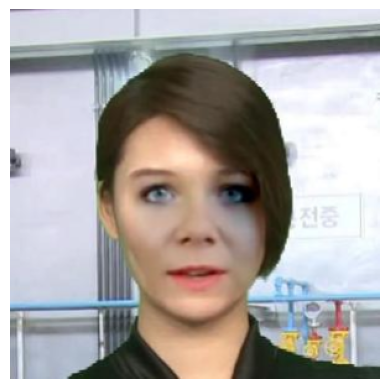

In [12]:
index = 2
img_model = preprocess_image(fake_imgs[index])

pred = model.predict(img_model, verbose=0)
pred = softmax(pred[0])
print(f"Real: {pred[0]*100:.2f}%\nFake: {pred[1]*100:.2f}%")

plt.imshow(display_image(img_model))
plt.axis('off')
plt.show()

In [13]:
input_img = np.array(img_model)
print(f"input image shape {input_img.shape}")

input image shape (1, 299, 299, 3)


In [14]:
img_adv = pgd_attack(model, loss_fn, input_img, np.array([[0, 1]]), 0.001, 0.001, 1) # [[0, 1]] means image is a deepfake

Real: 86.87%
Fake: 13.13%


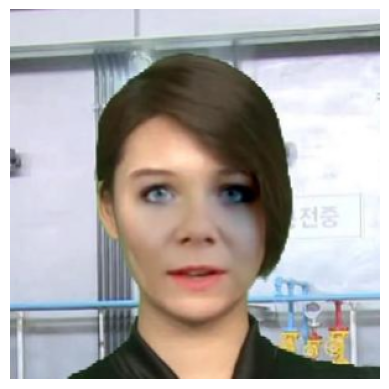

In [15]:
pred = model.predict(img_adv, verbose=0)
pred = softmax(pred[0])
print(f"Real: {pred[0]*100:.2f}%\nFake: {pred[1]*100:.2f}%")

plt.imshow(display_image(img_adv))
plt.axis('off')
plt.show()

In [16]:
similarity = tf.image.ssim_multiscale(display_image(img_model), display_image(img_adv),max_val=1.0)
print("similarité :",similarity)

similarité : tf.Tensor(0.99994475, shape=(), dtype=float32)


## View on multiple images

In [17]:
### CONFIG

EPSILON=0.01
A=0.001
K=5
index = 3

###

superior_row  = [fake_imgs[index], fake_imgs[index+1], fake_imgs[index+2]]
superior_pred = []

for i in range(len(superior_row)):
    superior_row[i] = preprocess_image(superior_row[i])

for i in superior_row:
    superior_pred.append(softmax(model(i)[0])[1])

inferior_row  = []
similarities  = []
inferior_pred = []

for image in superior_row:
    pert_image = pgd_attack(model, loss_fn, image, np.array([[0, 1]]), EPSILON, A, K) # [[0, 1]] means image is a deepfake
    inferior_pred.append(softmax(model(pert_image)[0])[1])
    inferior_row.append(display_image(pert_image))
    similarities.append(tf.image.ssim_multiscale(display_image(image), display_image(pert_image),max_val=1.0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.003937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.003937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.003937].


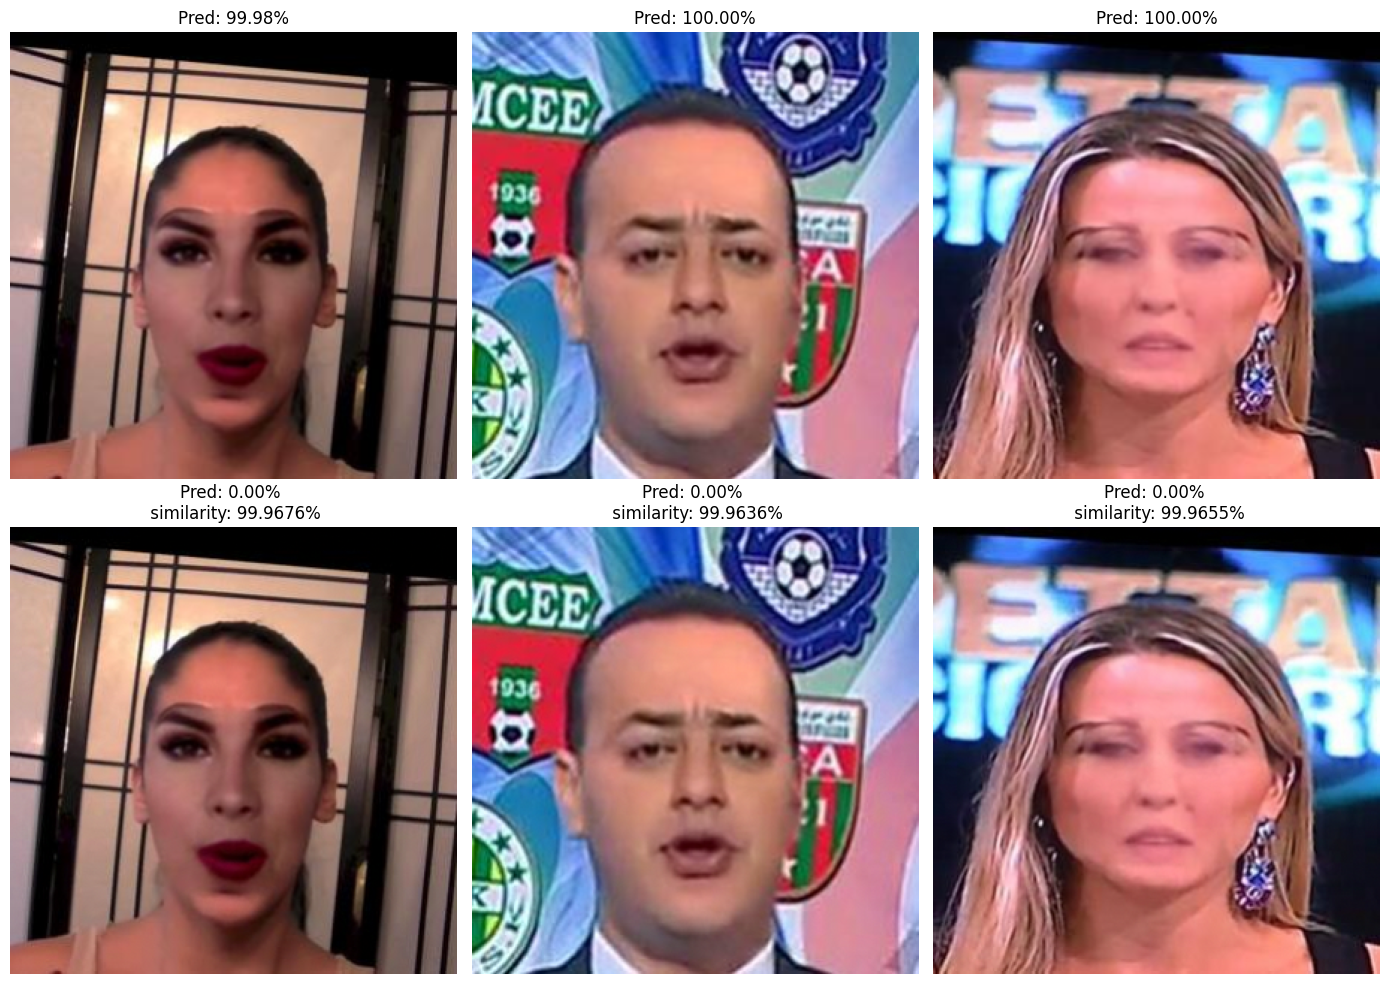

In [18]:
fig, a = plt.subplots(2, 3, figsize=(14, 10))
a = a.flatten()

for i, image in enumerate(superior_row):
    a[i].imshow(display_image(image))
    a[i].set_title(f'Pred: {superior_pred[i]*100:.2f}%')
    a[i].axis('off')

for i, image in enumerate(inferior_row):
    a[i + len(superior_row)].imshow(image)
    title = f'Pred: {inferior_pred[i]*100:.2f}% \n similarity: {similarities[i]*100:.4f}%'
    a[i + len(superior_row)].set_title(title)
    a[i + len(superior_row)].axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.003937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2749988..1.2749988].


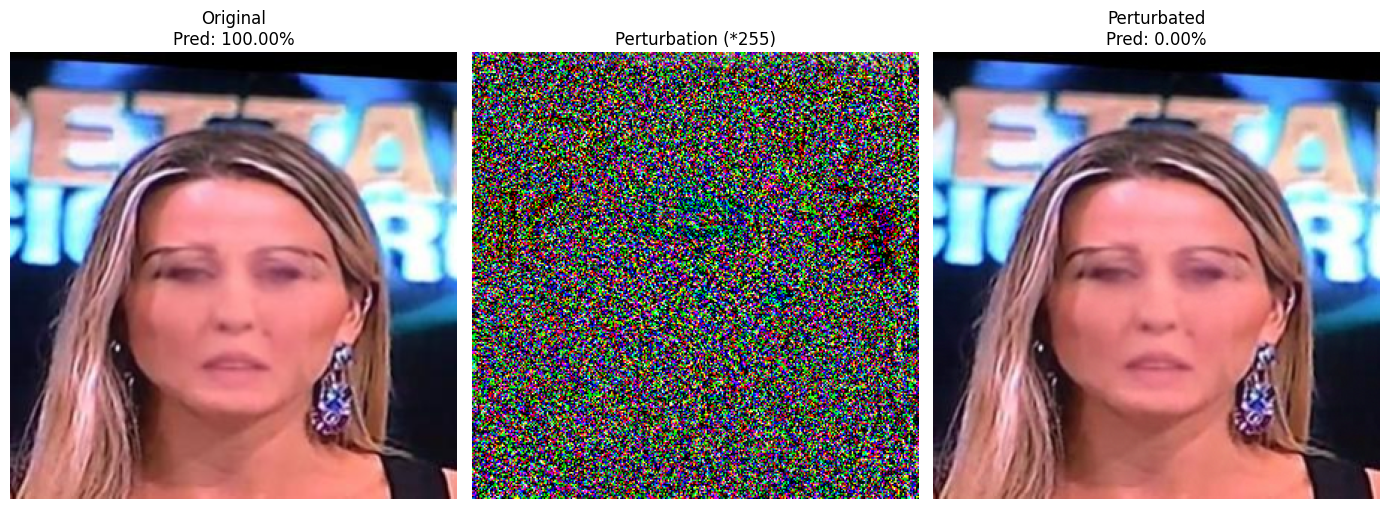

In [38]:
fig, a = plt.subplots(1, 3, figsize=(14, 5))
a = a.flatten()

a[0].set_title(f'Original\nPred: {superior_pred[2]*100:.2f}%')
a[0].axis('off')
a[0].imshow(display_image(superior_row[2]))

a[1].set_title(f'Perturbation (*255)')
a[1].axis('off')
a[1].imshow((inferior_row[2] - display_image(superior_row[2])) * 255.0)

a[2].set_title(f'Perturbated\nPred: {inferior_pred[2]*100:.2f}%')
a[2].axis('off')
a[2].imshow(inferior_row[2])

plt.tight_layout()
plt.show()

In [44]:
similarity = tf.image.ssim_multiscale((display_image(superior_row[2])), inferior_row[2], max_val=1.0)
print("similarité :",similarity)

similarité : tf.Tensor(0.9996554, shape=(), dtype=float32)


## Graphs

In [21]:
"""
K = 5
A = 0.05

epsilon_values = [i/10000 for i in range(3,11,2)] + [0.001, 0.0015] + [i/1000 for i in range(2, 11)]
attack_success = []

for epsilon in epsilon_values:
    
    successful_attacks = 0

    for index in tqdm(range(len(fake_imgs)), desc=f'epsilon={epsilon}'):

        input_img = preprocess_image(fake_imgs[index])
        img_adv = pgd_attack(model, loss_fn, input_img, np.array([[0, 1]]), epsilon, A, K)
        pred = softmax(model.predict(img_adv, verbose=0)[0])[1]

        if pred < .5 :
            successful_attacks += 1

    success_rate = successful_attacks / len(fake_imgs) * 100

    attack_success.append(success_rate)
    print(attack_success)

    if success_rate > 98:
        break
"""

"\nK = 5\nA = 0.05\n\nepsilon_values = [i/10000 for i in range(3,11,2)] + [0.001, 0.0015] + [i/1000 for i in range(2, 11)]\nattack_success = []\n\nfor epsilon in epsilon_values:\n    \n    successful_attacks = 0\n\n    for index in tqdm(range(len(fake_imgs)), desc=f'epsilon={epsilon}'):\n\n        input_img = preprocess_image(fake_imgs[index])\n        img_adv = pgd_attack(model, loss_fn, input_img, np.array([[0, 1]]), epsilon, A, K)\n        pred = softmax(model.predict(img_adv, verbose=0)[0])[1]\n\n        if pred < .5 :\n            successful_attacks += 1\n\n    success_rate = successful_attacks / len(fake_imgs) * 100\n\n    attack_success.append(success_rate)\n    print(attack_success)\n\n    if success_rate > 98:\n        break\n"

In [22]:
#print(epsilon_values)
epsilon_values = [0.0003,            0.0005,             0.0007,             0.0009,             0.001,             0.0015,             0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
attack_success = [9.433962264150944, 16.352201257861633, 28.930817610062892, 42.138364779874216, 47.16981132075472, 62.893081761006286, 76.72955974842768, 93.71069182389937, 99.37106918238993]

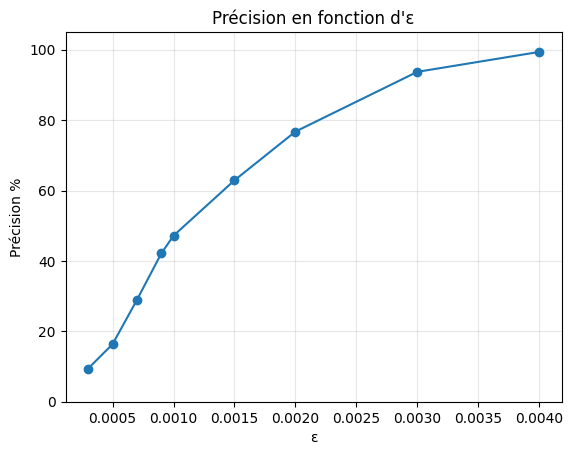

In [23]:
plt.plot(epsilon_values[:len(attack_success)], attack_success, marker='o')

plt.xlabel('ε')
plt.ylabel('Précision %')
plt.title('Précision en fonction d\'ε')

plt.grid(True, alpha=0.3)
plt.ylim(0, 105)
plt.show()

In [24]:
"""epsilon = 0.005
A = 0.0002

K_values = [i for i in range(1,6)] + [i for i in range(6,20,2)]
attack_success = []

for K in K_values:
    
    successful_attacks = 0

    for index in tqdm(range(len(fake_imgs)), desc=f'K={K}'):

        input_img = preprocess_image(fake_imgs[index])
        img_adv = pgd_attack(model, loss_fn, input_img, np.array([[0, 1]]), epsilon, A, K)
        pred = softmax(model.predict(img_adv, verbose=0)[0])[1]

        if pred < .5 :
            successful_attacks += 1

    success_rate = successful_attacks / len(fake_imgs) * 100

    attack_success.append(success_rate)
    print(attack_success)

    if success_rate > 98:
        break"""

"epsilon = 0.005\nA = 0.0002\n\nK_values = [i for i in range(1,6)] + [i for i in range(6,20,2)]\nattack_success = []\n\nfor K in K_values:\n    \n    successful_attacks = 0\n\n    for index in tqdm(range(len(fake_imgs)), desc=f'K={K}'):\n\n        input_img = preprocess_image(fake_imgs[index])\n        img_adv = pgd_attack(model, loss_fn, input_img, np.array([[0, 1]]), epsilon, A, K)\n        pred = softmax(model.predict(img_adv, verbose=0)[0])[1]\n\n        if pred < .5 :\n            successful_attacks += 1\n\n    success_rate = successful_attacks / len(fake_imgs) * 100\n\n    attack_success.append(success_rate)\n    print(attack_success)\n\n    if success_rate > 98:\n        break"

In [25]:
K_values= [i for i in range(1,6)] + [i for i in range(6,20,2)]
attack_success = [6.289308176100629, 12.578616352201259, 27.044025157232703, 38.36477987421384, 51.57232704402516, 58.490566037735846, 73.58490566037736, 84.90566037735849, 90.56603773584906, 95.59748427672956, 98.74213836477988]

In [26]:
plt.plot(K_values[:len(attack_success)], attack_success, marker='o')

plt.xlabel('K')
plt.ylabel('Précision %')
plt.title('Précision en fonction de K')

plt.grid(True, alpha=0.3)
plt.ylim(0, 105)
plt.show()